In [35]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from tqdm import tqdm
from torch.cuda.amp import GradScaler, autocast
from pathlib import Path
from IPython.display import FileLink
import tarfile
import math

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}", flush=True)
if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}", flush=True)

Using device: cuda
GPU Name: Tesla P100-PCIE-16GB


In [37]:
train_dir = '/kaggle/input/dataset/dataset/train'
test_dir = '/kaggle/input/dataset/dataset/test'

In [38]:
image_size = (124, 124)
batch_size = 32
num_workers = 4
num_classes = 8

In [ ]:
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(124),  
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.GaussianBlur(kernel_size=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(124),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [41]:
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transforms)

In [42]:
total_size = len(train_dataset)
train_size = int(0.6 * total_size)
val_size = int(0.2 * total_size)
test_size = total_size - train_size - val_size

In [43]:
train_dataset, val_dataset, _ = torch.utils.data.random_split(
    train_dataset, [train_size, val_size, test_size]
)

In [44]:
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True
)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True
)

In [45]:
print(f"Number of Classes: {num_classes}", flush=True)
assert num_classes == 8, "Expected 8 classes, adjust if different"

Number of Classes: 8


In [ ]:
class GaborConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=False):
        super(GaborConv2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.dilation = dilation
        self.groups = groups
        
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, dilation, groups, bias)
        
        self.sigma = nn.Parameter(torch.Tensor(out_channels, in_channels // groups, 1, 1))
        self.theta = nn.Parameter(torch.Tensor(out_channels, in_channels // groups, 1, 1))
        self.lambd = nn.Parameter(torch.Tensor(out_channels, in_channels // groups, 1, 1))
        self.gamma = nn.Parameter(torch.Tensor(out_channels, in_channels // groups, 1, 1))
        self.psi = nn.Parameter(torch.Tensor(out_channels, in_channels // groups, 1, 1))
        
        self.reset_parameters()
    
    def reset_parameters(self):
        nn.init.uniform_(self.sigma, 1.0, 5.0)  # New range for sigma
        nn.init.uniform_(self.theta, 0, math.pi)
        nn.init.uniform_(self.lambd, 2.0, 20.0)  # New range for lambd
        nn.init.uniform_(self.gamma, 0.1, 1.0)
        nn.init.uniform_(self.psi, 0, math.pi)
        
    def forward(self, x):
        kernels = self._get_gabor_kernels()
        self.conv.weight.data = kernels
        return self.conv(x)
    
    def _get_gabor_kernels(self):
        filters = torch.zeros(self.out_channels, self.in_channels // self.groups, 
                              self.kernel_size, self.kernel_size, device=self.sigma.device)
        
        center = self.kernel_size // 2
        y_coords, x_coords = torch.meshgrid(
            torch.arange(-center, center + 1, device=self.sigma.device),
            torch.arange(-center, center + 1, device=self.sigma.device),
            indexing='ij'  
        )
        
        y_coords = y_coords.unsqueeze(0).unsqueeze(0)
        x_coords = x_coords.unsqueeze(0).unsqueeze(0)
        
        for i in range(self.out_channels):
            for j in range(self.in_channels // self.groups):
                sigma = self.sigma[i, j]
                theta = self.theta[i, j]
                lambd = self.lambd[i, j]
                gamma = self.gamma[i, j]
                psi = self.psi[i, j]
                
                x_theta = x_coords * torch.cos(theta) + y_coords * torch.sin(theta)
                y_theta = -x_coords * torch.sin(theta) + y_coords * torch.cos(theta)
                
                gb = torch.exp(
                    -0.5 * (x_theta**2 + gamma**2 * y_theta**2) / sigma**2
                ) * torch.cos(2 * math.pi * x_theta / lambd + psi)
                
                filters[i, j] = gb
        
        return filters

In [47]:
class GaborBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=7, stride=1, padding=3):
        super(GaborBlock, self).__init__()
        
        self.gabor = GaborConv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        
        self.skip = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.skip = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
    
    def forward(self, x):
        residual = self.skip(x)
        out = self.gabor(x)
        out = self.bn(out)
        out = self.relu(out + residual)
        return out

In [ ]:
import torchvision.models as models
class HybridResNeXtGaborModel(nn.Module):
    def __init__(self, num_classes=8):
        super(HybridResNeXtGaborModel, self).__init__()
        
        # Branch 1: ResNeXt-101 for RGB
        self.resnext1 = models.resnext101_32x8d(weights='ResNeXt101_32X8D_Weights.IMAGENET1K_V1')
        for param in self.resnext1.parameters():
            param.requires_grad = False
        self.resnext1.fc = nn.Identity()
        
        # Branch 2: Gabor filters + ResNeXt-101
        self.gabor_filters = nn.Sequential(
            GaborBlock(3, 64, kernel_size=7, stride=1, padding=3),
            GaborBlock(64, 64, kernel_size=5, stride=1, padding=2)
        )
        self.gabor_to_rgb = nn.Conv2d(64, 3, kernel_size=1, bias=False)  # Convert 64 channels to 3
        self.resnext2 = models.resnext101_32x8d(weights='ResNeXt101_32X8D_Weights.IMAGENET1K_V1')
        for param in self.resnext2.parameters():
            param.requires_grad = False
        self.resnext2.fc = nn.Identity()
        
        # Merge branches
        total_features = 2048 + 2048
        self.merge_conv = nn.Conv2d(total_features, 1024, kernel_size=1, bias=False)
        self.merge_bn = nn.BatchNorm2d(1024)
        self.relu = nn.ReLU(inplace=True)
        
        # Classification head
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(1024, 512)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 256)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(256, num_classes)
        self.log_softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, x):
        branch1_out = self.resnext1(x)
        branch2_gabor = self.gabor_filters(x)
        print("branch2_gabor shape:", branch2_gabor.shape) 
        branch2_rgb = self.gabor_to_rgb(branch2_gabor)  # Convert to 3 channels
        branch2_out = self.resnext2(branch2_rgb)
        branch1_out = branch1_out.unsqueeze(-1).unsqueeze(-1)
        branch2_out = branch2_out.unsqueeze(-1).unsqueeze(-1)
        merged = torch.cat([branch1_out, branch2_out], dim=1)
        merged = self.merge_conv(merged)
        merged = self.merge_bn(merged)
        merged = self.relu(merged)
        out = self.avgpool(merged)
        out = torch.flatten(out, 1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.dropout1(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.dropout2(out)
        out = self.fc3(out)
        out = self.log_softmax(out)
        return out

In [51]:
# Initialize model
model = HybridResNeXtGaborModel(num_classes=num_classes).to(device)

In [52]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, phase_name, scaler=None):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    best_val_acc = 0.0
    best_model_weights = None
    patience = 5
    epochs_no_improve = 0
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        train_bar = tqdm(train_loader, desc=f"{phase_name} Epoch {epoch+1}/{num_epochs} [Train]", mininterval=1.0, miniters=int(len(train_loader)/10))
        for images, labels in train_bar:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            
            with amp.autocast('cuda'):
                outputs = model(images)
                loss = criterion(outputs, labels)
            
            if scaler:
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                optimizer.step()
                
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            train_bar.set_postfix({"Batch Loss": loss.item()})
        
        train_loss = running_loss / len(train_loader.dataset)
        train_acc = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        val_bar = tqdm(val_loader, desc=f"{phase_name} Epoch {epoch+1}/{num_epochs} [Val]", mininterval=1.0, miniters=int(len(val_loader)/10))
        with torch.no_grad():
            for images, labels in val_bar:
                images, labels = images.to(device), labels.to(device)
                with amp.autocast('cuda'):
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                val_bar.set_postfix({"Batch Loss": loss.item()})
        
        val_loss = val_loss / len(val_loader.dataset)
        val_acc = 100 * correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        
        print(f"{phase_name} Epoch [{epoch+1}/{num_epochs}]", flush=True)
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%", flush=True)
        print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%", flush=True)
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_weights = {
                'gabor_filters.0.gabor.sigma': model.gabor_filters[0].gabor.sigma.data,
                'gabor_filters.0.gabor.theta': model.gabor_filters[0].gabor.theta.data,
                'gabor_filters.0.gabor.lambd': model.gabor_filters[0].gabor.lambd.data,
                'gabor_filters.0.gabor.gamma': model.gabor_filters[0].gabor.gamma.data,
                'gabor_filters.0.gabor.psi': model.gabor_filters[0].gabor.psi.data,
                'gabor_filters.0.gabor.conv.weight': model.gabor_filters[0].gabor.conv.weight.data,
                'gabor_filters.0.bn.weight': model.gabor_filters[0].bn.weight.data,
                'gabor_filters.0.bn.bias': model.gabor_filters[0].bn.bias.data,
                'gabor_filters.1.gabor.sigma': model.gabor_filters[1].gabor.sigma.data,
                'gabor_filters.1.gabor.theta': model.gabor_filters[1].gabor.theta.data,
                'gabor_filters.1.gabor.lambd': model.gabor_filters[1].gabor.lambd.data,
                'gabor_filters.1.gabor.gamma': model.gabor_filters[1].gabor.gamma.data,
                'gabor_filters.1.gabor.psi': model.gabor_filters[1].gabor.psi.data,
                'gabor_filters.1.gabor.conv.weight': model.gabor_filters[1].gabor.conv.weight.data,
                'gabor_filters.1.bn.weight': model.gabor_filters[1].bn.weight.data,
                'gabor_filters.1.bn.bias': model.gabor_filters[1].bn.bias.data,
                'gabor_to_rgb.weight': model.gabor_to_rgb.weight.data,
                'merge_conv.weight': model.merge_conv.weight.data,
                'merge_bn.weight': model.merge_bn.weight.data,
                'merge_bn.bias': model.merge_bn.bias.data,
                'fc1.weight': model.fc1.weight.data,
                'fc1.bias': model.fc1.bias.data,
                'fc2.weight': model.fc2.weight.data,
                'fc2.bias': model.fc2.bias.data,
                'fc3.weight': model.fc3.weight.data,
                'fc3.bias': model.fc3.bias.data
            }
            torch.save(best_model_weights, '/kaggle/working/hybrid_trash_classifier.pth')
            with tarfile.open('/kaggle/working/hybrid_trash_classifier.pth.tar.gz', 'w:gz') as tar:
                tar.add('/kaggle/working/hybrid_trash_classifier.pth', arcname='hybrid_trash_classifier.pth')
            print(f"New best model saved with Val Accuracy: {best_val_acc:.2f}% (compressed as .pth.tar.gz)", flush=True)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs.", flush=True)
                break
    
    return train_losses, val_losses, train_accuracies, val_accuracies, best_model_weights


In [53]:
from torch import amp
scaler = amp.GradScaler()


In [54]:
print("Model Parameters:")
for name, param in model.named_parameters():
    print(f"{name} | requires_grad={param.requires_grad} | shape={param.shape}")


Model Parameters:
resnext1.conv1.weight | requires_grad=False | shape=torch.Size([64, 3, 7, 7])
resnext1.bn1.weight | requires_grad=False | shape=torch.Size([64])
resnext1.bn1.bias | requires_grad=False | shape=torch.Size([64])
resnext1.layer1.0.conv1.weight | requires_grad=False | shape=torch.Size([256, 64, 1, 1])
resnext1.layer1.0.bn1.weight | requires_grad=False | shape=torch.Size([256])
resnext1.layer1.0.bn1.bias | requires_grad=False | shape=torch.Size([256])
resnext1.layer1.0.conv2.weight | requires_grad=False | shape=torch.Size([256, 8, 3, 3])
resnext1.layer1.0.bn2.weight | requires_grad=False | shape=torch.Size([256])
resnext1.layer1.0.bn2.bias | requires_grad=False | shape=torch.Size([256])
resnext1.layer1.0.conv3.weight | requires_grad=False | shape=torch.Size([256, 256, 1, 1])
resnext1.layer1.0.bn3.weight | requires_grad=False | shape=torch.Size([256])
resnext1.layer1.0.bn3.bias | requires_grad=False | shape=torch.Size([256])
resnext1.layer1.0.downsample.0.weight | requires_

In [55]:
for param in model.parameters():
    param.requires_grad = False

In [56]:
# Unfreeze layer3 of resnext1
for param in model.resnext1.layer3.parameters():
    param.requires_grad = True

In [57]:
# Unfreeze layer3 of resnext2
for param in model.resnext2.layer3.parameters():
    param.requires_grad = True

In [47]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam([p for p in model.parameters() if p.requires_grad], lr=0.001, betas=(0.9, 0.999))
print("Starting Adam Phase (Initial 10 Epochs)...", flush=True)
train_losses, val_losses, train_accuracies, val_accuracies, best_weights = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=10, phase_name="Adam Initial Phase", scaler=scaler
)

Starting Adam Phase (Initial 10 Epochs)...


Adam Initial Phase Epoch 1/10 [Train]:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:   0%|          | 0/126 [00:04<?, ?it/s, Batch Loss=2.07]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:   0%|          | 0/126 [00:06<?, ?it/s, Batch Loss=2.06]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:   0%|          | 0/126 [00:09<?, ?it/s, Batch Loss=2.03]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:   0%|          | 0/126 [00:11<?, ?it/s, Batch Loss=2.09]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:   0%|          | 0/126 [00:15<?, ?it/s, Batch Loss=2.09]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:   5%|▍         | 6/126 [00:17<05:43,  2.86s/it, Batch Loss=2.07]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:   6%|▌         | 7/126 [00:19<05:33,  2.81s/it, Batch Loss=2.04]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:   6%|▋         | 8/126 [00:22<05:25,  2.76s/it, Batch Loss=2.06]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:   7%|▋         | 9/126 [00:25<05:22,  2.75s/it, Batch Loss=2.08]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:   8%|▊         | 10/126 [00:27<05:15,  2.72s/it, Batch Loss=2.05]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:   9%|▊         | 11/126 [00:30<05:08,  2.68s/it, Batch Loss=2.14]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  10%|▉         | 12/126 [00:32<05:02,  2.65s/it, Batch Loss=2.06]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  10%|█         | 13/126 [00:35<04:59,  2.65s/it, Batch Loss=2.06]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  11%|█         | 14/126 [00:38<04:54,  2.63s/it, Batch Loss=2.02]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  12%|█▏        | 15/126 [00:40<04:51,  2.62s/it, Batch Loss=2.04]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  13%|█▎        | 16/126 [00:43<04:47,  2.62s/it, Batch Loss=2.05]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  13%|█▎        | 17/126 [00:45<04:44,  2.61s/it, Batch Loss=2.07]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  14%|█▍        | 18/126 [00:48<04:40,  2.60s/it, Batch Loss=2.02]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  15%|█▌        | 19/126 [00:51<04:38,  2.60s/it, Batch Loss=2.05]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  16%|█▌        | 20/126 [00:53<04:35,  2.60s/it, Batch Loss=2.08]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  17%|█▋        | 21/126 [00:56<04:34,  2.61s/it, Batch Loss=2.07]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  17%|█▋        | 22/126 [00:58<04:31,  2.61s/it, Batch Loss=2.03]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  18%|█▊        | 23/126 [01:01<04:28,  2.60s/it, Batch Loss=2.07]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  19%|█▉        | 24/126 [01:04<04:25,  2.60s/it, Batch Loss=2.02]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  20%|█▉        | 25/126 [01:06<04:22,  2.59s/it, Batch Loss=2.07]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  21%|██        | 26/126 [01:09<04:19,  2.60s/it, Batch Loss=2.02]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  21%|██▏       | 27/126 [01:11<04:17,  2.60s/it, Batch Loss=2.09]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  22%|██▏       | 28/126 [01:14<04:15,  2.60s/it, Batch Loss=2.07]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  23%|██▎       | 29/126 [01:17<04:11,  2.60s/it, Batch Loss=2.01]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  24%|██▍       | 30/126 [01:19<04:09,  2.60s/it, Batch Loss=2.07]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  25%|██▍       | 31/126 [01:22<04:06,  2.59s/it, Batch Loss=2.07]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  25%|██▌       | 32/126 [01:24<04:05,  2.62s/it, Batch Loss=2.01]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  26%|██▌       | 33/126 [01:27<04:03,  2.62s/it, Batch Loss=2.02]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  27%|██▋       | 34/126 [01:30<03:59,  2.61s/it, Batch Loss=2.08]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  28%|██▊       | 35/126 [01:32<03:56,  2.60s/it, Batch Loss=2.04]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  29%|██▊       | 36/126 [01:35<03:54,  2.61s/it, Batch Loss=2.06]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  29%|██▉       | 37/126 [01:37<03:51,  2.60s/it, Batch Loss=2.05]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  30%|███       | 38/126 [01:40<03:49,  2.60s/it, Batch Loss=2.06]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  31%|███       | 39/126 [01:43<03:48,  2.62s/it, Batch Loss=2.11]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  32%|███▏      | 40/126 [01:45<03:44,  2.61s/it, Batch Loss=2.02]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  33%|███▎      | 41/126 [01:48<03:41,  2.61s/it, Batch Loss=2.05]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  33%|███▎      | 42/126 [01:50<03:38,  2.60s/it, Batch Loss=2.04]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  34%|███▍      | 43/126 [01:53<03:35,  2.60s/it, Batch Loss=2.02]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  35%|███▍      | 44/126 [01:56<03:32,  2.60s/it, Batch Loss=2.02]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  36%|███▌      | 45/126 [01:58<03:30,  2.60s/it, Batch Loss=2.01]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  37%|███▋      | 46/126 [02:01<03:28,  2.61s/it, Batch Loss=2.05]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  37%|███▋      | 47/126 [02:03<03:25,  2.60s/it, Batch Loss=2.04]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  38%|███▊      | 48/126 [02:06<03:22,  2.60s/it, Batch Loss=2.03]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  39%|███▉      | 49/126 [02:09<03:20,  2.60s/it, Batch Loss=2.02]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  40%|███▉      | 50/126 [02:11<03:17,  2.60s/it, Batch Loss=2.04]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  40%|████      | 51/126 [02:14<03:14,  2.60s/it, Batch Loss=2.02]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  41%|████▏     | 52/126 [02:16<03:12,  2.60s/it, Batch Loss=2.04]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  42%|████▏     | 53/126 [02:19<03:09,  2.60s/it, Batch Loss=2.04]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  43%|████▎     | 54/126 [02:22<03:06,  2.60s/it, Batch Loss=2.03]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  44%|████▎     | 55/126 [02:24<03:04,  2.60s/it, Batch Loss=2.04]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  44%|████▍     | 56/126 [02:27<03:02,  2.60s/it, Batch Loss=2.06]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  45%|████▌     | 57/126 [02:29<02:59,  2.60s/it, Batch Loss=2.04]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  46%|████▌     | 58/126 [02:32<02:57,  2.61s/it, Batch Loss=2.05]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  47%|████▋     | 59/126 [02:35<02:54,  2.61s/it, Batch Loss=2.06]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  48%|████▊     | 60/126 [02:37<02:51,  2.60s/it, Batch Loss=2.1] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  48%|████▊     | 61/126 [02:40<02:48,  2.60s/it, Batch Loss=2.06]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  49%|████▉     | 62/126 [02:42<02:45,  2.59s/it, Batch Loss=2.1] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  50%|█████     | 63/126 [02:45<02:43,  2.60s/it, Batch Loss=2.12]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  51%|█████     | 64/126 [02:48<02:41,  2.60s/it, Batch Loss=2.02]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  52%|█████▏    | 65/126 [02:50<02:38,  2.60s/it, Batch Loss=2.08]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  52%|█████▏    | 66/126 [02:53<02:36,  2.60s/it, Batch Loss=2.05]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  53%|█████▎    | 67/126 [02:55<02:33,  2.60s/it, Batch Loss=2.06]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  54%|█████▍    | 68/126 [02:58<02:30,  2.59s/it, Batch Loss=2.01]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  55%|█████▍    | 69/126 [03:01<02:27,  2.59s/it, Batch Loss=2.06]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  56%|█████▌    | 70/126 [03:03<02:25,  2.60s/it, Batch Loss=2.04]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  56%|█████▋    | 71/126 [03:06<02:22,  2.60s/it, Batch Loss=2.04]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  57%|█████▋    | 72/126 [03:08<02:20,  2.59s/it, Batch Loss=2.03]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  58%|█████▊    | 73/126 [03:11<02:17,  2.59s/it, Batch Loss=2.05]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  59%|█████▊    | 74/126 [03:14<02:14,  2.59s/it, Batch Loss=2.07]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  60%|█████▉    | 75/126 [03:16<02:13,  2.61s/it, Batch Loss=2.02]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  60%|██████    | 76/126 [03:19<02:10,  2.60s/it, Batch Loss=2.02]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  61%|██████    | 77/126 [03:21<02:07,  2.60s/it, Batch Loss=2.05]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  62%|██████▏   | 78/126 [03:24<02:05,  2.61s/it, Batch Loss=2.04]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  63%|██████▎   | 79/126 [03:27<02:03,  2.62s/it, Batch Loss=2.01]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  63%|██████▎   | 80/126 [03:29<02:00,  2.62s/it, Batch Loss=2.03]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  64%|██████▍   | 81/126 [03:32<01:57,  2.61s/it, Batch Loss=2.04]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  65%|██████▌   | 82/126 [03:35<01:54,  2.61s/it, Batch Loss=2.01]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  66%|██████▌   | 83/126 [03:37<01:52,  2.62s/it, Batch Loss=2.02]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  67%|██████▋   | 84/126 [03:40<01:50,  2.62s/it, Batch Loss=2.09]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  67%|██████▋   | 85/126 [03:42<01:47,  2.61s/it, Batch Loss=2.04]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  68%|██████▊   | 86/126 [03:45<01:45,  2.63s/it, Batch Loss=1.99]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  69%|██████▉   | 87/126 [03:48<01:41,  2.62s/it, Batch Loss=2.03]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  70%|██████▉   | 88/126 [03:50<01:39,  2.61s/it, Batch Loss=2.04]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  71%|███████   | 89/126 [03:53<01:36,  2.60s/it, Batch Loss=2.06]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  71%|███████▏  | 90/126 [03:55<01:33,  2.61s/it, Batch Loss=2.01]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  72%|███████▏  | 91/126 [03:58<01:30,  2.60s/it, Batch Loss=2.02]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  73%|███████▎  | 92/126 [04:01<01:28,  2.60s/it, Batch Loss=2.05]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  74%|███████▍  | 93/126 [04:03<01:25,  2.60s/it, Batch Loss=2.03]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  75%|███████▍  | 94/126 [04:06<01:23,  2.59s/it, Batch Loss=1.98]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  75%|███████▌  | 95/126 [04:09<01:25,  2.75s/it, Batch Loss=2.01]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  76%|███████▌  | 96/126 [04:11<01:20,  2.70s/it, Batch Loss=2.03]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  77%|███████▋  | 97/126 [04:14<01:17,  2.68s/it, Batch Loss=2.04]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  78%|███████▊  | 98/126 [04:17<01:14,  2.67s/it, Batch Loss=2.01]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  79%|███████▊  | 99/126 [04:19<01:11,  2.65s/it, Batch Loss=1.99]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  79%|███████▉  | 100/126 [04:22<01:08,  2.63s/it, Batch Loss=2.09]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  80%|████████  | 101/126 [04:25<01:05,  2.64s/it, Batch Loss=2.03]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  81%|████████  | 102/126 [04:27<01:02,  2.62s/it, Batch Loss=2.03]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  82%|████████▏ | 103/126 [04:30<01:00,  2.61s/it, Batch Loss=1.99]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  83%|████████▎ | 104/126 [04:32<00:57,  2.60s/it, Batch Loss=2.01]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  83%|████████▎ | 105/126 [04:35<00:54,  2.62s/it, Batch Loss=2.02]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  84%|████████▍ | 106/126 [04:38<00:52,  2.61s/it, Batch Loss=2.09]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  85%|████████▍ | 107/126 [04:40<00:50,  2.67s/it, Batch Loss=2.02]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  86%|████████▌ | 108/126 [04:43<00:47,  2.66s/it, Batch Loss=2.06]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  87%|████████▋ | 109/126 [04:46<00:44,  2.65s/it, Batch Loss=2.04]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  87%|████████▋ | 110/126 [04:48<00:42,  2.63s/it, Batch Loss=1.99]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  88%|████████▊ | 111/126 [04:51<00:39,  2.64s/it, Batch Loss=2.01]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  89%|████████▉ | 112/126 [04:54<00:36,  2.62s/it, Batch Loss=1.99]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  90%|████████▉ | 113/126 [04:56<00:33,  2.61s/it, Batch Loss=2]   

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  90%|█████████ | 114/126 [04:59<00:31,  2.61s/it, Batch Loss=2.01]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  91%|█████████▏| 115/126 [05:01<00:28,  2.61s/it, Batch Loss=1.97]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  92%|█████████▏| 116/126 [05:04<00:26,  2.61s/it, Batch Loss=1.99]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  93%|█████████▎| 117/126 [05:07<00:23,  2.62s/it, Batch Loss=2.05]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  94%|█████████▎| 118/126 [05:09<00:20,  2.60s/it, Batch Loss=2.01]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  94%|█████████▍| 119/126 [05:12<00:18,  2.61s/it, Batch Loss=2.04]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  95%|█████████▌| 120/126 [05:14<00:15,  2.61s/it, Batch Loss=2.01]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  96%|█████████▌| 121/126 [05:17<00:12,  2.59s/it, Batch Loss=2.01]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  97%|█████████▋| 122/126 [05:19<00:10,  2.59s/it, Batch Loss=1.98]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  98%|█████████▊| 123/126 [05:22<00:07,  2.58s/it, Batch Loss=1.99]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  98%|█████████▊| 124/126 [05:25<00:05,  2.59s/it, Batch Loss=2.01]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Train]:  99%|█████████▉| 125/126 [05:27<00:02,  2.58s/it, Batch Loss=2.01]

branch2_gabor shape: torch.Size([5, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Val]:   0%|          | 0/42 [00:00<?, ?it/s]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Val]:   0%|          | 0/42 [00:03<?, ?it/s, Batch Loss=2.02]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Val]:   0%|          | 0/42 [00:05<?, ?it/s, Batch Loss=1.99]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Val]:   0%|          | 0/42 [00:07<?, ?it/s, Batch Loss=1.99]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Val]:  10%|▉         | 4/42 [00:09<01:33,  2.47s/it, Batch Loss=2.06]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Val]:  10%|▉         | 4/42 [00:11<01:33,  2.47s/it, Batch Loss=2.03]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Val]:  10%|▉         | 4/42 [00:14<01:33,  2.47s/it, Batch Loss=2.03]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Val]:  10%|▉         | 4/42 [00:16<01:33,  2.47s/it, Batch Loss=2.05]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Val]:  19%|█▉        | 8/42 [00:18<01:16,  2.26s/it, Batch Loss=2.02]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Val]:  19%|█▉        | 8/42 [00:20<01:16,  2.26s/it, Batch Loss=2.04]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Val]:  19%|█▉        | 8/42 [00:22<01:16,  2.26s/it, Batch Loss=2.02]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Val]:  19%|█▉        | 8/42 [00:24<01:16,  2.26s/it, Batch Loss=2.05]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Val]:  29%|██▊       | 12/42 [00:26<01:04,  2.16s/it, Batch Loss=2.02]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Val]:  29%|██▊       | 12/42 [00:28<01:04,  2.16s/it, Batch Loss=2.01]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Val]:  29%|██▊       | 12/42 [00:30<01:04,  2.16s/it, Batch Loss=2.01]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Val]:  29%|██▊       | 12/42 [00:32<01:04,  2.16s/it, Batch Loss=2.05]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Val]:  38%|███▊      | 16/42 [00:34<00:54,  2.11s/it, Batch Loss=2]   

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Val]:  38%|███▊      | 16/42 [00:36<00:54,  2.11s/it, Batch Loss=2.03]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Val]:  38%|███▊      | 16/42 [00:38<00:54,  2.11s/it, Batch Loss=2.02]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Val]:  38%|███▊      | 16/42 [00:40<00:54,  2.11s/it, Batch Loss=2.03]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Val]:  48%|████▊     | 20/42 [00:42<00:45,  2.08s/it, Batch Loss=2.04]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Val]:  48%|████▊     | 20/42 [00:44<00:45,  2.08s/it, Batch Loss=2.05]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Val]:  48%|████▊     | 20/42 [00:47<00:45,  2.08s/it, Batch Loss=2.01]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Val]:  48%|████▊     | 20/42 [00:49<00:45,  2.08s/it, Batch Loss=2.03]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Val]:  57%|█████▋    | 24/42 [00:51<00:37,  2.10s/it, Batch Loss=2.03]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Val]:  57%|█████▋    | 24/42 [00:53<00:37,  2.10s/it, Batch Loss=2]   

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Val]:  57%|█████▋    | 24/42 [00:55<00:37,  2.10s/it, Batch Loss=1.94]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Val]:  57%|█████▋    | 24/42 [00:57<00:37,  2.10s/it, Batch Loss=2.03]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Val]:  67%|██████▋   | 28/42 [00:59<00:29,  2.08s/it, Batch Loss=2.05]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Val]:  67%|██████▋   | 28/42 [01:01<00:29,  2.08s/it, Batch Loss=2.05]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Val]:  67%|██████▋   | 28/42 [01:03<00:29,  2.08s/it, Batch Loss=2.05]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Val]:  67%|██████▋   | 28/42 [01:05<00:29,  2.08s/it, Batch Loss=2]   

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Val]:  76%|███████▌  | 32/42 [01:07<00:20,  2.06s/it, Batch Loss=1.98]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Val]:  76%|███████▌  | 32/42 [01:09<00:20,  2.06s/it, Batch Loss=2.04]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Val]:  76%|███████▌  | 32/42 [01:11<00:20,  2.06s/it, Batch Loss=2.04]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Val]:  76%|███████▌  | 32/42 [01:13<00:20,  2.06s/it, Batch Loss=2.02]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Val]:  86%|████████▌ | 36/42 [01:15<00:12,  2.05s/it, Batch Loss=2.06]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Val]:  86%|████████▌ | 36/42 [01:17<00:12,  2.05s/it, Batch Loss=2.01]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Val]:  86%|████████▌ | 36/42 [01:19<00:12,  2.05s/it, Batch Loss=2.02]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Val]:  86%|████████▌ | 36/42 [01:21<00:12,  2.05s/it, Batch Loss=2.05]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Val]:  95%|█████████▌| 40/42 [01:23<00:04,  2.04s/it, Batch Loss=2.02]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Val]:  95%|█████████▌| 40/42 [01:27<00:04,  2.04s/it, Batch Loss=2.05]

branch2_gabor shape: torch.Size([23, 64, 224, 224])


Adam Initial Phase Epoch 1/10 [Val]: 100%|██████████| 42/42 [01:27<00:00,  2.08s/it, Batch Loss=2.05]

Adam Initial Phase Epoch [1/10]
Train Loss: 2.0397, Train Accuracy: 20.05%
Val Loss: 2.0235, Val Accuracy: 22.10%


New best model saved with Val Accuracy: 22.10% (compressed as .pth.tar.gz)


Adam Initial Phase Epoch 2/10 [Train]:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:   0%|          | 0/126 [00:04<?, ?it/s, Batch Loss=2.02]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:   0%|          | 0/126 [00:07<?, ?it/s, Batch Loss=2.08]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:   0%|          | 0/126 [00:10<?, ?it/s, Batch Loss=2.01]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:   0%|          | 0/126 [00:12<?, ?it/s, Batch Loss=2.04]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:   0%|          | 0/126 [00:15<?, ?it/s, Batch Loss=2.05]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:   0%|          | 0/126 [00:18<?, ?it/s, Batch Loss=2]   

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:   6%|▌         | 7/126 [00:20<05:48,  2.93s/it, Batch Loss=2.03]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:   6%|▋         | 8/126 [00:23<05:42,  2.90s/it, Batch Loss=2.04]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:   7%|▋         | 9/126 [00:25<05:32,  2.84s/it, Batch Loss=2.04]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:   8%|▊         | 10/126 [00:28<05:23,  2.79s/it, Batch Loss=1.99]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:   9%|▊         | 11/126 [00:31<05:14,  2.74s/it, Batch Loss=2]   

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  10%|▉         | 12/126 [00:33<05:07,  2.70s/it, Batch Loss=2.02]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  10%|█         | 13/126 [00:36<05:02,  2.68s/it, Batch Loss=2.03]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  11%|█         | 14/126 [00:38<04:57,  2.65s/it, Batch Loss=2.04]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  12%|█▏        | 15/126 [00:41<04:52,  2.63s/it, Batch Loss=2.01]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  13%|█▎        | 16/126 [00:43<04:47,  2.61s/it, Batch Loss=2]   

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  13%|█▎        | 17/126 [00:46<04:45,  2.62s/it, Batch Loss=1.99]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  14%|█▍        | 18/126 [00:49<04:41,  2.61s/it, Batch Loss=1.99]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  15%|█▌        | 19/126 [00:51<04:38,  2.60s/it, Batch Loss=2.01]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  16%|█▌        | 20/126 [00:54<04:37,  2.62s/it, Batch Loss=1.99]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  17%|█▋        | 21/126 [00:57<04:35,  2.62s/it, Batch Loss=2.01]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  17%|█▋        | 22/126 [00:59<04:31,  2.61s/it, Batch Loss=1.97]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  18%|█▊        | 23/126 [01:02<04:27,  2.60s/it, Batch Loss=2.05]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  19%|█▉        | 24/126 [01:04<04:24,  2.60s/it, Batch Loss=2.02]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  20%|█▉        | 25/126 [01:07<04:23,  2.61s/it, Batch Loss=2.02]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  21%|██        | 26/126 [01:10<04:20,  2.60s/it, Batch Loss=2]   

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  21%|██▏       | 27/126 [01:12<04:17,  2.60s/it, Batch Loss=2.08]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  22%|██▏       | 28/126 [01:15<04:14,  2.60s/it, Batch Loss=1.97]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  23%|██▎       | 29/126 [01:17<04:12,  2.60s/it, Batch Loss=1.92]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  24%|██▍       | 30/126 [01:20<04:08,  2.59s/it, Batch Loss=2.06]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  25%|██▍       | 31/126 [01:23<04:06,  2.59s/it, Batch Loss=2.01]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  25%|██▌       | 32/126 [01:25<04:04,  2.60s/it, Batch Loss=2.03]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  26%|██▌       | 33/126 [01:28<04:01,  2.60s/it, Batch Loss=2.04]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  27%|██▋       | 34/126 [01:30<03:58,  2.59s/it, Batch Loss=2.06]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  28%|██▊       | 35/126 [01:33<03:55,  2.59s/it, Batch Loss=1.99]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  29%|██▊       | 36/126 [01:35<03:52,  2.58s/it, Batch Loss=1.98]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  29%|██▉       | 37/126 [01:38<03:50,  2.59s/it, Batch Loss=2]   

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  30%|███       | 38/126 [01:41<03:47,  2.59s/it, Batch Loss=2.02]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  31%|███       | 39/126 [01:43<03:44,  2.58s/it, Batch Loss=1.99]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  32%|███▏      | 40/126 [01:46<03:42,  2.58s/it, Batch Loss=1.95]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  33%|███▎      | 41/126 [01:49<03:42,  2.62s/it, Batch Loss=1.97]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  33%|███▎      | 42/126 [01:51<03:39,  2.61s/it, Batch Loss=1.99]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  34%|███▍      | 43/126 [01:54<03:36,  2.60s/it, Batch Loss=2.02]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  35%|███▍      | 44/126 [01:56<03:34,  2.61s/it, Batch Loss=2]   

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  36%|███▌      | 45/126 [01:59<03:35,  2.66s/it, Batch Loss=2.03]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  37%|███▋      | 46/126 [02:02<03:31,  2.64s/it, Batch Loss=2]   

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  37%|███▋      | 47/126 [02:04<03:28,  2.63s/it, Batch Loss=2.04]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  38%|███▊      | 48/126 [02:07<03:25,  2.64s/it, Batch Loss=2.01]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  39%|███▉      | 49/126 [02:10<03:21,  2.62s/it, Batch Loss=2]   

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  40%|███▉      | 50/126 [02:12<03:18,  2.61s/it, Batch Loss=2.01]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  40%|████      | 51/126 [02:15<03:17,  2.63s/it, Batch Loss=2]   

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  41%|████▏     | 52/126 [02:17<03:13,  2.62s/it, Batch Loss=1.97]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  42%|████▏     | 53/126 [02:20<03:10,  2.61s/it, Batch Loss=2.02]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  43%|████▎     | 54/126 [02:23<03:07,  2.60s/it, Batch Loss=2.01]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  44%|████▎     | 55/126 [02:25<03:04,  2.60s/it, Batch Loss=2.01]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  44%|████▍     | 56/126 [02:28<03:01,  2.59s/it, Batch Loss=1.98]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  45%|████▌     | 57/126 [02:30<02:59,  2.60s/it, Batch Loss=2.06]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  46%|████▌     | 58/126 [02:33<02:56,  2.60s/it, Batch Loss=2.01]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  47%|████▋     | 59/126 [02:36<02:53,  2.60s/it, Batch Loss=2.01]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  48%|████▊     | 60/126 [02:38<02:51,  2.59s/it, Batch Loss=2.01]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  48%|████▊     | 61/126 [02:41<02:48,  2.59s/it, Batch Loss=1.98]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  49%|████▉     | 62/126 [02:43<02:45,  2.59s/it, Batch Loss=2]   

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  50%|█████     | 63/126 [02:46<02:43,  2.59s/it, Batch Loss=1.95]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  51%|█████     | 64/126 [02:48<02:40,  2.59s/it, Batch Loss=1.95]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  52%|█████▏    | 65/126 [02:51<02:37,  2.59s/it, Batch Loss=1.98]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  52%|█████▏    | 66/126 [02:54<02:35,  2.58s/it, Batch Loss=1.99]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  53%|█████▎    | 67/126 [02:56<02:32,  2.59s/it, Batch Loss=2]   

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  54%|█████▍    | 68/126 [02:59<02:30,  2.59s/it, Batch Loss=2.01]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  55%|█████▍    | 69/126 [03:02<02:29,  2.63s/it, Batch Loss=1.92]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  56%|█████▌    | 70/126 [03:04<02:26,  2.61s/it, Batch Loss=1.98]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  56%|█████▋    | 71/126 [03:07<02:25,  2.64s/it, Batch Loss=1.98]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  57%|█████▋    | 72/126 [03:09<02:21,  2.63s/it, Batch Loss=2]   

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  58%|█████▊    | 73/126 [03:12<02:18,  2.62s/it, Batch Loss=1.99]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  59%|█████▊    | 74/126 [03:15<02:15,  2.60s/it, Batch Loss=1.97]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  60%|█████▉    | 75/126 [03:17<02:12,  2.60s/it, Batch Loss=1.97]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  60%|██████    | 76/126 [03:20<02:09,  2.59s/it, Batch Loss=1.92]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  61%|██████    | 77/126 [03:22<02:06,  2.59s/it, Batch Loss=2]   

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  62%|██████▏   | 78/126 [03:25<02:03,  2.58s/it, Batch Loss=1.95]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  63%|██████▎   | 79/126 [03:27<02:01,  2.59s/it, Batch Loss=1.99]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  63%|██████▎   | 80/126 [03:30<01:58,  2.58s/it, Batch Loss=1.99]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  64%|██████▍   | 81/126 [03:33<01:56,  2.60s/it, Batch Loss=1.94]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  65%|██████▌   | 82/126 [03:35<01:54,  2.59s/it, Batch Loss=1.99]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  66%|██████▌   | 83/126 [03:38<01:51,  2.59s/it, Batch Loss=1.99]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  67%|██████▋   | 84/126 [03:40<01:48,  2.58s/it, Batch Loss=2]   

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  67%|██████▋   | 85/126 [03:43<01:45,  2.58s/it, Batch Loss=1.99]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  68%|██████▊   | 86/126 [03:46<01:43,  2.59s/it, Batch Loss=1.97]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  69%|██████▉   | 87/126 [03:48<01:40,  2.59s/it, Batch Loss=1.95]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  70%|██████▉   | 88/126 [03:51<01:38,  2.59s/it, Batch Loss=1.99]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  71%|███████   | 89/126 [03:53<01:35,  2.59s/it, Batch Loss=1.98]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  71%|███████▏  | 90/126 [03:56<01:33,  2.60s/it, Batch Loss=2]   

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  72%|███████▏  | 91/126 [03:59<01:30,  2.60s/it, Batch Loss=1.96]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  73%|███████▎  | 92/126 [04:01<01:28,  2.59s/it, Batch Loss=1.99]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  74%|███████▍  | 93/126 [04:04<01:25,  2.60s/it, Batch Loss=2.02]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  75%|███████▍  | 94/126 [04:06<01:23,  2.62s/it, Batch Loss=1.92]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  75%|███████▌  | 95/126 [04:09<01:20,  2.61s/it, Batch Loss=1.95]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  76%|███████▌  | 96/126 [04:12<01:18,  2.60s/it, Batch Loss=1.91]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  77%|███████▋  | 97/126 [04:14<01:15,  2.60s/it, Batch Loss=1.95]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  78%|███████▊  | 98/126 [04:17<01:12,  2.61s/it, Batch Loss=1.98]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  79%|███████▊  | 99/126 [04:19<01:10,  2.60s/it, Batch Loss=2.01]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  79%|███████▉  | 100/126 [04:22<01:07,  2.59s/it, Batch Loss=1.99]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  80%|████████  | 101/126 [04:25<01:04,  2.59s/it, Batch Loss=2]   

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  81%|████████  | 102/126 [04:27<01:02,  2.58s/it, Batch Loss=2.02]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  82%|████████▏ | 103/126 [04:30<00:59,  2.59s/it, Batch Loss=2]   

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  83%|████████▎ | 104/126 [04:32<00:56,  2.58s/it, Batch Loss=1.97]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  83%|████████▎ | 105/126 [04:35<00:54,  2.58s/it, Batch Loss=1.94]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  84%|████████▍ | 106/126 [04:38<00:52,  2.61s/it, Batch Loss=1.93]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  85%|████████▍ | 107/126 [04:40<00:49,  2.60s/it, Batch Loss=1.94]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  86%|████████▌ | 108/126 [04:43<00:46,  2.60s/it, Batch Loss=2.07]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  87%|████████▋ | 109/126 [04:45<00:44,  2.61s/it, Batch Loss=2]   

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  87%|████████▋ | 110/126 [04:48<00:41,  2.60s/it, Batch Loss=1.97]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  88%|████████▊ | 111/126 [04:51<00:39,  2.61s/it, Batch Loss=1.94]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  89%|████████▉ | 112/126 [04:53<00:36,  2.62s/it, Batch Loss=2.01]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  90%|████████▉ | 113/126 [04:56<00:34,  2.63s/it, Batch Loss=1.96]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  90%|█████████ | 114/126 [04:58<00:31,  2.62s/it, Batch Loss=1.97]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  91%|█████████▏| 115/126 [05:01<00:28,  2.60s/it, Batch Loss=1.98]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  92%|█████████▏| 116/126 [05:04<00:25,  2.60s/it, Batch Loss=1.97]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  93%|█████████▎| 117/126 [05:06<00:23,  2.60s/it, Batch Loss=1.93]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  94%|█████████▎| 118/126 [05:09<00:20,  2.61s/it, Batch Loss=1.92]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  94%|█████████▍| 119/126 [05:11<00:18,  2.60s/it, Batch Loss=1.93]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  95%|█████████▌| 120/126 [05:14<00:15,  2.59s/it, Batch Loss=1.89]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  96%|█████████▌| 121/126 [05:17<00:12,  2.60s/it, Batch Loss=1.95]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  97%|█████████▋| 122/126 [05:19<00:10,  2.59s/it, Batch Loss=1.96]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  98%|█████████▊| 123/126 [05:22<00:07,  2.58s/it, Batch Loss=1.94]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  98%|█████████▊| 124/126 [05:24<00:05,  2.58s/it, Batch Loss=1.9] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Train]:  99%|█████████▉| 125/126 [05:27<00:02,  2.59s/it, Batch Loss=1.95]

branch2_gabor shape: torch.Size([5, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Val]:   0%|          | 0/42 [00:00<?, ?it/s]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Val]:   0%|          | 0/42 [00:03<?, ?it/s, Batch Loss=1.95]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Val]:   0%|          | 0/42 [00:05<?, ?it/s, Batch Loss=1.95]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Val]:   0%|          | 0/42 [00:07<?, ?it/s, Batch Loss=1.92]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Val]:  10%|▉         | 4/42 [00:09<01:34,  2.48s/it, Batch Loss=2]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Val]:  10%|▉         | 4/42 [00:12<01:34,  2.48s/it, Batch Loss=1.97]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Val]:  10%|▉         | 4/42 [00:14<01:34,  2.48s/it, Batch Loss=1.98]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Val]:  10%|▉         | 4/42 [00:16<01:34,  2.48s/it, Batch Loss=1.98]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Val]:  19%|█▉        | 8/42 [00:18<01:17,  2.28s/it, Batch Loss=1.99]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Val]:  19%|█▉        | 8/42 [00:20<01:17,  2.28s/it, Batch Loss=1.91]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Val]:  19%|█▉        | 8/42 [00:22<01:17,  2.28s/it, Batch Loss=1.98]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Val]:  19%|█▉        | 8/42 [00:24<01:17,  2.28s/it, Batch Loss=1.98]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Val]:  29%|██▊       | 12/42 [00:26<01:05,  2.17s/it, Batch Loss=1.95]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Val]:  29%|██▊       | 12/42 [00:28<01:05,  2.17s/it, Batch Loss=1.95]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Val]:  29%|██▊       | 12/42 [00:30<01:05,  2.17s/it, Batch Loss=1.97]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Val]:  29%|██▊       | 12/42 [00:32<01:05,  2.17s/it, Batch Loss=1.97]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Val]:  38%|███▊      | 16/42 [00:34<00:54,  2.11s/it, Batch Loss=1.91]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Val]:  38%|███▊      | 16/42 [00:36<00:54,  2.11s/it, Batch Loss=1.98]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Val]:  38%|███▊      | 16/42 [00:38<00:54,  2.11s/it, Batch Loss=1.98]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Val]:  38%|███▊      | 16/42 [00:40<00:54,  2.11s/it, Batch Loss=1.94]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Val]:  48%|████▊     | 20/42 [00:42<00:45,  2.08s/it, Batch Loss=1.94]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Val]:  48%|████▊     | 20/42 [00:44<00:45,  2.08s/it, Batch Loss=1.99]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Val]:  48%|████▊     | 20/42 [00:47<00:45,  2.08s/it, Batch Loss=1.98]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Val]:  48%|████▊     | 20/42 [00:49<00:45,  2.08s/it, Batch Loss=1.96]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Val]:  57%|█████▋    | 24/42 [00:51<00:37,  2.08s/it, Batch Loss=1.95]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Val]:  57%|█████▋    | 24/42 [00:53<00:37,  2.08s/it, Batch Loss=1.95]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Val]:  57%|█████▋    | 24/42 [00:55<00:37,  2.08s/it, Batch Loss=1.9] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Val]:  57%|█████▋    | 24/42 [00:57<00:37,  2.08s/it, Batch Loss=2]  

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Val]:  67%|██████▋   | 28/42 [00:59<00:28,  2.06s/it, Batch Loss=1.97]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Val]:  67%|██████▋   | 28/42 [01:01<00:28,  2.06s/it, Batch Loss=1.98]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Val]:  67%|██████▋   | 28/42 [01:03<00:28,  2.06s/it, Batch Loss=1.96]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Val]:  67%|██████▋   | 28/42 [01:05<00:28,  2.06s/it, Batch Loss=1.96]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Val]:  76%|███████▌  | 32/42 [01:07<00:20,  2.05s/it, Batch Loss=1.9] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Val]:  76%|███████▌  | 32/42 [01:09<00:20,  2.05s/it, Batch Loss=1.99]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Val]:  76%|███████▌  | 32/42 [01:11<00:20,  2.05s/it, Batch Loss=1.97]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Val]:  76%|███████▌  | 32/42 [01:13<00:20,  2.05s/it, Batch Loss=1.99]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Val]:  86%|████████▌ | 36/42 [01:15<00:12,  2.04s/it, Batch Loss=2.01]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Val]:  86%|████████▌ | 36/42 [01:17<00:12,  2.04s/it, Batch Loss=1.94]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Val]:  86%|████████▌ | 36/42 [01:19<00:12,  2.04s/it, Batch Loss=1.94]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Val]:  86%|████████▌ | 36/42 [01:21<00:12,  2.04s/it, Batch Loss=1.99]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Val]:  95%|█████████▌| 40/42 [01:23<00:04,  2.03s/it, Batch Loss=1.9] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Val]:  95%|█████████▌| 40/42 [01:27<00:04,  2.03s/it, Batch Loss=1.97]

branch2_gabor shape: torch.Size([23, 64, 224, 224])


Adam Initial Phase Epoch 2/10 [Val]: 100%|██████████| 42/42 [01:27<00:00,  2.07s/it, Batch Loss=1.97]

Adam Initial Phase Epoch [2/10]
Train Loss: 1.9896, Train Accuracy: 24.94%
Val Loss: 1.9590, Val Accuracy: 33.86%


New best model saved with Val Accuracy: 33.86% (compressed as .pth.tar.gz)


Adam Initial Phase Epoch 3/10 [Train]:   0%|          | 0/126 [00:00<?, ?it/s]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:   0%|          | 0/126 [00:05<?, ?it/s, Batch Loss=1.98]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:   0%|          | 0/126 [00:07<?, ?it/s, Batch Loss=1.93]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:   0%|          | 0/126 [00:10<?, ?it/s, Batch Loss=1.92]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:   3%|▎         | 4/126 [00:13<06:37,  3.26s/it, Batch Loss=1.97]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:   4%|▍         | 5/126 [00:15<06:12,  3.08s/it, Batch Loss=1.91]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:   5%|▍         | 6/126 [00:18<05:54,  2.95s/it, Batch Loss=1.97]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:   6%|▌         | 7/126 [00:20<05:43,  2.88s/it, Batch Loss=1.94]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:   6%|▋         | 8/126 [00:23<05:30,  2.80s/it, Batch Loss=1.95]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:   7%|▋         | 9/126 [00:26<05:20,  2.74s/it, Batch Loss=1.97]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:   8%|▊         | 10/126 [00:28<05:13,  2.70s/it, Batch Loss=1.92]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:   9%|▊         | 11/126 [00:31<05:06,  2.66s/it, Batch Loss=1.92]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  10%|▉         | 12/126 [00:33<05:00,  2.64s/it, Batch Loss=1.95]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  10%|█         | 13/126 [00:36<04:56,  2.62s/it, Batch Loss=1.95]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  11%|█         | 14/126 [00:39<04:54,  2.63s/it, Batch Loss=1.96]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  12%|█▏        | 15/126 [00:41<04:50,  2.62s/it, Batch Loss=1.98]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  13%|█▎        | 16/126 [00:44<04:46,  2.61s/it, Batch Loss=1.96]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  13%|█▎        | 17/126 [00:46<04:43,  2.60s/it, Batch Loss=1.96]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  14%|█▍        | 18/126 [00:49<04:40,  2.60s/it, Batch Loss=1.92]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  15%|█▌        | 19/126 [00:52<04:42,  2.64s/it, Batch Loss=2]   

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  16%|█▌        | 20/126 [00:54<04:37,  2.62s/it, Batch Loss=1.92]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  17%|█▋        | 21/126 [00:57<04:35,  2.63s/it, Batch Loss=1.9] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  17%|█▋        | 22/126 [01:00<04:34,  2.64s/it, Batch Loss=1.94]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  18%|█▊        | 23/126 [01:02<04:30,  2.63s/it, Batch Loss=1.96]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  19%|█▉        | 24/126 [01:05<04:26,  2.62s/it, Batch Loss=1.92]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  20%|█▉        | 25/126 [01:07<04:23,  2.61s/it, Batch Loss=1.97]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  21%|██        | 26/126 [01:10<04:21,  2.61s/it, Batch Loss=1.94]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  21%|██▏       | 27/126 [01:13<04:17,  2.60s/it, Batch Loss=1.9] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  22%|██▏       | 28/126 [01:15<04:14,  2.59s/it, Batch Loss=1.98]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  23%|██▎       | 29/126 [01:18<04:11,  2.59s/it, Batch Loss=1.94]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  24%|██▍       | 30/126 [01:20<04:08,  2.59s/it, Batch Loss=2.01]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  25%|██▍       | 31/126 [01:23<04:06,  2.59s/it, Batch Loss=2.01]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  25%|██▌       | 32/126 [01:25<04:03,  2.59s/it, Batch Loss=1.99]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  26%|██▌       | 33/126 [01:28<04:00,  2.59s/it, Batch Loss=1.94]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  27%|██▋       | 34/126 [01:31<03:58,  2.59s/it, Batch Loss=1.92]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  28%|██▊       | 35/126 [01:33<03:55,  2.59s/it, Batch Loss=1.9] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  29%|██▊       | 36/126 [01:36<03:53,  2.60s/it, Batch Loss=1.92]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  29%|██▉       | 37/126 [01:39<03:52,  2.62s/it, Batch Loss=1.96]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  30%|███       | 38/126 [01:41<03:51,  2.63s/it, Batch Loss=1.95]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  31%|███       | 39/126 [01:44<03:48,  2.62s/it, Batch Loss=1.92]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  32%|███▏      | 40/126 [01:46<03:44,  2.61s/it, Batch Loss=1.95]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  33%|███▎      | 41/126 [01:49<03:42,  2.61s/it, Batch Loss=1.97]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  33%|███▎      | 42/126 [01:52<03:38,  2.60s/it, Batch Loss=1.96]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  34%|███▍      | 43/126 [01:54<03:36,  2.60s/it, Batch Loss=1.96]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  35%|███▍      | 44/126 [01:57<03:35,  2.63s/it, Batch Loss=1.9] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  36%|███▌      | 45/126 [02:00<03:34,  2.65s/it, Batch Loss=1.91]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  37%|███▋      | 46/126 [02:02<03:30,  2.64s/it, Batch Loss=1.98]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  37%|███▋      | 47/126 [02:05<03:26,  2.62s/it, Batch Loss=1.86]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  38%|███▊      | 48/126 [02:07<03:23,  2.61s/it, Batch Loss=1.96]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  39%|███▉      | 49/126 [02:10<03:20,  2.60s/it, Batch Loss=1.94]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  40%|███▉      | 50/126 [02:13<03:17,  2.60s/it, Batch Loss=1.95]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  40%|████      | 51/126 [02:15<03:14,  2.59s/it, Batch Loss=1.9] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  41%|████▏     | 52/126 [02:18<03:11,  2.59s/it, Batch Loss=1.91]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  42%|████▏     | 53/126 [02:20<03:08,  2.59s/it, Batch Loss=1.93]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  43%|████▎     | 54/126 [02:23<03:07,  2.61s/it, Batch Loss=1.95]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  44%|████▎     | 55/126 [02:26<03:06,  2.63s/it, Batch Loss=1.93]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  44%|████▍     | 56/126 [02:28<03:04,  2.64s/it, Batch Loss=1.94]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  45%|████▌     | 57/126 [02:31<03:00,  2.62s/it, Batch Loss=1.93]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  46%|████▌     | 58/126 [02:33<02:57,  2.61s/it, Batch Loss=1.9] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  47%|████▋     | 59/126 [02:36<02:54,  2.60s/it, Batch Loss=1.92]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  48%|████▊     | 60/126 [02:39<02:52,  2.61s/it, Batch Loss=1.93]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  48%|████▊     | 61/126 [02:41<02:49,  2.60s/it, Batch Loss=1.97]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  49%|████▉     | 62/126 [02:44<02:45,  2.59s/it, Batch Loss=1.88]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  50%|█████     | 63/126 [02:46<02:43,  2.59s/it, Batch Loss=1.9] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  51%|█████     | 64/126 [02:49<02:40,  2.59s/it, Batch Loss=1.93]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  52%|█████▏    | 65/126 [02:52<02:38,  2.59s/it, Batch Loss=1.92]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  52%|█████▏    | 66/126 [02:54<02:35,  2.60s/it, Batch Loss=1.89]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  53%|█████▎    | 67/126 [02:57<02:33,  2.59s/it, Batch Loss=1.97]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  54%|█████▍    | 68/126 [02:59<02:33,  2.64s/it, Batch Loss=1.93]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  55%|█████▍    | 69/126 [03:02<02:29,  2.62s/it, Batch Loss=1.97]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  56%|█████▌    | 70/126 [03:05<02:25,  2.61s/it, Batch Loss=1.9] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  56%|█████▋    | 71/126 [03:07<02:22,  2.60s/it, Batch Loss=1.99]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  57%|█████▋    | 72/126 [03:10<02:20,  2.60s/it, Batch Loss=1.92]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  58%|█████▊    | 73/126 [03:12<02:17,  2.60s/it, Batch Loss=1.92]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  59%|█████▊    | 74/126 [03:15<02:15,  2.60s/it, Batch Loss=1.96]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  60%|█████▉    | 75/126 [03:18<02:12,  2.60s/it, Batch Loss=1.92]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  60%|██████    | 76/126 [03:20<02:09,  2.60s/it, Batch Loss=1.91]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  61%|██████    | 77/126 [03:23<02:07,  2.59s/it, Batch Loss=1.91]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  62%|██████▏   | 78/126 [03:25<02:04,  2.59s/it, Batch Loss=1.92]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  63%|██████▎   | 79/126 [03:28<02:01,  2.59s/it, Batch Loss=1.94]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  63%|██████▎   | 80/126 [03:31<01:59,  2.60s/it, Batch Loss=1.98]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  64%|██████▍   | 81/126 [03:33<01:56,  2.60s/it, Batch Loss=1.94]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  65%|██████▌   | 82/126 [03:36<01:54,  2.59s/it, Batch Loss=1.93]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  66%|██████▌   | 83/126 [03:38<01:51,  2.59s/it, Batch Loss=1.93]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  67%|██████▋   | 84/126 [03:41<01:48,  2.59s/it, Batch Loss=1.96]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  67%|██████▋   | 85/126 [03:44<01:46,  2.59s/it, Batch Loss=1.98]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  68%|██████▊   | 86/126 [03:46<01:43,  2.59s/it, Batch Loss=1.89]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  69%|██████▉   | 87/126 [03:49<01:41,  2.60s/it, Batch Loss=1.88]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  70%|██████▉   | 88/126 [03:51<01:38,  2.60s/it, Batch Loss=1.84]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  71%|███████   | 89/126 [03:54<01:36,  2.61s/it, Batch Loss=1.88]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  71%|███████▏  | 90/126 [03:57<01:33,  2.60s/it, Batch Loss=1.9] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  72%|███████▏  | 91/126 [03:59<01:30,  2.60s/it, Batch Loss=1.95]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  73%|███████▎  | 92/126 [04:02<01:28,  2.60s/it, Batch Loss=1.91]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  74%|███████▍  | 93/126 [04:05<01:28,  2.69s/it, Batch Loss=1.88]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  75%|███████▍  | 94/126 [04:07<01:24,  2.66s/it, Batch Loss=1.93]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  75%|███████▌  | 95/126 [04:10<01:21,  2.63s/it, Batch Loss=1.9] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  76%|███████▌  | 96/126 [04:12<01:18,  2.62s/it, Batch Loss=1.9]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  77%|███████▋  | 97/126 [04:15<01:15,  2.61s/it, Batch Loss=1.9]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  78%|███████▊  | 98/126 [04:18<01:12,  2.60s/it, Batch Loss=1.99]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  79%|███████▊  | 99/126 [04:20<01:10,  2.59s/it, Batch Loss=1.92]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  79%|███████▉  | 100/126 [04:23<01:07,  2.59s/it, Batch Loss=1.89]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  80%|████████  | 101/126 [04:25<01:04,  2.59s/it, Batch Loss=1.9] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  81%|████████  | 102/126 [04:28<01:02,  2.58s/it, Batch Loss=1.98]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  82%|████████▏ | 103/126 [04:30<00:59,  2.58s/it, Batch Loss=1.87]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  83%|████████▎ | 104/126 [04:33<00:56,  2.58s/it, Batch Loss=1.9] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  83%|████████▎ | 105/126 [04:36<00:54,  2.62s/it, Batch Loss=2]  

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  84%|████████▍ | 106/126 [04:38<00:52,  2.61s/it, Batch Loss=1.88]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  85%|████████▍ | 107/126 [04:41<00:49,  2.60s/it, Batch Loss=1.86]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  86%|████████▌ | 108/126 [04:43<00:46,  2.59s/it, Batch Loss=1.95]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  87%|████████▋ | 109/126 [04:46<00:44,  2.59s/it, Batch Loss=1.94]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  87%|████████▋ | 110/126 [04:49<00:41,  2.61s/it, Batch Loss=1.9] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  88%|████████▊ | 111/126 [04:51<00:39,  2.60s/it, Batch Loss=1.95]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  89%|████████▉ | 112/126 [04:54<00:36,  2.60s/it, Batch Loss=1.94]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  90%|████████▉ | 113/126 [04:56<00:33,  2.60s/it, Batch Loss=1.9] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  90%|█████████ | 114/126 [04:59<00:31,  2.60s/it, Batch Loss=1.9]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  91%|█████████▏| 115/126 [05:02<00:28,  2.60s/it, Batch Loss=1.89]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  92%|█████████▏| 116/126 [05:04<00:25,  2.60s/it, Batch Loss=1.88]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  93%|█████████▎| 117/126 [05:07<00:23,  2.63s/it, Batch Loss=1.89]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  94%|█████████▎| 118/126 [05:10<00:20,  2.62s/it, Batch Loss=1.92]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  94%|█████████▍| 119/126 [05:12<00:18,  2.61s/it, Batch Loss=1.91]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  95%|█████████▌| 120/126 [05:15<00:15,  2.60s/it, Batch Loss=1.88]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  96%|█████████▌| 121/126 [05:17<00:12,  2.59s/it, Batch Loss=1.92]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  97%|█████████▋| 122/126 [05:20<00:10,  2.59s/it, Batch Loss=1.85]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  98%|█████████▊| 123/126 [05:22<00:07,  2.58s/it, Batch Loss=1.94]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  98%|█████████▊| 124/126 [05:25<00:05,  2.58s/it, Batch Loss=1.92]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Train]:  99%|█████████▉| 125/126 [05:28<00:02,  2.57s/it, Batch Loss=1.91]

branch2_gabor shape: torch.Size([5, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Val]:   0%|          | 0/42 [00:00<?, ?it/s]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Val]:   0%|          | 0/42 [00:03<?, ?it/s, Batch Loss=1.92]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Val]:   0%|          | 0/42 [00:05<?, ?it/s, Batch Loss=1.93]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Val]:   0%|          | 0/42 [00:07<?, ?it/s, Batch Loss=1.89]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Val]:  10%|▉         | 4/42 [00:10<01:35,  2.52s/it, Batch Loss=1.93]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Val]:  10%|▉         | 4/42 [00:12<01:35,  2.52s/it, Batch Loss=1.91]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Val]:  10%|▉         | 4/42 [00:14<01:35,  2.52s/it, Batch Loss=1.9] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Val]:  10%|▉         | 4/42 [00:16<01:35,  2.52s/it, Batch Loss=1.94]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Val]:  19%|█▉        | 8/42 [00:18<01:15,  2.23s/it, Batch Loss=1.88]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Val]:  19%|█▉        | 8/42 [00:20<01:15,  2.23s/it, Batch Loss=1.85]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Val]:  19%|█▉        | 8/42 [00:22<01:15,  2.23s/it, Batch Loss=1.89]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Val]:  19%|█▉        | 8/42 [00:24<01:15,  2.23s/it, Batch Loss=1.92]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Val]:  29%|██▊       | 12/42 [00:26<01:04,  2.13s/it, Batch Loss=1.88]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Val]:  29%|██▊       | 12/42 [00:28<01:04,  2.13s/it, Batch Loss=1.9] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Val]:  29%|██▊       | 12/42 [00:30<01:04,  2.13s/it, Batch Loss=1.91]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Val]:  29%|██▊       | 12/42 [00:32<01:04,  2.13s/it, Batch Loss=1.96]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Val]:  38%|███▊      | 16/42 [00:34<00:54,  2.09s/it, Batch Loss=1.78]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Val]:  38%|███▊      | 16/42 [00:36<00:54,  2.09s/it, Batch Loss=1.89]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Val]:  38%|███▊      | 16/42 [00:38<00:54,  2.09s/it, Batch Loss=1.98]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Val]:  38%|███▊      | 16/42 [00:40<00:54,  2.09s/it, Batch Loss=1.83]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Val]:  48%|████▊     | 20/42 [00:42<00:45,  2.08s/it, Batch Loss=1.91]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Val]:  48%|████▊     | 20/42 [00:44<00:45,  2.08s/it, Batch Loss=1.97]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Val]:  48%|████▊     | 20/42 [00:46<00:45,  2.08s/it, Batch Loss=1.92]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Val]:  48%|████▊     | 20/42 [00:48<00:45,  2.08s/it, Batch Loss=1.9] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Val]:  57%|█████▋    | 24/42 [00:50<00:37,  2.06s/it, Batch Loss=1.85]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Val]:  57%|█████▋    | 24/42 [00:52<00:37,  2.06s/it, Batch Loss=1.91]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Val]:  57%|█████▋    | 24/42 [00:54<00:37,  2.06s/it, Batch Loss=1.81]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Val]:  57%|█████▋    | 24/42 [00:56<00:37,  2.06s/it, Batch Loss=1.99]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Val]:  67%|██████▋   | 28/42 [00:58<00:28,  2.05s/it, Batch Loss=1.86]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Val]:  67%|██████▋   | 28/42 [01:00<00:28,  2.05s/it, Batch Loss=1.93]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Val]:  67%|██████▋   | 28/42 [01:02<00:28,  2.05s/it, Batch Loss=1.94]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Val]:  67%|██████▋   | 28/42 [01:04<00:28,  2.05s/it, Batch Loss=1.91]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Val]:  76%|███████▌  | 32/42 [01:06<00:20,  2.04s/it, Batch Loss=1.82]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Val]:  76%|███████▌  | 32/42 [01:08<00:20,  2.04s/it, Batch Loss=1.96]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Val]:  76%|███████▌  | 32/42 [01:10<00:20,  2.04s/it, Batch Loss=1.89]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Val]:  76%|███████▌  | 32/42 [01:12<00:20,  2.04s/it, Batch Loss=1.95]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Val]:  86%|████████▌ | 36/42 [01:15<00:12,  2.04s/it, Batch Loss=1.99]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Val]:  86%|████████▌ | 36/42 [01:17<00:12,  2.04s/it, Batch Loss=1.88]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Val]:  86%|████████▌ | 36/42 [01:19<00:12,  2.04s/it, Batch Loss=1.92]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Val]:  86%|████████▌ | 36/42 [01:21<00:12,  2.04s/it, Batch Loss=1.98]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Val]:  95%|█████████▌| 40/42 [01:23<00:04,  2.03s/it, Batch Loss=1.86]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Val]:  95%|█████████▌| 40/42 [01:26<00:04,  2.03s/it, Batch Loss=1.95]

branch2_gabor shape: torch.Size([23, 64, 224, 224])


Adam Initial Phase Epoch 3/10 [Val]: 100%|██████████| 42/42 [01:26<00:00,  2.06s/it, Batch Loss=1.95]

Adam Initial Phase Epoch [3/10]
Train Loss: 1.9294, Train Accuracy: 33.28%
Val Loss: 1.9046, Val Accuracy: 40.60%


New best model saved with Val Accuracy: 40.60% (compressed as .pth.tar.gz)


Adam Initial Phase Epoch 4/10 [Train]:   0%|          | 0/126 [00:00<?, ?it/s]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:   0%|          | 0/126 [00:04<?, ?it/s, Batch Loss=1.86]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:   0%|          | 0/126 [00:06<?, ?it/s, Batch Loss=1.89]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:   0%|          | 0/126 [00:09<?, ?it/s, Batch Loss=1.94]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:   0%|          | 0/126 [00:12<?, ?it/s, Batch Loss=1.87]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:   4%|▍         | 5/126 [00:14<05:57,  2.95s/it, Batch Loss=1.97]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:   5%|▍         | 6/126 [00:17<05:47,  2.90s/it, Batch Loss=1.78]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:   6%|▌         | 7/126 [00:20<05:36,  2.83s/it, Batch Loss=1.87]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:   6%|▋         | 8/126 [00:22<05:27,  2.77s/it, Batch Loss=1.9] /usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:   7%|▋         | 9/126 [00:25<05:18,  2.72s/it, Batch Loss=1.94]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:   8%|▊         | 10/126 [00:27<05:11,  2.68s/it, Batch Loss=1.91]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:   9%|▊         | 11/126 [00:30<05:05,  2.65s/it, Batch Loss=1.89]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  10%|▉         | 12/126 [00:33<05:00,  2.64s/it, Batch Loss=1.88]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  10%|█         | 13/126 [00:35<04:56,  2.63s/it, Batch Loss=1.89]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  11%|█         | 14/126 [00:38<04:52,  2.61s/it, Batch Loss=1.92]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  12%|█▏        | 15/126 [00:40<04:49,  2.61s/it, Batch Loss=1.89]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  13%|█▎        | 16/126 [00:43<04:46,  2.60s/it, Batch Loss=1.89]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  13%|█▎        | 17/126 [00:45<04:43,  2.60s/it, Batch Loss=1.93]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  14%|█▍        | 18/126 [00:48<04:40,  2.59s/it, Batch Loss=1.91]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  15%|█▌        | 19/126 [00:51<04:40,  2.62s/it, Batch Loss=1.91]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  16%|█▌        | 20/126 [00:53<04:37,  2.62s/it, Batch Loss=1.86]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  17%|█▋        | 21/126 [00:56<04:34,  2.62s/it, Batch Loss=1.91]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  17%|█▋        | 22/126 [00:59<04:31,  2.61s/it, Batch Loss=1.89]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  18%|█▊        | 23/126 [01:01<04:30,  2.62s/it, Batch Loss=1.92]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  19%|█▉        | 24/126 [01:04<04:26,  2.62s/it, Batch Loss=1.9] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  20%|█▉        | 25/126 [01:06<04:23,  2.61s/it, Batch Loss=1.95]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  21%|██        | 26/126 [01:09<04:20,  2.61s/it, Batch Loss=1.92]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  21%|██▏       | 27/126 [01:12<04:19,  2.63s/it, Batch Loss=1.82]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  22%|██▏       | 28/126 [01:14<04:16,  2.61s/it, Batch Loss=1.93]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  23%|██▎       | 29/126 [01:17<04:12,  2.61s/it, Batch Loss=1.87]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  24%|██▍       | 30/126 [01:19<04:09,  2.60s/it, Batch Loss=1.87]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  25%|██▍       | 31/126 [01:22<04:11,  2.65s/it, Batch Loss=1.86]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  25%|██▌       | 32/126 [01:25<04:07,  2.63s/it, Batch Loss=1.93]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  26%|██▌       | 33/126 [01:27<04:03,  2.61s/it, Batch Loss=1.96]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  27%|██▋       | 34/126 [01:30<04:01,  2.62s/it, Batch Loss=1.86]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  28%|██▊       | 35/126 [01:33<03:57,  2.61s/it, Batch Loss=1.95]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  29%|██▊       | 36/126 [01:35<03:54,  2.60s/it, Batch Loss=1.86]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  29%|██▉       | 37/126 [01:38<03:52,  2.61s/it, Batch Loss=1.89]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  30%|███       | 38/126 [01:40<03:49,  2.61s/it, Batch Loss=1.9] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  31%|███       | 39/126 [01:43<03:47,  2.61s/it, Batch Loss=1.9]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  32%|███▏      | 40/126 [01:46<03:43,  2.60s/it, Batch Loss=1.87]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  33%|███▎      | 41/126 [01:48<03:41,  2.60s/it, Batch Loss=1.94]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  33%|███▎      | 42/126 [01:51<03:39,  2.61s/it, Batch Loss=1.92]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  34%|███▍      | 43/126 [01:54<03:40,  2.65s/it, Batch Loss=1.89]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  35%|███▍      | 44/126 [01:56<03:37,  2.65s/it, Batch Loss=1.94]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  36%|███▌      | 45/126 [01:59<03:33,  2.64s/it, Batch Loss=1.92]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  37%|███▋      | 46/126 [02:01<03:30,  2.64s/it, Batch Loss=1.93]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  37%|███▋      | 47/126 [02:04<03:27,  2.63s/it, Batch Loss=1.86]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  38%|███▊      | 48/126 [02:07<03:23,  2.61s/it, Batch Loss=1.87]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  39%|███▉      | 49/126 [02:09<03:20,  2.61s/it, Batch Loss=1.93]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  40%|███▉      | 50/126 [02:12<03:19,  2.63s/it, Batch Loss=1.92]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  40%|████      | 51/126 [02:15<03:16,  2.62s/it, Batch Loss=1.94]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  41%|████▏     | 52/126 [02:17<03:13,  2.62s/it, Batch Loss=1.83]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  42%|████▏     | 53/126 [02:20<03:10,  2.61s/it, Batch Loss=1.87]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  43%|████▎     | 54/126 [02:22<03:07,  2.61s/it, Batch Loss=1.91]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  44%|████▎     | 55/126 [02:25<03:08,  2.65s/it, Batch Loss=1.88]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  44%|████▍     | 56/126 [02:28<03:04,  2.63s/it, Batch Loss=1.88]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  45%|████▌     | 57/126 [02:30<03:00,  2.62s/it, Batch Loss=1.87]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  46%|████▌     | 58/126 [02:33<02:57,  2.61s/it, Batch Loss=1.9] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  47%|████▋     | 59/126 [02:36<02:56,  2.63s/it, Batch Loss=1.9]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  48%|████▊     | 60/126 [02:38<02:54,  2.64s/it, Batch Loss=1.88]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  48%|████▊     | 61/126 [02:41<02:52,  2.66s/it, Batch Loss=1.83]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  49%|████▉     | 62/126 [02:43<02:48,  2.64s/it, Batch Loss=1.89]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  50%|█████     | 63/126 [02:46<02:45,  2.63s/it, Batch Loss=1.9] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  51%|█████     | 64/126 [02:49<02:42,  2.62s/it, Batch Loss=1.87]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  52%|█████▏    | 65/126 [02:51<02:39,  2.62s/it, Batch Loss=1.88]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  52%|█████▏    | 66/126 [02:54<02:37,  2.62s/it, Batch Loss=1.79]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  53%|█████▎    | 67/126 [02:57<02:35,  2.64s/it, Batch Loss=1.88]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  54%|█████▍    | 68/126 [02:59<02:32,  2.63s/it, Batch Loss=1.86]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  55%|█████▍    | 69/126 [03:02<02:29,  2.63s/it, Batch Loss=1.9] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  56%|█████▌    | 70/126 [03:04<02:26,  2.62s/it, Batch Loss=1.87]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  56%|█████▋    | 71/126 [03:07<02:23,  2.61s/it, Batch Loss=1.95]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  57%|█████▋    | 72/126 [03:10<02:20,  2.61s/it, Batch Loss=1.87]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  58%|█████▊    | 73/126 [03:12<02:18,  2.61s/it, Batch Loss=2.02]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  59%|█████▊    | 74/126 [03:15<02:15,  2.61s/it, Batch Loss=1.88]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  60%|█████▉    | 75/126 [03:17<02:12,  2.60s/it, Batch Loss=1.9] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  60%|██████    | 76/126 [03:20<02:10,  2.60s/it, Batch Loss=1.94]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  61%|██████    | 77/126 [03:23<02:07,  2.60s/it, Batch Loss=1.96]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  62%|██████▏   | 78/126 [03:25<02:05,  2.61s/it, Batch Loss=1.84]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  63%|██████▎   | 79/126 [03:28<02:03,  2.63s/it, Batch Loss=1.87]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  63%|██████▎   | 80/126 [03:31<02:00,  2.62s/it, Batch Loss=1.92]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  64%|██████▍   | 81/126 [03:33<01:58,  2.63s/it, Batch Loss=1.87]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  65%|██████▌   | 82/126 [03:36<01:55,  2.62s/it, Batch Loss=1.9] /usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  66%|██████▌   | 83/126 [03:38<01:52,  2.62s/it, Batch Loss=1.98]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  67%|██████▋   | 84/126 [03:41<01:49,  2.62s/it, Batch Loss=1.85]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  67%|██████▋   | 85/126 [03:44<01:47,  2.61s/it, Batch Loss=1.87]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  68%|██████▊   | 86/126 [03:46<01:44,  2.61s/it, Batch Loss=1.88]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  69%|██████▉   | 87/126 [03:49<01:41,  2.61s/it, Batch Loss=1.9] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  70%|██████▉   | 88/126 [03:51<01:39,  2.61s/it, Batch Loss=1.86]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  71%|███████   | 89/126 [03:54<01:36,  2.61s/it, Batch Loss=1.87]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  71%|███████▏  | 90/126 [03:57<01:33,  2.61s/it, Batch Loss=1.87]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  72%|███████▏  | 91/126 [03:59<01:31,  2.60s/it, Batch Loss=1.85]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  73%|███████▎  | 92/126 [04:02<01:31,  2.69s/it, Batch Loss=1.88]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  74%|███████▍  | 93/126 [04:05<01:27,  2.66s/it, Batch Loss=1.91]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  75%|███████▍  | 94/126 [04:07<01:24,  2.65s/it, Batch Loss=1.88]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  75%|███████▌  | 95/126 [04:10<01:21,  2.64s/it, Batch Loss=1.88]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  76%|███████▌  | 96/126 [04:13<01:18,  2.62s/it, Batch Loss=1.88]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  77%|███████▋  | 97/126 [04:15<01:15,  2.61s/it, Batch Loss=1.85]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  78%|███████▊  | 98/126 [04:18<01:12,  2.60s/it, Batch Loss=1.87]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  79%|███████▊  | 99/126 [04:20<01:10,  2.60s/it, Batch Loss=1.92]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  79%|███████▉  | 100/126 [04:23<01:07,  2.60s/it, Batch Loss=1.84]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  80%|████████  | 101/126 [04:26<01:04,  2.59s/it, Batch Loss=1.85]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  81%|████████  | 102/126 [04:28<01:02,  2.59s/it, Batch Loss=1.9] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  82%|████████▏ | 103/126 [04:31<00:59,  2.60s/it, Batch Loss=1.88]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  83%|████████▎ | 104/126 [04:33<00:57,  2.60s/it, Batch Loss=1.81]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  83%|████████▎ | 105/126 [04:36<00:54,  2.60s/it, Batch Loss=1.86]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  84%|████████▍ | 106/126 [04:39<00:51,  2.60s/it, Batch Loss=1.91]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  85%|████████▍ | 107/126 [04:41<00:49,  2.61s/it, Batch Loss=2]   

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  86%|████████▌ | 108/126 [04:44<00:46,  2.60s/it, Batch Loss=1.91]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  87%|████████▋ | 109/126 [04:46<00:44,  2.60s/it, Batch Loss=1.83]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  87%|████████▋ | 110/126 [04:49<00:41,  2.60s/it, Batch Loss=1.85]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  88%|████████▊ | 111/126 [04:52<00:39,  2.61s/it, Batch Loss=1.9] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  89%|████████▉ | 112/126 [04:54<00:36,  2.60s/it, Batch Loss=1.82]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  90%|████████▉ | 113/126 [04:57<00:33,  2.61s/it, Batch Loss=1.84]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  90%|█████████ | 114/126 [04:59<00:31,  2.61s/it, Batch Loss=1.83]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  91%|█████████▏| 115/126 [05:02<00:28,  2.61s/it, Batch Loss=1.9] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  92%|█████████▏| 116/126 [05:05<00:26,  2.63s/it, Batch Loss=1.84]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  93%|█████████▎| 117/126 [05:07<00:23,  2.62s/it, Batch Loss=1.82]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  94%|█████████▎| 118/126 [05:10<00:20,  2.60s/it, Batch Loss=1.82]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  94%|█████████▍| 119/126 [05:12<00:18,  2.59s/it, Batch Loss=1.95]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  95%|█████████▌| 120/126 [05:15<00:15,  2.59s/it, Batch Loss=1.82]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  96%|█████████▌| 121/126 [05:18<00:12,  2.58s/it, Batch Loss=1.85]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  97%|█████████▋| 122/126 [05:20<00:10,  2.58s/it, Batch Loss=1.81]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  98%|█████████▊| 123/126 [05:23<00:07,  2.58s/it, Batch Loss=1.94]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  98%|█████████▊| 124/126 [05:25<00:05,  2.58s/it, Batch Loss=1.99]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Train]:  99%|█████████▉| 125/126 [05:28<00:02,  2.57s/it, Batch Loss=1.77]

branch2_gabor shape: torch.Size([5, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Val]:   0%|          | 0/42 [00:00<?, ?it/s]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Val]:   0%|          | 0/42 [00:03<?, ?it/s, Batch Loss=1.86]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Val]:   0%|          | 0/42 [00:05<?, ?it/s, Batch Loss=1.93]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Val]:   0%|          | 0/42 [00:07<?, ?it/s, Batch Loss=1.89]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Val]:  10%|▉         | 4/42 [00:09<01:34,  2.48s/it, Batch Loss=1.89]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Val]:  10%|▉         | 4/42 [00:11<01:34,  2.48s/it, Batch Loss=1.92]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Val]:  10%|▉         | 4/42 [00:13<01:34,  2.48s/it, Batch Loss=1.87]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Val]:  10%|▉         | 4/42 [00:16<01:34,  2.48s/it, Batch Loss=1.96]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Val]:  19%|█▉        | 8/42 [00:18<01:15,  2.22s/it, Batch Loss=1.86]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Val]:  19%|█▉        | 8/42 [00:20<01:15,  2.22s/it, Batch Loss=1.86]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Val]:  19%|█▉        | 8/42 [00:22<01:15,  2.22s/it, Batch Loss=1.85]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Val]:  19%|█▉        | 8/42 [00:24<01:15,  2.22s/it, Batch Loss=1.88]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Val]:  29%|██▊       | 12/42 [00:26<01:03,  2.13s/it, Batch Loss=1.86]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Val]:  29%|██▊       | 12/42 [00:28<01:03,  2.13s/it, Batch Loss=1.88]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Val]:  29%|██▊       | 12/42 [00:30<01:03,  2.13s/it, Batch Loss=1.95]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Val]:  29%|██▊       | 12/42 [00:32<01:03,  2.13s/it, Batch Loss=1.9] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Val]:  38%|███▊      | 16/42 [00:34<00:54,  2.08s/it, Batch Loss=1.76]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Val]:  38%|███▊      | 16/42 [00:36<00:54,  2.08s/it, Batch Loss=1.92]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Val]:  38%|███▊      | 16/42 [00:38<00:54,  2.08s/it, Batch Loss=1.95]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Val]:  38%|███▊      | 16/42 [00:40<00:54,  2.08s/it, Batch Loss=1.81]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Val]:  48%|████▊     | 20/42 [00:42<00:45,  2.07s/it, Batch Loss=1.86]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Val]:  48%|████▊     | 20/42 [00:44<00:45,  2.07s/it, Batch Loss=1.94]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Val]:  48%|████▊     | 20/42 [00:46<00:45,  2.07s/it, Batch Loss=1.9] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Val]:  48%|████▊     | 20/42 [00:48<00:45,  2.07s/it, Batch Loss=1.88]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Val]:  57%|█████▋    | 24/42 [00:50<00:36,  2.05s/it, Batch Loss=1.86]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Val]:  57%|█████▋    | 24/42 [00:52<00:36,  2.05s/it, Batch Loss=1.88]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Val]:  57%|█████▋    | 24/42 [00:54<00:36,  2.05s/it, Batch Loss=1.82]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Val]:  57%|█████▋    | 24/42 [00:56<00:36,  2.05s/it, Batch Loss=1.95]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Val]:  67%|██████▋   | 28/42 [00:58<00:28,  2.05s/it, Batch Loss=1.86]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Val]:  67%|██████▋   | 28/42 [01:00<00:28,  2.05s/it, Batch Loss=1.91]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Val]:  67%|██████▋   | 28/42 [01:02<00:28,  2.05s/it, Batch Loss=1.92]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Val]:  67%|██████▋   | 28/42 [01:04<00:28,  2.05s/it, Batch Loss=1.9] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Val]:  76%|███████▌  | 32/42 [01:06<00:20,  2.04s/it, Batch Loss=1.82]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Val]:  76%|███████▌  | 32/42 [01:08<00:20,  2.04s/it, Batch Loss=1.89]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Val]:  76%|███████▌  | 32/42 [01:10<00:20,  2.04s/it, Batch Loss=1.83]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Val]:  76%|███████▌  | 32/42 [01:12<00:20,  2.04s/it, Batch Loss=1.88]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Val]:  86%|████████▌ | 36/42 [01:14<00:12,  2.03s/it, Batch Loss=1.95]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Val]:  86%|████████▌ | 36/42 [01:16<00:12,  2.03s/it, Batch Loss=1.86]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Val]:  86%|████████▌ | 36/42 [01:18<00:12,  2.03s/it, Batch Loss=1.84]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Val]:  86%|████████▌ | 36/42 [01:20<00:12,  2.03s/it, Batch Loss=1.95]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Val]:  95%|█████████▌| 40/42 [01:22<00:04,  2.03s/it, Batch Loss=1.84]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Val]:  95%|█████████▌| 40/42 [01:26<00:04,  2.03s/it, Batch Loss=1.93]

branch2_gabor shape: torch.Size([23, 64, 224, 224])


Adam Initial Phase Epoch 4/10 [Val]: 100%|██████████| 42/42 [01:26<00:00,  2.06s/it, Batch Loss=1.93]

Adam Initial Phase Epoch [4/10]
Train Loss: 1.8878, Train Accuracy: 39.48%
Val Loss: 1.8827, Val Accuracy: 48.01%


New best model saved with Val Accuracy: 48.01% (compressed as .pth.tar.gz)


Adam Initial Phase Epoch 5/10 [Train]:   0%|          | 0/126 [00:00<?, ?it/s]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:   0%|          | 0/126 [00:04<?, ?it/s, Batch Loss=1.84]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:   0%|          | 0/126 [00:07<?, ?it/s, Batch Loss=1.78]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:   0%|          | 0/126 [00:09<?, ?it/s, Batch Loss=1.9] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:   0%|          | 0/126 [00:12<?, ?it/s, Batch Loss=1.88]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:   0%|          | 0/126 [00:15<?, ?it/s, Batch Loss=1.9] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:   5%|▍         | 6/126 [00:17<05:56,  2.97s/it, Batch Loss=1.91]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:   6%|▌         | 7/126 [00:20<05:44,  2.89s/it, Batch Loss=1.85]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:   6%|▋         | 8/126 [00:22<05:33,  2.83s/it, Batch Loss=1.83]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:   7%|▋         | 9/126 [00:25<05:24,  2.77s/it, Batch Loss=1.91]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:   8%|▊         | 10/126 [00:28<05:15,  2.72s/it, Batch Loss=1.9]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:   9%|▊         | 11/126 [00:30<05:09,  2.69s/it, Batch Loss=1.9]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  10%|▉         | 12/126 [00:33<05:03,  2.66s/it, Batch Loss=1.88]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  10%|█         | 13/126 [00:35<04:58,  2.64s/it, Batch Loss=1.83]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  11%|█         | 14/126 [00:38<04:53,  2.62s/it, Batch Loss=1.92]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  12%|█▏        | 15/126 [00:41<04:49,  2.61s/it, Batch Loss=1.98]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  13%|█▎        | 16/126 [00:43<04:47,  2.61s/it, Batch Loss=1.81]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  13%|█▎        | 17/126 [00:46<04:46,  2.63s/it, Batch Loss=1.91]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  14%|█▍        | 18/126 [00:48<04:43,  2.62s/it, Batch Loss=1.9] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  15%|█▌        | 19/126 [00:51<04:38,  2.61s/it, Batch Loss=1.91]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  16%|█▌        | 20/126 [00:54<04:39,  2.63s/it, Batch Loss=1.88]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  17%|█▋        | 21/126 [00:56<04:34,  2.62s/it, Batch Loss=1.84]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  17%|█▋        | 22/126 [00:59<04:31,  2.61s/it, Batch Loss=1.82]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  18%|█▊        | 23/126 [01:01<04:27,  2.60s/it, Batch Loss=1.87]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  19%|█▉        | 24/126 [01:04<04:25,  2.60s/it, Batch Loss=1.88]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  20%|█▉        | 25/126 [01:07<04:22,  2.60s/it, Batch Loss=1.87]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  21%|██        | 26/126 [01:09<04:19,  2.59s/it, Batch Loss=1.79]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  21%|██▏       | 27/126 [01:12<04:16,  2.59s/it, Batch Loss=1.96]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  22%|██▏       | 28/126 [01:14<04:13,  2.59s/it, Batch Loss=1.82]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  23%|██▎       | 29/126 [01:17<04:11,  2.59s/it, Batch Loss=1.92]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  24%|██▍       | 30/126 [01:20<04:08,  2.59s/it, Batch Loss=1.85]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  25%|██▍       | 31/126 [01:22<04:05,  2.59s/it, Batch Loss=1.9] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  25%|██▌       | 32/126 [01:25<04:03,  2.59s/it, Batch Loss=1.93]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  26%|██▌       | 33/126 [01:27<04:00,  2.58s/it, Batch Loss=1.85]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  27%|██▋       | 34/126 [01:30<03:57,  2.58s/it, Batch Loss=1.82]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  28%|██▊       | 35/126 [01:33<03:55,  2.59s/it, Batch Loss=1.86]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  29%|██▊       | 36/126 [01:35<03:52,  2.59s/it, Batch Loss=1.83]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  29%|██▉       | 37/126 [01:38<03:50,  2.59s/it, Batch Loss=1.85]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  30%|███       | 38/126 [01:40<03:47,  2.59s/it, Batch Loss=1.91]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  31%|███       | 39/126 [01:43<03:45,  2.59s/it, Batch Loss=1.84]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  32%|███▏      | 40/126 [01:45<03:42,  2.58s/it, Batch Loss=1.81]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  33%|███▎      | 41/126 [01:48<03:39,  2.58s/it, Batch Loss=1.82]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  33%|███▎      | 42/126 [01:51<03:40,  2.62s/it, Batch Loss=1.9] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  34%|███▍      | 43/126 [01:53<03:37,  2.62s/it, Batch Loss=1.88]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  35%|███▍      | 44/126 [01:56<03:33,  2.61s/it, Batch Loss=1.79]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  36%|███▌      | 45/126 [01:59<03:30,  2.60s/it, Batch Loss=1.84]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  37%|███▋      | 46/126 [02:01<03:27,  2.60s/it, Batch Loss=1.8] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  37%|███▋      | 47/126 [02:04<03:26,  2.62s/it, Batch Loss=1.89]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  38%|███▊      | 48/126 [02:06<03:23,  2.61s/it, Batch Loss=1.87]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  39%|███▉      | 49/126 [02:09<03:20,  2.61s/it, Batch Loss=1.79]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  40%|███▉      | 50/126 [02:12<03:17,  2.60s/it, Batch Loss=1.82]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  40%|████      | 51/126 [02:14<03:16,  2.62s/it, Batch Loss=1.83]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  41%|████▏     | 52/126 [02:17<03:12,  2.61s/it, Batch Loss=1.85]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  42%|████▏     | 53/126 [02:19<03:09,  2.60s/it, Batch Loss=1.86]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  43%|████▎     | 54/126 [02:22<03:09,  2.63s/it, Batch Loss=1.86]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  44%|████▎     | 55/126 [02:25<03:06,  2.62s/it, Batch Loss=1.83]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  44%|████▍     | 56/126 [02:27<03:04,  2.64s/it, Batch Loss=1.85]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  45%|████▌     | 57/126 [02:30<03:00,  2.62s/it, Batch Loss=1.8] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  46%|████▌     | 58/126 [02:33<02:57,  2.61s/it, Batch Loss=1.82]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  47%|████▋     | 59/126 [02:35<02:54,  2.61s/it, Batch Loss=1.84]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  48%|████▊     | 60/126 [02:38<02:51,  2.60s/it, Batch Loss=1.91]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  48%|████▊     | 61/126 [02:40<02:48,  2.59s/it, Batch Loss=1.78]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  49%|████▉     | 62/126 [02:43<02:45,  2.59s/it, Batch Loss=1.79]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  50%|█████     | 63/126 [02:45<02:42,  2.59s/it, Batch Loss=1.86]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  51%|█████     | 64/126 [02:48<02:40,  2.58s/it, Batch Loss=1.87]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  52%|█████▏    | 65/126 [02:51<02:37,  2.58s/it, Batch Loss=1.81]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  52%|█████▏    | 66/126 [02:53<02:37,  2.62s/it, Batch Loss=1.79]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  53%|█████▎    | 67/126 [02:56<02:34,  2.61s/it, Batch Loss=1.87]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  54%|█████▍    | 68/126 [02:58<02:30,  2.60s/it, Batch Loss=1.81]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  55%|█████▍    | 69/126 [03:01<02:27,  2.59s/it, Batch Loss=1.84]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  56%|█████▌    | 70/126 [03:04<02:25,  2.60s/it, Batch Loss=1.77]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  56%|█████▋    | 71/126 [03:06<02:23,  2.60s/it, Batch Loss=1.82]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  57%|█████▋    | 72/126 [03:09<02:20,  2.59s/it, Batch Loss=1.78]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  58%|█████▊    | 73/126 [03:11<02:17,  2.59s/it, Batch Loss=1.82]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  59%|█████▊    | 74/126 [03:14<02:15,  2.61s/it, Batch Loss=1.9] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  60%|█████▉    | 75/126 [03:17<02:12,  2.60s/it, Batch Loss=1.86]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  60%|██████    | 76/126 [03:19<02:09,  2.59s/it, Batch Loss=1.94]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  61%|██████    | 77/126 [03:22<02:06,  2.59s/it, Batch Loss=1.98]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  62%|██████▏   | 78/126 [03:24<02:04,  2.59s/it, Batch Loss=1.76]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  63%|██████▎   | 79/126 [03:27<02:02,  2.60s/it, Batch Loss=1.81]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  63%|██████▎   | 80/126 [03:30<01:59,  2.59s/it, Batch Loss=1.78]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  64%|██████▍   | 81/126 [03:32<01:56,  2.59s/it, Batch Loss=1.96]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  65%|██████▌   | 82/126 [03:35<01:53,  2.59s/it, Batch Loss=1.86]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  66%|██████▌   | 83/126 [03:37<01:51,  2.59s/it, Batch Loss=1.87]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  67%|██████▋   | 84/126 [03:40<01:48,  2.59s/it, Batch Loss=1.86]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  67%|██████▋   | 85/126 [03:42<01:46,  2.59s/it, Batch Loss=1.81]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  68%|██████▊   | 86/126 [03:45<01:43,  2.58s/it, Batch Loss=1.82]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  69%|██████▉   | 87/126 [03:48<01:40,  2.58s/it, Batch Loss=1.81]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  70%|██████▉   | 88/126 [03:50<01:38,  2.58s/it, Batch Loss=1.86]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  71%|███████   | 89/126 [03:53<01:35,  2.58s/it, Batch Loss=1.79]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  71%|███████▏  | 90/126 [03:55<01:32,  2.58s/it, Batch Loss=1.78]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  72%|███████▏  | 91/126 [03:58<01:30,  2.60s/it, Batch Loss=1.93]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  73%|███████▎  | 92/126 [04:01<01:28,  2.60s/it, Batch Loss=1.86]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  74%|███████▍  | 93/126 [04:03<01:26,  2.61s/it, Batch Loss=1.77]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  75%|███████▍  | 94/126 [04:06<01:23,  2.60s/it, Batch Loss=1.8] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  75%|███████▌  | 95/126 [04:08<01:20,  2.60s/it, Batch Loss=1.77]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  76%|███████▌  | 96/126 [04:11<01:17,  2.59s/it, Batch Loss=1.83]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  77%|███████▋  | 97/126 [04:14<01:15,  2.60s/it, Batch Loss=1.88]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  78%|███████▊  | 98/126 [04:16<01:12,  2.60s/it, Batch Loss=1.83]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  79%|███████▊  | 99/126 [04:19<01:09,  2.59s/it, Batch Loss=1.83]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  79%|███████▉  | 100/126 [04:21<01:07,  2.60s/it, Batch Loss=1.91]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  80%|████████  | 101/126 [04:24<01:05,  2.60s/it, Batch Loss=1.83]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  81%|████████  | 102/126 [04:27<01:02,  2.60s/it, Batch Loss=1.81]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  82%|████████▏ | 103/126 [04:29<01:00,  2.61s/it, Batch Loss=1.79]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  83%|████████▎ | 104/126 [04:32<00:57,  2.60s/it, Batch Loss=1.82]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  83%|████████▎ | 105/126 [04:34<00:54,  2.60s/it, Batch Loss=1.82]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  84%|████████▍ | 106/126 [04:37<00:51,  2.59s/it, Batch Loss=1.86]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  85%|████████▍ | 107/126 [04:40<00:49,  2.59s/it, Batch Loss=1.79]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  86%|████████▌ | 108/126 [04:42<00:46,  2.59s/it, Batch Loss=1.88]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  87%|████████▋ | 109/126 [04:45<00:44,  2.59s/it, Batch Loss=1.85]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  87%|████████▋ | 110/126 [04:47<00:41,  2.59s/it, Batch Loss=1.75]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  88%|████████▊ | 111/126 [04:50<00:38,  2.59s/it, Batch Loss=1.87]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  89%|████████▉ | 112/126 [04:53<00:36,  2.59s/it, Batch Loss=1.86]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  90%|████████▉ | 113/126 [04:55<00:33,  2.58s/it, Batch Loss=1.81]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  90%|█████████ | 114/126 [04:58<00:31,  2.59s/it, Batch Loss=1.83]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  91%|█████████▏| 115/126 [05:00<00:28,  2.59s/it, Batch Loss=1.91]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  92%|█████████▏| 116/126 [05:03<00:25,  2.59s/it, Batch Loss=1.8] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  93%|█████████▎| 117/126 [05:05<00:23,  2.59s/it, Batch Loss=1.84]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  94%|█████████▎| 118/126 [05:08<00:20,  2.58s/it, Batch Loss=1.85]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  94%|█████████▍| 119/126 [05:11<00:18,  2.58s/it, Batch Loss=1.81]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  95%|█████████▌| 120/126 [05:13<00:15,  2.59s/it, Batch Loss=1.94]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  96%|█████████▌| 121/126 [05:16<00:12,  2.58s/it, Batch Loss=1.8] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  97%|█████████▋| 122/126 [05:18<00:10,  2.58s/it, Batch Loss=1.85]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  98%|█████████▊| 123/126 [05:21<00:07,  2.58s/it, Batch Loss=1.84]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  98%|█████████▊| 124/126 [05:24<00:05,  2.58s/it, Batch Loss=1.86]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Train]:  99%|█████████▉| 125/126 [05:26<00:02,  2.58s/it, Batch Loss=1.88]

branch2_gabor shape: torch.Size([5, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Val]:   0%|          | 0/42 [00:00<?, ?it/s]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Val]:   0%|          | 0/42 [00:03<?, ?it/s, Batch Loss=1.83]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Val]:   0%|          | 0/42 [00:05<?, ?it/s, Batch Loss=1.88]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Val]:   0%|          | 0/42 [00:07<?, ?it/s, Batch Loss=1.82]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Val]:  10%|▉         | 4/42 [00:09<01:34,  2.50s/it, Batch Loss=1.85]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Val]:  10%|▉         | 4/42 [00:12<01:34,  2.50s/it, Batch Loss=1.86]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Val]:  10%|▉         | 4/42 [00:14<01:34,  2.50s/it, Batch Loss=1.84]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Val]:  10%|▉         | 4/42 [00:16<01:34,  2.50s/it, Batch Loss=1.93]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Val]:  19%|█▉        | 8/42 [00:18<01:15,  2.22s/it, Batch Loss=1.84]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Val]:  19%|█▉        | 8/42 [00:20<01:15,  2.22s/it, Batch Loss=1.77]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Val]:  19%|█▉        | 8/42 [00:22<01:15,  2.22s/it, Batch Loss=1.84]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Val]:  19%|█▉        | 8/42 [00:24<01:15,  2.22s/it, Batch Loss=1.84]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Val]:  29%|██▊       | 12/42 [00:26<01:04,  2.14s/it, Batch Loss=1.78]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Val]:  29%|██▊       | 12/42 [00:28<01:04,  2.14s/it, Batch Loss=1.85]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Val]:  29%|██▊       | 12/42 [00:30<01:04,  2.14s/it, Batch Loss=1.85]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Val]:  29%|██▊       | 12/42 [00:32<01:04,  2.14s/it, Batch Loss=1.86]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Val]:  38%|███▊      | 16/42 [00:34<00:54,  2.09s/it, Batch Loss=1.71]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Val]:  38%|███▊      | 16/42 [00:36<00:54,  2.09s/it, Batch Loss=1.81]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Val]:  38%|███▊      | 16/42 [00:38<00:54,  2.09s/it, Batch Loss=1.89]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Val]:  38%|███▊      | 16/42 [00:40<00:54,  2.09s/it, Batch Loss=1.8] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Val]:  48%|████▊     | 20/42 [00:42<00:45,  2.07s/it, Batch Loss=1.81]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Val]:  48%|████▊     | 20/42 [00:44<00:45,  2.07s/it, Batch Loss=1.84]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Val]:  48%|████▊     | 20/42 [00:46<00:45,  2.07s/it, Batch Loss=1.84]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Val]:  48%|████▊     | 20/42 [00:48<00:45,  2.07s/it, Batch Loss=1.85]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Val]:  57%|█████▋    | 24/42 [00:50<00:37,  2.06s/it, Batch Loss=1.77]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Val]:  57%|█████▋    | 24/42 [00:52<00:37,  2.06s/it, Batch Loss=1.79]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Val]:  57%|█████▋    | 24/42 [00:54<00:37,  2.06s/it, Batch Loss=1.71]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Val]:  57%|█████▋    | 24/42 [00:56<00:37,  2.06s/it, Batch Loss=1.94]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Val]:  67%|██████▋   | 28/42 [00:58<00:28,  2.05s/it, Batch Loss=1.87]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Val]:  67%|██████▋   | 28/42 [01:00<00:28,  2.05s/it, Batch Loss=1.85]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Val]:  67%|██████▋   | 28/42 [01:02<00:28,  2.05s/it, Batch Loss=1.88]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Val]:  67%|██████▋   | 28/42 [01:04<00:28,  2.05s/it, Batch Loss=1.85]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Val]:  76%|███████▌  | 32/42 [01:06<00:20,  2.04s/it, Batch Loss=1.77]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Val]:  76%|███████▌  | 32/42 [01:08<00:20,  2.04s/it, Batch Loss=1.89]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Val]:  76%|███████▌  | 32/42 [01:10<00:20,  2.04s/it, Batch Loss=1.76]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Val]:  76%|███████▌  | 32/42 [01:12<00:20,  2.04s/it, Batch Loss=1.88]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Val]:  86%|████████▌ | 36/42 [01:14<00:12,  2.04s/it, Batch Loss=1.91]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Val]:  86%|████████▌ | 36/42 [01:16<00:12,  2.04s/it, Batch Loss=1.81]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Val]:  86%|████████▌ | 36/42 [01:18<00:12,  2.04s/it, Batch Loss=1.81]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Val]:  86%|████████▌ | 36/42 [01:20<00:12,  2.04s/it, Batch Loss=1.88]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Val]:  95%|█████████▌| 40/42 [01:22<00:04,  2.03s/it, Batch Loss=1.8] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Val]:  95%|█████████▌| 40/42 [01:26<00:04,  2.03s/it, Batch Loss=1.86]

branch2_gabor shape: torch.Size([23, 64, 224, 224])


Adam Initial Phase Epoch 5/10 [Val]: 100%|██████████| 42/42 [01:26<00:00,  2.06s/it, Batch Loss=1.86]

Adam Initial Phase Epoch [5/10]
Train Loss: 1.8490, Train Accuracy: 43.37%
Val Loss: 1.8318, Val Accuracy: 48.46%


New best model saved with Val Accuracy: 48.46% (compressed as .pth.tar.gz)


Adam Initial Phase Epoch 6/10 [Train]:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:   0%|          | 0/126 [00:04<?, ?it/s, Batch Loss=1.75]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:   0%|          | 0/126 [00:06<?, ?it/s, Batch Loss=1.89]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:   0%|          | 0/126 [00:09<?, ?it/s, Batch Loss=1.85]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:   0%|          | 0/126 [00:12<?, ?it/s, Batch Loss=1.89]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:   0%|          | 0/126 [00:14<?, ?it/s, Batch Loss=1.81]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:   0%|          | 0/126 [00:17<?, ?it/s, Batch Loss=1.84]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:   6%|▌         | 7/126 [00:19<05:39,  2.85s/it, Batch Loss=1.85]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:   6%|▋         | 8/126 [00:22<05:30,  2.80s/it, Batch Loss=1.8] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:   7%|▋         | 9/126 [00:25<05:23,  2.76s/it, Batch Loss=1.84]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:   8%|▊         | 10/126 [00:27<05:16,  2.73s/it, Batch Loss=1.91]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:   9%|▊         | 11/126 [00:30<05:10,  2.70s/it, Batch Loss=1.83]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  10%|▉         | 12/126 [00:32<05:04,  2.67s/it, Batch Loss=1.79]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  10%|█         | 13/126 [00:35<04:59,  2.65s/it, Batch Loss=1.76]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  11%|█         | 14/126 [00:38<04:56,  2.65s/it, Batch Loss=1.87]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  12%|█▏        | 15/126 [00:40<04:51,  2.63s/it, Batch Loss=1.83]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  13%|█▎        | 16/126 [00:43<04:48,  2.62s/it, Batch Loss=1.89]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  13%|█▎        | 17/126 [00:45<04:46,  2.63s/it, Batch Loss=1.87]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  14%|█▍        | 18/126 [00:48<04:44,  2.63s/it, Batch Loss=1.94]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  15%|█▌        | 19/126 [00:51<04:40,  2.62s/it, Batch Loss=1.87]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  16%|█▌        | 20/126 [00:53<04:35,  2.60s/it, Batch Loss=1.87]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  17%|█▋        | 21/126 [00:56<04:32,  2.60s/it, Batch Loss=1.8] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  17%|█▋        | 22/126 [00:58<04:29,  2.59s/it, Batch Loss=1.79]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  18%|█▊        | 23/126 [01:01<04:26,  2.59s/it, Batch Loss=1.8] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  19%|█▉        | 24/126 [01:04<04:23,  2.58s/it, Batch Loss=1.81]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  20%|█▉        | 25/126 [01:06<04:21,  2.59s/it, Batch Loss=1.81]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  21%|██        | 26/126 [01:09<04:18,  2.58s/it, Batch Loss=1.85]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  21%|██▏       | 27/126 [01:11<04:15,  2.58s/it, Batch Loss=1.82]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  22%|██▏       | 28/126 [01:14<04:14,  2.60s/it, Batch Loss=1.78]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  23%|██▎       | 29/126 [01:17<04:12,  2.61s/it, Batch Loss=1.77]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  24%|██▍       | 30/126 [01:19<04:09,  2.60s/it, Batch Loss=1.85]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  25%|██▍       | 31/126 [01:22<04:06,  2.60s/it, Batch Loss=1.82]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  25%|██▌       | 32/126 [01:24<04:03,  2.59s/it, Batch Loss=1.75]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  26%|██▌       | 33/126 [01:27<04:00,  2.59s/it, Batch Loss=1.83]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  27%|██▋       | 34/126 [01:30<03:57,  2.59s/it, Batch Loss=1.85]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  28%|██▊       | 35/126 [01:32<03:54,  2.58s/it, Batch Loss=1.82]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  29%|██▊       | 36/126 [01:35<03:51,  2.57s/it, Batch Loss=1.81]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  29%|██▉       | 37/126 [01:37<03:50,  2.59s/it, Batch Loss=1.88]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  30%|███       | 38/126 [01:40<03:48,  2.59s/it, Batch Loss=1.88]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  31%|███       | 39/126 [01:42<03:45,  2.59s/it, Batch Loss=1.83]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  32%|███▏      | 40/126 [01:45<03:42,  2.59s/it, Batch Loss=1.85]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  33%|███▎      | 41/126 [01:48<03:40,  2.60s/it, Batch Loss=1.77]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  33%|███▎      | 42/126 [01:50<03:40,  2.63s/it, Batch Loss=1.84]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  34%|███▍      | 43/126 [01:53<03:37,  2.62s/it, Batch Loss=1.78]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  35%|███▍      | 44/126 [01:56<03:34,  2.61s/it, Batch Loss=1.8] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  36%|███▌      | 45/126 [01:58<03:32,  2.62s/it, Batch Loss=1.82]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  37%|███▋      | 46/126 [02:01<03:28,  2.61s/it, Batch Loss=1.89]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  37%|███▋      | 47/126 [02:03<03:25,  2.61s/it, Batch Loss=1.79]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  38%|███▊      | 48/126 [02:06<03:22,  2.60s/it, Batch Loss=1.74]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  39%|███▉      | 49/126 [02:09<03:19,  2.60s/it, Batch Loss=1.8] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  40%|███▉      | 50/126 [02:11<03:17,  2.59s/it, Batch Loss=1.82]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  40%|████      | 51/126 [02:14<03:14,  2.59s/it, Batch Loss=1.84]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  41%|████▏     | 52/126 [02:16<03:13,  2.62s/it, Batch Loss=1.77]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  42%|████▏     | 53/126 [02:19<03:10,  2.61s/it, Batch Loss=1.9] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  43%|████▎     | 54/126 [02:22<03:09,  2.63s/it, Batch Loss=1.78]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  44%|████▎     | 55/126 [02:24<03:06,  2.62s/it, Batch Loss=1.83]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  44%|████▍     | 56/126 [02:27<03:02,  2.61s/it, Batch Loss=1.83]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  45%|████▌     | 57/126 [02:29<02:59,  2.60s/it, Batch Loss=1.87]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  46%|████▌     | 58/126 [02:32<02:56,  2.59s/it, Batch Loss=1.78]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  47%|████▋     | 59/126 [02:35<02:54,  2.60s/it, Batch Loss=1.84]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  48%|████▊     | 60/126 [02:37<02:51,  2.60s/it, Batch Loss=1.79]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  48%|████▊     | 61/126 [02:40<02:48,  2.60s/it, Batch Loss=1.83]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  49%|████▉     | 62/126 [02:43<02:48,  2.63s/it, Batch Loss=1.78]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  50%|█████     | 63/126 [02:45<02:44,  2.61s/it, Batch Loss=1.83]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  51%|█████     | 64/126 [02:48<02:42,  2.61s/it, Batch Loss=1.9] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  52%|█████▏    | 65/126 [02:50<02:38,  2.60s/it, Batch Loss=1.82]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  52%|█████▏    | 66/126 [02:53<02:38,  2.64s/it, Batch Loss=1.83]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  53%|█████▎    | 67/126 [02:56<02:34,  2.62s/it, Batch Loss=1.79]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  54%|█████▍    | 68/126 [02:58<02:32,  2.62s/it, Batch Loss=1.86]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  55%|█████▍    | 69/126 [03:01<02:28,  2.61s/it, Batch Loss=1.81]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  56%|█████▌    | 70/126 [03:03<02:25,  2.60s/it, Batch Loss=1.92]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  56%|█████▋    | 71/126 [03:06<02:22,  2.60s/it, Batch Loss=1.84]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  57%|█████▋    | 72/126 [03:09<02:20,  2.60s/it, Batch Loss=1.93]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  58%|█████▊    | 73/126 [03:11<02:17,  2.60s/it, Batch Loss=1.81]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  59%|█████▊    | 74/126 [03:14<02:14,  2.59s/it, Batch Loss=1.84]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  60%|█████▉    | 75/126 [03:16<02:12,  2.59s/it, Batch Loss=1.82]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  60%|██████    | 76/126 [03:19<02:09,  2.60s/it, Batch Loss=1.91]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  61%|██████    | 77/126 [03:22<02:07,  2.60s/it, Batch Loss=1.79]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  62%|██████▏   | 78/126 [03:24<02:04,  2.59s/it, Batch Loss=1.85]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  63%|██████▎   | 79/126 [03:27<02:01,  2.59s/it, Batch Loss=1.85]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  63%|██████▎   | 80/126 [03:29<02:00,  2.61s/it, Batch Loss=1.85]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  64%|██████▍   | 81/126 [03:32<01:57,  2.60s/it, Batch Loss=1.83]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  65%|██████▌   | 82/126 [03:35<01:54,  2.60s/it, Batch Loss=1.85]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  66%|██████▌   | 83/126 [03:37<01:52,  2.61s/it, Batch Loss=1.81]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  67%|██████▋   | 84/126 [03:40<01:50,  2.62s/it, Batch Loss=1.78]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  67%|██████▋   | 85/126 [03:42<01:46,  2.61s/it, Batch Loss=1.93]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  68%|██████▊   | 86/126 [03:45<01:44,  2.60s/it, Batch Loss=1.84]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  69%|██████▉   | 87/126 [03:48<01:41,  2.60s/it, Batch Loss=1.77]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  70%|██████▉   | 88/126 [03:50<01:38,  2.60s/it, Batch Loss=1.8] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  71%|███████   | 89/126 [03:53<01:36,  2.60s/it, Batch Loss=1.87]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  71%|███████▏  | 90/126 [03:55<01:33,  2.60s/it, Batch Loss=1.92]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  72%|███████▏  | 91/126 [03:58<01:32,  2.64s/it, Batch Loss=1.81]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  73%|███████▎  | 92/126 [04:01<01:29,  2.62s/it, Batch Loss=1.77]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  74%|███████▍  | 93/126 [04:03<01:26,  2.61s/it, Batch Loss=1.87]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  75%|███████▍  | 94/126 [04:06<01:23,  2.60s/it, Batch Loss=1.91]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  75%|███████▌  | 95/126 [04:09<01:20,  2.60s/it, Batch Loss=1.91]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  76%|███████▌  | 96/126 [04:11<01:17,  2.60s/it, Batch Loss=1.82]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  77%|███████▋  | 97/126 [04:14<01:15,  2.59s/it, Batch Loss=1.75]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  78%|███████▊  | 98/126 [04:16<01:12,  2.59s/it, Batch Loss=1.77]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  79%|███████▊  | 99/126 [04:19<01:10,  2.60s/it, Batch Loss=2]   

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  79%|███████▉  | 100/126 [04:21<01:07,  2.60s/it, Batch Loss=1.74]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  80%|████████  | 101/126 [04:24<01:04,  2.59s/it, Batch Loss=1.78]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  81%|████████  | 102/126 [04:27<01:02,  2.60s/it, Batch Loss=1.79]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  82%|████████▏ | 103/126 [04:30<01:02,  2.70s/it, Batch Loss=1.78]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  83%|████████▎ | 104/126 [04:32<00:58,  2.67s/it, Batch Loss=1.77]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  83%|████████▎ | 105/126 [04:35<00:55,  2.64s/it, Batch Loss=1.84]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  84%|████████▍ | 106/126 [04:37<00:52,  2.64s/it, Batch Loss=1.77]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  85%|████████▍ | 107/126 [04:40<00:49,  2.62s/it, Batch Loss=1.85]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  86%|████████▌ | 108/126 [04:43<00:46,  2.61s/it, Batch Loss=1.85]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  87%|████████▋ | 109/126 [04:45<00:44,  2.60s/it, Batch Loss=1.84]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  87%|████████▋ | 110/126 [04:48<00:41,  2.60s/it, Batch Loss=1.84]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  88%|████████▊ | 111/126 [04:50<00:38,  2.60s/it, Batch Loss=1.72]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  89%|████████▉ | 112/126 [04:53<00:36,  2.59s/it, Batch Loss=1.85]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  90%|████████▉ | 113/126 [04:56<00:33,  2.59s/it, Batch Loss=1.81]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  90%|█████████ | 114/126 [04:58<00:31,  2.60s/it, Batch Loss=1.75]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  91%|█████████▏| 115/126 [05:01<00:28,  2.63s/it, Batch Loss=1.89]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  92%|█████████▏| 116/126 [05:03<00:26,  2.63s/it, Batch Loss=1.83]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  93%|█████████▎| 117/126 [05:06<00:23,  2.62s/it, Batch Loss=1.72]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  94%|█████████▎| 118/126 [05:09<00:20,  2.60s/it, Batch Loss=1.78]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  94%|█████████▍| 119/126 [05:11<00:18,  2.59s/it, Batch Loss=1.75]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  95%|█████████▌| 120/126 [05:14<00:15,  2.59s/it, Batch Loss=1.87]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  96%|█████████▌| 121/126 [05:16<00:12,  2.58s/it, Batch Loss=1.75]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  97%|█████████▋| 122/126 [05:19<00:10,  2.58s/it, Batch Loss=1.83]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  98%|█████████▊| 123/126 [05:21<00:07,  2.57s/it, Batch Loss=1.75]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  98%|█████████▊| 124/126 [05:24<00:05,  2.57s/it, Batch Loss=1.75]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Train]:  99%|█████████▉| 125/126 [05:27<00:02,  2.57s/it, Batch Loss=1.79]

branch2_gabor shape: torch.Size([5, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Val]:   0%|          | 0/42 [00:00<?, ?it/s]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Val]:   0%|          | 0/42 [00:04<?, ?it/s, Batch Loss=1.81]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Val]:   0%|          | 0/42 [00:06<?, ?it/s, Batch Loss=1.87]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Val]:   0%|          | 0/42 [00:08<?, ?it/s, Batch Loss=1.82]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Val]:  10%|▉         | 4/42 [00:10<01:37,  2.57s/it, Batch Loss=1.8]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Val]:  10%|▉         | 4/42 [00:12<01:37,  2.57s/it, Batch Loss=1.8]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Val]:  10%|▉         | 4/42 [00:14<01:37,  2.57s/it, Batch Loss=1.82]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Val]:  10%|▉         | 4/42 [00:16<01:37,  2.57s/it, Batch Loss=1.9] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Val]:  19%|█▉        | 8/42 [00:18<01:16,  2.25s/it, Batch Loss=1.76]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Val]:  19%|█▉        | 8/42 [00:20<01:16,  2.25s/it, Batch Loss=1.75]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Val]:  19%|█▉        | 8/42 [00:22<01:16,  2.25s/it, Batch Loss=1.75]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Val]:  19%|█▉        | 8/42 [00:24<01:16,  2.25s/it, Batch Loss=1.8] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Val]:  29%|██▊       | 12/42 [00:26<01:04,  2.15s/it, Batch Loss=1.85]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Val]:  29%|██▊       | 12/42 [00:28<01:04,  2.15s/it, Batch Loss=1.81]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Val]:  29%|██▊       | 12/42 [00:30<01:04,  2.15s/it, Batch Loss=1.84]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Val]:  29%|██▊       | 12/42 [00:32<01:04,  2.15s/it, Batch Loss=1.85]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Val]:  38%|███▊      | 16/42 [00:34<00:54,  2.11s/it, Batch Loss=1.67]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Val]:  38%|███▊      | 16/42 [00:36<00:54,  2.11s/it, Batch Loss=1.74]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Val]:  38%|███▊      | 16/42 [00:38<00:54,  2.11s/it, Batch Loss=1.88]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Val]:  38%|███▊      | 16/42 [00:41<00:54,  2.11s/it, Batch Loss=1.75]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Val]:  48%|████▊     | 20/42 [00:43<00:46,  2.10s/it, Batch Loss=1.81]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Val]:  48%|████▊     | 20/42 [00:45<00:46,  2.10s/it, Batch Loss=1.9] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Val]:  48%|████▊     | 20/42 [00:47<00:46,  2.10s/it, Batch Loss=1.78]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Val]:  48%|████▊     | 20/42 [00:49<00:46,  2.10s/it, Batch Loss=1.78]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Val]:  57%|█████▋    | 24/42 [00:51<00:37,  2.08s/it, Batch Loss=1.77]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Val]:  57%|█████▋    | 24/42 [00:53<00:37,  2.08s/it, Batch Loss=1.81]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Val]:  57%|█████▋    | 24/42 [00:55<00:37,  2.08s/it, Batch Loss=1.75]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Val]:  57%|█████▋    | 24/42 [00:57<00:37,  2.08s/it, Batch Loss=1.9] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Val]:  67%|██████▋   | 28/42 [00:59<00:28,  2.07s/it, Batch Loss=1.74]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Val]:  67%|██████▋   | 28/42 [01:01<00:28,  2.07s/it, Batch Loss=1.83]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Val]:  67%|██████▋   | 28/42 [01:03<00:28,  2.07s/it, Batch Loss=1.8] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Val]:  67%|██████▋   | 28/42 [01:05<00:28,  2.07s/it, Batch Loss=1.81]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Val]:  76%|███████▌  | 32/42 [01:07<00:20,  2.05s/it, Batch Loss=1.72]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Val]:  76%|███████▌  | 32/42 [01:09<00:20,  2.05s/it, Batch Loss=1.84]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Val]:  76%|███████▌  | 32/42 [01:11<00:20,  2.05s/it, Batch Loss=1.75]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Val]:  76%|███████▌  | 32/42 [01:13<00:20,  2.05s/it, Batch Loss=1.83]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Val]:  86%|████████▌ | 36/42 [01:15<00:12,  2.05s/it, Batch Loss=1.88]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Val]:  86%|████████▌ | 36/42 [01:17<00:12,  2.05s/it, Batch Loss=1.76]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Val]:  86%|████████▌ | 36/42 [01:19<00:12,  2.05s/it, Batch Loss=1.73]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Val]:  86%|████████▌ | 36/42 [01:21<00:12,  2.05s/it, Batch Loss=1.84]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Val]:  95%|█████████▌| 40/42 [01:23<00:04,  2.03s/it, Batch Loss=1.79]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Val]:  95%|█████████▌| 40/42 [01:27<00:04,  2.03s/it, Batch Loss=1.74]

branch2_gabor shape: torch.Size([23, 64, 224, 224])


Adam Initial Phase Epoch 6/10 [Val]: 100%|██████████| 42/42 [01:27<00:00,  2.08s/it, Batch Loss=1.74]

Adam Initial Phase Epoch [6/10]
Train Loss: 1.8255, Train Accuracy: 47.07%
Val Loss: 1.7988, Val Accuracy: 52.96%


New best model saved with Val Accuracy: 52.96% (compressed as .pth.tar.gz)


Adam Initial Phase Epoch 7/10 [Train]:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:   0%|          | 0/126 [00:04<?, ?it/s, Batch Loss=1.77]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:   0%|          | 0/126 [00:07<?, ?it/s, Batch Loss=1.76]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:   0%|          | 0/126 [00:09<?, ?it/s, Batch Loss=1.87]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:   3%|▎         | 4/126 [00:12<06:19,  3.11s/it, Batch Loss=1.88]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:   4%|▍         | 5/126 [00:15<05:59,  2.97s/it, Batch Loss=1.82]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:   5%|▍         | 6/126 [00:17<05:43,  2.87s/it, Batch Loss=1.79]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:   6%|▌         | 7/126 [00:20<05:32,  2.79s/it, Batch Loss=1.81]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:   6%|▋         | 8/126 [00:22<05:22,  2.73s/it, Batch Loss=1.76]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:   7%|▋         | 9/126 [00:25<05:14,  2.69s/it, Batch Loss=1.85]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:   8%|▊         | 10/126 [00:27<05:08,  2.66s/it, Batch Loss=1.8]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:   9%|▊         | 11/126 [00:30<05:04,  2.65s/it, Batch Loss=1.84]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  10%|▉         | 12/126 [00:33<05:00,  2.63s/it, Batch Loss=1.78]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  10%|█         | 13/126 [00:35<04:55,  2.62s/it, Batch Loss=1.82]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  11%|█         | 14/126 [00:38<04:51,  2.61s/it, Batch Loss=1.83]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  12%|█▏        | 15/126 [00:41<04:52,  2.64s/it, Batch Loss=1.8] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  13%|█▎        | 16/126 [00:43<04:50,  2.64s/it, Batch Loss=1.76]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  13%|█▎        | 17/126 [00:46<04:46,  2.63s/it, Batch Loss=1.79]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  14%|█▍        | 18/126 [00:48<04:42,  2.62s/it, Batch Loss=1.8] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  15%|█▌        | 19/126 [00:51<04:40,  2.63s/it, Batch Loss=1.84]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  16%|█▌        | 20/126 [00:54<04:37,  2.62s/it, Batch Loss=1.74]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  17%|█▋        | 21/126 [00:56<04:34,  2.61s/it, Batch Loss=1.79]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  17%|█▋        | 22/126 [00:59<04:31,  2.61s/it, Batch Loss=1.83]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  18%|█▊        | 23/126 [01:01<04:27,  2.60s/it, Batch Loss=1.69]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  19%|█▉        | 24/126 [01:04<04:24,  2.59s/it, Batch Loss=1.85]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  20%|█▉        | 25/126 [01:07<04:21,  2.59s/it, Batch Loss=1.76]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  21%|██        | 26/126 [01:09<04:18,  2.59s/it, Batch Loss=1.78]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  21%|██▏       | 27/126 [01:12<04:16,  2.59s/it, Batch Loss=1.8] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  22%|██▏       | 28/126 [01:14<04:13,  2.59s/it, Batch Loss=1.76]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  23%|██▎       | 29/126 [01:17<04:14,  2.63s/it, Batch Loss=1.78]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  24%|██▍       | 30/126 [01:20<04:11,  2.62s/it, Batch Loss=1.83]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  25%|██▍       | 31/126 [01:22<04:10,  2.63s/it, Batch Loss=1.74]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  25%|██▌       | 32/126 [01:25<04:06,  2.62s/it, Batch Loss=1.88]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  26%|██▌       | 33/126 [01:28<04:02,  2.61s/it, Batch Loss=1.85]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  27%|██▋       | 34/126 [01:30<04:00,  2.61s/it, Batch Loss=1.82]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  28%|██▊       | 35/126 [01:33<03:56,  2.60s/it, Batch Loss=1.74]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  29%|██▊       | 36/126 [01:35<03:53,  2.60s/it, Batch Loss=1.83]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  29%|██▉       | 37/126 [01:38<03:50,  2.59s/it, Batch Loss=1.82]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  30%|███       | 38/126 [01:41<03:49,  2.60s/it, Batch Loss=1.83]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  31%|███       | 39/126 [01:43<03:45,  2.60s/it, Batch Loss=1.75]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  32%|███▏      | 40/126 [01:46<03:42,  2.59s/it, Batch Loss=1.81]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  33%|███▎      | 41/126 [01:48<03:42,  2.61s/it, Batch Loss=1.83]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  33%|███▎      | 42/126 [01:51<03:40,  2.63s/it, Batch Loss=1.79]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  34%|███▍      | 43/126 [01:54<03:37,  2.62s/it, Batch Loss=1.79]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  35%|███▍      | 44/126 [01:56<03:33,  2.61s/it, Batch Loss=1.86]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  36%|███▌      | 45/126 [01:59<03:30,  2.60s/it, Batch Loss=1.81]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  37%|███▋      | 46/126 [02:01<03:27,  2.60s/it, Batch Loss=1.85]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  37%|███▋      | 47/126 [02:04<03:30,  2.66s/it, Batch Loss=1.79]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  38%|███▊      | 48/126 [02:07<03:25,  2.64s/it, Batch Loss=1.88]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  39%|███▉      | 49/126 [02:09<03:22,  2.63s/it, Batch Loss=1.89]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  40%|███▉      | 50/126 [02:12<03:19,  2.63s/it, Batch Loss=1.76]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  40%|████      | 51/126 [02:15<03:16,  2.62s/it, Batch Loss=1.75]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  41%|████▏     | 52/126 [02:17<03:12,  2.61s/it, Batch Loss=1.79]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  42%|████▏     | 53/126 [02:20<03:14,  2.66s/it, Batch Loss=1.87]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  43%|████▎     | 54/126 [02:23<03:10,  2.64s/it, Batch Loss=1.78]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  44%|████▎     | 55/126 [02:25<03:06,  2.63s/it, Batch Loss=1.89]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  44%|████▍     | 56/126 [02:28<03:02,  2.61s/it, Batch Loss=1.84]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  45%|████▌     | 57/126 [02:30<03:00,  2.61s/it, Batch Loss=1.77]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  46%|████▌     | 58/126 [02:33<02:57,  2.61s/it, Batch Loss=1.81]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  47%|████▋     | 59/126 [02:36<02:54,  2.61s/it, Batch Loss=1.89]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  48%|████▊     | 60/126 [02:38<02:52,  2.61s/it, Batch Loss=1.78]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  48%|████▊     | 61/126 [02:41<02:50,  2.62s/it, Batch Loss=1.8] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  49%|████▉     | 62/126 [02:43<02:47,  2.61s/it, Batch Loss=1.73]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  50%|█████     | 63/126 [02:46<02:44,  2.61s/it, Batch Loss=1.88]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  51%|█████     | 64/126 [02:49<02:42,  2.62s/it, Batch Loss=1.83]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  52%|█████▏    | 65/126 [02:51<02:41,  2.64s/it, Batch Loss=1.78]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  52%|█████▏    | 66/126 [02:54<02:37,  2.62s/it, Batch Loss=1.83]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  53%|█████▎    | 67/126 [02:56<02:34,  2.61s/it, Batch Loss=1.75]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  54%|█████▍    | 68/126 [02:59<02:31,  2.61s/it, Batch Loss=1.78]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  55%|█████▍    | 69/126 [03:02<02:28,  2.60s/it, Batch Loss=1.79]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  56%|█████▌    | 70/126 [03:04<02:25,  2.60s/it, Batch Loss=1.81]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  56%|█████▋    | 71/126 [03:07<02:23,  2.60s/it, Batch Loss=1.77]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  57%|█████▋    | 72/126 [03:09<02:20,  2.60s/it, Batch Loss=1.8] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  58%|█████▊    | 73/126 [03:12<02:17,  2.59s/it, Batch Loss=1.8]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  59%|█████▊    | 74/126 [03:15<02:14,  2.59s/it, Batch Loss=1.8]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  60%|█████▉    | 75/126 [03:17<02:12,  2.60s/it, Batch Loss=1.82]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  60%|██████    | 76/126 [03:20<02:10,  2.60s/it, Batch Loss=1.8] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  61%|██████    | 77/126 [03:23<02:08,  2.62s/it, Batch Loss=1.75]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  62%|██████▏   | 78/126 [03:25<02:05,  2.62s/it, Batch Loss=1.78]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  63%|██████▎   | 79/126 [03:28<02:02,  2.61s/it, Batch Loss=1.85]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  63%|██████▎   | 80/126 [03:30<01:59,  2.61s/it, Batch Loss=1.76]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  64%|██████▍   | 81/126 [03:33<01:56,  2.60s/it, Batch Loss=1.72]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  65%|██████▌   | 82/126 [03:36<01:54,  2.60s/it, Batch Loss=1.83]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  66%|██████▌   | 83/126 [03:38<01:51,  2.60s/it, Batch Loss=1.84]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  67%|██████▋   | 84/126 [03:41<01:49,  2.61s/it, Batch Loss=1.74]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  67%|██████▋   | 85/126 [03:43<01:46,  2.61s/it, Batch Loss=1.75]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  68%|██████▊   | 86/126 [03:46<01:44,  2.60s/it, Batch Loss=1.81]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  69%|██████▉   | 87/126 [03:49<01:41,  2.60s/it, Batch Loss=1.83]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  70%|██████▉   | 88/126 [03:51<01:38,  2.60s/it, Batch Loss=1.77]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  71%|███████   | 89/126 [03:54<01:35,  2.59s/it, Batch Loss=1.78]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  71%|███████▏  | 90/126 [03:57<01:35,  2.66s/it, Batch Loss=1.85]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  72%|███████▏  | 91/126 [03:59<01:32,  2.65s/it, Batch Loss=1.79]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  73%|███████▎  | 92/126 [04:02<01:30,  2.66s/it, Batch Loss=1.77]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  74%|███████▍  | 93/126 [04:04<01:26,  2.64s/it, Batch Loss=1.82]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  75%|███████▍  | 94/126 [04:07<01:24,  2.64s/it, Batch Loss=1.81]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  75%|███████▌  | 95/126 [04:10<01:21,  2.63s/it, Batch Loss=1.83]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  76%|███████▌  | 96/126 [04:12<01:18,  2.62s/it, Batch Loss=1.78]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  77%|███████▋  | 97/126 [04:15<01:15,  2.61s/it, Batch Loss=1.73]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  78%|███████▊  | 98/126 [04:17<01:13,  2.62s/it, Batch Loss=1.87]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  79%|███████▊  | 99/126 [04:20<01:10,  2.63s/it, Batch Loss=1.8] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  79%|███████▉  | 100/126 [04:23<01:08,  2.62s/it, Batch Loss=1.8]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  80%|████████  | 101/126 [04:25<01:05,  2.63s/it, Batch Loss=1.79]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  81%|████████  | 102/126 [04:28<01:03,  2.63s/it, Batch Loss=1.79]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  82%|████████▏ | 103/126 [04:31<01:00,  2.63s/it, Batch Loss=1.84]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  83%|████████▎ | 104/126 [04:33<00:57,  2.62s/it, Batch Loss=1.8] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  83%|████████▎ | 105/126 [04:36<00:54,  2.61s/it, Batch Loss=1.8]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  84%|████████▍ | 106/126 [04:38<00:52,  2.61s/it, Batch Loss=1.74]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  85%|████████▍ | 107/126 [04:41<00:50,  2.65s/it, Batch Loss=1.91]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  86%|████████▌ | 108/126 [04:44<00:47,  2.64s/it, Batch Loss=1.74]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  87%|████████▋ | 109/126 [04:46<00:45,  2.65s/it, Batch Loss=1.76]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  87%|████████▋ | 110/126 [04:49<00:42,  2.64s/it, Batch Loss=1.8] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  88%|████████▊ | 111/126 [04:52<00:39,  2.63s/it, Batch Loss=1.74]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  89%|████████▉ | 112/126 [04:54<00:36,  2.63s/it, Batch Loss=1.81]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  90%|████████▉ | 113/126 [04:57<00:34,  2.63s/it, Batch Loss=1.84]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  90%|█████████ | 114/126 [05:00<00:31,  2.65s/it, Batch Loss=1.8] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  91%|█████████▏| 115/126 [05:02<00:29,  2.64s/it, Batch Loss=1.79]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  92%|█████████▏| 116/126 [05:05<00:26,  2.63s/it, Batch Loss=1.76]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  93%|█████████▎| 117/126 [05:07<00:23,  2.63s/it, Batch Loss=1.9] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  94%|█████████▎| 118/126 [05:10<00:21,  2.63s/it, Batch Loss=1.81]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  94%|█████████▍| 119/126 [05:13<00:18,  2.62s/it, Batch Loss=1.78]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  95%|█████████▌| 120/126 [05:15<00:15,  2.61s/it, Batch Loss=1.82]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  96%|█████████▌| 121/126 [05:18<00:12,  2.60s/it, Batch Loss=1.84]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  97%|█████████▋| 122/126 [05:20<00:10,  2.61s/it, Batch Loss=1.79]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  98%|█████████▊| 123/126 [05:23<00:07,  2.60s/it, Batch Loss=1.74]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  98%|█████████▊| 124/126 [05:26<00:05,  2.59s/it, Batch Loss=1.73]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Train]:  99%|█████████▉| 125/126 [05:28<00:02,  2.59s/it, Batch Loss=1.8] 

branch2_gabor shape: torch.Size([5, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Val]:   0%|          | 0/42 [00:00<?, ?it/s]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Val]:   0%|          | 0/42 [00:03<?, ?it/s, Batch Loss=1.8]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Val]:   0%|          | 0/42 [00:05<?, ?it/s, Batch Loss=1.79]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Val]:   0%|          | 0/42 [00:07<?, ?it/s, Batch Loss=1.72]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Val]:  10%|▉         | 4/42 [00:10<01:35,  2.52s/it, Batch Loss=1.83]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Val]:  10%|▉         | 4/42 [00:12<01:35,  2.52s/it, Batch Loss=1.74]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Val]:  10%|▉         | 4/42 [00:14<01:35,  2.52s/it, Batch Loss=1.76]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Val]:  10%|▉         | 4/42 [00:16<01:35,  2.52s/it, Batch Loss=1.8] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Val]:  19%|█▉        | 8/42 [00:18<01:15,  2.23s/it, Batch Loss=1.76]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Val]:  19%|█▉        | 8/42 [00:20<01:15,  2.23s/it, Batch Loss=1.69]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Val]:  19%|█▉        | 8/42 [00:22<01:15,  2.23s/it, Batch Loss=1.78]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Val]:  19%|█▉        | 8/42 [00:24<01:15,  2.23s/it, Batch Loss=1.84]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Val]:  29%|██▊       | 12/42 [00:26<01:04,  2.15s/it, Batch Loss=1.77]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Val]:  29%|██▊       | 12/42 [00:28<01:04,  2.15s/it, Batch Loss=1.78]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Val]:  29%|██▊       | 12/42 [00:30<01:04,  2.15s/it, Batch Loss=1.7] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Val]:  29%|██▊       | 12/42 [00:32<01:04,  2.15s/it, Batch Loss=1.83]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Val]:  38%|███▊      | 16/42 [00:34<00:54,  2.11s/it, Batch Loss=1.67]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Val]:  38%|███▊      | 16/42 [00:36<00:54,  2.11s/it, Batch Loss=1.76]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Val]:  38%|███▊      | 16/42 [00:38<00:54,  2.11s/it, Batch Loss=1.82]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Val]:  38%|███▊      | 16/42 [00:40<00:54,  2.11s/it, Batch Loss=1.76]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Val]:  48%|████▊     | 20/42 [00:42<00:45,  2.09s/it, Batch Loss=1.75]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Val]:  48%|████▊     | 20/42 [00:44<00:45,  2.09s/it, Batch Loss=1.78]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Val]:  48%|████▊     | 20/42 [00:46<00:45,  2.09s/it, Batch Loss=1.9] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Val]:  48%|████▊     | 20/42 [00:49<00:45,  2.09s/it, Batch Loss=1.76]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Val]:  57%|█████▋    | 24/42 [00:51<00:37,  2.08s/it, Batch Loss=1.74]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Val]:  57%|█████▋    | 24/42 [00:53<00:37,  2.08s/it, Batch Loss=1.8] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Val]:  57%|█████▋    | 24/42 [00:55<00:37,  2.08s/it, Batch Loss=1.66]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Val]:  57%|█████▋    | 24/42 [00:57<00:37,  2.08s/it, Batch Loss=1.86]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Val]:  67%|██████▋   | 28/42 [00:59<00:28,  2.06s/it, Batch Loss=1.74]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Val]:  67%|██████▋   | 28/42 [01:01<00:28,  2.06s/it, Batch Loss=1.76]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Val]:  67%|██████▋   | 28/42 [01:03<00:28,  2.06s/it, Batch Loss=1.83]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Val]:  67%|██████▋   | 28/42 [01:05<00:28,  2.06s/it, Batch Loss=1.81]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Val]:  76%|███████▌  | 32/42 [01:07<00:20,  2.05s/it, Batch Loss=1.68]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Val]:  76%|███████▌  | 32/42 [01:09<00:20,  2.05s/it, Batch Loss=1.82]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Val]:  76%|███████▌  | 32/42 [01:11<00:20,  2.05s/it, Batch Loss=1.76]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Val]:  76%|███████▌  | 32/42 [01:13<00:20,  2.05s/it, Batch Loss=1.85]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Val]:  86%|████████▌ | 36/42 [01:15<00:12,  2.04s/it, Batch Loss=1.81]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Val]:  86%|████████▌ | 36/42 [01:17<00:12,  2.04s/it, Batch Loss=1.81]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Val]:  86%|████████▌ | 36/42 [01:19<00:12,  2.04s/it, Batch Loss=1.73]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Val]:  86%|████████▌ | 36/42 [01:21<00:12,  2.04s/it, Batch Loss=1.82]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Val]:  95%|█████████▌| 40/42 [01:23<00:04,  2.03s/it, Batch Loss=1.78]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Val]:  95%|█████████▌| 40/42 [01:26<00:04,  2.03s/it, Batch Loss=1.78]

branch2_gabor shape: torch.Size([23, 64, 224, 224])


Adam Initial Phase Epoch 7/10 [Val]: 100%|██████████| 42/42 [01:27<00:00,  2.07s/it, Batch Loss=1.78]

Adam Initial Phase Epoch [7/10]
Train Loss: 1.8018, Train Accuracy: 49.36%
Val Loss: 1.7733, Val Accuracy: 52.43%



Adam Initial Phase Epoch 8/10 [Train]:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:   0%|          | 0/126 [00:04<?, ?it/s, Batch Loss=1.81]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:   0%|          | 0/126 [00:07<?, ?it/s, Batch Loss=1.87]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:   0%|          | 0/126 [00:09<?, ?it/s, Batch Loss=1.82]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:   0%|          | 0/126 [00:12<?, ?it/s, Batch Loss=1.78]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:   4%|▍         | 5/126 [00:15<06:04,  3.01s/it, Batch Loss=1.71]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:   5%|▍         | 6/126 [00:17<05:50,  2.92s/it, Batch Loss=1.74]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:   6%|▌         | 7/126 [00:20<05:37,  2.84s/it, Batch Loss=1.76]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:   6%|▋         | 8/126 [00:22<05:30,  2.80s/it, Batch Loss=1.8] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:   7%|▋         | 9/126 [00:25<05:20,  2.74s/it, Batch Loss=1.77]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:   8%|▊         | 10/126 [00:28<05:13,  2.71s/it, Batch Loss=1.86]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:   9%|▊         | 11/126 [00:30<05:07,  2.67s/it, Batch Loss=1.81]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  10%|▉         | 12/126 [00:33<05:03,  2.66s/it, Batch Loss=1.79]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  10%|█         | 13/126 [00:35<04:57,  2.64s/it, Batch Loss=1.76]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  11%|█         | 14/126 [00:38<04:53,  2.62s/it, Batch Loss=1.81]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  12%|█▏        | 15/126 [00:41<04:51,  2.62s/it, Batch Loss=1.8] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  13%|█▎        | 16/126 [00:43<04:49,  2.63s/it, Batch Loss=1.74]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  13%|█▎        | 17/126 [00:46<04:45,  2.62s/it, Batch Loss=1.85]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  14%|█▍        | 18/126 [00:48<04:41,  2.61s/it, Batch Loss=1.82]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  15%|█▌        | 19/126 [00:51<04:38,  2.60s/it, Batch Loss=1.72]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  16%|█▌        | 20/126 [00:54<04:35,  2.60s/it, Batch Loss=1.91]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  17%|█▋        | 21/126 [00:56<04:32,  2.59s/it, Batch Loss=1.78]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  17%|█▋        | 22/126 [00:59<04:29,  2.59s/it, Batch Loss=1.77]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  18%|█▊        | 23/126 [01:01<04:27,  2.59s/it, Batch Loss=1.79]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  19%|█▉        | 24/126 [01:04<04:24,  2.59s/it, Batch Loss=1.76]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  20%|█▉        | 25/126 [01:07<04:21,  2.59s/it, Batch Loss=1.73]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  21%|██        | 26/126 [01:09<04:18,  2.59s/it, Batch Loss=1.77]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  21%|██▏       | 27/126 [01:12<04:16,  2.60s/it, Batch Loss=1.8] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  22%|██▏       | 28/126 [01:14<04:14,  2.60s/it, Batch Loss=1.79]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  23%|██▎       | 29/126 [01:17<04:12,  2.60s/it, Batch Loss=1.71]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  24%|██▍       | 30/126 [01:20<04:09,  2.60s/it, Batch Loss=1.77]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  25%|██▍       | 31/126 [01:22<04:09,  2.62s/it, Batch Loss=1.81]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  25%|██▌       | 32/126 [01:25<04:08,  2.64s/it, Batch Loss=1.77]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  26%|██▌       | 33/126 [01:28<04:04,  2.63s/it, Batch Loss=1.72]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  27%|██▋       | 34/126 [01:30<04:01,  2.63s/it, Batch Loss=1.74]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  28%|██▊       | 35/126 [01:33<03:59,  2.63s/it, Batch Loss=1.72]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  29%|██▊       | 36/126 [01:35<03:55,  2.61s/it, Batch Loss=1.85]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  29%|██▉       | 37/126 [01:38<03:51,  2.60s/it, Batch Loss=1.75]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  30%|███       | 38/126 [01:41<03:48,  2.60s/it, Batch Loss=1.73]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  31%|███       | 39/126 [01:43<03:47,  2.61s/it, Batch Loss=1.91]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  32%|███▏      | 40/126 [01:46<03:48,  2.65s/it, Batch Loss=1.7] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  33%|███▎      | 41/126 [01:48<03:44,  2.64s/it, Batch Loss=1.77]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  33%|███▎      | 42/126 [01:51<03:40,  2.62s/it, Batch Loss=1.81]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  34%|███▍      | 43/126 [01:54<03:37,  2.62s/it, Batch Loss=1.7] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  35%|███▍      | 44/126 [01:56<03:33,  2.61s/it, Batch Loss=1.83]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  36%|███▌      | 45/126 [01:59<03:30,  2.60s/it, Batch Loss=1.8] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  37%|███▋      | 46/126 [02:01<03:27,  2.60s/it, Batch Loss=1.73]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  37%|███▋      | 47/126 [02:04<03:24,  2.59s/it, Batch Loss=1.78]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  38%|███▊      | 48/126 [02:07<03:22,  2.59s/it, Batch Loss=1.83]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  39%|███▉      | 49/126 [02:09<03:19,  2.59s/it, Batch Loss=1.96]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  40%|███▉      | 50/126 [02:12<03:16,  2.59s/it, Batch Loss=1.79]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  40%|████      | 51/126 [02:14<03:14,  2.59s/it, Batch Loss=1.82]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  41%|████▏     | 52/126 [02:17<03:13,  2.62s/it, Batch Loss=1.74]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  42%|████▏     | 53/126 [02:20<03:10,  2.61s/it, Batch Loss=1.82]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  43%|████▎     | 54/126 [02:22<03:08,  2.61s/it, Batch Loss=1.73]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  44%|████▎     | 55/126 [02:25<03:04,  2.61s/it, Batch Loss=1.74]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  44%|████▍     | 56/126 [02:27<03:01,  2.60s/it, Batch Loss=1.71]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  45%|████▌     | 57/126 [02:30<02:58,  2.59s/it, Batch Loss=1.78]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  46%|████▌     | 58/126 [02:33<02:56,  2.60s/it, Batch Loss=1.77]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  47%|████▋     | 59/126 [02:35<02:54,  2.60s/it, Batch Loss=1.8] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  48%|████▊     | 60/126 [02:38<02:51,  2.60s/it, Batch Loss=1.81]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  48%|████▊     | 61/126 [02:40<02:48,  2.59s/it, Batch Loss=1.75]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  49%|████▉     | 62/126 [02:43<02:46,  2.60s/it, Batch Loss=1.84]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  50%|█████     | 63/126 [02:46<02:43,  2.59s/it, Batch Loss=1.81]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  51%|█████     | 64/126 [02:48<02:40,  2.59s/it, Batch Loss=1.81]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  52%|█████▏    | 65/126 [02:51<02:38,  2.59s/it, Batch Loss=1.73]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  52%|█████▏    | 66/126 [02:53<02:36,  2.60s/it, Batch Loss=1.8] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  53%|█████▎    | 67/126 [02:56<02:33,  2.60s/it, Batch Loss=1.74]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  54%|█████▍    | 68/126 [02:59<02:30,  2.59s/it, Batch Loss=1.75]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  55%|█████▍    | 69/126 [03:01<02:27,  2.59s/it, Batch Loss=1.78]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  56%|█████▌    | 70/126 [03:04<02:24,  2.59s/it, Batch Loss=1.76]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  56%|█████▋    | 71/126 [03:06<02:22,  2.58s/it, Batch Loss=1.76]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  57%|█████▋    | 72/126 [03:09<02:19,  2.58s/it, Batch Loss=1.81]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  58%|█████▊    | 73/126 [03:11<02:17,  2.59s/it, Batch Loss=1.76]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  59%|█████▊    | 74/126 [03:14<02:14,  2.59s/it, Batch Loss=1.71]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  60%|█████▉    | 75/126 [03:17<02:12,  2.59s/it, Batch Loss=1.9] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  60%|██████    | 76/126 [03:19<02:10,  2.61s/it, Batch Loss=1.75]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  61%|██████    | 77/126 [03:22<02:09,  2.65s/it, Batch Loss=1.76]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  62%|██████▏   | 78/126 [03:25<02:06,  2.63s/it, Batch Loss=1.77]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  63%|██████▎   | 79/126 [03:27<02:03,  2.62s/it, Batch Loss=1.81]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  63%|██████▎   | 80/126 [03:30<01:59,  2.61s/it, Batch Loss=1.84]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  64%|██████▍   | 81/126 [03:32<01:57,  2.61s/it, Batch Loss=1.78]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  65%|██████▌   | 82/126 [03:35<01:55,  2.62s/it, Batch Loss=1.81]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  66%|██████▌   | 83/126 [03:38<01:52,  2.61s/it, Batch Loss=1.72]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  67%|██████▋   | 84/126 [03:40<01:49,  2.60s/it, Batch Loss=1.76]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  67%|██████▋   | 85/126 [03:43<01:46,  2.60s/it, Batch Loss=1.79]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  68%|██████▊   | 86/126 [03:45<01:43,  2.60s/it, Batch Loss=1.8] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  69%|██████▉   | 87/126 [03:48<01:41,  2.60s/it, Batch Loss=1.76]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  70%|██████▉   | 88/126 [03:51<01:38,  2.60s/it, Batch Loss=1.78]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  71%|███████   | 89/126 [03:53<01:37,  2.63s/it, Batch Loss=1.7] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  71%|███████▏  | 90/126 [03:56<01:34,  2.62s/it, Batch Loss=1.84]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  72%|███████▏  | 91/126 [03:59<01:31,  2.61s/it, Batch Loss=1.76]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  73%|███████▎  | 92/126 [04:01<01:28,  2.61s/it, Batch Loss=1.71]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  74%|███████▍  | 93/126 [04:04<01:25,  2.60s/it, Batch Loss=1.79]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  75%|███████▍  | 94/126 [04:06<01:23,  2.60s/it, Batch Loss=1.76]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  75%|███████▌  | 95/126 [04:09<01:20,  2.59s/it, Batch Loss=1.71]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  76%|███████▌  | 96/126 [04:12<01:18,  2.60s/it, Batch Loss=1.81]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  77%|███████▋  | 97/126 [04:14<01:15,  2.59s/it, Batch Loss=1.73]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  78%|███████▊  | 98/126 [04:17<01:12,  2.59s/it, Batch Loss=1.73]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  79%|███████▊  | 99/126 [04:19<01:09,  2.59s/it, Batch Loss=1.75]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  79%|███████▉  | 100/126 [04:22<01:07,  2.59s/it, Batch Loss=1.73]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  80%|████████  | 101/126 [04:25<01:05,  2.61s/it, Batch Loss=1.73]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  81%|████████  | 102/126 [04:27<01:02,  2.60s/it, Batch Loss=1.84]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  82%|████████▏ | 103/126 [04:30<01:00,  2.62s/it, Batch Loss=1.8] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  83%|████████▎ | 104/126 [04:32<00:57,  2.62s/it, Batch Loss=1.74]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  83%|████████▎ | 105/126 [04:35<00:54,  2.61s/it, Batch Loss=1.7] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  84%|████████▍ | 106/126 [04:38<00:52,  2.60s/it, Batch Loss=1.82]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  85%|████████▍ | 107/126 [04:40<00:49,  2.60s/it, Batch Loss=1.86]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  86%|████████▌ | 108/126 [04:43<00:47,  2.62s/it, Batch Loss=1.75]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  87%|████████▋ | 109/126 [04:45<00:44,  2.61s/it, Batch Loss=1.75]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  87%|████████▋ | 110/126 [04:48<00:41,  2.60s/it, Batch Loss=1.75]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  88%|████████▊ | 111/126 [04:51<00:38,  2.60s/it, Batch Loss=1.79]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  89%|████████▉ | 112/126 [04:53<00:36,  2.61s/it, Batch Loss=1.69]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  90%|████████▉ | 113/126 [04:56<00:34,  2.62s/it, Batch Loss=1.74]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  90%|█████████ | 114/126 [04:58<00:31,  2.61s/it, Batch Loss=1.76]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  91%|█████████▏| 115/126 [05:01<00:28,  2.60s/it, Batch Loss=1.76]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  92%|█████████▏| 116/126 [05:04<00:25,  2.60s/it, Batch Loss=1.75]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  93%|█████████▎| 117/126 [05:06<00:23,  2.60s/it, Batch Loss=1.79]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  94%|█████████▎| 118/126 [05:09<00:20,  2.59s/it, Batch Loss=1.77]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  94%|█████████▍| 119/126 [05:11<00:18,  2.59s/it, Batch Loss=1.74]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  95%|█████████▌| 120/126 [05:14<00:15,  2.59s/it, Batch Loss=1.79]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  96%|█████████▌| 121/126 [05:17<00:12,  2.58s/it, Batch Loss=1.75]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  97%|█████████▋| 122/126 [05:19<00:10,  2.58s/it, Batch Loss=1.71]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  98%|█████████▊| 123/126 [05:22<00:07,  2.58s/it, Batch Loss=1.72]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  98%|█████████▊| 124/126 [05:24<00:05,  2.58s/it, Batch Loss=1.72]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Train]:  99%|█████████▉| 125/126 [05:27<00:02,  2.58s/it, Batch Loss=1.75]

branch2_gabor shape: torch.Size([5, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Val]:   0%|          | 0/42 [00:00<?, ?it/s]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Val]:   0%|          | 0/42 [00:03<?, ?it/s, Batch Loss=1.73]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Val]:   0%|          | 0/42 [00:05<?, ?it/s, Batch Loss=1.84]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Val]:   0%|          | 0/42 [00:07<?, ?it/s, Batch Loss=1.74]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Val]:  10%|▉         | 4/42 [00:09<01:34,  2.48s/it, Batch Loss=1.76]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Val]:  10%|▉         | 4/42 [00:11<01:34,  2.48s/it, Batch Loss=1.74]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Val]:  10%|▉         | 4/42 [00:14<01:34,  2.48s/it, Batch Loss=1.72]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Val]:  10%|▉         | 4/42 [00:16<01:34,  2.48s/it, Batch Loss=1.81]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Val]:  19%|█▉        | 8/42 [00:18<01:15,  2.23s/it, Batch Loss=1.6] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Val]:  19%|█▉        | 8/42 [00:20<01:15,  2.23s/it, Batch Loss=1.63]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Val]:  19%|█▉        | 8/42 [00:22<01:15,  2.23s/it, Batch Loss=1.64]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Val]:  19%|█▉        | 8/42 [00:24<01:15,  2.23s/it, Batch Loss=1.77]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Val]:  29%|██▊       | 12/42 [00:26<01:04,  2.14s/it, Batch Loss=1.71]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Val]:  29%|██▊       | 12/42 [00:28<01:04,  2.14s/it, Batch Loss=1.75]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Val]:  29%|██▊       | 12/42 [00:30<01:04,  2.14s/it, Batch Loss=1.83]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Val]:  29%|██▊       | 12/42 [00:32<01:04,  2.14s/it, Batch Loss=1.72]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Val]:  38%|███▊      | 16/42 [00:34<00:54,  2.11s/it, Batch Loss=1.63]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Val]:  38%|███▊      | 16/42 [00:36<00:54,  2.11s/it, Batch Loss=1.72]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Val]:  38%|███▊      | 16/42 [00:38<00:54,  2.11s/it, Batch Loss=1.77]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Val]:  38%|███▊      | 16/42 [00:40<00:54,  2.11s/it, Batch Loss=1.71]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Val]:  48%|████▊     | 20/42 [00:42<00:45,  2.08s/it, Batch Loss=1.69]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Val]:  48%|████▊     | 20/42 [00:44<00:45,  2.08s/it, Batch Loss=1.75]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Val]:  48%|████▊     | 20/42 [00:46<00:45,  2.08s/it, Batch Loss=1.76]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Val]:  48%|████▊     | 20/42 [00:48<00:45,  2.08s/it, Batch Loss=1.69]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Val]:  57%|█████▋    | 24/42 [00:50<00:37,  2.06s/it, Batch Loss=1.6] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Val]:  57%|█████▋    | 24/42 [00:52<00:37,  2.06s/it, Batch Loss=1.76]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Val]:  57%|█████▋    | 24/42 [00:54<00:37,  2.06s/it, Batch Loss=1.68]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Val]:  57%|█████▋    | 24/42 [00:56<00:37,  2.06s/it, Batch Loss=1.83]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Val]:  67%|██████▋   | 28/42 [00:58<00:28,  2.05s/it, Batch Loss=1.7] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Val]:  67%|██████▋   | 28/42 [01:00<00:28,  2.05s/it, Batch Loss=1.69]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Val]:  67%|██████▋   | 28/42 [01:03<00:28,  2.05s/it, Batch Loss=1.71]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Val]:  67%|██████▋   | 28/42 [01:05<00:28,  2.05s/it, Batch Loss=1.78]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Val]:  76%|███████▌  | 32/42 [01:07<00:20,  2.06s/it, Batch Loss=1.61]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Val]:  76%|███████▌  | 32/42 [01:09<00:20,  2.06s/it, Batch Loss=1.72]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Val]:  76%|███████▌  | 32/42 [01:11<00:20,  2.06s/it, Batch Loss=1.66]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Val]:  76%|███████▌  | 32/42 [01:13<00:20,  2.06s/it, Batch Loss=1.74]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Val]:  86%|████████▌ | 36/42 [01:15<00:12,  2.05s/it, Batch Loss=1.77]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Val]:  86%|████████▌ | 36/42 [01:17<00:12,  2.05s/it, Batch Loss=1.73]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Val]:  86%|████████▌ | 36/42 [01:19<00:12,  2.05s/it, Batch Loss=1.62]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Val]:  86%|████████▌ | 36/42 [01:21<00:12,  2.05s/it, Batch Loss=1.8] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Val]:  95%|█████████▌| 40/42 [01:23<00:04,  2.04s/it, Batch Loss=1.64]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Val]:  95%|█████████▌| 40/42 [01:26<00:04,  2.04s/it, Batch Loss=1.78]

branch2_gabor shape: torch.Size([23, 64, 224, 224])


Adam Initial Phase Epoch 8/10 [Val]: 100%|██████████| 42/42 [01:27<00:00,  2.07s/it, Batch Loss=1.78]

Adam Initial Phase Epoch [8/10]
Train Loss: 1.7749, Train Accuracy: 51.56%
Val Loss: 1.7180, Val Accuracy: 56.10%


New best model saved with Val Accuracy: 56.10% (compressed as .pth.tar.gz)


Adam Initial Phase Epoch 9/10 [Train]:   0%|          | 0/126 [00:00<?, ?it/s]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:   0%|          | 0/126 [00:04<?, ?it/s, Batch Loss=1.82]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:   0%|          | 0/126 [00:07<?, ?it/s, Batch Loss=1.8] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:   0%|          | 0/126 [00:10<?, ?it/s, Batch Loss=1.69]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:   0%|          | 0/126 [00:12<?, ?it/s, Batch Loss=1.71]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:   0%|          | 0/126 [00:17<?, ?it/s, Batch Loss=1.76]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:   5%|▍         | 6/126 [00:18<06:02,  3.02s/it, Batch Loss=1.75]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:   6%|▌         | 7/126 [00:20<05:50,  2.94s/it, Batch Loss=1.9] /usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:   6%|▋         | 8/126 [00:23<05:38,  2.87s/it, Batch Loss=1.81]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:   7%|▋         | 9/126 [00:25<05:28,  2.81s/it, Batch Loss=1.84]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:   8%|▊         | 10/126 [00:28<05:19,  2.76s/it, Batch Loss=1.71]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:   9%|▊         | 11/126 [00:31<05:12,  2.72s/it, Batch Loss=1.8] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  10%|▉         | 12/126 [00:33<05:06,  2.69s/it, Batch Loss=1.78]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  10%|█         | 13/126 [00:36<05:02,  2.68s/it, Batch Loss=1.82]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  11%|█         | 14/126 [00:39<05:00,  2.68s/it, Batch Loss=1.7] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  12%|█▏        | 15/126 [00:41<04:55,  2.66s/it, Batch Loss=1.69]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  13%|█▎        | 16/126 [00:44<04:51,  2.65s/it, Batch Loss=1.8] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  13%|█▎        | 17/126 [00:46<04:46,  2.63s/it, Batch Loss=1.77]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  14%|█▍        | 18/126 [00:49<04:43,  2.63s/it, Batch Loss=1.78]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  15%|█▌        | 19/126 [00:52<04:40,  2.62s/it, Batch Loss=1.78]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  16%|█▌        | 20/126 [00:54<04:37,  2.61s/it, Batch Loss=1.71]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  17%|█▋        | 21/126 [00:57<04:33,  2.61s/it, Batch Loss=1.86]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  17%|█▋        | 22/126 [00:59<04:31,  2.61s/it, Batch Loss=1.78]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  18%|█▊        | 23/126 [01:02<04:30,  2.62s/it, Batch Loss=1.79]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  19%|█▉        | 24/126 [01:05<04:27,  2.62s/it, Batch Loss=1.78]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  20%|█▉        | 25/126 [01:07<04:25,  2.62s/it, Batch Loss=1.75]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  21%|██        | 26/126 [01:10<04:22,  2.63s/it, Batch Loss=1.82]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  21%|██▏       | 27/126 [01:13<04:19,  2.62s/it, Batch Loss=1.75]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  22%|██▏       | 28/126 [01:15<04:17,  2.63s/it, Batch Loss=1.66]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  23%|██▎       | 29/126 [01:18<04:14,  2.63s/it, Batch Loss=1.7] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  24%|██▍       | 30/126 [01:20<04:10,  2.61s/it, Batch Loss=1.79]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  25%|██▍       | 31/126 [01:23<04:07,  2.61s/it, Batch Loss=1.8] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  25%|██▌       | 32/126 [01:26<04:06,  2.63s/it, Batch Loss=1.7]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  26%|██▌       | 33/126 [01:28<04:05,  2.65s/it, Batch Loss=1.74]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  27%|██▋       | 34/126 [01:31<04:02,  2.63s/it, Batch Loss=1.72]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  28%|██▊       | 35/126 [01:34<03:58,  2.62s/it, Batch Loss=1.76]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  29%|██▊       | 36/126 [01:36<03:55,  2.62s/it, Batch Loss=1.7] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  29%|██▉       | 37/126 [01:39<03:52,  2.62s/it, Batch Loss=1.78]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  30%|███       | 38/126 [01:42<03:52,  2.64s/it, Batch Loss=1.8] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  31%|███       | 39/126 [01:44<03:50,  2.65s/it, Batch Loss=1.62]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  32%|███▏      | 40/126 [01:47<03:46,  2.64s/it, Batch Loss=1.72]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  33%|███▎      | 41/126 [01:49<03:43,  2.63s/it, Batch Loss=1.76]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  33%|███▎      | 42/126 [01:52<03:39,  2.61s/it, Batch Loss=1.7] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  34%|███▍      | 43/126 [01:55<03:38,  2.63s/it, Batch Loss=1.78]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  35%|███▍      | 44/126 [01:57<03:35,  2.63s/it, Batch Loss=1.73]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  36%|███▌      | 45/126 [02:00<03:31,  2.62s/it, Batch Loss=1.74]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  37%|███▋      | 46/126 [02:02<03:28,  2.61s/it, Batch Loss=1.75]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  37%|███▋      | 47/126 [02:05<03:26,  2.62s/it, Batch Loss=1.76]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  38%|███▊      | 48/126 [02:08<03:24,  2.62s/it, Batch Loss=1.82]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  39%|███▉      | 49/126 [02:10<03:21,  2.62s/it, Batch Loss=1.74]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  40%|███▉      | 50/126 [02:13<03:18,  2.62s/it, Batch Loss=1.73]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  40%|████      | 51/126 [02:16<03:20,  2.68s/it, Batch Loss=1.7] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  41%|████▏     | 52/126 [02:18<03:16,  2.66s/it, Batch Loss=1.7]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  42%|████▏     | 53/126 [02:21<03:15,  2.67s/it, Batch Loss=1.96]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  43%|████▎     | 54/126 [02:24<03:11,  2.66s/it, Batch Loss=1.73]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  44%|████▎     | 55/126 [02:26<03:09,  2.67s/it, Batch Loss=1.67]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  44%|████▍     | 56/126 [02:29<03:05,  2.65s/it, Batch Loss=1.77]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  45%|████▌     | 57/126 [02:32<03:02,  2.64s/it, Batch Loss=1.82]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  46%|████▌     | 58/126 [02:34<02:58,  2.63s/it, Batch Loss=1.71]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  47%|████▋     | 59/126 [02:37<02:55,  2.62s/it, Batch Loss=1.7] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  48%|████▊     | 60/126 [02:39<02:54,  2.64s/it, Batch Loss=1.84]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  48%|████▊     | 61/126 [02:42<02:50,  2.63s/it, Batch Loss=1.77]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  49%|████▉     | 62/126 [02:45<02:47,  2.62s/it, Batch Loss=1.81]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  50%|█████     | 63/126 [02:48<02:49,  2.69s/it, Batch Loss=1.77]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  51%|█████     | 64/126 [02:50<02:44,  2.66s/it, Batch Loss=1.81]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  52%|█████▏    | 65/126 [02:53<02:41,  2.64s/it, Batch Loss=1.8] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  52%|█████▏    | 66/126 [02:55<02:39,  2.65s/it, Batch Loss=1.78]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  53%|█████▎    | 67/126 [02:58<02:35,  2.64s/it, Batch Loss=1.78]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  54%|█████▍    | 68/126 [03:01<02:32,  2.63s/it, Batch Loss=1.75]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  55%|█████▍    | 69/126 [03:03<02:31,  2.65s/it, Batch Loss=1.94]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  56%|█████▌    | 70/126 [03:06<02:28,  2.65s/it, Batch Loss=1.77]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  56%|█████▋    | 71/126 [03:09<02:24,  2.64s/it, Batch Loss=1.74]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  57%|█████▋    | 72/126 [03:11<02:21,  2.63s/it, Batch Loss=1.8] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  58%|█████▊    | 73/126 [03:14<02:19,  2.63s/it, Batch Loss=1.77]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  59%|█████▊    | 74/126 [03:16<02:16,  2.62s/it, Batch Loss=1.75]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  60%|█████▉    | 75/126 [03:19<02:14,  2.64s/it, Batch Loss=1.74]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  60%|██████    | 76/126 [03:22<02:11,  2.63s/it, Batch Loss=1.83]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  61%|██████    | 77/126 [03:24<02:08,  2.63s/it, Batch Loss=1.77]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  62%|██████▏   | 78/126 [03:27<02:05,  2.62s/it, Batch Loss=1.77]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  63%|██████▎   | 79/126 [03:30<02:03,  2.62s/it, Batch Loss=1.82]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  63%|██████▎   | 80/126 [03:32<02:00,  2.63s/it, Batch Loss=1.75]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  64%|██████▍   | 81/126 [03:35<01:57,  2.62s/it, Batch Loss=1.76]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  65%|██████▌   | 82/126 [03:37<01:55,  2.62s/it, Batch Loss=1.78]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  66%|██████▌   | 83/126 [03:40<01:52,  2.61s/it, Batch Loss=1.78]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  67%|██████▋   | 84/126 [03:43<01:49,  2.61s/it, Batch Loss=1.82]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  67%|██████▋   | 85/126 [03:45<01:47,  2.62s/it, Batch Loss=1.77]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  68%|██████▊   | 86/126 [03:48<01:44,  2.61s/it, Batch Loss=1.83]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  69%|██████▉   | 87/126 [03:51<01:42,  2.63s/it, Batch Loss=1.78]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  70%|██████▉   | 88/126 [03:53<01:39,  2.63s/it, Batch Loss=1.69]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  71%|███████   | 89/126 [03:56<01:37,  2.63s/it, Batch Loss=1.75]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  71%|███████▏  | 90/126 [03:58<01:34,  2.63s/it, Batch Loss=2.01]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  72%|███████▏  | 91/126 [04:01<01:31,  2.63s/it, Batch Loss=1.73]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  73%|███████▎  | 92/126 [04:04<01:29,  2.63s/it, Batch Loss=1.75]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  74%|███████▍  | 93/126 [04:06<01:26,  2.62s/it, Batch Loss=1.79]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  75%|███████▍  | 94/126 [04:09<01:23,  2.62s/it, Batch Loss=1.68]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  75%|███████▌  | 95/126 [04:12<01:21,  2.62s/it, Batch Loss=1.75]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  76%|███████▌  | 96/126 [04:14<01:18,  2.62s/it, Batch Loss=1.71]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  77%|███████▋  | 97/126 [04:17<01:15,  2.61s/it, Batch Loss=1.79]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  78%|███████▊  | 98/126 [04:19<01:12,  2.61s/it, Batch Loss=1.74]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  79%|███████▊  | 99/126 [04:22<01:11,  2.65s/it, Batch Loss=1.78]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  79%|███████▉  | 100/126 [04:25<01:08,  2.63s/it, Batch Loss=1.65]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  80%|████████  | 101/126 [04:27<01:05,  2.63s/it, Batch Loss=1.69]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  81%|████████  | 102/126 [04:30<01:03,  2.63s/it, Batch Loss=1.71]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  82%|████████▏ | 103/126 [04:33<01:00,  2.62s/it, Batch Loss=1.71]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  83%|████████▎ | 104/126 [04:35<00:57,  2.63s/it, Batch Loss=1.73]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  83%|████████▎ | 105/126 [04:38<00:55,  2.62s/it, Batch Loss=1.76]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  84%|████████▍ | 106/126 [04:40<00:52,  2.62s/it, Batch Loss=1.76]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  85%|████████▍ | 107/126 [04:43<00:49,  2.61s/it, Batch Loss=1.8] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  86%|████████▌ | 108/126 [04:46<00:47,  2.62s/it, Batch Loss=1.69]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  87%|████████▋ | 109/126 [04:48<00:44,  2.61s/it, Batch Loss=1.73]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  87%|████████▋ | 110/126 [04:51<00:41,  2.61s/it, Batch Loss=1.71]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  88%|████████▊ | 111/126 [04:53<00:39,  2.63s/it, Batch Loss=1.69]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  89%|████████▉ | 112/126 [04:56<00:36,  2.63s/it, Batch Loss=1.79]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  90%|████████▉ | 113/126 [04:59<00:34,  2.68s/it, Batch Loss=1.68]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  90%|█████████ | 114/126 [05:02<00:31,  2.67s/it, Batch Loss=1.72]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  91%|█████████▏| 115/126 [05:04<00:29,  2.65s/it, Batch Loss=1.71]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  92%|█████████▏| 116/126 [05:07<00:26,  2.65s/it, Batch Loss=1.74]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  93%|█████████▎| 117/126 [05:09<00:23,  2.63s/it, Batch Loss=1.79]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  94%|█████████▎| 118/126 [05:12<00:20,  2.62s/it, Batch Loss=1.75]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  94%|█████████▍| 119/126 [05:15<00:18,  2.61s/it, Batch Loss=1.76]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  95%|█████████▌| 120/126 [05:17<00:15,  2.60s/it, Batch Loss=1.77]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  96%|█████████▌| 121/126 [05:20<00:13,  2.61s/it, Batch Loss=1.77]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  97%|█████████▋| 122/126 [05:22<00:10,  2.60s/it, Batch Loss=1.74]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  98%|█████████▊| 123/126 [05:25<00:07,  2.62s/it, Batch Loss=1.78]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  98%|█████████▊| 124/126 [05:28<00:05,  2.61s/it, Batch Loss=1.76]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Train]:  99%|█████████▉| 125/126 [05:30<00:02,  2.61s/it, Batch Loss=1.71]

branch2_gabor shape: torch.Size([5, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Val]:   0%|          | 0/42 [00:00<?, ?it/s]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Val]:   0%|          | 0/42 [00:03<?, ?it/s, Batch Loss=1.72]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Val]:   0%|          | 0/42 [00:05<?, ?it/s, Batch Loss=1.79]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Val]:   0%|          | 0/42 [00:07<?, ?it/s, Batch Loss=1.72]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Val]:  10%|▉         | 4/42 [00:10<01:35,  2.51s/it, Batch Loss=1.71]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Val]:  10%|▉         | 4/42 [00:12<01:35,  2.51s/it, Batch Loss=1.71]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Val]:  10%|▉         | 4/42 [00:14<01:35,  2.51s/it, Batch Loss=1.73]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Val]:  10%|▉         | 4/42 [00:16<01:35,  2.51s/it, Batch Loss=1.78]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Val]:  19%|█▉        | 8/42 [00:18<01:16,  2.25s/it, Batch Loss=1.67]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Val]:  19%|█▉        | 8/42 [00:20<01:16,  2.25s/it, Batch Loss=1.61]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Val]:  19%|█▉        | 8/42 [00:22<01:16,  2.25s/it, Batch Loss=1.73]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Val]:  19%|█▉        | 8/42 [00:24<01:16,  2.25s/it, Batch Loss=1.74]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Val]:  29%|██▊       | 12/42 [00:26<01:05,  2.19s/it, Batch Loss=1.74]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Val]:  29%|██▊       | 12/42 [00:28<01:05,  2.19s/it, Batch Loss=1.74]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Val]:  29%|██▊       | 12/42 [00:30<01:05,  2.19s/it, Batch Loss=1.74]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Val]:  29%|██▊       | 12/42 [00:32<01:05,  2.19s/it, Batch Loss=1.72]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Val]:  38%|███▊      | 16/42 [00:34<00:55,  2.13s/it, Batch Loss=1.61]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Val]:  38%|███▊      | 16/42 [00:37<00:55,  2.13s/it, Batch Loss=1.76]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Val]:  38%|███▊      | 16/42 [00:39<00:55,  2.13s/it, Batch Loss=1.75]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Val]:  38%|███▊      | 16/42 [00:41<00:55,  2.13s/it, Batch Loss=1.64]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Val]:  48%|████▊     | 20/42 [00:43<00:46,  2.11s/it, Batch Loss=1.72]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Val]:  48%|████▊     | 20/42 [00:45<00:46,  2.11s/it, Batch Loss=1.8] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Val]:  48%|████▊     | 20/42 [00:47<00:46,  2.11s/it, Batch Loss=1.68]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Val]:  48%|████▊     | 20/42 [00:49<00:46,  2.11s/it, Batch Loss=1.7] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Val]:  57%|█████▋    | 24/42 [00:51<00:37,  2.08s/it, Batch Loss=1.64]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Val]:  57%|█████▋    | 24/42 [00:53<00:37,  2.08s/it, Batch Loss=1.7] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Val]:  57%|█████▋    | 24/42 [00:55<00:37,  2.08s/it, Batch Loss=1.63]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Val]:  57%|█████▋    | 24/42 [00:57<00:37,  2.08s/it, Batch Loss=1.88]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Val]:  67%|██████▋   | 28/42 [00:59<00:29,  2.10s/it, Batch Loss=1.67]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Val]:  67%|██████▋   | 28/42 [01:01<00:29,  2.10s/it, Batch Loss=1.73]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Val]:  67%|██████▋   | 28/42 [01:04<00:29,  2.10s/it, Batch Loss=1.75]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Val]:  67%|██████▋   | 28/42 [01:06<00:29,  2.10s/it, Batch Loss=1.77]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Val]:  76%|███████▌  | 32/42 [01:08<00:20,  2.08s/it, Batch Loss=1.63]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Val]:  76%|███████▌  | 32/42 [01:10<00:20,  2.08s/it, Batch Loss=1.79]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Val]:  76%|███████▌  | 32/42 [01:12<00:20,  2.08s/it, Batch Loss=1.67]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Val]:  76%|███████▌  | 32/42 [01:14<00:20,  2.08s/it, Batch Loss=1.77]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Val]:  86%|████████▌ | 36/42 [01:16<00:12,  2.06s/it, Batch Loss=1.75]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Val]:  86%|████████▌ | 36/42 [01:18<00:12,  2.06s/it, Batch Loss=1.7] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Val]:  86%|████████▌ | 36/42 [01:20<00:12,  2.06s/it, Batch Loss=1.63]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Val]:  86%|████████▌ | 36/42 [01:22<00:12,  2.06s/it, Batch Loss=1.88]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Val]:  95%|█████████▌| 40/42 [01:24<00:04,  2.05s/it, Batch Loss=1.71]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Val]:  95%|█████████▌| 40/42 [01:27<00:04,  2.05s/it, Batch Loss=1.69]

branch2_gabor shape: torch.Size([23, 64, 224, 224])


Adam Initial Phase Epoch 9/10 [Val]: 100%|██████████| 42/42 [01:27<00:00,  2.09s/it, Batch Loss=1.69]

Adam Initial Phase Epoch [9/10]
Train Loss: 1.7607, Train Accuracy: 52.68%
Val Loss: 1.7178, Val Accuracy: 59.93%


New best model saved with Val Accuracy: 59.93% (compressed as .pth.tar.gz)


Adam Initial Phase Epoch 10/10 [Train]:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:   0%|          | 0/126 [00:04<?, ?it/s, Batch Loss=1.71]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:   0%|          | 0/126 [00:07<?, ?it/s, Batch Loss=1.73]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:   0%|          | 0/126 [00:09<?, ?it/s, Batch Loss=1.84]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:   0%|          | 0/126 [00:12<?, ?it/s, Batch Loss=1.71]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:   0%|          | 0/126 [00:15<?, ?it/s, Batch Loss=1.73]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:   5%|▍         | 6/126 [00:17<05:52,  2.94s/it, Batch Loss=1.79]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:   6%|▌         | 7/126 [00:20<05:42,  2.88s/it, Batch Loss=1.71]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:   6%|▋         | 8/126 [00:22<05:32,  2.82s/it, Batch Loss=1.77]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:   7%|▋         | 9/126 [00:25<05:23,  2.77s/it, Batch Loss=1.81]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:   8%|▊         | 10/126 [00:28<05:16,  2.73s/it, Batch Loss=1.78]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:   9%|▊         | 11/126 [00:30<05:09,  2.69s/it, Batch Loss=1.73]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  10%|▉         | 12/126 [00:33<05:10,  2.72s/it, Batch Loss=1.81]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  10%|█         | 13/126 [00:36<05:04,  2.69s/it, Batch Loss=1.86]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  11%|█         | 14/126 [00:38<04:58,  2.66s/it, Batch Loss=1.82]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  12%|█▏        | 15/126 [00:41<04:53,  2.65s/it, Batch Loss=1.7] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  13%|█▎        | 16/126 [00:43<04:50,  2.64s/it, Batch Loss=1.77]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  13%|█▎        | 17/126 [00:46<04:46,  2.63s/it, Batch Loss=1.74]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  14%|█▍        | 18/126 [00:49<04:43,  2.62s/it, Batch Loss=1.76]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  15%|█▌        | 19/126 [00:51<04:40,  2.62s/it, Batch Loss=1.76]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  16%|█▌        | 20/126 [00:54<04:38,  2.63s/it, Batch Loss=1.68]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  17%|█▋        | 21/126 [00:56<04:34,  2.62s/it, Batch Loss=1.78]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  17%|█▋        | 22/126 [00:59<04:32,  2.62s/it, Batch Loss=1.81]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  18%|█▊        | 23/126 [01:02<04:29,  2.61s/it, Batch Loss=1.72]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  19%|█▉        | 24/126 [01:04<04:29,  2.65s/it, Batch Loss=1.76]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  20%|█▉        | 25/126 [01:07<04:26,  2.64s/it, Batch Loss=1.75]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  21%|██        | 26/126 [01:10<04:23,  2.64s/it, Batch Loss=1.69]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  21%|██▏       | 27/126 [01:12<04:20,  2.63s/it, Batch Loss=1.76]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  22%|██▏       | 28/126 [01:15<04:17,  2.63s/it, Batch Loss=1.79]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  23%|██▎       | 29/126 [01:18<04:14,  2.63s/it, Batch Loss=1.69]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  24%|██▍       | 30/126 [01:20<04:11,  2.62s/it, Batch Loss=1.69]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  25%|██▍       | 31/126 [01:23<04:08,  2.62s/it, Batch Loss=1.77]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  25%|██▌       | 32/126 [01:25<04:05,  2.61s/it, Batch Loss=1.85]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  26%|██▌       | 33/126 [01:28<04:03,  2.61s/it, Batch Loss=1.72]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  27%|██▋       | 34/126 [01:31<04:00,  2.62s/it, Batch Loss=1.67]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  28%|██▊       | 35/126 [01:33<03:58,  2.63s/it, Batch Loss=1.73]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  29%|██▊       | 36/126 [01:36<03:58,  2.64s/it, Batch Loss=1.7] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  29%|██▉       | 37/126 [01:39<03:54,  2.64s/it, Batch Loss=1.86]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  30%|███       | 38/126 [01:41<03:51,  2.63s/it, Batch Loss=1.67]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  31%|███       | 39/126 [01:44<03:49,  2.64s/it, Batch Loss=1.79]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  32%|███▏      | 40/126 [01:46<03:46,  2.63s/it, Batch Loss=1.76]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  33%|███▎      | 41/126 [01:49<03:42,  2.62s/it, Batch Loss=1.71]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  33%|███▎      | 42/126 [01:52<03:41,  2.64s/it, Batch Loss=1.76]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  34%|███▍      | 43/126 [01:54<03:41,  2.67s/it, Batch Loss=1.79]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  35%|███▍      | 44/126 [01:57<03:37,  2.65s/it, Batch Loss=1.65]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  36%|███▌      | 45/126 [02:00<03:33,  2.63s/it, Batch Loss=1.77]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  37%|███▋      | 46/126 [02:02<03:30,  2.63s/it, Batch Loss=1.64]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  37%|███▋      | 47/126 [02:05<03:27,  2.63s/it, Batch Loss=1.77]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  38%|███▊      | 48/126 [02:08<03:30,  2.70s/it, Batch Loss=1.97]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  39%|███▉      | 49/126 [02:10<03:25,  2.67s/it, Batch Loss=1.85]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  40%|███▉      | 50/126 [02:13<03:21,  2.66s/it, Batch Loss=1.8] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  40%|████      | 51/126 [02:16<03:18,  2.64s/it, Batch Loss=1.69]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  41%|████▏     | 52/126 [02:18<03:14,  2.63s/it, Batch Loss=1.7] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  42%|████▏     | 53/126 [02:21<03:11,  2.63s/it, Batch Loss=1.66]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  43%|████▎     | 54/126 [02:23<03:09,  2.63s/it, Batch Loss=1.83]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  44%|████▎     | 55/126 [02:26<03:06,  2.63s/it, Batch Loss=1.79]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  44%|████▍     | 56/126 [02:29<03:03,  2.63s/it, Batch Loss=1.78]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  45%|████▌     | 57/126 [02:31<03:00,  2.62s/it, Batch Loss=1.72]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  46%|████▌     | 58/126 [02:34<02:58,  2.63s/it, Batch Loss=1.69]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  47%|████▋     | 59/126 [02:37<02:55,  2.63s/it, Batch Loss=1.78]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  48%|████▊     | 60/126 [02:39<02:54,  2.65s/it, Batch Loss=1.74]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  48%|████▊     | 61/126 [02:42<02:51,  2.64s/it, Batch Loss=1.74]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  49%|████▉     | 62/126 [02:44<02:48,  2.63s/it, Batch Loss=1.67]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  50%|█████     | 63/126 [02:47<02:45,  2.62s/it, Batch Loss=1.74]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  51%|█████     | 64/126 [02:50<02:42,  2.62s/it, Batch Loss=1.82]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  52%|█████▏    | 65/126 [02:52<02:39,  2.61s/it, Batch Loss=1.79]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  52%|█████▏    | 66/126 [02:55<02:36,  2.61s/it, Batch Loss=1.79]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  53%|█████▎    | 67/126 [02:58<02:34,  2.62s/it, Batch Loss=1.78]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  54%|█████▍    | 68/126 [03:00<02:31,  2.61s/it, Batch Loss=1.71]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  55%|█████▍    | 69/126 [03:03<02:28,  2.61s/it, Batch Loss=1.72]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  56%|█████▌    | 70/126 [03:05<02:26,  2.61s/it, Batch Loss=1.79]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  56%|█████▋    | 71/126 [03:08<02:23,  2.61s/it, Batch Loss=1.74]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  57%|█████▋    | 72/126 [03:11<02:21,  2.62s/it, Batch Loss=1.78]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  58%|█████▊    | 73/126 [03:13<02:19,  2.64s/it, Batch Loss=1.7] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  59%|█████▊    | 74/126 [03:16<02:17,  2.65s/it, Batch Loss=1.7]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  60%|█████▉    | 75/126 [03:19<02:14,  2.64s/it, Batch Loss=1.63]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  60%|██████    | 76/126 [03:21<02:11,  2.63s/it, Batch Loss=1.73]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  61%|██████    | 77/126 [03:24<02:08,  2.63s/it, Batch Loss=1.82]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  62%|██████▏   | 78/126 [03:26<02:06,  2.63s/it, Batch Loss=1.7] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  63%|██████▎   | 79/126 [03:29<02:03,  2.62s/it, Batch Loss=1.87]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  63%|██████▎   | 80/126 [03:32<02:00,  2.62s/it, Batch Loss=1.67]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  64%|██████▍   | 81/126 [03:34<01:58,  2.63s/it, Batch Loss=1.74]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  65%|██████▌   | 82/126 [03:37<01:55,  2.62s/it, Batch Loss=1.77]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  66%|██████▌   | 83/126 [03:40<01:52,  2.61s/it, Batch Loss=1.8] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  67%|██████▋   | 84/126 [03:42<01:50,  2.62s/it, Batch Loss=1.79]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  67%|██████▋   | 85/126 [03:45<01:47,  2.62s/it, Batch Loss=1.7] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  68%|██████▊   | 86/126 [03:47<01:44,  2.61s/it, Batch Loss=1.77]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  69%|██████▉   | 87/126 [03:50<01:41,  2.60s/it, Batch Loss=1.73]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  70%|██████▉   | 88/126 [03:53<01:38,  2.60s/it, Batch Loss=1.76]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  71%|███████   | 89/126 [03:55<01:36,  2.60s/it, Batch Loss=1.71]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  71%|███████▏  | 90/126 [03:58<01:33,  2.60s/it, Batch Loss=1.69]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  72%|███████▏  | 91/126 [04:00<01:30,  2.60s/it, Batch Loss=1.7] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  73%|███████▎  | 92/126 [04:03<01:28,  2.60s/it, Batch Loss=1.77]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  74%|███████▍  | 93/126 [04:06<01:26,  2.64s/it, Batch Loss=1.78]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  75%|███████▍  | 94/126 [04:08<01:24,  2.63s/it, Batch Loss=1.79]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  75%|███████▌  | 95/126 [04:11<01:21,  2.63s/it, Batch Loss=1.73]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  76%|███████▌  | 96/126 [04:14<01:18,  2.63s/it, Batch Loss=1.71]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  77%|███████▋  | 97/126 [04:16<01:17,  2.67s/it, Batch Loss=1.63]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  78%|███████▊  | 98/126 [04:19<01:14,  2.66s/it, Batch Loss=1.77]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  79%|███████▊  | 99/126 [04:22<01:11,  2.64s/it, Batch Loss=1.76]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  79%|███████▉  | 100/126 [04:24<01:08,  2.65s/it, Batch Loss=1.77]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  80%|████████  | 101/126 [04:27<01:06,  2.65s/it, Batch Loss=1.73]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  81%|████████  | 102/126 [04:29<01:03,  2.64s/it, Batch Loss=1.7] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  82%|████████▏ | 103/126 [04:32<01:00,  2.63s/it, Batch Loss=1.79]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  83%|████████▎ | 104/126 [04:35<00:57,  2.62s/it, Batch Loss=1.67]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  83%|████████▎ | 105/126 [04:37<00:54,  2.62s/it, Batch Loss=1.73]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  84%|████████▍ | 106/126 [04:40<00:52,  2.61s/it, Batch Loss=1.73]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  85%|████████▍ | 107/126 [04:42<00:49,  2.61s/it, Batch Loss=1.78]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  86%|████████▌ | 108/126 [04:45<00:47,  2.61s/it, Batch Loss=1.89]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  87%|████████▋ | 109/126 [04:48<00:45,  2.68s/it, Batch Loss=1.76]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  87%|████████▋ | 110/126 [04:51<00:42,  2.65s/it, Batch Loss=1.76]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  88%|████████▊ | 111/126 [04:53<00:39,  2.64s/it, Batch Loss=1.76]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  89%|████████▉ | 112/126 [04:56<00:36,  2.63s/it, Batch Loss=1.82]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  90%|████████▉ | 113/126 [04:58<00:34,  2.62s/it, Batch Loss=1.69]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  90%|█████████ | 114/126 [05:01<00:31,  2.62s/it, Batch Loss=1.79]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  91%|█████████▏| 115/126 [05:04<00:28,  2.63s/it, Batch Loss=1.81]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  92%|█████████▏| 116/126 [05:06<00:26,  2.61s/it, Batch Loss=1.76]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  93%|█████████▎| 117/126 [05:09<00:23,  2.61s/it, Batch Loss=1.71]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  94%|█████████▎| 118/126 [05:11<00:20,  2.60s/it, Batch Loss=1.73]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  94%|█████████▍| 119/126 [05:14<00:18,  2.61s/it, Batch Loss=1.78]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  95%|█████████▌| 120/126 [05:17<00:15,  2.61s/it, Batch Loss=1.87]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  96%|█████████▌| 121/126 [05:19<00:13,  2.61s/it, Batch Loss=1.73]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  97%|█████████▋| 122/126 [05:22<00:10,  2.60s/it, Batch Loss=1.73]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  98%|█████████▊| 123/126 [05:24<00:07,  2.61s/it, Batch Loss=1.72]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  98%|█████████▊| 124/126 [05:27<00:05,  2.60s/it, Batch Loss=1.8] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Train]:  99%|█████████▉| 125/126 [05:30<00:02,  2.59s/it, Batch Loss=1.69]

branch2_gabor shape: torch.Size([5, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Val]:   0%|          | 0/42 [00:00<?, ?it/s]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Val]:   0%|          | 0/42 [00:03<?, ?it/s, Batch Loss=1.66]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Val]:   0%|          | 0/42 [00:05<?, ?it/s, Batch Loss=1.86]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Val]:   0%|          | 0/42 [00:08<?, ?it/s, Batch Loss=1.76]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Val]:  10%|▉         | 4/42 [00:10<01:35,  2.51s/it, Batch Loss=1.76]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Val]:  10%|▉         | 4/42 [00:12<01:35,  2.51s/it, Batch Loss=1.73]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Val]:  10%|▉         | 4/42 [00:14<01:35,  2.51s/it, Batch Loss=1.71]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Val]:  10%|▉         | 4/42 [00:16<01:35,  2.51s/it, Batch Loss=1.85]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Val]:  19%|█▉        | 8/42 [00:18<01:16,  2.26s/it, Batch Loss=1.7] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Val]:  19%|█▉        | 8/42 [00:20<01:16,  2.26s/it, Batch Loss=1.64]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Val]:  19%|█▉        | 8/42 [00:22<01:16,  2.26s/it, Batch Loss=1.65]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Val]:  19%|█▉        | 8/42 [00:24<01:16,  2.26s/it, Batch Loss=1.79]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Val]:  29%|██▊       | 12/42 [00:26<01:04,  2.16s/it, Batch Loss=1.67]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Val]:  29%|██▊       | 12/42 [00:28<01:04,  2.16s/it, Batch Loss=1.67]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Val]:  29%|██▊       | 12/42 [00:30<01:04,  2.16s/it, Batch Loss=1.69]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Val]:  29%|██▊       | 12/42 [00:32<01:04,  2.16s/it, Batch Loss=1.8] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Val]:  38%|███▊      | 16/42 [00:34<00:55,  2.12s/it, Batch Loss=1.52]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Val]:  38%|███▊      | 16/42 [00:36<00:55,  2.12s/it, Batch Loss=1.62]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Val]:  38%|███▊      | 16/42 [00:38<00:55,  2.12s/it, Batch Loss=1.79]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Val]:  38%|███▊      | 16/42 [00:40<00:55,  2.12s/it, Batch Loss=1.58]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Val]:  48%|████▊     | 20/42 [00:43<00:46,  2.10s/it, Batch Loss=1.69]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Val]:  48%|████▊     | 20/42 [00:45<00:46,  2.10s/it, Batch Loss=1.74]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Val]:  48%|████▊     | 20/42 [00:47<00:46,  2.10s/it, Batch Loss=1.71]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Val]:  48%|████▊     | 20/42 [00:49<00:46,  2.10s/it, Batch Loss=1.72]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Val]:  57%|█████▋    | 24/42 [00:51<00:37,  2.10s/it, Batch Loss=1.64]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Val]:  57%|█████▋    | 24/42 [00:53<00:37,  2.10s/it, Batch Loss=1.72]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Val]:  57%|█████▋    | 24/42 [00:55<00:37,  2.10s/it, Batch Loss=1.66]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Val]:  57%|█████▋    | 24/42 [00:57<00:37,  2.10s/it, Batch Loss=1.87]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Val]:  67%|██████▋   | 28/42 [00:59<00:29,  2.08s/it, Batch Loss=1.67]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Val]:  67%|██████▋   | 28/42 [01:01<00:29,  2.08s/it, Batch Loss=1.69]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Val]:  67%|██████▋   | 28/42 [01:03<00:29,  2.08s/it, Batch Loss=1.71]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Val]:  67%|██████▋   | 28/42 [01:05<00:29,  2.08s/it, Batch Loss=1.7] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Val]:  76%|███████▌  | 32/42 [01:07<00:20,  2.08s/it, Batch Loss=1.61]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Val]:  76%|███████▌  | 32/42 [01:09<00:20,  2.08s/it, Batch Loss=1.74]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Val]:  76%|███████▌  | 32/42 [01:11<00:20,  2.08s/it, Batch Loss=1.66]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Val]:  76%|███████▌  | 32/42 [01:13<00:20,  2.08s/it, Batch Loss=1.85]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Val]:  86%|████████▌ | 36/42 [01:16<00:12,  2.06s/it, Batch Loss=1.82]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Val]:  86%|████████▌ | 36/42 [01:18<00:12,  2.06s/it, Batch Loss=1.69]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Val]:  86%|████████▌ | 36/42 [01:20<00:12,  2.06s/it, Batch Loss=1.67]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Val]:  86%|████████▌ | 36/42 [01:22<00:12,  2.06s/it, Batch Loss=1.83]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Val]:  95%|█████████▌| 40/42 [01:24<00:04,  2.06s/it, Batch Loss=1.65]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Val]:  95%|█████████▌| 40/42 [01:27<00:04,  2.06s/it, Batch Loss=1.72]

branch2_gabor shape: torch.Size([23, 64, 224, 224])


Adam Initial Phase Epoch 10/10 [Val]: 100%|██████████| 42/42 [01:27<00:00,  2.09s/it, Batch Loss=1.72]

Adam Initial Phase Epoch [10/10]
Train Loss: 1.7520, Train Accuracy: 54.11%
Val Loss: 1.7101, Val Accuracy: 57.53%


In [49]:
# Load best weights and continue with Adam (40 epochs, lower lr)
for key in best_weights:
    module = model
    for part in key.split('.')[:-1]:
        module = getattr(module, part)
    module.data = best_weights[key]
for param in model.parameters():
    param.requires_grad = True
optimizer = optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999))
print("Continuing Adam Phase (40 Epochs, Fine-Tuning)...", flush=True)
ft_train_losses, ft_val_losses, ft_train_accuracies, ft_val_accuracies, best_weights = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=40, phase_name="Adam Fine-Tuning Phase", scaler=scaler
)

Continuing Adam Phase (40 Epochs, Fine-Tuning)...


Adam Fine-Tuning Phase Epoch 1/40 [Train]:   0%|          | 0/126 [00:00<?, ?it/s]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:   0%|          | 0/126 [00:06<?, ?it/s, Batch Loss=1.2]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:   0%|          | 0/126 [00:09<?, ?it/s, Batch Loss=1.46]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:   0%|          | 0/126 [00:14<?, ?it/s, Batch Loss=1.1] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:   3%|▎         | 4/126 [00:17<08:41,  4.28s/it, Batch Loss=1.18]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:   4%|▍         | 5/126 [00:20<08:14,  4.08s/it, Batch Loss=1.22]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:   5%|▍         | 6/126 [00:24<08:02,  4.02s/it, Batch Loss=0.976]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:   6%|▌         | 7/126 [00:28<07:42,  3.88s/it, Batch Loss=1.05] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:   6%|▋         | 8/126 [00:31<07:32,  3.84s/it, Batch Loss=1.25]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:   7%|▋         | 9/126 [00:35<07:22,  3.78s/it, Batch Loss=1.07]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:   8%|▊         | 10/126 [00:39<07:15,  3.76s/it, Batch Loss=1.39]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:   9%|▊         | 11/126 [00:42<07:11,  3.76s/it, Batch Loss=1.1] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  10%|▉         | 12/126 [00:46<07:02,  3.70s/it, Batch Loss=1.28]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  10%|█         | 13/126 [00:50<06:58,  3.71s/it, Batch Loss=1]   

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  11%|█         | 14/126 [00:53<06:53,  3.69s/it, Batch Loss=0.934]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  12%|█▏        | 15/126 [00:57<06:49,  3.69s/it, Batch Loss=1.28] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  13%|█▎        | 16/126 [01:01<06:45,  3.69s/it, Batch Loss=1.22]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  13%|█▎        | 17/126 [01:04<06:37,  3.65s/it, Batch Loss=0.989]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  14%|█▍        | 18/126 [01:08<06:34,  3.65s/it, Batch Loss=1.19] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  15%|█▌        | 19/126 [01:11<06:28,  3.63s/it, Batch Loss=1.5] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  16%|█▌        | 20/126 [01:15<06:29,  3.68s/it, Batch Loss=1.49]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  17%|█▋        | 21/126 [01:19<06:26,  3.68s/it, Batch Loss=1.3] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  17%|█▋        | 22/126 [01:23<06:20,  3.66s/it, Batch Loss=1.01]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  18%|█▊        | 23/126 [01:26<06:19,  3.68s/it, Batch Loss=1.23]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  19%|█▉        | 24/126 [01:30<06:11,  3.64s/it, Batch Loss=1.09]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  20%|█▉        | 25/126 [01:34<06:09,  3.66s/it, Batch Loss=1.13]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  21%|██        | 26/126 [01:37<06:08,  3.68s/it, Batch Loss=1.12]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  21%|██▏       | 27/126 [01:41<06:00,  3.64s/it, Batch Loss=0.929]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  22%|██▏       | 28/126 [01:45<05:59,  3.67s/it, Batch Loss=1.21] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  23%|██▎       | 29/126 [01:48<05:52,  3.63s/it, Batch Loss=0.772]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  24%|██▍       | 30/126 [01:52<05:50,  3.65s/it, Batch Loss=0.947]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  25%|██▍       | 31/126 [01:55<05:44,  3.63s/it, Batch Loss=1.03] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  25%|██▌       | 32/126 [01:59<05:43,  3.66s/it, Batch Loss=0.972]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  26%|██▌       | 33/126 [02:03<05:40,  3.66s/it, Batch Loss=1.03] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  27%|██▋       | 34/126 [02:06<05:38,  3.68s/it, Batch Loss=1.19]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  28%|██▊       | 35/126 [02:10<05:36,  3.70s/it, Batch Loss=0.911]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  29%|██▊       | 36/126 [02:14<05:31,  3.68s/it, Batch Loss=1.52] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  29%|██▉       | 37/126 [02:18<05:28,  3.69s/it, Batch Loss=0.98]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  30%|███       | 38/126 [02:21<05:22,  3.66s/it, Batch Loss=1.16]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  31%|███       | 39/126 [02:25<05:20,  3.68s/it, Batch Loss=0.873]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  32%|███▏      | 40/126 [02:29<05:19,  3.71s/it, Batch Loss=1.24] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  33%|███▎      | 41/126 [02:32<05:12,  3.67s/it, Batch Loss=1.32]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  33%|███▎      | 42/126 [02:36<05:09,  3.68s/it, Batch Loss=1.14]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  34%|███▍      | 43/126 [02:40<05:02,  3.64s/it, Batch Loss=1.04]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  35%|███▍      | 44/126 [02:43<05:00,  3.67s/it, Batch Loss=1.06]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  36%|███▌      | 45/126 [02:47<04:54,  3.63s/it, Batch Loss=0.952]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  37%|███▋      | 46/126 [02:50<04:52,  3.65s/it, Batch Loss=1.11] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  37%|███▋      | 47/126 [02:54<04:49,  3.67s/it, Batch Loss=0.927]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  38%|███▊      | 48/126 [02:58<04:43,  3.63s/it, Batch Loss=1.28] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  39%|███▉      | 49/126 [03:02<04:43,  3.69s/it, Batch Loss=1.01]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  40%|███▉      | 50/126 [03:05<04:37,  3.65s/it, Batch Loss=1.31]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  40%|████      | 51/126 [03:09<04:34,  3.66s/it, Batch Loss=1.01]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  41%|████▏     | 52/126 [03:13<04:33,  3.69s/it, Batch Loss=1.24]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  42%|████▏     | 53/126 [03:16<04:26,  3.66s/it, Batch Loss=1.05]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  43%|████▎     | 54/126 [03:20<04:24,  3.67s/it, Batch Loss=1.47]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  44%|████▎     | 55/126 [03:23<04:19,  3.66s/it, Batch Loss=1.31]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  44%|████▍     | 56/126 [03:27<04:16,  3.67s/it, Batch Loss=1.25]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  45%|████▌     | 57/126 [03:31<04:10,  3.64s/it, Batch Loss=1.13]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  46%|████▌     | 58/126 [03:35<04:09,  3.67s/it, Batch Loss=0.895]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  47%|████▋     | 59/126 [03:38<04:03,  3.64s/it, Batch Loss=1.08] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  48%|████▊     | 60/126 [03:42<04:01,  3.65s/it, Batch Loss=1.22]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  48%|████▊     | 61/126 [03:45<03:58,  3.66s/it, Batch Loss=1.03]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  49%|████▉     | 62/126 [03:49<03:52,  3.63s/it, Batch Loss=1.29]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  50%|█████     | 63/126 [03:53<03:50,  3.66s/it, Batch Loss=0.824]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  51%|█████     | 64/126 [03:56<03:45,  3.63s/it, Batch Loss=0.931]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  52%|█████▏    | 65/126 [04:00<03:42,  3.65s/it, Batch Loss=0.994]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  52%|█████▏    | 66/126 [04:04<03:42,  3.71s/it, Batch Loss=1.34] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  53%|█████▎    | 67/126 [04:07<03:35,  3.66s/it, Batch Loss=1.07]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  54%|█████▍    | 68/126 [04:11<03:32,  3.67s/it, Batch Loss=1.08]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  55%|█████▍    | 69/126 [04:15<03:27,  3.64s/it, Batch Loss=0.888]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  56%|█████▌    | 70/126 [04:18<03:25,  3.66s/it, Batch Loss=1.38] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  56%|█████▋    | 71/126 [04:22<03:20,  3.64s/it, Batch Loss=1.24]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  57%|█████▋    | 72/126 [04:26<03:17,  3.66s/it, Batch Loss=1.72]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  58%|█████▊    | 73/126 [04:29<03:14,  3.67s/it, Batch Loss=0.995]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  59%|█████▊    | 74/126 [04:33<03:09,  3.64s/it, Batch Loss=1.09] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  60%|█████▉    | 75/126 [04:37<03:08,  3.69s/it, Batch Loss=0.886]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  60%|██████    | 76/126 [04:40<03:02,  3.65s/it, Batch Loss=1.06] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  61%|██████    | 77/126 [04:44<02:59,  3.67s/it, Batch Loss=1.13]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  62%|██████▏   | 78/126 [04:48<02:54,  3.63s/it, Batch Loss=1.08]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  63%|██████▎   | 79/126 [04:51<02:52,  3.66s/it, Batch Loss=0.889]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  63%|██████▎   | 80/126 [04:55<02:46,  3.62s/it, Batch Loss=0.832]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  64%|██████▍   | 81/126 [04:58<02:43,  3.64s/it, Batch Loss=1.35] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  65%|██████▌   | 82/126 [05:02<02:41,  3.67s/it, Batch Loss=1.2] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  66%|██████▌   | 83/126 [05:06<02:36,  3.64s/it, Batch Loss=1.29]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  67%|██████▋   | 84/126 [05:09<02:33,  3.66s/it, Batch Loss=0.892]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  67%|██████▋   | 85/126 [05:13<02:29,  3.64s/it, Batch Loss=0.936]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  68%|██████▊   | 86/126 [05:17<02:26,  3.66s/it, Batch Loss=0.838]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  69%|██████▉   | 87/126 [05:20<02:23,  3.67s/it, Batch Loss=1.57] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  70%|██████▉   | 88/126 [05:24<02:18,  3.64s/it, Batch Loss=0.844]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  71%|███████   | 89/126 [05:28<02:15,  3.65s/it, Batch Loss=0.807]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  71%|███████▏  | 90/126 [05:31<02:10,  3.62s/it, Batch Loss=1.21] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  72%|███████▏  | 91/126 [05:35<02:07,  3.64s/it, Batch Loss=0.94]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  73%|███████▎  | 92/126 [05:39<02:02,  3.61s/it, Batch Loss=1.07]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  74%|███████▍  | 93/126 [05:42<02:00,  3.64s/it, Batch Loss=1.08]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  75%|███████▍  | 94/126 [05:46<01:57,  3.66s/it, Batch Loss=1.13]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  75%|███████▌  | 95/126 [05:49<01:52,  3.63s/it, Batch Loss=1.13]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  76%|███████▌  | 96/126 [05:53<01:49,  3.66s/it, Batch Loss=1.26]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  77%|███████▋  | 97/126 [05:57<01:45,  3.64s/it, Batch Loss=1.26]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  78%|███████▊  | 98/126 [06:00<01:42,  3.65s/it, Batch Loss=0.956]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  79%|███████▊  | 99/126 [06:04<01:37,  3.62s/it, Batch Loss=0.958]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  79%|███████▉  | 100/126 [06:08<01:34,  3.64s/it, Batch Loss=1.38]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  80%|████████  | 101/126 [06:11<01:30,  3.63s/it, Batch Loss=0.876]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  81%|████████  | 102/126 [06:15<01:27,  3.66s/it, Batch Loss=1.3]  

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  82%|████████▏ | 103/126 [06:19<01:24,  3.68s/it, Batch Loss=1.61]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  83%|████████▎ | 104/126 [06:22<01:20,  3.65s/it, Batch Loss=1.04]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  83%|████████▎ | 105/126 [06:26<01:16,  3.66s/it, Batch Loss=1.18]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  84%|████████▍ | 106/126 [06:30<01:12,  3.63s/it, Batch Loss=1.08]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  85%|████████▍ | 107/126 [06:33<01:09,  3.67s/it, Batch Loss=1.2] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  86%|████████▌ | 108/126 [06:37<01:06,  3.68s/it, Batch Loss=1.57]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  87%|████████▋ | 109/126 [06:41<01:01,  3.63s/it, Batch Loss=1.22]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  87%|████████▋ | 110/126 [06:45<00:59,  3.72s/it, Batch Loss=1.22]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  88%|████████▊ | 111/126 [06:48<00:54,  3.66s/it, Batch Loss=1.16]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  89%|████████▉ | 112/126 [06:52<00:51,  3.67s/it, Batch Loss=1.07]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  90%|████████▉ | 113/126 [06:55<00:47,  3.63s/it, Batch Loss=1.15]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  90%|█████████ | 114/126 [06:59<00:43,  3.65s/it, Batch Loss=1.21]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  91%|█████████▏| 115/126 [07:03<00:40,  3.67s/it, Batch Loss=1.02]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  92%|█████████▏| 116/126 [07:06<00:36,  3.63s/it, Batch Loss=1.14]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  93%|█████████▎| 117/126 [07:10<00:32,  3.65s/it, Batch Loss=1.15]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  94%|█████████▎| 118/126 [07:13<00:29,  3.63s/it, Batch Loss=1.19]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  94%|█████████▍| 119/126 [07:17<00:25,  3.66s/it, Batch Loss=0.698]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  95%|█████████▌| 120/126 [07:21<00:21,  3.62s/it, Batch Loss=1.27] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  96%|█████████▌| 121/126 [07:24<00:18,  3.64s/it, Batch Loss=1.52]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  97%|█████████▋| 122/126 [07:28<00:14,  3.61s/it, Batch Loss=1.4] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  98%|█████████▊| 123/126 [07:32<00:10,  3.63s/it, Batch Loss=0.739]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  98%|█████████▊| 124/126 [07:35<00:07,  3.64s/it, Batch Loss=1.1]  

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Train]:  99%|█████████▉| 125/126 [07:39<00:03,  3.61s/it, Batch Loss=0.91]

branch2_gabor shape: torch.Size([5, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Val]:   0%|          | 0/42 [00:00<?, ?it/s]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Val]:   0%|          | 0/42 [00:03<?, ?it/s, Batch Loss=0.697]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Val]:   0%|          | 0/42 [00:06<?, ?it/s, Batch Loss=1.03] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Val]:   0%|          | 0/42 [00:08<?, ?it/s, Batch Loss=0.653]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Val]:  10%|▉         | 4/42 [00:10<01:36,  2.55s/it, Batch Loss=0.928]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Val]:  10%|▉         | 4/42 [00:12<01:36,  2.55s/it, Batch Loss=0.962]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Val]:  10%|▉         | 4/42 [00:14<01:36,  2.55s/it, Batch Loss=0.881]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Val]:  10%|▉         | 4/42 [00:16<01:36,  2.55s/it, Batch Loss=1.14] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Val]:  19%|█▉        | 8/42 [00:18<01:16,  2.26s/it, Batch Loss=0.625]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Val]:  19%|█▉        | 8/42 [00:20<01:16,  2.26s/it, Batch Loss=0.955]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Val]:  19%|█▉        | 8/42 [00:22<01:16,  2.26s/it, Batch Loss=1.13] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Val]:  19%|█▉        | 8/42 [00:24<01:16,  2.26s/it, Batch Loss=1.03]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Val]:  29%|██▊       | 12/42 [00:26<01:04,  2.16s/it, Batch Loss=1.12]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Val]:  29%|██▊       | 12/42 [00:28<01:04,  2.16s/it, Batch Loss=1.32]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Val]:  29%|██▊       | 12/42 [00:30<01:04,  2.16s/it, Batch Loss=0.738]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Val]:  29%|██▊       | 12/42 [00:32<01:04,  2.16s/it, Batch Loss=1.1]  

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Val]:  38%|███▊      | 16/42 [00:34<00:54,  2.10s/it, Batch Loss=0.901]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Val]:  38%|███▊      | 16/42 [00:36<00:54,  2.10s/it, Batch Loss=1.11] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Val]:  38%|███▊      | 16/42 [00:38<00:54,  2.10s/it, Batch Loss=1.19]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Val]:  38%|███▊      | 16/42 [00:40<00:54,  2.10s/it, Batch Loss=1.01]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Val]:  48%|████▊     | 20/42 [00:42<00:45,  2.09s/it, Batch Loss=0.995]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Val]:  48%|████▊     | 20/42 [00:44<00:45,  2.09s/it, Batch Loss=1]    

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Val]:  48%|████▊     | 20/42 [00:46<00:45,  2.09s/it, Batch Loss=0.833]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Val]:  48%|████▊     | 20/42 [00:48<00:45,  2.09s/it, Batch Loss=0.997]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Val]:  57%|█████▋    | 24/42 [00:50<00:37,  2.07s/it, Batch Loss=0.726]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Val]:  57%|█████▋    | 24/42 [00:52<00:37,  2.07s/it, Batch Loss=0.951]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Val]:  57%|█████▋    | 24/42 [00:54<00:37,  2.07s/it, Batch Loss=0.992]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Val]:  57%|█████▋    | 24/42 [00:56<00:37,  2.07s/it, Batch Loss=1.28] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Val]:  67%|██████▋   | 28/42 [00:58<00:28,  2.05s/it, Batch Loss=1.15]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Val]:  67%|██████▋   | 28/42 [01:00<00:28,  2.05s/it, Batch Loss=0.778]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Val]:  67%|██████▋   | 28/42 [01:03<00:28,  2.05s/it, Batch Loss=1.08] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Val]:  67%|██████▋   | 28/42 [01:05<00:28,  2.05s/it, Batch Loss=1.08]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Val]:  76%|███████▌  | 32/42 [01:07<00:20,  2.04s/it, Batch Loss=0.733]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Val]:  76%|███████▌  | 32/42 [01:09<00:20,  2.04s/it, Batch Loss=0.993]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Val]:  76%|███████▌  | 32/42 [01:11<00:20,  2.04s/it, Batch Loss=0.904]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Val]:  76%|███████▌  | 32/42 [01:13<00:20,  2.04s/it, Batch Loss=0.976]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Val]:  86%|████████▌ | 36/42 [01:15<00:12,  2.04s/it, Batch Loss=1.09] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Val]:  86%|████████▌ | 36/42 [01:17<00:12,  2.04s/it, Batch Loss=1.24]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Val]:  86%|████████▌ | 36/42 [01:19<00:12,  2.04s/it, Batch Loss=0.971]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Val]:  86%|████████▌ | 36/42 [01:21<00:12,  2.04s/it, Batch Loss=1.11] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Val]:  95%|█████████▌| 40/42 [01:23<00:04,  2.03s/it, Batch Loss=1.04]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Val]:  95%|█████████▌| 40/42 [01:26<00:04,  2.03s/it, Batch Loss=0.901]

branch2_gabor shape: torch.Size([23, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/40 [Val]: 100%|██████████| 42/42 [01:26<00:00,  2.07s/it, Batch Loss=0.901]

Adam Fine-Tuning Phase Epoch [1/40]
Train Loss: 1.1298, Train Accuracy: 61.75%
Val Loss: 0.9849, Val Accuracy: 66.52%


New best model saved with Val Accuracy: 66.52% (compressed as .pth.tar.gz)


Adam Fine-Tuning Phase Epoch 2/40 [Train]:   0%|          | 0/126 [00:00<?, ?it/s]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:   0%|          | 0/126 [00:06<?, ?it/s, Batch Loss=1.3]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:   0%|          | 0/126 [00:09<?, ?it/s, Batch Loss=1.35]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:   0%|          | 0/126 [00:14<?, ?it/s, Batch Loss=1.39]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:   3%|▎         | 4/126 [00:17<08:44,  4.30s/it, Batch Loss=1.12]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:   4%|▍         | 5/126 [00:20<08:20,  4.14s/it, Batch Loss=1.31]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:   5%|▍         | 6/126 [00:24<07:57,  3.98s/it, Batch Loss=0.98]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:   6%|▌         | 7/126 [00:28<07:43,  3.90s/it, Batch Loss=0.862]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:   6%|▋         | 8/126 [00:31<07:28,  3.80s/it, Batch Loss=1.14] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:   7%|▋         | 9/126 [00:35<07:21,  3.78s/it, Batch Loss=0.714]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:   8%|▊         | 10/126 [00:39<07:14,  3.75s/it, Batch Loss=1.26]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:   9%|▊         | 11/126 [00:42<07:05,  3.70s/it, Batch Loss=1.06]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  10%|▉         | 12/126 [00:46<07:06,  3.75s/it, Batch Loss=0.988]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  10%|█         | 13/126 [00:50<06:56,  3.69s/it, Batch Loss=1.14] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  11%|█         | 14/126 [00:53<06:53,  3.69s/it, Batch Loss=1.04]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  12%|█▏        | 15/126 [00:57<06:44,  3.65s/it, Batch Loss=1.14]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  13%|█▎        | 16/126 [01:01<06:44,  3.67s/it, Batch Loss=1.04]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  13%|█▎        | 17/126 [01:04<06:41,  3.68s/it, Batch Loss=1.13]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  14%|█▍        | 18/126 [01:08<06:32,  3.64s/it, Batch Loss=0.842]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  15%|█▌        | 19/126 [01:11<06:31,  3.66s/it, Batch Loss=1.55] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  16%|█▌        | 20/126 [01:15<06:24,  3.63s/it, Batch Loss=1.21]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  17%|█▋        | 21/126 [01:19<06:25,  3.67s/it, Batch Loss=0.837]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  17%|█▋        | 22/126 [01:22<06:18,  3.64s/it, Batch Loss=1.39] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  18%|█▊        | 23/126 [01:26<06:15,  3.65s/it, Batch Loss=1.05]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  19%|█▉        | 24/126 [01:30<06:13,  3.66s/it, Batch Loss=1.07]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  20%|█▉        | 25/126 [01:33<06:06,  3.63s/it, Batch Loss=1.2] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  21%|██        | 26/126 [01:37<06:05,  3.65s/it, Batch Loss=0.729]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  21%|██▏       | 27/126 [01:41<05:58,  3.62s/it, Batch Loss=1.11] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  22%|██▏       | 28/126 [01:44<05:55,  3.63s/it, Batch Loss=1.13]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  23%|██▎       | 29/126 [01:48<05:54,  3.66s/it, Batch Loss=0.774]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  24%|██▍       | 30/126 [01:51<05:47,  3.62s/it, Batch Loss=0.784]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  25%|██▍       | 31/126 [01:55<05:46,  3.64s/it, Batch Loss=1.51] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  25%|██▌       | 32/126 [01:59<05:39,  3.61s/it, Batch Loss=0.815]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  26%|██▌       | 33/126 [02:02<05:38,  3.64s/it, Batch Loss=1.48] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  27%|██▋       | 34/126 [02:06<05:36,  3.65s/it, Batch Loss=1.31]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  28%|██▊       | 35/126 [02:10<05:29,  3.62s/it, Batch Loss=0.869]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  29%|██▊       | 36/126 [02:13<05:28,  3.65s/it, Batch Loss=0.955]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  29%|██▉       | 37/126 [02:17<05:21,  3.62s/it, Batch Loss=1.01] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  30%|███       | 38/126 [02:21<05:21,  3.66s/it, Batch Loss=0.79]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  31%|███       | 39/126 [02:24<05:15,  3.62s/it, Batch Loss=0.706]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  32%|███▏      | 40/126 [02:28<05:13,  3.65s/it, Batch Loss=0.864]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  33%|███▎      | 41/126 [02:31<05:07,  3.61s/it, Batch Loss=1.18] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  33%|███▎      | 42/126 [02:35<05:05,  3.64s/it, Batch Loss=0.955]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  34%|███▍      | 43/126 [02:39<05:03,  3.66s/it, Batch Loss=1.31] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  35%|███▍      | 44/126 [02:42<04:58,  3.64s/it, Batch Loss=1.1] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  36%|███▌      | 45/126 [02:46<04:55,  3.65s/it, Batch Loss=0.949]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  37%|███▋      | 46/126 [02:50<04:49,  3.62s/it, Batch Loss=1.06] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  37%|███▋      | 47/126 [02:53<04:49,  3.67s/it, Batch Loss=1.51]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  38%|███▊      | 48/126 [02:57<04:47,  3.68s/it, Batch Loss=1.3] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  39%|███▉      | 49/126 [03:01<04:40,  3.64s/it, Batch Loss=1.33]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  40%|███▉      | 50/126 [03:04<04:37,  3.65s/it, Batch Loss=1.04]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  40%|████      | 51/126 [03:08<04:32,  3.63s/it, Batch Loss=1.17]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  41%|████▏     | 52/126 [03:12<04:29,  3.64s/it, Batch Loss=0.981]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  42%|████▏     | 53/126 [03:15<04:23,  3.61s/it, Batch Loss=0.884]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  43%|████▎     | 54/126 [03:19<04:21,  3.63s/it, Batch Loss=1.43] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  44%|████▎     | 55/126 [03:23<04:19,  3.66s/it, Batch Loss=0.957]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  44%|████▍     | 56/126 [03:26<04:15,  3.65s/it, Batch Loss=1.02] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  45%|████▌     | 57/126 [03:30<04:12,  3.66s/it, Batch Loss=0.893]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  46%|████▌     | 58/126 [03:33<04:07,  3.64s/it, Batch Loss=1.46] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  47%|████▋     | 59/126 [03:37<04:04,  3.65s/it, Batch Loss=1.19]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  48%|████▊     | 60/126 [03:41<04:01,  3.66s/it, Batch Loss=0.885]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  48%|████▊     | 61/126 [03:44<03:55,  3.62s/it, Batch Loss=1.13] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  49%|████▉     | 62/126 [03:48<03:52,  3.64s/it, Batch Loss=1.26]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  50%|█████     | 63/126 [03:52<03:47,  3.61s/it, Batch Loss=1.1] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  51%|█████     | 64/126 [03:55<03:46,  3.65s/it, Batch Loss=1.31]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  52%|█████▏    | 65/126 [03:59<03:42,  3.64s/it, Batch Loss=0.83]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  52%|█████▏    | 66/126 [04:03<03:40,  3.68s/it, Batch Loss=1.11]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  53%|█████▎    | 67/126 [04:06<03:34,  3.64s/it, Batch Loss=1.09]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  54%|█████▍    | 68/126 [04:10<03:32,  3.66s/it, Batch Loss=0.766]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  55%|█████▍    | 69/126 [04:14<03:30,  3.70s/it, Batch Loss=0.929]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  56%|█████▌    | 70/126 [04:17<03:25,  3.67s/it, Batch Loss=1.22] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  56%|█████▋    | 71/126 [04:21<03:23,  3.70s/it, Batch Loss=1.3] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  57%|█████▋    | 72/126 [04:25<03:17,  3.66s/it, Batch Loss=1]  

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  58%|█████▊    | 73/126 [04:28<03:16,  3.71s/it, Batch Loss=1.49]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  59%|█████▊    | 74/126 [04:32<03:13,  3.73s/it, Batch Loss=0.839]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  60%|█████▉    | 75/126 [04:36<03:07,  3.68s/it, Batch Loss=1.17] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  60%|██████    | 76/126 [04:40<03:04,  3.69s/it, Batch Loss=1.1] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  61%|██████    | 77/126 [04:43<02:59,  3.66s/it, Batch Loss=1.2]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  62%|██████▏   | 78/126 [04:47<02:56,  3.67s/it, Batch Loss=0.899]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  63%|██████▎   | 79/126 [04:50<02:51,  3.64s/it, Batch Loss=1.14] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  63%|██████▎   | 80/126 [04:54<02:48,  3.67s/it, Batch Loss=1.1] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  64%|██████▍   | 81/126 [04:58<02:45,  3.68s/it, Batch Loss=1.33]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  65%|██████▌   | 82/126 [05:01<02:40,  3.66s/it, Batch Loss=0.569]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  66%|██████▌   | 83/126 [05:05<02:37,  3.67s/it, Batch Loss=0.982]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  67%|██████▋   | 84/126 [05:09<02:32,  3.64s/it, Batch Loss=1.2]  

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  67%|██████▋   | 85/126 [05:12<02:30,  3.67s/it, Batch Loss=1.09]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  68%|██████▊   | 86/126 [05:16<02:25,  3.64s/it, Batch Loss=1.05]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  69%|██████▉   | 87/126 [05:20<02:22,  3.66s/it, Batch Loss=1.06]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  70%|██████▉   | 88/126 [05:23<02:18,  3.63s/it, Batch Loss=1.32]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  71%|███████   | 89/126 [05:27<02:14,  3.64s/it, Batch Loss=0.974]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  71%|███████▏  | 90/126 [05:31<02:11,  3.65s/it, Batch Loss=1.02] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  72%|███████▏  | 91/126 [05:34<02:06,  3.62s/it, Batch Loss=0.725]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  73%|███████▎  | 92/126 [05:38<02:03,  3.64s/it, Batch Loss=0.607]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  74%|███████▍  | 93/126 [05:41<01:59,  3.62s/it, Batch Loss=1.04] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  75%|███████▍  | 94/126 [05:45<01:56,  3.63s/it, Batch Loss=1.23]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  75%|███████▌  | 95/126 [05:49<01:53,  3.65s/it, Batch Loss=0.864]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  76%|███████▌  | 96/126 [05:52<01:48,  3.62s/it, Batch Loss=1.04] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  77%|███████▋  | 97/126 [05:56<01:45,  3.65s/it, Batch Loss=1.08]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  78%|███████▊  | 98/126 [06:00<01:41,  3.62s/it, Batch Loss=1.11]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  79%|███████▊  | 99/126 [06:03<01:38,  3.66s/it, Batch Loss=1.16]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  79%|███████▉  | 100/126 [06:07<01:34,  3.64s/it, Batch Loss=0.783]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  80%|████████  | 101/126 [06:11<01:31,  3.66s/it, Batch Loss=1.11] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  81%|████████  | 102/126 [06:14<01:28,  3.67s/it, Batch Loss=0.974]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  82%|████████▏ | 103/126 [06:18<01:23,  3.64s/it, Batch Loss=0.864]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  83%|████████▎ | 104/126 [06:22<01:21,  3.69s/it, Batch Loss=1.18] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  83%|████████▎ | 105/126 [06:25<01:16,  3.64s/it, Batch Loss=0.798]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  84%|████████▍ | 106/126 [06:29<01:13,  3.65s/it, Batch Loss=0.883]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  85%|████████▍ | 107/126 [06:32<01:08,  3.63s/it, Batch Loss=0.9]  

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  86%|████████▌ | 108/126 [06:36<01:06,  3.68s/it, Batch Loss=1.4]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  87%|████████▋ | 109/126 [06:40<01:01,  3.64s/it, Batch Loss=1.03]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  87%|████████▋ | 110/126 [06:44<00:58,  3.66s/it, Batch Loss=0.795]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  88%|████████▊ | 111/126 [06:47<00:55,  3.68s/it, Batch Loss=1.19] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  89%|████████▉ | 112/126 [06:51<00:50,  3.64s/it, Batch Loss=0.843]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  90%|████████▉ | 113/126 [06:54<00:47,  3.65s/it, Batch Loss=0.871]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  90%|█████████ | 114/126 [06:58<00:43,  3.62s/it, Batch Loss=1.12] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  91%|█████████▏| 115/126 [07:02<00:40,  3.64s/it, Batch Loss=1.14]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  92%|█████████▏| 116/126 [07:05<00:36,  3.67s/it, Batch Loss=0.876]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  93%|█████████▎| 117/126 [07:09<00:33,  3.67s/it, Batch Loss=0.885]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  94%|█████████▎| 118/126 [07:13<00:29,  3.69s/it, Batch Loss=1.28] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  94%|█████████▍| 119/126 [07:16<00:25,  3.64s/it, Batch Loss=0.994]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  95%|█████████▌| 120/126 [07:20<00:21,  3.65s/it, Batch Loss=0.985]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  96%|█████████▌| 121/126 [07:24<00:18,  3.63s/it, Batch Loss=1.11] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  97%|█████████▋| 122/126 [07:27<00:14,  3.64s/it, Batch Loss=1.01]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  98%|█████████▊| 123/126 [07:31<00:10,  3.66s/it, Batch Loss=1.02]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  98%|█████████▊| 124/126 [07:35<00:07,  3.63s/it, Batch Loss=1.14]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Train]:  99%|█████████▉| 125/126 [07:38<00:03,  3.65s/it, Batch Loss=0.912]

branch2_gabor shape: torch.Size([5, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Val]:   0%|          | 0/42 [00:00<?, ?it/s]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Val]:   0%|          | 0/42 [00:03<?, ?it/s, Batch Loss=0.925]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Val]:   0%|          | 0/42 [00:05<?, ?it/s, Batch Loss=1.36] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Val]:   0%|          | 0/42 [00:07<?, ?it/s, Batch Loss=0.79]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Val]:  10%|▉         | 4/42 [00:09<01:34,  2.47s/it, Batch Loss=1.27]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Val]:  10%|▉         | 4/42 [00:11<01:34,  2.47s/it, Batch Loss=1.11]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Val]:  10%|▉         | 4/42 [00:13<01:34,  2.47s/it, Batch Loss=0.881]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Val]:  10%|▉         | 4/42 [00:16<01:34,  2.47s/it, Batch Loss=1.66] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Val]:  19%|█▉        | 8/42 [00:18<01:15,  2.21s/it, Batch Loss=1.04]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Val]:  19%|█▉        | 8/42 [00:20<01:15,  2.21s/it, Batch Loss=0.858]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Val]:  19%|█▉        | 8/42 [00:22<01:15,  2.21s/it, Batch Loss=1.4]  

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Val]:  19%|█▉        | 8/42 [00:24<01:15,  2.21s/it, Batch Loss=0.773]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Val]:  29%|██▊       | 12/42 [00:26<01:03,  2.12s/it, Batch Loss=1.17]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Val]:  29%|██▊       | 12/42 [00:28<01:03,  2.12s/it, Batch Loss=0.964]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Val]:  29%|██▊       | 12/42 [00:30<01:03,  2.12s/it, Batch Loss=0.852]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Val]:  29%|██▊       | 12/42 [00:32<01:03,  2.12s/it, Batch Loss=1.31] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Val]:  38%|███▊      | 16/42 [00:34<00:54,  2.10s/it, Batch Loss=0.87]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Val]:  38%|███▊      | 16/42 [00:36<00:54,  2.10s/it, Batch Loss=1.13]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Val]:  38%|███▊      | 16/42 [00:38<00:54,  2.10s/it, Batch Loss=0.926]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Val]:  38%|███▊      | 16/42 [00:40<00:54,  2.10s/it, Batch Loss=1.16] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Val]:  48%|████▊     | 20/42 [00:42<00:45,  2.07s/it, Batch Loss=1.08]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Val]:  48%|████▊     | 20/42 [00:44<00:45,  2.07s/it, Batch Loss=1.21]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Val]:  48%|████▊     | 20/42 [00:46<00:45,  2.07s/it, Batch Loss=0.93]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Val]:  48%|████▊     | 20/42 [00:48<00:45,  2.07s/it, Batch Loss=0.617]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Val]:  57%|█████▋    | 24/42 [00:50<00:36,  2.05s/it, Batch Loss=0.835]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Val]:  57%|█████▋    | 24/42 [00:52<00:36,  2.05s/it, Batch Loss=1.09] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Val]:  57%|█████▋    | 24/42 [00:54<00:36,  2.05s/it, Batch Loss=1.3] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Val]:  57%|█████▋    | 24/42 [00:56<00:36,  2.05s/it, Batch Loss=1.27]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Val]:  67%|██████▋   | 28/42 [00:58<00:28,  2.04s/it, Batch Loss=1.03]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Val]:  67%|██████▋   | 28/42 [01:00<00:28,  2.04s/it, Batch Loss=1.09]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Val]:  67%|██████▋   | 28/42 [01:02<00:28,  2.04s/it, Batch Loss=0.912]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Val]:  67%|██████▋   | 28/42 [01:04<00:28,  2.04s/it, Batch Loss=1.18] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Val]:  76%|███████▌  | 32/42 [01:06<00:20,  2.06s/it, Batch Loss=0.685]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Val]:  76%|███████▌  | 32/42 [01:08<00:20,  2.06s/it, Batch Loss=0.823]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Val]:  76%|███████▌  | 32/42 [01:10<00:20,  2.06s/it, Batch Loss=0.908]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Val]:  76%|███████▌  | 32/42 [01:12<00:20,  2.06s/it, Batch Loss=1.13] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Val]:  86%|████████▌ | 36/42 [01:14<00:12,  2.04s/it, Batch Loss=0.882]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Val]:  86%|████████▌ | 36/42 [01:16<00:12,  2.04s/it, Batch Loss=1.1]  

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Val]:  86%|████████▌ | 36/42 [01:18<00:12,  2.04s/it, Batch Loss=0.78]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Val]:  86%|████████▌ | 36/42 [01:20<00:12,  2.04s/it, Batch Loss=1.3] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Val]:  95%|█████████▌| 40/42 [01:22<00:04,  2.03s/it, Batch Loss=0.782]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Val]:  95%|█████████▌| 40/42 [01:26<00:04,  2.03s/it, Batch Loss=0.967]

branch2_gabor shape: torch.Size([23, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/40 [Val]: 100%|██████████| 42/42 [01:26<00:00,  2.06s/it, Batch Loss=0.967]

Adam Fine-Tuning Phase Epoch [2/40]
Train Loss: 1.0643, Train Accuracy: 63.72%
Val Loss: 1.0311, Val Accuracy: 63.97%



Adam Fine-Tuning Phase Epoch 3/40 [Train]:   0%|          | 0/126 [00:00<?, ?it/s]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:   0%|          | 0/126 [00:06<?, ?it/s, Batch Loss=0.894]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:   0%|          | 0/126 [00:09<?, ?it/s, Batch Loss=0.73] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:   0%|          | 0/126 [00:13<?, ?it/s, Batch Loss=0.723]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:   3%|▎         | 4/126 [00:17<08:40,  4.27s/it, Batch Loss=0.814]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:   4%|▍         | 5/126 [00:20<08:18,  4.12s/it, Batch Loss=0.569]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:   5%|▍         | 6/126 [00:24<07:59,  3.99s/it, Batch Loss=1.26] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:   6%|▌         | 7/126 [00:27<07:39,  3.87s/it, Batch Loss=0.889]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:   6%|▋         | 8/126 [00:31<07:29,  3.81s/it, Batch Loss=0.817]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:   7%|▋         | 9/126 [00:35<07:17,  3.74s/it, Batch Loss=1.19] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:   8%|▊         | 10/126 [00:38<07:10,  3.72s/it, Batch Loss=1.02]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:   9%|▊         | 11/126 [00:42<07:06,  3.71s/it, Batch Loss=0.924]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  10%|▉         | 12/126 [00:46<06:58,  3.67s/it, Batch Loss=1.31] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  10%|█         | 13/126 [00:49<06:54,  3.67s/it, Batch Loss=1.19]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  11%|█         | 14/126 [00:53<06:46,  3.63s/it, Batch Loss=1.03]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  12%|█▏        | 15/126 [00:57<06:44,  3.64s/it, Batch Loss=0.909]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  13%|█▎        | 16/126 [01:00<06:41,  3.65s/it, Batch Loss=0.902]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  13%|█▎        | 17/126 [01:04<06:34,  3.62s/it, Batch Loss=0.791]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  14%|█▍        | 18/126 [01:07<06:32,  3.64s/it, Batch Loss=0.827]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  15%|█▌        | 19/126 [01:11<06:29,  3.64s/it, Batch Loss=0.903]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  16%|█▌        | 20/126 [01:15<06:29,  3.67s/it, Batch Loss=1.11] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  17%|█▋        | 21/126 [01:18<06:25,  3.68s/it, Batch Loss=0.796]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  17%|█▋        | 22/126 [01:22<06:17,  3.63s/it, Batch Loss=0.996]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  18%|█▊        | 23/126 [01:26<06:15,  3.65s/it, Batch Loss=1.09] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  19%|█▉        | 24/126 [01:29<06:08,  3.62s/it, Batch Loss=0.898]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  20%|█▉        | 25/126 [01:33<06:07,  3.63s/it, Batch Loss=0.844]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  21%|██        | 26/126 [01:36<06:00,  3.61s/it, Batch Loss=0.865]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  21%|██▏       | 27/126 [01:40<05:59,  3.63s/it, Batch Loss=1.28] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  22%|██▏       | 28/126 [01:44<05:55,  3.63s/it, Batch Loss=1.11]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  23%|██▎       | 29/126 [01:47<05:53,  3.65s/it, Batch Loss=1.04]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  24%|██▍       | 30/126 [01:51<05:50,  3.65s/it, Batch Loss=1.13]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  25%|██▍       | 31/126 [01:55<05:46,  3.65s/it, Batch Loss=1.21]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  25%|██▌       | 32/126 [01:58<05:44,  3.66s/it, Batch Loss=1.19]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  26%|██▌       | 33/126 [02:02<05:37,  3.63s/it, Batch Loss=0.977]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  27%|██▋       | 34/126 [02:06<05:36,  3.65s/it, Batch Loss=0.917]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  28%|██▊       | 35/126 [02:09<05:33,  3.66s/it, Batch Loss=1.52] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  29%|██▊       | 36/126 [02:13<05:26,  3.63s/it, Batch Loss=1.21]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  29%|██▉       | 37/126 [02:17<05:30,  3.71s/it, Batch Loss=1.24]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  30%|███       | 38/126 [02:20<05:23,  3.68s/it, Batch Loss=0.929]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  31%|███       | 39/126 [02:24<05:20,  3.68s/it, Batch Loss=1.58] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  32%|███▏      | 40/126 [02:28<05:13,  3.64s/it, Batch Loss=1.11]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  33%|███▎      | 41/126 [02:31<05:10,  3.65s/it, Batch Loss=1.34]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  33%|███▎      | 42/126 [02:35<05:08,  3.68s/it, Batch Loss=1.27]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  34%|███▍      | 43/126 [02:39<05:02,  3.64s/it, Batch Loss=1.03]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  35%|███▍      | 44/126 [02:42<04:59,  3.65s/it, Batch Loss=1.09]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  36%|███▌      | 45/126 [02:46<04:55,  3.65s/it, Batch Loss=1.05]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  37%|███▋      | 46/126 [02:50<04:52,  3.66s/it, Batch Loss=0.923]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  37%|███▋      | 47/126 [02:53<04:50,  3.68s/it, Batch Loss=0.783]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  38%|███▊      | 48/126 [02:57<04:43,  3.64s/it, Batch Loss=1.27] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  39%|███▉      | 49/126 [03:01<04:41,  3.66s/it, Batch Loss=0.865]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  40%|███▉      | 50/126 [03:04<04:36,  3.64s/it, Batch Loss=1.06] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  40%|████      | 51/126 [03:08<04:33,  3.65s/it, Batch Loss=1.24]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  41%|████▏     | 52/126 [03:11<04:28,  3.63s/it, Batch Loss=1.21]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  42%|████▏     | 53/126 [03:15<04:26,  3.65s/it, Batch Loss=1.19]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  43%|████▎     | 54/126 [03:19<04:21,  3.64s/it, Batch Loss=0.784]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  44%|████▎     | 55/126 [03:22<04:18,  3.65s/it, Batch Loss=1.27] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  44%|████▍     | 56/126 [03:26<04:16,  3.67s/it, Batch Loss=0.972]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  45%|████▌     | 57/126 [03:30<04:10,  3.63s/it, Batch Loss=0.914]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  46%|████▌     | 58/126 [03:33<04:07,  3.65s/it, Batch Loss=1.22] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  47%|████▋     | 59/126 [03:37<04:03,  3.63s/it, Batch Loss=0.762]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  48%|████▊     | 60/126 [03:41<04:00,  3.64s/it, Batch Loss=1.13] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  48%|████▊     | 61/126 [03:44<03:57,  3.66s/it, Batch Loss=0.936]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  49%|████▉     | 62/126 [03:48<03:51,  3.62s/it, Batch Loss=1.1]  

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  50%|█████     | 63/126 [03:52<03:50,  3.66s/it, Batch Loss=0.744]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  51%|█████     | 64/126 [03:55<03:47,  3.66s/it, Batch Loss=0.931]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  52%|█████▏    | 65/126 [03:59<03:43,  3.67s/it, Batch Loss=1.08] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  52%|█████▏    | 66/126 [04:03<03:38,  3.64s/it, Batch Loss=1.15]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  53%|█████▎    | 67/126 [04:06<03:35,  3.65s/it, Batch Loss=0.86]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  54%|█████▍    | 68/126 [04:10<03:32,  3.66s/it, Batch Loss=1.23]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  55%|█████▍    | 69/126 [04:13<03:26,  3.63s/it, Batch Loss=1.13]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  56%|█████▌    | 70/126 [04:17<03:24,  3.65s/it, Batch Loss=0.621]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  56%|█████▋    | 71/126 [04:21<03:18,  3.62s/it, Batch Loss=0.818]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  57%|█████▋    | 72/126 [04:25<03:22,  3.75s/it, Batch Loss=1.09] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  58%|█████▊    | 73/126 [04:28<03:16,  3.70s/it, Batch Loss=0.749]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  59%|█████▊    | 74/126 [04:32<03:12,  3.70s/it, Batch Loss=1.21] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  60%|█████▉    | 75/126 [04:36<03:06,  3.66s/it, Batch Loss=0.736]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  60%|██████    | 76/126 [04:39<03:02,  3.66s/it, Batch Loss=0.914]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  61%|██████    | 77/126 [04:43<02:59,  3.67s/it, Batch Loss=0.953]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  62%|██████▏   | 78/126 [04:47<02:54,  3.63s/it, Batch Loss=1.14] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  63%|██████▎   | 79/126 [04:50<02:51,  3.64s/it, Batch Loss=0.983]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  63%|██████▎   | 80/126 [04:54<02:46,  3.61s/it, Batch Loss=1.07] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  64%|██████▍   | 81/126 [04:57<02:43,  3.63s/it, Batch Loss=0.847]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  65%|██████▌   | 82/126 [05:01<02:41,  3.67s/it, Batch Loss=1.04] /usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  66%|██████▌   | 83/126 [05:05<02:37,  3.65s/it, Batch Loss=0.987]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  67%|██████▋   | 84/126 [05:08<02:33,  3.66s/it, Batch Loss=0.857]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  67%|██████▋   | 85/126 [05:12<02:29,  3.64s/it, Batch Loss=0.942]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  68%|██████▊   | 86/126 [05:16<02:26,  3.66s/it, Batch Loss=1.05] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  69%|██████▉   | 87/126 [05:19<02:21,  3.62s/it, Batch Loss=1.03]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  70%|██████▉   | 88/126 [05:23<02:18,  3.64s/it, Batch Loss=0.842]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  71%|███████   | 89/126 [05:27<02:15,  3.68s/it, Batch Loss=1.04] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  71%|███████▏  | 90/126 [05:30<02:10,  3.64s/it, Batch Loss=0.8] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  72%|███████▏  | 91/126 [05:34<02:07,  3.65s/it, Batch Loss=0.967]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  73%|███████▎  | 92/126 [05:37<02:03,  3.62s/it, Batch Loss=1.14] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  74%|███████▍  | 93/126 [05:41<02:00,  3.64s/it, Batch Loss=0.865]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  75%|███████▍  | 94/126 [05:45<01:56,  3.64s/it, Batch Loss=1.03] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  75%|███████▌  | 95/126 [05:49<01:53,  3.65s/it, Batch Loss=0.889]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  76%|███████▌  | 96/126 [05:52<01:48,  3.62s/it, Batch Loss=0.913]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  77%|███████▋  | 97/126 [05:56<01:45,  3.64s/it, Batch Loss=0.814]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  78%|███████▊  | 98/126 [06:00<01:43,  3.69s/it, Batch Loss=1.1]  

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  79%|███████▊  | 99/126 [06:03<01:38,  3.65s/it, Batch Loss=1.44]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  79%|███████▉  | 100/126 [06:07<01:35,  3.65s/it, Batch Loss=0.97]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  80%|████████  | 101/126 [06:10<01:30,  3.62s/it, Batch Loss=0.811]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  81%|████████  | 102/126 [06:14<01:27,  3.64s/it, Batch Loss=1.19] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  82%|████████▏ | 103/126 [06:18<01:24,  3.66s/it, Batch Loss=0.87]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  83%|████████▎ | 104/126 [06:21<01:19,  3.63s/it, Batch Loss=0.999]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  83%|████████▎ | 105/126 [06:25<01:17,  3.68s/it, Batch Loss=0.959]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  84%|████████▍ | 106/126 [06:29<01:12,  3.64s/it, Batch Loss=0.839]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  85%|████████▍ | 107/126 [06:33<01:11,  3.75s/it, Batch Loss=1.01] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  86%|████████▌ | 108/126 [06:36<01:06,  3.71s/it, Batch Loss=1.06]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  87%|████████▋ | 109/126 [06:40<01:02,  3.70s/it, Batch Loss=1.09]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  87%|████████▋ | 110/126 [06:44<00:59,  3.70s/it, Batch Loss=1.35]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  88%|████████▊ | 111/126 [06:47<00:54,  3.66s/it, Batch Loss=0.944]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  89%|████████▉ | 112/126 [06:51<00:51,  3.67s/it, Batch Loss=1.03] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  90%|████████▉ | 113/126 [06:54<00:47,  3.64s/it, Batch Loss=0.939]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  90%|█████████ | 114/126 [06:58<00:43,  3.65s/it, Batch Loss=1.65] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  91%|█████████▏| 115/126 [07:02<00:39,  3.63s/it, Batch Loss=1]   

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  92%|█████████▏| 116/126 [07:05<00:36,  3.65s/it, Batch Loss=0.843]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  93%|█████████▎| 117/126 [07:09<00:32,  3.63s/it, Batch Loss=0.781]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  94%|█████████▎| 118/126 [07:13<00:29,  3.64s/it, Batch Loss=0.669]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  94%|█████████▍| 119/126 [07:16<00:25,  3.66s/it, Batch Loss=1.02] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  95%|█████████▌| 120/126 [07:20<00:21,  3.63s/it, Batch Loss=1.04]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  96%|█████████▌| 121/126 [07:24<00:18,  3.65s/it, Batch Loss=0.912]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  97%|█████████▋| 122/126 [07:27<00:14,  3.62s/it, Batch Loss=1.51] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  98%|█████████▊| 123/126 [07:31<00:10,  3.64s/it, Batch Loss=0.928]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  98%|█████████▊| 124/126 [07:35<00:07,  3.69s/it, Batch Loss=1.15] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Train]:  99%|█████████▉| 125/126 [07:38<00:03,  3.64s/it, Batch Loss=1.03]

branch2_gabor shape: torch.Size([5, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Val]:   0%|          | 0/42 [00:00<?, ?it/s]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Val]:   0%|          | 0/42 [00:03<?, ?it/s, Batch Loss=1.1]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Val]:   0%|          | 0/42 [00:05<?, ?it/s, Batch Loss=0.825]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Val]:   0%|          | 0/42 [00:07<?, ?it/s, Batch Loss=0.646]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Val]:  10%|▉         | 4/42 [00:09<01:34,  2.50s/it, Batch Loss=0.826]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Val]:  10%|▉         | 4/42 [00:12<01:34,  2.50s/it, Batch Loss=1.12] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Val]:  10%|▉         | 4/42 [00:14<01:34,  2.50s/it, Batch Loss=0.704]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Val]:  10%|▉         | 4/42 [00:16<01:34,  2.50s/it, Batch Loss=1.2]  

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Val]:  19%|█▉        | 8/42 [00:18<01:16,  2.24s/it, Batch Loss=0.827]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Val]:  19%|█▉        | 8/42 [00:20<01:16,  2.24s/it, Batch Loss=1.06] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Val]:  19%|█▉        | 8/42 [00:22<01:16,  2.24s/it, Batch Loss=0.959]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Val]:  19%|█▉        | 8/42 [00:24<01:16,  2.24s/it, Batch Loss=1.09] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Val]:  29%|██▊       | 12/42 [00:26<01:04,  2.16s/it, Batch Loss=1.04]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Val]:  29%|██▊       | 12/42 [00:28<01:04,  2.16s/it, Batch Loss=1.13]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Val]:  29%|██▊       | 12/42 [00:30<01:04,  2.16s/it, Batch Loss=1.01]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Val]:  29%|██▊       | 12/42 [00:32<01:04,  2.16s/it, Batch Loss=1.07]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Val]:  38%|███▊      | 16/42 [00:34<00:54,  2.10s/it, Batch Loss=1.05]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Val]:  38%|███▊      | 16/42 [00:36<00:54,  2.10s/it, Batch Loss=0.721]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Val]:  38%|███▊      | 16/42 [00:38<00:54,  2.10s/it, Batch Loss=1.2]  

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Val]:  38%|███▊      | 16/42 [00:40<00:54,  2.10s/it, Batch Loss=0.962]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Val]:  48%|████▊     | 20/42 [00:42<00:45,  2.09s/it, Batch Loss=0.789]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Val]:  48%|████▊     | 20/42 [00:44<00:45,  2.09s/it, Batch Loss=0.99] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Val]:  48%|████▊     | 20/42 [00:46<00:45,  2.09s/it, Batch Loss=0.875]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Val]:  48%|████▊     | 20/42 [00:48<00:45,  2.09s/it, Batch Loss=0.75] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Val]:  57%|█████▋    | 24/42 [00:50<00:37,  2.06s/it, Batch Loss=0.496]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Val]:  57%|█████▋    | 24/42 [00:52<00:37,  2.06s/it, Batch Loss=0.953]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Val]:  57%|█████▋    | 24/42 [00:54<00:37,  2.06s/it, Batch Loss=1.17] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Val]:  57%|█████▋    | 24/42 [00:57<00:37,  2.06s/it, Batch Loss=1.23]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Val]:  67%|██████▋   | 28/42 [00:59<00:29,  2.08s/it, Batch Loss=1.05]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Val]:  67%|██████▋   | 28/42 [01:01<00:29,  2.08s/it, Batch Loss=1.03]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Val]:  67%|██████▋   | 28/42 [01:03<00:29,  2.08s/it, Batch Loss=0.972]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Val]:  67%|██████▋   | 28/42 [01:05<00:29,  2.08s/it, Batch Loss=1.07] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Val]:  76%|███████▌  | 32/42 [01:07<00:20,  2.06s/it, Batch Loss=0.796]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Val]:  76%|███████▌  | 32/42 [01:09<00:20,  2.06s/it, Batch Loss=0.967]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Val]:  76%|███████▌  | 32/42 [01:11<00:20,  2.06s/it, Batch Loss=1.12] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Val]:  76%|███████▌  | 32/42 [01:13<00:20,  2.06s/it, Batch Loss=1.34]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Val]:  86%|████████▌ | 36/42 [01:15<00:12,  2.05s/it, Batch Loss=0.837]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Val]:  86%|████████▌ | 36/42 [01:17<00:12,  2.05s/it, Batch Loss=1.18] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Val]:  86%|████████▌ | 36/42 [01:19<00:12,  2.05s/it, Batch Loss=0.631]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Val]:  86%|████████▌ | 36/42 [01:21<00:12,  2.05s/it, Batch Loss=1]    

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Val]:  95%|█████████▌| 40/42 [01:23<00:04,  2.04s/it, Batch Loss=0.981]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Val]:  95%|█████████▌| 40/42 [01:27<00:04,  2.04s/it, Batch Loss=1.01] 

branch2_gabor shape: torch.Size([23, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/40 [Val]: 100%|██████████| 42/42 [01:27<00:00,  2.08s/it, Batch Loss=1.01]

Adam Fine-Tuning Phase Epoch [3/40]
Train Loss: 1.0147, Train Accuracy: 65.07%
Val Loss: 0.9741, Val Accuracy: 65.32%



Adam Fine-Tuning Phase Epoch 4/40 [Train]:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:   0%|          | 0/126 [00:06<?, ?it/s, Batch Loss=0.896]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:   0%|          | 0/126 [00:10<?, ?it/s, Batch Loss=0.84] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:   0%|          | 0/126 [00:14<?, ?it/s, Batch Loss=1.19]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:   3%|▎         | 4/126 [00:18<09:13,  4.54s/it, Batch Loss=0.913]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:   4%|▍         | 5/126 [00:21<08:42,  4.32s/it, Batch Loss=0.964]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:   5%|▍         | 6/126 [00:25<08:12,  4.11s/it, Batch Loss=0.952]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:   6%|▌         | 7/126 [00:29<07:57,  4.01s/it, Batch Loss=1.11] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:   6%|▋         | 8/126 [00:32<07:38,  3.88s/it, Batch Loss=0.751]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:   7%|▋         | 9/126 [00:36<07:30,  3.85s/it, Batch Loss=0.978]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:   8%|▊         | 10/126 [00:40<07:16,  3.76s/it, Batch Loss=0.944]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:   9%|▊         | 11/126 [00:43<07:10,  3.74s/it, Batch Loss=0.57] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  10%|▉         | 12/126 [00:47<07:02,  3.71s/it, Batch Loss=0.955]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  10%|█         | 13/126 [00:51<06:58,  3.70s/it, Batch Loss=1.19] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  11%|█         | 14/126 [00:54<06:54,  3.70s/it, Batch Loss=0.811]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  12%|█▏        | 15/126 [00:58<06:46,  3.66s/it, Batch Loss=0.905]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  13%|█▎        | 16/126 [01:01<06:42,  3.66s/it, Batch Loss=0.995]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  13%|█▎        | 17/126 [01:05<06:35,  3.63s/it, Batch Loss=0.98] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  14%|█▍        | 18/126 [01:09<06:33,  3.64s/it, Batch Loss=0.852]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  15%|█▌        | 19/126 [01:12<06:31,  3.66s/it, Batch Loss=1.26] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  16%|█▌        | 20/126 [01:16<06:25,  3.63s/it, Batch Loss=0.981]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  17%|█▋        | 21/126 [01:20<06:23,  3.65s/it, Batch Loss=0.995]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  17%|█▋        | 22/126 [01:23<06:16,  3.62s/it, Batch Loss=0.761]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  18%|█▊        | 23/126 [01:27<06:15,  3.64s/it, Batch Loss=0.827]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  19%|█▉        | 24/126 [01:30<06:08,  3.61s/it, Batch Loss=0.906]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  20%|█▉        | 25/126 [01:34<06:06,  3.63s/it, Batch Loss=0.78] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  21%|██        | 26/126 [01:38<06:06,  3.66s/it, Batch Loss=0.95]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  21%|██▏       | 27/126 [01:41<05:59,  3.63s/it, Batch Loss=1.21]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  22%|██▏       | 28/126 [01:45<05:56,  3.64s/it, Batch Loss=0.621]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  23%|██▎       | 29/126 [01:49<05:50,  3.61s/it, Batch Loss=1.27] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  24%|██▍       | 30/126 [01:52<05:49,  3.64s/it, Batch Loss=0.856]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  25%|██▍       | 31/126 [01:56<05:45,  3.64s/it, Batch Loss=0.849]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  25%|██▌       | 32/126 [02:00<05:46,  3.69s/it, Batch Loss=1.07] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  26%|██▌       | 33/126 [02:03<05:40,  3.66s/it, Batch Loss=0.865]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  27%|██▋       | 34/126 [02:07<05:37,  3.67s/it, Batch Loss=1.12] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  28%|██▊       | 35/126 [02:11<05:39,  3.73s/it, Batch Loss=0.867]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  29%|██▊       | 36/126 [02:14<05:30,  3.68s/it, Batch Loss=0.946]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  29%|██▉       | 37/126 [02:18<05:28,  3.69s/it, Batch Loss=1.44] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  30%|███       | 38/126 [02:22<05:21,  3.65s/it, Batch Loss=0.863]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  31%|███       | 39/126 [02:25<05:18,  3.66s/it, Batch Loss=0.882]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  32%|███▏      | 40/126 [02:29<05:15,  3.67s/it, Batch Loss=1.03] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  33%|███▎      | 41/126 [02:33<05:09,  3.64s/it, Batch Loss=0.956]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  33%|███▎      | 42/126 [02:36<05:07,  3.67s/it, Batch Loss=0.837]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  34%|███▍      | 43/126 [02:40<05:01,  3.63s/it, Batch Loss=1.01] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  35%|███▍      | 44/126 [02:44<05:02,  3.69s/it, Batch Loss=0.941]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  36%|███▌      | 45/126 [02:47<04:55,  3.65s/it, Batch Loss=0.779]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  37%|███▋      | 46/126 [02:51<04:54,  3.68s/it, Batch Loss=0.939]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  37%|███▋      | 47/126 [02:55<04:51,  3.70s/it, Batch Loss=0.838]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  38%|███▊      | 48/126 [02:58<04:45,  3.66s/it, Batch Loss=0.824]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  39%|███▉      | 49/126 [03:02<04:45,  3.70s/it, Batch Loss=0.944]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  40%|███▉      | 50/126 [03:06<04:39,  3.67s/it, Batch Loss=0.914]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  40%|████      | 51/126 [03:10<04:35,  3.67s/it, Batch Loss=0.916]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  41%|████▏     | 52/126 [03:13<04:29,  3.64s/it, Batch Loss=0.962]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  42%|████▏     | 53/126 [03:17<04:27,  3.67s/it, Batch Loss=0.902]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  43%|████▎     | 54/126 [03:20<04:20,  3.62s/it, Batch Loss=0.75] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  44%|████▎     | 55/126 [03:24<04:19,  3.65s/it, Batch Loss=0.897]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  44%|████▍     | 56/126 [03:28<04:16,  3.67s/it, Batch Loss=0.995]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  45%|████▌     | 57/126 [03:31<04:10,  3.63s/it, Batch Loss=1.11] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  46%|████▌     | 58/126 [03:35<04:08,  3.65s/it, Batch Loss=1.26]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  47%|████▋     | 59/126 [03:39<04:02,  3.62s/it, Batch Loss=0.974]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  48%|████▊     | 60/126 [03:42<04:00,  3.64s/it, Batch Loss=0.723]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  48%|████▊     | 61/126 [03:46<04:00,  3.70s/it, Batch Loss=1.06] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  49%|████▉     | 62/126 [03:50<03:53,  3.65s/it, Batch Loss=0.974]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  50%|█████     | 63/126 [03:53<03:52,  3.69s/it, Batch Loss=0.834]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  51%|█████     | 64/126 [03:57<03:46,  3.66s/it, Batch Loss=1.03] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  52%|█████▏    | 65/126 [04:01<03:43,  3.67s/it, Batch Loss=1.17]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  52%|█████▏    | 66/126 [04:04<03:37,  3.63s/it, Batch Loss=0.598]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  53%|█████▎    | 67/126 [04:08<03:35,  3.66s/it, Batch Loss=0.741]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  54%|█████▍    | 68/126 [04:12<03:33,  3.67s/it, Batch Loss=1.13] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  55%|█████▍    | 69/126 [04:15<03:27,  3.64s/it, Batch Loss=1.21]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  56%|█████▌    | 70/126 [04:19<03:27,  3.70s/it, Batch Loss=1.11]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  56%|█████▋    | 71/126 [04:23<03:21,  3.67s/it, Batch Loss=1.06]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  57%|█████▋    | 72/126 [04:26<03:19,  3.69s/it, Batch Loss=1.02]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  58%|█████▊    | 73/126 [04:30<03:13,  3.65s/it, Batch Loss=0.931]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  59%|█████▊    | 74/126 [04:34<03:10,  3.66s/it, Batch Loss=0.977]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  60%|█████▉    | 75/126 [04:37<03:05,  3.64s/it, Batch Loss=0.808]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  60%|██████    | 76/126 [04:41<03:02,  3.66s/it, Batch Loss=1]    

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  61%|██████    | 77/126 [04:45<03:00,  3.67s/it, Batch Loss=0.878]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  62%|██████▏   | 78/126 [04:48<02:54,  3.64s/it, Batch Loss=1.3]  

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  63%|██████▎   | 79/126 [04:52<02:52,  3.67s/it, Batch Loss=0.828]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  63%|██████▎   | 80/126 [04:55<02:47,  3.64s/it, Batch Loss=0.731]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  64%|██████▍   | 81/126 [04:59<02:44,  3.66s/it, Batch Loss=1.04] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  65%|██████▌   | 82/126 [05:03<02:41,  3.68s/it, Batch Loss=1.08]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  66%|██████▌   | 83/126 [05:07<02:37,  3.66s/it, Batch Loss=0.987]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  67%|██████▋   | 84/126 [05:10<02:34,  3.67s/it, Batch Loss=0.959]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  67%|██████▋   | 85/126 [05:14<02:29,  3.64s/it, Batch Loss=0.895]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  68%|██████▊   | 86/126 [05:18<02:27,  3.68s/it, Batch Loss=1.41] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  69%|██████▉   | 87/126 [05:21<02:22,  3.65s/it, Batch Loss=0.851]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  70%|██████▉   | 88/126 [05:25<02:19,  3.67s/it, Batch Loss=0.97] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  71%|███████   | 89/126 [05:29<02:17,  3.70s/it, Batch Loss=0.586]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  71%|███████▏  | 90/126 [05:32<02:12,  3.69s/it, Batch Loss=1.06] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  72%|███████▏  | 91/126 [05:36<02:09,  3.70s/it, Batch Loss=0.964]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  73%|███████▎  | 92/126 [05:40<02:04,  3.65s/it, Batch Loss=0.99] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  74%|███████▍  | 93/126 [05:43<02:00,  3.66s/it, Batch Loss=1.41]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  75%|███████▍  | 94/126 [05:47<01:56,  3.64s/it, Batch Loss=0.705]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  75%|███████▌  | 95/126 [05:51<01:53,  3.66s/it, Batch Loss=0.966]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  76%|███████▌  | 96/126 [05:54<01:49,  3.65s/it, Batch Loss=1.01] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  77%|███████▋  | 97/126 [05:58<01:46,  3.66s/it, Batch Loss=1.12]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  78%|███████▊  | 98/126 [06:02<01:42,  3.66s/it, Batch Loss=0.858]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  79%|███████▊  | 99/126 [06:05<01:37,  3.63s/it, Batch Loss=1.02] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  79%|███████▉  | 100/126 [06:09<01:34,  3.65s/it, Batch Loss=0.858]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  80%|████████  | 101/126 [06:12<01:30,  3.62s/it, Batch Loss=0.612]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  81%|████████  | 102/126 [06:16<01:27,  3.65s/it, Batch Loss=0.858]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  82%|████████▏ | 103/126 [06:20<01:24,  3.67s/it, Batch Loss=0.884]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  83%|████████▎ | 104/126 [06:23<01:20,  3.64s/it, Batch Loss=0.75] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  83%|████████▎ | 105/126 [06:27<01:17,  3.68s/it, Batch Loss=0.825]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  84%|████████▍ | 106/126 [06:31<01:12,  3.64s/it, Batch Loss=1.01] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  85%|████████▍ | 107/126 [06:34<01:09,  3.67s/it, Batch Loss=0.66]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  86%|████████▌ | 108/126 [06:38<01:05,  3.63s/it, Batch Loss=0.949]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  87%|████████▋ | 109/126 [06:42<01:02,  3.65s/it, Batch Loss=1.31] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  87%|████████▋ | 110/126 [06:45<00:58,  3.67s/it, Batch Loss=1.19]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  88%|████████▊ | 111/126 [06:49<00:54,  3.63s/it, Batch Loss=0.764]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  89%|████████▉ | 112/126 [06:53<00:51,  3.65s/it, Batch Loss=1.13] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  90%|████████▉ | 113/126 [06:56<00:47,  3.64s/it, Batch Loss=0.684]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  90%|█████████ | 114/126 [07:00<00:44,  3.67s/it, Batch Loss=0.586]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  91%|█████████▏| 115/126 [07:03<00:40,  3.64s/it, Batch Loss=1.08] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  92%|█████████▏| 116/126 [07:07<00:36,  3.68s/it, Batch Loss=1.15]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  93%|█████████▎| 117/126 [07:11<00:32,  3.65s/it, Batch Loss=1.01]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  94%|█████████▎| 118/126 [07:15<00:29,  3.66s/it, Batch Loss=1.21]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  94%|█████████▍| 119/126 [07:18<00:25,  3.67s/it, Batch Loss=0.92]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  95%|█████████▌| 120/126 [07:22<00:21,  3.63s/it, Batch Loss=1.05]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  96%|█████████▌| 121/126 [07:25<00:18,  3.65s/it, Batch Loss=1.07]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  97%|█████████▋| 122/126 [07:29<00:14,  3.63s/it, Batch Loss=0.701]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  98%|█████████▊| 123/126 [07:33<00:10,  3.65s/it, Batch Loss=1.01] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  98%|█████████▊| 124/126 [07:36<00:07,  3.67s/it, Batch Loss=1.05]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Train]:  99%|█████████▉| 125/126 [07:40<00:03,  3.63s/it, Batch Loss=1.12]

branch2_gabor shape: torch.Size([5, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Val]:   0%|          | 0/42 [00:00<?, ?it/s]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Val]:   0%|          | 0/42 [00:03<?, ?it/s, Batch Loss=1.04]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Val]:   0%|          | 0/42 [00:05<?, ?it/s, Batch Loss=0.921]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Val]:   0%|          | 0/42 [00:07<?, ?it/s, Batch Loss=0.745]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Val]:  10%|▉         | 4/42 [00:09<01:34,  2.48s/it, Batch Loss=0.74]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Val]:  10%|▉         | 4/42 [00:11<01:34,  2.48s/it, Batch Loss=1.01]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Val]:  10%|▉         | 4/42 [00:13<01:34,  2.48s/it, Batch Loss=0.818]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Val]:  10%|▉         | 4/42 [00:16<01:34,  2.48s/it, Batch Loss=1.22] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Val]:  19%|█▉        | 8/42 [00:18<01:15,  2.23s/it, Batch Loss=0.669]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Val]:  19%|█▉        | 8/42 [00:20<01:15,  2.23s/it, Batch Loss=0.973]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Val]:  19%|█▉        | 8/42 [00:22<01:15,  2.23s/it, Batch Loss=1.12] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Val]:  19%|█▉        | 8/42 [00:24<01:15,  2.23s/it, Batch Loss=0.819]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Val]:  29%|██▊       | 12/42 [00:26<01:04,  2.14s/it, Batch Loss=0.639]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Val]:  29%|██▊       | 12/42 [00:28<01:04,  2.14s/it, Batch Loss=1.35] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Val]:  29%|██▊       | 12/42 [00:30<01:04,  2.14s/it, Batch Loss=0.75]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Val]:  29%|██▊       | 12/42 [00:32<01:04,  2.14s/it, Batch Loss=1.1] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Val]:  38%|███▊      | 16/42 [00:34<00:54,  2.09s/it, Batch Loss=0.847]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Val]:  38%|███▊      | 16/42 [00:36<00:54,  2.09s/it, Batch Loss=0.775]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Val]:  38%|███▊      | 16/42 [00:38<00:54,  2.09s/it, Batch Loss=1.01] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Val]:  38%|███▊      | 16/42 [00:40<00:54,  2.09s/it, Batch Loss=0.914]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Val]:  48%|████▊     | 20/42 [00:42<00:45,  2.07s/it, Batch Loss=1.14] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Val]:  48%|████▊     | 20/42 [00:44<00:45,  2.07s/it, Batch Loss=1.03]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Val]:  48%|████▊     | 20/42 [00:46<00:45,  2.07s/it, Batch Loss=0.7] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Val]:  48%|████▊     | 20/42 [00:48<00:45,  2.07s/it, Batch Loss=0.594]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Val]:  57%|█████▋    | 24/42 [00:50<00:37,  2.06s/it, Batch Loss=0.566]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Val]:  57%|█████▋    | 24/42 [00:52<00:37,  2.06s/it, Batch Loss=1.16] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Val]:  57%|█████▋    | 24/42 [00:54<00:37,  2.06s/it, Batch Loss=1.09]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Val]:  57%|█████▋    | 24/42 [00:56<00:37,  2.06s/it, Batch Loss=1.23]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Val]:  67%|██████▋   | 28/42 [00:58<00:28,  2.05s/it, Batch Loss=0.95]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Val]:  67%|██████▋   | 28/42 [01:00<00:28,  2.05s/it, Batch Loss=0.804]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Val]:  67%|██████▋   | 28/42 [01:02<00:28,  2.05s/it, Batch Loss=0.915]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Val]:  67%|██████▋   | 28/42 [01:04<00:28,  2.05s/it, Batch Loss=1.24] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Val]:  76%|███████▌  | 32/42 [01:06<00:20,  2.05s/it, Batch Loss=0.819]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Val]:  76%|███████▌  | 32/42 [01:08<00:20,  2.05s/it, Batch Loss=0.889]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Val]:  76%|███████▌  | 32/42 [01:11<00:20,  2.05s/it, Batch Loss=0.578]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Val]:  76%|███████▌  | 32/42 [01:13<00:20,  2.05s/it, Batch Loss=1.09] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Val]:  86%|████████▌ | 36/42 [01:15<00:12,  2.04s/it, Batch Loss=1.04]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Val]:  86%|████████▌ | 36/42 [01:17<00:12,  2.04s/it, Batch Loss=1.13]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Val]:  86%|████████▌ | 36/42 [01:19<00:12,  2.04s/it, Batch Loss=0.717]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Val]:  86%|████████▌ | 36/42 [01:21<00:12,  2.04s/it, Batch Loss=0.859]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Val]:  95%|█████████▌| 40/42 [01:23<00:04,  2.04s/it, Batch Loss=0.606]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Val]:  95%|█████████▌| 40/42 [01:26<00:04,  2.04s/it, Batch Loss=0.638]

branch2_gabor shape: torch.Size([23, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/40 [Val]: 100%|██████████| 42/42 [01:26<00:00,  2.07s/it, Batch Loss=0.638]

Adam Fine-Tuning Phase Epoch [4/40]
Train Loss: 0.9555, Train Accuracy: 67.39%
Val Loss: 0.9167, Val Accuracy: 66.89%


New best model saved with Val Accuracy: 66.89% (compressed as .pth.tar.gz)


Adam Fine-Tuning Phase Epoch 5/40 [Train]:   0%|          | 0/126 [00:00<?, ?it/s]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:   0%|          | 0/126 [00:06<?, ?it/s, Batch Loss=0.831]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:   0%|          | 0/126 [00:09<?, ?it/s, Batch Loss=1.13] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:   0%|          | 0/126 [00:13<?, ?it/s, Batch Loss=1.2] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:   0%|          | 0/126 [00:17<?, ?it/s, Batch Loss=0.783]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:   4%|▍         | 5/126 [00:20<08:24,  4.17s/it, Batch Loss=0.789]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:   5%|▍         | 6/126 [00:24<08:05,  4.04s/it, Batch Loss=1.09] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:   6%|▌         | 7/126 [00:28<07:51,  3.96s/it, Batch Loss=1.26]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:   6%|▋         | 8/126 [00:31<07:35,  3.86s/it, Batch Loss=1.13]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:   7%|▋         | 9/126 [00:35<07:26,  3.82s/it, Batch Loss=1.05]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:   8%|▊         | 10/126 [00:39<07:15,  3.75s/it, Batch Loss=1.39]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:   9%|▊         | 11/126 [00:42<07:10,  3.74s/it, Batch Loss=0.989]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  10%|▉         | 12/126 [00:46<07:06,  3.74s/it, Batch Loss=0.884]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  10%|█         | 13/126 [00:50<06:56,  3.69s/it, Batch Loss=1.12] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  11%|█         | 14/126 [00:53<06:53,  3.69s/it, Batch Loss=0.898]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  12%|█▏        | 15/126 [00:57<06:46,  3.66s/it, Batch Loss=0.678]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  13%|█▎        | 16/126 [01:01<06:47,  3.70s/it, Batch Loss=1.22] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  13%|█▎        | 17/126 [01:04<06:38,  3.66s/it, Batch Loss=0.95]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  14%|█▍        | 18/126 [01:08<06:36,  3.67s/it, Batch Loss=1.02]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  15%|█▌        | 19/126 [01:12<06:33,  3.68s/it, Batch Loss=0.966]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  16%|█▌        | 20/126 [01:15<06:29,  3.68s/it, Batch Loss=0.99] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  17%|█▋        | 21/126 [01:19<06:27,  3.69s/it, Batch Loss=0.943]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  17%|█▋        | 22/126 [01:23<06:19,  3.65s/it, Batch Loss=1.09] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  18%|█▊        | 23/126 [01:26<06:20,  3.69s/it, Batch Loss=0.967]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  19%|█▉        | 24/126 [01:30<06:21,  3.74s/it, Batch Loss=0.926]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  20%|█▉        | 25/126 [01:34<06:11,  3.68s/it, Batch Loss=1.01] /usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  21%|██        | 26/126 [01:37<06:08,  3.69s/it, Batch Loss=0.951]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  21%|██▏       | 27/126 [01:41<06:01,  3.65s/it, Batch Loss=0.827]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  22%|██▏       | 28/126 [01:45<06:00,  3.68s/it, Batch Loss=0.999]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  23%|██▎       | 29/126 [01:48<05:58,  3.70s/it, Batch Loss=1.26] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  24%|██▍       | 30/126 [01:52<05:51,  3.66s/it, Batch Loss=1.1] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  25%|██▍       | 31/126 [01:56<05:50,  3.69s/it, Batch Loss=1.04]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  25%|██▌       | 32/126 [01:59<05:42,  3.65s/it, Batch Loss=1.11]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  26%|██▌       | 33/126 [02:03<05:42,  3.68s/it, Batch Loss=0.903]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  27%|██▋       | 34/126 [02:07<05:35,  3.64s/it, Batch Loss=0.878]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  28%|██▊       | 35/126 [02:10<05:32,  3.66s/it, Batch Loss=0.81] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  29%|██▊       | 36/126 [02:14<05:25,  3.62s/it, Batch Loss=0.884]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  29%|██▉       | 37/126 [02:18<05:25,  3.66s/it, Batch Loss=0.888]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  30%|███       | 38/126 [02:21<05:23,  3.67s/it, Batch Loss=1.22] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  31%|███       | 39/126 [02:25<05:17,  3.65s/it, Batch Loss=0.806]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  32%|███▏      | 40/126 [02:29<05:15,  3.66s/it, Batch Loss=1.12] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  33%|███▎      | 41/126 [02:32<05:08,  3.63s/it, Batch Loss=0.792]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  33%|███▎      | 42/126 [02:36<05:08,  3.67s/it, Batch Loss=1.12] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  34%|███▍      | 43/126 [02:40<05:05,  3.68s/it, Batch Loss=0.699]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  35%|███▍      | 44/126 [02:43<04:59,  3.65s/it, Batch Loss=0.814]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  36%|███▌      | 45/126 [02:47<04:57,  3.67s/it, Batch Loss=1.42] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  37%|███▋      | 46/126 [02:50<04:50,  3.63s/it, Batch Loss=0.63]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  37%|███▋      | 47/126 [02:54<04:48,  3.65s/it, Batch Loss=0.786]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  38%|███▊      | 48/126 [02:58<04:42,  3.62s/it, Batch Loss=0.888]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  39%|███▉      | 49/126 [03:01<04:40,  3.64s/it, Batch Loss=0.905]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  40%|███▉      | 50/126 [03:05<04:40,  3.69s/it, Batch Loss=0.936]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  40%|████      | 51/126 [03:09<04:33,  3.65s/it, Batch Loss=1.09] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  41%|████▏     | 52/126 [03:12<04:31,  3.67s/it, Batch Loss=0.993]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  42%|████▏     | 53/126 [03:16<04:26,  3.65s/it, Batch Loss=0.686]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  43%|████▎     | 54/126 [03:20<04:24,  3.67s/it, Batch Loss=0.637]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  44%|████▎     | 55/126 [03:24<04:22,  3.69s/it, Batch Loss=0.888]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  44%|████▍     | 56/126 [03:27<04:15,  3.65s/it, Batch Loss=0.653]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  45%|████▌     | 57/126 [03:31<04:13,  3.67s/it, Batch Loss=0.916]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  46%|████▌     | 58/126 [03:34<04:07,  3.64s/it, Batch Loss=0.722]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  47%|████▋     | 59/126 [03:38<04:06,  3.69s/it, Batch Loss=1.09] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  48%|████▊     | 60/126 [03:42<04:01,  3.66s/it, Batch Loss=1.04]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  48%|████▊     | 61/126 [03:46<03:59,  3.69s/it, Batch Loss=0.845]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  49%|████▉     | 62/126 [03:49<03:53,  3.65s/it, Batch Loss=0.69] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  50%|█████     | 63/126 [03:53<03:51,  3.67s/it, Batch Loss=0.933]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  51%|█████     | 64/126 [03:57<03:48,  3.69s/it, Batch Loss=0.989]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  52%|█████▏    | 65/126 [04:00<03:42,  3.65s/it, Batch Loss=0.751]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  52%|█████▏    | 66/126 [04:04<03:40,  3.67s/it, Batch Loss=0.877]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  53%|█████▎    | 67/126 [04:07<03:34,  3.63s/it, Batch Loss=1.13] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  54%|█████▍    | 68/126 [04:11<03:33,  3.68s/it, Batch Loss=0.833]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  55%|█████▍    | 69/126 [04:15<03:30,  3.69s/it, Batch Loss=1.12] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  56%|█████▌    | 70/126 [04:18<03:25,  3.66s/it, Batch Loss=0.928]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  56%|█████▋    | 71/126 [04:22<03:22,  3.68s/it, Batch Loss=1.33] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  57%|█████▋    | 72/126 [04:26<03:17,  3.65s/it, Batch Loss=0.742]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  58%|█████▊    | 73/126 [04:29<03:14,  3.67s/it, Batch Loss=0.86] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  59%|█████▊    | 74/126 [04:33<03:08,  3.63s/it, Batch Loss=0.837]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  60%|█████▉    | 75/126 [04:37<03:08,  3.69s/it, Batch Loss=0.662]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  60%|██████    | 76/126 [04:41<03:05,  3.72s/it, Batch Loss=1.32] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  61%|██████    | 77/126 [04:44<02:59,  3.67s/it, Batch Loss=0.786]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  62%|██████▏   | 78/126 [04:48<02:56,  3.68s/it, Batch Loss=1.21] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  63%|██████▎   | 79/126 [04:51<02:51,  3.64s/it, Batch Loss=0.762]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  63%|██████▎   | 80/126 [04:55<02:50,  3.71s/it, Batch Loss=0.656]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  64%|██████▍   | 81/126 [04:59<02:44,  3.66s/it, Batch Loss=1.13] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  65%|██████▌   | 82/126 [05:03<02:41,  3.67s/it, Batch Loss=0.974]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  66%|██████▌   | 83/126 [05:06<02:37,  3.66s/it, Batch Loss=0.55] /usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  67%|██████▋   | 84/126 [05:10<02:35,  3.71s/it, Batch Loss=0.778]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  67%|██████▋   | 85/126 [05:14<02:35,  3.78s/it, Batch Loss=1.01] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  68%|██████▊   | 86/126 [05:18<02:28,  3.72s/it, Batch Loss=1.35]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  69%|██████▉   | 87/126 [05:21<02:25,  3.72s/it, Batch Loss=0.844]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  70%|██████▉   | 88/126 [05:25<02:20,  3.68s/it, Batch Loss=0.809]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  71%|███████   | 89/126 [05:29<02:16,  3.69s/it, Batch Loss=1.45] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  71%|███████▏  | 90/126 [05:32<02:12,  3.69s/it, Batch Loss=1.12]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  72%|███████▏  | 91/126 [05:36<02:08,  3.67s/it, Batch Loss=0.885]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  73%|███████▎  | 92/126 [05:40<02:05,  3.68s/it, Batch Loss=0.85] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  74%|███████▍  | 93/126 [05:43<02:00,  3.64s/it, Batch Loss=0.803]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  75%|███████▍  | 94/126 [05:47<01:57,  3.66s/it, Batch Loss=1.08] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  75%|███████▌  | 95/126 [05:50<01:52,  3.63s/it, Batch Loss=0.711]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  76%|███████▌  | 96/126 [05:54<01:49,  3.66s/it, Batch Loss=0.742]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  77%|███████▋  | 97/126 [05:58<01:46,  3.69s/it, Batch Loss=0.825]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  78%|███████▊  | 98/126 [06:01<01:42,  3.65s/it, Batch Loss=0.833]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  79%|███████▊  | 99/126 [06:05<01:39,  3.70s/it, Batch Loss=1.19] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  79%|███████▉  | 100/126 [06:09<01:35,  3.68s/it, Batch Loss=1.04]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  80%|████████  | 101/126 [06:13<01:32,  3.70s/it, Batch Loss=0.82]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  81%|████████  | 102/126 [06:16<01:28,  3.69s/it, Batch Loss=0.649]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  82%|████████▏ | 103/126 [06:20<01:25,  3.70s/it, Batch Loss=0.769]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  83%|████████▎ | 104/126 [06:24<01:20,  3.66s/it, Batch Loss=1.36] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  83%|████████▎ | 105/126 [06:27<01:17,  3.67s/it, Batch Loss=0.844]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  84%|████████▍ | 106/126 [06:31<01:13,  3.68s/it, Batch Loss=0.546]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  85%|████████▍ | 107/126 [06:35<01:09,  3.64s/it, Batch Loss=1.18] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  86%|████████▌ | 108/126 [06:38<01:05,  3.66s/it, Batch Loss=0.821]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  87%|████████▋ | 109/126 [06:42<01:01,  3.63s/it, Batch Loss=1.64] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  87%|████████▋ | 110/126 [06:46<00:58,  3.66s/it, Batch Loss=1.34]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  88%|████████▊ | 111/126 [06:49<00:55,  3.73s/it, Batch Loss=0.73]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  89%|████████▉ | 112/126 [06:53<00:51,  3.69s/it, Batch Loss=0.775]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  90%|████████▉ | 113/126 [06:57<00:48,  3.70s/it, Batch Loss=0.633]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  90%|█████████ | 114/126 [07:00<00:44,  3.69s/it, Batch Loss=0.778]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  91%|█████████▏| 115/126 [07:04<00:40,  3.70s/it, Batch Loss=1.13] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  92%|█████████▏| 116/126 [07:08<00:36,  3.66s/it, Batch Loss=1.25]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  93%|█████████▎| 117/126 [07:11<00:33,  3.67s/it, Batch Loss=1.03]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  94%|█████████▎| 118/126 [07:15<00:29,  3.69s/it, Batch Loss=0.946]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  94%|█████████▍| 119/126 [07:19<00:25,  3.65s/it, Batch Loss=1.44] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  95%|█████████▌| 120/126 [07:22<00:21,  3.66s/it, Batch Loss=0.841]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  96%|█████████▌| 121/126 [07:26<00:18,  3.64s/it, Batch Loss=1.01] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  97%|█████████▋| 122/126 [07:30<00:14,  3.65s/it, Batch Loss=0.917]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  98%|█████████▊| 123/126 [07:33<00:10,  3.62s/it, Batch Loss=0.601]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  98%|█████████▊| 124/126 [07:37<00:07,  3.64s/it, Batch Loss=1.31] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Train]:  99%|█████████▉| 125/126 [07:40<00:03,  3.61s/it, Batch Loss=0.982]

branch2_gabor shape: torch.Size([5, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Val]:   0%|          | 0/42 [00:00<?, ?it/s]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Val]:   0%|          | 0/42 [00:03<?, ?it/s, Batch Loss=0.852]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Val]:   0%|          | 0/42 [00:05<?, ?it/s, Batch Loss=0.779]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Val]:   0%|          | 0/42 [00:07<?, ?it/s, Batch Loss=0.791]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Val]:  10%|▉         | 4/42 [00:10<01:35,  2.51s/it, Batch Loss=0.775]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Val]:  10%|▉         | 4/42 [00:12<01:35,  2.51s/it, Batch Loss=0.887]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Val]:  10%|▉         | 4/42 [00:14<01:35,  2.51s/it, Batch Loss=0.893]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Val]:  10%|▉         | 4/42 [00:16<01:35,  2.51s/it, Batch Loss=0.972]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Val]:  19%|█▉        | 8/42 [00:18<01:15,  2.23s/it, Batch Loss=0.692]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Val]:  19%|█▉        | 8/42 [00:20<01:15,  2.23s/it, Batch Loss=1.01] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Val]:  19%|█▉        | 8/42 [00:22<01:15,  2.23s/it, Batch Loss=0.979]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Val]:  19%|█▉        | 8/42 [00:24<01:15,  2.23s/it, Batch Loss=1.02] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Val]:  29%|██▊       | 12/42 [00:26<01:03,  2.13s/it, Batch Loss=0.763]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Val]:  29%|██▊       | 12/42 [00:28<01:03,  2.13s/it, Batch Loss=1.05] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Val]:  29%|██▊       | 12/42 [00:30<01:03,  2.13s/it, Batch Loss=0.699]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Val]:  29%|██▊       | 12/42 [00:32<01:03,  2.13s/it, Batch Loss=0.936]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Val]:  38%|███▊      | 16/42 [00:34<00:54,  2.08s/it, Batch Loss=0.757]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Val]:  38%|███▊      | 16/42 [00:36<00:54,  2.08s/it, Batch Loss=0.822]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Val]:  38%|███▊      | 16/42 [00:38<00:54,  2.08s/it, Batch Loss=0.956]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Val]:  38%|███▊      | 16/42 [00:40<00:54,  2.08s/it, Batch Loss=0.585]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Val]:  48%|████▊     | 20/42 [00:42<00:45,  2.07s/it, Batch Loss=0.643]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Val]:  48%|████▊     | 20/42 [00:44<00:45,  2.07s/it, Batch Loss=1.27] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Val]:  48%|████▊     | 20/42 [00:46<00:45,  2.07s/it, Batch Loss=0.706]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Val]:  48%|████▊     | 20/42 [00:48<00:45,  2.07s/it, Batch Loss=0.564]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Val]:  57%|█████▋    | 24/42 [00:50<00:37,  2.06s/it, Batch Loss=0.436]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Val]:  57%|█████▋    | 24/42 [00:52<00:37,  2.06s/it, Batch Loss=1]    

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Val]:  57%|█████▋    | 24/42 [00:54<00:37,  2.06s/it, Batch Loss=0.94]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Val]:  57%|█████▋    | 24/42 [00:56<00:37,  2.06s/it, Batch Loss=0.844]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Val]:  67%|██████▋   | 28/42 [00:58<00:28,  2.04s/it, Batch Loss=0.996]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Val]:  67%|██████▋   | 28/42 [01:00<00:28,  2.04s/it, Batch Loss=0.791]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Val]:  67%|██████▋   | 28/42 [01:02<00:28,  2.04s/it, Batch Loss=0.913]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Val]:  67%|██████▋   | 28/42 [01:04<00:28,  2.04s/it, Batch Loss=1.01] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Val]:  76%|███████▌  | 32/42 [01:06<00:20,  2.04s/it, Batch Loss=0.691]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Val]:  76%|███████▌  | 32/42 [01:08<00:20,  2.04s/it, Batch Loss=0.966]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Val]:  76%|███████▌  | 32/42 [01:10<00:20,  2.04s/it, Batch Loss=0.946]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Val]:  76%|███████▌  | 32/42 [01:12<00:20,  2.04s/it, Batch Loss=1.03] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Val]:  86%|████████▌ | 36/42 [01:14<00:12,  2.03s/it, Batch Loss=0.9] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Val]:  86%|████████▌ | 36/42 [01:16<00:12,  2.03s/it, Batch Loss=1.06]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Val]:  86%|████████▌ | 36/42 [01:18<00:12,  2.03s/it, Batch Loss=0.7] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Val]:  86%|████████▌ | 36/42 [01:20<00:12,  2.03s/it, Batch Loss=0.704]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Val]:  95%|█████████▌| 40/42 [01:22<00:04,  2.03s/it, Batch Loss=0.895]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Val]:  95%|█████████▌| 40/42 [01:26<00:04,  2.03s/it, Batch Loss=0.789]

branch2_gabor shape: torch.Size([23, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/40 [Val]: 100%|██████████| 42/42 [01:26<00:00,  2.06s/it, Batch Loss=0.789]

Adam Fine-Tuning Phase Epoch [5/40]
Train Loss: 0.9556, Train Accuracy: 67.22%
Val Loss: 0.8593, Val Accuracy: 69.06%


New best model saved with Val Accuracy: 69.06% (compressed as .pth.tar.gz)


Adam Fine-Tuning Phase Epoch 6/40 [Train]:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:   0%|          | 0/126 [00:06<?, ?it/s, Batch Loss=0.745]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:   0%|          | 0/126 [00:10<?, ?it/s, Batch Loss=1.06] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:   0%|          | 0/126 [00:13<?, ?it/s, Batch Loss=0.873]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:   3%|▎         | 4/126 [00:17<08:48,  4.33s/it, Batch Loss=1.12]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:   4%|▍         | 5/126 [00:21<08:23,  4.16s/it, Batch Loss=0.73]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:   5%|▍         | 6/126 [00:24<08:04,  4.04s/it, Batch Loss=0.972]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:   6%|▌         | 7/126 [00:28<07:44,  3.90s/it, Batch Loss=0.962]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:   6%|▋         | 8/126 [00:31<07:33,  3.84s/it, Batch Loss=1.01] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:   7%|▋         | 9/126 [00:35<07:21,  3.77s/it, Batch Loss=1.1] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:   8%|▊         | 10/126 [00:39<07:15,  3.76s/it, Batch Loss=1.01]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:   9%|▊         | 11/126 [00:42<07:09,  3.74s/it, Batch Loss=0.784]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  10%|▉         | 12/126 [00:46<06:59,  3.68s/it, Batch Loss=0.899]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  10%|█         | 13/126 [00:50<07:00,  3.72s/it, Batch Loss=0.757]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  11%|█         | 14/126 [00:53<06:50,  3.67s/it, Batch Loss=0.944]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  12%|█▏        | 15/126 [00:57<06:47,  3.67s/it, Batch Loss=0.93] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  13%|█▎        | 16/126 [01:01<06:46,  3.69s/it, Batch Loss=0.483]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  13%|█▎        | 17/126 [01:04<06:38,  3.65s/it, Batch Loss=0.594]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  14%|█▍        | 18/126 [01:08<06:36,  3.67s/it, Batch Loss=1.18] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  15%|█▌        | 19/126 [01:12<06:28,  3.63s/it, Batch Loss=0.636]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  16%|█▌        | 20/126 [01:15<06:28,  3.66s/it, Batch Loss=0.766]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  17%|█▋        | 21/126 [01:19<06:21,  3.63s/it, Batch Loss=0.979]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  17%|█▋        | 22/126 [01:23<06:19,  3.65s/it, Batch Loss=0.664]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  18%|█▊        | 23/126 [01:26<06:12,  3.62s/it, Batch Loss=0.753]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  19%|█▉        | 24/126 [01:30<06:10,  3.63s/it, Batch Loss=0.814]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  20%|█▉        | 25/126 [01:34<06:10,  3.67s/it, Batch Loss=0.927]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  21%|██        | 26/126 [01:37<06:03,  3.63s/it, Batch Loss=0.724]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  21%|██▏       | 27/126 [01:41<06:02,  3.66s/it, Batch Loss=0.676]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  22%|██▏       | 28/126 [01:44<05:55,  3.63s/it, Batch Loss=0.77] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  23%|██▎       | 29/126 [01:48<05:55,  3.67s/it, Batch Loss=1.06]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  24%|██▍       | 30/126 [01:52<05:55,  3.70s/it, Batch Loss=0.913]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  25%|██▍       | 31/126 [01:55<05:47,  3.66s/it, Batch Loss=0.774]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  25%|██▌       | 32/126 [01:59<05:44,  3.67s/it, Batch Loss=0.704]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  26%|██▌       | 33/126 [02:03<05:37,  3.63s/it, Batch Loss=0.695]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  27%|██▋       | 34/126 [02:06<05:35,  3.65s/it, Batch Loss=1.12] /usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  28%|██▊       | 35/126 [02:10<05:29,  3.62s/it, Batch Loss=0.77]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  29%|██▊       | 36/126 [02:14<05:27,  3.64s/it, Batch Loss=0.827]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  29%|██▉       | 37/126 [02:17<05:25,  3.66s/it, Batch Loss=0.624]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  30%|███       | 38/126 [02:21<05:19,  3.63s/it, Batch Loss=0.886]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  31%|███       | 39/126 [02:25<05:20,  3.68s/it, Batch Loss=0.429]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  32%|███▏      | 40/126 [02:28<05:13,  3.65s/it, Batch Loss=0.906]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  33%|███▎      | 41/126 [02:32<05:11,  3.66s/it, Batch Loss=0.697]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  33%|███▎      | 42/126 [02:36<05:08,  3.68s/it, Batch Loss=0.63] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  34%|███▍      | 43/126 [02:39<05:02,  3.64s/it, Batch Loss=0.459]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  35%|███▍      | 44/126 [02:43<05:00,  3.67s/it, Batch Loss=1.03] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  36%|███▌      | 45/126 [02:47<04:54,  3.63s/it, Batch Loss=0.88]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  37%|███▋      | 46/126 [02:50<04:52,  3.66s/it, Batch Loss=0.75]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  37%|███▋      | 47/126 [02:54<04:48,  3.65s/it, Batch Loss=0.931]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  38%|███▊      | 48/126 [02:58<04:49,  3.71s/it, Batch Loss=0.839]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  39%|███▉      | 49/126 [03:01<04:43,  3.69s/it, Batch Loss=1.26] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  40%|███▉      | 50/126 [03:05<04:41,  3.71s/it, Batch Loss=0.987]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  40%|████      | 51/126 [03:09<04:38,  3.71s/it, Batch Loss=1.2]  

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  41%|████▏     | 52/126 [03:12<04:30,  3.66s/it, Batch Loss=0.82]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  42%|████▏     | 53/126 [03:16<04:28,  3.68s/it, Batch Loss=0.559]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  43%|████▎     | 54/126 [03:20<04:22,  3.65s/it, Batch Loss=1.01] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  44%|████▎     | 55/126 [03:23<04:20,  3.66s/it, Batch Loss=0.437]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  44%|████▍     | 56/126 [03:27<04:19,  3.71s/it, Batch Loss=0.669]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  45%|████▌     | 57/126 [03:31<04:12,  3.67s/it, Batch Loss=0.601]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  46%|████▌     | 58/126 [03:35<04:11,  3.70s/it, Batch Loss=0.794]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  47%|████▋     | 59/126 [03:38<04:04,  3.65s/it, Batch Loss=0.534]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  48%|████▊     | 60/126 [03:42<04:02,  3.67s/it, Batch Loss=1.23] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  48%|████▊     | 61/126 [03:45<03:58,  3.66s/it, Batch Loss=1.17]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  49%|████▉     | 62/126 [03:49<03:55,  3.68s/it, Batch Loss=0.553]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  50%|█████     | 63/126 [03:53<03:53,  3.71s/it, Batch Loss=0.978]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  51%|█████     | 64/126 [03:57<03:47,  3.67s/it, Batch Loss=0.983]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  52%|█████▏    | 65/126 [04:00<03:45,  3.70s/it, Batch Loss=0.875]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  52%|█████▏    | 66/126 [04:04<03:40,  3.67s/it, Batch Loss=0.824]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  53%|█████▎    | 67/126 [04:08<03:36,  3.68s/it, Batch Loss=0.837]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  54%|█████▍    | 68/126 [04:11<03:31,  3.64s/it, Batch Loss=0.915]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  55%|█████▍    | 69/126 [04:15<03:28,  3.66s/it, Batch Loss=1.23] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  56%|█████▌    | 70/126 [04:18<03:23,  3.63s/it, Batch Loss=1.09]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  56%|█████▋    | 71/126 [04:22<03:20,  3.65s/it, Batch Loss=1.04]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  57%|█████▋    | 72/126 [04:26<03:18,  3.67s/it, Batch Loss=0.79]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  58%|█████▊    | 73/126 [04:29<03:12,  3.64s/it, Batch Loss=0.738]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  59%|█████▊    | 74/126 [04:33<03:10,  3.66s/it, Batch Loss=0.703]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  60%|█████▉    | 75/126 [04:37<03:06,  3.67s/it, Batch Loss=0.814]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  60%|██████    | 76/126 [04:40<03:03,  3.68s/it, Batch Loss=0.932]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  61%|██████    | 77/126 [04:44<03:01,  3.70s/it, Batch Loss=1.25] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  62%|██████▏   | 78/126 [04:48<02:55,  3.66s/it, Batch Loss=1.02]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  63%|██████▎   | 79/126 [04:52<02:52,  3.68s/it, Batch Loss=0.501]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  63%|██████▎   | 80/126 [04:55<02:48,  3.65s/it, Batch Loss=0.796]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  64%|██████▍   | 81/126 [04:59<02:45,  3.68s/it, Batch Loss=0.903]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  65%|██████▌   | 82/126 [05:02<02:40,  3.65s/it, Batch Loss=0.885]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  66%|██████▌   | 83/126 [05:06<02:37,  3.66s/it, Batch Loss=1.1]  

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  67%|██████▋   | 84/126 [05:10<02:34,  3.68s/it, Batch Loss=1.32]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  67%|██████▋   | 85/126 [05:13<02:29,  3.66s/it, Batch Loss=1.49]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  68%|██████▊   | 86/126 [05:17<02:27,  3.68s/it, Batch Loss=1.03]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  69%|██████▉   | 87/126 [05:21<02:23,  3.67s/it, Batch Loss=0.926]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  70%|██████▉   | 88/126 [05:25<02:20,  3.69s/it, Batch Loss=0.803]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  71%|███████   | 89/126 [05:28<02:15,  3.65s/it, Batch Loss=0.475]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  71%|███████▏  | 90/126 [05:32<02:12,  3.68s/it, Batch Loss=1.61] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  72%|███████▏  | 91/126 [05:36<02:08,  3.68s/it, Batch Loss=1.22]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  73%|███████▎  | 92/126 [05:39<02:05,  3.68s/it, Batch Loss=0.967]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  74%|███████▍  | 93/126 [05:43<02:01,  3.69s/it, Batch Loss=1.05] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  75%|███████▍  | 94/126 [05:47<01:56,  3.65s/it, Batch Loss=1.25]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  75%|███████▌  | 95/126 [05:50<01:53,  3.67s/it, Batch Loss=0.878]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  76%|███████▌  | 96/126 [05:54<01:49,  3.64s/it, Batch Loss=0.756]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  77%|███████▋  | 97/126 [05:58<01:46,  3.66s/it, Batch Loss=0.553]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  78%|███████▊  | 98/126 [06:01<01:42,  3.68s/it, Batch Loss=0.897]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  79%|███████▊  | 99/126 [06:05<01:38,  3.66s/it, Batch Loss=1]    

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  79%|███████▉  | 100/126 [06:09<01:35,  3.68s/it, Batch Loss=1.12]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  80%|████████  | 101/126 [06:12<01:31,  3.64s/it, Batch Loss=0.935]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  81%|████████  | 102/126 [06:16<01:27,  3.66s/it, Batch Loss=0.721]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  82%|████████▏ | 103/126 [06:19<01:23,  3.63s/it, Batch Loss=1.19] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  83%|████████▎ | 104/126 [06:23<01:20,  3.64s/it, Batch Loss=0.725]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  83%|████████▎ | 105/126 [06:27<01:16,  3.65s/it, Batch Loss=0.977]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  84%|████████▍ | 106/126 [06:30<01:12,  3.62s/it, Batch Loss=1]    

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  85%|████████▍ | 107/126 [06:34<01:09,  3.67s/it, Batch Loss=0.813]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  86%|████████▌ | 108/126 [06:38<01:05,  3.65s/it, Batch Loss=1.3]  

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  87%|████████▋ | 109/126 [06:41<01:02,  3.69s/it, Batch Loss=0.912]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  87%|████████▋ | 110/126 [06:45<00:58,  3.68s/it, Batch Loss=0.839]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  88%|████████▊ | 111/126 [06:49<00:55,  3.68s/it, Batch Loss=0.938]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  89%|████████▉ | 112/126 [06:52<00:51,  3.64s/it, Batch Loss=1.08] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  90%|████████▉ | 113/126 [06:56<00:47,  3.66s/it, Batch Loss=0.835]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  90%|█████████ | 114/126 [07:00<00:44,  3.67s/it, Batch Loss=0.642]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  91%|█████████▏| 115/126 [07:03<00:40,  3.64s/it, Batch Loss=1.11] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  92%|█████████▏| 116/126 [07:07<00:36,  3.65s/it, Batch Loss=1.18]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  93%|█████████▎| 117/126 [07:11<00:32,  3.64s/it, Batch Loss=0.958]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  94%|█████████▎| 118/126 [07:14<00:29,  3.67s/it, Batch Loss=0.739]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  94%|█████████▍| 119/126 [07:18<00:25,  3.68s/it, Batch Loss=0.868]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  95%|█████████▌| 120/126 [07:22<00:21,  3.64s/it, Batch Loss=0.984]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  96%|█████████▌| 121/126 [07:25<00:18,  3.66s/it, Batch Loss=0.817]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  97%|█████████▋| 122/126 [07:29<00:14,  3.62s/it, Batch Loss=1.08] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  98%|█████████▊| 123/126 [07:33<00:10,  3.64s/it, Batch Loss=0.901]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  98%|█████████▊| 124/126 [07:36<00:07,  3.60s/it, Batch Loss=0.922]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Train]:  99%|█████████▉| 125/126 [07:40<00:03,  3.62s/it, Batch Loss=0.711]

branch2_gabor shape: torch.Size([5, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Val]:   0%|          | 0/42 [00:00<?, ?it/s]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Val]:   0%|          | 0/42 [00:03<?, ?it/s, Batch Loss=0.815]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Val]:   0%|          | 0/42 [00:05<?, ?it/s, Batch Loss=0.657]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Val]:   0%|          | 0/42 [00:07<?, ?it/s, Batch Loss=0.656]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Val]:  10%|▉         | 4/42 [00:09<01:33,  2.45s/it, Batch Loss=0.919]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Val]:  10%|▉         | 4/42 [00:11<01:33,  2.45s/it, Batch Loss=0.836]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Val]:  10%|▉         | 4/42 [00:13<01:33,  2.45s/it, Batch Loss=0.556]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Val]:  10%|▉         | 4/42 [00:15<01:33,  2.45s/it, Batch Loss=0.951]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Val]:  19%|█▉        | 8/42 [00:17<01:14,  2.20s/it, Batch Loss=0.699]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Val]:  19%|█▉        | 8/42 [00:19<01:14,  2.20s/it, Batch Loss=0.978]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Val]:  19%|█▉        | 8/42 [00:22<01:14,  2.20s/it, Batch Loss=0.94] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Val]:  19%|█▉        | 8/42 [00:24<01:14,  2.20s/it, Batch Loss=0.824]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Val]:  29%|██▊       | 12/42 [00:26<01:03,  2.12s/it, Batch Loss=0.839]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Val]:  29%|██▊       | 12/42 [00:28<01:03,  2.12s/it, Batch Loss=0.98] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Val]:  29%|██▊       | 12/42 [00:30<01:03,  2.12s/it, Batch Loss=0.711]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Val]:  29%|██▊       | 12/42 [00:32<01:03,  2.12s/it, Batch Loss=0.686]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Val]:  38%|███▊      | 16/42 [00:34<00:54,  2.09s/it, Batch Loss=0.522]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Val]:  38%|███▊      | 16/42 [00:36<00:54,  2.09s/it, Batch Loss=0.57] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Val]:  38%|███▊      | 16/42 [00:38<00:54,  2.09s/it, Batch Loss=0.838]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Val]:  38%|███▊      | 16/42 [00:40<00:54,  2.09s/it, Batch Loss=0.586]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Val]:  48%|████▊     | 20/42 [00:42<00:45,  2.07s/it, Batch Loss=0.753]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Val]:  48%|████▊     | 20/42 [00:44<00:45,  2.07s/it, Batch Loss=1.05] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Val]:  48%|████▊     | 20/42 [00:46<00:45,  2.07s/it, Batch Loss=0.927]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Val]:  48%|████▊     | 20/42 [00:48<00:45,  2.07s/it, Batch Loss=0.557]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Val]:  57%|█████▋    | 24/42 [00:50<00:36,  2.05s/it, Batch Loss=0.609]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Val]:  57%|█████▋    | 24/42 [00:52<00:36,  2.05s/it, Batch Loss=1.01] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Val]:  57%|█████▋    | 24/42 [00:54<00:36,  2.05s/it, Batch Loss=0.769]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Val]:  57%|█████▋    | 24/42 [00:56<00:36,  2.05s/it, Batch Loss=0.773]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Val]:  67%|██████▋   | 28/42 [00:58<00:28,  2.04s/it, Batch Loss=0.89] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Val]:  67%|██████▋   | 28/42 [01:00<00:28,  2.04s/it, Batch Loss=1.03]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Val]:  67%|██████▋   | 28/42 [01:02<00:28,  2.04s/it, Batch Loss=0.7] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Val]:  67%|██████▋   | 28/42 [01:04<00:28,  2.04s/it, Batch Loss=0.916]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Val]:  76%|███████▌  | 32/42 [01:06<00:20,  2.04s/it, Batch Loss=0.771]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Val]:  76%|███████▌  | 32/42 [01:08<00:20,  2.04s/it, Batch Loss=0.952]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Val]:  76%|███████▌  | 32/42 [01:10<00:20,  2.04s/it, Batch Loss=0.848]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Val]:  76%|███████▌  | 32/42 [01:12<00:20,  2.04s/it, Batch Loss=0.759]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Val]:  86%|████████▌ | 36/42 [01:14<00:12,  2.03s/it, Batch Loss=0.72] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Val]:  86%|████████▌ | 36/42 [01:16<00:12,  2.03s/it, Batch Loss=0.88]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Val]:  86%|████████▌ | 36/42 [01:18<00:12,  2.03s/it, Batch Loss=0.676]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Val]:  86%|████████▌ | 36/42 [01:20<00:12,  2.03s/it, Batch Loss=1.01] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Val]:  95%|█████████▌| 40/42 [01:22<00:04,  2.02s/it, Batch Loss=1.04]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Val]:  95%|█████████▌| 40/42 [01:26<00:04,  2.02s/it, Batch Loss=1.12]

branch2_gabor shape: torch.Size([23, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/40 [Val]: 100%|██████████| 42/42 [01:26<00:00,  2.06s/it, Batch Loss=1.12]

Adam Fine-Tuning Phase Epoch [6/40]
Train Loss: 0.8909, Train Accuracy: 70.44%
Val Loss: 0.8185, Val Accuracy: 71.54%


New best model saved with Val Accuracy: 71.54% (compressed as .pth.tar.gz)


Adam Fine-Tuning Phase Epoch 7/40 [Train]:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:   0%|          | 0/126 [00:05<?, ?it/s, Batch Loss=0.895]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:   0%|          | 0/126 [00:09<?, ?it/s, Batch Loss=0.819]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:   0%|          | 0/126 [00:13<?, ?it/s, Batch Loss=0.789]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:   3%|▎         | 4/126 [00:16<08:34,  4.21s/it, Batch Loss=0.64]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:   4%|▍         | 5/126 [00:20<08:08,  4.04s/it, Batch Loss=0.825]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:   5%|▍         | 6/126 [00:24<07:57,  3.98s/it, Batch Loss=0.866]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:   6%|▌         | 7/126 [00:27<07:38,  3.85s/it, Batch Loss=0.927]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:   6%|▋         | 8/126 [00:31<07:29,  3.81s/it, Batch Loss=0.853]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:   7%|▋         | 9/126 [00:35<07:21,  3.78s/it, Batch Loss=0.773]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:   8%|▊         | 10/126 [00:38<07:10,  3.71s/it, Batch Loss=1.16]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:   9%|▊         | 11/126 [00:42<07:06,  3.71s/it, Batch Loss=0.601]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  10%|▉         | 12/126 [00:45<06:57,  3.66s/it, Batch Loss=0.712]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  10%|█         | 13/126 [00:49<06:54,  3.67s/it, Batch Loss=1.01] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  11%|█         | 14/126 [00:53<06:52,  3.68s/it, Batch Loss=1.3] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  12%|█▏        | 15/126 [00:56<06:44,  3.64s/it, Batch Loss=0.799]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  13%|█▎        | 16/126 [01:00<06:42,  3.66s/it, Batch Loss=0.568]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  13%|█▎        | 17/126 [01:04<06:36,  3.64s/it, Batch Loss=0.9]  

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  14%|█▍        | 18/126 [01:07<06:34,  3.65s/it, Batch Loss=0.936]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  15%|█▌        | 19/126 [01:11<06:32,  3.66s/it, Batch Loss=0.953]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  16%|█▌        | 20/126 [01:15<06:25,  3.64s/it, Batch Loss=0.973]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  17%|█▋        | 21/126 [01:18<06:23,  3.65s/it, Batch Loss=0.977]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  17%|█▋        | 22/126 [01:22<06:16,  3.62s/it, Batch Loss=0.795]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  18%|█▊        | 23/126 [01:26<06:15,  3.65s/it, Batch Loss=0.683]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  19%|█▉        | 24/126 [01:29<06:14,  3.67s/it, Batch Loss=0.961]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  20%|█▉        | 25/126 [01:33<06:07,  3.64s/it, Batch Loss=0.855]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  21%|██        | 26/126 [01:37<06:05,  3.65s/it, Batch Loss=0.947]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  21%|██▏       | 27/126 [01:40<05:58,  3.62s/it, Batch Loss=0.67] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  22%|██▏       | 28/126 [01:44<06:00,  3.68s/it, Batch Loss=0.726]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  23%|██▎       | 29/126 [01:47<05:52,  3.64s/it, Batch Loss=0.683]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  24%|██▍       | 30/126 [01:51<05:50,  3.65s/it, Batch Loss=0.816]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  25%|██▍       | 31/126 [01:55<05:46,  3.65s/it, Batch Loss=1.23] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  25%|██▌       | 32/126 [01:58<05:43,  3.66s/it, Batch Loss=0.722]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  26%|██▌       | 33/126 [02:02<05:41,  3.67s/it, Batch Loss=0.906]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  27%|██▋       | 34/126 [02:06<05:34,  3.64s/it, Batch Loss=0.888]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  28%|██▊       | 35/126 [02:09<05:32,  3.65s/it, Batch Loss=0.789]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  29%|██▊       | 36/126 [02:13<05:26,  3.63s/it, Batch Loss=0.755]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  29%|██▉       | 37/126 [02:17<05:27,  3.68s/it, Batch Loss=0.68] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  30%|███       | 38/126 [02:20<05:24,  3.68s/it, Batch Loss=0.896]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  31%|███       | 39/126 [02:24<05:19,  3.67s/it, Batch Loss=1.22] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  32%|███▏      | 40/126 [02:28<05:16,  3.68s/it, Batch Loss=1.15]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  33%|███▎      | 41/126 [02:31<05:09,  3.64s/it, Batch Loss=0.914]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  33%|███▎      | 42/126 [02:35<05:08,  3.68s/it, Batch Loss=0.854]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  34%|███▍      | 43/126 [02:39<05:02,  3.64s/it, Batch Loss=0.668]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  35%|███▍      | 44/126 [02:42<04:59,  3.66s/it, Batch Loss=0.813]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  36%|███▌      | 45/126 [02:46<04:57,  3.68s/it, Batch Loss=1.14] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  37%|███▋      | 46/126 [02:50<04:51,  3.64s/it, Batch Loss=1.1] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  37%|███▋      | 47/126 [02:53<04:48,  3.66s/it, Batch Loss=0.94]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  38%|███▊      | 48/126 [02:57<04:43,  3.63s/it, Batch Loss=1.23]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  39%|███▉      | 49/126 [03:01<04:40,  3.64s/it, Batch Loss=1.09]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  40%|███▉      | 50/126 [03:04<04:39,  3.67s/it, Batch Loss=0.696]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  40%|████      | 51/126 [03:08<04:32,  3.64s/it, Batch Loss=1.08] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  41%|████▏     | 52/126 [03:12<04:30,  3.66s/it, Batch Loss=0.754]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  42%|████▏     | 53/126 [03:15<04:25,  3.64s/it, Batch Loss=1.03] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  43%|████▎     | 54/126 [03:19<04:23,  3.66s/it, Batch Loss=0.722]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  44%|████▎     | 55/126 [03:22<04:18,  3.64s/it, Batch Loss=0.789]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  44%|████▍     | 56/126 [03:26<04:17,  3.67s/it, Batch Loss=1.16] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  45%|████▌     | 57/126 [03:30<04:10,  3.64s/it, Batch Loss=1.03]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  46%|████▌     | 58/126 [03:34<04:09,  3.67s/it, Batch Loss=0.67]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  47%|████▋     | 59/126 [03:37<04:06,  3.68s/it, Batch Loss=0.59]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  48%|████▊     | 60/126 [03:41<04:00,  3.64s/it, Batch Loss=0.871]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  48%|████▊     | 61/126 [03:45<03:58,  3.67s/it, Batch Loss=0.716]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  49%|████▉     | 62/126 [03:48<03:53,  3.65s/it, Batch Loss=1.05] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  50%|█████     | 63/126 [03:52<03:53,  3.70s/it, Batch Loss=1.1] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  51%|█████     | 64/126 [03:56<03:50,  3.71s/it, Batch Loss=1.19]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  52%|█████▏    | 65/126 [03:59<03:44,  3.68s/it, Batch Loss=0.578]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  52%|█████▏    | 66/126 [04:03<03:41,  3.69s/it, Batch Loss=0.674]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  53%|█████▎    | 67/126 [04:07<03:35,  3.65s/it, Batch Loss=0.683]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  54%|█████▍    | 68/126 [04:10<03:34,  3.69s/it, Batch Loss=1]    

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  55%|█████▍    | 69/126 [04:14<03:28,  3.66s/it, Batch Loss=0.769]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  56%|█████▌    | 70/126 [04:18<03:26,  3.68s/it, Batch Loss=1.15] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  56%|█████▋    | 71/126 [04:21<03:24,  3.72s/it, Batch Loss=0.675]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  57%|█████▋    | 72/126 [04:25<03:20,  3.71s/it, Batch Loss=0.619]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  58%|█████▊    | 73/126 [04:29<03:17,  3.72s/it, Batch Loss=0.885]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  59%|█████▊    | 74/126 [04:32<03:10,  3.67s/it, Batch Loss=0.854]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  60%|█████▉    | 75/126 [04:36<03:08,  3.69s/it, Batch Loss=1.05] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  60%|██████    | 76/126 [04:40<03:02,  3.65s/it, Batch Loss=1.09]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  61%|██████    | 77/126 [04:43<02:59,  3.67s/it, Batch Loss=0.664]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  62%|██████▏   | 78/126 [04:47<02:55,  3.66s/it, Batch Loss=1.28] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  63%|██████▎   | 79/126 [04:51<02:52,  3.67s/it, Batch Loss=0.553]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  63%|██████▎   | 80/126 [04:55<02:50,  3.70s/it, Batch Loss=0.922]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  64%|██████▍   | 81/126 [04:58<02:44,  3.66s/it, Batch Loss=1.06] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  65%|██████▌   | 82/126 [05:02<02:41,  3.68s/it, Batch Loss=0.95]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  66%|██████▌   | 83/126 [05:05<02:37,  3.65s/it, Batch Loss=0.823]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  67%|██████▋   | 84/126 [05:09<02:35,  3.70s/it, Batch Loss=0.715]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  67%|██████▋   | 85/126 [05:13<02:31,  3.70s/it, Batch Loss=0.879]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  68%|██████▊   | 86/126 [05:17<02:26,  3.66s/it, Batch Loss=0.777]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  69%|██████▉   | 87/126 [05:20<02:22,  3.67s/it, Batch Loss=0.878]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  70%|██████▉   | 88/126 [05:24<02:18,  3.64s/it, Batch Loss=1.2]  

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  71%|███████   | 89/126 [05:28<02:16,  3.68s/it, Batch Loss=0.764]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  71%|███████▏  | 90/126 [05:31<02:11,  3.64s/it, Batch Loss=0.553]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  72%|███████▏  | 91/126 [05:35<02:08,  3.67s/it, Batch Loss=0.728]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  73%|███████▎  | 92/126 [05:39<02:05,  3.68s/it, Batch Loss=0.839]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  74%|███████▍  | 93/126 [05:42<02:00,  3.65s/it, Batch Loss=0.733]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  75%|███████▍  | 94/126 [05:46<01:57,  3.66s/it, Batch Loss=0.909]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  75%|███████▌  | 95/126 [05:49<01:52,  3.63s/it, Batch Loss=0.448]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  76%|███████▌  | 96/126 [05:53<01:49,  3.65s/it, Batch Loss=0.724]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  77%|███████▋  | 97/126 [05:57<01:44,  3.62s/it, Batch Loss=0.657]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  78%|███████▊  | 98/126 [06:00<01:42,  3.66s/it, Batch Loss=0.647]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  79%|███████▊  | 99/126 [06:04<01:38,  3.64s/it, Batch Loss=0.737]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  79%|███████▉  | 100/126 [06:08<01:34,  3.65s/it, Batch Loss=0.778]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  80%|████████  | 101/126 [06:11<01:31,  3.66s/it, Batch Loss=0.607]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  81%|████████  | 102/126 [06:15<01:27,  3.64s/it, Batch Loss=0.875]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  82%|████████▏ | 103/126 [06:19<01:24,  3.66s/it, Batch Loss=0.674]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  83%|████████▎ | 104/126 [06:22<01:19,  3.63s/it, Batch Loss=0.749]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  83%|████████▎ | 105/126 [06:26<01:16,  3.65s/it, Batch Loss=0.567]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  84%|████████▍ | 106/126 [06:30<01:13,  3.66s/it, Batch Loss=1.04] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  85%|████████▍ | 107/126 [06:33<01:08,  3.63s/it, Batch Loss=0.867]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  86%|████████▌ | 108/126 [06:37<01:05,  3.65s/it, Batch Loss=0.882]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  87%|████████▋ | 109/126 [06:40<01:01,  3.63s/it, Batch Loss=0.919]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  87%|████████▋ | 110/126 [06:44<00:58,  3.66s/it, Batch Loss=1.04] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  88%|████████▊ | 111/126 [06:48<00:54,  3.63s/it, Batch Loss=0.708]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  89%|████████▉ | 112/126 [06:51<00:51,  3.64s/it, Batch Loss=0.931]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  90%|████████▉ | 113/126 [06:55<00:47,  3.68s/it, Batch Loss=1.23] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  90%|█████████ | 114/126 [06:59<00:43,  3.64s/it, Batch Loss=0.743]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  91%|█████████▏| 115/126 [07:02<00:40,  3.68s/it, Batch Loss=0.574]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  92%|█████████▏| 116/126 [07:06<00:36,  3.64s/it, Batch Loss=1.11] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  93%|█████████▎| 117/126 [07:10<00:32,  3.66s/it, Batch Loss=0.975]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  94%|█████████▎| 118/126 [07:13<00:28,  3.62s/it, Batch Loss=0.78] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  94%|█████████▍| 119/126 [07:17<00:25,  3.64s/it, Batch Loss=0.604]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  95%|█████████▌| 120/126 [07:20<00:21,  3.61s/it, Batch Loss=0.852]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  96%|█████████▌| 121/126 [07:24<00:18,  3.64s/it, Batch Loss=0.614]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  97%|█████████▋| 122/126 [07:28<00:14,  3.66s/it, Batch Loss=0.904]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  98%|█████████▊| 123/126 [07:31<00:10,  3.63s/it, Batch Loss=0.86] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  98%|█████████▊| 124/126 [07:35<00:07,  3.67s/it, Batch Loss=0.627]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Train]:  99%|█████████▉| 125/126 [07:39<00:03,  3.63s/it, Batch Loss=0.997]

branch2_gabor shape: torch.Size([5, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Val]:   0%|          | 0/42 [00:00<?, ?it/s]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Val]:   0%|          | 0/42 [00:03<?, ?it/s, Batch Loss=0.763]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Val]:   0%|          | 0/42 [00:05<?, ?it/s, Batch Loss=0.637]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Val]:   0%|          | 0/42 [00:07<?, ?it/s, Batch Loss=0.884]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Val]:  10%|▉         | 4/42 [00:09<01:33,  2.47s/it, Batch Loss=0.856]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Val]:  10%|▉         | 4/42 [00:11<01:33,  2.47s/it, Batch Loss=0.925]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Val]:  10%|▉         | 4/42 [00:14<01:33,  2.47s/it, Batch Loss=0.629]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Val]:  10%|▉         | 4/42 [00:16<01:33,  2.47s/it, Batch Loss=1.18] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Val]:  19%|█▉        | 8/42 [00:18<01:15,  2.23s/it, Batch Loss=0.936]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Val]:  19%|█▉        | 8/42 [00:20<01:15,  2.23s/it, Batch Loss=0.777]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Val]:  19%|█▉        | 8/42 [00:22<01:15,  2.23s/it, Batch Loss=0.568]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Val]:  19%|█▉        | 8/42 [00:24<01:15,  2.23s/it, Batch Loss=0.743]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Val]:  29%|██▊       | 12/42 [00:26<01:04,  2.15s/it, Batch Loss=0.981]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Val]:  29%|██▊       | 12/42 [00:28<01:04,  2.15s/it, Batch Loss=0.911]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Val]:  29%|██▊       | 12/42 [00:30<01:04,  2.15s/it, Batch Loss=0.596]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Val]:  29%|██▊       | 12/42 [00:32<01:04,  2.15s/it, Batch Loss=1.22] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Val]:  38%|███▊      | 16/42 [00:34<00:54,  2.10s/it, Batch Loss=0.812]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Val]:  38%|███▊      | 16/42 [00:36<00:54,  2.10s/it, Batch Loss=0.575]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Val]:  38%|███▊      | 16/42 [00:38<00:54,  2.10s/it, Batch Loss=0.961]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Val]:  38%|███▊      | 16/42 [00:40<00:54,  2.10s/it, Batch Loss=0.726]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Val]:  48%|████▊     | 20/42 [00:42<00:45,  2.07s/it, Batch Loss=0.615]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Val]:  48%|████▊     | 20/42 [00:44<00:45,  2.07s/it, Batch Loss=1.07] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Val]:  48%|████▊     | 20/42 [00:46<00:45,  2.07s/it, Batch Loss=0.587]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Val]:  48%|████▊     | 20/42 [00:48<00:45,  2.07s/it, Batch Loss=0.657]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Val]:  57%|█████▋    | 24/42 [00:50<00:36,  2.05s/it, Batch Loss=0.509]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Val]:  57%|█████▋    | 24/42 [00:52<00:36,  2.05s/it, Batch Loss=0.978]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Val]:  57%|█████▋    | 24/42 [00:54<00:36,  2.05s/it, Batch Loss=0.94] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Val]:  57%|█████▋    | 24/42 [00:56<00:36,  2.05s/it, Batch Loss=1.34]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Val]:  67%|██████▋   | 28/42 [00:58<00:28,  2.05s/it, Batch Loss=0.868]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Val]:  67%|██████▋   | 28/42 [01:00<00:28,  2.05s/it, Batch Loss=0.687]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Val]:  67%|██████▋   | 28/42 [01:02<00:28,  2.05s/it, Batch Loss=0.748]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Val]:  67%|██████▋   | 28/42 [01:04<00:28,  2.05s/it, Batch Loss=0.825]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Val]:  76%|███████▌  | 32/42 [01:06<00:20,  2.04s/it, Batch Loss=0.592]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Val]:  76%|███████▌  | 32/42 [01:08<00:20,  2.04s/it, Batch Loss=0.822]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Val]:  76%|███████▌  | 32/42 [01:10<00:20,  2.04s/it, Batch Loss=0.776]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Val]:  76%|███████▌  | 32/42 [01:12<00:20,  2.04s/it, Batch Loss=1.22] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Val]:  86%|████████▌ | 36/42 [01:14<00:12,  2.03s/it, Batch Loss=1.2] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Val]:  86%|████████▌ | 36/42 [01:16<00:12,  2.03s/it, Batch Loss=1.09]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Val]:  86%|████████▌ | 36/42 [01:18<00:12,  2.03s/it, Batch Loss=0.653]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Val]:  86%|████████▌ | 36/42 [01:20<00:12,  2.03s/it, Batch Loss=1.16] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Val]:  95%|█████████▌| 40/42 [01:22<00:04,  2.02s/it, Batch Loss=0.782]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Val]:  95%|█████████▌| 40/42 [01:26<00:04,  2.02s/it, Batch Loss=0.511]

branch2_gabor shape: torch.Size([23, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/40 [Val]: 100%|██████████| 42/42 [01:26<00:00,  2.06s/it, Batch Loss=0.511]

Adam Fine-Tuning Phase Epoch [7/40]
Train Loss: 0.8559, Train Accuracy: 70.94%
Val Loss: 0.8406, Val Accuracy: 70.56%



Adam Fine-Tuning Phase Epoch 8/40 [Train]:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:   0%|          | 0/126 [00:06<?, ?it/s, Batch Loss=0.767]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:   0%|          | 0/126 [00:10<?, ?it/s, Batch Loss=1.09] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:   0%|          | 0/126 [00:13<?, ?it/s, Batch Loss=0.848]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:   0%|          | 0/126 [00:17<?, ?it/s, Batch Loss=0.773]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:   4%|▍         | 5/126 [00:21<08:30,  4.22s/it, Batch Loss=0.508]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:   5%|▍         | 6/126 [00:24<08:08,  4.07s/it, Batch Loss=1.01] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:   6%|▌         | 7/126 [00:28<07:54,  3.98s/it, Batch Loss=0.513]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:   6%|▋         | 8/126 [00:32<07:41,  3.91s/it, Batch Loss=1.56] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:   7%|▋         | 9/126 [00:35<07:30,  3.85s/it, Batch Loss=0.798]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:   8%|▊         | 10/126 [00:39<07:21,  3.80s/it, Batch Loss=0.73]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:   9%|▊         | 11/126 [00:42<07:09,  3.74s/it, Batch Loss=0.856]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  10%|▉         | 12/126 [00:46<07:05,  3.73s/it, Batch Loss=0.79] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  10%|█         | 13/126 [00:50<06:55,  3.68s/it, Batch Loss=0.463]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  11%|█         | 14/126 [00:53<06:51,  3.68s/it, Batch Loss=0.409]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  12%|█▏        | 15/126 [00:57<06:45,  3.65s/it, Batch Loss=0.964]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  13%|█▎        | 16/126 [01:01<06:45,  3.69s/it, Batch Loss=0.749]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  13%|█▎        | 17/126 [01:05<06:43,  3.70s/it, Batch Loss=0.639]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  14%|█▍        | 18/126 [01:08<06:44,  3.74s/it, Batch Loss=1.07] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  15%|█▌        | 19/126 [01:12<06:38,  3.73s/it, Batch Loss=1.23]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  16%|█▌        | 20/126 [01:16<06:31,  3.69s/it, Batch Loss=0.76]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  17%|█▋        | 21/126 [01:19<06:26,  3.68s/it, Batch Loss=0.665]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  17%|█▋        | 22/126 [01:23<06:23,  3.69s/it, Batch Loss=0.61] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  18%|█▊        | 23/126 [01:27<06:16,  3.66s/it, Batch Loss=1.05]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  19%|█▉        | 24/126 [01:30<06:14,  3.67s/it, Batch Loss=0.939]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  20%|█▉        | 25/126 [01:34<06:07,  3.64s/it, Batch Loss=0.855]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  21%|██        | 26/126 [01:38<06:05,  3.66s/it, Batch Loss=0.841]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  21%|██▏       | 27/126 [01:41<05:58,  3.62s/it, Batch Loss=1.21] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  22%|██▏       | 28/126 [01:45<05:57,  3.64s/it, Batch Loss=1.3] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  23%|██▎       | 29/126 [01:49<05:55,  3.67s/it, Batch Loss=0.777]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  24%|██▍       | 30/126 [01:52<05:49,  3.64s/it, Batch Loss=0.891]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  25%|██▍       | 31/126 [01:56<05:49,  3.68s/it, Batch Loss=0.734]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  25%|██▌       | 32/126 [01:59<05:43,  3.66s/it, Batch Loss=0.764]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  26%|██▌       | 33/126 [02:03<05:41,  3.67s/it, Batch Loss=0.92] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  27%|██▋       | 34/126 [02:07<05:41,  3.71s/it, Batch Loss=0.957]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  28%|██▊       | 35/126 [02:11<05:42,  3.76s/it, Batch Loss=1.02] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  29%|██▊       | 36/126 [02:14<05:32,  3.70s/it, Batch Loss=0.563]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  29%|██▉       | 37/126 [02:18<05:29,  3.70s/it, Batch Loss=0.632]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  30%|███       | 38/126 [02:22<05:27,  3.72s/it, Batch Loss=0.858]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  31%|███       | 39/126 [02:26<05:21,  3.69s/it, Batch Loss=1.06] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  32%|███▏      | 40/126 [02:29<05:17,  3.69s/it, Batch Loss=1.19]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  33%|███▎      | 41/126 [02:33<05:10,  3.66s/it, Batch Loss=0.955]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  33%|███▎      | 42/126 [02:37<05:09,  3.69s/it, Batch Loss=0.89] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  34%|███▍      | 43/126 [02:40<05:07,  3.70s/it, Batch Loss=0.599]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  35%|███▍      | 44/126 [02:44<05:03,  3.70s/it, Batch Loss=0.912]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  36%|███▌      | 45/126 [02:48<04:59,  3.70s/it, Batch Loss=0.822]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  37%|███▋      | 46/126 [02:51<04:52,  3.66s/it, Batch Loss=0.735]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  37%|███▋      | 47/126 [02:55<04:49,  3.67s/it, Batch Loss=1.04] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  38%|███▊      | 48/126 [02:58<04:43,  3.63s/it, Batch Loss=0.911]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  39%|███▉      | 49/126 [03:02<04:42,  3.67s/it, Batch Loss=0.997]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  40%|███▉      | 50/126 [03:06<04:40,  3.70s/it, Batch Loss=0.825]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  40%|████      | 51/126 [03:10<04:34,  3.66s/it, Batch Loss=0.761]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  41%|████▏     | 52/126 [03:13<04:32,  3.68s/it, Batch Loss=0.759]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  42%|████▏     | 53/126 [03:17<04:27,  3.66s/it, Batch Loss=0.557]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  43%|████▎     | 54/126 [03:21<04:25,  3.69s/it, Batch Loss=0.65] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  44%|████▎     | 55/126 [03:24<04:21,  3.68s/it, Batch Loss=0.703]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  44%|████▍     | 56/126 [03:28<04:17,  3.68s/it, Batch Loss=0.869]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  45%|████▌     | 57/126 [03:32<04:11,  3.64s/it, Batch Loss=0.505]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  46%|████▌     | 58/126 [03:35<04:09,  3.67s/it, Batch Loss=0.811]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  47%|████▋     | 59/126 [03:39<04:06,  3.68s/it, Batch Loss=0.457]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  48%|████▊     | 60/126 [03:43<04:00,  3.64s/it, Batch Loss=0.903]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  48%|████▊     | 61/126 [03:46<04:00,  3.70s/it, Batch Loss=0.578]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  49%|████▉     | 62/126 [03:50<03:54,  3.66s/it, Batch Loss=0.957]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  50%|█████     | 63/126 [03:54<03:51,  3.67s/it, Batch Loss=1.06] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  51%|█████     | 64/126 [03:57<03:49,  3.70s/it, Batch Loss=1.08]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  52%|█████▏    | 65/126 [04:01<03:43,  3.66s/it, Batch Loss=0.553]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  52%|█████▏    | 66/126 [04:05<03:40,  3.68s/it, Batch Loss=0.947]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  53%|█████▎    | 67/126 [04:08<03:34,  3.64s/it, Batch Loss=0.668]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  54%|█████▍    | 68/126 [04:12<03:32,  3.66s/it, Batch Loss=0.572]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  55%|█████▍    | 69/126 [04:16<03:27,  3.64s/it, Batch Loss=0.732]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  56%|█████▌    | 70/126 [04:19<03:25,  3.66s/it, Batch Loss=0.938]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  56%|█████▋    | 71/126 [04:23<03:21,  3.67s/it, Batch Loss=1.37] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  57%|█████▋    | 72/126 [04:27<03:16,  3.64s/it, Batch Loss=0.902]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  58%|█████▊    | 73/126 [04:30<03:14,  3.66s/it, Batch Loss=0.922]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  59%|█████▊    | 74/126 [04:34<03:09,  3.64s/it, Batch Loss=0.855]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  60%|█████▉    | 75/126 [04:38<03:06,  3.66s/it, Batch Loss=0.983]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  60%|██████    | 76/126 [04:41<03:01,  3.63s/it, Batch Loss=0.942]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  61%|██████    | 77/126 [04:45<02:58,  3.65s/it, Batch Loss=0.797]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  62%|██████▏   | 78/126 [04:48<02:53,  3.62s/it, Batch Loss=1.43] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  63%|██████▎   | 79/126 [04:52<02:51,  3.64s/it, Batch Loss=0.639]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  63%|██████▎   | 80/126 [04:56<02:49,  3.69s/it, Batch Loss=0.718]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  64%|██████▍   | 81/126 [04:59<02:44,  3.65s/it, Batch Loss=0.629]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  65%|██████▌   | 82/126 [05:03<02:40,  3.66s/it, Batch Loss=0.815]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  66%|██████▌   | 83/126 [05:07<02:37,  3.66s/it, Batch Loss=0.764]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  67%|██████▋   | 84/126 [05:10<02:34,  3.67s/it, Batch Loss=0.864]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  67%|██████▋   | 85/126 [05:14<02:31,  3.69s/it, Batch Loss=0.654]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  68%|██████▊   | 86/126 [05:18<02:25,  3.65s/it, Batch Loss=1.01] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  69%|██████▉   | 87/126 [05:21<02:23,  3.68s/it, Batch Loss=0.899]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  70%|██████▉   | 88/126 [05:25<02:18,  3.64s/it, Batch Loss=1.04] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  71%|███████   | 89/126 [05:29<02:15,  3.66s/it, Batch Loss=0.802]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  71%|███████▏  | 90/126 [05:32<02:10,  3.63s/it, Batch Loss=0.7]  

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  72%|███████▏  | 91/126 [05:36<02:07,  3.65s/it, Batch Loss=0.547]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  73%|███████▎  | 92/126 [05:40<02:04,  3.67s/it, Batch Loss=0.526]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  74%|███████▍  | 93/126 [05:43<02:00,  3.64s/it, Batch Loss=0.788]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  75%|███████▍  | 94/126 [05:47<01:57,  3.67s/it, Batch Loss=0.485]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  75%|███████▌  | 95/126 [05:51<01:53,  3.65s/it, Batch Loss=0.851]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  76%|███████▌  | 96/126 [05:54<01:50,  3.69s/it, Batch Loss=0.977]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  77%|███████▋  | 97/126 [05:58<01:45,  3.65s/it, Batch Loss=0.758]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  78%|███████▊  | 98/126 [06:02<01:42,  3.67s/it, Batch Loss=0.503]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  79%|███████▊  | 99/126 [06:05<01:38,  3.64s/it, Batch Loss=1.11] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  79%|███████▉  | 100/126 [06:09<01:35,  3.66s/it, Batch Loss=0.791]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  80%|████████  | 101/126 [06:13<01:31,  3.67s/it, Batch Loss=0.948]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  81%|████████  | 102/126 [06:16<01:27,  3.65s/it, Batch Loss=0.803]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  82%|████████▏ | 103/126 [06:20<01:24,  3.66s/it, Batch Loss=0.779]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  83%|████████▎ | 104/126 [06:23<01:19,  3.63s/it, Batch Loss=1.05] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  83%|████████▎ | 105/126 [06:27<01:17,  3.68s/it, Batch Loss=1]   

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  84%|████████▍ | 106/126 [06:31<01:13,  3.69s/it, Batch Loss=0.91]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  85%|████████▍ | 107/126 [06:34<01:09,  3.64s/it, Batch Loss=0.773]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  86%|████████▌ | 108/126 [06:38<01:05,  3.66s/it, Batch Loss=0.739]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  87%|████████▋ | 109/126 [06:42<01:01,  3.62s/it, Batch Loss=1.02] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  87%|████████▋ | 110/126 [06:45<00:58,  3.66s/it, Batch Loss=0.596]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  88%|████████▊ | 111/126 [06:49<00:54,  3.65s/it, Batch Loss=1.2]  

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  89%|████████▉ | 112/126 [06:53<00:51,  3.66s/it, Batch Loss=0.653]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  90%|████████▉ | 113/126 [06:57<00:48,  3.71s/it, Batch Loss=1.08] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  90%|█████████ | 114/126 [07:00<00:43,  3.66s/it, Batch Loss=0.612]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  91%|█████████▏| 115/126 [07:04<00:40,  3.67s/it, Batch Loss=1.02] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  92%|█████████▏| 116/126 [07:07<00:36,  3.64s/it, Batch Loss=0.549]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  93%|█████████▎| 117/126 [07:11<00:32,  3.66s/it, Batch Loss=0.885]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  94%|█████████▎| 118/126 [07:15<00:28,  3.62s/it, Batch Loss=1.35] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  94%|█████████▍| 119/126 [07:18<00:25,  3.64s/it, Batch Loss=0.804]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  95%|█████████▌| 120/126 [07:22<00:21,  3.61s/it, Batch Loss=0.903]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  96%|█████████▌| 121/126 [07:26<00:18,  3.64s/it, Batch Loss=0.91] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  97%|█████████▋| 122/126 [07:29<00:14,  3.67s/it, Batch Loss=0.779]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  98%|█████████▊| 123/126 [07:33<00:10,  3.63s/it, Batch Loss=0.636]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  98%|█████████▊| 124/126 [07:37<00:07,  3.66s/it, Batch Loss=1.35] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Train]:  99%|█████████▉| 125/126 [07:40<00:03,  3.62s/it, Batch Loss=0.984]

branch2_gabor shape: torch.Size([5, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Val]:   0%|          | 0/42 [00:00<?, ?it/s]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Val]:   0%|          | 0/42 [00:03<?, ?it/s, Batch Loss=0.826]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Val]:   0%|          | 0/42 [00:05<?, ?it/s, Batch Loss=0.845]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Val]:   0%|          | 0/42 [00:07<?, ?it/s, Batch Loss=0.724]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Val]:  10%|▉         | 4/42 [00:09<01:33,  2.47s/it, Batch Loss=0.781]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Val]:  10%|▉         | 4/42 [00:11<01:33,  2.47s/it, Batch Loss=1.09] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Val]:  10%|▉         | 4/42 [00:13<01:33,  2.47s/it, Batch Loss=0.669]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Val]:  10%|▉         | 4/42 [00:16<01:33,  2.47s/it, Batch Loss=1.19] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Val]:  19%|█▉        | 8/42 [00:18<01:16,  2.25s/it, Batch Loss=0.649]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Val]:  19%|█▉        | 8/42 [00:20<01:16,  2.25s/it, Batch Loss=0.921]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Val]:  19%|█▉        | 8/42 [00:22<01:16,  2.25s/it, Batch Loss=0.843]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Val]:  19%|█▉        | 8/42 [00:24<01:16,  2.25s/it, Batch Loss=0.806]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Val]:  29%|██▊       | 12/42 [00:26<01:04,  2.14s/it, Batch Loss=0.702]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Val]:  29%|██▊       | 12/42 [00:28<01:04,  2.14s/it, Batch Loss=0.804]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Val]:  29%|██▊       | 12/42 [00:30<01:04,  2.14s/it, Batch Loss=0.868]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Val]:  29%|██▊       | 12/42 [00:32<01:04,  2.14s/it, Batch Loss=1.15] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Val]:  38%|███▊      | 16/42 [00:34<00:54,  2.10s/it, Batch Loss=0.56]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Val]:  38%|███▊      | 16/42 [00:36<00:54,  2.10s/it, Batch Loss=0.883]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Val]:  38%|███▊      | 16/42 [00:38<00:54,  2.10s/it, Batch Loss=0.794]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Val]:  38%|███▊      | 16/42 [00:40<00:54,  2.10s/it, Batch Loss=0.822]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Val]:  48%|████▊     | 20/42 [00:42<00:45,  2.07s/it, Batch Loss=0.734]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Val]:  48%|████▊     | 20/42 [00:44<00:45,  2.07s/it, Batch Loss=0.984]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Val]:  48%|████▊     | 20/42 [00:46<00:45,  2.07s/it, Batch Loss=0.706]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Val]:  48%|████▊     | 20/42 [00:48<00:45,  2.07s/it, Batch Loss=0.415]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Val]:  57%|█████▋    | 24/42 [00:50<00:37,  2.06s/it, Batch Loss=0.364]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Val]:  57%|█████▋    | 24/42 [00:52<00:37,  2.06s/it, Batch Loss=0.859]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Val]:  57%|█████▋    | 24/42 [00:54<00:37,  2.06s/it, Batch Loss=0.838]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Val]:  57%|█████▋    | 24/42 [00:56<00:37,  2.06s/it, Batch Loss=1.04] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Val]:  67%|██████▋   | 28/42 [00:58<00:28,  2.05s/it, Batch Loss=0.87]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Val]:  67%|██████▋   | 28/42 [01:00<00:28,  2.05s/it, Batch Loss=0.747]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Val]:  67%|██████▋   | 28/42 [01:02<00:28,  2.05s/it, Batch Loss=1.2]  

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Val]:  67%|██████▋   | 28/42 [01:04<00:28,  2.05s/it, Batch Loss=0.948]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Val]:  76%|███████▌  | 32/42 [01:06<00:20,  2.04s/it, Batch Loss=0.456]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Val]:  76%|███████▌  | 32/42 [01:08<00:20,  2.04s/it, Batch Loss=0.852]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Val]:  76%|███████▌  | 32/42 [01:10<00:20,  2.04s/it, Batch Loss=0.705]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Val]:  76%|███████▌  | 32/42 [01:12<00:20,  2.04s/it, Batch Loss=1.03] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Val]:  86%|████████▌ | 36/42 [01:14<00:12,  2.03s/it, Batch Loss=0.944]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Val]:  86%|████████▌ | 36/42 [01:16<00:12,  2.03s/it, Batch Loss=1.03] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Val]:  86%|████████▌ | 36/42 [01:18<00:12,  2.03s/it, Batch Loss=0.563]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Val]:  86%|████████▌ | 36/42 [01:20<00:12,  2.03s/it, Batch Loss=1.1]  

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Val]:  95%|█████████▌| 40/42 [01:22<00:04,  2.02s/it, Batch Loss=0.936]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Val]:  95%|█████████▌| 40/42 [01:26<00:04,  2.02s/it, Batch Loss=0.575]

branch2_gabor shape: torch.Size([23, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/40 [Val]: 100%|██████████| 42/42 [01:26<00:00,  2.06s/it, Batch Loss=0.575]

Adam Fine-Tuning Phase Epoch [8/40]
Train Loss: 0.8448, Train Accuracy: 70.81%
Val Loss: 0.8280, Val Accuracy: 70.64%



Adam Fine-Tuning Phase Epoch 9/40 [Train]:   0%|          | 0/126 [00:00<?, ?it/s]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:   0%|          | 0/126 [00:06<?, ?it/s, Batch Loss=0.814]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:   0%|          | 0/126 [00:09<?, ?it/s, Batch Loss=0.749]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:   0%|          | 0/126 [00:13<?, ?it/s, Batch Loss=0.921]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:   0%|          | 0/126 [00:18<?, ?it/s, Batch Loss=0.66] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:   4%|▍         | 5/126 [00:20<08:20,  4.14s/it, Batch Loss=0.643]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:   5%|▍         | 6/126 [00:24<08:00,  4.01s/it, Batch Loss=0.677]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:   6%|▌         | 7/126 [00:28<07:52,  3.97s/it, Batch Loss=0.929]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:   6%|▋         | 8/126 [00:31<07:41,  3.91s/it, Batch Loss=0.505]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:   7%|▋         | 9/126 [00:35<07:26,  3.82s/it, Batch Loss=0.877]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:   8%|▊         | 10/126 [00:39<07:19,  3.79s/it, Batch Loss=1.27]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:   9%|▊         | 11/126 [00:42<07:08,  3.72s/it, Batch Loss=0.629]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  10%|▉         | 12/126 [00:46<07:05,  3.73s/it, Batch Loss=0.802]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  10%|█         | 13/126 [00:49<06:55,  3.68s/it, Batch Loss=0.594]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  11%|█         | 14/126 [00:53<06:53,  3.69s/it, Batch Loss=0.93] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  12%|█▏        | 15/126 [00:57<06:46,  3.66s/it, Batch Loss=0.893]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  13%|█▎        | 16/126 [01:01<06:46,  3.69s/it, Batch Loss=1.26] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  13%|█▎        | 17/126 [01:04<06:42,  3.69s/it, Batch Loss=0.734]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  14%|█▍        | 18/126 [01:08<06:33,  3.65s/it, Batch Loss=1.31] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  15%|█▌        | 19/126 [01:11<06:31,  3.66s/it, Batch Loss=0.449]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  16%|█▌        | 20/126 [01:15<06:24,  3.63s/it, Batch Loss=0.815]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  17%|█▋        | 21/126 [01:19<06:23,  3.65s/it, Batch Loss=0.826]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  17%|█▋        | 22/126 [01:22<06:20,  3.66s/it, Batch Loss=0.845]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  18%|█▊        | 23/126 [01:26<06:15,  3.64s/it, Batch Loss=0.568]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  19%|█▉        | 24/126 [01:30<06:15,  3.68s/it, Batch Loss=0.577]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  20%|█▉        | 25/126 [01:33<06:08,  3.65s/it, Batch Loss=0.639]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  21%|██        | 26/126 [01:37<06:07,  3.68s/it, Batch Loss=0.882]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  21%|██▏       | 27/126 [01:41<06:00,  3.64s/it, Batch Loss=0.834]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  22%|██▏       | 28/126 [01:44<05:58,  3.66s/it, Batch Loss=1.04] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  23%|██▎       | 29/126 [01:48<05:56,  3.68s/it, Batch Loss=0.781]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  24%|██▍       | 30/126 [01:52<05:49,  3.64s/it, Batch Loss=0.751]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  25%|██▍       | 31/126 [01:55<05:49,  3.68s/it, Batch Loss=1.17] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  25%|██▌       | 32/126 [01:59<05:42,  3.64s/it, Batch Loss=0.785]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  26%|██▌       | 33/126 [02:03<05:42,  3.68s/it, Batch Loss=0.971]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  27%|██▋       | 34/126 [02:06<05:36,  3.65s/it, Batch Loss=0.982]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  28%|██▊       | 35/126 [02:10<05:33,  3.67s/it, Batch Loss=0.936]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  29%|██▊       | 36/126 [02:14<05:26,  3.63s/it, Batch Loss=1.06] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  29%|██▉       | 37/126 [02:17<05:25,  3.65s/it, Batch Loss=0.557]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  30%|███       | 38/126 [02:21<05:23,  3.68s/it, Batch Loss=0.794]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  31%|███       | 39/126 [02:25<05:16,  3.63s/it, Batch Loss=1.08] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  32%|███▏      | 40/126 [02:28<05:14,  3.66s/it, Batch Loss=0.641]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  33%|███▎      | 41/126 [02:32<05:08,  3.63s/it, Batch Loss=0.91] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  33%|███▎      | 42/126 [02:36<05:12,  3.72s/it, Batch Loss=1.12]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  34%|███▍      | 43/126 [02:39<05:09,  3.72s/it, Batch Loss=0.707]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  35%|███▍      | 44/126 [02:43<05:01,  3.68s/it, Batch Loss=0.895]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  36%|███▌      | 45/126 [02:47<04:59,  3.70s/it, Batch Loss=0.679]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  37%|███▋      | 46/126 [02:50<04:52,  3.66s/it, Batch Loss=0.611]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  37%|███▋      | 47/126 [02:54<04:50,  3.67s/it, Batch Loss=0.705]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  38%|███▊      | 48/126 [02:58<04:43,  3.64s/it, Batch Loss=1.07] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  39%|███▉      | 49/126 [03:01<04:41,  3.66s/it, Batch Loss=1.01]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  40%|███▉      | 50/126 [03:05<04:40,  3.69s/it, Batch Loss=0.668]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  40%|████      | 51/126 [03:09<04:35,  3.67s/it, Batch Loss=0.582]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  41%|████▏     | 52/126 [03:12<04:32,  3.68s/it, Batch Loss=0.762]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  42%|████▏     | 53/126 [03:16<04:28,  3.67s/it, Batch Loss=1.04] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  43%|████▎     | 54/126 [03:20<04:24,  3.68s/it, Batch Loss=0.711]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  44%|████▎     | 55/126 [03:23<04:18,  3.64s/it, Batch Loss=0.56] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  44%|████▍     | 56/126 [03:27<04:17,  3.68s/it, Batch Loss=0.64]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  45%|████▌     | 57/126 [03:31<04:10,  3.64s/it, Batch Loss=1.12]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  46%|████▌     | 58/126 [03:34<04:08,  3.65s/it, Batch Loss=0.756]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  47%|████▋     | 59/126 [03:38<04:07,  3.69s/it, Batch Loss=0.77] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  48%|████▊     | 60/126 [03:42<04:00,  3.65s/it, Batch Loss=0.6] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  48%|████▊     | 61/126 [03:45<03:59,  3.68s/it, Batch Loss=0.506]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  49%|████▉     | 62/126 [03:49<03:53,  3.64s/it, Batch Loss=0.667]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  50%|█████     | 63/126 [03:53<03:50,  3.66s/it, Batch Loss=0.952]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  51%|█████     | 64/126 [03:56<03:48,  3.68s/it, Batch Loss=0.766]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  52%|█████▏    | 65/126 [04:00<03:42,  3.65s/it, Batch Loss=0.728]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  52%|█████▏    | 66/126 [04:04<03:41,  3.69s/it, Batch Loss=0.527]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  53%|█████▎    | 67/126 [04:07<03:35,  3.65s/it, Batch Loss=0.857]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  54%|█████▍    | 68/126 [04:11<03:35,  3.72s/it, Batch Loss=0.738]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  55%|█████▍    | 69/126 [04:15<03:29,  3.67s/it, Batch Loss=0.917]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  56%|█████▌    | 70/126 [04:18<03:25,  3.68s/it, Batch Loss=0.912]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  56%|█████▋    | 71/126 [04:22<03:22,  3.69s/it, Batch Loss=0.838]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  57%|█████▋    | 72/126 [04:26<03:17,  3.65s/it, Batch Loss=0.665]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  58%|█████▊    | 73/126 [04:29<03:14,  3.67s/it, Batch Loss=0.561]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  59%|█████▊    | 74/126 [04:33<03:09,  3.64s/it, Batch Loss=0.615]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  60%|█████▉    | 75/126 [04:37<03:07,  3.67s/it, Batch Loss=0.67] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  60%|██████    | 76/126 [04:40<03:02,  3.65s/it, Batch Loss=0.765]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  61%|██████    | 77/126 [04:44<02:59,  3.66s/it, Batch Loss=0.643]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  62%|██████▏   | 78/126 [04:48<02:54,  3.63s/it, Batch Loss=0.911]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  63%|██████▎   | 79/126 [04:51<02:51,  3.64s/it, Batch Loss=0.538]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  63%|██████▎   | 80/126 [04:55<02:48,  3.66s/it, Batch Loss=1.04] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  64%|██████▍   | 81/126 [04:59<02:43,  3.64s/it, Batch Loss=0.77]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  65%|██████▌   | 82/126 [05:02<02:40,  3.65s/it, Batch Loss=1.07]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  66%|██████▌   | 83/126 [05:06<02:36,  3.63s/it, Batch Loss=1.04]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  67%|██████▋   | 84/126 [05:10<02:34,  3.67s/it, Batch Loss=0.957]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  67%|██████▋   | 85/126 [05:13<02:32,  3.71s/it, Batch Loss=1.19] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  68%|██████▊   | 86/126 [05:17<02:26,  3.67s/it, Batch Loss=0.736]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  69%|██████▉   | 87/126 [05:21<02:23,  3.67s/it, Batch Loss=1.04] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  71%|███████   | 89/126 [05:28<02:15,  3.65s/it, Batch Loss=0.859]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  71%|███████▏  | 90/126 [05:31<02:10,  3.62s/it, Batch Loss=1]    

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  72%|███████▏  | 91/126 [05:35<02:07,  3.64s/it, Batch Loss=0.563]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  73%|███████▎  | 92/126 [05:39<02:04,  3.66s/it, Batch Loss=0.66] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  74%|███████▍  | 93/126 [05:42<01:59,  3.63s/it, Batch Loss=0.834]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  75%|███████▍  | 94/126 [05:46<01:59,  3.73s/it, Batch Loss=0.651]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  75%|███████▌  | 95/126 [05:50<01:53,  3.67s/it, Batch Loss=0.627]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  76%|███████▌  | 96/126 [05:54<01:50,  3.69s/it, Batch Loss=1.08] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  77%|███████▋  | 97/126 [05:57<01:45,  3.65s/it, Batch Loss=0.925]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  78%|███████▊  | 98/126 [06:01<01:42,  3.66s/it, Batch Loss=0.995]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  79%|███████▊  | 99/126 [06:04<01:37,  3.62s/it, Batch Loss=0.827]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  79%|███████▉  | 100/126 [06:08<01:34,  3.64s/it, Batch Loss=0.56]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  80%|████████  | 101/126 [06:12<01:31,  3.66s/it, Batch Loss=0.613]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  81%|████████  | 102/126 [06:15<01:27,  3.63s/it, Batch Loss=1.5]  

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  82%|████████▏ | 103/126 [06:19<01:24,  3.69s/it, Batch Loss=0.556]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  83%|████████▎ | 104/126 [06:23<01:20,  3.64s/it, Batch Loss=0.875]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  83%|████████▎ | 105/126 [06:26<01:17,  3.67s/it, Batch Loss=0.663]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  84%|████████▍ | 106/126 [06:30<01:13,  3.68s/it, Batch Loss=0.911]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  85%|████████▍ | 107/126 [06:34<01:09,  3.65s/it, Batch Loss=0.888]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  86%|████████▌ | 108/126 [06:37<01:06,  3.67s/it, Batch Loss=0.726]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  87%|████████▋ | 109/126 [06:41<01:01,  3.63s/it, Batch Loss=0.56] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  87%|████████▋ | 110/126 [06:45<00:58,  3.68s/it, Batch Loss=0.742]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  88%|████████▊ | 111/126 [06:48<00:54,  3.66s/it, Batch Loss=0.86] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  89%|████████▉ | 112/126 [06:52<00:51,  3.67s/it, Batch Loss=0.949]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  90%|████████▉ | 113/126 [06:56<00:47,  3.69s/it, Batch Loss=0.598]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  90%|█████████ | 114/126 [06:59<00:43,  3.64s/it, Batch Loss=0.849]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  91%|█████████▏| 115/126 [07:03<00:40,  3.66s/it, Batch Loss=0.901]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  92%|█████████▏| 116/126 [07:07<00:36,  3.64s/it, Batch Loss=1.07] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  93%|█████████▎| 117/126 [07:10<00:32,  3.66s/it, Batch Loss=0.782]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  94%|█████████▎| 118/126 [07:14<00:28,  3.62s/it, Batch Loss=0.964]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  94%|█████████▍| 119/126 [07:18<00:25,  3.64s/it, Batch Loss=0.552]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  95%|█████████▌| 120/126 [07:21<00:21,  3.64s/it, Batch Loss=1.09] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  96%|█████████▌| 121/126 [07:25<00:18,  3.65s/it, Batch Loss=0.938]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  97%|█████████▋| 122/126 [07:29<00:14,  3.66s/it, Batch Loss=0.708]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  98%|█████████▊| 123/126 [07:32<00:10,  3.62s/it, Batch Loss=0.507]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  98%|█████████▊| 124/126 [07:36<00:07,  3.65s/it, Batch Loss=0.573]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Train]:  99%|█████████▉| 125/126 [07:39<00:03,  3.62s/it, Batch Loss=1.03] 

branch2_gabor shape: torch.Size([5, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Val]:   0%|          | 0/42 [00:00<?, ?it/s]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Val]:   0%|          | 0/42 [00:03<?, ?it/s, Batch Loss=0.702]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Val]:   0%|          | 0/42 [00:05<?, ?it/s, Batch Loss=0.741]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Val]:   0%|          | 0/42 [00:07<?, ?it/s, Batch Loss=1.08] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Val]:  10%|▉         | 4/42 [00:10<01:35,  2.50s/it, Batch Loss=0.95]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Val]:  10%|▉         | 4/42 [00:12<01:35,  2.50s/it, Batch Loss=0.726]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Val]:  10%|▉         | 4/42 [00:14<01:35,  2.50s/it, Batch Loss=0.537]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Val]:  10%|▉         | 4/42 [00:16<01:35,  2.50s/it, Batch Loss=1.05] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Val]:  19%|█▉        | 8/42 [00:18<01:16,  2.24s/it, Batch Loss=0.917]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Val]:  19%|█▉        | 8/42 [00:20<01:16,  2.24s/it, Batch Loss=0.635]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Val]:  19%|█▉        | 8/42 [00:22<01:16,  2.24s/it, Batch Loss=0.864]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Val]:  19%|█▉        | 8/42 [00:24<01:16,  2.24s/it, Batch Loss=1.06] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Val]:  29%|██▊       | 12/42 [00:26<01:04,  2.14s/it, Batch Loss=0.673]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Val]:  29%|██▊       | 12/42 [00:28<01:04,  2.14s/it, Batch Loss=0.979]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Val]:  29%|██▊       | 12/42 [00:30<01:04,  2.14s/it, Batch Loss=0.566]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Val]:  29%|██▊       | 12/42 [00:32<01:04,  2.14s/it, Batch Loss=0.723]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Val]:  38%|███▊      | 16/42 [00:34<00:54,  2.09s/it, Batch Loss=0.727]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Val]:  38%|███▊      | 16/42 [00:36<00:54,  2.09s/it, Batch Loss=0.75] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Val]:  38%|███▊      | 16/42 [00:38<00:54,  2.09s/it, Batch Loss=0.682]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Val]:  38%|███▊      | 16/42 [00:40<00:54,  2.09s/it, Batch Loss=0.836]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Val]:  48%|████▊     | 20/42 [00:42<00:46,  2.09s/it, Batch Loss=0.666]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Val]:  48%|████▊     | 20/42 [00:44<00:46,  2.09s/it, Batch Loss=0.97] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Val]:  48%|████▊     | 20/42 [00:46<00:46,  2.09s/it, Batch Loss=0.837]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Val]:  48%|████▊     | 20/42 [00:48<00:46,  2.09s/it, Batch Loss=0.836]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Val]:  57%|█████▋    | 24/42 [00:50<00:37,  2.07s/it, Batch Loss=0.595]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Val]:  57%|█████▋    | 24/42 [00:52<00:37,  2.07s/it, Batch Loss=0.798]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Val]:  57%|█████▋    | 24/42 [00:54<00:37,  2.07s/it, Batch Loss=0.937]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Val]:  57%|█████▋    | 24/42 [00:56<00:37,  2.07s/it, Batch Loss=0.894]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Val]:  67%|██████▋   | 28/42 [00:58<00:28,  2.05s/it, Batch Loss=0.724]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Val]:  67%|██████▋   | 28/42 [01:00<00:28,  2.05s/it, Batch Loss=0.613]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Val]:  67%|██████▋   | 28/42 [01:03<00:28,  2.05s/it, Batch Loss=0.722]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Val]:  67%|██████▋   | 28/42 [01:05<00:28,  2.05s/it, Batch Loss=0.959]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Val]:  76%|███████▌  | 32/42 [01:07<00:20,  2.05s/it, Batch Loss=0.832]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Val]:  76%|███████▌  | 32/42 [01:09<00:20,  2.05s/it, Batch Loss=0.69] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Val]:  76%|███████▌  | 32/42 [01:11<00:20,  2.05s/it, Batch Loss=0.614]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Val]:  76%|███████▌  | 32/42 [01:13<00:20,  2.05s/it, Batch Loss=1.32] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Val]:  86%|████████▌ | 36/42 [01:15<00:12,  2.05s/it, Batch Loss=0.751]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Val]:  86%|████████▌ | 36/42 [01:17<00:12,  2.05s/it, Batch Loss=1.04] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Val]:  86%|████████▌ | 36/42 [01:19<00:12,  2.05s/it, Batch Loss=0.488]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Val]:  86%|████████▌ | 36/42 [01:21<00:12,  2.05s/it, Batch Loss=1.05] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Val]:  95%|█████████▌| 40/42 [01:23<00:04,  2.04s/it, Batch Loss=0.767]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Val]:  95%|█████████▌| 40/42 [01:26<00:04,  2.04s/it, Batch Loss=0.829]

branch2_gabor shape: torch.Size([23, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/40 [Val]: 100%|██████████| 42/42 [01:27<00:00,  2.07s/it, Batch Loss=0.829]

Adam Fine-Tuning Phase Epoch [9/40]
Train Loss: 0.8134, Train Accuracy: 71.46%
Val Loss: 0.8087, Val Accuracy: 70.04%



Adam Fine-Tuning Phase Epoch 10/40 [Train]:   0%|          | 0/126 [00:00<?, ?it/s]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:   0%|          | 0/126 [00:06<?, ?it/s, Batch Loss=0.617]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:   0%|          | 0/126 [00:09<?, ?it/s, Batch Loss=1.02] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:   0%|          | 0/126 [00:13<?, ?it/s, Batch Loss=0.689]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:   0%|          | 0/126 [00:16<?, ?it/s, Batch Loss=0.706]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Adam Fine-Tuning Phase Epoch 10/40 [Train]:   0%|          | 0/126 [00:18<?, ?it/s, Batch Loss=0.706]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:   4%|▍         | 5/126 [00:20<08:23,  4.16s/it, Batch Loss=0.527]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:   5%|▍         | 6/126 [00:24<08:03,  4.03s/it, Batch Loss=1.07] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:   6%|▌         | 7/126 [00:28<07:52,  3.97s/it, Batch Loss=0.572]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:   6%|▋         | 8/126 [00:31<07:41,  3.91s/it, Batch Loss=1.09] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:   7%|▋         | 9/126 [00:35<07:26,  3.82s/it, Batch Loss=0.781]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:   8%|▊         | 10/126 [00:39<07:19,  3.79s/it, Batch Loss=0.803]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:   9%|▊         | 11/126 [00:42<07:11,  3.75s/it, Batch Loss=0.529]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  10%|▉         | 12/126 [00:46<07:09,  3.76s/it, Batch Loss=1.04] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  10%|█         | 13/126 [00:50<06:59,  3.71s/it, Batch Loss=0.617]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  11%|█         | 14/126 [00:53<06:57,  3.73s/it, Batch Loss=0.867]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  12%|█▏        | 15/126 [00:57<06:55,  3.75s/it, Batch Loss=0.748]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  13%|█▎        | 16/126 [01:01<06:46,  3.69s/it, Batch Loss=0.959]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  13%|█▎        | 17/126 [01:05<06:44,  3.71s/it, Batch Loss=0.815]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  14%|█▍        | 18/126 [01:08<06:37,  3.68s/it, Batch Loss=0.682]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  15%|█▌        | 19/126 [01:12<06:36,  3.71s/it, Batch Loss=0.428]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  16%|█▌        | 20/126 [01:16<06:28,  3.67s/it, Batch Loss=0.988]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  17%|█▋        | 21/126 [01:19<06:25,  3.67s/it, Batch Loss=0.775]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  17%|█▋        | 22/126 [01:23<06:25,  3.70s/it, Batch Loss=0.758]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  18%|█▊        | 23/126 [01:27<06:18,  3.68s/it, Batch Loss=0.702]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  19%|█▉        | 24/126 [01:30<06:16,  3.69s/it, Batch Loss=0.625]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  20%|█▉        | 25/126 [01:34<06:09,  3.66s/it, Batch Loss=0.769]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  21%|██        | 26/126 [01:38<06:09,  3.70s/it, Batch Loss=1.12] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  21%|██▏       | 27/126 [01:41<06:06,  3.71s/it, Batch Loss=0.712]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  22%|██▏       | 28/126 [01:45<05:59,  3.67s/it, Batch Loss=0.869]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  23%|██▎       | 29/126 [01:49<05:57,  3.68s/it, Batch Loss=0.586]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  24%|██▍       | 30/126 [01:52<05:50,  3.65s/it, Batch Loss=0.941]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  25%|██▍       | 31/126 [01:56<05:54,  3.74s/it, Batch Loss=0.83] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  25%|██▌       | 32/126 [02:00<05:50,  3.73s/it, Batch Loss=0.916]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  26%|██▌       | 33/126 [02:04<05:42,  3.68s/it, Batch Loss=0.827]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  27%|██▋       | 34/126 [02:07<05:40,  3.70s/it, Batch Loss=0.797]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  28%|██▊       | 35/126 [02:11<05:33,  3.66s/it, Batch Loss=0.583]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  29%|██▊       | 36/126 [02:15<05:30,  3.68s/it, Batch Loss=1.09] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  29%|██▉       | 37/126 [02:18<05:23,  3.64s/it, Batch Loss=0.575]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  30%|███       | 38/126 [02:22<05:22,  3.66s/it, Batch Loss=0.883]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  31%|███       | 39/126 [02:25<05:17,  3.65s/it, Batch Loss=0.867]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  32%|███▏      | 40/126 [02:29<05:16,  3.68s/it, Batch Loss=1.04] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  33%|███▎      | 41/126 [02:33<05:14,  3.69s/it, Batch Loss=0.853]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  33%|███▎      | 42/126 [02:37<05:07,  3.66s/it, Batch Loss=0.514]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  34%|███▍      | 43/126 [02:40<05:05,  3.68s/it, Batch Loss=0.548]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  35%|███▍      | 44/126 [02:44<04:58,  3.64s/it, Batch Loss=0.493]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  36%|███▌      | 45/126 [02:48<04:57,  3.67s/it, Batch Loss=0.587]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  37%|███▋      | 46/126 [02:51<04:55,  3.70s/it, Batch Loss=0.721]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  37%|███▋      | 47/126 [02:55<04:48,  3.65s/it, Batch Loss=0.687]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  38%|███▊      | 48/126 [02:59<04:48,  3.70s/it, Batch Loss=1.02] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  39%|███▉      | 49/126 [03:02<04:43,  3.68s/it, Batch Loss=0.837]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  40%|███▉      | 50/126 [03:06<04:41,  3.70s/it, Batch Loss=0.78] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  40%|████      | 51/126 [03:10<04:34,  3.66s/it, Batch Loss=0.889]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  41%|████▏     | 52/126 [03:13<04:31,  3.67s/it, Batch Loss=0.824]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  42%|████▏     | 53/126 [03:17<04:29,  3.69s/it, Batch Loss=1]    

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  43%|████▎     | 54/126 [03:21<04:22,  3.65s/it, Batch Loss=0.538]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  44%|████▎     | 55/126 [03:24<04:20,  3.66s/it, Batch Loss=0.71] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  44%|████▍     | 56/126 [03:28<04:14,  3.63s/it, Batch Loss=0.829]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  45%|████▌     | 57/126 [03:32<04:14,  3.69s/it, Batch Loss=0.665]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  46%|████▌     | 58/126 [03:35<04:11,  3.70s/it, Batch Loss=0.608]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  47%|████▋     | 59/126 [03:39<04:05,  3.66s/it, Batch Loss=0.826]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  48%|████▊     | 60/126 [03:43<04:02,  3.67s/it, Batch Loss=0.897]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  48%|████▊     | 61/126 [03:46<03:56,  3.64s/it, Batch Loss=1.15] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  49%|████▉     | 62/126 [03:50<03:54,  3.67s/it, Batch Loss=0.572]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  50%|█████     | 63/126 [03:54<03:49,  3.64s/it, Batch Loss=0.704]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  51%|█████     | 64/126 [03:57<03:47,  3.67s/it, Batch Loss=0.546]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  52%|█████▏    | 65/126 [04:01<03:43,  3.66s/it, Batch Loss=0.972]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  52%|█████▏    | 66/126 [04:05<03:40,  3.67s/it, Batch Loss=1.01] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  53%|█████▎    | 67/126 [04:08<03:37,  3.68s/it, Batch Loss=0.904]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  54%|█████▍    | 68/126 [04:12<03:31,  3.64s/it, Batch Loss=0.853]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  55%|█████▍    | 69/126 [04:16<03:28,  3.66s/it, Batch Loss=0.911]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  56%|█████▌    | 70/126 [04:19<03:23,  3.63s/it, Batch Loss=0.717]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  56%|█████▋    | 71/126 [04:23<03:20,  3.65s/it, Batch Loss=0.854]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  57%|█████▋    | 72/126 [04:27<03:18,  3.68s/it, Batch Loss=0.67] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  58%|█████▊    | 73/126 [04:30<03:13,  3.64s/it, Batch Loss=0.951]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  59%|█████▊    | 74/126 [04:34<03:11,  3.69s/it, Batch Loss=0.756]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  60%|█████▉    | 75/126 [04:38<03:07,  3.67s/it, Batch Loss=1.14] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  60%|██████    | 76/126 [04:41<03:04,  3.69s/it, Batch Loss=0.858]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  61%|██████    | 77/126 [04:45<02:58,  3.65s/it, Batch Loss=0.897]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  62%|██████▏   | 78/126 [04:49<02:55,  3.66s/it, Batch Loss=1.04] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  63%|██████▎   | 79/126 [04:52<02:52,  3.67s/it, Batch Loss=0.812]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  63%|██████▎   | 80/126 [04:56<02:48,  3.67s/it, Batch Loss=0.612]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  64%|██████▍   | 81/126 [05:00<02:45,  3.68s/it, Batch Loss=1.1]  

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  65%|██████▌   | 82/126 [05:03<02:40,  3.64s/it, Batch Loss=0.939]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  66%|██████▌   | 83/126 [05:07<02:39,  3.72s/it, Batch Loss=0.922]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  67%|██████▋   | 84/126 [05:11<02:34,  3.67s/it, Batch Loss=0.777]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  67%|██████▋   | 85/126 [05:14<02:30,  3.68s/it, Batch Loss=0.59] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  68%|██████▊   | 86/126 [05:18<02:26,  3.67s/it, Batch Loss=0.728]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  69%|██████▉   | 87/126 [05:22<02:23,  3.68s/it, Batch Loss=0.677]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  70%|██████▉   | 88/126 [05:25<02:20,  3.69s/it, Batch Loss=0.901]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  71%|███████   | 89/126 [05:29<02:14,  3.65s/it, Batch Loss=0.77] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  71%|███████▏  | 90/126 [05:33<02:12,  3.67s/it, Batch Loss=0.814]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  72%|███████▏  | 91/126 [05:36<02:07,  3.66s/it, Batch Loss=0.89] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  73%|███████▎  | 92/126 [05:40<02:05,  3.68s/it, Batch Loss=0.644]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  74%|███████▍  | 93/126 [05:44<02:01,  3.69s/it, Batch Loss=0.674]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  75%|███████▍  | 94/126 [05:47<01:57,  3.66s/it, Batch Loss=1.06] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  75%|███████▌  | 95/126 [05:51<01:53,  3.68s/it, Batch Loss=1.09]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  76%|███████▌  | 96/126 [05:55<01:49,  3.64s/it, Batch Loss=0.58]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  77%|███████▋  | 97/126 [05:58<01:45,  3.65s/it, Batch Loss=0.536]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  78%|███████▊  | 98/126 [06:02<01:41,  3.63s/it, Batch Loss=0.823]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  79%|███████▊  | 99/126 [06:06<01:38,  3.65s/it, Batch Loss=0.65] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  79%|███████▉  | 100/126 [06:09<01:36,  3.70s/it, Batch Loss=0.649]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  80%|████████  | 101/126 [06:13<01:31,  3.66s/it, Batch Loss=0.737]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  81%|████████  | 102/126 [06:17<01:28,  3.70s/it, Batch Loss=0.685]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  82%|████████▏ | 103/126 [06:20<01:24,  3.66s/it, Batch Loss=0.85] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  83%|████████▎ | 104/126 [06:24<01:20,  3.68s/it, Batch Loss=1.64]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  83%|████████▎ | 105/126 [06:28<01:16,  3.65s/it, Batch Loss=0.647]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  84%|████████▍ | 106/126 [06:31<01:13,  3.67s/it, Batch Loss=1.07] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  85%|████████▍ | 107/126 [06:35<01:09,  3.64s/it, Batch Loss=0.729]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  86%|████████▌ | 108/126 [06:39<01:05,  3.65s/it, Batch Loss=0.699]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  87%|████████▋ | 109/126 [06:42<01:02,  3.67s/it, Batch Loss=1.15] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  87%|████████▋ | 110/126 [06:46<00:58,  3.64s/it, Batch Loss=0.637]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  88%|████████▊ | 111/126 [06:49<00:54,  3.66s/it, Batch Loss=1.24] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  89%|████████▉ | 112/126 [06:53<00:50,  3.62s/it, Batch Loss=0.725]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  90%|████████▉ | 113/126 [06:57<00:47,  3.67s/it, Batch Loss=0.887]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  90%|█████████ | 114/126 [07:01<00:44,  3.68s/it, Batch Loss=0.829]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  91%|█████████▏| 115/126 [07:04<00:40,  3.65s/it, Batch Loss=0.455]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  92%|█████████▏| 116/126 [07:08<00:36,  3.68s/it, Batch Loss=0.812]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  93%|█████████▎| 117/126 [07:11<00:32,  3.64s/it, Batch Loss=0.671]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  94%|█████████▎| 118/126 [07:15<00:29,  3.66s/it, Batch Loss=0.806]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  94%|█████████▍| 119/126 [07:19<00:25,  3.62s/it, Batch Loss=0.928]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  95%|█████████▌| 120/126 [07:22<00:21,  3.64s/it, Batch Loss=0.895]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  96%|█████████▌| 121/126 [07:26<00:18,  3.67s/it, Batch Loss=0.631]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  97%|█████████▋| 122/126 [07:30<00:14,  3.63s/it, Batch Loss=0.673]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  98%|█████████▊| 123/126 [07:33<00:10,  3.65s/it, Batch Loss=0.822]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  98%|█████████▊| 124/126 [07:37<00:07,  3.62s/it, Batch Loss=1.06] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Train]:  99%|█████████▉| 125/126 [07:40<00:03,  3.64s/it, Batch Loss=0.857]

branch2_gabor shape: torch.Size([5, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Val]:   0%|          | 0/42 [00:00<?, ?it/s]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Val]:   0%|          | 0/42 [00:04<?, ?it/s, Batch Loss=0.577]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Val]:   0%|          | 0/42 [00:05<?, ?it/s, Batch Loss=0.559]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Val]:   0%|          | 0/42 [00:08<?, ?it/s, Batch Loss=0.618]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Val]:  10%|▉         | 4/42 [00:10<01:35,  2.50s/it, Batch Loss=0.686]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Val]:  10%|▉         | 4/42 [00:12<01:35,  2.50s/it, Batch Loss=1.24] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Val]:  10%|▉         | 4/42 [00:14<01:35,  2.50s/it, Batch Loss=0.49]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Val]:  10%|▉         | 4/42 [00:16<01:35,  2.50s/it, Batch Loss=0.8] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Val]:  19%|█▉        | 8/42 [00:18<01:15,  2.23s/it, Batch Loss=0.757]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Val]:  19%|█▉        | 8/42 [00:20<01:15,  2.23s/it, Batch Loss=0.569]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Val]:  19%|█▉        | 8/42 [00:22<01:15,  2.23s/it, Batch Loss=1.08] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Val]:  19%|█▉        | 8/42 [00:24<01:15,  2.23s/it, Batch Loss=0.855]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Val]:  29%|██▊       | 12/42 [00:26<01:03,  2.13s/it, Batch Loss=0.626]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Val]:  29%|██▊       | 12/42 [00:28<01:03,  2.13s/it, Batch Loss=0.928]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Val]:  29%|██▊       | 12/42 [00:30<01:03,  2.13s/it, Batch Loss=0.628]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Val]:  29%|██▊       | 12/42 [00:32<01:03,  2.13s/it, Batch Loss=0.831]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Val]:  38%|███▊      | 16/42 [00:34<00:54,  2.09s/it, Batch Loss=0.761]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Val]:  38%|███▊      | 16/42 [00:36<00:54,  2.09s/it, Batch Loss=0.644]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Val]:  38%|███▊      | 16/42 [00:38<00:54,  2.09s/it, Batch Loss=0.853]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Val]:  38%|███▊      | 16/42 [00:40<00:54,  2.09s/it, Batch Loss=0.934]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Val]:  48%|████▊     | 20/42 [00:42<00:45,  2.07s/it, Batch Loss=0.615]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Val]:  48%|████▊     | 20/42 [00:44<00:45,  2.07s/it, Batch Loss=1.05] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Val]:  48%|████▊     | 20/42 [00:46<00:45,  2.07s/it, Batch Loss=0.587]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Val]:  48%|████▊     | 20/42 [00:48<00:45,  2.07s/it, Batch Loss=0.483]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Val]:  57%|█████▋    | 24/42 [00:50<00:36,  2.05s/it, Batch Loss=0.369]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Val]:  57%|█████▋    | 24/42 [00:52<00:36,  2.05s/it, Batch Loss=0.731]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Val]:  57%|█████▋    | 24/42 [00:54<00:36,  2.05s/it, Batch Loss=0.807]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Val]:  57%|█████▋    | 24/42 [00:56<00:36,  2.05s/it, Batch Loss=0.828]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Val]:  67%|██████▋   | 28/42 [00:58<00:28,  2.03s/it, Batch Loss=1.02] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Val]:  67%|██████▋   | 28/42 [01:00<00:28,  2.03s/it, Batch Loss=0.72]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Val]:  67%|██████▋   | 28/42 [01:02<00:28,  2.03s/it, Batch Loss=0.867]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Val]:  67%|██████▋   | 28/42 [01:04<00:28,  2.03s/it, Batch Loss=1.04] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Val]:  76%|███████▌  | 32/42 [01:06<00:20,  2.05s/it, Batch Loss=0.681]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Val]:  76%|███████▌  | 32/42 [01:08<00:20,  2.05s/it, Batch Loss=0.511]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Val]:  76%|███████▌  | 32/42 [01:10<00:20,  2.05s/it, Batch Loss=0.832]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Val]:  76%|███████▌  | 32/42 [01:12<00:20,  2.05s/it, Batch Loss=1.05] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Val]:  86%|████████▌ | 36/42 [01:14<00:12,  2.03s/it, Batch Loss=1.05]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Val]:  86%|████████▌ | 36/42 [01:16<00:12,  2.03s/it, Batch Loss=0.751]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Val]:  86%|████████▌ | 36/42 [01:18<00:12,  2.03s/it, Batch Loss=0.731]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Val]:  86%|████████▌ | 36/42 [01:20<00:12,  2.03s/it, Batch Loss=0.843]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Val]:  95%|█████████▌| 40/42 [01:22<00:04,  2.03s/it, Batch Loss=0.484]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Val]:  95%|█████████▌| 40/42 [01:26<00:04,  2.03s/it, Batch Loss=0.533]

branch2_gabor shape: torch.Size([23, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/40 [Val]: 100%|██████████| 42/42 [01:26<00:00,  2.06s/it, Batch Loss=0.533]

Adam Fine-Tuning Phase Epoch [10/40]
Train Loss: 0.8045, Train Accuracy: 72.26%
Val Loss: 0.7646, Val Accuracy: 72.96%


New best model saved with Val Accuracy: 72.96% (compressed as .pth.tar.gz)


Adam Fine-Tuning Phase Epoch 11/40 [Train]:   0%|          | 0/126 [00:00<?, ?it/s]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:   0%|          | 0/126 [00:05<?, ?it/s, Batch Loss=0.741]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:   0%|          | 0/126 [00:09<?, ?it/s, Batch Loss=0.546]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:   0%|          | 0/126 [00:13<?, ?it/s, Batch Loss=0.622]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:   0%|          | 0/126 [00:17<?, ?it/s, Batch Loss=0.794]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:   4%|▍         | 5/126 [00:20<08:16,  4.10s/it, Batch Loss=0.708]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:   5%|▍         | 6/126 [00:24<08:00,  4.00s/it, Batch Loss=0.87] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:   6%|▌         | 7/126 [00:27<07:42,  3.89s/it, Batch Loss=0.53]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:   6%|▋         | 8/126 [00:31<07:32,  3.84s/it, Batch Loss=0.765]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:   7%|▋         | 9/126 [00:35<07:25,  3.81s/it, Batch Loss=0.929]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:   8%|▊         | 10/126 [00:38<07:14,  3.74s/it, Batch Loss=0.575]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:   9%|▊         | 11/126 [00:42<07:12,  3.76s/it, Batch Loss=1.04] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  10%|▉         | 12/126 [00:46<07:04,  3.72s/it, Batch Loss=0.72]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  10%|█         | 13/126 [00:49<07:00,  3.72s/it, Batch Loss=0.629]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  11%|█         | 14/126 [00:53<06:59,  3.74s/it, Batch Loss=0.697]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  12%|█▏        | 15/126 [00:57<06:53,  3.73s/it, Batch Loss=0.744]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  13%|█▎        | 16/126 [01:01<06:50,  3.73s/it, Batch Loss=0.738]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  13%|█▎        | 17/126 [01:04<06:41,  3.69s/it, Batch Loss=0.936]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  14%|█▍        | 18/126 [01:08<06:44,  3.75s/it, Batch Loss=0.627]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  15%|█▌        | 19/126 [01:12<06:41,  3.75s/it, Batch Loss=1.22] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  16%|█▌        | 20/126 [01:15<06:33,  3.71s/it, Batch Loss=0.978]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  17%|█▋        | 21/126 [01:19<06:33,  3.75s/it, Batch Loss=0.864]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  17%|█▋        | 22/126 [01:23<06:24,  3.70s/it, Batch Loss=1.08] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  18%|█▊        | 23/126 [01:27<06:22,  3.71s/it, Batch Loss=1.14]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  19%|█▉        | 24/126 [01:30<06:14,  3.67s/it, Batch Loss=0.663]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  20%|█▉        | 25/126 [01:34<06:11,  3.68s/it, Batch Loss=0.629]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  21%|██        | 26/126 [01:37<06:04,  3.64s/it, Batch Loss=0.79] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  21%|██▏       | 27/126 [01:41<06:02,  3.66s/it, Batch Loss=0.721]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  22%|██▏       | 28/126 [01:45<06:02,  3.70s/it, Batch Loss=0.87] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  23%|██▎       | 29/126 [01:48<05:54,  3.66s/it, Batch Loss=0.477]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  24%|██▍       | 30/126 [01:52<05:52,  3.68s/it, Batch Loss=0.585]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  25%|██▍       | 31/126 [01:56<05:46,  3.65s/it, Batch Loss=1.16] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  25%|██▌       | 32/126 [01:59<05:43,  3.66s/it, Batch Loss=0.587]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  26%|██▌       | 33/126 [02:03<05:43,  3.70s/it, Batch Loss=0.551]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  27%|██▋       | 34/126 [02:07<05:36,  3.66s/it, Batch Loss=0.993]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  28%|██▊       | 35/126 [02:11<05:34,  3.68s/it, Batch Loss=0.714]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  29%|██▊       | 36/126 [02:14<05:27,  3.64s/it, Batch Loss=0.563]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  29%|██▉       | 37/126 [02:18<05:36,  3.78s/it, Batch Loss=0.592]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  30%|███       | 38/126 [02:22<05:28,  3.73s/it, Batch Loss=0.845]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  31%|███       | 39/126 [02:25<05:24,  3.73s/it, Batch Loss=0.669]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  32%|███▏      | 40/126 [02:29<05:19,  3.72s/it, Batch Loss=0.978]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  33%|███▎      | 41/126 [02:33<05:11,  3.67s/it, Batch Loss=1.25] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  33%|███▎      | 42/126 [02:36<05:09,  3.69s/it, Batch Loss=0.958]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  34%|███▍      | 43/126 [02:40<05:05,  3.68s/it, Batch Loss=0.616]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  35%|███▍      | 44/126 [02:44<05:02,  3.69s/it, Batch Loss=0.716]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  36%|███▌      | 45/126 [02:48<04:59,  3.70s/it, Batch Loss=0.814]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  37%|███▋      | 46/126 [02:51<04:53,  3.66s/it, Batch Loss=0.658]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  37%|███▋      | 47/126 [02:55<04:50,  3.68s/it, Batch Loss=0.787]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  38%|███▊      | 48/126 [02:59<04:46,  3.67s/it, Batch Loss=0.62] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  39%|███▉      | 49/126 [03:02<04:43,  3.68s/it, Batch Loss=0.905]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  40%|███▉      | 50/126 [03:06<04:38,  3.67s/it, Batch Loss=0.707]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  40%|████      | 51/126 [03:10<04:35,  3.67s/it, Batch Loss=0.845]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  41%|████▏     | 52/126 [03:13<04:30,  3.65s/it, Batch Loss=0.878]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  42%|████▏     | 53/126 [03:17<04:28,  3.68s/it, Batch Loss=0.819]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  43%|████▎     | 54/126 [03:21<04:27,  3.71s/it, Batch Loss=0.974]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  44%|████▎     | 55/126 [03:24<04:20,  3.67s/it, Batch Loss=1]    

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  44%|████▍     | 56/126 [03:28<04:17,  3.69s/it, Batch Loss=0.731]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  45%|████▌     | 57/126 [03:32<04:12,  3.66s/it, Batch Loss=0.647]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  46%|████▌     | 58/126 [03:35<04:09,  3.68s/it, Batch Loss=1.14] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  47%|████▋     | 59/126 [03:39<04:06,  3.67s/it, Batch Loss=0.985]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  48%|████▊     | 60/126 [03:43<03:59,  3.63s/it, Batch Loss=0.442]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  48%|████▊     | 61/126 [03:46<03:58,  3.67s/it, Batch Loss=0.666]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  49%|████▉     | 62/126 [03:50<03:52,  3.63s/it, Batch Loss=0.581]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  50%|█████     | 63/126 [03:54<03:51,  3.68s/it, Batch Loss=0.553]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  51%|█████     | 64/126 [03:57<03:45,  3.64s/it, Batch Loss=0.532]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  52%|█████▏    | 65/126 [04:01<03:42,  3.65s/it, Batch Loss=0.639]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  52%|█████▏    | 66/126 [04:04<03:37,  3.62s/it, Batch Loss=0.36] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  53%|█████▎    | 67/126 [04:08<03:34,  3.64s/it, Batch Loss=1.58]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  54%|█████▍    | 68/126 [04:12<03:32,  3.67s/it, Batch Loss=0.68]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  55%|█████▍    | 69/126 [04:15<03:27,  3.64s/it, Batch Loss=0.689]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  56%|█████▌    | 70/126 [04:19<03:24,  3.66s/it, Batch Loss=0.602]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  56%|█████▋    | 71/126 [04:23<03:19,  3.62s/it, Batch Loss=0.663]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  57%|█████▋    | 72/126 [04:26<03:18,  3.67s/it, Batch Loss=0.855]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  58%|█████▊    | 73/126 [04:30<03:12,  3.62s/it, Batch Loss=0.955]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  59%|█████▊    | 74/126 [04:34<03:09,  3.64s/it, Batch Loss=0.557]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  60%|█████▉    | 75/126 [04:37<03:06,  3.66s/it, Batch Loss=0.667]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  60%|██████    | 76/126 [04:41<03:01,  3.62s/it, Batch Loss=0.797]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  61%|██████    | 77/126 [04:45<02:58,  3.64s/it, Batch Loss=0.662]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  62%|██████▏   | 78/126 [04:48<02:53,  3.61s/it, Batch Loss=1.08] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  63%|██████▎   | 79/126 [04:52<02:51,  3.65s/it, Batch Loss=0.77]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  63%|██████▎   | 80/126 [04:55<02:46,  3.62s/it, Batch Loss=0.744]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  64%|██████▍   | 81/126 [04:59<02:43,  3.64s/it, Batch Loss=0.855]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  65%|██████▌   | 82/126 [05:03<02:40,  3.65s/it, Batch Loss=1.05] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  66%|██████▌   | 83/126 [05:06<02:36,  3.63s/it, Batch Loss=0.662]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  67%|██████▋   | 84/126 [05:10<02:34,  3.68s/it, Batch Loss=0.605]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  67%|██████▋   | 85/126 [05:14<02:29,  3.64s/it, Batch Loss=0.618]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  68%|██████▊   | 86/126 [05:17<02:26,  3.65s/it, Batch Loss=0.562]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  69%|██████▉   | 87/126 [05:21<02:21,  3.62s/it, Batch Loss=0.95] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  70%|██████▉   | 88/126 [05:25<02:18,  3.64s/it, Batch Loss=0.543]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  71%|███████   | 89/126 [05:28<02:14,  3.63s/it, Batch Loss=1.01] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  71%|███████▏  | 90/126 [05:32<02:11,  3.65s/it, Batch Loss=0.647]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  72%|███████▏  | 91/126 [05:36<02:07,  3.66s/it, Batch Loss=0.852]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  73%|███████▎  | 92/126 [05:39<02:03,  3.62s/it, Batch Loss=0.524]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  74%|███████▍  | 93/126 [05:43<02:00,  3.64s/it, Batch Loss=0.647]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  75%|███████▍  | 94/126 [05:46<01:56,  3.63s/it, Batch Loss=0.98] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  75%|███████▌  | 95/126 [05:50<01:53,  3.65s/it, Batch Loss=0.744]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  76%|███████▌  | 96/126 [05:54<01:49,  3.66s/it, Batch Loss=0.676]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  77%|███████▋  | 97/126 [05:57<01:44,  3.62s/it, Batch Loss=0.988]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  78%|███████▊  | 98/126 [06:01<01:44,  3.75s/it, Batch Loss=0.871]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  79%|███████▊  | 99/126 [06:05<01:39,  3.69s/it, Batch Loss=0.777]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  79%|███████▉  | 100/126 [06:09<01:35,  3.69s/it, Batch Loss=0.757]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  80%|████████  | 101/126 [06:12<01:31,  3.64s/it, Batch Loss=0.765]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  81%|████████  | 102/126 [06:16<01:28,  3.67s/it, Batch Loss=1.26] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  82%|████████▏ | 103/126 [06:19<01:24,  3.67s/it, Batch Loss=0.735]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  83%|████████▎ | 104/126 [06:23<01:19,  3.63s/it, Batch Loss=0.806]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  83%|████████▎ | 105/126 [06:27<01:17,  3.68s/it, Batch Loss=0.628]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  84%|████████▍ | 106/126 [06:30<01:12,  3.64s/it, Batch Loss=0.99] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  85%|████████▍ | 107/126 [06:34<01:10,  3.69s/it, Batch Loss=0.558]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  86%|████████▌ | 108/126 [06:38<01:05,  3.65s/it, Batch Loss=0.809]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  87%|████████▋ | 109/126 [06:41<01:02,  3.65s/it, Batch Loss=0.781]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  87%|████████▋ | 110/126 [06:45<00:58,  3.63s/it, Batch Loss=0.933]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  88%|████████▊ | 111/126 [06:49<00:54,  3.64s/it, Batch Loss=0.977]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  89%|████████▉ | 112/126 [06:52<00:51,  3.65s/it, Batch Loss=0.958]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  90%|████████▉ | 113/126 [06:56<00:47,  3.63s/it, Batch Loss=0.542]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  90%|█████████ | 114/126 [07:00<00:43,  3.65s/it, Batch Loss=0.653]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  91%|█████████▏| 115/126 [07:03<00:39,  3.63s/it, Batch Loss=0.997]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  92%|█████████▏| 116/126 [07:07<00:36,  3.65s/it, Batch Loss=0.984]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  93%|█████████▎| 117/126 [07:11<00:32,  3.66s/it, Batch Loss=0.889]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  94%|█████████▎| 118/126 [07:14<00:28,  3.62s/it, Batch Loss=0.632]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  94%|█████████▍| 119/126 [07:18<00:25,  3.64s/it, Batch Loss=0.889]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  95%|█████████▌| 120/126 [07:21<00:21,  3.61s/it, Batch Loss=0.518]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  96%|█████████▌| 121/126 [07:25<00:18,  3.63s/it, Batch Loss=0.591]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  97%|█████████▋| 122/126 [07:29<00:14,  3.60s/it, Batch Loss=0.841]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  98%|█████████▊| 123/126 [07:32<00:10,  3.62s/it, Batch Loss=0.736]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  98%|█████████▊| 124/126 [07:36<00:07,  3.67s/it, Batch Loss=0.681]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Train]:  99%|█████████▉| 125/126 [07:39<00:03,  3.63s/it, Batch Loss=0.647]

branch2_gabor shape: torch.Size([5, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Val]:   0%|          | 0/42 [00:00<?, ?it/s]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Val]:   0%|          | 0/42 [00:03<?, ?it/s, Batch Loss=0.572]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Val]:   0%|          | 0/42 [00:05<?, ?it/s, Batch Loss=0.853]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Val]:   0%|          | 0/42 [00:07<?, ?it/s, Batch Loss=0.473]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Val]:  10%|▉         | 4/42 [00:09<01:32,  2.44s/it, Batch Loss=0.498]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Val]:  10%|▉         | 4/42 [00:11<01:32,  2.44s/it, Batch Loss=0.961]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Val]:  10%|▉         | 4/42 [00:13<01:32,  2.44s/it, Batch Loss=0.286]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Val]:  10%|▉         | 4/42 [00:15<01:32,  2.44s/it, Batch Loss=0.971]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Val]:  19%|█▉        | 8/42 [00:17<01:14,  2.20s/it, Batch Loss=0.782]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Val]:  19%|█▉        | 8/42 [00:19<01:14,  2.20s/it, Batch Loss=0.798]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Val]:  19%|█▉        | 8/42 [00:21<01:14,  2.20s/it, Batch Loss=0.561]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Val]:  19%|█▉        | 8/42 [00:24<01:14,  2.20s/it, Batch Loss=0.834]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Val]:  29%|██▊       | 12/42 [00:26<01:03,  2.13s/it, Batch Loss=0.617]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Val]:  29%|██▊       | 12/42 [00:28<01:03,  2.13s/it, Batch Loss=0.687]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Val]:  29%|██▊       | 12/42 [00:30<01:03,  2.13s/it, Batch Loss=0.786]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Val]:  29%|██▊       | 12/42 [00:32<01:03,  2.13s/it, Batch Loss=0.934]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Val]:  38%|███▊      | 16/42 [00:34<00:54,  2.08s/it, Batch Loss=0.43] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Val]:  38%|███▊      | 16/42 [00:36<00:54,  2.08s/it, Batch Loss=0.767]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Val]:  38%|███▊      | 16/42 [00:38<00:54,  2.08s/it, Batch Loss=0.62] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Val]:  38%|███▊      | 16/42 [00:40<00:54,  2.08s/it, Batch Loss=0.746]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Val]:  48%|████▊     | 20/42 [00:42<00:45,  2.06s/it, Batch Loss=0.549]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Val]:  48%|████▊     | 20/42 [00:44<00:45,  2.06s/it, Batch Loss=1.04] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Val]:  48%|████▊     | 20/42 [00:46<00:45,  2.06s/it, Batch Loss=0.931]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Val]:  48%|████▊     | 20/42 [00:48<00:45,  2.06s/it, Batch Loss=0.709]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Val]:  57%|█████▋    | 24/42 [00:50<00:36,  2.04s/it, Batch Loss=0.632]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Val]:  57%|█████▋    | 24/42 [00:52<00:36,  2.04s/it, Batch Loss=1.05] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Val]:  57%|█████▋    | 24/42 [00:54<00:36,  2.04s/it, Batch Loss=0.925]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Val]:  57%|█████▋    | 24/42 [00:56<00:36,  2.04s/it, Batch Loss=1.15] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Val]:  67%|██████▋   | 28/42 [00:58<00:28,  2.07s/it, Batch Loss=0.727]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Val]:  67%|██████▋   | 28/42 [01:00<00:28,  2.07s/it, Batch Loss=0.632]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Val]:  67%|██████▋   | 28/42 [01:02<00:28,  2.07s/it, Batch Loss=0.913]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Val]:  67%|██████▋   | 28/42 [01:04<00:28,  2.07s/it, Batch Loss=0.582]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Val]:  76%|███████▌  | 32/42 [01:06<00:20,  2.07s/it, Batch Loss=0.605]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Val]:  76%|███████▌  | 32/42 [01:08<00:20,  2.07s/it, Batch Loss=0.702]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Val]:  76%|███████▌  | 32/42 [01:10<00:20,  2.07s/it, Batch Loss=0.783]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Val]:  76%|███████▌  | 32/42 [01:12<00:20,  2.07s/it, Batch Loss=0.857]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Val]:  86%|████████▌ | 36/42 [01:14<00:12,  2.04s/it, Batch Loss=0.622]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Val]:  86%|████████▌ | 36/42 [01:16<00:12,  2.04s/it, Batch Loss=1.1]  

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Val]:  86%|████████▌ | 36/42 [01:18<00:12,  2.04s/it, Batch Loss=0.399]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Val]:  86%|████████▌ | 36/42 [01:20<00:12,  2.04s/it, Batch Loss=1.05] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Val]:  95%|█████████▌| 40/42 [01:22<00:04,  2.03s/it, Batch Loss=0.802]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Val]:  95%|█████████▌| 40/42 [01:26<00:04,  2.03s/it, Batch Loss=0.658]

branch2_gabor shape: torch.Size([23, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 11/40 [Val]: 100%|██████████| 42/42 [01:26<00:00,  2.06s/it, Batch Loss=0.658]

Adam Fine-Tuning Phase Epoch [11/40]
Train Loss: 0.7772, Train Accuracy: 72.83%
Val Loss: 0.7404, Val Accuracy: 74.68%


New best model saved with Val Accuracy: 74.68% (compressed as .pth.tar.gz)


Adam Fine-Tuning Phase Epoch 12/40 [Train]:   0%|          | 0/126 [00:00<?, ?it/s]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:   0%|          | 0/126 [00:06<?, ?it/s, Batch Loss=0.597]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:   0%|          | 0/126 [00:09<?, ?it/s, Batch Loss=0.782]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:   0%|          | 0/126 [00:13<?, ?it/s, Batch Loss=0.58] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:   0%|          | 0/126 [00:17<?, ?it/s, Batch Loss=0.913]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:   4%|▍         | 5/126 [00:20<08:20,  4.14s/it, Batch Loss=0.709]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:   5%|▍         | 6/126 [00:24<08:04,  4.04s/it, Batch Loss=0.856]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:   6%|▌         | 7/126 [00:28<07:51,  3.96s/it, Batch Loss=1.03] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:   6%|▋         | 8/126 [00:31<07:35,  3.86s/it, Batch Loss=1.1] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:   7%|▋         | 9/126 [00:35<07:27,  3.83s/it, Batch Loss=0.768]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:   8%|▊         | 10/126 [00:38<07:16,  3.76s/it, Batch Loss=0.589]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:   9%|▊         | 11/126 [00:42<07:11,  3.75s/it, Batch Loss=0.693]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  10%|▉         | 12/126 [00:46<07:08,  3.76s/it, Batch Loss=0.72] /usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  10%|█         | 13/126 [00:50<06:57,  3.69s/it, Batch Loss=0.558]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  11%|█         | 14/126 [00:53<06:53,  3.69s/it, Batch Loss=0.538]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  12%|█▏        | 15/126 [00:57<06:45,  3.66s/it, Batch Loss=1.01] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  13%|█▎        | 16/126 [01:00<06:43,  3.67s/it, Batch Loss=0.824]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  13%|█▎        | 17/126 [01:04<06:37,  3.65s/it, Batch Loss=1.14] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  14%|█▍        | 18/126 [01:08<06:35,  3.66s/it, Batch Loss=0.421]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  15%|█▌        | 19/126 [01:12<06:34,  3.68s/it, Batch Loss=0.932]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  16%|█▌        | 20/126 [01:15<06:27,  3.65s/it, Batch Loss=0.575]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  17%|█▋        | 21/126 [01:19<06:24,  3.66s/it, Batch Loss=0.622]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  17%|█▋        | 22/126 [01:22<06:17,  3.63s/it, Batch Loss=0.742]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  18%|█▊        | 23/126 [01:26<06:17,  3.66s/it, Batch Loss=0.85] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  19%|█▉        | 24/126 [01:30<06:10,  3.63s/it, Batch Loss=0.791]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  20%|█▉        | 25/126 [01:33<06:07,  3.64s/it, Batch Loss=0.787]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  21%|██        | 26/126 [01:37<06:03,  3.64s/it, Batch Loss=0.832]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  21%|██▏       | 27/126 [01:41<06:04,  3.68s/it, Batch Loss=1.01] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  22%|██▏       | 28/126 [01:44<06:02,  3.69s/it, Batch Loss=0.698]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  23%|██▎       | 29/126 [01:48<05:54,  3.66s/it, Batch Loss=0.684]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  24%|██▍       | 30/126 [01:52<05:52,  3.67s/it, Batch Loss=0.591]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  25%|██▍       | 31/126 [01:55<05:46,  3.65s/it, Batch Loss=0.671]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  25%|██▌       | 32/126 [01:59<05:44,  3.66s/it, Batch Loss=0.588]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  26%|██▌       | 33/126 [02:03<05:42,  3.68s/it, Batch Loss=0.889]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  27%|██▋       | 34/126 [02:06<05:37,  3.67s/it, Batch Loss=0.563]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  28%|██▊       | 35/126 [02:10<05:37,  3.71s/it, Batch Loss=0.795]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  29%|██▊       | 36/126 [02:14<05:29,  3.66s/it, Batch Loss=0.575]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  29%|██▉       | 37/126 [02:17<05:27,  3.68s/it, Batch Loss=0.953]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  30%|███       | 38/126 [02:21<05:20,  3.64s/it, Batch Loss=1.14] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  31%|███       | 39/126 [02:25<05:19,  3.67s/it, Batch Loss=0.59]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  32%|███▏      | 40/126 [02:28<05:16,  3.68s/it, Batch Loss=0.626]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  33%|███▎      | 41/126 [02:32<05:09,  3.64s/it, Batch Loss=0.706]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  33%|███▎      | 42/126 [02:36<05:08,  3.67s/it, Batch Loss=0.802]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  34%|███▍      | 43/126 [02:39<05:01,  3.64s/it, Batch Loss=0.563]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  35%|███▍      | 44/126 [02:43<04:58,  3.64s/it, Batch Loss=0.62] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  36%|███▌      | 45/126 [02:46<04:53,  3.62s/it, Batch Loss=0.748]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  37%|███▋      | 46/126 [02:50<04:51,  3.64s/it, Batch Loss=0.573]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  37%|███▋      | 47/126 [02:54<04:45,  3.62s/it, Batch Loss=1.06] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  38%|███▊      | 48/126 [02:57<04:43,  3.64s/it, Batch Loss=1.05]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  39%|███▉      | 49/126 [03:01<04:41,  3.66s/it, Batch Loss=0.691]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  40%|███▉      | 50/126 [03:05<04:35,  3.63s/it, Batch Loss=0.597]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  40%|████      | 51/126 [03:08<04:33,  3.65s/it, Batch Loss=0.592]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  41%|████▏     | 52/126 [03:12<04:30,  3.66s/it, Batch Loss=1.01] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  42%|████▏     | 53/126 [03:16<04:28,  3.68s/it, Batch Loss=0.933]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  43%|████▎     | 54/126 [03:19<04:25,  3.69s/it, Batch Loss=0.929]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  44%|████▎     | 55/126 [03:23<04:18,  3.65s/it, Batch Loss=0.733]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  44%|████▍     | 56/126 [03:27<04:16,  3.67s/it, Batch Loss=0.889]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  45%|████▌     | 57/126 [03:30<04:10,  3.64s/it, Batch Loss=0.624]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  46%|████▌     | 58/126 [03:34<04:09,  3.66s/it, Batch Loss=0.669]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  47%|████▋     | 59/126 [03:38<04:03,  3.63s/it, Batch Loss=0.61] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  48%|████▊     | 60/126 [03:41<04:01,  3.66s/it, Batch Loss=0.797]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  48%|████▊     | 61/126 [03:45<04:03,  3.74s/it, Batch Loss=0.555]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  49%|████▉     | 62/126 [03:49<03:56,  3.70s/it, Batch Loss=0.611]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  50%|█████     | 63/126 [03:53<03:53,  3.70s/it, Batch Loss=1.09] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  51%|█████     | 64/126 [03:56<03:47,  3.67s/it, Batch Loss=0.961]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  52%|█████▏    | 65/126 [04:00<03:44,  3.68s/it, Batch Loss=1.06] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  52%|█████▏    | 66/126 [04:03<03:38,  3.64s/it, Batch Loss=0.762]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  53%|█████▎    | 67/126 [04:07<03:35,  3.66s/it, Batch Loss=0.641]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  54%|█████▍    | 68/126 [04:11<03:31,  3.64s/it, Batch Loss=0.334]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  55%|█████▍    | 69/126 [04:14<03:28,  3.66s/it, Batch Loss=1.09] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  56%|█████▌    | 70/126 [04:18<03:29,  3.74s/it, Batch Loss=1.01]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  56%|█████▋    | 71/126 [04:22<03:23,  3.69s/it, Batch Loss=0.787]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  57%|█████▋    | 72/126 [04:26<03:20,  3.71s/it, Batch Loss=0.786]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  58%|█████▊    | 73/126 [04:29<03:14,  3.66s/it, Batch Loss=0.744]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  59%|█████▊    | 74/126 [04:33<03:11,  3.68s/it, Batch Loss=0.911]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  60%|█████▉    | 75/126 [04:37<03:08,  3.69s/it, Batch Loss=0.482]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  60%|██████    | 76/126 [04:40<03:02,  3.66s/it, Batch Loss=0.89] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  61%|██████    | 77/126 [04:44<02:59,  3.66s/it, Batch Loss=0.88]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  62%|██████▏   | 78/126 [04:47<02:54,  3.63s/it, Batch Loss=0.561]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  63%|██████▎   | 79/126 [04:51<02:51,  3.65s/it, Batch Loss=0.53] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  63%|██████▎   | 80/126 [04:55<02:47,  3.63s/it, Batch Loss=0.876]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  64%|██████▍   | 81/126 [04:58<02:44,  3.65s/it, Batch Loss=0.784]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  65%|██████▌   | 82/126 [05:02<02:41,  3.67s/it, Batch Loss=0.877]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  66%|██████▌   | 83/126 [05:06<02:37,  3.65s/it, Batch Loss=0.73] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  67%|██████▋   | 84/126 [05:09<02:34,  3.67s/it, Batch Loss=0.516]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  67%|██████▋   | 85/126 [05:13<02:28,  3.63s/it, Batch Loss=0.733]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  68%|██████▊   | 86/126 [05:17<02:25,  3.65s/it, Batch Loss=0.736]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  69%|██████▉   | 87/126 [05:20<02:22,  3.65s/it, Batch Loss=1.05] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  70%|██████▉   | 88/126 [05:24<02:19,  3.66s/it, Batch Loss=0.445]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  71%|███████   | 89/126 [05:28<02:14,  3.63s/it, Batch Loss=0.823]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  71%|███████▏  | 90/126 [05:31<02:11,  3.66s/it, Batch Loss=0.625]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  72%|███████▏  | 91/126 [05:35<02:09,  3.69s/it, Batch Loss=0.79] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  73%|███████▎  | 92/126 [05:39<02:04,  3.65s/it, Batch Loss=1.07]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  74%|███████▍  | 93/126 [05:42<02:01,  3.67s/it, Batch Loss=0.552]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  75%|███████▍  | 94/126 [05:46<01:56,  3.65s/it, Batch Loss=0.857]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  75%|███████▌  | 95/126 [05:50<01:53,  3.66s/it, Batch Loss=0.686]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  76%|███████▌  | 96/126 [05:54<01:51,  3.72s/it, Batch Loss=0.619]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  77%|███████▋  | 97/126 [05:57<01:46,  3.67s/it, Batch Loss=0.736]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  78%|███████▊  | 98/126 [06:01<01:42,  3.68s/it, Batch Loss=0.48] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  79%|███████▊  | 99/126 [06:04<01:38,  3.64s/it, Batch Loss=1.56]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  79%|███████▉  | 100/126 [06:08<01:35,  3.65s/it, Batch Loss=0.647]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  80%|████████  | 101/126 [06:12<01:30,  3.62s/it, Batch Loss=1.15] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  81%|████████  | 102/126 [06:15<01:27,  3.66s/it, Batch Loss=1.21]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  82%|████████▏ | 103/126 [06:19<01:24,  3.67s/it, Batch Loss=0.732]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  83%|████████▎ | 104/126 [06:23<01:20,  3.64s/it, Batch Loss=0.945]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  83%|████████▎ | 105/126 [06:26<01:17,  3.70s/it, Batch Loss=0.736]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  84%|████████▍ | 106/126 [06:30<01:13,  3.66s/it, Batch Loss=0.866]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  85%|████████▍ | 107/126 [06:34<01:09,  3.68s/it, Batch Loss=1.21] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  86%|████████▌ | 108/126 [06:37<01:05,  3.64s/it, Batch Loss=0.65]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  87%|████████▋ | 109/126 [06:41<01:02,  3.66s/it, Batch Loss=0.812]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  87%|████████▋ | 110/126 [06:45<00:58,  3.63s/it, Batch Loss=0.808]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  88%|████████▊ | 111/126 [06:48<00:54,  3.65s/it, Batch Loss=0.595]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  89%|████████▉ | 112/126 [06:52<00:51,  3.67s/it, Batch Loss=0.99] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  90%|████████▉ | 113/126 [06:56<00:47,  3.67s/it, Batch Loss=0.796]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  90%|█████████ | 114/126 [06:59<00:44,  3.68s/it, Batch Loss=0.686]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  91%|█████████▏| 115/126 [07:03<00:40,  3.65s/it, Batch Loss=0.788]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  92%|█████████▏| 116/126 [07:07<00:36,  3.69s/it, Batch Loss=1.03] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  93%|█████████▎| 117/126 [07:10<00:33,  3.70s/it, Batch Loss=0.699]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  94%|█████████▎| 118/126 [07:14<00:29,  3.65s/it, Batch Loss=0.679]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  94%|█████████▍| 119/126 [07:18<00:25,  3.67s/it, Batch Loss=0.801]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  95%|█████████▌| 120/126 [07:21<00:21,  3.63s/it, Batch Loss=0.759]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  96%|█████████▌| 121/126 [07:25<00:18,  3.66s/it, Batch Loss=0.62] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  97%|█████████▋| 122/126 [07:29<00:14,  3.65s/it, Batch Loss=0.608]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  98%|█████████▊| 123/126 [07:32<00:10,  3.66s/it, Batch Loss=0.603]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  98%|█████████▊| 124/126 [07:36<00:07,  3.68s/it, Batch Loss=0.845]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Train]:  99%|█████████▉| 125/126 [07:40<00:03,  3.64s/it, Batch Loss=1.03] 

branch2_gabor shape: torch.Size([5, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Val]:   0%|          | 0/42 [00:00<?, ?it/s]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Val]:   0%|          | 0/42 [00:03<?, ?it/s, Batch Loss=0.802]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Val]:   0%|          | 0/42 [00:05<?, ?it/s, Batch Loss=0.729]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Val]:   0%|          | 0/42 [00:07<?, ?it/s, Batch Loss=0.759]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Val]:  10%|▉         | 4/42 [00:09<01:34,  2.48s/it, Batch Loss=0.958]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Val]:  10%|▉         | 4/42 [00:11<01:34,  2.48s/it, Batch Loss=0.665]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Val]:  10%|▉         | 4/42 [00:13<01:34,  2.48s/it, Batch Loss=0.72] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Val]:  10%|▉         | 4/42 [00:16<01:34,  2.48s/it, Batch Loss=1.2] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Val]:  19%|█▉        | 8/42 [00:18<01:15,  2.22s/it, Batch Loss=0.625]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Val]:  19%|█▉        | 8/42 [00:20<01:15,  2.22s/it, Batch Loss=0.7]  

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Val]:  19%|█▉        | 8/42 [00:22<01:15,  2.22s/it, Batch Loss=0.595]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Val]:  19%|█▉        | 8/42 [00:24<01:15,  2.22s/it, Batch Loss=0.775]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Val]:  29%|██▊       | 12/42 [00:26<01:03,  2.13s/it, Batch Loss=0.529]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Val]:  29%|██▊       | 12/42 [00:28<01:03,  2.13s/it, Batch Loss=0.955]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Val]:  29%|██▊       | 12/42 [00:30<01:03,  2.13s/it, Batch Loss=0.877]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Val]:  29%|██▊       | 12/42 [00:32<01:03,  2.13s/it, Batch Loss=0.764]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Val]:  38%|███▊      | 16/42 [00:34<00:54,  2.09s/it, Batch Loss=0.5]  

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Val]:  38%|███▊      | 16/42 [00:36<00:54,  2.09s/it, Batch Loss=0.601]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Val]:  38%|███▊      | 16/42 [00:38<00:54,  2.09s/it, Batch Loss=0.893]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Val]:  38%|███▊      | 16/42 [00:40<00:54,  2.09s/it, Batch Loss=0.769]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Val]:  48%|████▊     | 20/42 [00:42<00:45,  2.07s/it, Batch Loss=0.712]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Val]:  48%|████▊     | 20/42 [00:44<00:45,  2.07s/it, Batch Loss=1.18] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Val]:  48%|████▊     | 20/42 [00:46<00:45,  2.07s/it, Batch Loss=1.05]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Val]:  48%|████▊     | 20/42 [00:48<00:45,  2.07s/it, Batch Loss=0.623]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Val]:  57%|█████▋    | 24/42 [00:50<00:37,  2.06s/it, Batch Loss=0.471]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Val]:  57%|█████▋    | 24/42 [00:52<00:37,  2.06s/it, Batch Loss=1.06] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Val]:  57%|█████▋    | 24/42 [00:54<00:37,  2.06s/it, Batch Loss=0.948]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Val]:  57%|█████▋    | 24/42 [00:56<00:37,  2.06s/it, Batch Loss=0.947]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Val]:  67%|██████▋   | 28/42 [00:58<00:28,  2.05s/it, Batch Loss=0.793]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Val]:  67%|██████▋   | 28/42 [01:00<00:28,  2.05s/it, Batch Loss=0.71] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Val]:  67%|██████▋   | 28/42 [01:02<00:28,  2.05s/it, Batch Loss=1.15]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Val]:  67%|██████▋   | 28/42 [01:04<00:28,  2.05s/it, Batch Loss=0.783]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Val]:  76%|███████▌  | 32/42 [01:06<00:20,  2.05s/it, Batch Loss=0.698]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Val]:  76%|███████▌  | 32/42 [01:08<00:20,  2.05s/it, Batch Loss=0.876]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Val]:  76%|███████▌  | 32/42 [01:10<00:20,  2.05s/it, Batch Loss=0.738]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Val]:  76%|███████▌  | 32/42 [01:12<00:20,  2.05s/it, Batch Loss=0.789]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Val]:  86%|████████▌ | 36/42 [01:14<00:12,  2.03s/it, Batch Loss=1.03] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Val]:  86%|████████▌ | 36/42 [01:16<00:12,  2.03s/it, Batch Loss=0.837]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Val]:  86%|████████▌ | 36/42 [01:18<00:12,  2.03s/it, Batch Loss=0.556]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Val]:  86%|████████▌ | 36/42 [01:20<00:12,  2.03s/it, Batch Loss=0.678]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Val]:  95%|█████████▌| 40/42 [01:22<00:04,  2.03s/it, Batch Loss=0.934]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Val]:  95%|█████████▌| 40/42 [01:26<00:04,  2.03s/it, Batch Loss=1.01] 

branch2_gabor shape: torch.Size([23, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 12/40 [Val]: 100%|██████████| 42/42 [01:26<00:00,  2.06s/it, Batch Loss=1.01]

Adam Fine-Tuning Phase Epoch [12/40]
Train Loss: 0.7766, Train Accuracy: 72.71%
Val Loss: 0.7953, Val Accuracy: 71.99%



Adam Fine-Tuning Phase Epoch 13/40 [Train]:   0%|          | 0/126 [00:00<?, ?it/s]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:   0%|          | 0/126 [00:06<?, ?it/s, Batch Loss=0.865]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:   0%|          | 0/126 [00:10<?, ?it/s, Batch Loss=0.677]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:   0%|          | 0/126 [00:13<?, ?it/s, Batch Loss=0.544]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:   0%|          | 0/126 [00:17<?, ?it/s, Batch Loss=1.15] /usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Adam Fine-Tuning Phase Epoch 13/40 [Train]:   0%|          | 0/126 [00:18<?, ?it/s, Batch Loss=1.15]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:   4%|▍         | 5/126 [00:21<08:30,  4.22s/it, Batch Loss=0.721]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:   5%|▍         | 6/126 [00:24<08:11,  4.09s/it, Batch Loss=0.803]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:   6%|▌         | 7/126 [00:28<07:58,  4.02s/it, Batch Loss=1.05] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:   6%|▋         | 8/126 [00:32<07:40,  3.90s/it, Batch Loss=0.524]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:   7%|▋         | 9/126 [00:35<07:30,  3.85s/it, Batch Loss=0.447]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:   8%|▊         | 10/126 [00:39<07:17,  3.77s/it, Batch Loss=0.702]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:   9%|▊         | 11/126 [00:43<07:10,  3.75s/it, Batch Loss=0.73] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  10%|▉         | 12/126 [00:46<07:07,  3.75s/it, Batch Loss=0.558]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  10%|█         | 13/126 [00:50<06:57,  3.70s/it, Batch Loss=0.826]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  11%|█         | 14/126 [00:54<06:54,  3.70s/it, Batch Loss=0.527]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  12%|█▏        | 15/126 [00:57<06:47,  3.67s/it, Batch Loss=0.714]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  13%|█▎        | 16/126 [01:01<06:49,  3.72s/it, Batch Loss=0.863]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  13%|█▎        | 17/126 [01:05<06:45,  3.72s/it, Batch Loss=0.702]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  14%|█▍        | 18/126 [01:08<06:35,  3.67s/it, Batch Loss=0.42] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  15%|█▌        | 19/126 [01:12<06:33,  3.68s/it, Batch Loss=0.41]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  16%|█▌        | 20/126 [01:16<06:26,  3.65s/it, Batch Loss=0.707]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  17%|█▋        | 21/126 [01:19<06:23,  3.66s/it, Batch Loss=0.532]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  17%|█▋        | 22/126 [01:23<06:21,  3.67s/it, Batch Loss=0.782]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  18%|█▊        | 23/126 [01:27<06:17,  3.66s/it, Batch Loss=0.521]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  19%|█▉        | 24/126 [01:30<06:15,  3.68s/it, Batch Loss=0.558]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  20%|█▉        | 25/126 [01:34<06:08,  3.64s/it, Batch Loss=0.788]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  21%|██        | 26/126 [01:38<06:05,  3.66s/it, Batch Loss=0.748]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  21%|██▏       | 27/126 [01:41<05:58,  3.63s/it, Batch Loss=0.952]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  22%|██▏       | 28/126 [01:45<05:57,  3.65s/it, Batch Loss=0.469]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  23%|██▎       | 29/126 [01:48<05:51,  3.62s/it, Batch Loss=0.764]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  24%|██▍       | 30/126 [01:52<05:49,  3.64s/it, Batch Loss=0.577]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  25%|██▍       | 31/126 [01:56<05:50,  3.69s/it, Batch Loss=1.04] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  25%|██▌       | 32/126 [01:59<05:43,  3.65s/it, Batch Loss=0.828]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  26%|██▌       | 33/126 [02:03<05:42,  3.68s/it, Batch Loss=1.08] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  27%|██▋       | 34/126 [02:07<05:36,  3.66s/it, Batch Loss=1.14]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  28%|██▊       | 35/126 [02:10<05:34,  3.67s/it, Batch Loss=0.464]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  29%|██▊       | 36/126 [02:14<05:31,  3.69s/it, Batch Loss=0.537]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  29%|██▉       | 37/126 [02:18<05:24,  3.65s/it, Batch Loss=0.68] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  30%|███       | 38/126 [02:21<05:22,  3.66s/it, Batch Loss=0.544]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  31%|███       | 39/126 [02:25<05:15,  3.63s/it, Batch Loss=0.799]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  32%|███▏      | 40/126 [02:29<05:13,  3.65s/it, Batch Loss=0.942]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  33%|███▎      | 41/126 [02:32<05:07,  3.62s/it, Batch Loss=0.599]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  33%|███▎      | 42/126 [02:36<05:16,  3.77s/it, Batch Loss=0.751]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  34%|███▍      | 43/126 [02:40<05:10,  3.74s/it, Batch Loss=0.675]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  35%|███▍      | 44/126 [02:44<05:01,  3.68s/it, Batch Loss=0.372]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  36%|███▌      | 45/126 [02:47<04:59,  3.70s/it, Batch Loss=0.77] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  37%|███▋      | 46/126 [02:51<04:52,  3.66s/it, Batch Loss=0.773]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  37%|███▋      | 47/126 [02:55<04:50,  3.67s/it, Batch Loss=0.898]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  38%|███▊      | 48/126 [02:58<04:47,  3.69s/it, Batch Loss=0.909]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  39%|███▉      | 49/126 [03:02<04:43,  3.68s/it, Batch Loss=0.656]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  40%|███▉      | 50/126 [03:06<04:41,  3.70s/it, Batch Loss=0.783]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  40%|████      | 51/126 [03:09<04:34,  3.65s/it, Batch Loss=0.884]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  41%|████▏     | 52/126 [03:13<04:31,  3.67s/it, Batch Loss=0.981]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  42%|████▏     | 53/126 [03:17<04:25,  3.64s/it, Batch Loss=0.826]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  43%|████▎     | 54/126 [03:20<04:23,  3.65s/it, Batch Loss=0.837]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  44%|████▎     | 55/126 [03:24<04:17,  3.62s/it, Batch Loss=0.839]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  44%|████▍     | 56/126 [03:28<04:16,  3.66s/it, Batch Loss=1.05] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  45%|████▌     | 57/126 [03:31<04:13,  3.67s/it, Batch Loss=0.801]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  46%|████▌     | 58/126 [03:35<04:07,  3.63s/it, Batch Loss=0.622]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  47%|████▋     | 59/126 [03:39<04:06,  3.68s/it, Batch Loss=0.861]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  48%|████▊     | 60/126 [03:42<04:00,  3.64s/it, Batch Loss=0.592]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  48%|████▊     | 61/126 [03:46<03:59,  3.68s/it, Batch Loss=0.87] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  49%|████▉     | 62/126 [03:50<03:55,  3.68s/it, Batch Loss=0.626]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  50%|█████     | 63/126 [03:53<03:49,  3.64s/it, Batch Loss=0.626]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  51%|█████     | 64/126 [03:57<03:47,  3.66s/it, Batch Loss=0.659]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  52%|█████▏    | 65/126 [04:00<03:41,  3.63s/it, Batch Loss=0.73] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  52%|█████▏    | 66/126 [04:04<03:39,  3.65s/it, Batch Loss=0.762]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  53%|█████▎    | 67/126 [04:08<03:34,  3.63s/it, Batch Loss=0.784]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  54%|█████▍    | 68/126 [04:12<03:36,  3.74s/it, Batch Loss=0.504]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  55%|█████▍    | 69/126 [04:15<03:32,  3.73s/it, Batch Loss=0.45] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  56%|█████▌    | 70/126 [04:19<03:25,  3.68s/it, Batch Loss=0.908]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  56%|█████▋    | 71/126 [04:23<03:22,  3.69s/it, Batch Loss=0.621]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  57%|█████▋    | 72/126 [04:26<03:17,  3.66s/it, Batch Loss=0.833]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  58%|█████▊    | 73/126 [04:30<03:14,  3.68s/it, Batch Loss=1.04] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  59%|█████▊    | 74/126 [04:34<03:09,  3.65s/it, Batch Loss=0.569]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  60%|█████▉    | 75/126 [04:37<03:07,  3.67s/it, Batch Loss=0.603]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  60%|██████    | 76/126 [04:41<03:02,  3.64s/it, Batch Loss=0.492]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  61%|██████    | 77/126 [04:45<03:00,  3.68s/it, Batch Loss=0.71] /usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  62%|██████▏   | 78/126 [04:48<02:57,  3.69s/it, Batch Loss=0.778]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  63%|██████▎   | 79/126 [04:52<02:51,  3.65s/it, Batch Loss=1.06] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  63%|██████▎   | 80/126 [04:56<02:48,  3.67s/it, Batch Loss=0.629]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  64%|██████▍   | 81/126 [04:59<02:43,  3.63s/it, Batch Loss=0.763]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  65%|██████▌   | 82/126 [05:03<02:40,  3.65s/it, Batch Loss=0.479]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  66%|██████▌   | 83/126 [05:07<02:38,  3.68s/it, Batch Loss=0.578]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  67%|██████▋   | 84/126 [05:10<02:32,  3.64s/it, Batch Loss=0.427]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  67%|██████▋   | 85/126 [05:14<02:29,  3.65s/it, Batch Loss=0.598]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  68%|██████▊   | 86/126 [05:17<02:25,  3.63s/it, Batch Loss=0.854]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  69%|██████▉   | 87/126 [05:21<02:22,  3.65s/it, Batch Loss=0.422]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  70%|██████▉   | 88/126 [05:25<02:17,  3.63s/it, Batch Loss=0.785]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  71%|███████   | 89/126 [05:28<02:14,  3.65s/it, Batch Loss=0.7]  

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  71%|███████▏  | 90/126 [05:32<02:11,  3.66s/it, Batch Loss=0.664]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  72%|███████▏  | 91/126 [05:36<02:07,  3.63s/it, Batch Loss=0.594]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  73%|███████▎  | 92/126 [05:39<02:04,  3.65s/it, Batch Loss=0.763]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  74%|███████▍  | 93/126 [05:43<01:59,  3.62s/it, Batch Loss=0.926]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  75%|███████▍  | 94/126 [05:47<01:57,  3.66s/it, Batch Loss=0.701]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  75%|███████▌  | 95/126 [05:50<01:52,  3.63s/it, Batch Loss=0.803]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  76%|███████▌  | 96/126 [05:54<01:49,  3.65s/it, Batch Loss=0.846]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  77%|███████▋  | 97/126 [05:57<01:45,  3.62s/it, Batch Loss=0.621]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  78%|███████▊  | 98/126 [06:01<01:42,  3.65s/it, Batch Loss=1.02] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  79%|███████▊  | 99/126 [06:05<01:38,  3.66s/it, Batch Loss=0.713]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  79%|███████▉  | 100/126 [06:08<01:34,  3.63s/it, Batch Loss=0.688]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  80%|████████  | 101/126 [06:12<01:31,  3.65s/it, Batch Loss=0.477]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  81%|████████  | 102/126 [06:16<01:27,  3.63s/it, Batch Loss=0.544]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  82%|████████▏ | 103/126 [06:19<01:24,  3.67s/it, Batch Loss=0.643]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  83%|████████▎ | 104/126 [06:23<01:20,  3.68s/it, Batch Loss=0.686]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  83%|████████▎ | 105/126 [06:27<01:16,  3.65s/it, Batch Loss=0.616]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  84%|████████▍ | 106/126 [06:30<01:13,  3.67s/it, Batch Loss=0.756]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  85%|████████▍ | 107/126 [06:34<01:09,  3.64s/it, Batch Loss=0.633]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  86%|████████▌ | 108/126 [06:38<01:05,  3.66s/it, Batch Loss=0.808]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  87%|████████▋ | 109/126 [06:41<01:01,  3.63s/it, Batch Loss=0.468]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  87%|████████▋ | 110/126 [06:45<00:58,  3.65s/it, Batch Loss=0.583]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  88%|████████▊ | 111/126 [06:49<00:54,  3.67s/it, Batch Loss=1.19] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  89%|████████▉ | 112/126 [06:52<00:51,  3.67s/it, Batch Loss=0.759]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  90%|████████▉ | 113/126 [06:56<00:47,  3.69s/it, Batch Loss=0.548]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  90%|█████████ | 114/126 [07:00<00:43,  3.65s/it, Batch Loss=0.59] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  91%|█████████▏| 115/126 [07:03<00:40,  3.66s/it, Batch Loss=0.838]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  92%|█████████▏| 116/126 [07:07<00:36,  3.63s/it, Batch Loss=0.624]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  93%|█████████▎| 117/126 [07:11<00:32,  3.65s/it, Batch Loss=0.863]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  94%|█████████▎| 118/126 [07:14<00:28,  3.62s/it, Batch Loss=0.787]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  94%|█████████▍| 119/126 [07:18<00:25,  3.63s/it, Batch Loss=0.969]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  95%|█████████▌| 120/126 [07:21<00:21,  3.64s/it, Batch Loss=0.766]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  96%|█████████▌| 121/126 [07:25<00:18,  3.61s/it, Batch Loss=0.708]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  97%|█████████▋| 122/126 [07:29<00:14,  3.64s/it, Batch Loss=0.602]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  98%|█████████▊| 123/126 [07:32<00:10,  3.61s/it, Batch Loss=0.669]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  98%|█████████▊| 124/126 [07:36<00:07,  3.64s/it, Batch Loss=0.478]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Train]:  99%|█████████▉| 125/126 [07:40<00:03,  3.65s/it, Batch Loss=1.04] 

branch2_gabor shape: torch.Size([5, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Val]:   0%|          | 0/42 [00:00<?, ?it/s]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Val]:   0%|          | 0/42 [00:03<?, ?it/s, Batch Loss=0.533]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Val]:   0%|          | 0/42 [00:05<?, ?it/s, Batch Loss=0.607]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Val]:   0%|          | 0/42 [00:07<?, ?it/s, Batch Loss=0.531]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Val]:  10%|▉         | 4/42 [00:09<01:34,  2.47s/it, Batch Loss=0.529]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Val]:  10%|▉         | 4/42 [00:12<01:34,  2.47s/it, Batch Loss=0.788]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Val]:  10%|▉         | 4/42 [00:14<01:34,  2.47s/it, Batch Loss=0.578]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Val]:  10%|▉         | 4/42 [00:16<01:34,  2.47s/it, Batch Loss=0.733]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Val]:  19%|█▉        | 8/42 [00:18<01:16,  2.25s/it, Batch Loss=0.674]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Val]:  19%|█▉        | 8/42 [00:20<01:16,  2.25s/it, Batch Loss=0.634]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Val]:  19%|█▉        | 8/42 [00:22<01:16,  2.25s/it, Batch Loss=0.901]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Val]:  19%|█▉        | 8/42 [00:24<01:16,  2.25s/it, Batch Loss=0.592]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Val]:  29%|██▊       | 12/42 [00:26<01:04,  2.14s/it, Batch Loss=0.715]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Val]:  29%|██▊       | 12/42 [00:28<01:04,  2.14s/it, Batch Loss=0.765]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Val]:  29%|██▊       | 12/42 [00:30<01:04,  2.14s/it, Batch Loss=0.814]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Val]:  29%|██▊       | 12/42 [00:32<01:04,  2.14s/it, Batch Loss=0.554]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Val]:  38%|███▊      | 16/42 [00:34<00:54,  2.09s/it, Batch Loss=0.729]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Val]:  38%|███▊      | 16/42 [00:36<00:54,  2.09s/it, Batch Loss=0.746]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Val]:  38%|███▊      | 16/42 [00:38<00:54,  2.09s/it, Batch Loss=0.877]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Val]:  38%|███▊      | 16/42 [00:40<00:54,  2.09s/it, Batch Loss=0.762]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Val]:  48%|████▊     | 20/42 [00:42<00:45,  2.06s/it, Batch Loss=0.537]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Val]:  48%|████▊     | 20/42 [00:44<00:45,  2.06s/it, Batch Loss=1.13] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Val]:  48%|████▊     | 20/42 [00:46<00:45,  2.06s/it, Batch Loss=0.732]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Val]:  48%|████▊     | 20/42 [00:48<00:45,  2.06s/it, Batch Loss=0.842]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Val]:  57%|█████▋    | 24/42 [00:50<00:37,  2.06s/it, Batch Loss=0.435]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Val]:  57%|█████▋    | 24/42 [00:52<00:37,  2.06s/it, Batch Loss=0.926]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Val]:  57%|█████▋    | 24/42 [00:54<00:37,  2.06s/it, Batch Loss=0.674]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Val]:  57%|█████▋    | 24/42 [00:56<00:37,  2.06s/it, Batch Loss=0.919]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Val]:  67%|██████▋   | 28/42 [00:58<00:28,  2.05s/it, Batch Loss=0.753]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Val]:  67%|██████▋   | 28/42 [01:00<00:28,  2.05s/it, Batch Loss=0.435]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Val]:  67%|██████▋   | 28/42 [01:02<00:28,  2.05s/it, Batch Loss=0.717]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Val]:  67%|██████▋   | 28/42 [01:04<00:28,  2.05s/it, Batch Loss=0.436]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Val]:  76%|███████▌  | 32/42 [01:06<00:20,  2.04s/it, Batch Loss=0.61] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Val]:  76%|███████▌  | 32/42 [01:08<00:20,  2.04s/it, Batch Loss=0.683]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Val]:  76%|███████▌  | 32/42 [01:10<00:20,  2.04s/it, Batch Loss=0.98] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Val]:  76%|███████▌  | 32/42 [01:12<00:20,  2.04s/it, Batch Loss=0.807]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Val]:  86%|████████▌ | 36/42 [01:15<00:12,  2.04s/it, Batch Loss=0.44] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Val]:  86%|████████▌ | 36/42 [01:17<00:12,  2.04s/it, Batch Loss=0.905]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Val]:  86%|████████▌ | 36/42 [01:19<00:12,  2.04s/it, Batch Loss=0.406]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Val]:  86%|████████▌ | 36/42 [01:21<00:12,  2.04s/it, Batch Loss=0.982]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Val]:  95%|█████████▌| 40/42 [01:23<00:04,  2.03s/it, Batch Loss=0.549]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Val]:  95%|█████████▌| 40/42 [01:26<00:04,  2.03s/it, Batch Loss=0.925]

branch2_gabor shape: torch.Size([23, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 13/40 [Val]: 100%|██████████| 42/42 [01:26<00:00,  2.07s/it, Batch Loss=0.925]

Adam Fine-Tuning Phase Epoch [13/40]
Train Loss: 0.7207, Train Accuracy: 74.86%
Val Loss: 0.7047, Val Accuracy: 74.01%



Adam Fine-Tuning Phase Epoch 14/40 [Train]:   0%|          | 0/126 [00:00<?, ?it/s]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:   0%|          | 0/126 [00:05<?, ?it/s, Batch Loss=0.652]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:   0%|          | 0/126 [00:09<?, ?it/s, Batch Loss=0.409]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:   0%|          | 0/126 [00:13<?, ?it/s, Batch Loss=0.903]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:   0%|          | 0/126 [00:16<?, ?it/s, Batch Loss=0.608]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:   4%|▍         | 5/126 [00:20<08:12,  4.07s/it, Batch Loss=0.947]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:   5%|▍         | 6/126 [00:24<07:58,  3.99s/it, Batch Loss=0.676]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:   6%|▌         | 7/126 [00:27<07:42,  3.89s/it, Batch Loss=0.847]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:   6%|▋         | 8/126 [00:31<07:33,  3.84s/it, Batch Loss=0.914]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:   7%|▋         | 9/126 [00:34<07:20,  3.77s/it, Batch Loss=0.716]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:   8%|▊         | 10/126 [00:38<07:15,  3.76s/it, Batch Loss=0.729]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:   9%|▊         | 11/126 [00:42<07:05,  3.70s/it, Batch Loss=1.18] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  10%|▉         | 12/126 [00:45<07:01,  3.70s/it, Batch Loss=0.882]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  10%|█         | 13/126 [00:49<06:58,  3.71s/it, Batch Loss=0.577]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  11%|█         | 14/126 [00:53<06:53,  3.69s/it, Batch Loss=0.659]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  12%|█▏        | 15/126 [00:57<06:51,  3.70s/it, Batch Loss=0.742]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  13%|█▎        | 16/126 [01:00<06:43,  3.67s/it, Batch Loss=0.669]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  13%|█▎        | 17/126 [01:04<06:41,  3.68s/it, Batch Loss=0.727]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  14%|█▍        | 18/126 [01:07<06:34,  3.66s/it, Batch Loss=0.383]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  15%|█▌        | 19/126 [01:11<06:31,  3.66s/it, Batch Loss=0.647]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  16%|█▌        | 20/126 [01:15<06:29,  3.67s/it, Batch Loss=0.479]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  17%|█▋        | 21/126 [01:18<06:22,  3.64s/it, Batch Loss=0.822]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  17%|█▋        | 22/126 [01:22<06:21,  3.66s/it, Batch Loss=0.632]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  18%|█▊        | 23/126 [01:26<06:21,  3.70s/it, Batch Loss=0.658]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  19%|█▉        | 24/126 [01:30<06:16,  3.70s/it, Batch Loss=0.74] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  20%|█▉        | 25/126 [01:33<06:13,  3.70s/it, Batch Loss=0.695]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  21%|██        | 26/126 [01:37<06:05,  3.66s/it, Batch Loss=0.786]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  21%|██▏       | 27/126 [01:41<06:03,  3.67s/it, Batch Loss=0.629]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  22%|██▏       | 28/126 [01:44<05:56,  3.64s/it, Batch Loss=0.624]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  23%|██▎       | 29/126 [01:48<05:56,  3.67s/it, Batch Loss=0.977]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  24%|██▍       | 30/126 [01:52<05:53,  3.68s/it, Batch Loss=0.605]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  25%|██▍       | 31/126 [01:55<05:46,  3.64s/it, Batch Loss=0.729]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  25%|██▌       | 32/126 [01:59<05:44,  3.67s/it, Batch Loss=1.05] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  26%|██▌       | 33/126 [02:02<05:38,  3.64s/it, Batch Loss=0.681]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  27%|██▋       | 34/126 [02:06<05:36,  3.65s/it, Batch Loss=0.7]  

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  28%|██▊       | 35/126 [02:10<05:29,  3.62s/it, Batch Loss=0.576]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  29%|██▊       | 36/126 [02:13<05:27,  3.64s/it, Batch Loss=0.608]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  29%|██▉       | 37/126 [02:17<05:22,  3.63s/it, Batch Loss=0.917]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  30%|███       | 38/126 [02:21<05:21,  3.66s/it, Batch Loss=0.821]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  31%|███       | 39/126 [02:24<05:19,  3.67s/it, Batch Loss=0.553]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  32%|███▏      | 40/126 [02:28<05:13,  3.65s/it, Batch Loss=0.493]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  33%|███▎      | 41/126 [02:32<05:11,  3.66s/it, Batch Loss=0.789]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  33%|███▎      | 42/126 [02:35<05:04,  3.63s/it, Batch Loss=0.763]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  34%|███▍      | 43/126 [02:39<05:02,  3.65s/it, Batch Loss=0.643]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  35%|███▍      | 44/126 [02:43<05:00,  3.66s/it, Batch Loss=0.641]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  36%|███▌      | 45/126 [02:46<04:55,  3.64s/it, Batch Loss=0.566]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  37%|███▋      | 46/126 [02:50<04:52,  3.66s/it, Batch Loss=0.705]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  37%|███▋      | 47/126 [02:53<04:46,  3.63s/it, Batch Loss=0.698]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  38%|███▊      | 48/126 [02:57<04:45,  3.66s/it, Batch Loss=0.674]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  39%|███▉      | 49/126 [03:01<04:41,  3.65s/it, Batch Loss=0.554]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  40%|███▉      | 50/126 [03:04<04:38,  3.67s/it, Batch Loss=1.02] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  40%|████      | 51/126 [03:08<04:36,  3.69s/it, Batch Loss=0.522]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  41%|████▏     | 52/126 [03:12<04:29,  3.64s/it, Batch Loss=0.815]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  42%|████▏     | 53/126 [03:15<04:27,  3.66s/it, Batch Loss=0.559]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  43%|████▎     | 54/126 [03:19<04:22,  3.65s/it, Batch Loss=0.515]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  44%|████▎     | 55/126 [03:23<04:20,  3.67s/it, Batch Loss=0.755]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  44%|████▍     | 56/126 [03:27<04:18,  3.69s/it, Batch Loss=0.725]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  45%|████▌     | 57/126 [03:30<04:11,  3.65s/it, Batch Loss=0.598]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  46%|████▌     | 58/126 [03:34<04:11,  3.70s/it, Batch Loss=0.592]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  47%|████▋     | 59/126 [03:37<04:05,  3.66s/it, Batch Loss=0.64] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  48%|████▊     | 60/126 [03:41<04:02,  3.67s/it, Batch Loss=0.497]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  48%|████▊     | 61/126 [03:45<03:56,  3.63s/it, Batch Loss=0.352]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  49%|████▉     | 62/126 [03:48<03:54,  3.66s/it, Batch Loss=0.303]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  50%|█████     | 63/126 [03:52<03:48,  3.63s/it, Batch Loss=0.7]  

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  51%|█████     | 64/126 [03:56<03:46,  3.65s/it, Batch Loss=0.555]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  52%|█████▏    | 65/126 [03:59<03:43,  3.67s/it, Batch Loss=0.641]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  52%|█████▏    | 66/126 [04:03<03:38,  3.64s/it, Batch Loss=0.637]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  53%|█████▎    | 67/126 [04:07<03:37,  3.69s/it, Batch Loss=0.952]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  54%|█████▍    | 68/126 [04:10<03:31,  3.65s/it, Batch Loss=1.16] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  55%|█████▍    | 69/126 [04:14<03:29,  3.67s/it, Batch Loss=0.641]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  56%|█████▌    | 70/126 [04:18<03:27,  3.71s/it, Batch Loss=0.535]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  56%|█████▋    | 71/126 [04:21<03:22,  3.69s/it, Batch Loss=0.825]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  57%|█████▋    | 72/126 [04:25<03:19,  3.70s/it, Batch Loss=0.685]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  58%|█████▊    | 73/126 [04:29<03:13,  3.65s/it, Batch Loss=0.791]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  59%|█████▊    | 74/126 [04:32<03:10,  3.66s/it, Batch Loss=0.793]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  60%|█████▉    | 75/126 [04:36<03:06,  3.65s/it, Batch Loss=0.838]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  60%|██████    | 76/126 [04:40<03:03,  3.66s/it, Batch Loss=0.77] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  61%|██████    | 77/126 [04:43<03:00,  3.68s/it, Batch Loss=1.19]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  62%|██████▏   | 78/126 [04:47<02:55,  3.65s/it, Batch Loss=0.745]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  63%|██████▎   | 79/126 [04:51<02:52,  3.67s/it, Batch Loss=0.513]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  63%|██████▎   | 80/126 [04:54<02:47,  3.64s/it, Batch Loss=0.809]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  64%|██████▍   | 81/126 [04:58<02:45,  3.67s/it, Batch Loss=0.692]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  65%|██████▌   | 82/126 [05:02<02:39,  3.64s/it, Batch Loss=0.625]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  66%|██████▌   | 83/126 [05:05<02:37,  3.66s/it, Batch Loss=0.721]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  67%|██████▋   | 84/126 [05:09<02:33,  3.65s/it, Batch Loss=0.576]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  67%|██████▋   | 85/126 [05:13<02:30,  3.66s/it, Batch Loss=1.11] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  68%|██████▊   | 86/126 [05:16<02:27,  3.68s/it, Batch Loss=0.819]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  69%|██████▉   | 87/126 [05:20<02:22,  3.64s/it, Batch Loss=0.981]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  70%|██████▉   | 88/126 [05:24<02:19,  3.66s/it, Batch Loss=1.36] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  71%|███████   | 89/126 [05:27<02:14,  3.64s/it, Batch Loss=0.796]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  71%|███████▏  | 90/126 [05:31<02:12,  3.67s/it, Batch Loss=0.575]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  72%|███████▏  | 91/126 [05:35<02:09,  3.69s/it, Batch Loss=0.66] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  73%|███████▎  | 92/126 [05:38<02:04,  3.65s/it, Batch Loss=0.69]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  74%|███████▍  | 93/126 [05:42<02:01,  3.67s/it, Batch Loss=0.727]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  75%|███████▍  | 94/126 [05:46<01:56,  3.63s/it, Batch Loss=0.732]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  75%|███████▌  | 95/126 [05:49<01:53,  3.66s/it, Batch Loss=0.732]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  76%|███████▌  | 96/126 [05:53<01:49,  3.63s/it, Batch Loss=0.825]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  77%|███████▋  | 97/126 [05:57<01:46,  3.66s/it, Batch Loss=0.735]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  78%|███████▊  | 98/126 [06:00<01:43,  3.70s/it, Batch Loss=0.748]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  79%|███████▊  | 99/126 [06:04<01:38,  3.66s/it, Batch Loss=0.547]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  79%|███████▉  | 100/126 [06:08<01:36,  3.69s/it, Batch Loss=0.782]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  80%|████████  | 101/126 [06:11<01:31,  3.65s/it, Batch Loss=0.743]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  81%|████████  | 102/126 [06:15<01:28,  3.67s/it, Batch Loss=0.675]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  82%|████████▏ | 103/126 [06:19<01:23,  3.64s/it, Batch Loss=0.493]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  83%|████████▎ | 104/126 [06:22<01:20,  3.67s/it, Batch Loss=0.441]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  83%|████████▎ | 105/126 [06:26<01:16,  3.65s/it, Batch Loss=0.769]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  84%|████████▍ | 106/126 [06:30<01:13,  3.67s/it, Batch Loss=0.438]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  85%|████████▍ | 107/126 [06:33<01:10,  3.69s/it, Batch Loss=0.76] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  86%|████████▌ | 108/126 [06:37<01:05,  3.66s/it, Batch Loss=0.734]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  87%|████████▋ | 109/126 [06:41<01:02,  3.68s/it, Batch Loss=0.626]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  87%|████████▋ | 110/126 [06:44<00:58,  3.66s/it, Batch Loss=1.02] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  88%|████████▊ | 111/126 [06:48<00:55,  3.70s/it, Batch Loss=0.787]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  89%|████████▉ | 112/126 [06:52<00:51,  3.71s/it, Batch Loss=0.61] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  90%|████████▉ | 113/126 [06:55<00:47,  3.67s/it, Batch Loss=1.28]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  90%|█████████ | 114/126 [06:59<00:44,  3.70s/it, Batch Loss=0.823]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  91%|█████████▏| 115/126 [07:03<00:40,  3.69s/it, Batch Loss=0.685]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  92%|█████████▏| 116/126 [07:07<00:37,  3.71s/it, Batch Loss=0.875]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  93%|█████████▎| 117/126 [07:10<00:33,  3.67s/it, Batch Loss=0.566]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  94%|█████████▎| 118/126 [07:14<00:29,  3.68s/it, Batch Loss=0.703]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  94%|█████████▍| 119/126 [07:18<00:25,  3.71s/it, Batch Loss=0.918]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  95%|█████████▌| 120/126 [07:21<00:21,  3.65s/it, Batch Loss=1.3]  

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  96%|█████████▌| 121/126 [07:25<00:18,  3.67s/it, Batch Loss=0.999]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  97%|█████████▋| 122/126 [07:28<00:14,  3.63s/it, Batch Loss=0.596]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  98%|█████████▊| 123/126 [07:32<00:10,  3.65s/it, Batch Loss=0.657]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  98%|█████████▊| 124/126 [07:36<00:07,  3.62s/it, Batch Loss=0.436]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Train]:  99%|█████████▉| 125/126 [07:39<00:03,  3.64s/it, Batch Loss=0.598]

branch2_gabor shape: torch.Size([5, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Val]:   0%|          | 0/42 [00:00<?, ?it/s]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Val]:   0%|          | 0/42 [00:03<?, ?it/s, Batch Loss=0.725]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Val]:   0%|          | 0/42 [00:05<?, ?it/s, Batch Loss=0.732]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Val]:   0%|          | 0/42 [00:07<?, ?it/s, Batch Loss=0.545]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Val]:  10%|▉         | 4/42 [00:10<01:35,  2.50s/it, Batch Loss=0.981]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Val]:  10%|▉         | 4/42 [00:12<01:35,  2.50s/it, Batch Loss=0.795]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Val]:  10%|▉         | 4/42 [00:14<01:35,  2.50s/it, Batch Loss=0.661]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Val]:  10%|▉         | 4/42 [00:16<01:35,  2.50s/it, Batch Loss=0.966]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Val]:  19%|█▉        | 8/42 [00:18<01:16,  2.24s/it, Batch Loss=0.957]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Val]:  19%|█▉        | 8/42 [00:20<01:16,  2.24s/it, Batch Loss=0.836]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Val]:  19%|█▉        | 8/42 [00:22<01:16,  2.24s/it, Batch Loss=1.03] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Val]:  19%|█▉        | 8/42 [00:24<01:16,  2.24s/it, Batch Loss=0.902]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Val]:  29%|██▊       | 12/42 [00:26<01:04,  2.14s/it, Batch Loss=0.73]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Val]:  29%|██▊       | 12/42 [00:28<01:04,  2.14s/it, Batch Loss=1.02]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Val]:  29%|██▊       | 12/42 [00:30<01:04,  2.14s/it, Batch Loss=0.625]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Val]:  29%|██▊       | 12/42 [00:32<01:04,  2.14s/it, Batch Loss=0.937]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Val]:  38%|███▊      | 16/42 [00:34<00:54,  2.09s/it, Batch Loss=0.97] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Val]:  38%|███▊      | 16/42 [00:36<00:54,  2.09s/it, Batch Loss=0.684]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Val]:  38%|███▊      | 16/42 [00:38<00:54,  2.09s/it, Batch Loss=0.658]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Val]:  38%|███▊      | 16/42 [00:40<00:54,  2.09s/it, Batch Loss=0.572]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Val]:  48%|████▊     | 20/42 [00:42<00:45,  2.07s/it, Batch Loss=0.569]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Val]:  48%|████▊     | 20/42 [00:44<00:45,  2.07s/it, Batch Loss=0.849]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Val]:  48%|████▊     | 20/42 [00:46<00:45,  2.07s/it, Batch Loss=0.614]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Val]:  48%|████▊     | 20/42 [00:48<00:45,  2.07s/it, Batch Loss=0.838]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Val]:  57%|█████▋    | 24/42 [00:50<00:36,  2.05s/it, Batch Loss=0.556]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Val]:  57%|█████▋    | 24/42 [00:52<00:36,  2.05s/it, Batch Loss=1.08] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Val]:  57%|█████▋    | 24/42 [00:54<00:36,  2.05s/it, Batch Loss=0.928]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Val]:  57%|█████▋    | 24/42 [00:56<00:36,  2.05s/it, Batch Loss=0.785]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Val]:  67%|██████▋   | 28/42 [00:58<00:28,  2.04s/it, Batch Loss=0.778]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Val]:  67%|██████▋   | 28/42 [01:00<00:28,  2.04s/it, Batch Loss=0.716]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Val]:  67%|██████▋   | 28/42 [01:02<00:28,  2.04s/it, Batch Loss=0.73] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Val]:  67%|██████▋   | 28/42 [01:04<00:28,  2.04s/it, Batch Loss=0.713]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Val]:  76%|███████▌  | 32/42 [01:06<00:20,  2.03s/it, Batch Loss=0.524]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Val]:  76%|███████▌  | 32/42 [01:08<00:20,  2.03s/it, Batch Loss=0.946]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Val]:  76%|███████▌  | 32/42 [01:10<00:20,  2.03s/it, Batch Loss=0.724]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Val]:  76%|███████▌  | 32/42 [01:12<00:20,  2.03s/it, Batch Loss=1.31] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Val]:  86%|████████▌ | 36/42 [01:14<00:12,  2.04s/it, Batch Loss=0.918]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Val]:  86%|████████▌ | 36/42 [01:16<00:12,  2.04s/it, Batch Loss=0.852]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Val]:  86%|████████▌ | 36/42 [01:18<00:12,  2.04s/it, Batch Loss=0.524]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Val]:  86%|████████▌ | 36/42 [01:20<00:12,  2.04s/it, Batch Loss=1.36] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Val]:  95%|█████████▌| 40/42 [01:22<00:04,  2.02s/it, Batch Loss=0.989]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Val]:  95%|█████████▌| 40/42 [01:26<00:04,  2.02s/it, Batch Loss=0.998]

branch2_gabor shape: torch.Size([23, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 14/40 [Val]: 100%|██████████| 42/42 [01:26<00:00,  2.06s/it, Batch Loss=0.998]

Adam Fine-Tuning Phase Epoch [14/40]
Train Loss: 0.7234, Train Accuracy: 74.76%
Val Loss: 0.8154, Val Accuracy: 71.24%



Adam Fine-Tuning Phase Epoch 15/40 [Train]:   0%|          | 0/126 [00:00<?, ?it/s]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:   0%|          | 0/126 [00:05<?, ?it/s, Batch Loss=0.671]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:   0%|          | 0/126 [00:09<?, ?it/s, Batch Loss=0.774]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Adam Fine-Tuning Phase Epoch 15/40 [Train]:   0%|          | 0/126 [00:10<?, ?it/s, Batch Loss=0.774]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:   2%|▏         | 3/126 [00:13<09:00,  4.39s/it, Batch Loss=0.728]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:   3%|▎         | 4/126 [00:16<08:29,  4.17s/it, Batch Loss=0.965]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:   4%|▍         | 5/126 [00:20<08:01,  3.98s/it, Batch Loss=0.423]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:   5%|▍         | 6/126 [00:24<07:46,  3.89s/it, Batch Loss=1.01] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:   6%|▌         | 7/126 [00:27<07:37,  3.84s/it, Batch Loss=0.929]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:   6%|▋         | 8/126 [00:31<07:22,  3.75s/it, Batch Loss=0.835]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:   7%|▋         | 9/126 [00:35<07:16,  3.73s/it, Batch Loss=0.726]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:   8%|▊         | 10/126 [00:38<07:07,  3.69s/it, Batch Loss=1.05]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:   9%|▊         | 11/126 [00:42<07:04,  3.69s/it, Batch Loss=0.774]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  10%|▉         | 12/126 [00:46<07:01,  3.70s/it, Batch Loss=0.749]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  10%|█         | 13/126 [00:49<06:54,  3.67s/it, Batch Loss=0.785]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  11%|█         | 14/126 [00:53<06:51,  3.68s/it, Batch Loss=1.17] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  12%|█▏        | 15/126 [00:56<06:43,  3.64s/it, Batch Loss=0.668]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  13%|█▎        | 16/126 [01:00<06:42,  3.66s/it, Batch Loss=0.819]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  13%|█▎        | 17/126 [01:04<06:40,  3.67s/it, Batch Loss=1.16] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  14%|█▍        | 18/126 [01:07<06:33,  3.65s/it, Batch Loss=0.733]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  15%|█▌        | 19/126 [01:11<06:32,  3.67s/it, Batch Loss=0.691]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  16%|█▌        | 20/126 [01:15<06:27,  3.66s/it, Batch Loss=0.69] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  17%|█▋        | 21/126 [01:19<06:29,  3.71s/it, Batch Loss=0.722]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  17%|█▋        | 22/126 [01:22<06:21,  3.67s/it, Batch Loss=1.16] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  18%|█▊        | 23/126 [01:26<06:18,  3.68s/it, Batch Loss=0.626]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  19%|█▉        | 24/126 [01:29<06:11,  3.64s/it, Batch Loss=0.734]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  20%|█▉        | 25/126 [01:33<06:09,  3.66s/it, Batch Loss=0.589]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  21%|██        | 26/126 [01:37<06:07,  3.67s/it, Batch Loss=0.673]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  21%|██▏       | 27/126 [01:40<06:00,  3.64s/it, Batch Loss=1.18] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  22%|██▏       | 28/126 [01:44<05:58,  3.66s/it, Batch Loss=0.64]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  23%|██▎       | 29/126 [01:48<05:52,  3.63s/it, Batch Loss=0.378]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  24%|██▍       | 30/126 [01:52<05:54,  3.69s/it, Batch Loss=0.69] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  25%|██▍       | 31/126 [01:55<05:51,  3.70s/it, Batch Loss=1.07]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  25%|██▌       | 32/126 [01:59<05:44,  3.67s/it, Batch Loss=0.893]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  26%|██▌       | 33/126 [02:03<05:41,  3.68s/it, Batch Loss=0.678]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  27%|██▋       | 34/126 [02:06<05:34,  3.64s/it, Batch Loss=0.554]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  28%|██▊       | 35/126 [02:10<05:32,  3.66s/it, Batch Loss=0.582]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  29%|██▊       | 36/126 [02:13<05:26,  3.62s/it, Batch Loss=0.734]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  29%|██▉       | 37/126 [02:17<05:25,  3.65s/it, Batch Loss=0.905]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  30%|███       | 38/126 [02:21<05:23,  3.68s/it, Batch Loss=0.486]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  31%|███       | 39/126 [02:24<05:17,  3.65s/it, Batch Loss=0.739]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  32%|███▏      | 40/126 [02:28<05:15,  3.67s/it, Batch Loss=0.759]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  33%|███▎      | 41/126 [02:32<05:09,  3.64s/it, Batch Loss=0.846]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  33%|███▎      | 42/126 [02:35<05:07,  3.66s/it, Batch Loss=0.855]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  34%|███▍      | 43/126 [02:39<05:05,  3.68s/it, Batch Loss=0.72] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  35%|███▍      | 44/126 [02:43<04:58,  3.64s/it, Batch Loss=0.559]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  36%|███▌      | 45/126 [02:46<04:57,  3.67s/it, Batch Loss=0.481]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  37%|███▋      | 46/126 [02:50<04:50,  3.63s/it, Batch Loss=0.805]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  37%|███▋      | 47/126 [02:54<04:48,  3.66s/it, Batch Loss=0.794]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  38%|███▊      | 48/126 [02:57<04:42,  3.63s/it, Batch Loss=0.842]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  39%|███▉      | 49/126 [03:01<04:41,  3.65s/it, Batch Loss=0.565]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  40%|███▉      | 50/126 [03:04<04:35,  3.62s/it, Batch Loss=0.47] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  40%|████      | 51/126 [03:08<04:34,  3.66s/it, Batch Loss=0.61]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  41%|████▏     | 52/126 [03:12<04:31,  3.67s/it, Batch Loss=0.616]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  42%|████▏     | 53/126 [03:15<04:25,  3.63s/it, Batch Loss=1.16] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  43%|████▎     | 54/126 [03:19<04:23,  3.67s/it, Batch Loss=0.684]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  44%|████▎     | 55/126 [03:23<04:17,  3.63s/it, Batch Loss=0.922]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  44%|████▍     | 56/126 [03:26<04:16,  3.66s/it, Batch Loss=1.18] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  45%|████▌     | 57/126 [03:30<04:13,  3.68s/it, Batch Loss=0.597]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  46%|████▌     | 58/126 [03:34<04:07,  3.64s/it, Batch Loss=0.551]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  47%|████▋     | 59/126 [03:37<04:05,  3.66s/it, Batch Loss=0.91] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  48%|████▊     | 60/126 [03:41<03:59,  3.63s/it, Batch Loss=1.43]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  48%|████▊     | 61/126 [03:45<03:56,  3.64s/it, Batch Loss=0.907]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  49%|████▉     | 62/126 [03:48<03:52,  3.63s/it, Batch Loss=0.792]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  50%|█████     | 63/126 [03:52<03:50,  3.65s/it, Batch Loss=1.29] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  51%|█████     | 64/126 [03:56<03:47,  3.67s/it, Batch Loss=0.688]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  52%|█████▏    | 65/126 [03:59<03:43,  3.67s/it, Batch Loss=0.744]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  52%|█████▏    | 66/126 [04:03<03:41,  3.69s/it, Batch Loss=1.2]  

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  53%|█████▎    | 67/126 [04:07<03:35,  3.65s/it, Batch Loss=0.606]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  54%|█████▍    | 68/126 [04:10<03:32,  3.66s/it, Batch Loss=1.05] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  55%|█████▍    | 69/126 [04:14<03:26,  3.63s/it, Batch Loss=0.49]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  56%|█████▌    | 70/126 [04:18<03:25,  3.67s/it, Batch Loss=0.589]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  56%|█████▋    | 71/126 [04:21<03:19,  3.64s/it, Batch Loss=0.623]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  57%|█████▋    | 72/126 [04:25<03:18,  3.68s/it, Batch Loss=0.712]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  58%|█████▊    | 73/126 [04:29<03:16,  3.70s/it, Batch Loss=0.817]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  59%|█████▊    | 74/126 [04:32<03:10,  3.66s/it, Batch Loss=0.749]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  60%|█████▉    | 75/126 [04:36<03:07,  3.68s/it, Batch Loss=0.604]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  60%|██████    | 76/126 [04:40<03:02,  3.64s/it, Batch Loss=1.18] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  61%|██████    | 77/126 [04:43<02:59,  3.67s/it, Batch Loss=0.814]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  62%|██████▏   | 78/126 [04:47<02:56,  3.68s/it, Batch Loss=0.656]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  63%|██████▎   | 79/126 [04:51<02:51,  3.65s/it, Batch Loss=0.736]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  63%|██████▎   | 80/126 [04:54<02:48,  3.67s/it, Batch Loss=0.502]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  64%|██████▍   | 81/126 [04:58<02:44,  3.65s/it, Batch Loss=0.724]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  65%|██████▌   | 82/126 [05:02<02:41,  3.68s/it, Batch Loss=0.774]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  66%|██████▌   | 83/126 [05:05<02:36,  3.65s/it, Batch Loss=1.01] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  67%|██████▋   | 84/126 [05:09<02:34,  3.68s/it, Batch Loss=0.53]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  67%|██████▋   | 85/126 [05:13<02:31,  3.70s/it, Batch Loss=0.965]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  68%|██████▊   | 86/126 [05:16<02:27,  3.68s/it, Batch Loss=0.55] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  69%|██████▉   | 87/126 [05:20<02:23,  3.69s/it, Batch Loss=0.593]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  70%|██████▉   | 88/126 [05:24<02:18,  3.65s/it, Batch Loss=0.7]  

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  71%|███████   | 89/126 [05:27<02:15,  3.67s/it, Batch Loss=0.756]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  71%|███████▏  | 90/126 [05:31<02:11,  3.64s/it, Batch Loss=0.931]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  72%|███████▏  | 91/126 [05:35<02:11,  3.76s/it, Batch Loss=0.639]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  73%|███████▎  | 92/126 [05:39<02:05,  3.70s/it, Batch Loss=0.767]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  74%|███████▍  | 93/126 [05:42<02:02,  3.70s/it, Batch Loss=0.69] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  75%|███████▍  | 94/126 [05:46<01:58,  3.70s/it, Batch Loss=0.629]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  75%|███████▌  | 95/126 [05:50<01:53,  3.66s/it, Batch Loss=0.93] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  76%|███████▌  | 96/126 [05:53<01:50,  3.67s/it, Batch Loss=0.917]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  77%|███████▋  | 97/126 [05:57<01:45,  3.63s/it, Batch Loss=0.707]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  78%|███████▊  | 98/126 [06:00<01:41,  3.64s/it, Batch Loss=0.604]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  79%|███████▊  | 99/126 [06:04<01:38,  3.66s/it, Batch Loss=0.583]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  79%|███████▉  | 100/126 [06:08<01:35,  3.66s/it, Batch Loss=0.777]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  80%|████████  | 101/126 [06:11<01:31,  3.67s/it, Batch Loss=0.705]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  81%|████████  | 102/126 [06:15<01:27,  3.63s/it, Batch Loss=0.829]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  82%|████████▏ | 103/126 [06:19<01:24,  3.68s/it, Batch Loss=0.77] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  83%|████████▎ | 104/126 [06:22<01:20,  3.64s/it, Batch Loss=0.852]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  83%|████████▎ | 105/126 [06:26<01:16,  3.66s/it, Batch Loss=0.995]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  84%|████████▍ | 106/126 [06:30<01:13,  3.68s/it, Batch Loss=0.682]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  85%|████████▍ | 107/126 [06:33<01:09,  3.64s/it, Batch Loss=0.639]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  86%|████████▌ | 108/126 [06:37<01:05,  3.66s/it, Batch Loss=0.647]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  87%|████████▋ | 109/126 [06:41<01:01,  3.63s/it, Batch Loss=0.892]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  87%|████████▋ | 110/126 [06:44<00:58,  3.65s/it, Batch Loss=0.742]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  88%|████████▊ | 111/126 [06:48<00:54,  3.64s/it, Batch Loss=0.744]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  89%|████████▉ | 112/126 [06:52<00:51,  3.66s/it, Batch Loss=0.799]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  90%|████████▉ | 113/126 [06:55<00:47,  3.63s/it, Batch Loss=0.572]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  90%|█████████ | 114/126 [06:59<00:44,  3.67s/it, Batch Loss=0.575]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  91%|█████████▏| 115/126 [07:03<00:40,  3.69s/it, Batch Loss=0.771]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  92%|█████████▏| 116/126 [07:06<00:36,  3.66s/it, Batch Loss=0.953]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  93%|█████████▎| 117/126 [07:10<00:33,  3.71s/it, Batch Loss=0.836]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  94%|█████████▎| 118/126 [07:14<00:29,  3.66s/it, Batch Loss=1.03] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  94%|█████████▍| 119/126 [07:17<00:25,  3.67s/it, Batch Loss=0.684]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  95%|█████████▌| 120/126 [07:21<00:21,  3.67s/it, Batch Loss=0.727]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  96%|█████████▌| 121/126 [07:25<00:18,  3.63s/it, Batch Loss=0.438]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  97%|█████████▋| 122/126 [07:28<00:14,  3.66s/it, Batch Loss=0.715]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  98%|█████████▊| 123/126 [07:32<00:10,  3.62s/it, Batch Loss=0.552]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  98%|█████████▊| 124/126 [07:35<00:07,  3.64s/it, Batch Loss=1.03] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Train]:  99%|█████████▉| 125/126 [07:39<00:03,  3.62s/it, Batch Loss=0.717]

branch2_gabor shape: torch.Size([5, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Val]:   0%|          | 0/42 [00:00<?, ?it/s]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Val]:   0%|          | 0/42 [00:03<?, ?it/s, Batch Loss=0.567]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Val]:   0%|          | 0/42 [00:05<?, ?it/s, Batch Loss=0.473]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Val]:   0%|          | 0/42 [00:07<?, ?it/s, Batch Loss=0.588]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Val]:  10%|▉         | 4/42 [00:09<01:34,  2.48s/it, Batch Loss=0.729]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Val]:  10%|▉         | 4/42 [00:11<01:34,  2.48s/it, Batch Loss=0.772]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Val]:  10%|▉         | 4/42 [00:13<01:34,  2.48s/it, Batch Loss=0.823]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Val]:  10%|▉         | 4/42 [00:16<01:34,  2.48s/it, Batch Loss=1.08] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Val]:  19%|█▉        | 8/42 [00:18<01:15,  2.23s/it, Batch Loss=0.478]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Val]:  19%|█▉        | 8/42 [00:20<01:15,  2.23s/it, Batch Loss=0.624]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Val]:  19%|█▉        | 8/42 [00:22<01:15,  2.23s/it, Batch Loss=0.784]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Val]:  19%|█▉        | 8/42 [00:24<01:15,  2.23s/it, Batch Loss=0.76] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Val]:  29%|██▊       | 12/42 [00:26<01:03,  2.13s/it, Batch Loss=0.604]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Val]:  29%|██▊       | 12/42 [00:28<01:03,  2.13s/it, Batch Loss=0.969]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Val]:  29%|██▊       | 12/42 [00:30<01:03,  2.13s/it, Batch Loss=0.677]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Val]:  29%|██▊       | 12/42 [00:32<01:03,  2.13s/it, Batch Loss=0.79] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Val]:  38%|███▊      | 16/42 [00:34<00:54,  2.09s/it, Batch Loss=0.911]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Val]:  38%|███▊      | 16/42 [00:36<00:54,  2.09s/it, Batch Loss=0.779]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Val]:  38%|███▊      | 16/42 [00:38<00:54,  2.09s/it, Batch Loss=0.767]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Val]:  38%|███▊      | 16/42 [00:40<00:54,  2.09s/it, Batch Loss=0.857]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Val]:  48%|████▊     | 20/42 [00:42<00:45,  2.07s/it, Batch Loss=0.811]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Val]:  48%|████▊     | 20/42 [00:44<00:45,  2.07s/it, Batch Loss=1.18] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Val]:  48%|████▊     | 20/42 [00:46<00:45,  2.07s/it, Batch Loss=0.534]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Val]:  48%|████▊     | 20/42 [00:48<00:45,  2.07s/it, Batch Loss=0.652]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Val]:  57%|█████▋    | 24/42 [00:50<00:36,  2.05s/it, Batch Loss=0.491]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Val]:  57%|█████▋    | 24/42 [00:52<00:36,  2.05s/it, Batch Loss=1.04] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Val]:  57%|█████▋    | 24/42 [00:54<00:36,  2.05s/it, Batch Loss=1.08]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Val]:  57%|█████▋    | 24/42 [00:56<00:36,  2.05s/it, Batch Loss=0.758]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Val]:  67%|██████▋   | 28/42 [00:58<00:28,  2.04s/it, Batch Loss=0.842]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Val]:  67%|██████▋   | 28/42 [01:00<00:28,  2.04s/it, Batch Loss=0.693]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Val]:  67%|██████▋   | 28/42 [01:02<00:28,  2.04s/it, Batch Loss=0.707]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Val]:  67%|██████▋   | 28/42 [01:04<00:28,  2.04s/it, Batch Loss=0.782]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Val]:  76%|███████▌  | 32/42 [01:06<00:20,  2.04s/it, Batch Loss=0.47] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Val]:  76%|███████▌  | 32/42 [01:08<00:20,  2.04s/it, Batch Loss=0.696]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Val]:  76%|███████▌  | 32/42 [01:10<00:20,  2.04s/it, Batch Loss=0.711]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Val]:  76%|███████▌  | 32/42 [01:12<00:20,  2.04s/it, Batch Loss=1.13] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Val]:  86%|████████▌ | 36/42 [01:14<00:12,  2.03s/it, Batch Loss=1.09]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Val]:  86%|████████▌ | 36/42 [01:16<00:12,  2.03s/it, Batch Loss=0.92]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Val]:  86%|████████▌ | 36/42 [01:18<00:12,  2.03s/it, Batch Loss=0.585]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Val]:  86%|████████▌ | 36/42 [01:20<00:12,  2.03s/it, Batch Loss=1.01] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Val]:  95%|█████████▌| 40/42 [01:22<00:04,  2.02s/it, Batch Loss=0.708]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Val]:  95%|█████████▌| 40/42 [01:26<00:04,  2.02s/it, Batch Loss=0.995]

branch2_gabor shape: torch.Size([23, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 15/40 [Val]: 100%|██████████| 42/42 [01:26<00:00,  2.06s/it, Batch Loss=0.995]

Adam Fine-Tuning Phase Epoch [15/40]
Train Loss: 0.7719, Train Accuracy: 73.68%
Val Loss: 0.7793, Val Accuracy: 71.91%



Adam Fine-Tuning Phase Epoch 16/40 [Train]:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:   0%|          | 0/126 [00:05<?, ?it/s, Batch Loss=0.541]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:   0%|          | 0/126 [00:09<?, ?it/s, Batch Loss=0.803]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:   2%|▏         | 3/126 [00:13<08:59,  4.38s/it, Batch Loss=0.88]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:   3%|▎         | 4/126 [00:16<08:22,  4.12s/it, Batch Loss=0.793]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:   4%|▍         | 5/126 [00:20<08:03,  3.99s/it, Batch Loss=0.703]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:   5%|▍         | 6/126 [00:24<07:49,  3.92s/it, Batch Loss=0.751]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:   6%|▌         | 7/126 [00:27<07:32,  3.81s/it, Batch Loss=0.739]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:   6%|▋         | 8/126 [00:31<07:26,  3.78s/it, Batch Loss=0.783]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:   7%|▋         | 9/126 [00:35<07:14,  3.71s/it, Batch Loss=1.27] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:   8%|▊         | 10/126 [00:38<07:11,  3.72s/it, Batch Loss=0.806]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:   9%|▊         | 11/126 [00:42<07:07,  3.72s/it, Batch Loss=1.14] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  10%|▉         | 12/126 [00:46<07:04,  3.73s/it, Batch Loss=0.842]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  10%|█         | 13/126 [00:49<07:00,  3.73s/it, Batch Loss=1.17] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  11%|█         | 14/126 [00:53<06:51,  3.68s/it, Batch Loss=1.06]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  12%|█▏        | 15/126 [00:57<06:49,  3.69s/it, Batch Loss=0.778]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  13%|█▎        | 16/126 [01:00<06:43,  3.67s/it, Batch Loss=0.76] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  13%|█▎        | 17/126 [01:04<06:41,  3.68s/it, Batch Loss=1.08]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  14%|█▍        | 18/126 [01:08<06:38,  3.69s/it, Batch Loss=0.992]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  15%|█▌        | 19/126 [01:11<06:30,  3.65s/it, Batch Loss=0.716]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  16%|█▌        | 20/126 [01:15<06:32,  3.70s/it, Batch Loss=0.534]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  17%|█▋        | 21/126 [01:19<06:23,  3.66s/it, Batch Loss=0.55] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  17%|█▋        | 22/126 [01:22<06:21,  3.67s/it, Batch Loss=0.733]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  18%|█▊        | 23/126 [01:26<06:14,  3.63s/it, Batch Loss=0.796]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  19%|█▉        | 24/126 [01:30<06:13,  3.66s/it, Batch Loss=0.748]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  20%|█▉        | 25/126 [01:33<06:11,  3.67s/it, Batch Loss=0.85] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  21%|██        | 26/126 [01:37<06:03,  3.63s/it, Batch Loss=0.963]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  21%|██▏       | 27/126 [01:41<06:03,  3.67s/it, Batch Loss=0.846]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  22%|██▏       | 28/126 [01:44<05:56,  3.64s/it, Batch Loss=0.404]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  23%|██▎       | 29/126 [01:48<05:54,  3.65s/it, Batch Loss=0.647]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  24%|██▍       | 30/126 [01:52<05:51,  3.66s/it, Batch Loss=0.904]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  25%|██▍       | 31/126 [01:55<05:45,  3.64s/it, Batch Loss=0.898]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  25%|██▌       | 32/126 [01:59<05:44,  3.67s/it, Batch Loss=0.7]  

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  26%|██▌       | 33/126 [02:02<05:38,  3.63s/it, Batch Loss=0.66]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  27%|██▋       | 34/126 [02:06<05:36,  3.65s/it, Batch Loss=0.702]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  28%|██▊       | 35/126 [02:10<05:31,  3.64s/it, Batch Loss=0.759]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  29%|██▊       | 36/126 [02:14<05:30,  3.68s/it, Batch Loss=0.699]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  29%|██▉       | 37/126 [02:17<05:25,  3.66s/it, Batch Loss=1.06] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  30%|███       | 38/126 [02:21<05:23,  3.67s/it, Batch Loss=0.565]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  31%|███       | 39/126 [02:25<05:21,  3.69s/it, Batch Loss=1.22] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  32%|███▏      | 40/126 [02:28<05:13,  3.64s/it, Batch Loss=0.526]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  33%|███▎      | 41/126 [02:32<05:11,  3.66s/it, Batch Loss=0.792]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  33%|███▎      | 42/126 [02:35<05:05,  3.64s/it, Batch Loss=0.678]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  34%|███▍      | 43/126 [02:39<05:06,  3.69s/it, Batch Loss=0.893]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  35%|███▍      | 44/126 [02:43<05:03,  3.70s/it, Batch Loss=0.402]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  36%|███▌      | 45/126 [02:47<04:56,  3.66s/it, Batch Loss=1.09] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  37%|███▋      | 46/126 [02:50<04:58,  3.73s/it, Batch Loss=0.591]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  37%|███▋      | 47/126 [02:54<04:50,  3.68s/it, Batch Loss=0.564]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  38%|███▊      | 48/126 [02:58<04:46,  3.68s/it, Batch Loss=0.784]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  39%|███▉      | 49/126 [03:01<04:40,  3.64s/it, Batch Loss=0.761]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  40%|███▉      | 50/126 [03:05<04:38,  3.66s/it, Batch Loss=0.857]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  40%|████      | 51/126 [03:09<04:35,  3.68s/it, Batch Loss=0.683]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  41%|████▏     | 52/126 [03:12<04:30,  3.65s/it, Batch Loss=0.736]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  42%|████▏     | 53/126 [03:16<04:26,  3.66s/it, Batch Loss=0.687]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  43%|████▎     | 54/126 [03:19<04:21,  3.63s/it, Batch Loss=0.51] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  44%|████▎     | 55/126 [03:23<04:19,  3.65s/it, Batch Loss=0.708]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  44%|████▍     | 56/126 [03:27<04:14,  3.63s/it, Batch Loss=0.892]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  45%|████▌     | 57/126 [03:30<04:12,  3.66s/it, Batch Loss=0.498]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  46%|████▌     | 58/126 [03:34<04:06,  3.63s/it, Batch Loss=0.544]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  47%|████▋     | 59/126 [03:38<04:06,  3.67s/it, Batch Loss=0.578]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  48%|████▊     | 60/126 [03:41<04:03,  3.68s/it, Batch Loss=0.703]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  48%|████▊     | 61/126 [03:45<03:56,  3.64s/it, Batch Loss=0.63] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  49%|████▉     | 62/126 [03:49<03:57,  3.71s/it, Batch Loss=0.95]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  50%|█████     | 63/126 [03:53<03:52,  3.69s/it, Batch Loss=0.522]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  51%|█████     | 64/126 [03:56<03:48,  3.69s/it, Batch Loss=0.665]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  52%|█████▏    | 65/126 [04:00<03:46,  3.71s/it, Batch Loss=0.493]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  52%|█████▏    | 66/126 [04:04<03:39,  3.67s/it, Batch Loss=0.764]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  53%|█████▎    | 67/126 [04:07<03:36,  3.68s/it, Batch Loss=1.02] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  54%|█████▍    | 68/126 [04:11<03:31,  3.65s/it, Batch Loss=0.753]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  55%|█████▍    | 69/126 [04:15<03:30,  3.69s/it, Batch Loss=1.22] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  56%|█████▌    | 70/126 [04:18<03:24,  3.65s/it, Batch Loss=0.888]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  56%|█████▋    | 71/126 [04:22<03:21,  3.66s/it, Batch Loss=0.874]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  57%|█████▋    | 72/126 [04:26<03:23,  3.77s/it, Batch Loss=0.776]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  58%|█████▊    | 73/126 [04:29<03:16,  3.71s/it, Batch Loss=0.855]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  59%|█████▊    | 74/126 [04:33<03:12,  3.70s/it, Batch Loss=0.747]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  60%|█████▉    | 75/126 [04:37<03:06,  3.66s/it, Batch Loss=0.896]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  60%|██████    | 76/126 [04:40<03:04,  3.69s/it, Batch Loss=0.944]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  61%|██████    | 77/126 [04:44<02:59,  3.66s/it, Batch Loss=0.685]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  62%|██████▏   | 78/126 [04:48<02:56,  3.69s/it, Batch Loss=0.933]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  63%|██████▎   | 79/126 [04:51<02:51,  3.65s/it, Batch Loss=0.619]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  63%|██████▎   | 80/126 [04:55<02:48,  3.67s/it, Batch Loss=0.507]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  64%|██████▍   | 81/126 [04:59<02:46,  3.69s/it, Batch Loss=0.494]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  65%|██████▌   | 82/126 [05:02<02:40,  3.65s/it, Batch Loss=0.751]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  66%|██████▌   | 83/126 [05:06<02:37,  3.67s/it, Batch Loss=0.682]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  67%|██████▋   | 84/126 [05:10<02:33,  3.66s/it, Batch Loss=0.719]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  67%|██████▋   | 85/126 [05:13<02:30,  3.67s/it, Batch Loss=0.668]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  68%|██████▊   | 86/126 [05:17<02:27,  3.69s/it, Batch Loss=0.701]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  69%|██████▉   | 87/126 [05:21<02:22,  3.66s/it, Batch Loss=0.742]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  70%|██████▉   | 88/126 [05:24<02:19,  3.68s/it, Batch Loss=0.432]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  71%|███████   | 89/126 [05:28<02:15,  3.67s/it, Batch Loss=0.575]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  71%|███████▏  | 90/126 [05:32<02:12,  3.69s/it, Batch Loss=0.804]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  72%|███████▏  | 91/126 [05:35<02:07,  3.65s/it, Batch Loss=0.477]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  73%|███████▎  | 92/126 [05:39<02:04,  3.67s/it, Batch Loss=0.734]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  74%|███████▍  | 93/126 [05:43<02:01,  3.69s/it, Batch Loss=0.748]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  75%|███████▍  | 94/126 [05:46<01:56,  3.65s/it, Batch Loss=0.716]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  75%|███████▌  | 95/126 [05:50<01:54,  3.68s/it, Batch Loss=0.524]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  76%|███████▌  | 96/126 [05:54<01:49,  3.65s/it, Batch Loss=1.1]  

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  77%|███████▋  | 97/126 [05:57<01:46,  3.67s/it, Batch Loss=0.767]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  78%|███████▊  | 98/126 [06:01<01:43,  3.69s/it, Batch Loss=0.938]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  79%|███████▊  | 99/126 [06:05<01:39,  3.70s/it, Batch Loss=0.962]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  79%|███████▉  | 100/126 [06:09<01:35,  3.66s/it, Batch Loss=0.857]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  80%|████████  | 101/126 [06:12<01:32,  3.68s/it, Batch Loss=0.937]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  81%|████████  | 102/126 [06:16<01:28,  3.69s/it, Batch Loss=0.491]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  82%|████████▏ | 103/126 [06:20<01:24,  3.66s/it, Batch Loss=0.689]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  83%|████████▎ | 104/126 [06:23<01:21,  3.68s/it, Batch Loss=0.667]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  83%|████████▎ | 105/126 [06:27<01:16,  3.65s/it, Batch Loss=0.611]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  84%|████████▍ | 106/126 [06:31<01:13,  3.69s/it, Batch Loss=0.558]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  85%|████████▍ | 107/126 [06:34<01:10,  3.71s/it, Batch Loss=0.55] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  86%|████████▌ | 108/126 [06:38<01:05,  3.66s/it, Batch Loss=0.739]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  87%|████████▋ | 109/126 [06:42<01:02,  3.68s/it, Batch Loss=0.904]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  87%|████████▋ | 110/126 [06:45<00:58,  3.64s/it, Batch Loss=0.409]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  88%|████████▊ | 111/126 [06:49<00:54,  3.66s/it, Batch Loss=0.474]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  89%|████████▉ | 112/126 [06:52<00:50,  3.63s/it, Batch Loss=0.728]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  90%|████████▉ | 113/126 [06:56<00:47,  3.65s/it, Batch Loss=0.856]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  90%|█████████ | 114/126 [07:00<00:44,  3.68s/it, Batch Loss=0.673]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  91%|█████████▏| 115/126 [07:04<00:40,  3.66s/it, Batch Loss=0.755]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  92%|█████████▏| 116/126 [07:07<00:36,  3.67s/it, Batch Loss=0.55] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  93%|█████████▎| 117/126 [07:11<00:32,  3.65s/it, Batch Loss=0.499]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  94%|█████████▎| 118/126 [07:15<00:29,  3.67s/it, Batch Loss=0.614]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  94%|█████████▍| 119/126 [07:18<00:25,  3.64s/it, Batch Loss=0.735]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  95%|█████████▌| 120/126 [07:22<00:21,  3.66s/it, Batch Loss=0.709]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  96%|█████████▌| 121/126 [07:25<00:18,  3.62s/it, Batch Loss=0.65] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  97%|█████████▋| 122/126 [07:29<00:14,  3.65s/it, Batch Loss=0.642]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  98%|█████████▊| 123/126 [07:33<00:10,  3.66s/it, Batch Loss=0.722]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  98%|█████████▊| 124/126 [07:36<00:07,  3.64s/it, Batch Loss=0.777]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Train]:  99%|█████████▉| 125/126 [07:40<00:03,  3.67s/it, Batch Loss=0.882]

branch2_gabor shape: torch.Size([5, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Val]:   0%|          | 0/42 [00:00<?, ?it/s]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Val]:   0%|          | 0/42 [00:03<?, ?it/s, Batch Loss=0.718]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Val]:   0%|          | 0/42 [00:05<?, ?it/s, Batch Loss=0.56] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Val]:   0%|          | 0/42 [00:07<?, ?it/s, Batch Loss=0.412]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Val]:  10%|▉         | 4/42 [00:09<01:32,  2.44s/it, Batch Loss=0.606]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Val]:  10%|▉         | 4/42 [00:11<01:32,  2.44s/it, Batch Loss=1.12] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Val]:  10%|▉         | 4/42 [00:13<01:32,  2.44s/it, Batch Loss=0.526]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Val]:  10%|▉         | 4/42 [00:15<01:32,  2.44s/it, Batch Loss=0.883]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Val]:  19%|█▉        | 8/42 [00:17<01:14,  2.20s/it, Batch Loss=0.842]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Val]:  19%|█▉        | 8/42 [00:19<01:14,  2.20s/it, Batch Loss=0.832]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Val]:  19%|█▉        | 8/42 [00:21<01:14,  2.20s/it, Batch Loss=0.774]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Val]:  19%|█▉        | 8/42 [00:24<01:14,  2.20s/it, Batch Loss=0.581]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Val]:  29%|██▊       | 12/42 [00:26<01:04,  2.13s/it, Batch Loss=0.402]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Val]:  29%|██▊       | 12/42 [00:28<01:04,  2.13s/it, Batch Loss=0.611]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Val]:  29%|██▊       | 12/42 [00:30<01:04,  2.13s/it, Batch Loss=0.623]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Val]:  29%|██▊       | 12/42 [00:32<01:04,  2.13s/it, Batch Loss=0.804]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Val]:  38%|███▊      | 16/42 [00:34<00:54,  2.09s/it, Batch Loss=0.565]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Val]:  38%|███▊      | 16/42 [00:36<00:54,  2.09s/it, Batch Loss=0.37] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Val]:  38%|███▊      | 16/42 [00:38<00:54,  2.09s/it, Batch Loss=0.599]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Val]:  38%|███▊      | 16/42 [00:40<00:54,  2.09s/it, Batch Loss=0.663]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Val]:  48%|████▊     | 20/42 [00:42<00:45,  2.07s/it, Batch Loss=0.652]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Val]:  48%|████▊     | 20/42 [00:44<00:45,  2.07s/it, Batch Loss=0.873]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Val]:  48%|████▊     | 20/42 [00:46<00:45,  2.07s/it, Batch Loss=0.586]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Val]:  48%|████▊     | 20/42 [00:48<00:45,  2.07s/it, Batch Loss=0.716]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Val]:  57%|█████▋    | 24/42 [00:50<00:37,  2.06s/it, Batch Loss=0.26] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Val]:  57%|█████▋    | 24/42 [00:52<00:37,  2.06s/it, Batch Loss=0.767]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Val]:  57%|█████▋    | 24/42 [00:54<00:37,  2.06s/it, Batch Loss=0.866]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Val]:  57%|█████▋    | 24/42 [00:56<00:37,  2.06s/it, Batch Loss=0.633]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Val]:  67%|██████▋   | 28/42 [00:58<00:28,  2.05s/it, Batch Loss=0.613]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Val]:  67%|██████▋   | 28/42 [01:00<00:28,  2.05s/it, Batch Loss=0.644]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Val]:  67%|██████▋   | 28/42 [01:02<00:28,  2.05s/it, Batch Loss=0.57] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Val]:  67%|██████▋   | 28/42 [01:04<00:28,  2.05s/it, Batch Loss=0.94]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Val]:  76%|███████▌  | 32/42 [01:06<00:20,  2.04s/it, Batch Loss=0.63]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Val]:  76%|███████▌  | 32/42 [01:08<00:20,  2.04s/it, Batch Loss=0.822]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Val]:  76%|███████▌  | 32/42 [01:10<00:20,  2.04s/it, Batch Loss=0.891]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Val]:  76%|███████▌  | 32/42 [01:12<00:20,  2.04s/it, Batch Loss=1.21] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Val]:  86%|████████▌ | 36/42 [01:14<00:12,  2.03s/it, Batch Loss=0.743]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Val]:  86%|████████▌ | 36/42 [01:16<00:12,  2.03s/it, Batch Loss=0.838]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Val]:  86%|████████▌ | 36/42 [01:18<00:12,  2.03s/it, Batch Loss=0.564]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Val]:  86%|████████▌ | 36/42 [01:20<00:12,  2.03s/it, Batch Loss=0.653]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Val]:  95%|█████████▌| 40/42 [01:22<00:04,  2.03s/it, Batch Loss=0.877]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Val]:  95%|█████████▌| 40/42 [01:26<00:04,  2.03s/it, Batch Loss=0.851]

branch2_gabor shape: torch.Size([23, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 16/40 [Val]: 100%|██████████| 42/42 [01:26<00:00,  2.06s/it, Batch Loss=0.851]

Adam Fine-Tuning Phase Epoch [16/40]
Train Loss: 0.7467, Train Accuracy: 74.41%
Val Loss: 0.6995, Val Accuracy: 75.51%


New best model saved with Val Accuracy: 75.51% (compressed as .pth.tar.gz)


Adam Fine-Tuning Phase Epoch 17/40 [Train]:   0%|          | 0/126 [00:00<?, ?it/s]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:   0%|          | 0/126 [00:05<?, ?it/s, Batch Loss=0.647]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:   0%|          | 0/126 [00:11<?, ?it/s, Batch Loss=0.583]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:   2%|▏         | 3/126 [00:13<09:03,  4.41s/it, Batch Loss=0.545]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:   3%|▎         | 4/126 [00:16<08:31,  4.19s/it, Batch Loss=0.463]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:   4%|▍         | 5/126 [00:20<08:04,  4.01s/it, Batch Loss=0.669]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:   5%|▍         | 6/126 [00:24<07:49,  3.91s/it, Batch Loss=0.68] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:   6%|▌         | 7/126 [00:27<07:32,  3.81s/it, Batch Loss=0.476]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:   6%|▋         | 8/126 [00:31<07:25,  3.78s/it, Batch Loss=0.725]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:   7%|▋         | 9/126 [00:35<07:20,  3.76s/it, Batch Loss=0.506]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:   8%|▊         | 10/126 [00:38<07:10,  3.71s/it, Batch Loss=0.79]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:   9%|▊         | 11/126 [00:42<07:07,  3.71s/it, Batch Loss=0.796]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  10%|▉         | 12/126 [00:46<06:58,  3.67s/it, Batch Loss=0.655]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  10%|█         | 13/126 [00:49<06:58,  3.71s/it, Batch Loss=0.412]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  11%|█         | 14/126 [00:53<06:49,  3.66s/it, Batch Loss=1.31] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  12%|█▏        | 15/126 [00:57<06:47,  3.67s/it, Batch Loss=0.849]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  13%|█▎        | 16/126 [01:00<06:40,  3.64s/it, Batch Loss=0.804]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  13%|█▎        | 17/126 [01:04<06:39,  3.67s/it, Batch Loss=0.733]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  14%|█▍        | 18/126 [01:08<06:37,  3.68s/it, Batch Loss=0.802]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  15%|█▌        | 19/126 [01:11<06:30,  3.65s/it, Batch Loss=0.347]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  16%|█▌        | 20/126 [01:15<06:29,  3.67s/it, Batch Loss=0.757]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  17%|█▋        | 21/126 [01:19<06:23,  3.65s/it, Batch Loss=0.468]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  17%|█▋        | 22/126 [01:22<06:21,  3.67s/it, Batch Loss=0.498]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  18%|█▊        | 23/126 [01:26<06:18,  3.68s/it, Batch Loss=0.543]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  19%|█▉        | 24/126 [01:30<06:12,  3.65s/it, Batch Loss=0.795]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  20%|█▉        | 25/126 [01:33<06:11,  3.68s/it, Batch Loss=0.795]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  21%|██        | 26/126 [01:37<06:06,  3.67s/it, Batch Loss=0.758]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  21%|██▏       | 27/126 [01:41<06:04,  3.69s/it, Batch Loss=0.489]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  22%|██▏       | 28/126 [01:44<05:57,  3.65s/it, Batch Loss=0.741]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  23%|██▎       | 29/126 [01:48<05:56,  3.67s/it, Batch Loss=0.975]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  24%|██▍       | 30/126 [01:52<05:53,  3.69s/it, Batch Loss=0.693]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  25%|██▍       | 31/126 [01:55<05:46,  3.65s/it, Batch Loss=0.459]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  25%|██▌       | 32/126 [01:59<05:45,  3.67s/it, Batch Loss=0.601]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  26%|██▌       | 33/126 [02:03<05:38,  3.64s/it, Batch Loss=1.13] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  27%|██▋       | 34/126 [02:06<05:37,  3.66s/it, Batch Loss=0.722]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  28%|██▊       | 35/126 [02:10<05:32,  3.66s/it, Batch Loss=0.954]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  29%|██▊       | 36/126 [02:14<05:30,  3.67s/it, Batch Loss=0.622]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  29%|██▉       | 37/126 [02:17<05:24,  3.64s/it, Batch Loss=0.671]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  30%|███       | 38/126 [02:21<05:22,  3.66s/it, Batch Loss=0.701]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  31%|███       | 39/126 [02:25<05:22,  3.71s/it, Batch Loss=0.792]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  32%|███▏      | 40/126 [02:28<05:15,  3.67s/it, Batch Loss=0.646]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  33%|███▎      | 41/126 [02:32<05:12,  3.68s/it, Batch Loss=0.591]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  33%|███▎      | 42/126 [02:36<05:06,  3.64s/it, Batch Loss=0.779]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  34%|███▍      | 43/126 [02:39<05:04,  3.67s/it, Batch Loss=0.811]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  35%|███▍      | 44/126 [02:43<05:02,  3.69s/it, Batch Loss=0.741]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  36%|███▌      | 45/126 [02:47<04:55,  3.65s/it, Batch Loss=1.01] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  37%|███▋      | 46/126 [02:50<04:54,  3.68s/it, Batch Loss=0.603]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  37%|███▋      | 47/126 [02:54<04:47,  3.64s/it, Batch Loss=0.537]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  38%|███▊      | 48/126 [02:58<04:45,  3.66s/it, Batch Loss=0.614]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  39%|███▉      | 49/126 [03:01<04:40,  3.64s/it, Batch Loss=0.968]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  40%|███▉      | 50/126 [03:05<04:38,  3.66s/it, Batch Loss=0.452]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  40%|████      | 51/126 [03:09<04:36,  3.69s/it, Batch Loss=0.587]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  41%|████▏     | 52/126 [03:12<04:34,  3.70s/it, Batch Loss=0.853]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  42%|████▏     | 53/126 [03:16<04:30,  3.71s/it, Batch Loss=0.494]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  43%|████▎     | 54/126 [03:20<04:25,  3.68s/it, Batch Loss=0.706]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  44%|████▎     | 55/126 [03:23<04:22,  3.69s/it, Batch Loss=0.627]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  44%|████▍     | 56/126 [03:27<04:15,  3.65s/it, Batch Loss=0.716]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  45%|████▌     | 57/126 [03:31<04:12,  3.66s/it, Batch Loss=0.704]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  46%|████▌     | 58/126 [03:34<04:07,  3.63s/it, Batch Loss=0.803]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  47%|████▋     | 59/126 [03:38<04:04,  3.65s/it, Batch Loss=1.06] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  48%|████▊     | 60/126 [03:42<04:01,  3.67s/it, Batch Loss=0.796]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  48%|████▊     | 61/126 [03:46<04:02,  3.72s/it, Batch Loss=0.749]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  49%|████▉     | 62/126 [03:49<03:58,  3.73s/it, Batch Loss=0.685]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  50%|█████     | 63/126 [03:53<03:51,  3.68s/it, Batch Loss=0.672]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  51%|█████     | 64/126 [03:57<03:47,  3.68s/it, Batch Loss=0.575]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  52%|█████▏    | 65/126 [04:00<03:45,  3.69s/it, Batch Loss=0.21] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  52%|█████▏    | 66/126 [04:04<03:38,  3.65s/it, Batch Loss=0.716]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  53%|█████▎    | 67/126 [04:07<03:35,  3.66s/it, Batch Loss=0.594]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  54%|█████▍    | 68/126 [04:11<03:30,  3.63s/it, Batch Loss=0.615]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  55%|█████▍    | 69/126 [04:15<03:28,  3.67s/it, Batch Loss=0.518]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  56%|█████▌    | 70/126 [04:18<03:24,  3.65s/it, Batch Loss=0.639]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  56%|█████▋    | 71/126 [04:22<03:21,  3.67s/it, Batch Loss=0.569]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  57%|█████▋    | 72/126 [04:26<03:19,  3.69s/it, Batch Loss=0.406]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  58%|█████▊    | 73/126 [04:30<03:14,  3.68s/it, Batch Loss=0.553]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  59%|█████▊    | 74/126 [04:33<03:11,  3.68s/it, Batch Loss=0.691]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  60%|█████▉    | 75/126 [04:37<03:05,  3.65s/it, Batch Loss=0.487]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  60%|██████    | 76/126 [04:40<03:03,  3.66s/it, Batch Loss=0.813]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  61%|██████    | 77/126 [04:44<02:57,  3.63s/it, Batch Loss=1.08] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  62%|██████▏   | 78/126 [04:48<02:56,  3.67s/it, Batch Loss=0.906]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  63%|██████▎   | 79/126 [04:51<02:50,  3.64s/it, Batch Loss=0.785]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  63%|██████▎   | 80/126 [04:55<02:48,  3.65s/it, Batch Loss=0.449]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  64%|██████▍   | 81/126 [04:59<02:46,  3.70s/it, Batch Loss=1.03] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  65%|██████▌   | 82/126 [05:02<02:40,  3.66s/it, Batch Loss=0.5] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  66%|██████▌   | 83/126 [05:06<02:37,  3.67s/it, Batch Loss=0.349]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  67%|██████▋   | 84/126 [05:10<02:33,  3.66s/it, Batch Loss=0.619]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  67%|██████▋   | 85/126 [05:13<02:31,  3.68s/it, Batch Loss=0.798]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  68%|██████▊   | 86/126 [05:17<02:27,  3.69s/it, Batch Loss=0.535]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  69%|██████▉   | 87/126 [05:21<02:24,  3.71s/it, Batch Loss=1.04] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  70%|██████▉   | 88/126 [05:25<02:21,  3.71s/it, Batch Loss=0.869]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  71%|███████   | 89/126 [05:28<02:16,  3.68s/it, Batch Loss=0.798]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  71%|███████▏  | 90/126 [05:32<02:12,  3.69s/it, Batch Loss=1.08] /usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  72%|███████▏  | 91/126 [05:36<02:07,  3.65s/it, Batch Loss=0.851]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  73%|███████▎  | 92/126 [05:39<02:05,  3.70s/it, Batch Loss=0.668]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  74%|███████▍  | 93/126 [05:43<02:02,  3.72s/it, Batch Loss=1.14] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  75%|███████▍  | 94/126 [05:47<01:57,  3.68s/it, Batch Loss=0.9] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  75%|███████▌  | 95/126 [05:51<01:55,  3.72s/it, Batch Loss=0.909]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  76%|███████▌  | 96/126 [05:54<01:50,  3.68s/it, Batch Loss=0.381]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  77%|███████▋  | 97/126 [05:58<01:46,  3.69s/it, Batch Loss=0.687]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  78%|███████▊  | 98/126 [06:01<01:42,  3.66s/it, Batch Loss=0.698]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  79%|███████▊  | 99/126 [06:05<01:39,  3.68s/it, Batch Loss=0.573]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  79%|███████▉  | 100/126 [06:09<01:35,  3.66s/it, Batch Loss=0.7] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  80%|████████  | 101/126 [06:12<01:31,  3.67s/it, Batch Loss=0.799]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  81%|████████  | 102/126 [06:16<01:28,  3.68s/it, Batch Loss=0.63] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  82%|████████▏ | 103/126 [06:20<01:24,  3.67s/it, Batch Loss=0.876]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  83%|████████▎ | 104/126 [06:24<01:21,  3.71s/it, Batch Loss=1]    

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  83%|████████▎ | 105/126 [06:27<01:17,  3.67s/it, Batch Loss=0.842]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  84%|████████▍ | 106/126 [06:31<01:13,  3.67s/it, Batch Loss=0.637]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  85%|████████▍ | 107/126 [06:35<01:10,  3.73s/it, Batch Loss=0.683]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  86%|████████▌ | 108/126 [06:38<01:06,  3.69s/it, Batch Loss=0.599]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  87%|████████▋ | 109/126 [06:42<01:02,  3.70s/it, Batch Loss=0.669]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  87%|████████▋ | 110/126 [06:46<00:58,  3.66s/it, Batch Loss=0.505]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  88%|████████▊ | 111/126 [06:49<00:55,  3.70s/it, Batch Loss=0.603]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  89%|████████▉ | 112/126 [06:53<00:51,  3.67s/it, Batch Loss=0.857]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  90%|████████▉ | 113/126 [06:57<00:47,  3.69s/it, Batch Loss=0.469]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  90%|█████████ | 114/126 [07:00<00:44,  3.70s/it, Batch Loss=0.791]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  91%|█████████▏| 115/126 [07:04<00:40,  3.66s/it, Batch Loss=0.693]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  92%|█████████▏| 116/126 [07:08<00:36,  3.68s/it, Batch Loss=0.528]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  93%|█████████▎| 117/126 [07:11<00:32,  3.64s/it, Batch Loss=0.801]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  94%|█████████▎| 118/126 [07:15<00:29,  3.66s/it, Batch Loss=0.608]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  94%|█████████▍| 119/126 [07:19<00:25,  3.63s/it, Batch Loss=0.612]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  95%|█████████▌| 120/126 [07:22<00:21,  3.65s/it, Batch Loss=0.519]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  96%|█████████▌| 121/126 [07:26<00:18,  3.63s/it, Batch Loss=0.803]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  97%|█████████▋| 122/126 [07:30<00:14,  3.65s/it, Batch Loss=0.557]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  98%|█████████▊| 123/126 [07:33<00:10,  3.66s/it, Batch Loss=0.543]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  98%|█████████▊| 124/126 [07:37<00:07,  3.63s/it, Batch Loss=0.711]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Train]:  99%|█████████▉| 125/126 [07:40<00:03,  3.65s/it, Batch Loss=0.787]

branch2_gabor shape: torch.Size([5, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Val]:   0%|          | 0/42 [00:00<?, ?it/s]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Val]:   0%|          | 0/42 [00:03<?, ?it/s, Batch Loss=0.671]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Val]:   0%|          | 0/42 [00:05<?, ?it/s, Batch Loss=0.567]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Val]:   0%|          | 0/42 [00:07<?, ?it/s, Batch Loss=0.65] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Val]:  10%|▉         | 4/42 [00:09<01:33,  2.46s/it, Batch Loss=0.501]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Val]:  10%|▉         | 4/42 [00:11<01:33,  2.46s/it, Batch Loss=0.867]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Val]:  10%|▉         | 4/42 [00:14<01:33,  2.46s/it, Batch Loss=0.451]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Val]:  10%|▉         | 4/42 [00:16<01:33,  2.46s/it, Batch Loss=1.16] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Val]:  19%|█▉        | 8/42 [00:18<01:16,  2.25s/it, Batch Loss=0.643]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Val]:  19%|█▉        | 8/42 [00:20<01:16,  2.25s/it, Batch Loss=0.76] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Val]:  19%|█▉        | 8/42 [00:22<01:16,  2.25s/it, Batch Loss=0.508]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Val]:  19%|█▉        | 8/42 [00:24<01:16,  2.25s/it, Batch Loss=0.645]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Val]:  29%|██▊       | 12/42 [00:26<01:04,  2.14s/it, Batch Loss=0.771]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Val]:  29%|██▊       | 12/42 [00:28<01:04,  2.14s/it, Batch Loss=0.965]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Val]:  29%|██▊       | 12/42 [00:30<01:04,  2.14s/it, Batch Loss=0.463]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Val]:  29%|██▊       | 12/42 [00:32<01:04,  2.14s/it, Batch Loss=0.658]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Val]:  38%|███▊      | 16/42 [00:34<00:54,  2.09s/it, Batch Loss=0.636]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Val]:  38%|███▊      | 16/42 [00:36<00:54,  2.09s/it, Batch Loss=0.544]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Val]:  38%|███▊      | 16/42 [00:38<00:54,  2.09s/it, Batch Loss=0.676]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Val]:  38%|███▊      | 16/42 [00:40<00:54,  2.09s/it, Batch Loss=0.71] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Val]:  48%|████▊     | 20/42 [00:42<00:45,  2.06s/it, Batch Loss=0.55]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Val]:  48%|████▊     | 20/42 [00:44<00:45,  2.06s/it, Batch Loss=0.833]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Val]:  48%|████▊     | 20/42 [00:46<00:45,  2.06s/it, Batch Loss=0.418]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Val]:  48%|████▊     | 20/42 [00:48<00:45,  2.06s/it, Batch Loss=0.719]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Val]:  57%|█████▋    | 24/42 [00:50<00:37,  2.06s/it, Batch Loss=0.474]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Val]:  57%|█████▋    | 24/42 [00:52<00:37,  2.06s/it, Batch Loss=0.691]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Val]:  57%|█████▋    | 24/42 [00:54<00:37,  2.06s/it, Batch Loss=0.656]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Val]:  57%|█████▋    | 24/42 [00:56<00:37,  2.06s/it, Batch Loss=0.929]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Val]:  67%|██████▋   | 28/42 [00:58<00:28,  2.05s/it, Batch Loss=0.594]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Val]:  67%|██████▋   | 28/42 [01:00<00:28,  2.05s/it, Batch Loss=0.616]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Val]:  67%|██████▋   | 28/42 [01:02<00:28,  2.05s/it, Batch Loss=0.779]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Val]:  67%|██████▋   | 28/42 [01:04<00:28,  2.05s/it, Batch Loss=0.503]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Val]:  76%|███████▌  | 32/42 [01:06<00:20,  2.05s/it, Batch Loss=0.461]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Val]:  76%|███████▌  | 32/42 [01:08<00:20,  2.05s/it, Batch Loss=0.678]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Val]:  76%|███████▌  | 32/42 [01:10<00:20,  2.05s/it, Batch Loss=0.704]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Val]:  76%|███████▌  | 32/42 [01:12<00:20,  2.05s/it, Batch Loss=1.08] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Val]:  86%|████████▌ | 36/42 [01:15<00:12,  2.04s/it, Batch Loss=0.866]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Val]:  86%|████████▌ | 36/42 [01:17<00:12,  2.04s/it, Batch Loss=0.725]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Val]:  86%|████████▌ | 36/42 [01:19<00:12,  2.04s/it, Batch Loss=0.404]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Val]:  86%|████████▌ | 36/42 [01:21<00:12,  2.04s/it, Batch Loss=0.67] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Val]:  95%|█████████▌| 40/42 [01:23<00:04,  2.03s/it, Batch Loss=0.665]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Val]:  95%|█████████▌| 40/42 [01:26<00:04,  2.03s/it, Batch Loss=0.637]

branch2_gabor shape: torch.Size([23, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 17/40 [Val]: 100%|██████████| 42/42 [01:26<00:00,  2.07s/it, Batch Loss=0.637]

Adam Fine-Tuning Phase Epoch [17/40]
Train Loss: 0.6967, Train Accuracy: 75.68%
Val Loss: 0.6791, Val Accuracy: 75.36%



Adam Fine-Tuning Phase Epoch 18/40 [Train]:   0%|          | 0/126 [00:00<?, ?it/s]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Train]:   0%|          | 0/126 [00:06<?, ?it/s, Batch Loss=0.767]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Train]:   0%|          | 0/126 [00:11<?, ?it/s, Batch Loss=0.719]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Train]:   2%|▏         | 3/126 [00:13<09:30,  4.64s/it, Batch Loss=0.923]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Train]:   3%|▎         | 4/126 [00:17<08:48,  4.33s/it, Batch Loss=0.52] /usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Train]:   4%|▍         | 5/126 [00:21<08:15,  4.10s/it, Batch Loss=0.627]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Train]:   5%|▍         | 6/126 [00:25<08:00,  4.01s/it, Batch Loss=0.54] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Train]:   6%|▌         | 7/126 [00:28<07:41,  3.88s/it, Batch Loss=0.479]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Train]:   6%|▋         | 8/126 [00:32<07:31,  3.82s/it, Batch Loss=0.504]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Train]:   7%|▋         | 9/126 [00:36<07:25,  3.81s/it, Batch Loss=0.45] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Train]:   8%|▊         | 10/126 [00:39<07:16,  3.77s/it, Batch Loss=0.413]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Train]:   9%|▊         | 11/126 [00:43<07:11,  3.76s/it, Batch Loss=0.497]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Train]:  10%|▉         | 12/126 [00:47<07:00,  3.69s/it, Batch Loss=0.756]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Train]:  10%|█         | 13/126 [00:50<06:57,  3.69s/it, Batch Loss=0.798]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Train]:  11%|█         | 14/126 [00:54<06:49,  3.66s/it, Batch Loss=0.984]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Train]:  12%|█▏        | 15/126 [00:58<06:53,  3.73s/it, Batch Loss=0.5]  

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Train]:  13%|█▎        | 16/126 [01:01<06:50,  3.73s/it, Batch Loss=0.864]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Train]:  13%|█▎        | 17/126 [01:05<06:40,  3.68s/it, Batch Loss=0.657]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Train]:  14%|█▍        | 18/126 [01:09<06:37,  3.69s/it, Batch Loss=0.728]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Train]:  15%|█▌        | 19/126 [01:12<06:30,  3.65s/it, Batch Loss=0.623]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Train]:  16%|█▌        | 20/126 [01:16<06:28,  3.67s/it, Batch Loss=1]    

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Train]:  53%|█████▎    | 67/126 [04:09<03:37,  3.68s/it, Batch Loss=0.736]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Train]:  54%|█████▍    | 68/126 [04:12<03:33,  3.69s/it, Batch Loss=0.556]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Train]:  55%|█████▍    | 69/126 [04:16<03:27,  3.65s/it, Batch Loss=0.653]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Train]:  56%|█████▌    | 70/126 [04:20<03:26,  3.68s/it, Batch Loss=0.924]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Train]:  56%|█████▋    | 71/126 [04:23<03:20,  3.64s/it, Batch Loss=0.583]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Train]:  57%|█████▋    | 72/126 [04:27<03:17,  3.66s/it, Batch Loss=0.804]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Train]:  58%|█████▊    | 73/126 [04:31<03:15,  3.69s/it, Batch Loss=0.763]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Train]:  59%|█████▊    | 74/126 [04:34<03:09,  3.65s/it, Batch Loss=0.611]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Train]:  60%|█████▉    | 75/126 [04:38<03:07,  3.67s/it, Batch Loss=0.464]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Train]:  60%|██████    | 76/126 [04:41<03:02,  3.64s/it, Batch Loss=0.726]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Train]:  61%|██████    | 77/126 [04:45<02:59,  3.66s/it, Batch Loss=0.629]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Train]:  62%|██████▏   | 78/126 [04:49<02:54,  3.63s/it, Batch Loss=0.61] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Train]:  63%|██████▎   | 79/126 [04:52<02:51,  3.65s/it, Batch Loss=0.729]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Train]:  63%|██████▎   | 80/126 [04:56<02:48,  3.67s/it, Batch Loss=0.415]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Train]:  64%|██████▍   | 81/126 [05:00<02:43,  3.64s/it, Batch Loss=0.689]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Train]:  65%|██████▌   | 82/126 [05:03<02:40,  3.66s/it, Batch Loss=0.455]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Train]:  66%|██████▌   | 83/126 [05:07<02:35,  3.62s/it, Batch Loss=0.468]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Train]:  67%|██████▋   | 84/126 [05:11<02:33,  3.65s/it, Batch Loss=0.583]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Train]:  67%|██████▋   | 85/126 [05:14<02:28,  3.62s/it, Batch Loss=0.6]  

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Train]:  68%|██████▊   | 86/126 [05:18<02:26,  3.65s/it, Batch Loss=0.425]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Train]:  69%|██████▉   | 87/126 [05:21<02:21,  3.62s/it, Batch Loss=0.886]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Train]:  70%|██████▉   | 88/126 [05:25<02:18,  3.64s/it, Batch Loss=0.576]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Train]:  71%|███████   | 89/126 [05:29<02:15,  3.67s/it, Batch Loss=0.643]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Train]:  71%|███████▏  | 90/126 [05:32<02:11,  3.64s/it, Batch Loss=0.42] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Train]:  72%|███████▏  | 91/126 [05:36<02:08,  3.67s/it, Batch Loss=1.08]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Train]:  73%|███████▎  | 92/126 [05:40<02:03,  3.64s/it, Batch Loss=0.327]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Train]:  74%|███████▍  | 93/126 [05:44<02:01,  3.68s/it, Batch Loss=0.76] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Train]:  75%|███████▍  | 94/126 [05:47<01:58,  3.69s/it, Batch Loss=0.73]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Train]:  75%|███████▌  | 95/126 [05:51<01:52,  3.64s/it, Batch Loss=0.953]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Train]:  76%|███████▌  | 96/126 [05:54<01:49,  3.66s/it, Batch Loss=0.609]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Train]:  77%|███████▋  | 97/126 [05:58<01:45,  3.63s/it, Batch Loss=0.385]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Train]:  78%|███████▊  | 98/126 [06:02<01:42,  3.65s/it, Batch Loss=0.585]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Train]:  79%|███████▊  | 99/126 [06:05<01:37,  3.62s/it, Batch Loss=0.918]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Train]:  79%|███████▉  | 100/126 [06:09<01:35,  3.65s/it, Batch Loss=0.492]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Train]:  80%|████████  | 101/126 [06:13<01:31,  3.67s/it, Batch Loss=0.586]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Train]:  81%|████████  | 102/126 [06:16<01:28,  3.69s/it, Batch Loss=0.891]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Train]:  82%|████████▏ | 103/126 [06:20<01:25,  3.71s/it, Batch Loss=0.584]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Train]:  83%|████████▎ | 104/126 [06:24<01:20,  3.66s/it, Batch Loss=0.663]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Train]:  83%|████████▎ | 105/126 [06:27<01:17,  3.68s/it, Batch Loss=0.797]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Train]:  84%|████████▍ | 106/126 [06:31<01:12,  3.65s/it, Batch Loss=0.416]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Train]:  85%|████████▍ | 107/126 [06:35<01:09,  3.67s/it, Batch Loss=0.728]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Train]:  86%|████████▌ | 108/126 [06:38<01:05,  3.65s/it, Batch Loss=0.54] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Train]:  87%|████████▋ | 109/126 [06:42<01:02,  3.67s/it, Batch Loss=0.855]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Train]:  87%|████████▋ | 110/126 [06:46<00:59,  3.69s/it, Batch Loss=0.447]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Train]:  88%|████████▊ | 111/126 [06:49<00:55,  3.67s/it, Batch Loss=0.615]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Train]:  89%|████████▉ | 112/126 [06:53<00:51,  3.69s/it, Batch Loss=0.644]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Train]:  90%|████████▉ | 113/126 [06:57<00:47,  3.65s/it, Batch Loss=0.524]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Train]:  90%|█████████ | 114/126 [07:00<00:43,  3.67s/it, Batch Loss=0.591]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Train]:  91%|█████████▏| 115/126 [07:04<00:40,  3.69s/it, Batch Loss=0.901]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Train]:  92%|█████████▏| 116/126 [07:08<00:36,  3.66s/it, Batch Loss=0.4]  

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Train]:  93%|█████████▎| 117/126 [07:11<00:33,  3.67s/it, Batch Loss=0.505]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Train]:  94%|█████████▎| 118/126 [07:15<00:29,  3.63s/it, Batch Loss=0.641]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Train]:  94%|█████████▍| 119/126 [07:19<00:25,  3.67s/it, Batch Loss=0.382]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Train]:  95%|█████████▌| 120/126 [07:22<00:21,  3.63s/it, Batch Loss=0.708]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Train]:  96%|█████████▌| 121/126 [07:26<00:18,  3.64s/it, Batch Loss=0.55] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Train]:  97%|█████████▋| 122/126 [07:30<00:14,  3.67s/it, Batch Loss=0.932]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Train]:  98%|█████████▊| 123/126 [07:33<00:10,  3.63s/it, Batch Loss=0.701]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Train]:  98%|█████████▊| 124/126 [07:37<00:07,  3.65s/it, Batch Loss=0.761]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Train]:  99%|█████████▉| 125/126 [07:40<00:03,  3.62s/it, Batch Loss=0.555]

branch2_gabor shape: torch.Size([5, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Val]:   0%|          | 0/42 [00:00<?, ?it/s]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Val]:   0%|          | 0/42 [00:03<?, ?it/s, Batch Loss=0.418]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Val]:   0%|          | 0/42 [00:05<?, ?it/s, Batch Loss=0.644]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Val]:   0%|          | 0/42 [00:07<?, ?it/s, Batch Loss=0.671]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Val]:  10%|▉         | 4/42 [00:10<01:35,  2.50s/it, Batch Loss=0.396]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Val]:  10%|▉         | 4/42 [00:12<01:35,  2.50s/it, Batch Loss=0.483]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Val]:  10%|▉         | 4/42 [00:14<01:35,  2.50s/it, Batch Loss=0.722]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Val]:  10%|▉         | 4/42 [00:16<01:35,  2.50s/it, Batch Loss=0.968]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Val]:  19%|█▉        | 8/42 [00:18<01:16,  2.26s/it, Batch Loss=0.442]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Val]:  19%|█▉        | 8/42 [00:20<01:16,  2.26s/it, Batch Loss=0.779]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Val]:  19%|█▉        | 8/42 [00:22<01:16,  2.26s/it, Batch Loss=0.839]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Val]:  19%|█▉        | 8/42 [00:24<01:16,  2.26s/it, Batch Loss=0.63] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Val]:  29%|██▊       | 12/42 [00:26<01:04,  2.15s/it, Batch Loss=0.514]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Val]:  29%|██▊       | 12/42 [00:28<01:04,  2.15s/it, Batch Loss=0.576]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Val]:  29%|██▊       | 12/42 [00:30<01:04,  2.15s/it, Batch Loss=0.583]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Val]:  29%|██▊       | 12/42 [00:32<01:04,  2.15s/it, Batch Loss=0.881]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Val]:  38%|███▊      | 16/42 [00:34<00:54,  2.10s/it, Batch Loss=0.528]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Val]:  38%|███▊      | 16/42 [00:36<00:54,  2.10s/it, Batch Loss=0.603]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Val]:  38%|███▊      | 16/42 [00:38<00:54,  2.10s/it, Batch Loss=0.752]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Val]:  38%|███▊      | 16/42 [00:40<00:54,  2.10s/it, Batch Loss=0.517]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Val]:  48%|████▊     | 20/42 [00:42<00:45,  2.08s/it, Batch Loss=0.668]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Val]:  48%|████▊     | 20/42 [00:44<00:45,  2.08s/it, Batch Loss=0.804]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Val]:  48%|████▊     | 20/42 [00:46<00:45,  2.08s/it, Batch Loss=0.485]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Val]:  48%|████▊     | 20/42 [00:48<00:45,  2.08s/it, Batch Loss=0.351]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Val]:  57%|█████▋    | 24/42 [00:50<00:37,  2.06s/it, Batch Loss=0.477]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Val]:  57%|█████▋    | 24/42 [00:52<00:37,  2.06s/it, Batch Loss=1.05] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Val]:  57%|█████▋    | 24/42 [00:54<00:37,  2.06s/it, Batch Loss=0.573]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Val]:  57%|█████▋    | 24/42 [00:56<00:37,  2.06s/it, Batch Loss=0.818]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Val]:  67%|██████▋   | 28/42 [00:59<00:28,  2.06s/it, Batch Loss=0.517]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Val]:  67%|██████▋   | 28/42 [01:01<00:28,  2.06s/it, Batch Loss=0.802]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Val]:  67%|██████▋   | 28/42 [01:03<00:28,  2.06s/it, Batch Loss=0.731]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Val]:  67%|██████▋   | 28/42 [01:05<00:28,  2.06s/it, Batch Loss=0.764]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Val]:  76%|███████▌  | 32/42 [01:07<00:20,  2.05s/it, Batch Loss=0.351]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Val]:  76%|███████▌  | 32/42 [01:09<00:20,  2.05s/it, Batch Loss=0.637]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Val]:  76%|███████▌  | 32/42 [01:11<00:20,  2.05s/it, Batch Loss=0.786]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Val]:  76%|███████▌  | 32/42 [01:13<00:20,  2.05s/it, Batch Loss=0.855]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Val]:  86%|████████▌ | 36/42 [01:15<00:12,  2.05s/it, Batch Loss=0.687]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Val]:  86%|████████▌ | 36/42 [01:17<00:12,  2.05s/it, Batch Loss=1.06] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Val]:  86%|████████▌ | 36/42 [01:19<00:12,  2.05s/it, Batch Loss=0.449]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Val]:  86%|████████▌ | 36/42 [01:21<00:12,  2.05s/it, Batch Loss=0.935]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Val]:  95%|█████████▌| 40/42 [01:23<00:04,  2.04s/it, Batch Loss=0.779]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Val]:  95%|█████████▌| 40/42 [01:26<00:04,  2.04s/it, Batch Loss=0.636]

branch2_gabor shape: torch.Size([23, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 18/40 [Val]: 100%|██████████| 42/42 [01:27<00:00,  2.07s/it, Batch Loss=0.636]

Adam Fine-Tuning Phase Epoch [18/40]
Train Loss: 0.6524, Train Accuracy: 76.68%
Val Loss: 0.6657, Val Accuracy: 75.51%



Adam Fine-Tuning Phase Epoch 19/40 [Train]:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:   0%|          | 0/126 [00:05<?, ?it/s, Batch Loss=0.761]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:   0%|          | 0/126 [00:11<?, ?it/s, Batch Loss=0.75] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:   2%|▏         | 3/126 [00:12<08:48,  4.30s/it, Batch Loss=0.682]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:   3%|▎         | 4/126 [00:16<08:24,  4.14s/it, Batch Loss=0.472]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:   4%|▍         | 5/126 [00:20<08:03,  3.99s/it, Batch Loss=0.903]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:   5%|▍         | 6/126 [00:23<07:43,  3.86s/it, Batch Loss=0.718]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:   6%|▌         | 7/126 [00:27<07:34,  3.82s/it, Batch Loss=0.769]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:   6%|▋         | 8/126 [00:31<07:20,  3.73s/it, Batch Loss=0.751]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:   7%|▋         | 9/126 [00:34<07:16,  3.73s/it, Batch Loss=0.803]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:   8%|▊         | 10/126 [00:38<07:13,  3.74s/it, Batch Loss=0.421]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:   9%|▊         | 11/126 [00:42<07:04,  3.69s/it, Batch Loss=0.466]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  10%|▉         | 12/126 [00:45<07:01,  3.70s/it, Batch Loss=0.603]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  10%|█         | 13/126 [00:49<06:58,  3.71s/it, Batch Loss=0.999]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  11%|█         | 14/126 [00:53<06:54,  3.70s/it, Batch Loss=0.841]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  12%|█▏        | 15/126 [00:57<06:51,  3.71s/it, Batch Loss=0.608]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  13%|█▎        | 16/126 [01:00<06:42,  3.66s/it, Batch Loss=0.395]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  13%|█▎        | 17/126 [01:04<06:42,  3.70s/it, Batch Loss=0.727]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  14%|█▍        | 18/126 [01:08<06:35,  3.66s/it, Batch Loss=0.991]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  15%|█▌        | 19/126 [01:11<06:34,  3.68s/it, Batch Loss=0.31] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  16%|█▌        | 20/126 [01:15<06:32,  3.70s/it, Batch Loss=0.436]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  17%|█▋        | 21/126 [01:19<06:25,  3.67s/it, Batch Loss=0.95] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  17%|█▋        | 22/126 [01:22<06:23,  3.69s/it, Batch Loss=1.03]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  18%|█▊        | 23/126 [01:26<06:16,  3.65s/it, Batch Loss=0.728]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  19%|█▉        | 24/126 [01:30<06:14,  3.68s/it, Batch Loss=0.688]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  20%|█▉        | 25/126 [01:33<06:07,  3.64s/it, Batch Loss=0.433]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  21%|██        | 26/126 [01:37<06:06,  3.66s/it, Batch Loss=0.719]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  21%|██▏       | 27/126 [01:40<05:59,  3.63s/it, Batch Loss=0.665]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  22%|██▏       | 28/126 [01:44<05:57,  3.65s/it, Batch Loss=0.71] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  23%|██▎       | 29/126 [01:48<05:56,  3.67s/it, Batch Loss=0.396]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  24%|██▍       | 30/126 [01:52<05:51,  3.66s/it, Batch Loss=0.97] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  25%|██▍       | 31/126 [01:55<05:48,  3.67s/it, Batch Loss=0.485]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  25%|██▌       | 32/126 [01:59<05:42,  3.64s/it, Batch Loss=0.785]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  26%|██▌       | 33/126 [02:02<05:40,  3.66s/it, Batch Loss=0.601]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  27%|██▋       | 34/126 [02:06<05:40,  3.70s/it, Batch Loss=0.616]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  28%|██▊       | 35/126 [02:10<05:32,  3.66s/it, Batch Loss=0.828]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  29%|██▊       | 36/126 [02:14<05:30,  3.67s/it, Batch Loss=0.654]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  29%|██▉       | 37/126 [02:17<05:23,  3.64s/it, Batch Loss=0.333]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  30%|███       | 38/126 [02:21<05:21,  3.66s/it, Batch Loss=0.515]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  31%|███       | 39/126 [02:24<05:18,  3.66s/it, Batch Loss=0.794]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  32%|███▏      | 40/126 [02:28<05:16,  3.68s/it, Batch Loss=0.747]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  33%|███▎      | 41/126 [02:32<05:14,  3.70s/it, Batch Loss=0.624]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  33%|███▎      | 42/126 [02:36<05:07,  3.66s/it, Batch Loss=0.623]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  34%|███▍      | 43/126 [02:39<05:07,  3.70s/it, Batch Loss=0.782]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  35%|███▍      | 44/126 [02:43<04:59,  3.66s/it, Batch Loss=0.504]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  36%|███▌      | 45/126 [02:47<04:57,  3.68s/it, Batch Loss=0.795]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  37%|███▋      | 46/126 [02:50<04:54,  3.68s/it, Batch Loss=0.585]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  37%|███▋      | 47/126 [02:54<04:47,  3.64s/it, Batch Loss=0.589]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  38%|███▊      | 48/126 [02:58<04:47,  3.69s/it, Batch Loss=0.562]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  39%|███▉      | 49/126 [03:01<04:41,  3.66s/it, Batch Loss=1.12] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  40%|███▉      | 50/126 [03:05<04:39,  3.67s/it, Batch Loss=0.649]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  40%|████      | 51/126 [03:09<04:33,  3.65s/it, Batch Loss=1.07] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  41%|████▏     | 52/126 [03:12<04:30,  3.66s/it, Batch Loss=0.842]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  42%|████▏     | 53/126 [03:16<04:24,  3.63s/it, Batch Loss=0.673]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  43%|████▎     | 54/126 [03:19<04:22,  3.65s/it, Batch Loss=0.586]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  44%|████▎     | 55/126 [03:23<04:20,  3.67s/it, Batch Loss=0.652]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  44%|████▍     | 56/126 [03:27<04:15,  3.65s/it, Batch Loss=0.849]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  45%|████▌     | 57/126 [03:31<04:14,  3.69s/it, Batch Loss=0.496]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  46%|████▌     | 58/126 [03:34<04:08,  3.65s/it, Batch Loss=1.16] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  47%|████▋     | 59/126 [03:38<04:06,  3.68s/it, Batch Loss=1.12]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  48%|████▊     | 60/126 [03:42<04:03,  3.69s/it, Batch Loss=0.725]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  48%|████▊     | 61/126 [03:45<03:57,  3.65s/it, Batch Loss=0.576]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  49%|████▉     | 62/126 [03:49<03:55,  3.68s/it, Batch Loss=0.708]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  50%|█████     | 63/126 [03:52<03:49,  3.64s/it, Batch Loss=0.685]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  51%|█████     | 64/126 [03:56<03:47,  3.66s/it, Batch Loss=0.897]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  52%|█████▏    | 65/126 [04:00<03:42,  3.66s/it, Batch Loss=0.466]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  52%|█████▏    | 66/126 [04:03<03:40,  3.67s/it, Batch Loss=0.792]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  53%|█████▎    | 67/126 [04:07<03:37,  3.68s/it, Batch Loss=0.573]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  54%|█████▍    | 68/126 [04:11<03:31,  3.64s/it, Batch Loss=0.815]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  55%|█████▍    | 69/126 [04:14<03:28,  3.66s/it, Batch Loss=0.875]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  56%|█████▌    | 70/126 [04:18<03:23,  3.64s/it, Batch Loss=0.712]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  56%|█████▋    | 71/126 [04:22<03:21,  3.67s/it, Batch Loss=0.325]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  57%|█████▋    | 72/126 [04:25<03:16,  3.64s/it, Batch Loss=0.519]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  58%|█████▊    | 73/126 [04:29<03:14,  3.68s/it, Batch Loss=0.5]  

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  59%|█████▊    | 74/126 [04:33<03:14,  3.73s/it, Batch Loss=0.458]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  60%|█████▉    | 75/126 [04:37<03:09,  3.72s/it, Batch Loss=0.608]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  60%|██████    | 76/126 [04:40<03:05,  3.72s/it, Batch Loss=0.503]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  61%|██████    | 77/126 [04:44<02:59,  3.67s/it, Batch Loss=0.459]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  62%|██████▏   | 78/126 [04:48<02:57,  3.70s/it, Batch Loss=0.562]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  63%|██████▎   | 79/126 [04:51<02:51,  3.65s/it, Batch Loss=0.49] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  63%|██████▎   | 80/126 [04:55<02:48,  3.67s/it, Batch Loss=0.514]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  64%|██████▍   | 81/126 [04:59<02:46,  3.69s/it, Batch Loss=0.534]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  65%|██████▌   | 82/126 [05:02<02:41,  3.66s/it, Batch Loss=0.725]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  66%|██████▌   | 83/126 [05:06<02:38,  3.68s/it, Batch Loss=0.536]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  67%|██████▋   | 84/126 [05:10<02:32,  3.64s/it, Batch Loss=0.576]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  67%|██████▋   | 85/126 [05:13<02:30,  3.66s/it, Batch Loss=0.555]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  68%|██████▊   | 86/126 [05:17<02:25,  3.63s/it, Batch Loss=0.62] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  69%|██████▉   | 87/126 [05:20<02:22,  3.65s/it, Batch Loss=0.489]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  70%|██████▉   | 88/126 [05:24<02:20,  3.69s/it, Batch Loss=0.518]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  71%|███████   | 89/126 [05:28<02:15,  3.66s/it, Batch Loss=0.681]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  71%|███████▏  | 90/126 [05:32<02:12,  3.67s/it, Batch Loss=0.757]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  72%|███████▏  | 91/126 [05:35<02:07,  3.65s/it, Batch Loss=0.73] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  73%|███████▎  | 92/126 [05:39<02:05,  3.69s/it, Batch Loss=0.793]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  74%|███████▍  | 93/126 [05:43<02:01,  3.67s/it, Batch Loss=0.326]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  75%|███████▍  | 94/126 [05:46<01:57,  3.68s/it, Batch Loss=0.6]  

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  75%|███████▌  | 95/126 [05:50<01:53,  3.65s/it, Batch Loss=0.705]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  76%|███████▌  | 96/126 [05:54<01:49,  3.66s/it, Batch Loss=0.852]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  77%|███████▋  | 97/126 [05:57<01:46,  3.68s/it, Batch Loss=0.768]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  78%|███████▊  | 98/126 [06:01<01:41,  3.64s/it, Batch Loss=0.554]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  79%|███████▊  | 99/126 [06:05<01:38,  3.66s/it, Batch Loss=0.49] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  79%|███████▉  | 100/126 [06:08<01:36,  3.72s/it, Batch Loss=0.807]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  80%|████████  | 101/126 [06:12<01:32,  3.71s/it, Batch Loss=0.734]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  81%|████████  | 102/126 [06:16<01:29,  3.72s/it, Batch Loss=0.551]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  82%|████████▏ | 103/126 [06:19<01:24,  3.67s/it, Batch Loss=0.862]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  83%|████████▎ | 104/126 [06:23<01:21,  3.69s/it, Batch Loss=0.632]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  83%|████████▎ | 105/126 [06:27<01:16,  3.65s/it, Batch Loss=0.542]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  84%|████████▍ | 106/126 [06:30<01:13,  3.67s/it, Batch Loss=0.561]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  85%|████████▍ | 107/126 [06:34<01:09,  3.63s/it, Batch Loss=0.847]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  86%|████████▌ | 108/126 [06:38<01:06,  3.67s/it, Batch Loss=0.721]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  87%|████████▋ | 109/126 [06:42<01:03,  3.75s/it, Batch Loss=0.664]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  87%|████████▋ | 110/126 [06:45<00:59,  3.70s/it, Batch Loss=0.824]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  88%|████████▊ | 111/126 [06:49<00:55,  3.72s/it, Batch Loss=0.85] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  89%|████████▉ | 112/126 [06:52<00:51,  3.66s/it, Batch Loss=0.596]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  90%|████████▉ | 113/126 [06:56<00:48,  3.69s/it, Batch Loss=0.604]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  90%|█████████ | 114/126 [07:00<00:43,  3.65s/it, Batch Loss=0.751]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  91%|█████████▏| 115/126 [07:03<00:40,  3.66s/it, Batch Loss=0.387]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  92%|█████████▏| 116/126 [07:07<00:36,  3.63s/it, Batch Loss=1.16] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  93%|█████████▎| 117/126 [07:11<00:33,  3.67s/it, Batch Loss=0.48]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  94%|█████████▎| 118/126 [07:15<00:29,  3.68s/it, Batch Loss=0.596]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  94%|█████████▍| 119/126 [07:18<00:25,  3.65s/it, Batch Loss=1.01] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  95%|█████████▌| 120/126 [07:22<00:21,  3.66s/it, Batch Loss=1.07]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  96%|█████████▌| 121/126 [07:25<00:18,  3.63s/it, Batch Loss=0.952]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  97%|█████████▋| 122/126 [07:29<00:14,  3.65s/it, Batch Loss=0.383]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  98%|█████████▊| 123/126 [07:33<00:10,  3.66s/it, Batch Loss=0.559]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  98%|█████████▊| 124/126 [07:36<00:07,  3.63s/it, Batch Loss=0.296]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Train]:  99%|█████████▉| 125/126 [07:40<00:03,  3.65s/it, Batch Loss=0.622]

branch2_gabor shape: torch.Size([5, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Val]:   0%|          | 0/42 [00:00<?, ?it/s]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Val]:   0%|          | 0/42 [00:03<?, ?it/s, Batch Loss=0.479]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Val]:   0%|          | 0/42 [00:05<?, ?it/s, Batch Loss=0.667]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Val]:   0%|          | 0/42 [00:07<?, ?it/s, Batch Loss=0.552]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Val]:  10%|▉         | 4/42 [00:09<01:33,  2.46s/it, Batch Loss=0.532]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Val]:  10%|▉         | 4/42 [00:11<01:33,  2.46s/it, Batch Loss=0.625]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Val]:  10%|▉         | 4/42 [00:13<01:33,  2.46s/it, Batch Loss=0.645]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Val]:  10%|▉         | 4/42 [00:16<01:33,  2.46s/it, Batch Loss=0.717]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Val]:  19%|█▉        | 8/42 [00:18<01:15,  2.22s/it, Batch Loss=0.628]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Val]:  19%|█▉        | 8/42 [00:20<01:15,  2.22s/it, Batch Loss=0.846]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Val]:  19%|█▉        | 8/42 [00:22<01:15,  2.22s/it, Batch Loss=0.486]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Val]:  19%|█▉        | 8/42 [00:24<01:15,  2.22s/it, Batch Loss=0.701]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Val]:  29%|██▊       | 12/42 [00:26<01:03,  2.13s/it, Batch Loss=0.713]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Val]:  29%|██▊       | 12/42 [00:28<01:03,  2.13s/it, Batch Loss=0.399]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Val]:  29%|██▊       | 12/42 [00:30<01:03,  2.13s/it, Batch Loss=0.646]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Val]:  29%|██▊       | 12/42 [00:32<01:03,  2.13s/it, Batch Loss=0.802]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Val]:  38%|███▊      | 16/42 [00:34<00:54,  2.10s/it, Batch Loss=0.583]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Val]:  38%|███▊      | 16/42 [00:36<00:54,  2.10s/it, Batch Loss=0.724]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Val]:  38%|███▊      | 16/42 [00:38<00:54,  2.10s/it, Batch Loss=0.832]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Val]:  38%|███▊      | 16/42 [00:40<00:54,  2.10s/it, Batch Loss=0.746]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Val]:  48%|████▊     | 20/42 [00:42<00:45,  2.07s/it, Batch Loss=0.667]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Val]:  48%|████▊     | 20/42 [00:44<00:45,  2.07s/it, Batch Loss=1.13] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Val]:  48%|████▊     | 20/42 [00:46<00:45,  2.07s/it, Batch Loss=0.508]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Val]:  48%|████▊     | 20/42 [00:48<00:45,  2.07s/it, Batch Loss=0.35] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Val]:  57%|█████▋    | 24/42 [00:50<00:36,  2.05s/it, Batch Loss=0.34]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Val]:  57%|█████▋    | 24/42 [00:52<00:36,  2.05s/it, Batch Loss=0.763]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Val]:  57%|█████▋    | 24/42 [00:54<00:36,  2.05s/it, Batch Loss=0.87] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Val]:  57%|█████▋    | 24/42 [00:56<00:36,  2.05s/it, Batch Loss=0.764]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Val]:  67%|██████▋   | 28/42 [00:58<00:28,  2.04s/it, Batch Loss=0.509]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Val]:  67%|██████▋   | 28/42 [01:00<00:28,  2.04s/it, Batch Loss=0.558]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Val]:  67%|██████▋   | 28/42 [01:02<00:28,  2.04s/it, Batch Loss=1.03] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Val]:  67%|██████▋   | 28/42 [01:04<00:28,  2.04s/it, Batch Loss=0.903]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Val]:  76%|███████▌  | 32/42 [01:06<00:20,  2.05s/it, Batch Loss=0.488]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Val]:  76%|███████▌  | 32/42 [01:08<00:20,  2.05s/it, Batch Loss=0.604]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Val]:  76%|███████▌  | 32/42 [01:10<00:20,  2.05s/it, Batch Loss=0.833]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Val]:  76%|███████▌  | 32/42 [01:12<00:20,  2.05s/it, Batch Loss=0.866]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Val]:  86%|████████▌ | 36/42 [01:14<00:12,  2.03s/it, Batch Loss=1.05] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Val]:  86%|████████▌ | 36/42 [01:16<00:12,  2.03s/it, Batch Loss=0.928]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Val]:  86%|████████▌ | 36/42 [01:18<00:12,  2.03s/it, Batch Loss=0.615]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Val]:  86%|████████▌ | 36/42 [01:20<00:12,  2.03s/it, Batch Loss=0.796]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Val]:  95%|█████████▌| 40/42 [01:22<00:04,  2.02s/it, Batch Loss=0.707]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Val]:  95%|█████████▌| 40/42 [01:26<00:04,  2.02s/it, Batch Loss=0.715]

branch2_gabor shape: torch.Size([23, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 19/40 [Val]: 100%|██████████| 42/42 [01:26<00:00,  2.06s/it, Batch Loss=0.715]

Adam Fine-Tuning Phase Epoch [19/40]
Train Loss: 0.6727, Train Accuracy: 76.33%
Val Loss: 0.6905, Val Accuracy: 75.36%



Adam Fine-Tuning Phase Epoch 20/40 [Train]:   0%|          | 0/126 [00:00<?, ?it/s]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:   0%|          | 0/126 [00:06<?, ?it/s, Batch Loss=0.627]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:   0%|          | 0/126 [00:11<?, ?it/s, Batch Loss=0.528]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:   2%|▏         | 3/126 [00:13<09:25,  4.60s/it, Batch Loss=0.667]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:   3%|▎         | 4/126 [00:17<08:51,  4.35s/it, Batch Loss=0.485]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:   4%|▍         | 5/126 [00:21<08:20,  4.13s/it, Batch Loss=0.576]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:   5%|▍         | 6/126 [00:25<08:00,  4.00s/it, Batch Loss=0.383]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:   6%|▌         | 7/126 [00:28<07:40,  3.87s/it, Batch Loss=0.9]  

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:   6%|▋         | 8/126 [00:32<07:31,  3.83s/it, Batch Loss=0.523]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:   7%|▋         | 9/126 [00:35<07:17,  3.74s/it, Batch Loss=0.689]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:   8%|▊         | 10/126 [00:39<07:14,  3.74s/it, Batch Loss=0.744]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:   9%|▊         | 11/126 [00:43<07:06,  3.71s/it, Batch Loss=0.788]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  10%|▉         | 12/126 [00:46<07:02,  3.71s/it, Batch Loss=0.701]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  10%|█         | 13/126 [00:50<06:59,  3.71s/it, Batch Loss=0.628]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  11%|█         | 14/126 [00:54<06:49,  3.66s/it, Batch Loss=0.776]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  12%|█▏        | 15/126 [00:57<06:47,  3.67s/it, Batch Loss=0.637]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  13%|█▎        | 16/126 [01:01<06:39,  3.63s/it, Batch Loss=0.711]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  13%|█▎        | 17/126 [01:05<06:38,  3.66s/it, Batch Loss=0.417]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  14%|█▍        | 18/126 [01:08<06:38,  3.69s/it, Batch Loss=0.651]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  15%|█▌        | 19/126 [01:12<06:30,  3.65s/it, Batch Loss=0.664]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  16%|█▌        | 20/126 [01:16<06:31,  3.69s/it, Batch Loss=1.02] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  17%|█▋        | 21/126 [01:19<06:24,  3.67s/it, Batch Loss=0.471]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  17%|█▋        | 22/126 [01:23<06:21,  3.67s/it, Batch Loss=0.803]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  18%|█▊        | 23/126 [01:27<06:14,  3.64s/it, Batch Loss=0.588]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  19%|█▉        | 24/126 [01:30<06:13,  3.66s/it, Batch Loss=0.606]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  20%|█▉        | 25/126 [01:34<06:12,  3.69s/it, Batch Loss=1.16] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  21%|██        | 26/126 [01:38<06:05,  3.66s/it, Batch Loss=0.571]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  21%|██▏       | 27/126 [01:41<06:03,  3.67s/it, Batch Loss=0.869]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  22%|██▏       | 28/126 [01:45<05:56,  3.64s/it, Batch Loss=0.694]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  23%|██▎       | 29/126 [01:49<05:55,  3.67s/it, Batch Loss=0.524]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  24%|██▍       | 30/126 [01:52<05:48,  3.63s/it, Batch Loss=0.64] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  25%|██▍       | 31/126 [01:56<05:47,  3.65s/it, Batch Loss=0.387]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  25%|██▌       | 32/126 [02:00<05:41,  3.64s/it, Batch Loss=0.544]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  26%|██▌       | 33/126 [02:03<05:39,  3.66s/it, Batch Loss=0.601]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  27%|██▋       | 34/126 [02:07<05:38,  3.68s/it, Batch Loss=0.512]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  28%|██▊       | 35/126 [02:10<05:31,  3.64s/it, Batch Loss=0.423]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  29%|██▊       | 36/126 [02:14<05:29,  3.66s/it, Batch Loss=0.553]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  29%|██▉       | 37/126 [02:18<05:25,  3.66s/it, Batch Loss=0.37] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  30%|███       | 38/126 [02:22<05:23,  3.68s/it, Batch Loss=0.474]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  31%|███       | 39/126 [02:25<05:20,  3.69s/it, Batch Loss=0.673]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  32%|███▏      | 40/126 [02:29<05:14,  3.66s/it, Batch Loss=0.354]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  33%|███▎      | 41/126 [02:33<05:11,  3.66s/it, Batch Loss=0.87] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  33%|███▎      | 42/126 [02:36<05:04,  3.63s/it, Batch Loss=0.818]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  34%|███▍      | 43/126 [02:40<05:03,  3.66s/it, Batch Loss=0.528]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  35%|███▍      | 44/126 [02:43<04:57,  3.63s/it, Batch Loss=0.635]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  36%|███▌      | 45/126 [02:47<04:57,  3.67s/it, Batch Loss=0.506]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  37%|███▋      | 46/126 [02:51<04:56,  3.71s/it, Batch Loss=0.637]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  37%|███▋      | 47/126 [02:54<04:49,  3.66s/it, Batch Loss=0.739]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  38%|███▊      | 48/126 [02:58<04:47,  3.69s/it, Batch Loss=0.648]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  39%|███▉      | 49/126 [03:02<04:40,  3.64s/it, Batch Loss=0.766]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  40%|███▉      | 50/126 [03:05<04:38,  3.66s/it, Batch Loss=0.928]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  40%|████      | 51/126 [03:09<04:32,  3.64s/it, Batch Loss=0.35] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  41%|████▏     | 52/126 [03:13<04:30,  3.66s/it, Batch Loss=0.388]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  42%|████▏     | 53/126 [03:16<04:26,  3.65s/it, Batch Loss=0.512]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  43%|████▎     | 54/126 [03:20<04:23,  3.67s/it, Batch Loss=0.378]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  44%|████▎     | 55/126 [03:24<04:22,  3.70s/it, Batch Loss=0.4]  

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  44%|████▍     | 56/126 [03:27<04:16,  3.67s/it, Batch Loss=0.5]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  45%|████▌     | 57/126 [03:31<04:14,  3.68s/it, Batch Loss=0.658]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  46%|████▌     | 58/126 [03:35<04:08,  3.65s/it, Batch Loss=0.469]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  47%|████▋     | 59/126 [03:38<04:05,  3.67s/it, Batch Loss=0.501]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  48%|████▊     | 60/126 [03:42<04:02,  3.67s/it, Batch Loss=0.872]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  48%|████▊     | 61/126 [03:46<03:56,  3.64s/it, Batch Loss=0.594]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  49%|████▉     | 62/126 [03:50<03:55,  3.68s/it, Batch Loss=0.436]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  50%|█████     | 63/126 [03:53<03:50,  3.66s/it, Batch Loss=0.827]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  51%|█████     | 64/126 [03:57<03:48,  3.68s/it, Batch Loss=0.674]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  52%|█████▏    | 65/126 [04:00<03:42,  3.64s/it, Batch Loss=0.48] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  52%|█████▏    | 66/126 [04:04<03:39,  3.66s/it, Batch Loss=0.786]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  53%|█████▎    | 67/126 [04:08<03:36,  3.67s/it, Batch Loss=0.496]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  54%|█████▍    | 68/126 [04:11<03:31,  3.64s/it, Batch Loss=0.815]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  55%|█████▍    | 69/126 [04:15<03:28,  3.66s/it, Batch Loss=0.431]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  56%|█████▌    | 70/126 [04:19<03:24,  3.64s/it, Batch Loss=0.603]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  56%|█████▋    | 71/126 [04:22<03:20,  3.65s/it, Batch Loss=0.789]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  57%|█████▋    | 72/126 [04:26<03:19,  3.70s/it, Batch Loss=0.808]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  58%|█████▊    | 73/126 [04:30<03:16,  3.71s/it, Batch Loss=0.406]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  59%|█████▊    | 74/126 [04:33<03:10,  3.67s/it, Batch Loss=0.636]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  60%|█████▉    | 75/126 [04:37<03:07,  3.68s/it, Batch Loss=0.587]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  60%|██████    | 76/126 [04:41<03:04,  3.69s/it, Batch Loss=0.533]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  61%|██████    | 77/126 [04:44<02:58,  3.65s/it, Batch Loss=0.629]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  62%|██████▏   | 78/126 [04:48<02:56,  3.68s/it, Batch Loss=0.64] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  63%|██████▎   | 79/126 [04:52<02:51,  3.64s/it, Batch Loss=0.703]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  63%|██████▎   | 80/126 [04:55<02:48,  3.66s/it, Batch Loss=0.873]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  64%|██████▍   | 81/126 [04:59<02:47,  3.72s/it, Batch Loss=0.768]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  65%|██████▌   | 82/126 [05:03<02:41,  3.67s/it, Batch Loss=0.696]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  66%|██████▌   | 83/126 [05:07<02:38,  3.69s/it, Batch Loss=0.864]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  67%|██████▋   | 84/126 [05:10<02:33,  3.66s/it, Batch Loss=0.682]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  67%|██████▋   | 85/126 [05:14<02:30,  3.68s/it, Batch Loss=0.675]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  68%|██████▊   | 86/126 [05:17<02:25,  3.65s/it, Batch Loss=0.475]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  69%|██████▉   | 87/126 [05:21<02:23,  3.67s/it, Batch Loss=0.656]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  70%|██████▉   | 88/126 [05:25<02:20,  3.71s/it, Batch Loss=0.388]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  71%|███████   | 89/126 [05:29<02:16,  3.68s/it, Batch Loss=0.61] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  71%|███████▏  | 90/126 [05:32<02:13,  3.69s/it, Batch Loss=0.78]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  72%|███████▏  | 91/126 [05:36<02:07,  3.65s/it, Batch Loss=0.591]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  73%|███████▎  | 92/126 [05:40<02:05,  3.69s/it, Batch Loss=0.654]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  74%|███████▍  | 93/126 [05:43<02:00,  3.64s/it, Batch Loss=0.465]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  75%|███████▍  | 94/126 [05:47<01:57,  3.66s/it, Batch Loss=0.534]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  75%|███████▌  | 95/126 [05:50<01:52,  3.63s/it, Batch Loss=0.816]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  76%|███████▌  | 96/126 [05:54<01:49,  3.65s/it, Batch Loss=1.14] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  77%|███████▋  | 97/126 [05:58<01:46,  3.67s/it, Batch Loss=0.747]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  78%|███████▊  | 98/126 [06:02<01:42,  3.67s/it, Batch Loss=0.428]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  79%|███████▊  | 99/126 [06:05<01:39,  3.67s/it, Batch Loss=0.471]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  79%|███████▉  | 100/126 [06:09<01:35,  3.66s/it, Batch Loss=0.457]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  80%|████████  | 101/126 [06:13<01:31,  3.68s/it, Batch Loss=0.457]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  81%|████████  | 102/126 [06:16<01:28,  3.69s/it, Batch Loss=0.476]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  82%|████████▏ | 103/126 [06:20<01:24,  3.67s/it, Batch Loss=0.798]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  83%|████████▎ | 104/126 [06:24<01:21,  3.68s/it, Batch Loss=0.439]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  83%|████████▎ | 105/126 [06:27<01:16,  3.64s/it, Batch Loss=0.691]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  84%|████████▍ | 106/126 [06:31<01:13,  3.66s/it, Batch Loss=0.605]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  85%|████████▍ | 107/126 [06:35<01:09,  3.67s/it, Batch Loss=0.817]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  86%|████████▌ | 108/126 [06:38<01:06,  3.69s/it, Batch Loss=0.859]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  87%|████████▋ | 109/126 [06:42<01:02,  3.70s/it, Batch Loss=0.554]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  87%|████████▋ | 110/126 [06:46<00:58,  3.65s/it, Batch Loss=0.752]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  88%|████████▊ | 111/126 [06:49<00:55,  3.71s/it, Batch Loss=0.765]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  89%|████████▉ | 112/126 [06:53<00:51,  3.66s/it, Batch Loss=0.836]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  90%|████████▉ | 113/126 [06:57<00:47,  3.67s/it, Batch Loss=0.634]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  90%|█████████ | 114/126 [07:00<00:43,  3.64s/it, Batch Loss=0.621]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  91%|█████████▏| 115/126 [07:04<00:40,  3.68s/it, Batch Loss=0.464]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  92%|█████████▏| 116/126 [07:08<00:36,  3.67s/it, Batch Loss=0.393]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  93%|█████████▎| 117/126 [07:11<00:33,  3.69s/it, Batch Loss=0.73] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  94%|█████████▎| 118/126 [07:15<00:29,  3.70s/it, Batch Loss=0.433]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  94%|█████████▍| 119/126 [07:19<00:25,  3.66s/it, Batch Loss=0.601]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  95%|█████████▌| 120/126 [07:22<00:22,  3.68s/it, Batch Loss=0.497]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  96%|█████████▌| 121/126 [07:26<00:18,  3.63s/it, Batch Loss=0.638]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  97%|█████████▋| 122/126 [07:30<00:14,  3.66s/it, Batch Loss=1.08] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  98%|█████████▊| 123/126 [07:33<00:11,  3.67s/it, Batch Loss=0.615]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  98%|█████████▊| 124/126 [07:37<00:07,  3.65s/it, Batch Loss=0.824]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Train]:  99%|█████████▉| 125/126 [07:41<00:03,  3.66s/it, Batch Loss=0.694]

branch2_gabor shape: torch.Size([5, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Val]:   0%|          | 0/42 [00:00<?, ?it/s]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Val]:   0%|          | 0/42 [00:03<?, ?it/s, Batch Loss=0.633]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Val]:   0%|          | 0/42 [00:05<?, ?it/s, Batch Loss=0.637]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Val]:   0%|          | 0/42 [00:07<?, ?it/s, Batch Loss=0.589]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Val]:  10%|▉         | 4/42 [00:09<01:34,  2.48s/it, Batch Loss=0.646]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Val]:  10%|▉         | 4/42 [00:11<01:34,  2.48s/it, Batch Loss=0.921]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Val]:  10%|▉         | 4/42 [00:14<01:34,  2.48s/it, Batch Loss=0.853]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Val]:  10%|▉         | 4/42 [00:16<01:34,  2.48s/it, Batch Loss=0.919]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Val]:  19%|█▉        | 8/42 [00:18<01:15,  2.22s/it, Batch Loss=0.725]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Val]:  19%|█▉        | 8/42 [00:20<01:15,  2.22s/it, Batch Loss=0.848]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Val]:  19%|█▉        | 8/42 [00:22<01:15,  2.22s/it, Batch Loss=0.668]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Val]:  19%|█▉        | 8/42 [00:24<01:15,  2.22s/it, Batch Loss=0.754]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Val]:  29%|██▊       | 12/42 [00:26<01:04,  2.14s/it, Batch Loss=0.774]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Val]:  29%|██▊       | 12/42 [00:28<01:04,  2.14s/it, Batch Loss=0.583]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Val]:  29%|██▊       | 12/42 [00:30<01:04,  2.14s/it, Batch Loss=0.492]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Val]:  29%|██▊       | 12/42 [00:32<01:04,  2.14s/it, Batch Loss=0.698]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Val]:  38%|███▊      | 16/42 [00:34<00:54,  2.09s/it, Batch Loss=0.522]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Val]:  38%|███▊      | 16/42 [00:36<00:54,  2.09s/it, Batch Loss=0.467]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Val]:  38%|███▊      | 16/42 [00:38<00:54,  2.09s/it, Batch Loss=0.573]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Val]:  38%|███▊      | 16/42 [00:40<00:54,  2.09s/it, Batch Loss=0.671]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Val]:  48%|████▊     | 20/42 [00:42<00:45,  2.06s/it, Batch Loss=0.795]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Val]:  48%|████▊     | 20/42 [00:44<00:45,  2.06s/it, Batch Loss=0.804]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Val]:  48%|████▊     | 20/42 [00:46<00:45,  2.06s/it, Batch Loss=0.747]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Val]:  48%|████▊     | 20/42 [00:48<00:45,  2.06s/it, Batch Loss=0.46] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Val]:  57%|█████▋    | 24/42 [00:50<00:36,  2.05s/it, Batch Loss=0.407]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Val]:  57%|█████▋    | 24/42 [00:52<00:36,  2.05s/it, Batch Loss=0.692]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Val]:  57%|█████▋    | 24/42 [00:54<00:36,  2.05s/it, Batch Loss=0.519]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Val]:  57%|█████▋    | 24/42 [00:56<00:36,  2.05s/it, Batch Loss=0.406]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Val]:  67%|██████▋   | 28/42 [00:58<00:29,  2.07s/it, Batch Loss=0.582]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Val]:  67%|██████▋   | 28/42 [01:00<00:29,  2.07s/it, Batch Loss=0.547]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Val]:  67%|██████▋   | 28/42 [01:02<00:29,  2.07s/it, Batch Loss=0.93] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Val]:  67%|██████▋   | 28/42 [01:05<00:29,  2.07s/it, Batch Loss=0.788]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Val]:  76%|███████▌  | 32/42 [01:07<00:20,  2.06s/it, Batch Loss=0.36] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Val]:  76%|███████▌  | 32/42 [01:09<00:20,  2.06s/it, Batch Loss=0.781]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Val]:  76%|███████▌  | 32/42 [01:11<00:20,  2.06s/it, Batch Loss=0.577]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Val]:  76%|███████▌  | 32/42 [01:13<00:20,  2.06s/it, Batch Loss=1.07] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Val]:  86%|████████▌ | 36/42 [01:15<00:12,  2.04s/it, Batch Loss=0.928]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Val]:  86%|████████▌ | 36/42 [01:17<00:12,  2.04s/it, Batch Loss=0.513]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Val]:  86%|████████▌ | 36/42 [01:19<00:12,  2.04s/it, Batch Loss=0.695]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Val]:  86%|████████▌ | 36/42 [01:20<00:12,  2.04s/it, Batch Loss=0.746]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Val]:  95%|█████████▌| 40/42 [01:22<00:04,  2.02s/it, Batch Loss=0.89] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Val]:  95%|█████████▌| 40/42 [01:26<00:04,  2.02s/it, Batch Loss=0.804]

branch2_gabor shape: torch.Size([23, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 20/40 [Val]: 100%|██████████| 42/42 [01:26<00:00,  2.06s/it, Batch Loss=0.804]

Adam Fine-Tuning Phase Epoch [20/40]
Train Loss: 0.6329, Train Accuracy: 77.30%
Val Loss: 0.6800, Val Accuracy: 74.91%



Adam Fine-Tuning Phase Epoch 21/40 [Train]:   0%|          | 0/126 [00:00<?, ?it/s]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:   0%|          | 0/126 [00:06<?, ?it/s, Batch Loss=0.508]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:   0%|          | 0/126 [00:11<?, ?it/s, Batch Loss=0.485]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:   2%|▏         | 3/126 [00:13<09:16,  4.53s/it, Batch Loss=0.84]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:   3%|▎         | 4/126 [00:17<08:34,  4.22s/it, Batch Loss=0.563]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:   4%|▍         | 5/126 [00:20<08:11,  4.06s/it, Batch Loss=0.614]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:   5%|▍         | 6/126 [00:24<07:55,  3.96s/it, Batch Loss=0.517]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:   6%|▌         | 7/126 [00:28<07:38,  3.85s/it, Batch Loss=0.606]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:   6%|▋         | 8/126 [00:31<07:29,  3.81s/it, Batch Loss=0.901]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:   7%|▋         | 9/126 [00:35<07:20,  3.76s/it, Batch Loss=0.827]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:   8%|▊         | 10/126 [00:39<07:15,  3.76s/it, Batch Loss=0.545]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:   9%|▊         | 11/126 [00:42<07:09,  3.73s/it, Batch Loss=0.862]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  10%|▉         | 12/126 [00:46<07:03,  3.72s/it, Batch Loss=0.649]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  10%|█         | 13/126 [00:50<06:59,  3.71s/it, Batch Loss=0.493]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  11%|█         | 14/126 [00:53<06:50,  3.66s/it, Batch Loss=0.634]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  12%|█▏        | 15/126 [00:57<06:47,  3.67s/it, Batch Loss=0.73] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  13%|█▎        | 16/126 [01:01<06:40,  3.64s/it, Batch Loss=0.816]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  13%|█▎        | 17/126 [01:04<06:37,  3.65s/it, Batch Loss=0.606]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  14%|█▍        | 18/126 [01:08<06:41,  3.72s/it, Batch Loss=1.12] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  15%|█▌        | 19/126 [01:12<06:32,  3.67s/it, Batch Loss=0.91]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  16%|█▌        | 20/126 [01:15<06:29,  3.67s/it, Batch Loss=0.553]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  17%|█▋        | 21/126 [01:19<06:23,  3.65s/it, Batch Loss=0.712]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  17%|█▋        | 22/126 [01:23<06:20,  3.66s/it, Batch Loss=0.386]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  18%|█▊        | 23/126 [01:26<06:18,  3.68s/it, Batch Loss=0.462]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  19%|█▉        | 24/126 [01:30<06:13,  3.67s/it, Batch Loss=0.507]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  20%|█▉        | 25/126 [01:34<06:11,  3.68s/it, Batch Loss=0.516]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  21%|██        | 26/126 [01:38<06:07,  3.68s/it, Batch Loss=0.641]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  21%|██▏       | 27/126 [01:41<06:04,  3.68s/it, Batch Loss=0.591]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  22%|██▏       | 28/126 [01:45<06:02,  3.70s/it, Batch Loss=0.472]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  23%|██▎       | 29/126 [01:49<05:57,  3.69s/it, Batch Loss=0.414]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  24%|██▍       | 30/126 [01:52<05:55,  3.70s/it, Batch Loss=0.64] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  25%|██▍       | 31/126 [01:56<05:48,  3.66s/it, Batch Loss=0.597]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  25%|██▌       | 32/126 [02:00<05:45,  3.67s/it, Batch Loss=0.592]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  26%|██▌       | 33/126 [02:03<05:37,  3.63s/it, Batch Loss=0.445]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  27%|██▋       | 34/126 [02:07<05:36,  3.66s/it, Batch Loss=0.49] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  28%|██▊       | 35/126 [02:11<05:34,  3.67s/it, Batch Loss=0.745]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  29%|██▊       | 36/126 [02:14<05:30,  3.67s/it, Batch Loss=0.781]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  29%|██▉       | 37/126 [02:18<05:28,  3.69s/it, Batch Loss=0.528]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  30%|███       | 38/126 [02:22<05:21,  3.65s/it, Batch Loss=0.54] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  31%|███       | 39/126 [02:25<05:21,  3.69s/it, Batch Loss=0.506]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  32%|███▏      | 40/126 [02:29<05:14,  3.66s/it, Batch Loss=0.959]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  33%|███▎      | 41/126 [02:33<05:12,  3.68s/it, Batch Loss=0.757]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  33%|███▎      | 42/126 [02:36<05:09,  3.69s/it, Batch Loss=0.704]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  34%|███▍      | 43/126 [02:40<05:02,  3.65s/it, Batch Loss=0.604]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  35%|███▍      | 44/126 [02:44<05:03,  3.70s/it, Batch Loss=0.554]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  36%|███▌      | 45/126 [02:47<04:56,  3.66s/it, Batch Loss=0.808]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  37%|███▋      | 46/126 [02:51<04:53,  3.67s/it, Batch Loss=1]    

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  37%|███▋      | 47/126 [02:55<04:47,  3.64s/it, Batch Loss=0.311]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  38%|███▊      | 48/126 [02:58<04:46,  3.67s/it, Batch Loss=0.744]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  39%|███▉      | 49/126 [03:02<04:44,  3.69s/it, Batch Loss=0.936]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  40%|███▉      | 50/126 [03:06<04:37,  3.65s/it, Batch Loss=0.544]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  40%|████      | 51/126 [03:09<04:38,  3.71s/it, Batch Loss=0.811]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  41%|████▏     | 52/126 [03:13<04:32,  3.68s/it, Batch Loss=0.752]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  42%|████▏     | 53/126 [03:17<04:29,  3.69s/it, Batch Loss=0.53] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  43%|████▎     | 54/126 [03:20<04:26,  3.70s/it, Batch Loss=0.657]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  44%|████▎     | 55/126 [03:24<04:19,  3.66s/it, Batch Loss=0.758]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  44%|████▍     | 56/126 [03:28<04:17,  3.68s/it, Batch Loss=0.573]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  45%|████▌     | 57/126 [03:31<04:12,  3.65s/it, Batch Loss=0.527]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  46%|████▌     | 58/126 [03:35<04:09,  3.67s/it, Batch Loss=0.714]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  47%|████▋     | 59/126 [03:39<04:04,  3.65s/it, Batch Loss=0.439]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  48%|████▊     | 60/126 [03:42<04:02,  3.67s/it, Batch Loss=0.668]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  48%|████▊     | 61/126 [03:46<03:58,  3.66s/it, Batch Loss=0.819]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  49%|████▉     | 62/126 [03:50<03:56,  3.70s/it, Batch Loss=0.559]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  50%|█████     | 63/126 [03:54<03:53,  3.71s/it, Batch Loss=0.725]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  51%|█████     | 64/126 [03:57<03:47,  3.66s/it, Batch Loss=0.882]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  52%|█████▏    | 65/126 [04:01<03:44,  3.68s/it, Batch Loss=0.375]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  52%|█████▏    | 66/126 [04:04<03:38,  3.65s/it, Batch Loss=0.855]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  53%|█████▎    | 67/126 [04:08<03:37,  3.69s/it, Batch Loss=0.646]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  54%|█████▍    | 68/126 [04:12<03:34,  3.70s/it, Batch Loss=0.658]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  55%|█████▍    | 69/126 [04:15<03:28,  3.66s/it, Batch Loss=0.55] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  56%|█████▌    | 70/126 [04:19<03:28,  3.72s/it, Batch Loss=0.625]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  56%|█████▋    | 71/126 [04:23<03:21,  3.67s/it, Batch Loss=0.581]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  57%|█████▋    | 72/126 [04:27<03:18,  3.68s/it, Batch Loss=1.26] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  58%|█████▊    | 73/126 [04:30<03:13,  3.65s/it, Batch Loss=0.469]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  59%|█████▊    | 74/126 [04:34<03:10,  3.66s/it, Batch Loss=0.473]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  60%|█████▉    | 75/126 [04:38<03:08,  3.69s/it, Batch Loss=0.671]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  60%|██████    | 76/126 [04:41<03:02,  3.65s/it, Batch Loss=0.665]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  61%|██████    | 77/126 [04:45<02:59,  3.67s/it, Batch Loss=0.416]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  62%|██████▏   | 78/126 [04:49<02:55,  3.67s/it, Batch Loss=0.689]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  63%|██████▎   | 79/126 [04:52<02:52,  3.67s/it, Batch Loss=0.352]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  63%|██████▎   | 80/126 [04:56<02:47,  3.64s/it, Batch Loss=0.354]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  64%|██████▍   | 81/126 [05:00<02:45,  3.69s/it, Batch Loss=0.614]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  65%|██████▌   | 82/126 [05:03<02:40,  3.65s/it, Batch Loss=0.407]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  66%|██████▌   | 83/126 [05:07<02:38,  3.68s/it, Batch Loss=0.928]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  67%|██████▋   | 84/126 [05:11<02:35,  3.69s/it, Batch Loss=0.742]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  67%|██████▋   | 85/126 [05:14<02:29,  3.65s/it, Batch Loss=0.827]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  68%|██████▊   | 86/126 [05:18<02:27,  3.68s/it, Batch Loss=0.754]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  69%|██████▉   | 87/126 [05:22<02:28,  3.81s/it, Batch Loss=0.648]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  70%|██████▉   | 88/126 [05:26<02:23,  3.79s/it, Batch Loss=0.463]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  71%|███████   | 89/126 [05:30<02:19,  3.78s/it, Batch Loss=0.619]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  71%|███████▏  | 90/126 [05:33<02:13,  3.72s/it, Batch Loss=0.644]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  72%|███████▏  | 91/126 [05:37<02:10,  3.72s/it, Batch Loss=0.563]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  73%|███████▎  | 92/126 [05:40<02:04,  3.67s/it, Batch Loss=0.488]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  74%|███████▍  | 93/126 [05:44<02:01,  3.69s/it, Batch Loss=0.899]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  75%|███████▍  | 94/126 [05:48<01:57,  3.66s/it, Batch Loss=0.589]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  75%|███████▌  | 95/126 [05:51<01:53,  3.68s/it, Batch Loss=0.777]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  76%|███████▌  | 96/126 [05:55<01:51,  3.70s/it, Batch Loss=0.666]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  77%|███████▋  | 97/126 [05:59<01:46,  3.69s/it, Batch Loss=0.568]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  78%|███████▊  | 98/126 [06:03<01:43,  3.71s/it, Batch Loss=0.575]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  79%|███████▊  | 99/126 [06:06<01:38,  3.66s/it, Batch Loss=0.597]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  79%|███████▉  | 100/126 [06:10<01:35,  3.68s/it, Batch Loss=0.398]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  80%|████████  | 101/126 [06:13<01:31,  3.65s/it, Batch Loss=0.779]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  81%|████████  | 102/126 [06:17<01:29,  3.71s/it, Batch Loss=0.713]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  82%|████████▏ | 103/126 [06:21<01:24,  3.67s/it, Batch Loss=0.565]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  83%|████████▎ | 104/126 [06:25<01:21,  3.70s/it, Batch Loss=0.459]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  83%|████████▎ | 105/126 [06:28<01:17,  3.71s/it, Batch Loss=0.514]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  84%|████████▍ | 106/126 [06:32<01:13,  3.67s/it, Batch Loss=0.689]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  85%|████████▍ | 107/126 [06:36<01:09,  3.68s/it, Batch Loss=0.57] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  86%|████████▌ | 108/126 [06:39<01:05,  3.66s/it, Batch Loss=1.17]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  87%|████████▋ | 109/126 [06:43<01:02,  3.68s/it, Batch Loss=0.421]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  87%|████████▋ | 110/126 [06:47<00:59,  3.70s/it, Batch Loss=0.549]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  88%|████████▊ | 111/126 [06:50<00:54,  3.66s/it, Batch Loss=0.726]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  89%|████████▉ | 112/126 [06:54<00:51,  3.68s/it, Batch Loss=0.709]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  90%|████████▉ | 113/126 [06:58<00:47,  3.67s/it, Batch Loss=0.652]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  90%|█████████ | 114/126 [07:01<00:44,  3.69s/it, Batch Loss=0.636]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  91%|█████████▏| 115/126 [07:05<00:40,  3.66s/it, Batch Loss=1]    

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  92%|█████████▏| 116/126 [07:09<00:36,  3.69s/it, Batch Loss=0.663]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  93%|█████████▎| 117/126 [07:13<00:33,  3.70s/it, Batch Loss=0.768]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  94%|█████████▎| 118/126 [07:16<00:29,  3.66s/it, Batch Loss=0.62] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  94%|█████████▍| 119/126 [07:20<00:25,  3.67s/it, Batch Loss=0.455]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  95%|█████████▌| 120/126 [07:23<00:21,  3.64s/it, Batch Loss=0.517]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  96%|█████████▌| 121/126 [07:27<00:18,  3.66s/it, Batch Loss=0.599]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  97%|█████████▋| 122/126 [07:31<00:14,  3.62s/it, Batch Loss=0.519]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  98%|█████████▊| 123/126 [07:34<00:10,  3.64s/it, Batch Loss=0.548]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  98%|█████████▊| 124/126 [07:38<00:07,  3.62s/it, Batch Loss=0.488]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Train]:  99%|█████████▉| 125/126 [07:42<00:03,  3.64s/it, Batch Loss=0.699]

branch2_gabor shape: torch.Size([5, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Val]:   0%|          | 0/42 [00:00<?, ?it/s]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Val]:   0%|          | 0/42 [00:03<?, ?it/s, Batch Loss=0.691]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Val]:   0%|          | 0/42 [00:05<?, ?it/s, Batch Loss=0.509]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Val]:   0%|          | 0/42 [00:07<?, ?it/s, Batch Loss=0.502]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Val]:  10%|▉         | 4/42 [00:09<01:34,  2.50s/it, Batch Loss=0.655]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Val]:  10%|▉         | 4/42 [00:12<01:34,  2.50s/it, Batch Loss=0.613]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Val]:  10%|▉         | 4/42 [00:14<01:34,  2.50s/it, Batch Loss=0.449]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Val]:  10%|▉         | 4/42 [00:16<01:34,  2.50s/it, Batch Loss=0.84] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Val]:  19%|█▉        | 8/42 [00:18<01:16,  2.25s/it, Batch Loss=0.784]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Val]:  19%|█▉        | 8/42 [00:20<01:16,  2.25s/it, Batch Loss=0.569]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Val]:  19%|█▉        | 8/42 [00:22<01:16,  2.25s/it, Batch Loss=0.704]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Val]:  19%|█▉        | 8/42 [00:24<01:16,  2.25s/it, Batch Loss=0.46] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Val]:  29%|██▊       | 12/42 [00:26<01:04,  2.16s/it, Batch Loss=0.878]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Val]:  29%|██▊       | 12/42 [00:28<01:04,  2.16s/it, Batch Loss=0.614]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Val]:  29%|██▊       | 12/42 [00:30<01:04,  2.16s/it, Batch Loss=0.935]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Val]:  29%|██▊       | 12/42 [00:32<01:04,  2.16s/it, Batch Loss=0.7]  

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Val]:  38%|███▊      | 16/42 [00:34<00:54,  2.11s/it, Batch Loss=0.602]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Val]:  38%|███▊      | 16/42 [00:36<00:54,  2.11s/it, Batch Loss=0.351]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Val]:  38%|███▊      | 16/42 [00:38<00:54,  2.11s/it, Batch Loss=0.852]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Val]:  38%|███▊      | 16/42 [00:40<00:54,  2.11s/it, Batch Loss=0.404]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Val]:  48%|████▊     | 20/42 [00:42<00:45,  2.09s/it, Batch Loss=0.547]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Val]:  48%|████▊     | 20/42 [00:44<00:45,  2.09s/it, Batch Loss=0.904]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Val]:  48%|████▊     | 20/42 [00:46<00:45,  2.09s/it, Batch Loss=0.407]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Val]:  48%|████▊     | 20/42 [00:48<00:45,  2.09s/it, Batch Loss=0.33] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Val]:  57%|█████▋    | 24/42 [00:51<00:37,  2.07s/it, Batch Loss=0.318]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Val]:  57%|█████▋    | 24/42 [00:53<00:37,  2.07s/it, Batch Loss=0.773]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Val]:  57%|█████▋    | 24/42 [00:55<00:37,  2.07s/it, Batch Loss=0.839]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Val]:  57%|█████▋    | 24/42 [00:57<00:37,  2.07s/it, Batch Loss=0.839]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Val]:  67%|██████▋   | 28/42 [00:59<00:28,  2.06s/it, Batch Loss=0.538]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Val]:  67%|██████▋   | 28/42 [01:01<00:28,  2.06s/it, Batch Loss=0.499]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Val]:  67%|██████▋   | 28/42 [01:03<00:28,  2.06s/it, Batch Loss=0.64] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Val]:  67%|██████▋   | 28/42 [01:05<00:28,  2.06s/it, Batch Loss=0.536]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Val]:  76%|███████▌  | 32/42 [01:07<00:20,  2.05s/it, Batch Loss=0.633]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Val]:  76%|███████▌  | 32/42 [01:09<00:20,  2.05s/it, Batch Loss=0.61] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Val]:  76%|███████▌  | 32/42 [01:11<00:20,  2.05s/it, Batch Loss=0.717]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Val]:  76%|███████▌  | 32/42 [01:13<00:20,  2.05s/it, Batch Loss=1.01] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Val]:  86%|████████▌ | 36/42 [01:15<00:12,  2.04s/it, Batch Loss=0.628]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Val]:  86%|████████▌ | 36/42 [01:17<00:12,  2.04s/it, Batch Loss=0.602]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Val]:  86%|████████▌ | 36/42 [01:19<00:12,  2.04s/it, Batch Loss=0.384]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Val]:  86%|████████▌ | 36/42 [01:21<00:12,  2.04s/it, Batch Loss=0.822]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Val]:  95%|█████████▌| 40/42 [01:23<00:04,  2.04s/it, Batch Loss=0.767]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Val]:  95%|█████████▌| 40/42 [01:27<00:04,  2.04s/it, Batch Loss=0.648]

branch2_gabor shape: torch.Size([23, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 21/40 [Val]: 100%|██████████| 42/42 [01:27<00:00,  2.08s/it, Batch Loss=0.648]

Adam Fine-Tuning Phase Epoch [21/40]
Train Loss: 0.6414, Train Accuracy: 77.55%
Val Loss: 0.6443, Val Accuracy: 76.70%


New best model saved with Val Accuracy: 76.70% (compressed as .pth.tar.gz)


Adam Fine-Tuning Phase Epoch 22/40 [Train]:   0%|          | 0/126 [00:00<?, ?it/s]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:   0%|          | 0/126 [00:06<?, ?it/s, Batch Loss=0.472]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:   0%|          | 0/126 [00:09<?, ?it/s, Batch Loss=0.363]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:   0%|          | 0/126 [00:13<?, ?it/s, Batch Loss=0.734]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:   0%|          | 0/126 [00:18<?, ?it/s, Batch Loss=0.89] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:   4%|▍         | 5/126 [00:20<08:26,  4.18s/it, Batch Loss=0.986]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:   5%|▍         | 6/126 [00:24<08:07,  4.06s/it, Batch Loss=0.494]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:   6%|▌         | 7/126 [00:28<07:56,  4.00s/it, Batch Loss=0.88] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:   6%|▋         | 8/126 [00:31<07:38,  3.89s/it, Batch Loss=0.563]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:   7%|▋         | 9/126 [00:35<07:30,  3.85s/it, Batch Loss=0.33] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:   8%|▊         | 10/126 [00:39<07:17,  3.77s/it, Batch Loss=0.285]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:   9%|▊         | 11/126 [00:42<07:11,  3.75s/it, Batch Loss=0.498]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  10%|▉         | 12/126 [00:46<07:08,  3.76s/it, Batch Loss=0.672]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  10%|█         | 13/126 [00:50<06:58,  3.71s/it, Batch Loss=0.747]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  11%|█         | 14/126 [00:54<06:55,  3.71s/it, Batch Loss=0.665]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  12%|█▏        | 15/126 [00:57<06:54,  3.73s/it, Batch Loss=0.503]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  13%|█▎        | 16/126 [01:01<06:49,  3.73s/it, Batch Loss=0.786]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  13%|█▎        | 17/126 [01:05<06:45,  3.72s/it, Batch Loss=0.552]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  14%|█▍        | 18/126 [01:08<06:41,  3.72s/it, Batch Loss=0.348]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  15%|█▌        | 19/126 [01:12<06:39,  3.73s/it, Batch Loss=0.781]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  16%|█▌        | 20/126 [01:16<06:35,  3.73s/it, Batch Loss=0.617]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  17%|█▋        | 21/126 [01:20<06:31,  3.73s/it, Batch Loss=0.599]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  17%|█▋        | 22/126 [01:23<06:23,  3.68s/it, Batch Loss=0.612]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  18%|█▊        | 23/126 [01:27<06:22,  3.72s/it, Batch Loss=0.701]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  19%|█▉        | 24/126 [01:31<06:14,  3.68s/it, Batch Loss=0.397]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  20%|█▉        | 25/126 [01:34<06:12,  3.69s/it, Batch Loss=0.95] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  21%|██        | 26/126 [01:38<06:09,  3.70s/it, Batch Loss=0.881]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  21%|██▏       | 27/126 [01:42<06:02,  3.66s/it, Batch Loss=1.16] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  22%|██▏       | 28/126 [01:45<06:01,  3.69s/it, Batch Loss=0.663]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  23%|██▎       | 29/126 [01:49<05:54,  3.65s/it, Batch Loss=0.765]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  24%|██▍       | 30/126 [01:53<05:52,  3.67s/it, Batch Loss=0.626]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  25%|██▍       | 31/126 [01:56<05:52,  3.71s/it, Batch Loss=0.462]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  25%|██▌       | 32/126 [02:00<05:48,  3.71s/it, Batch Loss=0.998]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  26%|██▌       | 33/126 [02:04<05:45,  3.72s/it, Batch Loss=0.468]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  27%|██▋       | 34/126 [02:07<05:37,  3.67s/it, Batch Loss=0.401]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  28%|██▊       | 35/126 [02:11<05:35,  3.68s/it, Batch Loss=0.671]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  29%|██▊       | 36/126 [02:15<05:33,  3.70s/it, Batch Loss=0.728]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  29%|██▉       | 37/126 [02:18<05:25,  3.66s/it, Batch Loss=0.635]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  30%|███       | 38/126 [02:22<05:23,  3.68s/it, Batch Loss=0.584]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  31%|███       | 39/126 [02:26<05:17,  3.65s/it, Batch Loss=0.767]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  32%|███▏      | 40/126 [02:30<05:15,  3.67s/it, Batch Loss=0.466]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  33%|███▎      | 41/126 [02:33<05:09,  3.65s/it, Batch Loss=1.1]  

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  33%|███▎      | 42/126 [02:37<05:09,  3.68s/it, Batch Loss=0.558]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  34%|███▍      | 43/126 [02:40<05:02,  3.65s/it, Batch Loss=0.719]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  35%|███▍      | 44/126 [02:44<05:00,  3.66s/it, Batch Loss=0.566]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  36%|███▌      | 45/126 [02:48<04:59,  3.70s/it, Batch Loss=0.743]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  37%|███▋      | 46/126 [02:52<04:54,  3.69s/it, Batch Loss=0.567]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  37%|███▋      | 47/126 [02:55<04:52,  3.71s/it, Batch Loss=0.367]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  38%|███▊      | 48/126 [02:59<04:45,  3.66s/it, Batch Loss=0.386]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  39%|███▉      | 49/126 [03:03<04:43,  3.69s/it, Batch Loss=0.613]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  40%|███▉      | 50/126 [03:06<04:42,  3.71s/it, Batch Loss=1.61] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  40%|████      | 51/126 [03:10<04:35,  3.67s/it, Batch Loss=0.556]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  41%|████▏     | 52/126 [03:14<04:33,  3.69s/it, Batch Loss=0.447]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  42%|████▏     | 53/126 [03:17<04:26,  3.65s/it, Batch Loss=0.651]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  43%|████▎     | 54/126 [03:21<04:24,  3.67s/it, Batch Loss=0.793]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  44%|████▎     | 55/126 [03:25<04:19,  3.65s/it, Batch Loss=0.773]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  44%|████▍     | 56/126 [03:28<04:18,  3.69s/it, Batch Loss=1.06] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  45%|████▌     | 57/126 [03:32<04:15,  3.70s/it, Batch Loss=0.964]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  46%|████▌     | 58/126 [03:36<04:12,  3.72s/it, Batch Loss=0.958]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  47%|████▋     | 59/126 [03:40<04:09,  3.72s/it, Batch Loss=0.943]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  48%|████▊     | 60/126 [03:43<04:02,  3.67s/it, Batch Loss=0.727]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  48%|████▊     | 61/126 [03:47<03:59,  3.68s/it, Batch Loss=0.862]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  49%|████▉     | 62/126 [03:51<03:56,  3.69s/it, Batch Loss=0.717]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  50%|█████     | 63/126 [03:54<03:50,  3.66s/it, Batch Loss=0.821]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  51%|█████     | 64/126 [03:58<03:47,  3.68s/it, Batch Loss=0.585]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  52%|█████▏    | 65/126 [04:01<03:42,  3.64s/it, Batch Loss=0.461]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  52%|█████▏    | 66/126 [04:05<03:40,  3.67s/it, Batch Loss=0.542]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  53%|█████▎    | 67/126 [04:09<03:36,  3.68s/it, Batch Loss=0.362]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  54%|█████▍    | 68/126 [04:13<03:33,  3.68s/it, Batch Loss=0.544]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  55%|█████▍    | 69/126 [04:16<03:29,  3.67s/it, Batch Loss=0.546]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  56%|█████▌    | 70/126 [04:20<03:25,  3.67s/it, Batch Loss=0.756]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  56%|█████▋    | 71/126 [04:24<03:22,  3.68s/it, Batch Loss=0.676]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  57%|█████▋    | 72/126 [04:27<03:16,  3.65s/it, Batch Loss=0.46] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  58%|█████▊    | 73/126 [04:31<03:14,  3.67s/it, Batch Loss=0.544]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  59%|█████▊    | 74/126 [04:34<03:09,  3.64s/it, Batch Loss=0.494]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  60%|█████▉    | 75/126 [04:38<03:06,  3.66s/it, Batch Loss=0.812]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  60%|██████    | 76/126 [04:42<03:03,  3.67s/it, Batch Loss=0.697]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  61%|██████    | 77/126 [04:45<02:58,  3.65s/it, Batch Loss=0.792]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  62%|██████▏   | 78/126 [04:49<02:56,  3.67s/it, Batch Loss=0.67] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  63%|██████▎   | 79/126 [04:53<02:51,  3.65s/it, Batch Loss=0.48]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  63%|██████▎   | 80/126 [04:57<02:49,  3.69s/it, Batch Loss=0.511]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  64%|██████▍   | 81/126 [05:00<02:45,  3.69s/it, Batch Loss=0.348]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  65%|██████▌   | 82/126 [05:04<02:43,  3.72s/it, Batch Loss=0.763]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  66%|██████▌   | 83/126 [05:08<02:40,  3.74s/it, Batch Loss=0.721]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  67%|██████▋   | 84/126 [05:11<02:35,  3.71s/it, Batch Loss=0.693]

branch2_gabor shape: torch.Size([32, 64, 224, 224])
branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  68%|██████▊   | 86/126 [05:19<02:27,  3.68s/it, Batch Loss=0.422]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  69%|██████▉   | 87/126 [05:22<02:23,  3.69s/it, Batch Loss=0.462]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  70%|██████▉   | 88/126 [05:26<02:19,  3.67s/it, Batch Loss=0.657]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  71%|███████▏  | 90/126 [05:33<02:11,  3.66s/it, Batch Loss=1.2]  

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  72%|███████▏  | 91/126 [05:37<02:08,  3.68s/it, Batch Loss=0.94]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  73%|███████▎  | 92/126 [05:41<02:05,  3.70s/it, Batch Loss=0.445]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  74%|███████▍  | 93/126 [05:45<02:02,  3.71s/it, Batch Loss=0.67] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  75%|███████▍  | 94/126 [05:48<01:58,  3.71s/it, Batch Loss=0.71]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  75%|███████▌  | 95/126 [05:52<01:53,  3.67s/it, Batch Loss=0.791]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  76%|███████▌  | 96/126 [05:56<01:50,  3.69s/it, Batch Loss=0.731]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  77%|███████▋  | 97/126 [05:59<01:47,  3.70s/it, Batch Loss=0.525]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  78%|███████▊  | 98/126 [06:03<01:42,  3.67s/it, Batch Loss=0.328]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  79%|███████▊  | 99/126 [06:07<01:39,  3.69s/it, Batch Loss=0.683]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  79%|███████▉  | 100/126 [06:10<01:35,  3.65s/it, Batch Loss=0.391]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  80%|████████  | 101/126 [06:14<01:32,  3.70s/it, Batch Loss=0.412]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  81%|████████  | 102/126 [06:18<01:28,  3.69s/it, Batch Loss=0.453]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  82%|████████▏ | 103/126 [06:21<01:25,  3.70s/it, Batch Loss=0.385]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  83%|████████▎ | 104/126 [06:25<01:21,  3.71s/it, Batch Loss=0.829]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  83%|████████▎ | 105/126 [06:29<01:17,  3.67s/it, Batch Loss=0.763]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  84%|████████▍ | 106/126 [06:32<01:13,  3.69s/it, Batch Loss=0.728]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  85%|████████▍ | 107/126 [06:36<01:09,  3.66s/it, Batch Loss=0.812]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  86%|████████▌ | 108/126 [06:40<01:06,  3.68s/it, Batch Loss=0.501]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  87%|████████▋ | 109/126 [06:43<01:02,  3.65s/it, Batch Loss=0.448]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  87%|████████▋ | 110/126 [06:47<00:59,  3.69s/it, Batch Loss=0.933]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  88%|████████▊ | 111/126 [06:51<00:54,  3.65s/it, Batch Loss=0.71] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  89%|████████▉ | 112/126 [06:54<00:51,  3.67s/it, Batch Loss=0.737]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  90%|████████▉ | 113/126 [06:58<00:47,  3.69s/it, Batch Loss=0.684]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  90%|█████████ | 114/126 [07:02<00:43,  3.65s/it, Batch Loss=0.694]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  91%|█████████▏| 115/126 [07:06<00:40,  3.68s/it, Batch Loss=0.619]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  92%|█████████▏| 116/126 [07:09<00:36,  3.65s/it, Batch Loss=0.628]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  93%|█████████▎| 117/126 [07:13<00:33,  3.67s/it, Batch Loss=0.304]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  94%|█████████▎| 118/126 [07:17<00:29,  3.71s/it, Batch Loss=0.774]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  94%|█████████▍| 119/126 [07:20<00:25,  3.66s/it, Batch Loss=0.584]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  95%|█████████▌| 120/126 [07:24<00:22,  3.68s/it, Batch Loss=0.714]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  96%|█████████▌| 121/126 [07:27<00:18,  3.64s/it, Batch Loss=0.402]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  97%|█████████▋| 122/126 [07:31<00:14,  3.66s/it, Batch Loss=0.681]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  98%|█████████▊| 123/126 [07:35<00:10,  3.63s/it, Batch Loss=0.291]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  98%|█████████▊| 124/126 [07:38<00:07,  3.65s/it, Batch Loss=0.518]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Train]:  99%|█████████▉| 125/126 [07:42<00:03,  3.67s/it, Batch Loss=0.508]

branch2_gabor shape: torch.Size([5, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Val]:   0%|          | 0/42 [00:00<?, ?it/s]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Val]:   0%|          | 0/42 [00:03<?, ?it/s, Batch Loss=0.632]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Val]:   0%|          | 0/42 [00:05<?, ?it/s, Batch Loss=0.5]  

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Val]:   0%|          | 0/42 [00:07<?, ?it/s, Batch Loss=0.529]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Val]:  10%|▉         | 4/42 [00:10<01:35,  2.52s/it, Batch Loss=0.903]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Val]:  10%|▉         | 4/42 [00:12<01:35,  2.52s/it, Batch Loss=0.648]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Val]:  10%|▉         | 4/42 [00:14<01:35,  2.52s/it, Batch Loss=0.414]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Val]:  10%|▉         | 4/42 [00:16<01:35,  2.52s/it, Batch Loss=1.05] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Val]:  19%|█▉        | 8/42 [00:18<01:15,  2.23s/it, Batch Loss=0.619]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Val]:  19%|█▉        | 8/42 [00:20<01:15,  2.23s/it, Batch Loss=0.511]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Val]:  19%|█▉        | 8/42 [00:22<01:15,  2.23s/it, Batch Loss=0.807]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Val]:  19%|█▉        | 8/42 [00:24<01:15,  2.23s/it, Batch Loss=0.648]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Val]:  29%|██▊       | 12/42 [00:26<01:04,  2.14s/it, Batch Loss=0.86]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Val]:  29%|██▊       | 12/42 [00:28<01:04,  2.14s/it, Batch Loss=0.69]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Val]:  29%|██▊       | 12/42 [00:30<01:04,  2.14s/it, Batch Loss=0.657]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Val]:  29%|██▊       | 12/42 [00:32<01:04,  2.14s/it, Batch Loss=0.55] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Val]:  38%|███▊      | 16/42 [00:34<00:54,  2.10s/it, Batch Loss=0.864]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Val]:  38%|███▊      | 16/42 [00:36<00:54,  2.10s/it, Batch Loss=0.641]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Val]:  38%|███▊      | 16/42 [00:38<00:54,  2.10s/it, Batch Loss=0.6]  

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Val]:  38%|███▊      | 16/42 [00:40<00:54,  2.10s/it, Batch Loss=0.551]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Val]:  48%|████▊     | 20/42 [00:42<00:45,  2.09s/it, Batch Loss=0.446]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Val]:  48%|████▊     | 20/42 [00:44<00:45,  2.09s/it, Batch Loss=1.07] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Val]:  48%|████▊     | 20/42 [00:46<00:45,  2.09s/it, Batch Loss=0.483]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Val]:  48%|████▊     | 20/42 [00:48<00:45,  2.09s/it, Batch Loss=0.533]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Val]:  57%|█████▋    | 24/42 [00:50<00:37,  2.07s/it, Batch Loss=0.524]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Val]:  57%|█████▋    | 24/42 [00:52<00:37,  2.07s/it, Batch Loss=0.774]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Val]:  57%|█████▋    | 24/42 [00:54<00:37,  2.07s/it, Batch Loss=0.639]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Val]:  57%|█████▋    | 24/42 [00:56<00:37,  2.07s/it, Batch Loss=0.633]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Val]:  67%|██████▋   | 28/42 [00:59<00:28,  2.06s/it, Batch Loss=0.785]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Val]:  67%|██████▋   | 28/42 [01:01<00:28,  2.06s/it, Batch Loss=0.468]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Val]:  67%|██████▋   | 28/42 [01:03<00:28,  2.06s/it, Batch Loss=0.677]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Val]:  67%|██████▋   | 28/42 [01:05<00:28,  2.06s/it, Batch Loss=0.568]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Val]:  76%|███████▌  | 32/42 [01:07<00:20,  2.06s/it, Batch Loss=0.406]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Val]:  76%|███████▌  | 32/42 [01:09<00:20,  2.06s/it, Batch Loss=0.581]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Val]:  76%|███████▌  | 32/42 [01:11<00:20,  2.06s/it, Batch Loss=0.629]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Val]:  76%|███████▌  | 32/42 [01:13<00:20,  2.06s/it, Batch Loss=0.896]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Val]:  86%|████████▌ | 36/42 [01:15<00:12,  2.06s/it, Batch Loss=0.626]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Val]:  86%|████████▌ | 36/42 [01:17<00:12,  2.06s/it, Batch Loss=0.919]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Val]:  86%|████████▌ | 36/42 [01:19<00:12,  2.06s/it, Batch Loss=0.511]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Val]:  86%|████████▌ | 36/42 [01:21<00:12,  2.06s/it, Batch Loss=1.02] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Val]:  95%|█████████▌| 40/42 [01:23<00:04,  2.05s/it, Batch Loss=0.996]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Val]:  95%|█████████▌| 40/42 [01:27<00:04,  2.05s/it, Batch Loss=0.503]

branch2_gabor shape: torch.Size([23, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 22/40 [Val]: 100%|██████████| 42/42 [01:27<00:00,  2.08s/it, Batch Loss=0.503]

Adam Fine-Tuning Phase Epoch [22/40]
Train Loss: 0.6498, Train Accuracy: 76.53%
Val Loss: 0.6745, Val Accuracy: 76.48%



Adam Fine-Tuning Phase Epoch 23/40 [Train]:   0%|          | 0/126 [00:00<?, ?it/s]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:   0%|          | 0/126 [00:06<?, ?it/s, Batch Loss=0.427]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:   0%|          | 0/126 [00:09<?, ?it/s, Batch Loss=0.536]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:   0%|          | 0/126 [00:13<?, ?it/s, Batch Loss=0.573]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:   3%|▎         | 4/126 [00:17<08:46,  4.32s/it, Batch Loss=0.321]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:   4%|▍         | 5/126 [00:20<08:23,  4.16s/it, Batch Loss=0.877]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:   5%|▍         | 6/126 [00:24<08:00,  4.01s/it, Batch Loss=0.346]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:   6%|▌         | 7/126 [00:28<07:46,  3.92s/it, Batch Loss=0.643]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:   6%|▋         | 8/126 [00:32<07:36,  3.87s/it, Batch Loss=0.952]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:   7%|▋         | 9/126 [00:35<07:23,  3.79s/it, Batch Loss=0.618]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:   8%|▊         | 10/126 [00:39<07:16,  3.77s/it, Batch Loss=1.27]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:   9%|▊         | 11/126 [00:42<07:08,  3.73s/it, Batch Loss=1.13]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  10%|▉         | 12/126 [00:46<07:06,  3.74s/it, Batch Loss=0.584]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  10%|█         | 13/126 [00:50<07:03,  3.75s/it, Batch Loss=0.839]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  11%|█         | 14/126 [00:54<06:55,  3.71s/it, Batch Loss=0.876]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  12%|█▏        | 15/126 [00:57<06:53,  3.72s/it, Batch Loss=0.555]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  13%|█▎        | 16/126 [01:01<06:45,  3.69s/it, Batch Loss=0.665]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  13%|█▎        | 17/126 [01:05<06:46,  3.73s/it, Batch Loss=0.632]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  14%|█▍        | 18/126 [01:09<06:41,  3.72s/it, Batch Loss=0.571]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  15%|█▌        | 19/126 [01:12<06:33,  3.68s/it, Batch Loss=0.537]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  16%|█▌        | 20/126 [01:16<06:30,  3.69s/it, Batch Loss=0.684]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  17%|█▋        | 21/126 [01:19<06:25,  3.67s/it, Batch Loss=0.347]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  17%|█▋        | 22/126 [01:23<06:24,  3.69s/it, Batch Loss=0.622]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  18%|█▊        | 23/126 [01:27<06:21,  3.71s/it, Batch Loss=0.782]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  19%|█▉        | 24/126 [01:30<06:13,  3.66s/it, Batch Loss=0.564]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  20%|█▉        | 25/126 [01:34<06:12,  3.69s/it, Batch Loss=0.615]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  21%|██        | 26/126 [01:38<06:04,  3.65s/it, Batch Loss=0.664]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  21%|██▏       | 27/126 [01:41<06:03,  3.67s/it, Batch Loss=0.695]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  22%|██▏       | 28/126 [01:45<05:56,  3.64s/it, Batch Loss=0.711]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  23%|██▎       | 29/126 [01:49<05:55,  3.66s/it, Batch Loss=0.64] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  24%|██▍       | 30/126 [01:52<05:49,  3.64s/it, Batch Loss=0.657]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  25%|██▍       | 31/126 [01:56<05:48,  3.67s/it, Batch Loss=0.734]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  25%|██▌       | 32/126 [02:00<05:45,  3.68s/it, Batch Loss=0.591]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  26%|██▌       | 33/126 [02:03<05:40,  3.66s/it, Batch Loss=1.05] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  27%|██▋       | 34/126 [02:07<05:38,  3.68s/it, Batch Loss=0.824]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  28%|██▊       | 35/126 [02:11<05:32,  3.65s/it, Batch Loss=0.346]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  29%|██▊       | 36/126 [02:14<05:31,  3.68s/it, Batch Loss=0.776]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  29%|██▉       | 37/126 [02:18<05:29,  3.70s/it, Batch Loss=0.601]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  30%|███       | 38/126 [02:22<05:25,  3.70s/it, Batch Loss=0.56] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  31%|███       | 39/126 [02:26<05:22,  3.71s/it, Batch Loss=0.55]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  32%|███▏      | 40/126 [02:29<05:14,  3.66s/it, Batch Loss=0.4] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  33%|███▎      | 41/126 [02:33<05:13,  3.69s/it, Batch Loss=0.863]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  33%|███▎      | 42/126 [02:37<05:06,  3.65s/it, Batch Loss=0.43] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  34%|███▍      | 43/126 [02:40<05:05,  3.68s/it, Batch Loss=0.661]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  35%|███▍      | 44/126 [02:44<05:03,  3.71s/it, Batch Loss=0.894]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  36%|███▌      | 45/126 [02:48<04:56,  3.66s/it, Batch Loss=0.531]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  37%|███▋      | 46/126 [02:51<04:56,  3.71s/it, Batch Loss=0.592]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  37%|███▋      | 47/126 [02:55<04:50,  3.67s/it, Batch Loss=0.539]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  38%|███▊      | 48/126 [02:59<04:47,  3.68s/it, Batch Loss=0.734]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  39%|███▉      | 49/126 [03:02<04:45,  3.71s/it, Batch Loss=0.464]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  40%|███▉      | 50/126 [03:06<04:38,  3.67s/it, Batch Loss=0.5]  

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  40%|████      | 51/126 [03:10<04:36,  3.68s/it, Batch Loss=0.738]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  41%|████▏     | 52/126 [03:13<04:30,  3.66s/it, Batch Loss=0.641]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  42%|████▏     | 53/126 [03:17<04:28,  3.68s/it, Batch Loss=0.494]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  43%|████▎     | 54/126 [03:21<04:22,  3.64s/it, Batch Loss=0.512]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  44%|████▎     | 55/126 [03:24<04:20,  3.66s/it, Batch Loss=0.38] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  44%|████▍     | 56/126 [03:28<04:14,  3.64s/it, Batch Loss=0.679]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  45%|████▌     | 57/126 [03:32<04:12,  3.66s/it, Batch Loss=0.518]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  46%|████▌     | 58/126 [03:35<04:10,  3.68s/it, Batch Loss=0.661]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  47%|████▋     | 59/126 [03:39<04:04,  3.65s/it, Batch Loss=0.865]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  48%|████▊     | 60/126 [03:43<04:03,  3.69s/it, Batch Loss=0.503]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  48%|████▊     | 61/126 [03:46<03:57,  3.65s/it, Batch Loss=0.468]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  49%|████▉     | 62/126 [03:50<03:55,  3.68s/it, Batch Loss=0.403]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  50%|█████     | 63/126 [03:54<03:53,  3.71s/it, Batch Loss=0.83] /usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  51%|█████     | 64/126 [03:57<03:48,  3.68s/it, Batch Loss=0.529]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  52%|█████▏    | 65/126 [04:01<03:45,  3.70s/it, Batch Loss=0.578]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  52%|█████▏    | 66/126 [04:05<03:39,  3.67s/it, Batch Loss=0.536]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  53%|█████▎    | 67/126 [04:08<03:36,  3.67s/it, Batch Loss=0.816]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  54%|█████▍    | 68/126 [04:12<03:31,  3.64s/it, Batch Loss=0.586]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  55%|█████▍    | 69/126 [04:16<03:28,  3.66s/it, Batch Loss=0.64] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  56%|█████▌    | 70/126 [04:19<03:25,  3.67s/it, Batch Loss=0.653]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  56%|█████▋    | 71/126 [04:23<03:20,  3.65s/it, Batch Loss=0.432]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  57%|█████▋    | 72/126 [04:27<03:17,  3.66s/it, Batch Loss=0.798]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  58%|█████▊    | 73/126 [04:30<03:14,  3.67s/it, Batch Loss=0.64] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  59%|█████▊    | 74/126 [04:34<03:11,  3.68s/it, Batch Loss=0.579]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  60%|█████▉    | 75/126 [04:38<03:05,  3.65s/it, Batch Loss=0.53] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  60%|██████    | 76/126 [04:41<03:03,  3.66s/it, Batch Loss=0.493]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  61%|██████    | 77/126 [04:45<02:58,  3.63s/it, Batch Loss=0.38] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  62%|██████▏   | 78/126 [04:49<02:55,  3.65s/it, Batch Loss=0.396]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  63%|██████▎   | 79/126 [04:52<02:52,  3.68s/it, Batch Loss=0.416]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  63%|██████▎   | 80/126 [04:56<02:47,  3.64s/it, Batch Loss=0.733]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  64%|██████▍   | 81/126 [05:00<02:44,  3.66s/it, Batch Loss=0.588]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  65%|██████▌   | 82/126 [05:03<02:43,  3.72s/it, Batch Loss=0.717]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  66%|██████▌   | 83/126 [05:07<02:39,  3.71s/it, Batch Loss=0.356]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  67%|██████▋   | 84/126 [05:11<02:35,  3.71s/it, Batch Loss=0.492]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  67%|██████▋   | 85/126 [05:14<02:30,  3.67s/it, Batch Loss=0.948]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  68%|██████▊   | 86/126 [05:18<02:27,  3.68s/it, Batch Loss=0.837]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  69%|██████▉   | 87/126 [05:22<02:22,  3.65s/it, Batch Loss=0.664]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  70%|██████▉   | 88/126 [05:26<02:21,  3.71s/it, Batch Loss=0.794]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  71%|███████   | 89/126 [05:29<02:15,  3.67s/it, Batch Loss=0.577]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  71%|███████▏  | 90/126 [05:33<02:12,  3.69s/it, Batch Loss=0.975]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  72%|███████▏  | 91/126 [05:37<02:09,  3.69s/it, Batch Loss=0.727]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  73%|███████▎  | 92/126 [05:40<02:04,  3.65s/it, Batch Loss=0.654]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  74%|███████▍  | 93/126 [05:44<02:01,  3.70s/it, Batch Loss=0.534]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  75%|███████▍  | 94/126 [05:48<01:57,  3.66s/it, Batch Loss=0.371]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  75%|███████▌  | 95/126 [05:51<01:53,  3.67s/it, Batch Loss=0.553]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  76%|███████▌  | 96/126 [05:55<01:49,  3.64s/it, Batch Loss=0.937]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  77%|███████▋  | 97/126 [05:59<01:46,  3.66s/it, Batch Loss=0.602]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  78%|███████▊  | 98/126 [06:02<01:42,  3.65s/it, Batch Loss=0.766]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  79%|███████▊  | 99/126 [06:06<01:39,  3.69s/it, Batch Loss=0.35] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  79%|███████▉  | 100/126 [06:10<01:36,  3.69s/it, Batch Loss=0.463]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  80%|████████  | 101/126 [06:13<01:32,  3.68s/it, Batch Loss=0.445]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  81%|████████  | 102/126 [06:17<01:28,  3.70s/it, Batch Loss=0.727]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  82%|████████▏ | 103/126 [06:21<01:24,  3.66s/it, Batch Loss=0.656]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  83%|████████▎ | 104/126 [06:24<01:20,  3.67s/it, Batch Loss=1.07] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  83%|████████▎ | 105/126 [06:28<01:17,  3.69s/it, Batch Loss=0.646]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  84%|████████▍ | 106/126 [06:32<01:13,  3.65s/it, Batch Loss=0.59] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  85%|████████▍ | 107/126 [06:35<01:09,  3.67s/it, Batch Loss=0.399]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  86%|████████▌ | 108/126 [06:39<01:06,  3.68s/it, Batch Loss=0.917]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  87%|████████▋ | 109/126 [06:43<01:03,  3.71s/it, Batch Loss=0.588]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  87%|████████▋ | 110/126 [06:46<00:58,  3.66s/it, Batch Loss=0.426]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  88%|████████▊ | 111/126 [06:50<00:55,  3.67s/it, Batch Loss=0.406]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  89%|████████▉ | 112/126 [06:54<00:51,  3.69s/it, Batch Loss=0.498]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  90%|████████▉ | 113/126 [06:57<00:47,  3.66s/it, Batch Loss=1.01] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  90%|█████████ | 114/126 [07:01<00:44,  3.67s/it, Batch Loss=0.979]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  91%|█████████▏| 115/126 [07:05<00:39,  3.63s/it, Batch Loss=0.997]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  92%|█████████▏| 116/126 [07:08<00:36,  3.65s/it, Batch Loss=0.649]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  93%|█████████▎| 117/126 [07:12<00:32,  3.63s/it, Batch Loss=0.588]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  94%|█████████▎| 118/126 [07:16<00:29,  3.64s/it, Batch Loss=0.759]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  94%|█████████▍| 119/126 [07:19<00:25,  3.61s/it, Batch Loss=0.623]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  95%|█████████▌| 120/126 [07:23<00:21,  3.64s/it, Batch Loss=0.601]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  96%|█████████▌| 121/126 [07:26<00:18,  3.65s/it, Batch Loss=0.323]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  97%|█████████▋| 122/126 [07:30<00:14,  3.61s/it, Batch Loss=0.584]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  98%|█████████▊| 123/126 [07:34<00:10,  3.65s/it, Batch Loss=0.339]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  98%|█████████▊| 124/126 [07:37<00:07,  3.62s/it, Batch Loss=0.625]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Train]:  99%|█████████▉| 125/126 [07:41<00:03,  3.65s/it, Batch Loss=0.406]

branch2_gabor shape: torch.Size([5, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Val]:   0%|          | 0/42 [00:00<?, ?it/s]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Val]:   0%|          | 0/42 [00:03<?, ?it/s, Batch Loss=0.587]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Val]:   0%|          | 0/42 [00:05<?, ?it/s, Batch Loss=0.76] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Val]:   0%|          | 0/42 [00:07<?, ?it/s, Batch Loss=0.671]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Val]:  10%|▉         | 4/42 [00:09<01:34,  2.48s/it, Batch Loss=0.477]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Val]:  10%|▉         | 4/42 [00:11<01:34,  2.48s/it, Batch Loss=0.634]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Val]:  10%|▉         | 4/42 [00:13<01:34,  2.48s/it, Batch Loss=0.406]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Val]:  10%|▉         | 4/42 [00:15<01:34,  2.48s/it, Batch Loss=0.94] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Val]:  19%|█▉        | 8/42 [00:18<01:15,  2.22s/it, Batch Loss=0.603]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Val]:  19%|█▉        | 8/42 [00:20<01:15,  2.22s/it, Batch Loss=0.328]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Val]:  19%|█▉        | 8/42 [00:22<01:15,  2.22s/it, Batch Loss=0.566]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Val]:  19%|█▉        | 8/42 [00:24<01:15,  2.22s/it, Batch Loss=0.621]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Val]:  29%|██▊       | 12/42 [00:26<01:03,  2.12s/it, Batch Loss=0.534]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Val]:  29%|██▊       | 12/42 [00:28<01:03,  2.12s/it, Batch Loss=0.863]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Val]:  29%|██▊       | 12/42 [00:30<01:03,  2.12s/it, Batch Loss=0.458]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Val]:  29%|██▊       | 12/42 [00:32<01:03,  2.12s/it, Batch Loss=0.562]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Val]:  38%|███▊      | 16/42 [00:34<00:54,  2.09s/it, Batch Loss=0.462]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Val]:  38%|███▊      | 16/42 [00:36<00:54,  2.09s/it, Batch Loss=1.1]  

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Val]:  38%|███▊      | 16/42 [00:38<00:54,  2.09s/it, Batch Loss=0.567]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Val]:  38%|███▊      | 16/42 [00:40<00:54,  2.09s/it, Batch Loss=0.685]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Val]:  48%|████▊     | 20/42 [00:42<00:45,  2.07s/it, Batch Loss=0.692]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Val]:  48%|████▊     | 20/42 [00:44<00:45,  2.07s/it, Batch Loss=1.23] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Val]:  48%|████▊     | 20/42 [00:46<00:45,  2.07s/it, Batch Loss=0.57]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Val]:  48%|████▊     | 20/42 [00:48<00:45,  2.07s/it, Batch Loss=0.393]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Val]:  57%|█████▋    | 24/42 [00:50<00:37,  2.06s/it, Batch Loss=0.172]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Val]:  57%|█████▋    | 24/42 [00:52<00:37,  2.06s/it, Batch Loss=0.973]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Val]:  57%|█████▋    | 24/42 [00:54<00:37,  2.06s/it, Batch Loss=0.745]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Val]:  57%|█████▋    | 24/42 [00:56<00:37,  2.06s/it, Batch Loss=1.06] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Val]:  67%|██████▋   | 28/42 [00:58<00:28,  2.05s/it, Batch Loss=0.632]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Val]:  67%|██████▋   | 28/42 [01:00<00:28,  2.05s/it, Batch Loss=0.533]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Val]:  67%|██████▋   | 28/42 [01:02<00:28,  2.05s/it, Batch Loss=0.96] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Val]:  67%|██████▋   | 28/42 [01:04<00:28,  2.05s/it, Batch Loss=0.723]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Val]:  76%|███████▌  | 32/42 [01:06<00:20,  2.05s/it, Batch Loss=0.57] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Val]:  76%|███████▌  | 32/42 [01:08<00:20,  2.05s/it, Batch Loss=0.602]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Val]:  76%|███████▌  | 32/42 [01:10<00:20,  2.05s/it, Batch Loss=0.798]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Val]:  76%|███████▌  | 32/42 [01:12<00:20,  2.05s/it, Batch Loss=1.01] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Val]:  86%|████████▌ | 36/42 [01:14<00:12,  2.04s/it, Batch Loss=0.717]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Val]:  86%|████████▌ | 36/42 [01:16<00:12,  2.04s/it, Batch Loss=0.911]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Val]:  86%|████████▌ | 36/42 [01:18<00:12,  2.04s/it, Batch Loss=0.637]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Val]:  86%|████████▌ | 36/42 [01:20<00:12,  2.04s/it, Batch Loss=0.549]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Val]:  95%|█████████▌| 40/42 [01:22<00:04,  2.03s/it, Batch Loss=0.521]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Val]:  95%|█████████▌| 40/42 [01:26<00:04,  2.03s/it, Batch Loss=0.489]

branch2_gabor shape: torch.Size([23, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 23/40 [Val]: 100%|██████████| 42/42 [01:26<00:00,  2.06s/it, Batch Loss=0.489]

Adam Fine-Tuning Phase Epoch [23/40]
Train Loss: 0.6313, Train Accuracy: 77.90%
Val Loss: 0.6733, Val Accuracy: 74.46%



Adam Fine-Tuning Phase Epoch 24/40 [Train]:   0%|          | 0/126 [00:00<?, ?it/s]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:   0%|          | 0/126 [00:05<?, ?it/s, Batch Loss=0.741]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:   0%|          | 0/126 [00:09<?, ?it/s, Batch Loss=0.611]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:   0%|          | 0/126 [00:13<?, ?it/s, Batch Loss=0.645]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:   3%|▎         | 4/126 [00:17<08:38,  4.25s/it, Batch Loss=0.606]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:   4%|▍         | 5/126 [00:20<08:12,  4.07s/it, Batch Loss=0.514]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:   5%|▍         | 6/126 [00:24<07:55,  3.96s/it, Batch Loss=0.996]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:   6%|▌         | 7/126 [00:27<07:42,  3.89s/it, Batch Loss=0.698]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:   6%|▋         | 8/126 [00:31<07:27,  3.79s/it, Batch Loss=0.528]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:   7%|▋         | 9/126 [00:35<07:22,  3.78s/it, Batch Loss=0.485]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:   8%|▊         | 10/126 [00:38<07:14,  3.75s/it, Batch Loss=0.659]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:   9%|▊         | 11/126 [00:42<07:10,  3.75s/it, Batch Loss=0.577]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  10%|▉         | 12/126 [00:46<07:00,  3.69s/it, Batch Loss=0.43] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  10%|█         | 13/126 [00:49<06:57,  3.69s/it, Batch Loss=0.391]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  11%|█         | 14/126 [00:53<06:55,  3.71s/it, Batch Loss=0.66] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  12%|█▏        | 15/126 [00:57<06:46,  3.66s/it, Batch Loss=0.469]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  13%|█▎        | 16/126 [01:00<06:43,  3.67s/it, Batch Loss=0.453]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  13%|█▎        | 17/126 [01:04<06:36,  3.64s/it, Batch Loss=0.614]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  14%|█▍        | 18/126 [01:08<06:35,  3.67s/it, Batch Loss=0.767]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  15%|█▌        | 19/126 [01:11<06:30,  3.65s/it, Batch Loss=0.561]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  16%|█▌        | 20/126 [01:15<06:28,  3.67s/it, Batch Loss=0.31] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  17%|█▋        | 21/126 [01:19<06:25,  3.68s/it, Batch Loss=0.623]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  17%|█▋        | 22/126 [01:22<06:21,  3.67s/it, Batch Loss=0.608]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  18%|█▊        | 23/126 [01:26<06:19,  3.69s/it, Batch Loss=0.732]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  19%|█▉        | 24/126 [01:30<06:12,  3.65s/it, Batch Loss=0.404]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  20%|█▉        | 25/126 [01:33<06:12,  3.69s/it, Batch Loss=0.515]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  21%|██        | 26/126 [01:37<06:10,  3.70s/it, Batch Loss=0.45] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  21%|██▏       | 27/126 [01:41<06:02,  3.66s/it, Batch Loss=0.622]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  22%|██▏       | 28/126 [01:44<06:00,  3.68s/it, Batch Loss=0.654]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  23%|██▎       | 29/126 [01:48<05:52,  3.64s/it, Batch Loss=0.593]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  24%|██▍       | 30/126 [01:52<05:52,  3.67s/it, Batch Loss=0.424]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  25%|██▍       | 31/126 [01:55<05:49,  3.68s/it, Batch Loss=0.43] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  25%|██▌       | 32/126 [01:59<05:42,  3.64s/it, Batch Loss=0.36]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  26%|██▌       | 33/126 [02:03<05:42,  3.68s/it, Batch Loss=0.501]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  27%|██▋       | 34/126 [02:06<05:35,  3.64s/it, Batch Loss=0.386]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  28%|██▊       | 35/126 [02:10<05:32,  3.65s/it, Batch Loss=0.43] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  29%|██▊       | 36/126 [02:14<05:28,  3.65s/it, Batch Loss=0.725]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  29%|██▉       | 37/126 [02:17<05:25,  3.66s/it, Batch Loss=0.942]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  30%|███       | 38/126 [02:21<05:19,  3.63s/it, Batch Loss=0.827]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  31%|███       | 39/126 [02:25<05:17,  3.65s/it, Batch Loss=0.787]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  32%|███▏      | 40/126 [02:28<05:15,  3.67s/it, Batch Loss=0.478]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  33%|███▎      | 41/126 [02:32<05:09,  3.65s/it, Batch Loss=0.93] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  33%|███▎      | 42/126 [02:36<05:07,  3.66s/it, Batch Loss=0.818]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  34%|███▍      | 43/126 [02:39<05:00,  3.62s/it, Batch Loss=0.631]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  35%|███▍      | 44/126 [02:43<04:59,  3.65s/it, Batch Loss=0.816]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  36%|███▌      | 45/126 [02:47<05:00,  3.71s/it, Batch Loss=0.267]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  37%|███▋      | 46/126 [02:50<04:52,  3.66s/it, Batch Loss=0.754]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  37%|███▋      | 47/126 [02:54<04:49,  3.67s/it, Batch Loss=0.301]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  38%|███▊      | 48/126 [02:57<04:43,  3.63s/it, Batch Loss=0.491]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  39%|███▉      | 49/126 [03:01<04:40,  3.64s/it, Batch Loss=0.511]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  40%|███▉      | 50/126 [03:05<04:34,  3.61s/it, Batch Loss=0.559]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  40%|████      | 51/126 [03:08<04:32,  3.64s/it, Batch Loss=0.391]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  41%|████▏     | 52/126 [03:12<04:30,  3.66s/it, Batch Loss=0.573]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  42%|████▏     | 53/126 [03:16<04:24,  3.62s/it, Batch Loss=0.879]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  43%|████▎     | 54/126 [03:19<04:22,  3.65s/it, Batch Loss=0.52] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  44%|████▎     | 55/126 [03:23<04:17,  3.63s/it, Batch Loss=0.978]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  44%|████▍     | 56/126 [03:27<04:16,  3.66s/it, Batch Loss=0.643]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  45%|████▌     | 57/126 [03:30<04:12,  3.67s/it, Batch Loss=0.642]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  46%|████▌     | 58/126 [03:34<04:07,  3.63s/it, Batch Loss=0.686]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  47%|████▋     | 59/126 [03:38<04:05,  3.66s/it, Batch Loss=0.654]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  48%|████▊     | 60/126 [03:41<03:59,  3.62s/it, Batch Loss=0.506]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  48%|████▊     | 61/126 [03:45<03:57,  3.65s/it, Batch Loss=0.492]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  49%|████▉     | 62/126 [03:48<03:51,  3.61s/it, Batch Loss=0.451]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  50%|█████     | 63/126 [03:52<03:49,  3.65s/it, Batch Loss=0.329]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  51%|█████     | 64/126 [03:56<03:45,  3.63s/it, Batch Loss=0.376]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  52%|█████▏    | 65/126 [03:59<03:42,  3.64s/it, Batch Loss=0.336]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  52%|█████▏    | 66/126 [04:03<03:40,  3.68s/it, Batch Loss=0.531]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  53%|█████▎    | 67/126 [04:07<03:35,  3.65s/it, Batch Loss=0.809]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  54%|█████▍    | 68/126 [04:10<03:32,  3.66s/it, Batch Loss=0.826]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  55%|█████▍    | 69/126 [04:14<03:26,  3.63s/it, Batch Loss=0.395]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  56%|█████▌    | 70/126 [04:18<03:24,  3.65s/it, Batch Loss=0.67] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  56%|█████▋    | 71/126 [04:21<03:22,  3.68s/it, Batch Loss=0.819]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  57%|█████▋    | 72/126 [04:25<03:16,  3.64s/it, Batch Loss=0.552]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  58%|█████▊    | 73/126 [04:29<03:13,  3.65s/it, Batch Loss=0.519]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  59%|█████▊    | 74/126 [04:32<03:08,  3.63s/it, Batch Loss=0.571]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  60%|█████▉    | 75/126 [04:36<03:06,  3.65s/it, Batch Loss=0.637]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  60%|██████    | 76/126 [04:39<03:01,  3.63s/it, Batch Loss=0.648]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  61%|██████    | 77/126 [04:43<02:59,  3.66s/it, Batch Loss=0.572]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  62%|██████▏   | 78/126 [04:47<02:56,  3.67s/it, Batch Loss=0.741]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  63%|██████▎   | 79/126 [04:50<02:50,  3.63s/it, Batch Loss=0.675]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  63%|██████▎   | 80/126 [04:54<02:48,  3.67s/it, Batch Loss=0.573]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  64%|██████▍   | 81/126 [04:58<02:43,  3.63s/it, Batch Loss=1.04] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  65%|██████▌   | 82/126 [05:01<02:40,  3.65s/it, Batch Loss=0.484]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  66%|██████▌   | 83/126 [05:05<02:37,  3.67s/it, Batch Loss=0.642]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  67%|██████▋   | 84/126 [05:09<02:34,  3.67s/it, Batch Loss=0.773]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  67%|██████▋   | 85/126 [05:12<02:29,  3.64s/it, Batch Loss=0.744]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  68%|██████▊   | 86/126 [05:16<02:26,  3.65s/it, Batch Loss=0.582]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  69%|██████▉   | 87/126 [05:20<02:22,  3.66s/it, Batch Loss=0.743]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  70%|██████▉   | 88/126 [05:23<02:18,  3.64s/it, Batch Loss=0.523]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  71%|███████   | 89/126 [05:27<02:15,  3.66s/it, Batch Loss=0.814]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  71%|███████▏  | 90/126 [05:31<02:10,  3.63s/it, Batch Loss=0.538]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  72%|███████▏  | 91/126 [05:34<02:07,  3.65s/it, Batch Loss=0.59] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  73%|███████▎  | 92/126 [05:38<02:04,  3.67s/it, Batch Loss=0.605]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  74%|███████▍  | 93/126 [05:42<02:00,  3.64s/it, Batch Loss=0.727]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  75%|███████▍  | 94/126 [05:45<01:56,  3.65s/it, Batch Loss=0.599]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  75%|███████▌  | 95/126 [05:49<01:52,  3.62s/it, Batch Loss=0.429]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  76%|███████▌  | 96/126 [05:53<01:49,  3.66s/it, Batch Loss=0.581]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  77%|███████▋  | 97/126 [05:56<01:45,  3.62s/it, Batch Loss=0.57] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  78%|███████▊  | 98/126 [06:00<01:42,  3.65s/it, Batch Loss=0.661]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  79%|███████▊  | 99/126 [06:04<01:39,  3.68s/it, Batch Loss=0.433]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  79%|███████▉  | 100/126 [06:07<01:34,  3.64s/it, Batch Loss=0.737]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  80%|████████  | 101/126 [06:11<01:31,  3.65s/it, Batch Loss=0.762]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  81%|████████  | 102/126 [06:14<01:27,  3.64s/it, Batch Loss=0.562]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  82%|████████▏ | 103/126 [06:18<01:24,  3.66s/it, Batch Loss=0.424]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  83%|████████▎ | 104/126 [06:22<01:19,  3.63s/it, Batch Loss=0.404]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  83%|████████▎ | 105/126 [06:25<01:16,  3.66s/it, Batch Loss=0.855]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  84%|████████▍ | 106/126 [06:29<01:13,  3.65s/it, Batch Loss=0.569]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  85%|████████▍ | 107/126 [06:33<01:09,  3.67s/it, Batch Loss=0.378]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  86%|████████▌ | 108/126 [06:36<01:06,  3.67s/it, Batch Loss=0.359]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  87%|████████▋ | 109/126 [06:40<01:01,  3.64s/it, Batch Loss=0.533]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  87%|████████▋ | 110/126 [06:44<00:58,  3.65s/it, Batch Loss=1]    

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  88%|████████▊ | 111/126 [06:47<00:54,  3.62s/it, Batch Loss=0.775]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  89%|████████▉ | 112/126 [06:51<00:51,  3.65s/it, Batch Loss=0.36] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  90%|████████▉ | 113/126 [06:55<00:47,  3.66s/it, Batch Loss=0.624]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  90%|█████████ | 114/126 [06:58<00:43,  3.62s/it, Batch Loss=0.62] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  91%|█████████▏| 115/126 [07:02<00:40,  3.70s/it, Batch Loss=0.601]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  92%|█████████▏| 116/126 [07:06<00:36,  3.66s/it, Batch Loss=0.762]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  93%|█████████▎| 117/126 [07:09<00:32,  3.67s/it, Batch Loss=0.582]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  94%|█████████▎| 118/126 [07:13<00:29,  3.64s/it, Batch Loss=0.484]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  94%|█████████▍| 119/126 [07:17<00:25,  3.65s/it, Batch Loss=0.827]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  95%|█████████▌| 120/126 [07:20<00:21,  3.66s/it, Batch Loss=0.431]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  96%|█████████▌| 121/126 [07:24<00:18,  3.63s/it, Batch Loss=0.493]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  97%|█████████▋| 122/126 [07:27<00:14,  3.66s/it, Batch Loss=0.767]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  98%|█████████▊| 123/126 [07:31<00:10,  3.62s/it, Batch Loss=0.55] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  98%|█████████▊| 124/126 [07:35<00:07,  3.64s/it, Batch Loss=0.484]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Train]:  99%|█████████▉| 125/126 [07:38<00:03,  3.60s/it, Batch Loss=0.44] 

branch2_gabor shape: torch.Size([5, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Val]:   0%|          | 0/42 [00:00<?, ?it/s]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Val]:   0%|          | 0/42 [00:03<?, ?it/s, Batch Loss=0.4]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Val]:   0%|          | 0/42 [00:05<?, ?it/s, Batch Loss=0.647]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Val]:   0%|          | 0/42 [00:07<?, ?it/s, Batch Loss=0.665]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Val]:  10%|▉         | 4/42 [00:09<01:33,  2.45s/it, Batch Loss=0.477]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Val]:  10%|▉         | 4/42 [00:11<01:33,  2.45s/it, Batch Loss=0.796]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Val]:  10%|▉         | 4/42 [00:13<01:33,  2.45s/it, Batch Loss=0.448]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Val]:  10%|▉         | 4/42 [00:15<01:33,  2.45s/it, Batch Loss=0.797]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Val]:  19%|█▉        | 8/42 [00:17<01:14,  2.20s/it, Batch Loss=0.594]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Val]:  19%|█▉        | 8/42 [00:19<01:14,  2.20s/it, Batch Loss=0.766]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Val]:  19%|█▉        | 8/42 [00:21<01:14,  2.20s/it, Batch Loss=0.654]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Val]:  19%|█▉        | 8/42 [00:24<01:14,  2.20s/it, Batch Loss=0.599]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Val]:  29%|██▊       | 12/42 [00:26<01:03,  2.13s/it, Batch Loss=0.764]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Val]:  29%|██▊       | 12/42 [00:28<01:03,  2.13s/it, Batch Loss=0.474]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Val]:  29%|██▊       | 12/42 [00:30<01:03,  2.13s/it, Batch Loss=0.794]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Val]:  29%|██▊       | 12/42 [00:32<01:03,  2.13s/it, Batch Loss=0.647]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Val]:  38%|███▊      | 16/42 [00:34<00:54,  2.09s/it, Batch Loss=0.47] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Val]:  38%|███▊      | 16/42 [00:36<00:54,  2.09s/it, Batch Loss=0.661]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Val]:  38%|███▊      | 16/42 [00:38<00:54,  2.09s/it, Batch Loss=0.707]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Val]:  38%|███▊      | 16/42 [00:40<00:54,  2.09s/it, Batch Loss=0.483]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Val]:  48%|████▊     | 20/42 [00:42<00:45,  2.06s/it, Batch Loss=0.705]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Val]:  48%|████▊     | 20/42 [00:44<00:45,  2.06s/it, Batch Loss=1.01] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Val]:  48%|████▊     | 20/42 [00:46<00:45,  2.06s/it, Batch Loss=0.39]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Val]:  48%|████▊     | 20/42 [00:48<00:45,  2.06s/it, Batch Loss=0.496]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Val]:  57%|█████▋    | 24/42 [00:50<00:37,  2.06s/it, Batch Loss=0.212]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Val]:  57%|█████▋    | 24/42 [00:52<00:37,  2.06s/it, Batch Loss=0.523]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Val]:  57%|█████▋    | 24/42 [00:54<00:37,  2.06s/it, Batch Loss=0.698]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Val]:  57%|█████▋    | 24/42 [00:56<00:37,  2.06s/it, Batch Loss=0.704]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Val]:  67%|██████▋   | 28/42 [00:58<00:28,  2.05s/it, Batch Loss=0.528]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Val]:  67%|██████▋   | 28/42 [01:00<00:28,  2.05s/it, Batch Loss=0.465]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Val]:  67%|██████▋   | 28/42 [01:02<00:28,  2.05s/it, Batch Loss=0.587]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Val]:  67%|██████▋   | 28/42 [01:04<00:28,  2.05s/it, Batch Loss=0.758]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Val]:  76%|███████▌  | 32/42 [01:06<00:20,  2.04s/it, Batch Loss=0.355]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Val]:  76%|███████▌  | 32/42 [01:08<00:20,  2.04s/it, Batch Loss=0.584]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Val]:  76%|███████▌  | 32/42 [01:10<00:20,  2.04s/it, Batch Loss=0.726]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Val]:  76%|███████▌  | 32/42 [01:12<00:20,  2.04s/it, Batch Loss=0.865]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Val]:  86%|████████▌ | 36/42 [01:14<00:12,  2.03s/it, Batch Loss=0.533]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Val]:  86%|████████▌ | 36/42 [01:16<00:12,  2.03s/it, Batch Loss=0.688]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Val]:  86%|████████▌ | 36/42 [01:18<00:12,  2.03s/it, Batch Loss=0.422]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Val]:  86%|████████▌ | 36/42 [01:20<00:12,  2.03s/it, Batch Loss=0.639]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Val]:  95%|█████████▌| 40/42 [01:22<00:04,  2.02s/it, Batch Loss=0.734]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Val]:  95%|█████████▌| 40/42 [01:26<00:04,  2.02s/it, Batch Loss=0.709]

branch2_gabor shape: torch.Size([23, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 24/40 [Val]: 100%|██████████| 42/42 [01:26<00:00,  2.06s/it, Batch Loss=0.709]

Adam Fine-Tuning Phase Epoch [24/40]
Train Loss: 0.6004, Train Accuracy: 78.90%
Val Loss: 0.6158, Val Accuracy: 77.08%


New best model saved with Val Accuracy: 77.08% (compressed as .pth.tar.gz)


Adam Fine-Tuning Phase Epoch 25/40 [Train]:   0%|          | 0/126 [00:00<?, ?it/s]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:   0%|          | 0/126 [00:06<?, ?it/s, Batch Loss=0.698]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:   0%|          | 0/126 [00:09<?, ?it/s, Batch Loss=0.331]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:   0%|          | 0/126 [00:13<?, ?it/s, Batch Loss=0.781]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:   0%|          | 0/126 [00:17<?, ?it/s, Batch Loss=0.485]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:   4%|▍         | 5/126 [00:20<08:23,  4.16s/it, Batch Loss=0.616]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:   5%|▍         | 6/126 [00:24<08:04,  4.04s/it, Batch Loss=0.526]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:   6%|▌         | 7/126 [00:28<07:51,  3.96s/it, Batch Loss=0.53] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:   6%|▋         | 8/126 [00:31<07:41,  3.91s/it, Batch Loss=0.674]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:   7%|▋         | 9/126 [00:35<07:25,  3.81s/it, Batch Loss=0.734]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:   8%|▊         | 10/126 [00:39<07:17,  3.77s/it, Batch Loss=0.473]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:   9%|▊         | 11/126 [00:42<07:06,  3.71s/it, Batch Loss=0.463]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  10%|▉         | 12/126 [00:46<07:02,  3.71s/it, Batch Loss=0.778]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  10%|█         | 13/126 [00:49<06:53,  3.66s/it, Batch Loss=0.603]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  11%|█         | 14/126 [00:53<06:51,  3.67s/it, Batch Loss=0.758]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  12%|█▏        | 15/126 [00:57<06:48,  3.68s/it, Batch Loss=0.327]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  13%|█▎        | 16/126 [01:00<06:39,  3.63s/it, Batch Loss=0.929]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  13%|█▎        | 17/126 [01:04<06:42,  3.69s/it, Batch Loss=0.256]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  14%|█▍        | 18/126 [01:08<06:33,  3.64s/it, Batch Loss=0.476]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  15%|█▌        | 19/126 [01:11<06:32,  3.66s/it, Batch Loss=0.868]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  16%|█▌        | 20/126 [01:15<06:24,  3.63s/it, Batch Loss=0.618]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  17%|█▋        | 21/126 [01:19<06:22,  3.64s/it, Batch Loss=0.534]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  17%|█▋        | 22/126 [01:22<06:15,  3.61s/it, Batch Loss=0.234]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  18%|█▊        | 23/126 [01:26<06:14,  3.64s/it, Batch Loss=0.244]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  19%|█▉        | 24/126 [01:30<06:12,  3.65s/it, Batch Loss=0.494]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  20%|█▉        | 25/126 [01:33<06:06,  3.63s/it, Batch Loss=0.43] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  21%|██        | 26/126 [01:37<06:07,  3.68s/it, Batch Loss=0.538]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  21%|██▏       | 27/126 [01:40<06:00,  3.64s/it, Batch Loss=0.328]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  22%|██▏       | 28/126 [01:44<05:59,  3.67s/it, Batch Loss=1.08] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  23%|██▎       | 29/126 [01:48<05:56,  3.67s/it, Batch Loss=0.361]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  24%|██▍       | 30/126 [01:51<05:48,  3.63s/it, Batch Loss=0.544]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  25%|██▍       | 31/126 [01:55<05:47,  3.66s/it, Batch Loss=0.47] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  25%|██▌       | 32/126 [01:59<05:41,  3.63s/it, Batch Loss=0.429]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  26%|██▌       | 33/126 [02:02<05:40,  3.66s/it, Batch Loss=0.457]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  27%|██▋       | 34/126 [02:06<05:33,  3.62s/it, Batch Loss=0.957]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  28%|██▊       | 35/126 [02:10<05:32,  3.65s/it, Batch Loss=0.57] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  29%|██▊       | 36/126 [02:13<05:30,  3.67s/it, Batch Loss=0.69]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  29%|██▉       | 37/126 [02:17<05:23,  3.63s/it, Batch Loss=0.458]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  30%|███       | 38/126 [02:21<05:21,  3.65s/it, Batch Loss=0.634]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  31%|███       | 39/126 [02:24<05:17,  3.65s/it, Batch Loss=0.621]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  32%|███▏      | 40/126 [02:28<05:15,  3.66s/it, Batch Loss=0.493]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  33%|███▎      | 41/126 [02:32<05:08,  3.63s/it, Batch Loss=0.589]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  33%|███▎      | 42/126 [02:35<05:06,  3.64s/it, Batch Loss=0.328]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  34%|███▍      | 43/126 [02:39<05:01,  3.63s/it, Batch Loss=0.623]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  35%|███▍      | 44/126 [02:42<04:59,  3.65s/it, Batch Loss=0.514]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  36%|███▌      | 45/126 [02:46<04:58,  3.68s/it, Batch Loss=0.751]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  37%|███▋      | 46/126 [02:50<04:51,  3.64s/it, Batch Loss=0.642]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  37%|███▋      | 47/126 [02:53<04:49,  3.66s/it, Batch Loss=0.476]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  38%|███▊      | 48/126 [02:57<04:42,  3.63s/it, Batch Loss=0.483]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  39%|███▉      | 49/126 [03:01<04:40,  3.65s/it, Batch Loss=0.471]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  40%|███▉      | 50/126 [03:04<04:39,  3.68s/it, Batch Loss=0.248]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  40%|████      | 51/126 [03:08<04:35,  3.68s/it, Batch Loss=0.737]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  41%|████▏     | 52/126 [03:12<04:34,  3.71s/it, Batch Loss=0.276]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  42%|████▏     | 53/126 [03:16<04:27,  3.67s/it, Batch Loss=0.428]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  43%|████▎     | 54/126 [03:19<04:25,  3.68s/it, Batch Loss=0.439]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  44%|████▎     | 55/126 [03:23<04:21,  3.68s/it, Batch Loss=0.792]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  44%|████▍     | 56/126 [03:27<04:18,  3.69s/it, Batch Loss=0.651]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  45%|████▌     | 57/126 [03:30<04:14,  3.69s/it, Batch Loss=0.952]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  46%|████▌     | 58/126 [03:34<04:08,  3.66s/it, Batch Loss=0.668]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  47%|████▋     | 59/126 [03:38<04:05,  3.66s/it, Batch Loss=0.447]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  48%|████▊     | 60/126 [03:41<03:59,  3.63s/it, Batch Loss=0.985]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  48%|████▊     | 61/126 [03:45<03:57,  3.66s/it, Batch Loss=0.445]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  49%|████▉     | 62/126 [03:48<03:51,  3.62s/it, Batch Loss=0.408]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  50%|█████     | 63/126 [03:52<03:49,  3.64s/it, Batch Loss=0.415]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  51%|█████     | 64/126 [03:56<03:43,  3.61s/it, Batch Loss=0.551]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  52%|█████▏    | 65/126 [03:59<03:41,  3.63s/it, Batch Loss=0.422]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  52%|█████▏    | 66/126 [04:03<03:39,  3.66s/it, Batch Loss=0.479]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  53%|█████▎    | 67/126 [04:07<03:34,  3.63s/it, Batch Loss=0.78] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  54%|█████▍    | 68/126 [04:10<03:31,  3.65s/it, Batch Loss=0.721]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  55%|█████▍    | 69/126 [04:14<03:27,  3.63s/it, Batch Loss=0.406]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  56%|█████▌    | 70/126 [04:18<03:24,  3.66s/it, Batch Loss=0.622]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  56%|█████▋    | 71/126 [04:21<03:21,  3.67s/it, Batch Loss=0.487]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  57%|█████▋    | 72/126 [04:25<03:16,  3.63s/it, Batch Loss=0.443]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  58%|█████▊    | 73/126 [04:29<03:13,  3.65s/it, Batch Loss=0.391]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  59%|█████▊    | 74/126 [04:32<03:08,  3.62s/it, Batch Loss=0.291]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  60%|█████▉    | 75/126 [04:36<03:05,  3.64s/it, Batch Loss=0.581]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  60%|██████    | 76/126 [04:39<03:00,  3.61s/it, Batch Loss=0.294]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  61%|██████    | 77/126 [04:43<02:59,  3.67s/it, Batch Loss=0.465]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  62%|██████▏   | 78/126 [04:47<02:57,  3.71s/it, Batch Loss=0.647]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  63%|██████▎   | 79/126 [04:50<02:52,  3.67s/it, Batch Loss=0.575]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  63%|██████▎   | 80/126 [04:54<02:49,  3.69s/it, Batch Loss=0.532]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  64%|██████▍   | 81/126 [04:58<02:44,  3.66s/it, Batch Loss=0.637]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  65%|██████▌   | 82/126 [05:01<02:41,  3.67s/it, Batch Loss=0.479]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  66%|██████▌   | 83/126 [05:05<02:37,  3.67s/it, Batch Loss=0.918]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  67%|██████▋   | 84/126 [05:09<02:34,  3.68s/it, Batch Loss=0.507]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  67%|██████▋   | 85/126 [05:13<02:32,  3.72s/it, Batch Loss=0.422]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  68%|██████▊   | 86/126 [05:16<02:28,  3.72s/it, Batch Loss=0.664]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  69%|██████▉   | 87/126 [05:20<02:27,  3.77s/it, Batch Loss=0.809]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  70%|██████▉   | 88/126 [05:24<02:21,  3.72s/it, Batch Loss=0.434]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  71%|███████   | 89/126 [05:28<02:17,  3.72s/it, Batch Loss=0.456]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  71%|███████▏  | 90/126 [05:31<02:12,  3.67s/it, Batch Loss=0.54] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  72%|███████▏  | 91/126 [05:35<02:08,  3.68s/it, Batch Loss=0.641]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  73%|███████▎  | 92/126 [05:39<02:05,  3.70s/it, Batch Loss=0.489]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  74%|███████▍  | 93/126 [05:42<02:00,  3.67s/it, Batch Loss=0.38] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  75%|███████▍  | 94/126 [05:46<01:57,  3.68s/it, Batch Loss=0.815]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  75%|███████▌  | 95/126 [05:50<01:53,  3.66s/it, Batch Loss=0.692]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  76%|███████▌  | 96/126 [05:53<01:50,  3.68s/it, Batch Loss=0.644]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  77%|███████▋  | 97/126 [05:57<01:45,  3.65s/it, Batch Loss=0.652]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  78%|███████▊  | 98/126 [06:01<01:42,  3.68s/it, Batch Loss=0.236]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  79%|███████▊  | 99/126 [06:04<01:40,  3.72s/it, Batch Loss=0.486]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  79%|███████▉  | 100/126 [06:08<01:35,  3.67s/it, Batch Loss=0.884]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  80%|████████  | 101/126 [06:12<01:32,  3.70s/it, Batch Loss=1.12] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  81%|████████  | 102/126 [06:15<01:27,  3.66s/it, Batch Loss=0.85]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  82%|████████▏ | 103/126 [06:19<01:24,  3.68s/it, Batch Loss=0.637]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  83%|████████▎ | 104/126 [06:23<01:23,  3.81s/it, Batch Loss=0.644]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  83%|████████▎ | 105/126 [06:27<01:19,  3.78s/it, Batch Loss=0.438]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  84%|████████▍ | 106/126 [06:30<01:14,  3.72s/it, Batch Loss=0.389]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  85%|████████▍ | 107/126 [06:34<01:11,  3.74s/it, Batch Loss=0.426]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  86%|████████▌ | 108/126 [06:38<01:07,  3.74s/it, Batch Loss=0.572]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  87%|████████▋ | 109/126 [06:42<01:02,  3.71s/it, Batch Loss=0.258]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  87%|████████▋ | 110/126 [06:45<00:59,  3.72s/it, Batch Loss=0.558]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  88%|████████▊ | 111/126 [06:49<00:55,  3.68s/it, Batch Loss=0.939]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  89%|████████▉ | 112/126 [06:53<00:51,  3.70s/it, Batch Loss=0.346]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  90%|████████▉ | 113/126 [06:56<00:48,  3.74s/it, Batch Loss=0.554]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  90%|█████████ | 114/126 [07:00<00:44,  3.69s/it, Batch Loss=0.346]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  91%|█████████▏| 115/126 [07:04<00:40,  3.72s/it, Batch Loss=0.507]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  92%|█████████▏| 116/126 [07:07<00:36,  3.69s/it, Batch Loss=0.46] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  93%|█████████▎| 117/126 [07:11<00:33,  3.70s/it, Batch Loss=0.379]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  94%|█████████▎| 118/126 [07:15<00:29,  3.66s/it, Batch Loss=0.698]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  94%|█████████▍| 119/126 [07:18<00:25,  3.67s/it, Batch Loss=0.565]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  95%|█████████▌| 120/126 [07:22<00:22,  3.69s/it, Batch Loss=0.458]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  96%|█████████▌| 121/126 [07:26<00:18,  3.69s/it, Batch Loss=0.564]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  97%|█████████▋| 122/126 [07:30<00:14,  3.70s/it, Batch Loss=0.497]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  98%|█████████▊| 123/126 [07:33<00:10,  3.66s/it, Batch Loss=0.296]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  98%|█████████▊| 124/126 [07:37<00:07,  3.68s/it, Batch Loss=0.514]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Train]:  99%|█████████▉| 125/126 [07:40<00:03,  3.64s/it, Batch Loss=0.631]

branch2_gabor shape: torch.Size([5, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Val]:   0%|          | 0/42 [00:00<?, ?it/s]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Val]:   0%|          | 0/42 [00:03<?, ?it/s, Batch Loss=0.571]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Val]:   0%|          | 0/42 [00:05<?, ?it/s, Batch Loss=0.537]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Val]:   0%|          | 0/42 [00:07<?, ?it/s, Batch Loss=0.442]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Val]:  10%|▉         | 4/42 [00:09<01:34,  2.48s/it, Batch Loss=0.402]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Val]:  10%|▉         | 4/42 [00:11<01:34,  2.48s/it, Batch Loss=0.633]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Val]:  10%|▉         | 4/42 [00:14<01:34,  2.48s/it, Batch Loss=0.458]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Val]:  10%|▉         | 4/42 [00:16<01:34,  2.48s/it, Batch Loss=0.865]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Val]:  19%|█▉        | 8/42 [00:18<01:17,  2.28s/it, Batch Loss=0.541]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Val]:  19%|█▉        | 8/42 [00:20<01:17,  2.28s/it, Batch Loss=0.594]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Val]:  19%|█▉        | 8/42 [00:22<01:17,  2.28s/it, Batch Loss=0.67] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Val]:  19%|█▉        | 8/42 [00:24<01:17,  2.28s/it, Batch Loss=0.646]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Val]:  29%|██▊       | 12/42 [00:26<01:04,  2.15s/it, Batch Loss=0.516]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Val]:  29%|██▊       | 12/42 [00:28<01:04,  2.15s/it, Batch Loss=0.74] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Val]:  29%|██▊       | 12/42 [00:30<01:04,  2.15s/it, Batch Loss=0.498]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Val]:  29%|██▊       | 12/42 [00:32<01:04,  2.15s/it, Batch Loss=0.559]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Val]:  38%|███▊      | 16/42 [00:34<00:54,  2.10s/it, Batch Loss=0.593]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Val]:  38%|███▊      | 16/42 [00:36<00:54,  2.10s/it, Batch Loss=0.679]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Val]:  38%|███▊      | 16/42 [00:38<00:54,  2.10s/it, Batch Loss=0.613]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Val]:  38%|███▊      | 16/42 [00:40<00:54,  2.10s/it, Batch Loss=0.406]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Val]:  48%|████▊     | 20/42 [00:42<00:45,  2.07s/it, Batch Loss=0.614]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Val]:  48%|████▊     | 20/42 [00:44<00:45,  2.07s/it, Batch Loss=0.932]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Val]:  48%|████▊     | 20/42 [00:46<00:45,  2.07s/it, Batch Loss=0.432]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Val]:  48%|████▊     | 20/42 [00:48<00:45,  2.07s/it, Batch Loss=0.444]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Val]:  57%|█████▋    | 24/42 [00:50<00:37,  2.06s/it, Batch Loss=0.231]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Val]:  57%|█████▋    | 24/42 [00:52<00:37,  2.06s/it, Batch Loss=0.495]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Val]:  57%|█████▋    | 24/42 [00:54<00:37,  2.06s/it, Batch Loss=0.699]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Val]:  57%|█████▋    | 24/42 [00:56<00:37,  2.06s/it, Batch Loss=0.821]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Val]:  67%|██████▋   | 28/42 [00:58<00:28,  2.05s/it, Batch Loss=0.613]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Val]:  67%|██████▋   | 28/42 [01:00<00:28,  2.05s/it, Batch Loss=0.654]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Val]:  67%|██████▋   | 28/42 [01:02<00:28,  2.05s/it, Batch Loss=0.892]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Val]:  67%|██████▋   | 28/42 [01:04<00:28,  2.05s/it, Batch Loss=0.778]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Val]:  76%|███████▌  | 32/42 [01:07<00:20,  2.05s/it, Batch Loss=0.509]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Val]:  76%|███████▌  | 32/42 [01:09<00:20,  2.05s/it, Batch Loss=0.54] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Val]:  76%|███████▌  | 32/42 [01:11<00:20,  2.05s/it, Batch Loss=0.67]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Val]:  76%|███████▌  | 32/42 [01:13<00:20,  2.05s/it, Batch Loss=0.972]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Val]:  86%|████████▌ | 36/42 [01:15<00:12,  2.04s/it, Batch Loss=0.776]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Val]:  86%|████████▌ | 36/42 [01:17<00:12,  2.04s/it, Batch Loss=0.846]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Val]:  86%|████████▌ | 36/42 [01:19<00:12,  2.04s/it, Batch Loss=0.406]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Val]:  86%|████████▌ | 36/42 [01:21<00:12,  2.04s/it, Batch Loss=0.684]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Val]:  95%|█████████▌| 40/42 [01:23<00:04,  2.03s/it, Batch Loss=0.505]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Val]:  95%|█████████▌| 40/42 [01:26<00:04,  2.03s/it, Batch Loss=0.664]

branch2_gabor shape: torch.Size([23, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 25/40 [Val]: 100%|██████████| 42/42 [01:26<00:00,  2.07s/it, Batch Loss=0.664]

Adam Fine-Tuning Phase Epoch [25/40]
Train Loss: 0.5555, Train Accuracy: 80.12%
Val Loss: 0.6197, Val Accuracy: 77.60%


New best model saved with Val Accuracy: 77.60% (compressed as .pth.tar.gz)


Adam Fine-Tuning Phase Epoch 26/40 [Train]:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:   0%|          | 0/126 [00:05<?, ?it/s, Batch Loss=0.43]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:   0%|          | 0/126 [00:09<?, ?it/s, Batch Loss=0.793]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:   0%|          | 0/126 [00:13<?, ?it/s, Batch Loss=0.593]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:   3%|▎         | 4/126 [00:17<08:44,  4.30s/it, Batch Loss=0.392]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:   4%|▍         | 5/126 [00:20<08:23,  4.16s/it, Batch Loss=0.549]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:   5%|▍         | 6/126 [00:24<08:14,  4.12s/it, Batch Loss=0.719]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:   6%|▌         | 7/126 [00:28<07:57,  4.02s/it, Batch Loss=0.646]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:   6%|▋         | 8/126 [00:32<07:45,  3.95s/it, Batch Loss=0.701]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:   7%|▋         | 9/126 [00:36<07:30,  3.85s/it, Batch Loss=0.855]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:   8%|▊         | 10/126 [00:39<07:22,  3.82s/it, Batch Loss=1.01]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:   9%|▊         | 11/126 [00:43<07:13,  3.77s/it, Batch Loss=0.467]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  10%|▉         | 12/126 [00:47<07:08,  3.76s/it, Batch Loss=0.584]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  10%|█         | 13/126 [00:51<07:06,  3.77s/it, Batch Loss=0.839]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  11%|█         | 14/126 [00:54<06:58,  3.73s/it, Batch Loss=0.484]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  12%|█▏        | 15/126 [00:58<06:55,  3.74s/it, Batch Loss=0.689]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  13%|█▎        | 16/126 [01:02<06:48,  3.71s/it, Batch Loss=0.32] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  13%|█▎        | 17/126 [01:05<06:44,  3.72s/it, Batch Loss=0.565]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  14%|█▍        | 18/126 [01:09<06:41,  3.72s/it, Batch Loss=0.432]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  15%|█▌        | 19/126 [01:13<06:34,  3.69s/it, Batch Loss=0.72] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  16%|█▌        | 20/126 [01:16<06:32,  3.70s/it, Batch Loss=0.569]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  17%|█▋        | 21/126 [01:20<06:24,  3.67s/it, Batch Loss=0.626]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  17%|█▋        | 22/126 [01:24<06:23,  3.69s/it, Batch Loss=0.444]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  18%|█▊        | 23/126 [01:27<06:21,  3.70s/it, Batch Loss=0.617]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  19%|█▉        | 24/126 [01:31<06:18,  3.71s/it, Batch Loss=0.898]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  20%|█▉        | 25/126 [01:35<06:10,  3.67s/it, Batch Loss=0.303]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  21%|██        | 26/126 [01:38<06:08,  3.68s/it, Batch Loss=0.812]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  21%|██▏       | 27/126 [01:42<06:06,  3.70s/it, Batch Loss=0.6]  

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  22%|██▏       | 28/126 [01:46<05:58,  3.66s/it, Batch Loss=0.417]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  23%|██▎       | 29/126 [01:50<05:57,  3.68s/it, Batch Loss=0.56] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  24%|██▍       | 30/126 [01:53<05:51,  3.66s/it, Batch Loss=0.787]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  25%|██▍       | 31/126 [01:57<05:49,  3.68s/it, Batch Loss=0.713]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  25%|██▌       | 32/126 [02:01<05:52,  3.75s/it, Batch Loss=0.488]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  26%|██▌       | 33/126 [02:04<05:43,  3.69s/it, Batch Loss=0.719]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  27%|██▋       | 34/126 [02:08<05:40,  3.71s/it, Batch Loss=0.586]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  28%|██▊       | 35/126 [02:12<05:35,  3.68s/it, Batch Loss=1.14] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  29%|██▊       | 36/126 [02:15<05:32,  3.69s/it, Batch Loss=0.959]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  29%|██▉       | 37/126 [02:19<05:25,  3.66s/it, Batch Loss=0.9]  /usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  30%|███       | 38/126 [02:23<05:23,  3.68s/it, Batch Loss=0.591]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  31%|███       | 39/126 [02:26<05:21,  3.69s/it, Batch Loss=0.473]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  32%|███▏      | 40/126 [02:30<05:14,  3.65s/it, Batch Loss=0.834]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  33%|███▎      | 41/126 [02:34<05:13,  3.69s/it, Batch Loss=0.494]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  33%|███▎      | 42/126 [02:37<05:06,  3.65s/it, Batch Loss=0.636]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  34%|███▍      | 43/126 [02:41<05:04,  3.67s/it, Batch Loss=0.365]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  35%|███▍      | 44/126 [02:45<05:02,  3.69s/it, Batch Loss=0.895]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  36%|███▌      | 45/126 [02:48<04:55,  3.65s/it, Batch Loss=0.579]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  37%|███▋      | 46/126 [02:52<04:55,  3.69s/it, Batch Loss=0.699]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  37%|███▋      | 47/126 [02:56<04:48,  3.65s/it, Batch Loss=0.72] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  38%|███▊      | 48/126 [02:59<04:46,  3.67s/it, Batch Loss=1.01]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  39%|███▉      | 49/126 [03:03<04:42,  3.67s/it, Batch Loss=0.381]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  40%|███▉      | 50/126 [03:07<04:40,  3.69s/it, Batch Loss=0.705]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  40%|████      | 51/126 [03:10<04:34,  3.65s/it, Batch Loss=0.72] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  41%|████▏     | 52/126 [03:14<04:32,  3.68s/it, Batch Loss=0.731]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  42%|████▏     | 53/126 [03:18<04:30,  3.70s/it, Batch Loss=0.525]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  43%|████▎     | 54/126 [03:21<04:23,  3.67s/it, Batch Loss=0.638]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  44%|████▎     | 55/126 [03:25<04:21,  3.69s/it, Batch Loss=0.503]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  44%|████▍     | 56/126 [03:29<04:15,  3.65s/it, Batch Loss=0.408]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  45%|████▌     | 57/126 [03:32<04:13,  3.68s/it, Batch Loss=0.587]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  46%|████▌     | 58/126 [03:36<04:14,  3.74s/it, Batch Loss=0.661]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  47%|████▋     | 59/126 [03:40<04:07,  3.69s/it, Batch Loss=0.473]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  48%|████▊     | 60/126 [03:44<04:04,  3.70s/it, Batch Loss=0.503]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  48%|████▊     | 61/126 [03:47<03:58,  3.66s/it, Batch Loss=0.407]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  49%|████▉     | 62/126 [03:51<03:55,  3.68s/it, Batch Loss=0.602]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  50%|█████     | 63/126 [03:55<03:49,  3.65s/it, Batch Loss=0.771]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  51%|█████     | 64/126 [03:58<03:48,  3.68s/it, Batch Loss=0.8]  

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  52%|█████▏    | 65/126 [04:02<03:46,  3.71s/it, Batch Loss=0.581]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  52%|█████▏    | 66/126 [04:06<03:39,  3.66s/it, Batch Loss=0.411]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  53%|█████▎    | 67/126 [04:09<03:36,  3.68s/it, Batch Loss=0.573]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  54%|█████▍    | 68/126 [04:13<03:32,  3.66s/it, Batch Loss=0.517]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  55%|█████▍    | 69/126 [04:17<03:29,  3.68s/it, Batch Loss=0.564]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  56%|█████▌    | 70/126 [04:20<03:24,  3.65s/it, Batch Loss=1.02] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  56%|█████▋    | 71/126 [04:24<03:21,  3.66s/it, Batch Loss=0.558]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  57%|█████▋    | 72/126 [04:28<03:16,  3.64s/it, Batch Loss=0.827]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  58%|█████▊    | 73/126 [04:31<03:14,  3.68s/it, Batch Loss=0.772]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  59%|█████▊    | 74/126 [04:35<03:12,  3.71s/it, Batch Loss=0.625]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  60%|█████▉    | 75/126 [04:39<03:09,  3.72s/it, Batch Loss=0.397]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  60%|██████    | 76/126 [04:43<03:06,  3.74s/it, Batch Loss=0.589]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  61%|██████    | 77/126 [04:46<03:00,  3.69s/it, Batch Loss=1.1]  

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  62%|██████▏   | 78/126 [04:50<02:57,  3.70s/it, Batch Loss=0.58]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  63%|██████▎   | 79/126 [04:54<02:54,  3.71s/it, Batch Loss=0.606]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  63%|██████▎   | 80/126 [04:57<02:48,  3.66s/it, Batch Loss=0.62] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  64%|██████▍   | 81/126 [05:01<02:45,  3.68s/it, Batch Loss=0.544]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  65%|██████▌   | 82/126 [05:04<02:40,  3.65s/it, Batch Loss=0.852]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  66%|██████▌   | 83/126 [05:08<02:37,  3.67s/it, Batch Loss=0.593]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  67%|██████▋   | 84/126 [05:12<02:35,  3.69s/it, Batch Loss=0.612]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  67%|██████▋   | 85/126 [05:16<02:31,  3.70s/it, Batch Loss=0.672]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  68%|██████▊   | 86/126 [05:19<02:29,  3.74s/it, Batch Loss=0.582]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  69%|██████▉   | 87/126 [05:23<02:24,  3.70s/it, Batch Loss=0.558]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  70%|██████▉   | 88/126 [05:27<02:20,  3.71s/it, Batch Loss=0.408]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  71%|███████   | 89/126 [05:30<02:15,  3.67s/it, Batch Loss=1.03] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  71%|███████▏  | 90/126 [05:34<02:12,  3.69s/it, Batch Loss=0.413]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  72%|███████▏  | 91/126 [05:38<02:08,  3.66s/it, Batch Loss=0.776]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  73%|███████▎  | 92/126 [05:41<02:05,  3.68s/it, Batch Loss=0.415]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  74%|███████▍  | 93/126 [05:45<02:00,  3.65s/it, Batch Loss=0.666]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  75%|███████▍  | 94/126 [05:49<01:57,  3.67s/it, Batch Loss=0.54] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  75%|███████▌  | 95/126 [05:53<01:54,  3.69s/it, Batch Loss=0.765]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  76%|███████▌  | 96/126 [05:56<01:49,  3.66s/it, Batch Loss=0.642]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  77%|███████▋  | 97/126 [06:00<01:46,  3.68s/it, Batch Loss=0.964]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  78%|███████▊  | 98/126 [06:03<01:42,  3.66s/it, Batch Loss=0.689]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  79%|███████▊  | 99/126 [06:07<01:39,  3.68s/it, Batch Loss=0.512]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  79%|███████▉  | 100/126 [06:11<01:36,  3.70s/it, Batch Loss=0.505]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  80%|████████  | 101/126 [06:15<01:32,  3.69s/it, Batch Loss=0.778]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  81%|████████  | 102/126 [06:18<01:28,  3.71s/it, Batch Loss=0.445]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  82%|████████▏ | 103/126 [06:22<01:24,  3.68s/it, Batch Loss=0.833]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  83%|████████▎ | 104/126 [06:26<01:21,  3.70s/it, Batch Loss=0.578]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  83%|████████▎ | 105/126 [06:29<01:16,  3.66s/it, Batch Loss=0.462]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  84%|████████▍ | 106/126 [06:33<01:13,  3.69s/it, Batch Loss=0.448]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  85%|████████▍ | 107/126 [06:37<01:10,  3.70s/it, Batch Loss=0.936]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  86%|████████▌ | 108/126 [06:40<01:05,  3.65s/it, Batch Loss=0.657]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  87%|████████▋ | 109/126 [06:44<01:02,  3.67s/it, Batch Loss=0.594]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  87%|████████▋ | 110/126 [06:48<00:58,  3.67s/it, Batch Loss=0.425]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  88%|████████▊ | 111/126 [06:51<00:55,  3.69s/it, Batch Loss=0.707]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  89%|████████▉ | 112/126 [06:55<00:51,  3.65s/it, Batch Loss=0.61] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  90%|████████▉ | 113/126 [06:59<00:47,  3.68s/it, Batch Loss=0.412]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  90%|█████████ | 114/126 [07:02<00:43,  3.66s/it, Batch Loss=0.562]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  91%|█████████▏| 115/126 [07:06<00:40,  3.68s/it, Batch Loss=0.71] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  92%|█████████▏| 116/126 [07:10<00:36,  3.70s/it, Batch Loss=0.679]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  93%|█████████▎| 117/126 [07:13<00:32,  3.66s/it, Batch Loss=0.47] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  94%|█████████▎| 118/126 [07:17<00:29,  3.67s/it, Batch Loss=0.311]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  94%|█████████▍| 119/126 [07:21<00:25,  3.64s/it, Batch Loss=0.587]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  95%|█████████▌| 120/126 [07:24<00:21,  3.66s/it, Batch Loss=0.6]  

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  96%|█████████▌| 121/126 [07:28<00:18,  3.68s/it, Batch Loss=0.544]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  97%|█████████▋| 122/126 [07:32<00:14,  3.65s/it, Batch Loss=0.801]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  98%|█████████▊| 123/126 [07:35<00:11,  3.68s/it, Batch Loss=0.863]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  98%|█████████▊| 124/126 [07:39<00:07,  3.64s/it, Batch Loss=0.473]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Train]:  99%|█████████▉| 125/126 [07:43<00:03,  3.67s/it, Batch Loss=0.649]

branch2_gabor shape: torch.Size([5, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Val]:   0%|          | 0/42 [00:00<?, ?it/s]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Val]:   0%|          | 0/42 [00:04<?, ?it/s, Batch Loss=0.573]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Val]:   0%|          | 0/42 [00:06<?, ?it/s, Batch Loss=0.94] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Val]:   0%|          | 0/42 [00:08<?, ?it/s, Batch Loss=0.343]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Val]:  10%|▉         | 4/42 [00:10<01:37,  2.56s/it, Batch Loss=0.952]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Val]:  10%|▉         | 4/42 [00:12<01:37,  2.56s/it, Batch Loss=0.579]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Val]:  10%|▉         | 4/42 [00:14<01:37,  2.56s/it, Batch Loss=0.408]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Val]:  10%|▉         | 4/42 [00:16<01:37,  2.56s/it, Batch Loss=0.635]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Val]:  19%|█▉        | 8/42 [00:18<01:16,  2.26s/it, Batch Loss=0.473]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Val]:  19%|█▉        | 8/42 [00:20<01:16,  2.26s/it, Batch Loss=0.893]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Val]:  19%|█▉        | 8/42 [00:22<01:16,  2.26s/it, Batch Loss=0.532]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Val]:  19%|█▉        | 8/42 [00:24<01:16,  2.26s/it, Batch Loss=0.431]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Val]:  29%|██▊       | 12/42 [00:26<01:04,  2.15s/it, Batch Loss=0.593]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Val]:  29%|██▊       | 12/42 [00:28<01:04,  2.15s/it, Batch Loss=0.814]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Val]:  29%|██▊       | 12/42 [00:30<01:04,  2.15s/it, Batch Loss=0.797]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Val]:  29%|██▊       | 12/42 [00:32<01:04,  2.15s/it, Batch Loss=0.818]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Val]:  38%|███▊      | 16/42 [00:34<00:54,  2.10s/it, Batch Loss=0.482]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Val]:  38%|███▊      | 16/42 [00:36<00:54,  2.10s/it, Batch Loss=0.642]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Val]:  38%|███▊      | 16/42 [00:38<00:54,  2.10s/it, Batch Loss=0.936]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Val]:  38%|███▊      | 16/42 [00:40<00:54,  2.10s/it, Batch Loss=0.393]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Val]:  48%|████▊     | 20/42 [00:42<00:46,  2.10s/it, Batch Loss=0.593]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Val]:  48%|████▊     | 20/42 [00:45<00:46,  2.10s/it, Batch Loss=1.24] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Val]:  48%|████▊     | 20/42 [00:47<00:46,  2.10s/it, Batch Loss=0.427]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Val]:  48%|████▊     | 20/42 [00:49<00:46,  2.10s/it, Batch Loss=0.363]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Val]:  57%|█████▋    | 24/42 [00:51<00:37,  2.08s/it, Batch Loss=0.377]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Val]:  57%|█████▋    | 24/42 [00:53<00:37,  2.08s/it, Batch Loss=0.913]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Val]:  57%|█████▋    | 24/42 [00:55<00:37,  2.08s/it, Batch Loss=0.727]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Val]:  57%|█████▋    | 24/42 [00:57<00:37,  2.08s/it, Batch Loss=1.05] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Val]:  67%|██████▋   | 28/42 [00:59<00:29,  2.07s/it, Batch Loss=0.754]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Val]:  67%|██████▋   | 28/42 [01:01<00:29,  2.07s/it, Batch Loss=0.689]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Val]:  67%|██████▋   | 28/42 [01:03<00:29,  2.07s/it, Batch Loss=0.761]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Val]:  67%|██████▋   | 28/42 [01:05<00:29,  2.07s/it, Batch Loss=0.641]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Val]:  76%|███████▌  | 32/42 [01:07<00:20,  2.07s/it, Batch Loss=0.561]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Val]:  76%|███████▌  | 32/42 [01:09<00:20,  2.07s/it, Batch Loss=0.609]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Val]:  76%|███████▌  | 32/42 [01:11<00:20,  2.07s/it, Batch Loss=0.505]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Val]:  76%|███████▌  | 32/42 [01:13<00:20,  2.07s/it, Batch Loss=0.804]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Val]:  86%|████████▌ | 36/42 [01:15<00:12,  2.07s/it, Batch Loss=0.72] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Val]:  86%|████████▌ | 36/42 [01:17<00:12,  2.07s/it, Batch Loss=0.619]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Val]:  86%|████████▌ | 36/42 [01:19<00:12,  2.07s/it, Batch Loss=0.63] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Val]:  86%|████████▌ | 36/42 [01:21<00:12,  2.07s/it, Batch Loss=0.594]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Val]:  95%|█████████▌| 40/42 [01:23<00:04,  2.05s/it, Batch Loss=0.55] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Val]:  95%|█████████▌| 40/42 [01:27<00:04,  2.05s/it, Batch Loss=0.709]

branch2_gabor shape: torch.Size([23, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 26/40 [Val]: 100%|██████████| 42/42 [01:27<00:00,  2.09s/it, Batch Loss=0.709]

Adam Fine-Tuning Phase Epoch [26/40]
Train Loss: 0.6306, Train Accuracy: 78.10%
Val Loss: 0.6666, Val Accuracy: 75.43%



Adam Fine-Tuning Phase Epoch 27/40 [Train]:   0%|          | 0/126 [00:00<?, ?it/s]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:   0%|          | 0/126 [00:06<?, ?it/s, Batch Loss=0.621]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:   0%|          | 0/126 [00:10<?, ?it/s, Batch Loss=0.728]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:   2%|▏         | 3/126 [00:14<09:42,  4.74s/it, Batch Loss=0.694]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:   3%|▎         | 4/126 [00:17<08:57,  4.41s/it, Batch Loss=0.703]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:   4%|▍         | 5/126 [00:21<08:21,  4.15s/it, Batch Loss=0.632]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:   5%|▍         | 6/126 [00:25<08:00,  4.00s/it, Batch Loss=0.385]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:   6%|▌         | 7/126 [00:28<07:46,  3.92s/it, Batch Loss=0.623]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:   6%|▋         | 8/126 [00:32<07:29,  3.81s/it, Batch Loss=0.672]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:   7%|▋         | 9/126 [00:36<07:23,  3.79s/it, Batch Loss=0.639]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:   8%|▊         | 10/126 [00:39<07:12,  3.72s/it, Batch Loss=0.491]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:   9%|▊         | 11/126 [00:43<07:08,  3.72s/it, Batch Loss=0.679]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  10%|▉         | 12/126 [00:47<07:03,  3.72s/it, Batch Loss=0.688]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  10%|█         | 13/126 [00:50<07:00,  3.72s/it, Batch Loss=0.783]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  11%|█         | 14/126 [00:54<06:55,  3.71s/it, Batch Loss=0.653]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  12%|█▏        | 15/126 [00:58<06:46,  3.66s/it, Batch Loss=1.17] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  13%|█▎        | 16/126 [01:01<06:44,  3.67s/it, Batch Loss=0.761]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  13%|█▎        | 17/126 [01:05<06:36,  3.64s/it, Batch Loss=0.638]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  14%|█▍        | 18/126 [01:09<06:35,  3.66s/it, Batch Loss=0.611]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  15%|█▌        | 19/126 [01:12<06:28,  3.63s/it, Batch Loss=0.761]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  16%|█▌        | 20/126 [01:16<06:26,  3.65s/it, Batch Loss=0.769]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  17%|█▋        | 21/126 [01:20<06:26,  3.69s/it, Batch Loss=0.579]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  17%|█▋        | 22/126 [01:23<06:19,  3.65s/it, Batch Loss=0.521]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  18%|█▊        | 23/126 [01:27<06:16,  3.66s/it, Batch Loss=0.343]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  19%|█▉        | 24/126 [01:30<06:09,  3.63s/it, Batch Loss=0.704]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  20%|█▉        | 25/126 [01:34<06:07,  3.64s/it, Batch Loss=0.614]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  21%|██        | 26/126 [01:38<06:05,  3.66s/it, Batch Loss=0.421]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  21%|██▏       | 27/126 [01:41<05:59,  3.63s/it, Batch Loss=0.538]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  22%|██▏       | 28/126 [01:45<05:58,  3.66s/it, Batch Loss=0.754]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  23%|██▎       | 29/126 [01:49<05:55,  3.66s/it, Batch Loss=0.798]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  24%|██▍       | 30/126 [01:53<05:52,  3.67s/it, Batch Loss=0.622]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  25%|██▍       | 31/126 [01:56<05:45,  3.64s/it, Batch Loss=0.657]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  25%|██▌       | 32/126 [02:00<05:44,  3.67s/it, Batch Loss=0.759]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  26%|██▌       | 33/126 [02:03<05:37,  3.63s/it, Batch Loss=0.639]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  27%|██▋       | 34/126 [02:07<05:35,  3.65s/it, Batch Loss=0.301]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  28%|██▊       | 35/126 [02:11<05:32,  3.66s/it, Batch Loss=0.453]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  29%|██▊       | 36/126 [02:14<05:26,  3.63s/it, Batch Loss=0.518]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  29%|██▉       | 37/126 [02:18<05:25,  3.66s/it, Batch Loss=0.372]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  30%|███       | 38/126 [02:22<05:22,  3.66s/it, Batch Loss=0.35] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  31%|███       | 39/126 [02:25<05:19,  3.67s/it, Batch Loss=0.892]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  32%|███▏      | 40/126 [02:29<05:19,  3.71s/it, Batch Loss=0.352]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  33%|███▎      | 41/126 [02:33<05:11,  3.66s/it, Batch Loss=0.662]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  33%|███▎      | 42/126 [02:36<05:08,  3.67s/it, Batch Loss=0.503]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  34%|███▍      | 43/126 [02:40<05:02,  3.64s/it, Batch Loss=0.637]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  35%|███▍      | 44/126 [02:44<04:59,  3.66s/it, Batch Loss=0.674]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  36%|███▌      | 45/126 [02:47<04:53,  3.62s/it, Batch Loss=0.737]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  37%|███▋      | 46/126 [02:51<04:51,  3.64s/it, Batch Loss=0.778]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  37%|███▋      | 47/126 [02:55<04:49,  3.67s/it, Batch Loss=0.332]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  38%|███▊      | 48/126 [02:58<04:44,  3.65s/it, Batch Loss=0.632]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  39%|███▉      | 49/126 [03:02<04:42,  3.66s/it, Batch Loss=0.758]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  40%|███▉      | 50/126 [03:06<04:36,  3.63s/it, Batch Loss=0.42] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  40%|████      | 51/126 [03:09<04:36,  3.69s/it, Batch Loss=0.696]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  41%|████▏     | 52/126 [03:13<04:29,  3.65s/it, Batch Loss=0.596]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  42%|████▏     | 53/126 [03:17<04:27,  3.66s/it, Batch Loss=0.388]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  43%|████▎     | 54/126 [03:20<04:21,  3.63s/it, Batch Loss=0.519]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  44%|████▎     | 55/126 [03:24<04:20,  3.67s/it, Batch Loss=0.565]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  44%|████▍     | 56/126 [03:28<04:17,  3.67s/it, Batch Loss=0.633]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  45%|████▌     | 57/126 [03:31<04:10,  3.63s/it, Batch Loss=0.53] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  46%|████▌     | 58/126 [03:35<04:09,  3.67s/it, Batch Loss=0.543]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  47%|████▋     | 59/126 [03:38<04:04,  3.65s/it, Batch Loss=0.487]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  48%|████▊     | 60/126 [03:42<04:01,  3.66s/it, Batch Loss=0.535]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  48%|████▊     | 61/126 [03:46<03:59,  3.68s/it, Batch Loss=0.348]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  49%|████▉     | 62/126 [03:49<03:53,  3.65s/it, Batch Loss=0.334]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  50%|█████     | 63/126 [03:53<03:50,  3.66s/it, Batch Loss=0.384]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  51%|█████     | 64/126 [03:57<03:46,  3.65s/it, Batch Loss=0.912]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  52%|█████▏    | 65/126 [04:00<03:43,  3.66s/it, Batch Loss=0.816]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  52%|█████▏    | 66/126 [04:04<03:37,  3.63s/it, Batch Loss=0.454]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  53%|█████▎    | 67/126 [04:08<03:35,  3.65s/it, Batch Loss=0.339]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  54%|█████▍    | 68/126 [04:11<03:32,  3.66s/it, Batch Loss=0.39] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  55%|█████▍    | 69/126 [04:15<03:26,  3.62s/it, Batch Loss=0.601]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  56%|█████▌    | 70/126 [04:19<03:24,  3.65s/it, Batch Loss=0.606]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  56%|█████▋    | 71/126 [04:22<03:19,  3.63s/it, Batch Loss=0.46] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  57%|█████▋    | 72/126 [04:26<03:16,  3.65s/it, Batch Loss=0.346]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  58%|█████▊    | 73/126 [04:30<03:14,  3.68s/it, Batch Loss=0.443]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  59%|█████▊    | 74/126 [04:33<03:11,  3.68s/it, Batch Loss=0.346]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  60%|█████▉    | 75/126 [04:37<03:05,  3.64s/it, Batch Loss=0.354]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  60%|██████    | 76/126 [04:41<03:02,  3.65s/it, Batch Loss=0.782]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  61%|██████    | 77/126 [04:44<02:59,  3.67s/it, Batch Loss=0.487]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  62%|██████▏   | 78/126 [04:48<02:54,  3.63s/it, Batch Loss=0.647]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  63%|██████▎   | 79/126 [04:51<02:51,  3.64s/it, Batch Loss=0.413]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  63%|██████▎   | 80/126 [04:55<02:46,  3.62s/it, Batch Loss=0.883]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  64%|██████▍   | 81/126 [04:59<02:44,  3.66s/it, Batch Loss=0.403]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  65%|██████▌   | 82/126 [05:02<02:41,  3.67s/it, Batch Loss=0.511]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  66%|██████▌   | 83/126 [05:06<02:36,  3.63s/it, Batch Loss=0.428]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  67%|██████▋   | 84/126 [05:10<02:33,  3.66s/it, Batch Loss=0.944]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  67%|██████▋   | 85/126 [05:13<02:28,  3.63s/it, Batch Loss=0.408]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  68%|██████▊   | 86/126 [05:17<02:25,  3.64s/it, Batch Loss=0.869]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  69%|██████▉   | 87/126 [05:21<02:20,  3.61s/it, Batch Loss=0.48] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  70%|██████▉   | 88/126 [05:24<02:18,  3.64s/it, Batch Loss=0.65]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  71%|███████   | 89/126 [05:28<02:15,  3.66s/it, Batch Loss=0.46]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  71%|███████▏  | 90/126 [05:32<02:11,  3.64s/it, Batch Loss=0.294]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  72%|███████▏  | 91/126 [05:35<02:08,  3.67s/it, Batch Loss=0.74] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  73%|███████▎  | 92/126 [05:39<02:03,  3.64s/it, Batch Loss=0.727]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  74%|███████▍  | 93/126 [05:43<02:00,  3.66s/it, Batch Loss=0.877]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  75%|███████▍  | 94/126 [05:46<01:56,  3.63s/it, Batch Loss=0.339]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  75%|███████▌  | 95/126 [05:50<01:53,  3.66s/it, Batch Loss=0.42] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  76%|███████▌  | 96/126 [05:53<01:48,  3.63s/it, Batch Loss=0.678]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  77%|███████▋  | 97/126 [05:57<01:45,  3.65s/it, Batch Loss=0.702]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  78%|███████▊  | 98/126 [06:01<01:42,  3.67s/it, Batch Loss=0.516]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  79%|███████▊  | 99/126 [06:05<01:39,  3.70s/it, Batch Loss=0.722]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  79%|███████▉  | 100/126 [06:08<01:36,  3.71s/it, Batch Loss=0.729]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  80%|████████  | 101/126 [06:12<01:31,  3.66s/it, Batch Loss=0.529]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  81%|████████  | 102/126 [06:16<01:27,  3.66s/it, Batch Loss=0.554]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  82%|████████▏ | 103/126 [06:19<01:24,  3.68s/it, Batch Loss=0.523]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  83%|████████▎ | 104/126 [06:23<01:20,  3.65s/it, Batch Loss=0.521]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  83%|████████▎ | 105/126 [06:27<01:16,  3.66s/it, Batch Loss=0.892]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  84%|████████▍ | 106/126 [06:30<01:12,  3.63s/it, Batch Loss=0.584]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  85%|████████▍ | 107/126 [06:34<01:09,  3.65s/it, Batch Loss=0.305]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  86%|████████▌ | 108/126 [06:37<01:06,  3.68s/it, Batch Loss=0.456]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  87%|████████▋ | 109/126 [06:41<01:02,  3.67s/it, Batch Loss=0.423]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  87%|████████▋ | 110/126 [06:45<00:58,  3.68s/it, Batch Loss=0.577]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  88%|████████▊ | 111/126 [06:48<00:54,  3.65s/it, Batch Loss=1.11] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  89%|████████▉ | 112/126 [06:52<00:51,  3.66s/it, Batch Loss=0.756]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  90%|████████▉ | 113/126 [06:56<00:47,  3.62s/it, Batch Loss=0.661]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  90%|█████████ | 114/126 [06:59<00:43,  3.65s/it, Batch Loss=0.545]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  91%|█████████▏| 115/126 [07:03<00:39,  3.62s/it, Batch Loss=0.49] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  92%|█████████▏| 116/126 [07:07<00:36,  3.64s/it, Batch Loss=0.547]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  93%|█████████▎| 117/126 [07:10<00:32,  3.62s/it, Batch Loss=0.787]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  94%|█████████▎| 118/126 [07:14<00:29,  3.63s/it, Batch Loss=0.589]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  94%|█████████▍| 119/126 [07:18<00:25,  3.64s/it, Batch Loss=0.828]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  95%|█████████▌| 120/126 [07:21<00:21,  3.61s/it, Batch Loss=0.284]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  96%|█████████▌| 121/126 [07:25<00:18,  3.63s/it, Batch Loss=0.397]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  97%|█████████▋| 122/126 [07:28<00:14,  3.61s/it, Batch Loss=0.616]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  98%|█████████▊| 123/126 [07:32<00:10,  3.63s/it, Batch Loss=0.28] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  98%|█████████▊| 124/126 [07:36<00:07,  3.65s/it, Batch Loss=0.528]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Train]:  99%|█████████▉| 125/126 [07:39<00:03,  3.62s/it, Batch Loss=0.456]

branch2_gabor shape: torch.Size([5, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Val]:   0%|          | 0/42 [00:00<?, ?it/s]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Val]:   0%|          | 0/42 [00:03<?, ?it/s, Batch Loss=0.445]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Val]:   0%|          | 0/42 [00:05<?, ?it/s, Batch Loss=0.334]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Val]:   0%|          | 0/42 [00:07<?, ?it/s, Batch Loss=0.631]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Val]:  10%|▉         | 4/42 [00:09<01:34,  2.50s/it, Batch Loss=0.545]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Val]:  10%|▉         | 4/42 [00:11<01:34,  2.50s/it, Batch Loss=0.67] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Val]:  10%|▉         | 4/42 [00:14<01:34,  2.50s/it, Batch Loss=0.322]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Val]:  10%|▉         | 4/42 [00:16<01:34,  2.50s/it, Batch Loss=1.02] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Val]:  19%|█▉        | 8/42 [00:18<01:16,  2.24s/it, Batch Loss=0.675]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Val]:  19%|█▉        | 8/42 [00:20<01:16,  2.24s/it, Batch Loss=0.926]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Val]:  19%|█▉        | 8/42 [00:22<01:16,  2.24s/it, Batch Loss=0.759]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Val]:  19%|█▉        | 8/42 [00:24<01:16,  2.24s/it, Batch Loss=0.754]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Val]:  29%|██▊       | 12/42 [00:26<01:04,  2.14s/it, Batch Loss=0.539]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Val]:  29%|██▊       | 12/42 [00:28<01:04,  2.14s/it, Batch Loss=0.818]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Val]:  29%|██▊       | 12/42 [00:30<01:04,  2.14s/it, Batch Loss=0.653]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Val]:  29%|██▊       | 12/42 [00:32<01:04,  2.14s/it, Batch Loss=0.733]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Val]:  38%|███▊      | 16/42 [00:34<00:54,  2.09s/it, Batch Loss=0.85] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Val]:  38%|███▊      | 16/42 [00:36<00:54,  2.09s/it, Batch Loss=0.68]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Val]:  38%|███▊      | 16/42 [00:38<00:54,  2.09s/it, Batch Loss=0.673]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Val]:  38%|███▊      | 16/42 [00:40<00:54,  2.09s/it, Batch Loss=0.36] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Val]:  48%|████▊     | 20/42 [00:42<00:45,  2.07s/it, Batch Loss=0.751]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Val]:  48%|████▊     | 20/42 [00:44<00:45,  2.07s/it, Batch Loss=0.952]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Val]:  48%|████▊     | 20/42 [00:46<00:45,  2.07s/it, Batch Loss=0.476]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Val]:  48%|████▊     | 20/42 [00:48<00:45,  2.07s/it, Batch Loss=0.586]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Val]:  57%|█████▋    | 24/42 [00:50<00:36,  2.05s/it, Batch Loss=0.343]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Val]:  57%|█████▋    | 24/42 [00:52<00:36,  2.05s/it, Batch Loss=0.78] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Val]:  57%|█████▋    | 24/42 [00:54<00:36,  2.05s/it, Batch Loss=0.884]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Val]:  57%|█████▋    | 24/42 [00:56<00:36,  2.05s/it, Batch Loss=0.829]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Val]:  67%|██████▋   | 28/42 [00:58<00:28,  2.04s/it, Batch Loss=0.66] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Val]:  67%|██████▋   | 28/42 [01:00<00:28,  2.04s/it, Batch Loss=0.696]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Val]:  67%|██████▋   | 28/42 [01:02<00:28,  2.04s/it, Batch Loss=0.788]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Val]:  67%|██████▋   | 28/42 [01:04<00:28,  2.04s/it, Batch Loss=0.543]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Val]:  76%|███████▌  | 32/42 [01:06<00:20,  2.05s/it, Batch Loss=0.479]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Val]:  76%|███████▌  | 32/42 [01:08<00:20,  2.05s/it, Batch Loss=0.394]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Val]:  76%|███████▌  | 32/42 [01:10<00:20,  2.05s/it, Batch Loss=0.631]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Val]:  76%|███████▌  | 32/42 [01:12<00:20,  2.05s/it, Batch Loss=0.8]  

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Val]:  86%|████████▌ | 36/42 [01:14<00:12,  2.03s/it, Batch Loss=0.544]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Val]:  86%|████████▌ | 36/42 [01:16<00:12,  2.03s/it, Batch Loss=0.924]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Val]:  86%|████████▌ | 36/42 [01:18<00:12,  2.03s/it, Batch Loss=0.428]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Val]:  86%|████████▌ | 36/42 [01:20<00:12,  2.03s/it, Batch Loss=0.563]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Val]:  95%|█████████▌| 40/42 [01:22<00:04,  2.02s/it, Batch Loss=0.824]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Val]:  95%|█████████▌| 40/42 [01:26<00:04,  2.02s/it, Batch Loss=0.656]

branch2_gabor shape: torch.Size([23, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 27/40 [Val]: 100%|██████████| 42/42 [01:26<00:00,  2.06s/it, Batch Loss=0.656]

Adam Fine-Tuning Phase Epoch [27/40]
Train Loss: 0.5858, Train Accuracy: 78.93%
Val Loss: 0.6647, Val Accuracy: 76.70%



Adam Fine-Tuning Phase Epoch 28/40 [Train]:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:   0%|          | 0/126 [00:05<?, ?it/s, Batch Loss=0.487]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:   0%|          | 0/126 [00:09<?, ?it/s, Batch Loss=0.422]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:   0%|          | 0/126 [00:14<?, ?it/s, Batch Loss=0.62] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:   3%|▎         | 4/126 [00:16<08:34,  4.21s/it, Batch Loss=0.668]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:   4%|▍         | 5/126 [00:20<08:15,  4.10s/it, Batch Loss=0.467]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:   5%|▍         | 6/126 [00:24<07:54,  3.96s/it, Batch Loss=0.403]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:   6%|▌         | 7/126 [00:27<07:42,  3.88s/it, Batch Loss=0.479]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:   6%|▋         | 8/126 [00:31<07:27,  3.79s/it, Batch Loss=0.947]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:   7%|▋         | 9/126 [00:35<07:20,  3.77s/it, Batch Loss=0.892]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:   8%|▊         | 10/126 [00:38<07:10,  3.71s/it, Batch Loss=0.705]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:   9%|▊         | 11/126 [00:42<07:05,  3.70s/it, Batch Loss=0.737]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  10%|▉         | 12/126 [00:45<06:57,  3.66s/it, Batch Loss=0.327]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  10%|█         | 13/126 [00:49<06:55,  3.68s/it, Batch Loss=0.556]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  11%|█         | 14/126 [00:53<06:55,  3.71s/it, Batch Loss=1.07] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  12%|█▏        | 15/126 [00:57<06:46,  3.66s/it, Batch Loss=0.939]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  13%|█▎        | 16/126 [01:00<06:44,  3.68s/it, Batch Loss=0.464]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  13%|█▎        | 17/126 [01:04<06:37,  3.64s/it, Batch Loss=0.733]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  14%|█▍        | 18/126 [01:08<06:34,  3.66s/it, Batch Loss=0.674]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  15%|█▌        | 19/126 [01:11<06:35,  3.70s/it, Batch Loss=0.617]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  16%|█▌        | 20/126 [01:15<06:27,  3.66s/it, Batch Loss=0.589]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  17%|█▋        | 21/126 [01:19<06:25,  3.67s/it, Batch Loss=0.721]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  17%|█▋        | 22/126 [01:22<06:18,  3.64s/it, Batch Loss=0.493]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  18%|█▊        | 23/126 [01:26<06:16,  3.66s/it, Batch Loss=0.534]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  19%|█▉        | 24/126 [01:29<06:10,  3.63s/it, Batch Loss=0.525]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  20%|█▉        | 25/126 [01:33<06:08,  3.65s/it, Batch Loss=0.347]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  21%|██        | 26/126 [01:37<06:08,  3.68s/it, Batch Loss=0.259]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  21%|██▏       | 27/126 [01:40<06:01,  3.65s/it, Batch Loss=0.478]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  22%|██▏       | 28/126 [01:44<06:01,  3.69s/it, Batch Loss=0.61] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  23%|██▎       | 29/126 [01:48<05:54,  3.65s/it, Batch Loss=0.535]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  24%|██▍       | 30/126 [01:51<05:51,  3.66s/it, Batch Loss=0.46] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  25%|██▍       | 31/126 [01:55<05:45,  3.64s/it, Batch Loss=0.41]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  25%|██▌       | 32/126 [01:59<05:43,  3.65s/it, Batch Loss=0.61]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  26%|██▌       | 33/126 [02:02<05:37,  3.62s/it, Batch Loss=0.811]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  27%|██▋       | 34/126 [02:06<05:35,  3.65s/it, Batch Loss=0.437]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  28%|██▊       | 35/126 [02:10<05:33,  3.66s/it, Batch Loss=0.615]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  29%|██▊       | 36/126 [02:13<05:26,  3.63s/it, Batch Loss=0.681]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  29%|██▉       | 37/126 [02:17<05:26,  3.67s/it, Batch Loss=0.9]  

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  30%|███       | 38/126 [02:21<05:21,  3.65s/it, Batch Loss=0.422]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  31%|███       | 39/126 [02:24<05:19,  3.67s/it, Batch Loss=0.458]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  32%|███▏      | 40/126 [02:28<05:16,  3.69s/it, Batch Loss=0.742]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  33%|███▎      | 41/126 [02:32<05:12,  3.68s/it, Batch Loss=0.518]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  33%|███▎      | 42/126 [02:35<05:10,  3.70s/it, Batch Loss=0.767]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  34%|███▍      | 43/126 [02:39<05:03,  3.66s/it, Batch Loss=0.892]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  35%|███▍      | 44/126 [02:43<05:01,  3.68s/it, Batch Loss=0.614]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  36%|███▌      | 45/126 [02:46<04:57,  3.67s/it, Batch Loss=0.652]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  37%|███▋      | 46/126 [02:50<04:56,  3.70s/it, Batch Loss=0.506]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  37%|███▋      | 47/126 [02:54<04:52,  3.71s/it, Batch Loss=0.522]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  38%|███▊      | 48/126 [02:57<04:45,  3.66s/it, Batch Loss=0.595]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  39%|███▉      | 49/126 [03:01<04:45,  3.70s/it, Batch Loss=0.551]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  40%|███▉      | 50/126 [03:05<04:38,  3.66s/it, Batch Loss=0.447]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  40%|████      | 51/126 [03:08<04:35,  3.67s/it, Batch Loss=0.76] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  41%|████▏     | 52/126 [03:12<04:28,  3.63s/it, Batch Loss=0.593]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  42%|████▏     | 53/126 [03:16<04:26,  3.65s/it, Batch Loss=0.334]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  43%|████▎     | 54/126 [03:19<04:24,  3.67s/it, Batch Loss=0.561]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  44%|████▎     | 55/126 [03:23<04:21,  3.69s/it, Batch Loss=0.538]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  44%|████▍     | 56/126 [03:27<04:18,  3.70s/it, Batch Loss=0.592]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  45%|████▌     | 57/126 [03:31<04:14,  3.69s/it, Batch Loss=0.337]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  46%|████▌     | 58/126 [03:34<04:11,  3.70s/it, Batch Loss=0.491]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  47%|████▋     | 59/126 [03:38<04:05,  3.66s/it, Batch Loss=0.464]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  48%|████▊     | 60/126 [03:42<04:02,  3.68s/it, Batch Loss=0.457]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  48%|████▊     | 61/126 [03:45<03:59,  3.69s/it, Batch Loss=0.554]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  49%|████▉     | 62/126 [03:49<03:53,  3.65s/it, Batch Loss=0.469]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  50%|█████     | 63/126 [03:53<03:51,  3.68s/it, Batch Loss=0.472]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  51%|█████     | 64/126 [03:56<03:45,  3.64s/it, Batch Loss=0.644]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  52%|█████▏    | 65/126 [04:00<03:44,  3.68s/it, Batch Loss=0.423]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  52%|█████▏    | 66/126 [04:03<03:38,  3.65s/it, Batch Loss=0.776]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  53%|█████▎    | 67/126 [04:07<03:36,  3.66s/it, Batch Loss=0.564]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  54%|█████▍    | 68/126 [04:11<03:34,  3.69s/it, Batch Loss=0.465]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  55%|█████▍    | 69/126 [04:15<03:28,  3.66s/it, Batch Loss=0.557]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  56%|█████▌    | 70/126 [04:18<03:25,  3.68s/it, Batch Loss=0.408]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  56%|█████▋    | 71/126 [04:22<03:21,  3.66s/it, Batch Loss=0.578]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  57%|█████▋    | 72/126 [04:26<03:19,  3.69s/it, Batch Loss=0.761]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  58%|█████▊    | 73/126 [04:29<03:14,  3.66s/it, Batch Loss=0.558]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  59%|█████▊    | 74/126 [04:33<03:12,  3.71s/it, Batch Loss=0.793]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  60%|█████▉    | 75/126 [04:37<03:06,  3.66s/it, Batch Loss=0.408]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  60%|██████    | 76/126 [04:40<03:04,  3.69s/it, Batch Loss=0.527]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  61%|██████    | 77/126 [04:44<03:01,  3.70s/it, Batch Loss=0.579]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  62%|██████▏   | 78/126 [04:48<02:55,  3.66s/it, Batch Loss=0.726]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  63%|██████▎   | 79/126 [04:51<02:53,  3.68s/it, Batch Loss=0.425]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  63%|██████▎   | 80/126 [04:55<02:51,  3.74s/it, Batch Loss=0.586]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  64%|██████▍   | 81/126 [04:59<02:47,  3.72s/it, Batch Loss=0.486]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  65%|██████▌   | 82/126 [05:03<02:43,  3.73s/it, Batch Loss=0.637]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  66%|██████▌   | 83/126 [05:06<02:38,  3.68s/it, Batch Loss=0.496]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  67%|██████▋   | 84/126 [05:10<02:35,  3.70s/it, Batch Loss=0.629]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  67%|██████▋   | 85/126 [05:14<02:29,  3.65s/it, Batch Loss=0.395]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  68%|██████▊   | 86/126 [05:17<02:26,  3.67s/it, Batch Loss=0.472]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  69%|██████▉   | 87/126 [05:21<02:22,  3.66s/it, Batch Loss=0.885]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  70%|██████▉   | 88/126 [05:25<02:20,  3.69s/it, Batch Loss=0.408]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  71%|███████   | 89/126 [05:28<02:17,  3.71s/it, Batch Loss=0.659]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  71%|███████▏  | 90/126 [05:32<02:12,  3.67s/it, Batch Loss=0.743]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  72%|███████▏  | 91/126 [05:36<02:08,  3.68s/it, Batch Loss=0.46] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  73%|███████▎  | 92/126 [05:39<02:04,  3.66s/it, Batch Loss=0.651]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  74%|███████▍  | 93/126 [05:43<02:01,  3.67s/it, Batch Loss=0.614]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  75%|███████▍  | 94/126 [05:47<01:56,  3.63s/it, Batch Loss=0.574]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  75%|███████▌  | 95/126 [05:50<01:53,  3.66s/it, Batch Loss=0.341]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  76%|███████▌  | 96/126 [05:54<01:49,  3.63s/it, Batch Loss=0.71] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  77%|███████▋  | 97/126 [05:58<01:46,  3.67s/it, Batch Loss=0.406]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  78%|███████▊  | 98/126 [06:01<01:43,  3.68s/it, Batch Loss=0.487]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  79%|███████▊  | 99/126 [06:05<01:38,  3.65s/it, Batch Loss=0.463]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  79%|███████▉  | 100/126 [06:09<01:35,  3.66s/it, Batch Loss=0.24]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  80%|████████  | 101/126 [06:12<01:30,  3.63s/it, Batch Loss=0.537]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  81%|████████  | 102/126 [06:16<01:27,  3.65s/it, Batch Loss=0.502]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  82%|████████▏ | 103/126 [06:20<01:24,  3.68s/it, Batch Loss=0.373]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  83%|████████▎ | 104/126 [06:23<01:20,  3.64s/it, Batch Loss=0.39] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  83%|████████▎ | 105/126 [06:27<01:16,  3.66s/it, Batch Loss=0.404]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  84%|████████▍ | 106/126 [06:30<01:13,  3.66s/it, Batch Loss=0.709]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  85%|████████▍ | 107/126 [06:34<01:09,  3.67s/it, Batch Loss=0.282]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  86%|████████▌ | 108/126 [06:38<01:05,  3.64s/it, Batch Loss=0.728]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  87%|████████▋ | 109/126 [06:41<01:02,  3.65s/it, Batch Loss=0.571]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  87%|████████▋ | 110/126 [06:45<00:58,  3.67s/it, Batch Loss=0.592]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  88%|████████▊ | 111/126 [06:49<00:54,  3.64s/it, Batch Loss=0.391]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  89%|████████▉ | 112/126 [06:52<00:51,  3.66s/it, Batch Loss=0.604]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  90%|████████▉ | 113/126 [06:56<00:47,  3.63s/it, Batch Loss=0.605]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  90%|█████████ | 114/126 [07:00<00:43,  3.67s/it, Batch Loss=0.432]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  91%|█████████▏| 115/126 [07:03<00:40,  3.64s/it, Batch Loss=0.296]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  92%|█████████▏| 116/126 [07:07<00:36,  3.66s/it, Batch Loss=0.451]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  93%|█████████▎| 117/126 [07:11<00:32,  3.64s/it, Batch Loss=0.859]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  94%|█████████▎| 118/126 [07:14<00:29,  3.66s/it, Batch Loss=0.575]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  94%|█████████▍| 119/126 [07:18<00:25,  3.66s/it, Batch Loss=0.407]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  95%|█████████▌| 120/126 [07:22<00:21,  3.63s/it, Batch Loss=0.469]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  96%|█████████▌| 121/126 [07:25<00:18,  3.64s/it, Batch Loss=0.407]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  97%|█████████▋| 122/126 [07:29<00:14,  3.61s/it, Batch Loss=0.628]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  98%|█████████▊| 123/126 [07:32<00:10,  3.64s/it, Batch Loss=0.309]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  98%|█████████▊| 124/126 [07:36<00:07,  3.66s/it, Batch Loss=0.549]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Train]:  99%|█████████▉| 125/126 [07:40<00:03,  3.64s/it, Batch Loss=0.859]

branch2_gabor shape: torch.Size([5, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Val]:   0%|          | 0/42 [00:00<?, ?it/s]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Val]:   0%|          | 0/42 [00:03<?, ?it/s, Batch Loss=0.279]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Val]:   0%|          | 0/42 [00:05<?, ?it/s, Batch Loss=0.705]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Val]:   0%|          | 0/42 [00:07<?, ?it/s, Batch Loss=0.368]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Val]:  10%|▉         | 4/42 [00:09<01:33,  2.47s/it, Batch Loss=0.457]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Val]:  10%|▉         | 4/42 [00:11<01:33,  2.47s/it, Batch Loss=0.59] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Val]:  10%|▉         | 4/42 [00:13<01:33,  2.47s/it, Batch Loss=0.62]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Val]:  10%|▉         | 4/42 [00:15<01:33,  2.47s/it, Batch Loss=0.779]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Val]:  19%|█▉        | 8/42 [00:17<01:15,  2.21s/it, Batch Loss=0.421]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Val]:  19%|█▉        | 8/42 [00:20<01:15,  2.21s/it, Batch Loss=0.694]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Val]:  19%|█▉        | 8/42 [00:22<01:15,  2.21s/it, Batch Loss=0.76] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Val]:  19%|█▉        | 8/42 [00:24<01:15,  2.21s/it, Batch Loss=0.586]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Val]:  29%|██▊       | 12/42 [00:26<01:03,  2.13s/it, Batch Loss=0.468]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Val]:  29%|██▊       | 12/42 [00:28<01:03,  2.13s/it, Batch Loss=0.835]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Val]:  29%|██▊       | 12/42 [00:30<01:03,  2.13s/it, Batch Loss=0.489]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Val]:  29%|██▊       | 12/42 [00:32<01:03,  2.13s/it, Batch Loss=0.371]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Val]:  38%|███▊      | 16/42 [00:34<00:54,  2.08s/it, Batch Loss=0.645]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Val]:  38%|███▊      | 16/42 [00:36<00:54,  2.08s/it, Batch Loss=0.558]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Val]:  38%|███▊      | 16/42 [00:38<00:54,  2.08s/it, Batch Loss=0.896]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Val]:  38%|███▊      | 16/42 [00:40<00:54,  2.08s/it, Batch Loss=0.475]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Val]:  48%|████▊     | 20/42 [00:42<00:45,  2.06s/it, Batch Loss=0.51] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Val]:  48%|████▊     | 20/42 [00:44<00:45,  2.06s/it, Batch Loss=0.782]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Val]:  48%|████▊     | 20/42 [00:46<00:45,  2.06s/it, Batch Loss=0.433]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Val]:  48%|████▊     | 20/42 [00:48<00:45,  2.06s/it, Batch Loss=0.42] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Val]:  57%|█████▋    | 24/42 [00:50<00:36,  2.04s/it, Batch Loss=0.37]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Val]:  57%|█████▋    | 24/42 [00:52<00:36,  2.04s/it, Batch Loss=0.604]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Val]:  57%|█████▋    | 24/42 [00:54<00:36,  2.04s/it, Batch Loss=0.825]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Val]:  57%|█████▋    | 24/42 [00:56<00:36,  2.04s/it, Batch Loss=0.503]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Val]:  67%|██████▋   | 28/42 [00:58<00:28,  2.04s/it, Batch Loss=0.882]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Val]:  67%|██████▋   | 28/42 [01:00<00:28,  2.04s/it, Batch Loss=0.362]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Val]:  67%|██████▋   | 28/42 [01:02<00:28,  2.04s/it, Batch Loss=0.347]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Val]:  67%|██████▋   | 28/42 [01:04<00:28,  2.04s/it, Batch Loss=0.559]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Val]:  76%|███████▌  | 32/42 [01:06<00:20,  2.04s/it, Batch Loss=0.366]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Val]:  76%|███████▌  | 32/42 [01:08<00:20,  2.04s/it, Batch Loss=0.813]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Val]:  76%|███████▌  | 32/42 [01:10<00:20,  2.04s/it, Batch Loss=0.481]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Val]:  76%|███████▌  | 32/42 [01:12<00:20,  2.04s/it, Batch Loss=1]    

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Val]:  86%|████████▌ | 36/42 [01:14<00:12,  2.02s/it, Batch Loss=0.588]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Val]:  86%|████████▌ | 36/42 [01:16<00:12,  2.02s/it, Batch Loss=0.681]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Val]:  86%|████████▌ | 36/42 [01:18<00:12,  2.02s/it, Batch Loss=0.417]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Val]:  86%|████████▌ | 36/42 [01:20<00:12,  2.02s/it, Batch Loss=0.805]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Val]:  95%|█████████▌| 40/42 [01:22<00:04,  2.02s/it, Batch Loss=0.871]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Val]:  95%|█████████▌| 40/42 [01:26<00:04,  2.02s/it, Batch Loss=0.415]

branch2_gabor shape: torch.Size([23, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 28/40 [Val]: 100%|██████████| 42/42 [01:26<00:00,  2.06s/it, Batch Loss=0.415]

Adam Fine-Tuning Phase Epoch [28/40]
Train Loss: 0.5609, Train Accuracy: 80.02%
Val Loss: 0.5901, Val Accuracy: 78.65%


New best model saved with Val Accuracy: 78.65% (compressed as .pth.tar.gz)


Adam Fine-Tuning Phase Epoch 29/40 [Train]:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:   0%|          | 0/126 [00:06<?, ?it/s, Batch Loss=0.582]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:   0%|          | 0/126 [00:09<?, ?it/s, Batch Loss=0.61] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:   0%|          | 0/126 [00:14<?, ?it/s, Batch Loss=0.404]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:   3%|▎         | 4/126 [00:17<08:44,  4.30s/it, Batch Loss=0.44]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:   4%|▍         | 5/126 [00:20<08:23,  4.16s/it, Batch Loss=0.694]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:   5%|▍         | 6/126 [00:24<07:59,  3.99s/it, Batch Loss=0.427]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:   6%|▌         | 7/126 [00:28<07:45,  3.91s/it, Batch Loss=0.216]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:   6%|▋         | 8/126 [00:31<07:32,  3.84s/it, Batch Loss=0.459]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:   7%|▋         | 9/126 [00:35<07:23,  3.79s/it, Batch Loss=0.692]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:   8%|▊         | 10/126 [00:39<07:11,  3.72s/it, Batch Loss=0.413]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:   9%|▊         | 11/126 [00:42<07:06,  3.71s/it, Batch Loss=0.55] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  10%|▉         | 12/126 [00:46<07:02,  3.71s/it, Batch Loss=0.589]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  10%|█         | 13/126 [00:50<06:55,  3.67s/it, Batch Loss=0.469]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  11%|█         | 14/126 [00:53<06:52,  3.68s/it, Batch Loss=0.538]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  12%|█▏        | 15/126 [00:57<06:44,  3.64s/it, Batch Loss=0.407]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  13%|█▎        | 16/126 [01:01<06:44,  3.68s/it, Batch Loss=0.357]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  13%|█▎        | 17/126 [01:04<06:43,  3.70s/it, Batch Loss=0.324]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  14%|█▍        | 18/126 [01:08<06:40,  3.70s/it, Batch Loss=0.866]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  15%|█▌        | 19/126 [01:12<06:36,  3.71s/it, Batch Loss=0.569]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  16%|█▌        | 20/126 [01:15<06:31,  3.69s/it, Batch Loss=0.543]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  17%|█▋        | 21/126 [01:19<06:29,  3.71s/it, Batch Loss=0.299]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  17%|█▋        | 22/126 [01:23<06:20,  3.66s/it, Batch Loss=0.814]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  18%|█▊        | 23/126 [01:26<06:18,  3.67s/it, Batch Loss=0.633]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  19%|█▉        | 24/126 [01:30<06:16,  3.69s/it, Batch Loss=0.359]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  20%|█▉        | 25/126 [01:34<06:10,  3.67s/it, Batch Loss=0.62] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  21%|██        | 26/126 [01:37<06:08,  3.68s/it, Batch Loss=0.394]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  21%|██▏       | 27/126 [01:41<06:00,  3.65s/it, Batch Loss=0.613]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  22%|██▏       | 28/126 [01:45<05:58,  3.66s/it, Batch Loss=0.619]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  23%|██▎       | 29/126 [01:48<05:56,  3.68s/it, Batch Loss=0.539]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  24%|██▍       | 30/126 [01:52<05:49,  3.64s/it, Batch Loss=1.07] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  25%|██▍       | 31/126 [01:56<05:47,  3.66s/it, Batch Loss=0.353]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  25%|██▌       | 32/126 [01:59<05:41,  3.64s/it, Batch Loss=0.527]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  26%|██▌       | 33/126 [02:03<05:39,  3.65s/it, Batch Loss=0.413]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  27%|██▋       | 34/126 [02:07<05:35,  3.65s/it, Batch Loss=0.484]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  28%|██▊       | 35/126 [02:10<05:34,  3.68s/it, Batch Loss=0.665]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  29%|██▊       | 36/126 [02:14<05:27,  3.64s/it, Batch Loss=0.503]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  29%|██▉       | 37/126 [02:18<05:25,  3.66s/it, Batch Loss=0.585]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  30%|███       | 38/126 [02:21<05:23,  3.68s/it, Batch Loss=1.06] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  31%|███       | 39/126 [02:25<05:16,  3.64s/it, Batch Loss=0.836]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  32%|███▏      | 40/126 [02:29<05:14,  3.66s/it, Batch Loss=0.368]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  33%|███▎      | 41/126 [02:32<05:09,  3.64s/it, Batch Loss=0.721]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  33%|███▎      | 42/126 [02:36<05:06,  3.65s/it, Batch Loss=0.44] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  34%|███▍      | 43/126 [02:40<05:05,  3.68s/it, Batch Loss=0.617]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  35%|███▍      | 44/126 [02:43<05:00,  3.67s/it, Batch Loss=0.353]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  36%|███▌      | 45/126 [02:47<05:00,  3.71s/it, Batch Loss=0.534]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  37%|███▋      | 46/126 [02:51<04:54,  3.68s/it, Batch Loss=0.536]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  37%|███▋      | 47/126 [02:54<04:52,  3.70s/it, Batch Loss=0.55] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  38%|███▊      | 48/126 [02:58<04:45,  3.66s/it, Batch Loss=0.522]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  39%|███▉      | 49/126 [03:02<04:43,  3.68s/it, Batch Loss=0.5]  

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  40%|███▉      | 50/126 [03:05<04:40,  3.69s/it, Batch Loss=0.766]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  40%|████      | 51/126 [03:09<04:34,  3.66s/it, Batch Loss=0.81] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  41%|████▏     | 52/126 [03:13<04:31,  3.67s/it, Batch Loss=0.881]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  42%|████▏     | 53/126 [03:16<04:25,  3.63s/it, Batch Loss=0.614]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  43%|████▎     | 54/126 [03:20<04:23,  3.66s/it, Batch Loss=0.669]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  44%|████▎     | 55/126 [03:24<04:20,  3.66s/it, Batch Loss=0.708]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  44%|████▍     | 56/126 [03:27<04:14,  3.63s/it, Batch Loss=0.212]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  45%|████▌     | 57/126 [03:31<04:11,  3.65s/it, Batch Loss=0.327]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  46%|████▌     | 58/126 [03:34<04:06,  3.62s/it, Batch Loss=0.702]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  47%|████▋     | 59/126 [03:38<04:03,  3.64s/it, Batch Loss=0.682]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  48%|████▊     | 60/126 [03:42<04:00,  3.64s/it, Batch Loss=0.767]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  48%|████▊     | 61/126 [03:45<03:57,  3.66s/it, Batch Loss=0.692]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  49%|████▉     | 62/126 [03:49<03:52,  3.63s/it, Batch Loss=0.687]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  50%|█████     | 63/126 [03:53<03:49,  3.65s/it, Batch Loss=1.05] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  51%|█████     | 64/126 [03:56<03:48,  3.69s/it, Batch Loss=0.783]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  52%|█████▏    | 65/126 [04:00<03:42,  3.65s/it, Batch Loss=0.346]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  52%|█████▏    | 66/126 [04:04<03:40,  3.67s/it, Batch Loss=0.366]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  53%|█████▎    | 67/126 [04:07<03:34,  3.64s/it, Batch Loss=0.576]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  54%|█████▍    | 68/126 [04:11<03:31,  3.65s/it, Batch Loss=0.486]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  55%|█████▍    | 69/126 [04:15<03:31,  3.70s/it, Batch Loss=0.688]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  56%|█████▌    | 70/126 [04:18<03:24,  3.66s/it, Batch Loss=0.702]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  56%|█████▋    | 71/126 [04:22<03:21,  3.67s/it, Batch Loss=0.393]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  57%|█████▋    | 72/126 [04:26<03:16,  3.63s/it, Batch Loss=0.487]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  58%|█████▊    | 73/126 [04:29<03:14,  3.66s/it, Batch Loss=0.81] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  59%|█████▊    | 74/126 [04:33<03:09,  3.64s/it, Batch Loss=1]   

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  60%|█████▉    | 75/126 [04:37<03:06,  3.66s/it, Batch Loss=0.411]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  60%|██████    | 76/126 [04:40<03:04,  3.69s/it, Batch Loss=1.08] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  61%|██████    | 77/126 [04:44<02:59,  3.65s/it, Batch Loss=0.505]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  62%|██████▏   | 78/126 [04:48<02:57,  3.69s/it, Batch Loss=0.628]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  63%|██████▎   | 79/126 [04:51<02:51,  3.65s/it, Batch Loss=0.526]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  63%|██████▎   | 80/126 [04:55<02:48,  3.67s/it, Batch Loss=0.553]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  64%|██████▍   | 81/126 [04:59<02:44,  3.65s/it, Batch Loss=0.396]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  65%|██████▌   | 82/126 [05:02<02:41,  3.66s/it, Batch Loss=0.65] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  66%|██████▌   | 83/126 [05:06<02:36,  3.64s/it, Batch Loss=0.9] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  67%|██████▋   | 84/126 [05:10<02:34,  3.68s/it, Batch Loss=0.293]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  67%|██████▋   | 85/126 [05:13<02:31,  3.69s/it, Batch Loss=0.981]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  68%|██████▊   | 86/126 [05:17<02:26,  3.67s/it, Batch Loss=0.54] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  69%|██████▉   | 87/126 [05:21<02:24,  3.70s/it, Batch Loss=0.566]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  70%|██████▉   | 88/126 [05:24<02:18,  3.65s/it, Batch Loss=0.497]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  71%|███████   | 89/126 [05:28<02:15,  3.66s/it, Batch Loss=0.697]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  71%|███████▏  | 90/126 [05:32<02:12,  3.68s/it, Batch Loss=0.625]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  72%|███████▏  | 91/126 [05:35<02:07,  3.65s/it, Batch Loss=0.618]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  73%|███████▎  | 92/126 [05:39<02:04,  3.68s/it, Batch Loss=0.423]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  74%|███████▍  | 93/126 [05:43<02:00,  3.64s/it, Batch Loss=0.501]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  75%|███████▍  | 94/126 [05:46<01:57,  3.69s/it, Batch Loss=0.621]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  75%|███████▌  | 95/126 [05:50<01:54,  3.70s/it, Batch Loss=0.307]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  76%|███████▌  | 96/126 [05:54<01:50,  3.70s/it, Batch Loss=0.33] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  77%|███████▋  | 97/126 [05:58<01:46,  3.69s/it, Batch Loss=0.697]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  78%|███████▊  | 98/126 [06:01<01:42,  3.67s/it, Batch Loss=0.402]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  79%|███████▊  | 99/126 [06:05<01:39,  3.67s/it, Batch Loss=0.471]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  79%|███████▉  | 100/126 [06:08<01:34,  3.64s/it, Batch Loss=0.536]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  80%|████████  | 101/126 [06:12<01:31,  3.66s/it, Batch Loss=0.458]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  81%|████████  | 102/126 [06:16<01:27,  3.63s/it, Batch Loss=0.714]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  82%|████████▏ | 103/126 [06:19<01:24,  3.66s/it, Batch Loss=0.385]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  83%|████████▎ | 104/126 [06:23<01:20,  3.64s/it, Batch Loss=0.903]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  83%|████████▎ | 105/126 [06:27<01:16,  3.65s/it, Batch Loss=0.562]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  84%|████████▍ | 106/126 [06:30<01:13,  3.67s/it, Batch Loss=0.662]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  85%|████████▍ | 107/126 [06:34<01:09,  3.64s/it, Batch Loss=0.358]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  86%|████████▌ | 108/126 [06:38<01:05,  3.65s/it, Batch Loss=0.401]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  87%|████████▋ | 109/126 [06:41<01:01,  3.63s/it, Batch Loss=0.258]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  87%|████████▋ | 110/126 [06:45<00:58,  3.65s/it, Batch Loss=0.487]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  88%|████████▊ | 111/126 [06:49<00:54,  3.66s/it, Batch Loss=0.461]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  89%|████████▉ | 112/126 [06:52<00:50,  3.63s/it, Batch Loss=0.386]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  90%|████████▉ | 113/126 [06:56<00:47,  3.69s/it, Batch Loss=0.409]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  90%|█████████ | 114/126 [07:00<00:43,  3.66s/it, Batch Loss=0.584]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  91%|█████████▏| 115/126 [07:03<00:40,  3.67s/it, Batch Loss=0.832]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  92%|█████████▏| 116/126 [07:07<00:36,  3.65s/it, Batch Loss=0.662]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  93%|█████████▎| 117/126 [07:11<00:33,  3.67s/it, Batch Loss=0.834]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  94%|█████████▎| 118/126 [07:14<00:29,  3.68s/it, Batch Loss=0.386]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  94%|█████████▍| 119/126 [07:18<00:25,  3.64s/it, Batch Loss=0.533]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  95%|█████████▌| 120/126 [07:21<00:21,  3.65s/it, Batch Loss=0.273]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  96%|█████████▌| 121/126 [07:25<00:18,  3.64s/it, Batch Loss=0.542]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  97%|█████████▋| 122/126 [07:29<00:14,  3.65s/it, Batch Loss=0.462]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  98%|█████████▊| 123/126 [07:32<00:10,  3.62s/it, Batch Loss=0.543]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  98%|█████████▊| 124/126 [07:36<00:07,  3.64s/it, Batch Loss=0.433]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Train]:  99%|█████████▉| 125/126 [07:40<00:03,  3.63s/it, Batch Loss=0.505]

branch2_gabor shape: torch.Size([5, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Val]:   0%|          | 0/42 [00:00<?, ?it/s]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Val]:   0%|          | 0/42 [00:03<?, ?it/s, Batch Loss=0.265]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Val]:   0%|          | 0/42 [00:05<?, ?it/s, Batch Loss=0.608]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Val]:   0%|          | 0/42 [00:07<?, ?it/s, Batch Loss=0.574]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Val]:  10%|▉         | 4/42 [00:09<01:34,  2.49s/it, Batch Loss=0.622]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Val]:  10%|▉         | 4/42 [00:12<01:34,  2.49s/it, Batch Loss=0.626]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Val]:  10%|▉         | 4/42 [00:14<01:34,  2.49s/it, Batch Loss=0.496]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Val]:  10%|▉         | 4/42 [00:16<01:34,  2.49s/it, Batch Loss=0.936]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Val]:  19%|█▉        | 8/42 [00:18<01:17,  2.28s/it, Batch Loss=0.481]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Val]:  19%|█▉        | 8/42 [00:20<01:17,  2.28s/it, Batch Loss=0.732]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Val]:  19%|█▉        | 8/42 [00:22<01:17,  2.28s/it, Batch Loss=0.714]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Val]:  19%|█▉        | 8/42 [00:24<01:17,  2.28s/it, Batch Loss=0.836]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Val]:  29%|██▊       | 12/42 [00:26<01:04,  2.16s/it, Batch Loss=0.34]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Val]:  29%|██▊       | 12/42 [00:28<01:04,  2.16s/it, Batch Loss=0.479]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Val]:  29%|██▊       | 12/42 [00:30<01:04,  2.16s/it, Batch Loss=0.658]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Val]:  29%|██▊       | 12/42 [00:32<01:04,  2.16s/it, Batch Loss=0.598]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Val]:  38%|███▊      | 16/42 [00:34<00:54,  2.10s/it, Batch Loss=0.3]  

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Val]:  38%|███▊      | 16/42 [00:36<00:54,  2.10s/it, Batch Loss=0.542]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Val]:  38%|███▊      | 16/42 [00:38<00:54,  2.10s/it, Batch Loss=0.547]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Val]:  38%|███▊      | 16/42 [00:40<00:54,  2.10s/it, Batch Loss=0.668]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Val]:  48%|████▊     | 20/42 [00:42<00:45,  2.07s/it, Batch Loss=0.529]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Val]:  48%|████▊     | 20/42 [00:44<00:45,  2.07s/it, Batch Loss=1.01] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Val]:  48%|████▊     | 20/42 [00:46<00:45,  2.07s/it, Batch Loss=0.58]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Val]:  48%|████▊     | 20/42 [00:48<00:45,  2.07s/it, Batch Loss=0.436]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Val]:  57%|█████▋    | 24/42 [00:50<00:37,  2.07s/it, Batch Loss=0.403]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Val]:  57%|█████▋    | 24/42 [00:53<00:37,  2.07s/it, Batch Loss=0.48] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Val]:  57%|█████▋    | 24/42 [00:55<00:37,  2.07s/it, Batch Loss=0.75]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Val]:  57%|█████▋    | 24/42 [00:57<00:37,  2.07s/it, Batch Loss=0.75]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Val]:  67%|██████▋   | 28/42 [00:59<00:28,  2.05s/it, Batch Loss=0.853]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Val]:  67%|██████▋   | 28/42 [01:01<00:28,  2.05s/it, Batch Loss=0.332]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Val]:  67%|██████▋   | 28/42 [01:03<00:28,  2.05s/it, Batch Loss=0.648]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Val]:  67%|██████▋   | 28/42 [01:05<00:28,  2.05s/it, Batch Loss=0.668]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Val]:  76%|███████▌  | 32/42 [01:07<00:20,  2.04s/it, Batch Loss=0.334]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Val]:  76%|███████▌  | 32/42 [01:09<00:20,  2.04s/it, Batch Loss=0.449]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Val]:  76%|███████▌  | 32/42 [01:11<00:20,  2.04s/it, Batch Loss=0.632]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Val]:  76%|███████▌  | 32/42 [01:13<00:20,  2.04s/it, Batch Loss=1.08] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Val]:  86%|████████▌ | 36/42 [01:15<00:12,  2.03s/it, Batch Loss=0.709]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Val]:  86%|████████▌ | 36/42 [01:17<00:12,  2.03s/it, Batch Loss=0.713]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Val]:  86%|████████▌ | 36/42 [01:19<00:12,  2.03s/it, Batch Loss=0.455]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Val]:  86%|████████▌ | 36/42 [01:21<00:12,  2.03s/it, Batch Loss=0.802]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Val]:  95%|█████████▌| 40/42 [01:23<00:04,  2.02s/it, Batch Loss=0.824]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Val]:  95%|█████████▌| 40/42 [01:26<00:04,  2.02s/it, Batch Loss=0.592]

branch2_gabor shape: torch.Size([23, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 29/40 [Val]: 100%|██████████| 42/42 [01:26<00:00,  2.07s/it, Batch Loss=0.592]

Adam Fine-Tuning Phase Epoch [29/40]
Train Loss: 0.5652, Train Accuracy: 79.88%
Val Loss: 0.6086, Val Accuracy: 77.30%



Adam Fine-Tuning Phase Epoch 30/40 [Train]:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:   0%|          | 0/126 [00:06<?, ?it/s, Batch Loss=0.813]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:   0%|          | 0/126 [00:09<?, ?it/s, Batch Loss=0.719]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:   0%|          | 0/126 [00:14<?, ?it/s, Batch Loss=0.404]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:   3%|▎         | 4/126 [00:16<08:34,  4.22s/it, Batch Loss=0.816]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:   4%|▍         | 5/126 [00:20<08:14,  4.09s/it, Batch Loss=0.365]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:   5%|▍         | 6/126 [00:24<07:59,  3.99s/it, Batch Loss=0.563]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:   6%|▌         | 7/126 [00:27<07:40,  3.87s/it, Batch Loss=0.414]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:   6%|▋         | 8/126 [00:31<07:33,  3.84s/it, Batch Loss=0.842]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:   7%|▋         | 9/126 [00:35<07:19,  3.76s/it, Batch Loss=0.317]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:   8%|▊         | 10/126 [00:38<07:13,  3.74s/it, Batch Loss=0.482]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:   9%|▊         | 11/126 [00:42<07:08,  3.72s/it, Batch Loss=0.353]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  10%|▉         | 12/126 [00:46<06:59,  3.68s/it, Batch Loss=0.437]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  10%|█         | 13/126 [00:49<06:56,  3.68s/it, Batch Loss=0.41] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  11%|█         | 14/126 [00:53<06:47,  3.64s/it, Batch Loss=0.451]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  12%|█▏        | 15/126 [00:57<06:49,  3.69s/it, Batch Loss=0.613]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  13%|█▎        | 16/126 [01:00<06:46,  3.70s/it, Batch Loss=0.398]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  13%|█▎        | 17/126 [01:04<06:37,  3.65s/it, Batch Loss=0.335]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  14%|█▍        | 18/126 [01:08<06:36,  3.67s/it, Batch Loss=0.314]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  15%|█▌        | 19/126 [01:11<06:28,  3.64s/it, Batch Loss=0.446]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  16%|█▌        | 20/126 [01:15<06:27,  3.65s/it, Batch Loss=0.575]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  17%|█▋        | 21/126 [01:18<06:20,  3.62s/it, Batch Loss=0.797]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  17%|█▋        | 22/126 [01:22<06:19,  3.65s/it, Batch Loss=0.311]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  18%|█▊        | 23/126 [01:26<06:12,  3.62s/it, Batch Loss=1.05] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  19%|█▉        | 24/126 [01:30<06:14,  3.67s/it, Batch Loss=0.736]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  20%|█▉        | 25/126 [01:33<06:11,  3.68s/it, Batch Loss=0.364]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  21%|██        | 26/126 [01:37<06:03,  3.64s/it, Batch Loss=0.728]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  21%|██▏       | 27/126 [01:41<06:03,  3.67s/it, Batch Loss=0.573]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  22%|██▏       | 28/126 [01:44<05:56,  3.63s/it, Batch Loss=0.52] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  23%|██▎       | 29/126 [01:48<05:54,  3.65s/it, Batch Loss=0.291]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  24%|██▍       | 30/126 [01:51<05:51,  3.66s/it, Batch Loss=0.334]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  25%|██▍       | 31/126 [01:55<05:44,  3.63s/it, Batch Loss=0.531]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  25%|██▌       | 32/126 [01:59<05:43,  3.65s/it, Batch Loss=0.382]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  26%|██▌       | 33/126 [02:02<05:37,  3.63s/it, Batch Loss=0.8]  

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  27%|██▋       | 34/126 [02:06<05:35,  3.64s/it, Batch Loss=0.547]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  28%|██▊       | 35/126 [02:10<05:30,  3.63s/it, Batch Loss=0.47] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  29%|██▊       | 36/126 [02:13<05:28,  3.65s/it, Batch Loss=0.517]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  29%|██▉       | 37/126 [02:17<05:26,  3.67s/it, Batch Loss=0.254]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  30%|███       | 38/126 [02:21<05:22,  3.67s/it, Batch Loss=0.584]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  31%|███       | 39/126 [02:24<05:19,  3.67s/it, Batch Loss=0.75] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  32%|███▏      | 40/126 [02:28<05:16,  3.68s/it, Batch Loss=0.256]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  33%|███▎      | 41/126 [02:32<05:14,  3.70s/it, Batch Loss=0.404]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  33%|███▎      | 42/126 [02:36<05:13,  3.73s/it, Batch Loss=0.876]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  34%|███▍      | 43/126 [02:39<05:05,  3.68s/it, Batch Loss=0.464]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  35%|███▍      | 44/126 [02:43<05:03,  3.70s/it, Batch Loss=0.525]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  36%|███▌      | 45/126 [02:46<04:55,  3.65s/it, Batch Loss=0.475]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  37%|███▋      | 46/126 [02:50<04:53,  3.67s/it, Batch Loss=0.796]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  37%|███▋      | 47/126 [02:54<04:47,  3.64s/it, Batch Loss=0.428]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  38%|███▊      | 48/126 [02:57<04:45,  3.66s/it, Batch Loss=0.414]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  39%|███▉      | 49/126 [03:01<04:40,  3.65s/it, Batch Loss=0.716]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  40%|███▉      | 50/126 [03:05<04:44,  3.74s/it, Batch Loss=0.587]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  40%|████      | 51/126 [03:09<04:39,  3.72s/it, Batch Loss=0.593]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  41%|████▏     | 52/126 [03:12<04:31,  3.67s/it, Batch Loss=0.619]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  42%|████▏     | 53/126 [03:16<04:28,  3.68s/it, Batch Loss=0.497]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  43%|████▎     | 54/126 [03:19<04:23,  3.66s/it, Batch Loss=0.299]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  44%|████▎     | 55/126 [03:23<04:20,  3.66s/it, Batch Loss=0.7]  

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  44%|████▍     | 56/126 [03:27<04:17,  3.68s/it, Batch Loss=0.585]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  45%|████▌     | 57/126 [03:30<04:11,  3.65s/it, Batch Loss=0.38] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  46%|████▌     | 58/126 [03:34<04:09,  3.67s/it, Batch Loss=0.282]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  47%|████▋     | 59/126 [03:38<04:03,  3.64s/it, Batch Loss=0.344]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  48%|████▊     | 60/126 [03:41<04:01,  3.66s/it, Batch Loss=0.711]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  48%|████▊     | 61/126 [03:45<03:56,  3.63s/it, Batch Loss=0.574]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  49%|████▉     | 62/126 [03:49<03:53,  3.65s/it, Batch Loss=0.729]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  50%|█████     | 63/126 [03:52<03:50,  3.66s/it, Batch Loss=0.522]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  51%|█████     | 64/126 [03:56<03:44,  3.62s/it, Batch Loss=0.508]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  52%|█████▏    | 65/126 [04:00<03:42,  3.66s/it, Batch Loss=0.931]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  52%|█████▏    | 66/126 [04:03<03:37,  3.62s/it, Batch Loss=0.715]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  53%|█████▎    | 67/126 [04:07<03:36,  3.66s/it, Batch Loss=0.689]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  54%|█████▍    | 68/126 [04:11<03:31,  3.64s/it, Batch Loss=0.429]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  55%|█████▍    | 69/126 [04:14<03:28,  3.67s/it, Batch Loss=0.572]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  56%|█████▌    | 70/126 [04:18<03:23,  3.64s/it, Batch Loss=0.326]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  56%|█████▋    | 71/126 [04:22<03:20,  3.65s/it, Batch Loss=0.614]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  57%|█████▋    | 72/126 [04:25<03:17,  3.67s/it, Batch Loss=0.615]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  58%|█████▊    | 73/126 [04:29<03:12,  3.63s/it, Batch Loss=0.514]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  59%|█████▊    | 74/126 [04:33<03:10,  3.65s/it, Batch Loss=0.886]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  60%|█████▉    | 75/126 [04:36<03:04,  3.62s/it, Batch Loss=0.311]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  60%|██████    | 76/126 [04:40<03:04,  3.68s/it, Batch Loss=0.428]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  61%|██████    | 77/126 [04:44<03:00,  3.69s/it, Batch Loss=0.829]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  62%|██████▏   | 78/126 [04:47<02:54,  3.64s/it, Batch Loss=0.662]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  63%|██████▎   | 79/126 [04:51<02:52,  3.67s/it, Batch Loss=0.372]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  63%|██████▎   | 80/126 [04:54<02:47,  3.64s/it, Batch Loss=0.427]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  64%|██████▍   | 81/126 [04:58<02:44,  3.67s/it, Batch Loss=0.449]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  65%|██████▌   | 82/126 [05:02<02:39,  3.63s/it, Batch Loss=0.691]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  66%|██████▌   | 83/126 [05:05<02:37,  3.66s/it, Batch Loss=0.555]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  67%|██████▋   | 84/126 [05:09<02:34,  3.67s/it, Batch Loss=0.441]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  67%|██████▋   | 85/126 [05:13<02:30,  3.67s/it, Batch Loss=0.598]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  68%|██████▊   | 86/126 [05:17<02:27,  3.68s/it, Batch Loss=0.615]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  69%|██████▉   | 87/126 [05:20<02:22,  3.65s/it, Batch Loss=0.573]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  70%|██████▉   | 88/126 [05:24<02:19,  3.67s/it, Batch Loss=0.722]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  71%|███████   | 89/126 [05:27<02:14,  3.65s/it, Batch Loss=0.592]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  71%|███████▏  | 90/126 [05:31<02:12,  3.69s/it, Batch Loss=0.651]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  72%|███████▏  | 91/126 [05:35<02:07,  3.65s/it, Batch Loss=0.63] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  73%|███████▎  | 92/126 [05:38<02:04,  3.66s/it, Batch Loss=0.381]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  74%|███████▍  | 93/126 [05:42<02:01,  3.68s/it, Batch Loss=0.378]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  75%|███████▍  | 94/126 [05:46<01:56,  3.65s/it, Batch Loss=0.482]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  75%|███████▌  | 95/126 [05:49<01:53,  3.67s/it, Batch Loss=0.381]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  76%|███████▌  | 96/126 [05:53<01:48,  3.63s/it, Batch Loss=0.402]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  77%|███████▋  | 97/126 [05:57<01:45,  3.65s/it, Batch Loss=0.763]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  78%|███████▊  | 98/126 [06:00<01:42,  3.68s/it, Batch Loss=0.476]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  79%|███████▊  | 99/126 [06:04<01:38,  3.64s/it, Batch Loss=0.587]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  79%|███████▉  | 100/126 [06:08<01:35,  3.66s/it, Batch Loss=0.729]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  80%|████████  | 101/126 [06:11<01:30,  3.64s/it, Batch Loss=0.298]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  81%|████████  | 102/126 [06:15<01:29,  3.75s/it, Batch Loss=0.656]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  82%|████████▏ | 103/126 [06:19<01:24,  3.69s/it, Batch Loss=0.43] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  83%|████████▎ | 104/126 [06:23<01:21,  3.70s/it, Batch Loss=0.308]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  83%|████████▎ | 105/126 [06:26<01:17,  3.70s/it, Batch Loss=0.673]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  84%|████████▍ | 106/126 [06:30<01:13,  3.68s/it, Batch Loss=0.314]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  85%|████████▍ | 107/126 [06:34<01:10,  3.69s/it, Batch Loss=0.489]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  86%|████████▌ | 108/126 [06:37<01:05,  3.65s/it, Batch Loss=0.9]  

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  87%|████████▋ | 109/126 [06:41<01:02,  3.69s/it, Batch Loss=0.371]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  87%|████████▋ | 110/126 [06:45<00:58,  3.66s/it, Batch Loss=0.517]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  88%|████████▊ | 111/126 [06:48<00:55,  3.68s/it, Batch Loss=0.489]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  89%|████████▉ | 112/126 [06:52<00:50,  3.64s/it, Batch Loss=0.417]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  90%|████████▉ | 113/126 [06:55<00:47,  3.65s/it, Batch Loss=0.586]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  90%|█████████ | 114/126 [06:59<00:43,  3.66s/it, Batch Loss=0.495]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  91%|█████████▏| 115/126 [07:03<00:39,  3.63s/it, Batch Loss=0.535]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  92%|█████████▏| 116/126 [07:06<00:36,  3.65s/it, Batch Loss=0.531]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  93%|█████████▎| 117/126 [07:10<00:32,  3.63s/it, Batch Loss=0.849]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  94%|█████████▎| 118/126 [07:14<00:29,  3.65s/it, Batch Loss=0.745]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  94%|█████████▍| 119/126 [07:17<00:25,  3.66s/it, Batch Loss=0.303]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  95%|█████████▌| 120/126 [07:21<00:21,  3.63s/it, Batch Loss=0.468]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  96%|█████████▌| 121/126 [07:25<00:18,  3.65s/it, Batch Loss=0.348]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  97%|█████████▋| 122/126 [07:28<00:14,  3.61s/it, Batch Loss=0.386]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  98%|█████████▊| 123/126 [07:32<00:10,  3.64s/it, Batch Loss=0.513]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  98%|█████████▊| 124/126 [07:35<00:07,  3.61s/it, Batch Loss=0.727]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Train]:  99%|█████████▉| 125/126 [07:39<00:03,  3.62s/it, Batch Loss=0.698]

branch2_gabor shape: torch.Size([5, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Val]:   0%|          | 0/42 [00:00<?, ?it/s]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Val]:   0%|          | 0/42 [00:03<?, ?it/s, Batch Loss=0.74]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Val]:   0%|          | 0/42 [00:05<?, ?it/s, Batch Loss=0.759]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Val]:   0%|          | 0/42 [00:07<?, ?it/s, Batch Loss=0.323]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Val]:  10%|▉         | 4/42 [00:10<01:35,  2.51s/it, Batch Loss=0.79]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Val]:  10%|▉         | 4/42 [00:12<01:35,  2.51s/it, Batch Loss=0.747]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Val]:  10%|▉         | 4/42 [00:14<01:35,  2.51s/it, Batch Loss=0.322]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Val]:  10%|▉         | 4/42 [00:16<01:35,  2.51s/it, Batch Loss=1.25] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Val]:  19%|█▉        | 8/42 [00:18<01:15,  2.22s/it, Batch Loss=0.574]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Val]:  19%|█▉        | 8/42 [00:20<01:15,  2.22s/it, Batch Loss=0.735]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Val]:  19%|█▉        | 8/42 [00:22<01:15,  2.22s/it, Batch Loss=0.664]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Val]:  19%|█▉        | 8/42 [00:24<01:15,  2.22s/it, Batch Loss=0.436]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Val]:  29%|██▊       | 12/42 [00:26<01:03,  2.12s/it, Batch Loss=0.632]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Val]:  29%|██▊       | 12/42 [00:28<01:03,  2.12s/it, Batch Loss=0.755]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Val]:  29%|██▊       | 12/42 [00:30<01:03,  2.12s/it, Batch Loss=0.71] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Val]:  29%|██▊       | 12/42 [00:32<01:03,  2.12s/it, Batch Loss=0.575]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Val]:  38%|███▊      | 16/42 [00:34<00:53,  2.07s/it, Batch Loss=0.58] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Val]:  38%|███▊      | 16/42 [00:36<00:53,  2.07s/it, Batch Loss=0.698]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Val]:  38%|███▊      | 16/42 [00:38<00:53,  2.07s/it, Batch Loss=0.724]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Val]:  38%|███▊      | 16/42 [00:40<00:53,  2.07s/it, Batch Loss=0.364]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Val]:  48%|████▊     | 20/42 [00:42<00:45,  2.06s/it, Batch Loss=0.418]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Val]:  48%|████▊     | 20/42 [00:44<00:45,  2.06s/it, Batch Loss=1.17] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Val]:  48%|████▊     | 20/42 [00:46<00:45,  2.06s/it, Batch Loss=0.385]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Val]:  48%|████▊     | 20/42 [00:48<00:45,  2.06s/it, Batch Loss=0.416]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Val]:  57%|█████▋    | 24/42 [00:50<00:36,  2.05s/it, Batch Loss=0.302]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Val]:  57%|█████▋    | 24/42 [00:52<00:36,  2.05s/it, Batch Loss=0.828]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Val]:  57%|█████▋    | 24/42 [00:54<00:36,  2.05s/it, Batch Loss=0.696]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Val]:  57%|█████▋    | 24/42 [00:56<00:36,  2.05s/it, Batch Loss=0.405]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Val]:  67%|██████▋   | 28/42 [00:58<00:28,  2.03s/it, Batch Loss=0.489]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Val]:  67%|██████▋   | 28/42 [01:00<00:28,  2.03s/it, Batch Loss=0.249]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Val]:  67%|██████▋   | 28/42 [01:02<00:28,  2.03s/it, Batch Loss=0.568]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Val]:  67%|██████▋   | 28/42 [01:04<00:28,  2.03s/it, Batch Loss=0.355]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Val]:  76%|███████▌  | 32/42 [01:06<00:20,  2.03s/it, Batch Loss=0.567]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Val]:  76%|███████▌  | 32/42 [01:08<00:20,  2.03s/it, Batch Loss=0.523]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Val]:  76%|███████▌  | 32/42 [01:10<00:20,  2.03s/it, Batch Loss=0.548]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Val]:  76%|███████▌  | 32/42 [01:12<00:20,  2.03s/it, Batch Loss=0.922]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Val]:  86%|████████▌ | 36/42 [01:14<00:12,  2.03s/it, Batch Loss=0.8]  

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Val]:  86%|████████▌ | 36/42 [01:16<00:12,  2.03s/it, Batch Loss=0.858]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Val]:  86%|████████▌ | 36/42 [01:18<00:12,  2.03s/it, Batch Loss=0.265]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Val]:  86%|████████▌ | 36/42 [01:20<00:12,  2.03s/it, Batch Loss=0.877]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Val]:  95%|█████████▌| 40/42 [01:22<00:04,  2.02s/it, Batch Loss=0.871]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Val]:  95%|█████████▌| 40/42 [01:26<00:04,  2.02s/it, Batch Loss=0.64] 

branch2_gabor shape: torch.Size([23, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 30/40 [Val]: 100%|██████████| 42/42 [01:26<00:00,  2.05s/it, Batch Loss=0.64]

Adam Fine-Tuning Phase Epoch [30/40]
Train Loss: 0.5385, Train Accuracy: 80.85%
Val Loss: 0.6236, Val Accuracy: 78.28%



Adam Fine-Tuning Phase Epoch 31/40 [Train]:   0%|          | 0/126 [00:00<?, ?it/s]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 31/40 [Train]:   0%|          | 0/126 [00:06<?, ?it/s, Batch Loss=0.682]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 31/40 [Train]:   0%|          | 0/126 [00:09<?, ?it/s, Batch Loss=0.297]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 31/40 [Train]:   0%|          | 0/126 [00:13<?, ?it/s, Batch Loss=0.358]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 31/40 [Train]:   3%|▎         | 4/126 [00:17<08:44,  4.30s/it, Batch Loss=0.39]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 31/40 [Train]:   4%|▍         | 5/126 [00:20<08:17,  4.11s/it, Batch Loss=0.653]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 31/40 [Train]:   5%|▍         | 6/126 [00:24<07:59,  4.00s/it, Batch Loss=0.66] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 31/40 [Train]:   6%|▌         | 7/126 [00:28<07:40,  3.87s/it, Batch Loss=0.318]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 31/40 [Train]:   6%|▋         | 8/126 [00:31<07:31,  3.83s/it, Batch Loss=0.287]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 31/40 [Train]:   7%|▋         | 9/126 [00:35<07:22,  3.78s/it, Batch Loss=0.589]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 31/40 [Train]:   8%|▊         | 10/126 [00:38<07:10,  3.71s/it, Batch Loss=0.508]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 31/40 [Train]:   9%|▊         | 11/126 [00:42<07:06,  3.71s/it, Batch Loss=0.681]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 31/40 [Train]:  10%|▉         | 12/126 [00:46<07:00,  3.69s/it, Batch Loss=0.432]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 31/40 [Train]:  10%|█         | 13/126 [00:50<06:58,  3.71s/it, Batch Loss=0.453]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 31/40 [Train]:  11%|█         | 14/126 [00:53<06:54,  3.70s/it, Batch Loss=0.565]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 31/40 [Train]:  12%|█▏        | 15/126 [00:57<06:45,  3.66s/it, Batch Loss=0.522]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 31/40 [Train]:  13%|█▎        | 16/126 [01:00<06:43,  3.67s/it, Batch Loss=0.62] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 31/40 [Train]:  13%|█▎        | 17/126 [01:04<06:35,  3.63s/it, Batch Loss=0.356]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 31/40 [Train]:  14%|█▍        | 18/126 [01:08<06:34,  3.65s/it, Batch Loss=0.299]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 31/40 [Train]:  15%|█▌        | 19/126 [01:11<06:33,  3.68s/it, Batch Loss=0.2]  

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 31/40 [Train]:  16%|█▌        | 20/126 [01:15<06:25,  3.64s/it, Batch Loss=0.633]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 31/40 [Train]:  17%|█▋        | 21/126 [01:19<06:23,  3.65s/it, Batch Loss=0.326]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 31/40 [Train]:  17%|█▋        | 22/126 [01:22<06:20,  3.65s/it, Batch Loss=0.945]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 31/40 [Train]:  18%|█▊        | 23/126 [01:26<06:17,  3.67s/it, Batch Loss=0.484]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 31/40 [Train]:  19%|█▉        | 24/126 [01:30<06:14,  3.68s/it, Batch Loss=0.67] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 31/40 [Train]:  20%|█▉        | 25/126 [01:33<06:08,  3.65s/it, Batch Loss=0.392]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 31/40 [Train]:  21%|██        | 26/126 [01:37<06:05,  3.66s/it, Batch Loss=0.472]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 31/40 [Train]:  21%|██▏       | 27/126 [01:41<05:58,  3.62s/it, Batch Loss=0.725]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 31/40 [Train]:  22%|██▏       | 28/126 [01:44<05:57,  3.64s/it, Batch Loss=0.767]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 31/40 [Train]:  23%|██▎       | 29/126 [01:48<05:50,  3.61s/it, Batch Loss=0.605]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 31/40 [Train]:  24%|██▍       | 30/126 [01:51<05:49,  3.64s/it, Batch Loss=0.657]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 31/40 [Train]:  25%|██▍       | 31/126 [01:55<05:43,  3.62s/it, Batch Loss=0.208]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 31/40 [Train]:  25%|██▌       | 32/126 [01:59<05:42,  3.64s/it, Batch Loss=0.787]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 31/40 [Train]:  26%|██▌       | 33/126 [02:03<05:42,  3.68s/it, Batch Loss=0.847]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 31/40 [Train]:  27%|██▋       | 34/126 [02:06<05:36,  3.66s/it, Batch Loss=0.622]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 31/40 [Train]:  28%|██▊       | 35/126 [02:10<05:33,  3.67s/it, Batch Loss=0.773]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 31/40 [Train]:  29%|██▊       | 36/126 [02:13<05:29,  3.66s/it, Batch Loss=0.617]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 31/40 [Train]:  29%|██▉       | 37/126 [02:17<05:26,  3.67s/it, Batch Loss=0.815]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 31/40 [Train]:  30%|███       | 38/126 [02:21<05:24,  3.69s/it, Batch Loss=0.406]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 31/40 [Train]:  31%|███       | 39/126 [02:24<05:17,  3.65s/it, Batch Loss=0.326]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 31/40 [Train]:  32%|███▏      | 40/126 [02:28<05:16,  3.68s/it, Batch Loss=0.411]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 31/40 [Train]:  33%|███▎      | 41/126 [02:32<05:10,  3.65s/it, Batch Loss=0.583]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 31/40 [Train]:  33%|███▎      | 42/126 [02:35<05:07,  3.66s/it, Batch Loss=0.735]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 31/40 [Train]:  34%|███▍      | 43/126 [02:39<05:03,  3.66s/it, Batch Loss=0.568]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 31/40 [Train]:  35%|███▍      | 44/126 [02:43<05:01,  3.68s/it, Batch Loss=0.193]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 31/40 [Train]:  36%|███▌      | 45/126 [02:47<04:58,  3.68s/it, Batch Loss=0.638]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 31/40 [Train]:  37%|███▋      | 46/126 [02:50<04:51,  3.64s/it, Batch Loss=0.333]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 31/40 [Train]:  37%|███▋      | 47/126 [02:54<04:48,  3.65s/it, Batch Loss=0.53] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 31/40 [Train]:  38%|███▊      | 48/126 [02:57<04:44,  3.65s/it, Batch Loss=0.776]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 31/40 [Train]:  39%|███▉      | 49/126 [03:01<04:42,  3.66s/it, Batch Loss=0.623]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 31/40 [Train]:  40%|███▉      | 50/126 [03:05<04:39,  3.68s/it, Batch Loss=0.585]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 31/40 [Train]:  40%|████      | 51/126 [03:08<04:32,  3.64s/it, Batch Loss=0.538]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 31/40 [Train]:  41%|████▏     | 52/126 [03:12<04:31,  3.66s/it, Batch Loss=0.62] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 31/40 [Train]:  42%|████▏     | 53/126 [03:16<04:24,  3.63s/it, Batch Loss=0.369]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 31/40 [Train]:  43%|████▎     | 54/126 [03:19<04:22,  3.65s/it, Batch Loss=0.396]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 31/40 [Train]:  44%|████▎     | 55/126 [03:23<04:17,  3.63s/it, Batch Loss=0.774]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 31/40 [Train]:  44%|████▍     | 56/126 [03:27<04:15,  3.65s/it, Batch Loss=0.87] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 31/40 [Train]:  45%|████▌     | 57/126 [03:30<04:11,  3.65s/it, Batch Loss=0.61]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 31/40 [Train]:  46%|████▌     | 58/126 [03:34<04:08,  3.65s/it, Batch Loss=0.706]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 31/40 [Train]:  47%|████▋     | 59/126 [03:38<04:05,  3.66s/it, Batch Loss=0.55] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 31/40 [Train]:  48%|████▊     | 60/126 [03:41<03:59,  3.63s/it, Batch Loss=0.489]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 31/40 [Train]:  48%|████▊     | 61/126 [03:45<03:56,  3.64s/it, Batch Loss=0.404]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 31/40 [Train]:  49%|████▉     | 62/126 [03:48<03:51,  3.61s/it, Batch Loss=0.317]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 31/40 [Train]:  50%|█████     | 63/126 [03:52<03:49,  3.64s/it, Batch Loss=0.686]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 31/40 [Train]:  51%|█████     | 64/126 [03:56<03:46,  3.66s/it, Batch Loss=0.514]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 31/40 [Train]:  52%|█████▏    | 65/126 [03:59<03:40,  3.62s/it, Batch Loss=0.49] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 31/40 [Train]:  52%|█████▏    | 66/126 [04:03<03:40,  3.68s/it, Batch Loss=0.384]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 31/40 [Train]:  53%|█████▎    | 67/126 [04:07<03:34,  3.64s/it, Batch Loss=0.644]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 31/40 [Train]:  54%|█████▍    | 68/126 [04:10<03:31,  3.65s/it, Batch Loss=0.535]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 31/40 [Train]:  55%|█████▍    | 69/126 [04:14<03:26,  3.62s/it, Batch Loss=0.666]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 31/40 [Train]:  56%|█████▌    | 70/126 [04:18<03:23,  3.64s/it, Batch Loss=0.529]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 31/40 [Train]:  56%|█████▋    | 71/126 [04:21<03:21,  3.67s/it, Batch Loss=0.377]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 31/40 [Train]:  57%|█████▋    | 72/126 [04:25<03:15,  3.63s/it, Batch Loss=0.442]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 31/40 [Train]:  58%|█████▊    | 73/126 [04:28<03:13,  3.65s/it, Batch Loss=0.395]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 31/40 [Train]:  59%|█████▊    | 74/126 [04:32<03:09,  3.64s/it, Batch Loss=0.376]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 31/40 [Train]:  60%|█████▉    | 75/126 [04:36<03:06,  3.66s/it, Batch Loss=0.472]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 31/40 [Train]:  60%|██████    | 76/126 [04:39<03:01,  3.63s/it, Batch Loss=0.355]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 31/40 [Train]:  61%|██████    | 77/126 [04:43<03:00,  3.68s/it, Batch Loss=0.817]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 31/40 [Train]:  62%|██████▏   | 78/126 [04:47<02:54,  3.65s/it, Batch Loss=0.439]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 31/40 [Train]:  63%|██████▎   | 79/126 [04:50<02:52,  3.66s/it, Batch Loss=0.365]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 31/40 [Train]:  63%|██████▎   | 80/126 [04:54<02:49,  3.68s/it, Batch Loss=0.461]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 31/40 [Train]:  64%|██████▍   | 81/126 [04:58<02:43,  3.64s/it, Batch Loss=0.815]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 31/40 [Train]:  65%|██████▌   | 82/126 [05:01<02:41,  3.66s/it, Batch Loss=0.633]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 31/40 [Train]:  66%|██████▌   | 83/126 [05:05<02:36,  3.65s/it, Batch Loss=0.367]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 31/40 [Train]:  67%|██████▋   | 84/126 [05:09<02:33,  3.65s/it, Batch Loss=0.745]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 31/40 [Train]:  67%|██████▋   | 85/126 [05:12<02:30,  3.67s/it, Batch Loss=0.778]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 31/40 [Train]:  68%|██████▊   | 86/126 [05:16<02:25,  3.63s/it, Batch Loss=0.587]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 31/40 [Train]:  69%|██████▉   | 87/126 [05:20<02:22,  3.66s/it, Batch Loss=0.333]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 31/40 [Train]:  70%|██████▉   | 88/126 [05:23<02:17,  3.63s/it, Batch Loss=0.482]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 31/40 [Train]:  71%|███████   | 89/126 [05:27<02:15,  3.65s/it, Batch Loss=0.716]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 31/40 [Train]:  71%|███████▏  | 90/126 [05:31<02:10,  3.63s/it, Batch Loss=0.618]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 31/40 [Train]:  72%|███████▏  | 91/126 [05:34<02:07,  3.64s/it, Batch Loss=0.771]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 31/40 [Train]:  73%|███████▎  | 92/126 [05:38<02:05,  3.70s/it, Batch Loss=0.519]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 31/40 [Train]:  74%|███████▍  | 93/126 [05:42<02:00,  3.67s/it, Batch Loss=0.782]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 31/40 [Train]:  75%|███████▍  | 94/126 [05:45<01:57,  3.67s/it, Batch Loss=0.39] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 31/40 [Train]:  75%|███████▌  | 95/126 [05:49<01:52,  3.64s/it, Batch Loss=0.542]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 31/40 [Train]:  76%|███████▌  | 96/126 [05:53<01:49,  3.66s/it, Batch Loss=0.578]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 31/40 [Train]:  77%|███████▋  | 97/126 [05:58<01:47,  3.69s/it, Batch Loss=0.883]


KeyboardInterrupt: 

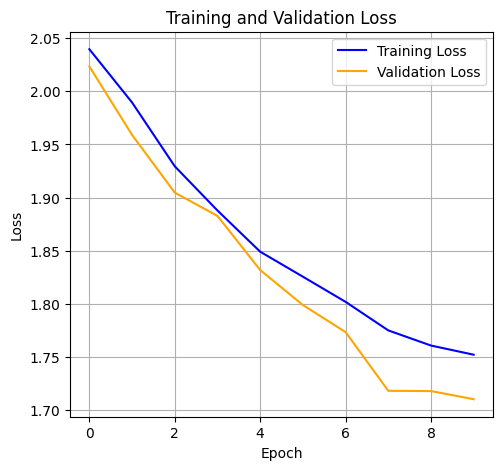

In [51]:
import matplotlib.pyplot as plt
# Plotting Loss and Accuracy
plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()



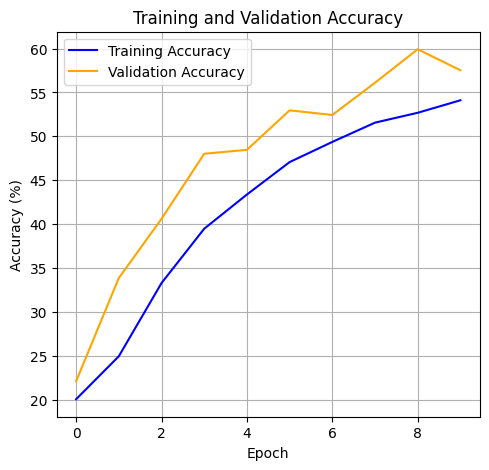

In [52]:
# Accuracy Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Training Accuracy', color='blue')
plt.plot(val_accuracies, label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

In [55]:
# Combine losses and accuracies
train_losses.extend(ft_train_losses)
val_losses.extend(ft_val_losses)
train_accuracies.extend(ft_train_accuracies)
val_accuracies.extend(ft_val_accuracies)

NameError: name 'ft_train_losses' is not defined

In [62]:
# Save final model
torch.save(best_weights, '/kaggle/working/hybrid_trash_classifier.pth')
with tarfile.open('/kaggle/working/hybrid_trash_classifier.pth.tar.gz', 'w:gz') as tar:
    tar.add('/kaggle/working/hybrid_trash_classifier.pth', arcname='hybrid_trash_classifier.pth')
print("Final model saved successfully (compressed as .pth.tar.gz)!", flush=True)

Final model saved successfully (compressed as .pth.tar.gz)!


In [58]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}", flush=True)

Using device: cuda


In [59]:
# Initialize model
num_classes = 8
model = HybridResNeXtGaborModel(num_classes=num_classes).to(device)

# Freeze all parameters initially
for param in model.parameters():
    param.requires_grad = False

# Unfreeze layer3 of resnext1 and resnext2 (as in original notebook)
for param in model.resnext1.layer3.parameters():
    param.requires_grad = True
for param in model.resnext2.layer3.parameters():
    param.requires_grad = True

# Unfreeze gabor_filters, merge_conv, merge_bn, fc1, fc2, fc3 (since they were saved)
for param in model.gabor_filters.parameters():
    param.requires_grad = True
for param in model.gabor_to_rgb.parameters():
    param.requires_grad = True
for param in model.merge_conv.parameters():
    param.requires_grad = True
for param in model.merge_bn.parameters():
    param.requires_grad = True
for param in model.fc1.parameters():
    param.requires_grad = True
for param in model.fc2.parameters():
    param.requires_grad = True
for param in model.fc3.parameters():
    param.requires_grad = True

In [60]:
# Load the existing .pth file
model_path = '/kaggle/input/gabor/pytorch/default/1/hybrid_trash_classifier.pth'
if os.path.exists(model_path):
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint, strict=False)  # Use strict=False since only a subset of parameters is saved
    print(f"Loaded model weights from {model_path}", flush=True)
else:
    raise FileNotFoundError(f"Model file {model_path} not found. Ensure the .pth file is in /kaggle/working/")

Loaded model weights from /kaggle/input/gabor/pytorch/default/1/hybrid_trash_classifier.pth


/tmp/ipykernel_31/1573996047.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


In [61]:
criterion = nn.NLLLoss()

In [62]:
optimizer = optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999))
print("Continuing Adam Phase (10 Epochs, Fine-Tuning)...", flush=True)
ft_train_losses, ft_val_losses, ft_train_accuracies, ft_val_accuracies, best_weights = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=10, phase_name="Adam Fine-Tuning Phase", scaler=scaler
)

Continuing Adam Phase (10 Epochs, Fine-Tuning)...


Adam Fine-Tuning Phase Epoch 1/10 [Train]:   0%|          | 0/126 [00:00<?, ?it/s]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:   0%|          | 0/126 [00:07<?, ?it/s, Batch Loss=3.02]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:   0%|          | 0/126 [00:10<?, ?it/s, Batch Loss=3.03]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:   0%|          | 0/126 [00:13<?, ?it/s, Batch Loss=3.5] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:   3%|▎         | 4/126 [00:17<08:44,  4.30s/it, Batch Loss=3.19]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:   4%|▍         | 5/126 [00:20<08:11,  4.06s/it, Batch Loss=2.99]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:   5%|▍         | 6/126 [00:23<07:44,  3.87s/it, Batch Loss=2.3] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:   6%|▌         | 7/126 [00:27<07:27,  3.76s/it, Batch Loss=2.3]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:   6%|▋         | 8/126 [00:30<07:07,  3.62s/it, Batch Loss=2.08]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:   7%|▋         | 9/126 [00:34<06:57,  3.57s/it, Batch Loss=2.31]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:   8%|▊         | 10/126 [00:37<06:56,  3.59s/it, Batch Loss=1.69]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:   9%|▊         | 11/126 [00:41<06:47,  3.54s/it, Batch Loss=1.33]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  10%|▉         | 12/126 [00:44<06:39,  3.50s/it, Batch Loss=1.81]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  10%|█         | 13/126 [00:47<06:27,  3.43s/it, Batch Loss=1.54]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  11%|█         | 14/126 [00:51<06:24,  3.43s/it, Batch Loss=1.77]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  12%|█▏        | 15/126 [00:54<06:17,  3.40s/it, Batch Loss=1.57]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  13%|█▎        | 16/126 [00:58<06:15,  3.41s/it, Batch Loss=1.61]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  13%|█▎        | 17/126 [01:01<06:12,  3.41s/it, Batch Loss=1.38]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  14%|█▍        | 18/126 [01:04<06:03,  3.37s/it, Batch Loss=1.19]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  15%|█▌        | 19/126 [01:08<06:03,  3.40s/it, Batch Loss=1.18]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  16%|█▌        | 20/126 [01:11<05:56,  3.36s/it, Batch Loss=1.27]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  17%|█▋        | 21/126 [01:14<05:54,  3.38s/it, Batch Loss=1.34]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  17%|█▋        | 22/126 [01:18<05:47,  3.34s/it, Batch Loss=1.34]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  18%|█▊        | 23/126 [01:21<05:46,  3.36s/it, Batch Loss=1.2] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  19%|█▉        | 24/126 [01:25<05:44,  3.37s/it, Batch Loss=1.13]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  20%|█▉        | 25/126 [01:28<05:37,  3.34s/it, Batch Loss=1.36]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  21%|██        | 26/126 [01:31<05:35,  3.35s/it, Batch Loss=1.12]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  21%|██▏       | 27/126 [01:34<05:29,  3.33s/it, Batch Loss=1.34]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  22%|██▏       | 28/126 [01:38<05:28,  3.35s/it, Batch Loss=1.33]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  23%|██▎       | 29/126 [01:41<05:22,  3.32s/it, Batch Loss=1.36]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  24%|██▍       | 30/126 [01:44<05:20,  3.34s/it, Batch Loss=1.16]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  25%|██▍       | 31/126 [01:48<05:15,  3.32s/it, Batch Loss=0.893]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  25%|██▌       | 32/126 [01:51<05:13,  3.34s/it, Batch Loss=1.35] /usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  26%|██▌       | 33/126 [01:55<05:12,  3.35s/it, Batch Loss=1.03]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  27%|██▋       | 34/126 [01:58<05:07,  3.35s/it, Batch Loss=1.5] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  28%|██▊       | 35/126 [02:01<05:05,  3.36s/it, Batch Loss=1.22]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  29%|██▊       | 36/126 [02:04<04:59,  3.33s/it, Batch Loss=1.11]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  29%|██▉       | 37/126 [02:08<04:58,  3.35s/it, Batch Loss=1.05]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  30%|███       | 38/126 [02:11<04:57,  3.39s/it, Batch Loss=0.978]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  31%|███       | 39/126 [02:15<04:55,  3.40s/it, Batch Loss=1.07] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  32%|███▏      | 40/126 [02:18<04:49,  3.36s/it, Batch Loss=0.762]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  33%|███▎      | 41/126 [02:21<04:46,  3.37s/it, Batch Loss=0.85] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  33%|███▎      | 42/126 [02:25<04:44,  3.38s/it, Batch Loss=1.04]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  34%|███▍      | 43/126 [02:28<04:37,  3.34s/it, Batch Loss=1.44]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  35%|███▍      | 44/126 [02:32<04:35,  3.36s/it, Batch Loss=0.899]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  36%|███▌      | 45/126 [02:35<04:29,  3.33s/it, Batch Loss=0.784]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  37%|███▋      | 46/126 [02:38<04:28,  3.35s/it, Batch Loss=0.973]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  37%|███▋      | 47/126 [02:42<04:27,  3.39s/it, Batch Loss=1.14] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  38%|███▊      | 48/126 [02:45<04:21,  3.35s/it, Batch Loss=1.19]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  39%|███▉      | 49/126 [02:48<04:19,  3.37s/it, Batch Loss=1.11]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  40%|███▉      | 50/126 [02:52<04:13,  3.33s/it, Batch Loss=0.805]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  40%|████      | 51/126 [02:55<04:11,  3.36s/it, Batch Loss=1.01] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  41%|████▏     | 52/126 [02:58<04:06,  3.33s/it, Batch Loss=0.848]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  42%|████▏     | 53/126 [03:02<04:05,  3.36s/it, Batch Loss=1.05] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  43%|████▎     | 54/126 [03:05<04:02,  3.37s/it, Batch Loss=0.897]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  44%|████▎     | 55/126 [03:08<03:58,  3.36s/it, Batch Loss=1.26] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  44%|████▍     | 56/126 [03:12<03:56,  3.38s/it, Batch Loss=1.01]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  45%|████▌     | 57/126 [03:15<03:57,  3.44s/it, Batch Loss=0.912]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  46%|████▌     | 58/126 [03:19<03:53,  3.43s/it, Batch Loss=1.01] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  47%|████▋     | 59/126 [03:22<03:46,  3.38s/it, Batch Loss=0.82]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  48%|████▊     | 60/126 [03:26<03:44,  3.40s/it, Batch Loss=0.94]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  48%|████▊     | 61/126 [03:29<03:38,  3.36s/it, Batch Loss=0.789]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  49%|████▉     | 62/126 [03:32<03:35,  3.37s/it, Batch Loss=1.01] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  50%|█████     | 63/126 [03:36<03:31,  3.35s/it, Batch Loss=0.795]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  51%|█████     | 64/126 [03:39<03:28,  3.37s/it, Batch Loss=0.779]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  52%|█████▏    | 65/126 [03:42<03:26,  3.39s/it, Batch Loss=0.566]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  52%|█████▏    | 66/126 [03:46<03:23,  3.39s/it, Batch Loss=1.02] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  53%|█████▎    | 67/126 [03:49<03:20,  3.39s/it, Batch Loss=0.807]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  54%|█████▍    | 68/126 [03:52<03:14,  3.36s/it, Batch Loss=0.477]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  55%|█████▍    | 69/126 [03:56<03:12,  3.39s/it, Batch Loss=0.946]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  56%|█████▌    | 70/126 [03:59<03:07,  3.35s/it, Batch Loss=0.633]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  56%|█████▋    | 71/126 [04:03<03:05,  3.36s/it, Batch Loss=0.944]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  57%|█████▋    | 72/126 [04:06<03:02,  3.38s/it, Batch Loss=1.06] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  58%|█████▊    | 73/126 [04:09<02:57,  3.34s/it, Batch Loss=0.623]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  59%|█████▊    | 74/126 [04:13<02:54,  3.36s/it, Batch Loss=0.628]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  60%|█████▉    | 75/126 [04:16<02:50,  3.34s/it, Batch Loss=0.634]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  60%|██████    | 76/126 [04:19<02:49,  3.39s/it, Batch Loss=0.641]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  61%|██████    | 77/126 [04:23<02:44,  3.35s/it, Batch Loss=0.831]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  62%|██████▏   | 78/126 [04:26<02:41,  3.37s/it, Batch Loss=0.885]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  63%|██████▎   | 79/126 [04:29<02:38,  3.38s/it, Batch Loss=0.753]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  63%|██████▎   | 80/126 [04:33<02:33,  3.34s/it, Batch Loss=1.09] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  64%|██████▍   | 81/126 [04:36<02:31,  3.37s/it, Batch Loss=0.94]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  65%|██████▌   | 82/126 [04:39<02:27,  3.35s/it, Batch Loss=0.801]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  66%|██████▌   | 83/126 [04:43<02:24,  3.36s/it, Batch Loss=0.761]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  67%|██████▋   | 84/126 [04:46<02:19,  3.33s/it, Batch Loss=0.686]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  67%|██████▋   | 85/126 [04:50<02:20,  3.41s/it, Batch Loss=0.682]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  68%|██████▊   | 86/126 [04:53<02:14,  3.36s/it, Batch Loss=0.715]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  69%|██████▉   | 87/126 [04:56<02:11,  3.38s/it, Batch Loss=0.695]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  70%|██████▉   | 88/126 [05:00<02:08,  3.39s/it, Batch Loss=0.946]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  71%|███████   | 89/126 [05:03<02:03,  3.35s/it, Batch Loss=0.479]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  71%|███████▏  | 90/126 [05:06<02:01,  3.37s/it, Batch Loss=0.55] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  72%|███████▏  | 91/126 [05:10<01:57,  3.35s/it, Batch Loss=0.572]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  73%|███████▎  | 92/126 [05:13<01:54,  3.36s/it, Batch Loss=1.04] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  74%|███████▍  | 93/126 [05:17<01:51,  3.39s/it, Batch Loss=0.554]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  75%|███████▍  | 94/126 [05:20<01:48,  3.38s/it, Batch Loss=0.892]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  75%|███████▌  | 95/126 [05:23<01:45,  3.39s/it, Batch Loss=0.878]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  76%|███████▌  | 96/126 [05:27<01:40,  3.36s/it, Batch Loss=0.949]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  77%|███████▋  | 97/126 [05:30<01:37,  3.37s/it, Batch Loss=0.939]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  78%|███████▊  | 98/126 [05:33<01:33,  3.34s/it, Batch Loss=0.84] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  79%|███████▊  | 99/126 [05:37<01:30,  3.37s/it, Batch Loss=0.888]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  79%|███████▉  | 100/126 [05:40<01:27,  3.38s/it, Batch Loss=0.494]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  80%|████████  | 101/126 [05:43<01:23,  3.34s/it, Batch Loss=0.5]  

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  81%|████████  | 102/126 [05:47<01:21,  3.38s/it, Batch Loss=0.737]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  82%|████████▏ | 103/126 [05:50<01:16,  3.34s/it, Batch Loss=1.18] /usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  83%|████████▎ | 104/126 [05:54<01:14,  3.40s/it, Batch Loss=0.807]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  83%|████████▎ | 105/126 [05:57<01:10,  3.37s/it, Batch Loss=0.741]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  84%|████████▍ | 106/126 [06:00<01:07,  3.38s/it, Batch Loss=0.795]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  85%|████████▍ | 107/126 [06:04<01:03,  3.34s/it, Batch Loss=0.881]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  86%|████████▌ | 108/126 [06:07<01:00,  3.37s/it, Batch Loss=0.596]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  87%|████████▋ | 109/126 [06:10<00:57,  3.38s/it, Batch Loss=0.669]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  87%|████████▋ | 110/126 [06:14<00:53,  3.34s/it, Batch Loss=0.514]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  88%|████████▊ | 111/126 [06:17<00:50,  3.37s/it, Batch Loss=0.641]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  89%|████████▉ | 112/126 [06:20<00:46,  3.33s/it, Batch Loss=0.562]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  90%|████████▉ | 113/126 [06:24<00:43,  3.38s/it, Batch Loss=0.69] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  90%|█████████ | 114/126 [06:27<00:40,  3.41s/it, Batch Loss=0.721]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  91%|█████████▏| 115/126 [06:31<00:36,  3.36s/it, Batch Loss=0.797]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  92%|█████████▏| 116/126 [06:34<00:33,  3.37s/it, Batch Loss=0.755]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  93%|█████████▎| 117/126 [06:37<00:30,  3.36s/it, Batch Loss=0.647]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  94%|█████████▎| 118/126 [06:41<00:26,  3.36s/it, Batch Loss=0.653]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  94%|█████████▍| 119/126 [06:44<00:23,  3.32s/it, Batch Loss=0.805]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  95%|█████████▌| 120/126 [06:47<00:20,  3.34s/it, Batch Loss=0.911]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  96%|█████████▌| 121/126 [06:51<00:16,  3.36s/it, Batch Loss=0.609]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  97%|█████████▋| 122/126 [06:54<00:13,  3.33s/it, Batch Loss=0.743]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  98%|█████████▊| 123/126 [06:57<00:10,  3.35s/it, Batch Loss=1.1]  

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  98%|█████████▊| 124/126 [07:01<00:06,  3.32s/it, Batch Loss=0.575]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Train]:  99%|█████████▉| 125/126 [07:04<00:03,  3.34s/it, Batch Loss=0.728]

branch2_gabor shape: torch.Size([5, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Val]:   0%|          | 0/42 [00:00<?, ?it/s]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Val]:   0%|          | 0/42 [00:04<?, ?it/s, Batch Loss=0.326]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Val]:   0%|          | 0/42 [00:06<?, ?it/s, Batch Loss=0.731]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Val]:   0%|          | 0/42 [00:08<?, ?it/s, Batch Loss=0.605]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Val]:  10%|▉         | 4/42 [00:10<01:41,  2.68s/it, Batch Loss=0.468]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Val]:  10%|▉         | 4/42 [00:12<01:41,  2.68s/it, Batch Loss=0.874]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Val]:  10%|▉         | 4/42 [00:14<01:41,  2.68s/it, Batch Loss=0.56] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Val]:  10%|▉         | 4/42 [00:16<01:41,  2.68s/it, Batch Loss=0.619]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Val]:  19%|█▉        | 8/42 [00:19<01:19,  2.33s/it, Batch Loss=0.769]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Val]:  19%|█▉        | 8/42 [00:21<01:19,  2.33s/it, Batch Loss=0.909]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Val]:  19%|█▉        | 8/42 [00:23<01:19,  2.33s/it, Batch Loss=0.479]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Val]:  19%|█▉        | 8/42 [00:25<01:19,  2.33s/it, Batch Loss=0.861]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Val]:  29%|██▊       | 12/42 [00:27<01:05,  2.19s/it, Batch Loss=0.861]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Val]:  29%|██▊       | 12/42 [00:29<01:05,  2.19s/it, Batch Loss=0.731]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Val]:  29%|██▊       | 12/42 [00:31<01:05,  2.19s/it, Batch Loss=0.995]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Val]:  29%|██▊       | 12/42 [00:33<01:05,  2.19s/it, Batch Loss=0.792]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Val]:  38%|███▊      | 16/42 [00:35<00:55,  2.12s/it, Batch Loss=0.715]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Val]:  38%|███▊      | 16/42 [00:37<00:55,  2.12s/it, Batch Loss=0.456]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Val]:  38%|███▊      | 16/42 [00:39<00:55,  2.12s/it, Batch Loss=0.496]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Val]:  38%|███▊      | 16/42 [00:41<00:55,  2.12s/it, Batch Loss=0.896]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Val]:  48%|████▊     | 20/42 [00:43<00:45,  2.08s/it, Batch Loss=0.758]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Val]:  48%|████▊     | 20/42 [00:45<00:45,  2.08s/it, Batch Loss=0.77] /usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Val]:  48%|████▊     | 20/42 [00:47<00:45,  2.08s/it, Batch Loss=0.838]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Val]:  48%|████▊     | 20/42 [00:49<00:45,  2.08s/it, Batch Loss=0.646]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Val]:  57%|█████▋    | 24/42 [00:51<00:37,  2.09s/it, Batch Loss=0.33] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Val]:  57%|█████▋    | 24/42 [00:53<00:37,  2.09s/it, Batch Loss=0.71]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Val]:  57%|█████▋    | 24/42 [00:55<00:37,  2.09s/it, Batch Loss=0.553]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Val]:  57%|█████▋    | 24/42 [00:57<00:37,  2.09s/it, Batch Loss=0.821]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Val]:  67%|██████▋   | 28/42 [00:59<00:28,  2.06s/it, Batch Loss=0.514]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Val]:  67%|██████▋   | 28/42 [01:01<00:28,  2.06s/it, Batch Loss=0.715]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Val]:  67%|██████▋   | 28/42 [01:03<00:28,  2.06s/it, Batch Loss=0.408]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Val]:  67%|██████▋   | 28/42 [01:05<00:28,  2.06s/it, Batch Loss=0.803]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Val]:  76%|███████▌  | 32/42 [01:07<00:20,  2.05s/it, Batch Loss=0.403]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Val]:  76%|███████▌  | 32/42 [01:09<00:20,  2.05s/it, Batch Loss=0.37] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Val]:  76%|███████▌  | 32/42 [01:11<00:20,  2.05s/it, Batch Loss=0.632]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Val]:  76%|███████▌  | 32/42 [01:13<00:20,  2.05s/it, Batch Loss=0.706]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Val]:  86%|████████▌ | 36/42 [01:15<00:12,  2.03s/it, Batch Loss=0.854]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Val]:  86%|████████▌ | 36/42 [01:17<00:12,  2.03s/it, Batch Loss=0.832]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Val]:  86%|████████▌ | 36/42 [01:19<00:12,  2.03s/it, Batch Loss=0.874]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Val]:  86%|████████▌ | 36/42 [01:21<00:12,  2.03s/it, Batch Loss=0.587]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Val]:  95%|█████████▌| 40/42 [01:23<00:04,  2.02s/it, Batch Loss=0.357]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Val]:  95%|█████████▌| 40/42 [01:27<00:04,  2.02s/it, Batch Loss=0.74] 

branch2_gabor shape: torch.Size([23, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 1/10 [Val]: 100%|██████████| 42/42 [01:27<00:00,  2.08s/it, Batch Loss=0.74]

Adam Fine-Tuning Phase Epoch [1/10]
Train Loss: 1.0741, Train Accuracy: 63.00%
Val Loss: 0.6711, Val Accuracy: 76.78%


New best model saved with Val Accuracy: 76.78% (compressed as .pth.tar.gz)


Adam Fine-Tuning Phase Epoch 2/10 [Train]:   0%|          | 0/126 [00:00<?, ?it/s]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:   0%|          | 0/126 [00:06<?, ?it/s, Batch Loss=0.799]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:   0%|          | 0/126 [00:09<?, ?it/s, Batch Loss=0.721]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:   0%|          | 0/126 [00:13<?, ?it/s, Batch Loss=0.409]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:   0%|          | 0/126 [00:16<?, ?it/s, Batch Loss=0.701]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:   4%|▍         | 5/126 [00:19<07:57,  3.95s/it, Batch Loss=0.75]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:   5%|▍         | 6/126 [00:23<07:39,  3.83s/it, Batch Loss=0.496]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:   6%|▌         | 7/126 [00:26<07:29,  3.78s/it, Batch Loss=0.421]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:   6%|▋         | 8/126 [00:30<07:10,  3.65s/it, Batch Loss=0.555]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:   7%|▋         | 9/126 [00:33<06:59,  3.59s/it, Batch Loss=0.851]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:   8%|▊         | 10/126 [00:36<06:45,  3.50s/it, Batch Loss=0.505]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:   9%|▊         | 11/126 [00:40<06:39,  3.47s/it, Batch Loss=0.782]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  10%|▉         | 12/126 [00:43<06:29,  3.41s/it, Batch Loss=0.721]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  10%|█         | 13/126 [00:46<06:26,  3.42s/it, Batch Loss=0.735]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  11%|█         | 14/126 [00:50<06:18,  3.38s/it, Batch Loss=0.654]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  12%|█▏        | 15/126 [00:53<06:15,  3.38s/it, Batch Loss=0.869]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  13%|█▎        | 16/126 [00:56<06:09,  3.36s/it, Batch Loss=0.783]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  13%|█▎        | 17/126 [01:00<06:06,  3.37s/it, Batch Loss=0.504]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  14%|█▍        | 18/126 [01:03<06:04,  3.38s/it, Batch Loss=0.447]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  15%|█▌        | 19/126 [01:06<05:57,  3.34s/it, Batch Loss=1.12] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  16%|█▌        | 20/126 [01:10<05:56,  3.36s/it, Batch Loss=1]   

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  17%|█▋        | 21/126 [01:13<05:49,  3.32s/it, Batch Loss=1.39]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  17%|█▋        | 22/126 [01:16<05:49,  3.36s/it, Batch Loss=0.567]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  18%|█▊        | 23/126 [01:20<05:44,  3.34s/it, Batch Loss=0.649]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  19%|█▉        | 24/126 [01:23<05:43,  3.36s/it, Batch Loss=0.789]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  20%|█▉        | 25/126 [01:27<05:40,  3.37s/it, Batch Loss=0.496]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  21%|██        | 26/126 [01:30<05:36,  3.37s/it, Batch Loss=0.513]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  21%|██▏       | 27/126 [01:33<05:34,  3.38s/it, Batch Loss=0.953]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  22%|██▏       | 28/126 [01:37<05:27,  3.34s/it, Batch Loss=0.709]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  23%|██▎       | 29/126 [01:40<05:25,  3.36s/it, Batch Loss=0.575]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  24%|██▍       | 30/126 [01:43<05:19,  3.33s/it, Batch Loss=0.813]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  25%|██▍       | 31/126 [01:47<05:17,  3.35s/it, Batch Loss=0.63] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  25%|██▌       | 32/126 [01:50<05:16,  3.36s/it, Batch Loss=0.483]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  26%|██▌       | 33/126 [01:53<05:10,  3.34s/it, Batch Loss=0.589]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  27%|██▋       | 34/126 [01:57<05:09,  3.36s/it, Batch Loss=0.531]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  28%|██▊       | 35/126 [02:00<05:04,  3.34s/it, Batch Loss=0.661]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  29%|██▊       | 36/126 [02:03<05:02,  3.36s/it, Batch Loss=0.816]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  29%|██▉       | 37/126 [02:07<04:56,  3.33s/it, Batch Loss=0.427]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  30%|███       | 38/126 [02:10<04:54,  3.35s/it, Batch Loss=0.587]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  31%|███       | 39/126 [02:13<04:48,  3.32s/it, Batch Loss=0.516]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  32%|███▏      | 40/126 [02:17<04:47,  3.35s/it, Batch Loss=0.64] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  33%|███▎      | 41/126 [02:20<04:45,  3.36s/it, Batch Loss=0.453]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  33%|███▎      | 42/126 [02:23<04:39,  3.33s/it, Batch Loss=0.757]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  34%|███▍      | 43/126 [02:27<04:39,  3.36s/it, Batch Loss=0.493]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  35%|███▍      | 44/126 [02:30<04:34,  3.35s/it, Batch Loss=0.33] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  36%|███▌      | 45/126 [02:34<04:33,  3.37s/it, Batch Loss=0.59]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  37%|███▋      | 46/126 [02:37<04:30,  3.38s/it, Batch Loss=0.438]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  37%|███▋      | 47/126 [02:40<04:25,  3.36s/it, Batch Loss=0.323]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  38%|███▊      | 48/126 [02:44<04:22,  3.37s/it, Batch Loss=0.712]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  39%|███▉      | 49/126 [02:47<04:16,  3.33s/it, Batch Loss=0.304]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  40%|███▉      | 50/126 [02:50<04:15,  3.36s/it, Batch Loss=0.409]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  40%|████      | 51/126 [02:54<04:09,  3.33s/it, Batch Loss=0.815]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  41%|████▏     | 52/126 [02:57<04:07,  3.35s/it, Batch Loss=0.948]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  42%|████▏     | 53/126 [03:00<04:06,  3.37s/it, Batch Loss=0.424]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  43%|████▎     | 54/126 [03:04<04:03,  3.38s/it, Batch Loss=0.475]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  44%|████▎     | 55/126 [03:07<04:00,  3.39s/it, Batch Loss=0.69] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  44%|████▍     | 56/126 [03:11<03:55,  3.36s/it, Batch Loss=0.356]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  45%|████▌     | 57/126 [03:14<03:52,  3.37s/it, Batch Loss=0.552]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  46%|████▌     | 58/126 [03:17<03:46,  3.33s/it, Batch Loss=0.75] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  47%|████▋     | 59/126 [03:21<03:45,  3.36s/it, Batch Loss=0.378]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  48%|████▊     | 60/126 [03:24<03:39,  3.33s/it, Batch Loss=0.601]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  48%|████▊     | 61/126 [03:27<03:37,  3.35s/it, Batch Loss=0.483]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  49%|████▉     | 62/126 [03:31<03:37,  3.40s/it, Batch Loss=0.671]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  50%|█████     | 63/126 [03:34<03:31,  3.35s/it, Batch Loss=0.755]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  51%|█████     | 64/126 [03:37<03:29,  3.38s/it, Batch Loss=0.574]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  52%|█████▏    | 65/126 [03:41<03:24,  3.36s/it, Batch Loss=0.572]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  52%|█████▏    | 66/126 [03:44<03:22,  3.37s/it, Batch Loss=0.521]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  53%|█████▎    | 67/126 [03:48<03:20,  3.39s/it, Batch Loss=0.54] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  54%|█████▍    | 68/126 [03:51<03:15,  3.38s/it, Batch Loss=0.365]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  55%|█████▍    | 69/126 [03:54<03:13,  3.39s/it, Batch Loss=0.942]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  56%|█████▌    | 70/126 [03:58<03:09,  3.38s/it, Batch Loss=0.635]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  56%|█████▋    | 71/126 [04:01<03:06,  3.40s/it, Batch Loss=0.409]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  57%|█████▋    | 72/126 [04:04<03:01,  3.36s/it, Batch Loss=0.764]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  58%|█████▊    | 73/126 [04:08<03:01,  3.43s/it, Batch Loss=0.538]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  59%|█████▊    | 74/126 [04:11<02:58,  3.44s/it, Batch Loss=0.538]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  60%|█████▉    | 75/126 [04:15<02:52,  3.38s/it, Batch Loss=0.474]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  60%|██████    | 76/126 [04:18<02:49,  3.39s/it, Batch Loss=0.777]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  61%|██████    | 77/126 [04:21<02:44,  3.35s/it, Batch Loss=0.418]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  62%|██████▏   | 78/126 [04:25<02:41,  3.37s/it, Batch Loss=0.722]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  63%|██████▎   | 79/126 [04:28<02:36,  3.33s/it, Batch Loss=0.775]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  63%|██████▎   | 80/126 [04:31<02:34,  3.36s/it, Batch Loss=0.631]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  64%|██████▍   | 81/126 [04:35<02:29,  3.33s/it, Batch Loss=0.586]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  65%|██████▌   | 82/126 [04:38<02:28,  3.38s/it, Batch Loss=0.687]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  66%|██████▌   | 83/126 [04:42<02:26,  3.40s/it, Batch Loss=0.614]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  67%|██████▋   | 84/126 [04:45<02:21,  3.36s/it, Batch Loss=0.848]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  67%|██████▋   | 85/126 [04:48<02:18,  3.38s/it, Batch Loss=0.774]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  68%|██████▊   | 86/126 [04:52<02:14,  3.36s/it, Batch Loss=0.605]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  69%|██████▉   | 87/126 [04:55<02:11,  3.38s/it, Batch Loss=0.751]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  70%|██████▉   | 88/126 [04:58<02:08,  3.39s/it, Batch Loss=0.748]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  71%|███████   | 89/126 [05:02<02:04,  3.36s/it, Batch Loss=0.7]  

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  71%|███████▏  | 90/126 [05:05<02:01,  3.37s/it, Batch Loss=0.496]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  72%|███████▏  | 91/126 [05:09<01:57,  3.36s/it, Batch Loss=0.629]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  73%|███████▎  | 92/126 [05:12<01:56,  3.42s/it, Batch Loss=0.416]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  74%|███████▍  | 93/126 [05:15<01:51,  3.38s/it, Batch Loss=0.635]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  75%|███████▍  | 94/126 [05:19<01:48,  3.39s/it, Batch Loss=0.35] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  75%|███████▌  | 95/126 [05:22<01:45,  3.40s/it, Batch Loss=0.752]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  76%|███████▌  | 96/126 [05:25<01:40,  3.35s/it, Batch Loss=0.548]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  77%|███████▋  | 97/126 [05:29<01:37,  3.36s/it, Batch Loss=0.352]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  78%|███████▊  | 98/126 [05:32<01:33,  3.33s/it, Batch Loss=0.649]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  79%|███████▊  | 99/126 [05:35<01:30,  3.35s/it, Batch Loss=0.671]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  79%|███████▉  | 100/126 [05:39<01:26,  3.32s/it, Batch Loss=0.36]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  80%|████████  | 101/126 [05:42<01:24,  3.37s/it, Batch Loss=0.626]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  81%|████████  | 102/126 [05:45<01:20,  3.34s/it, Batch Loss=0.476]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  82%|████████▏ | 103/126 [05:49<01:17,  3.35s/it, Batch Loss=0.574]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  83%|████████▎ | 104/126 [05:52<01:14,  3.36s/it, Batch Loss=0.415]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  83%|████████▎ | 105/126 [05:56<01:09,  3.33s/it, Batch Loss=0.353]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  84%|████████▍ | 106/126 [05:59<01:06,  3.35s/it, Batch Loss=0.407]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  85%|████████▍ | 107/126 [06:02<01:03,  3.32s/it, Batch Loss=0.653]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  86%|████████▌ | 108/126 [06:06<01:00,  3.35s/it, Batch Loss=0.669]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  87%|████████▋ | 109/126 [06:09<00:57,  3.37s/it, Batch Loss=0.694]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  87%|████████▋ | 110/126 [06:12<00:53,  3.34s/it, Batch Loss=0.805]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  88%|████████▊ | 111/126 [06:16<00:50,  3.36s/it, Batch Loss=0.547]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  89%|████████▉ | 112/126 [06:19<00:46,  3.33s/it, Batch Loss=0.89] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  90%|████████▉ | 113/126 [06:22<00:43,  3.35s/it, Batch Loss=0.788]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  90%|█████████ | 114/126 [06:26<00:39,  3.32s/it, Batch Loss=0.499]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  91%|█████████▏| 115/126 [06:29<00:36,  3.35s/it, Batch Loss=0.515]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  92%|█████████▏| 116/126 [06:32<00:33,  3.36s/it, Batch Loss=0.511]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  93%|█████████▎| 117/126 [06:36<00:29,  3.32s/it, Batch Loss=0.548]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  94%|█████████▎| 118/126 [06:39<00:26,  3.34s/it, Batch Loss=0.386]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  94%|█████████▍| 119/126 [06:42<00:23,  3.31s/it, Batch Loss=0.354]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  95%|█████████▌| 120/126 [06:46<00:20,  3.35s/it, Batch Loss=0.838]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  96%|█████████▌| 121/126 [06:49<00:16,  3.31s/it, Batch Loss=0.695]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  97%|█████████▋| 122/126 [06:52<00:13,  3.33s/it, Batch Loss=0.569]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  98%|█████████▊| 123/126 [06:55<00:09,  3.30s/it, Batch Loss=0.765]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  98%|█████████▊| 124/126 [06:59<00:06,  3.32s/it, Batch Loss=0.352]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Train]:  99%|█████████▉| 125/126 [07:02<00:03,  3.34s/it, Batch Loss=0.788]

branch2_gabor shape: torch.Size([5, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Val]:   0%|          | 0/42 [00:00<?, ?it/s]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Val]:   0%|          | 0/42 [00:04<?, ?it/s, Batch Loss=0.662]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Val]:   0%|          | 0/42 [00:06<?, ?it/s, Batch Loss=0.591]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Val]:   0%|          | 0/42 [00:08<?, ?it/s, Batch Loss=0.546]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Val]:  10%|▉         | 4/42 [00:10<01:41,  2.66s/it, Batch Loss=0.327]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Val]:  10%|▉         | 4/42 [00:12<01:41,  2.66s/it, Batch Loss=0.778]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Val]:  10%|▉         | 4/42 [00:14<01:41,  2.66s/it, Batch Loss=0.592]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Val]:  10%|▉         | 4/42 [00:16<01:41,  2.66s/it, Batch Loss=0.357]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Val]:  19%|█▉        | 8/42 [00:18<01:17,  2.28s/it, Batch Loss=0.672]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Val]:  19%|█▉        | 8/42 [00:20<01:17,  2.28s/it, Batch Loss=0.764]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Val]:  19%|█▉        | 8/42 [00:22<01:17,  2.28s/it, Batch Loss=0.335]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Val]:  19%|█▉        | 8/42 [00:24<01:17,  2.28s/it, Batch Loss=0.548]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Val]:  29%|██▊       | 12/42 [00:26<01:04,  2.15s/it, Batch Loss=0.938]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Val]:  29%|██▊       | 12/42 [00:28<01:04,  2.15s/it, Batch Loss=0.55] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Val]:  29%|██▊       | 12/42 [00:30<01:04,  2.15s/it, Batch Loss=0.485]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Val]:  29%|██▊       | 12/42 [00:32<01:04,  2.15s/it, Batch Loss=0.3]  

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Val]:  38%|███▊      | 16/42 [00:34<00:54,  2.10s/it, Batch Loss=0.683]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Val]:  38%|███▊      | 16/42 [00:36<00:54,  2.10s/it, Batch Loss=0.391]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Val]:  38%|███▊      | 16/42 [00:38<00:54,  2.10s/it, Batch Loss=0.508]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Val]:  38%|███▊      | 16/42 [00:40<00:54,  2.10s/it, Batch Loss=0.389]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Val]:  48%|████▊     | 20/42 [00:42<00:45,  2.08s/it, Batch Loss=0.393]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Val]:  48%|████▊     | 20/42 [00:44<00:45,  2.08s/it, Batch Loss=0.566]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Val]:  48%|████▊     | 20/42 [00:46<00:45,  2.08s/it, Batch Loss=0.523]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Val]:  48%|████▊     | 20/42 [00:48<00:45,  2.08s/it, Batch Loss=0.497]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Val]:  57%|█████▋    | 24/42 [00:50<00:36,  2.05s/it, Batch Loss=0.398]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Val]:  57%|█████▋    | 24/42 [00:52<00:36,  2.05s/it, Batch Loss=0.754]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Val]:  57%|█████▋    | 24/42 [00:54<00:36,  2.05s/it, Batch Loss=0.444]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Val]:  57%|█████▋    | 24/42 [00:56<00:36,  2.05s/it, Batch Loss=0.692]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Val]:  67%|██████▋   | 28/42 [00:58<00:28,  2.03s/it, Batch Loss=0.443]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Val]:  67%|██████▋   | 28/42 [01:00<00:28,  2.03s/it, Batch Loss=0.785]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Val]:  67%|██████▋   | 28/42 [01:02<00:28,  2.03s/it, Batch Loss=0.536]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Val]:  67%|██████▋   | 28/42 [01:04<00:28,  2.03s/it, Batch Loss=0.799]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Val]:  76%|███████▌  | 32/42 [01:06<00:20,  2.02s/it, Batch Loss=0.627]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Val]:  76%|███████▌  | 32/42 [01:08<00:20,  2.02s/it, Batch Loss=0.412]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Val]:  76%|███████▌  | 32/42 [01:10<00:20,  2.02s/it, Batch Loss=0.73] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Val]:  76%|███████▌  | 32/42 [01:12<00:20,  2.02s/it, Batch Loss=0.524]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Val]:  86%|████████▌ | 36/42 [01:14<00:12,  2.01s/it, Batch Loss=0.315]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Val]:  86%|████████▌ | 36/42 [01:16<00:12,  2.01s/it, Batch Loss=0.516]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Val]:  86%|████████▌ | 36/42 [01:18<00:12,  2.01s/it, Batch Loss=0.767]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Val]:  86%|████████▌ | 36/42 [01:20<00:12,  2.01s/it, Batch Loss=0.701]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Val]:  95%|█████████▌| 40/42 [01:22<00:04,  2.00s/it, Batch Loss=0.516]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Val]:  95%|█████████▌| 40/42 [01:26<00:04,  2.00s/it, Batch Loss=0.71] 

branch2_gabor shape: torch.Size([23, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 2/10 [Val]: 100%|██████████| 42/42 [01:26<00:00,  2.06s/it, Batch Loss=0.71]

Adam Fine-Tuning Phase Epoch [2/10]
Train Loss: 0.6161, Train Accuracy: 77.30%
Val Loss: 0.5617, Val Accuracy: 79.03%


New best model saved with Val Accuracy: 79.03% (compressed as .pth.tar.gz)


Adam Fine-Tuning Phase Epoch 3/10 [Train]:   0%|          | 0/126 [00:00<?, ?it/s]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:   0%|          | 0/126 [00:05<?, ?it/s, Batch Loss=0.688]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:   0%|          | 0/126 [00:08<?, ?it/s, Batch Loss=0.596]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:   0%|          | 0/126 [00:12<?, ?it/s, Batch Loss=0.911]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:   0%|          | 0/126 [00:16<?, ?it/s, Batch Loss=0.688]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:   4%|▍         | 5/126 [00:19<07:44,  3.84s/it, Batch Loss=0.661]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:   5%|▍         | 6/126 [00:22<07:29,  3.75s/it, Batch Loss=0.377]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:   6%|▌         | 7/126 [00:25<07:11,  3.63s/it, Batch Loss=0.471]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:   6%|▋         | 8/126 [00:29<07:04,  3.60s/it, Batch Loss=0.292]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:   7%|▋         | 9/126 [00:32<06:51,  3.51s/it, Batch Loss=0.567]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:   8%|▊         | 10/126 [00:36<06:46,  3.50s/it, Batch Loss=0.769]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:   9%|▊         | 11/126 [00:39<06:37,  3.46s/it, Batch Loss=0.546]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  10%|▉         | 12/126 [00:42<06:33,  3.45s/it, Batch Loss=0.629]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  10%|█         | 13/126 [00:46<06:29,  3.45s/it, Batch Loss=0.552]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  11%|█         | 14/126 [00:49<06:22,  3.42s/it, Batch Loss=0.435]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  12%|█▏        | 15/126 [00:53<06:19,  3.42s/it, Batch Loss=0.496]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  13%|█▎        | 16/126 [00:56<06:13,  3.40s/it, Batch Loss=0.334]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  13%|█▎        | 17/126 [00:59<06:11,  3.41s/it, Batch Loss=0.698]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  14%|█▍        | 18/126 [01:03<06:04,  3.37s/it, Batch Loss=0.395]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  15%|█▌        | 19/126 [01:06<06:02,  3.38s/it, Batch Loss=0.373]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  16%|█▌        | 20/126 [01:10<06:01,  3.41s/it, Batch Loss=0.466]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  17%|█▋        | 21/126 [01:13<05:52,  3.36s/it, Batch Loss=0.446]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  17%|█▋        | 22/126 [01:16<05:50,  3.37s/it, Batch Loss=0.466]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  18%|█▊        | 23/126 [01:20<05:44,  3.35s/it, Batch Loss=0.423]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  19%|█▉        | 24/126 [01:23<05:44,  3.38s/it, Batch Loss=0.575]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  20%|█▉        | 25/126 [01:26<05:37,  3.34s/it, Batch Loss=0.409]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  21%|██        | 26/126 [01:30<05:37,  3.37s/it, Batch Loss=0.264]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  21%|██▏       | 27/126 [01:33<05:34,  3.38s/it, Batch Loss=0.32] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  22%|██▏       | 28/126 [01:36<05:27,  3.35s/it, Batch Loss=0.399]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  23%|██▎       | 29/126 [01:40<05:26,  3.37s/it, Batch Loss=0.463]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  24%|██▍       | 30/126 [01:43<05:20,  3.34s/it, Batch Loss=0.272]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  25%|██▍       | 31/126 [01:46<05:20,  3.38s/it, Batch Loss=0.719]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  25%|██▌       | 32/126 [01:50<05:13,  3.34s/it, Batch Loss=0.497]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  26%|██▌       | 33/126 [01:53<05:13,  3.37s/it, Batch Loss=0.506]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  27%|██▋       | 34/126 [01:56<05:06,  3.34s/it, Batch Loss=0.407]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  28%|██▊       | 35/126 [02:00<05:05,  3.36s/it, Batch Loss=0.346]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  29%|██▊       | 36/126 [02:03<05:03,  3.37s/it, Batch Loss=0.713]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  29%|██▉       | 37/126 [02:06<04:56,  3.34s/it, Batch Loss=0.4]  

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  30%|███       | 38/126 [02:10<04:55,  3.36s/it, Batch Loss=0.391]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  31%|███       | 39/126 [02:13<04:51,  3.35s/it, Batch Loss=0.333]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  32%|███▏      | 40/126 [02:17<04:49,  3.36s/it, Batch Loss=0.628]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  33%|███▎      | 41/126 [02:20<04:46,  3.37s/it, Batch Loss=0.601]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  33%|███▎      | 42/126 [02:23<04:42,  3.36s/it, Batch Loss=0.48] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  34%|███▍      | 43/126 [02:27<04:40,  3.38s/it, Batch Loss=0.419]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  35%|███▍      | 44/126 [02:30<04:33,  3.34s/it, Batch Loss=0.583]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  36%|███▌      | 45/126 [02:33<04:31,  3.36s/it, Batch Loss=0.496]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  37%|███▋      | 46/126 [02:37<04:26,  3.33s/it, Batch Loss=0.419]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  37%|███▋      | 47/126 [02:40<04:24,  3.35s/it, Batch Loss=0.348]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  38%|███▊      | 48/126 [02:43<04:22,  3.37s/it, Batch Loss=0.481]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  39%|███▉      | 49/126 [02:47<04:16,  3.33s/it, Batch Loss=0.41] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  40%|███▉      | 50/126 [02:50<04:15,  3.36s/it, Batch Loss=0.673]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  40%|████      | 51/126 [02:53<04:09,  3.32s/it, Batch Loss=0.428]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  41%|████▏     | 52/126 [02:57<04:09,  3.37s/it, Batch Loss=0.893]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  42%|████▏     | 53/126 [03:00<04:03,  3.34s/it, Batch Loss=0.482]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  43%|████▎     | 54/126 [03:04<04:02,  3.36s/it, Batch Loss=0.388]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  44%|████▎     | 55/126 [03:07<03:56,  3.34s/it, Batch Loss=0.643]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  44%|████▍     | 56/126 [03:10<03:54,  3.35s/it, Batch Loss=1.19] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  45%|████▌     | 57/126 [03:14<03:52,  3.37s/it, Batch Loss=0.355]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  46%|████▌     | 58/126 [03:17<03:46,  3.34s/it, Batch Loss=0.63] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  47%|████▋     | 59/126 [03:20<03:44,  3.35s/it, Batch Loss=0.369]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  48%|████▊     | 60/126 [03:24<03:39,  3.32s/it, Batch Loss=0.52] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  48%|████▊     | 61/126 [03:27<03:37,  3.35s/it, Batch Loss=0.184]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  49%|████▉     | 62/126 [03:30<03:36,  3.38s/it, Batch Loss=0.598]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  50%|█████     | 63/126 [03:34<03:30,  3.34s/it, Batch Loss=0.436]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  51%|█████     | 64/126 [03:37<03:28,  3.36s/it, Batch Loss=0.769]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  52%|█████▏    | 65/126 [03:40<03:22,  3.32s/it, Batch Loss=0.47] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  52%|█████▏    | 66/126 [03:44<03:21,  3.35s/it, Batch Loss=0.727]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  53%|█████▎    | 67/126 [03:47<03:16,  3.32s/it, Batch Loss=0.871]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  54%|█████▍    | 68/126 [03:50<03:14,  3.35s/it, Batch Loss=0.443]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  55%|█████▍    | 69/126 [03:54<03:12,  3.38s/it, Batch Loss=0.742]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  56%|█████▌    | 70/126 [03:57<03:06,  3.34s/it, Batch Loss=0.514]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  56%|█████▋    | 71/126 [04:01<03:06,  3.39s/it, Batch Loss=0.757]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  57%|█████▋    | 72/126 [04:04<03:01,  3.36s/it, Batch Loss=0.551]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  58%|█████▊    | 73/126 [04:07<02:58,  3.36s/it, Batch Loss=0.476]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  59%|█████▊    | 74/126 [04:11<02:53,  3.33s/it, Batch Loss=0.743]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  60%|█████▉    | 75/126 [04:14<02:51,  3.35s/it, Batch Loss=0.443]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  60%|██████    | 76/126 [04:17<02:46,  3.33s/it, Batch Loss=0.34] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  61%|██████    | 77/126 [04:21<02:43,  3.35s/it, Batch Loss=0.673]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  62%|██████▏   | 78/126 [04:24<02:41,  3.37s/it, Batch Loss=0.702]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  63%|██████▎   | 79/126 [04:27<02:36,  3.33s/it, Batch Loss=0.591]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  63%|██████▎   | 80/126 [04:31<02:34,  3.36s/it, Batch Loss=0.382]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  64%|██████▍   | 81/126 [04:34<02:29,  3.33s/it, Batch Loss=0.369]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  65%|██████▌   | 82/126 [04:37<02:27,  3.35s/it, Batch Loss=0.351]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  66%|██████▌   | 83/126 [04:41<02:24,  3.37s/it, Batch Loss=0.633]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  67%|██████▋   | 84/126 [04:44<02:19,  3.33s/it, Batch Loss=0.771]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  67%|██████▋   | 85/126 [04:47<02:17,  3.35s/it, Batch Loss=0.719]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  68%|██████▊   | 86/126 [04:51<02:13,  3.33s/it, Batch Loss=0.883]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  69%|██████▉   | 87/126 [04:54<02:10,  3.35s/it, Batch Loss=0.303]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  70%|██████▉   | 88/126 [04:57<02:06,  3.32s/it, Batch Loss=0.492]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  71%|███████   | 89/126 [05:01<02:03,  3.34s/it, Batch Loss=0.387]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  71%|███████▏  | 90/126 [05:04<02:02,  3.40s/it, Batch Loss=0.385]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  72%|███████▏  | 91/126 [05:08<01:57,  3.36s/it, Batch Loss=0.464]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  73%|███████▎  | 92/126 [05:11<01:54,  3.37s/it, Batch Loss=0.61] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  74%|███████▍  | 93/126 [05:14<01:49,  3.33s/it, Batch Loss=0.278]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  75%|███████▍  | 94/126 [05:18<01:47,  3.36s/it, Batch Loss=0.567]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  75%|███████▌  | 95/126 [05:21<01:43,  3.33s/it, Batch Loss=0.392]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  76%|███████▌  | 96/126 [05:24<01:40,  3.35s/it, Batch Loss=0.636]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  77%|███████▋  | 97/126 [05:27<01:36,  3.32s/it, Batch Loss=0.249]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  78%|███████▊  | 98/126 [05:31<01:33,  3.34s/it, Batch Loss=0.46] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  79%|███████▊  | 99/126 [05:34<01:31,  3.37s/it, Batch Loss=0.489]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  79%|███████▉  | 100/126 [05:38<01:26,  3.34s/it, Batch Loss=0.558]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  80%|████████  | 101/126 [05:41<01:24,  3.36s/it, Batch Loss=0.532]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  81%|████████  | 102/126 [05:44<01:19,  3.33s/it, Batch Loss=0.414]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  82%|████████▏ | 103/126 [05:48<01:17,  3.36s/it, Batch Loss=0.463]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  83%|████████▎ | 104/126 [05:51<01:14,  3.37s/it, Batch Loss=0.714]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  83%|████████▎ | 105/126 [05:54<01:09,  3.33s/it, Batch Loss=0.276]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  84%|████████▍ | 106/126 [05:58<01:07,  3.36s/it, Batch Loss=0.7]  

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  85%|████████▍ | 107/126 [06:01<01:03,  3.33s/it, Batch Loss=0.563]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  86%|████████▌ | 108/126 [06:04<01:00,  3.35s/it, Batch Loss=0.236]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  87%|████████▋ | 109/126 [06:08<00:56,  3.33s/it, Batch Loss=0.41] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  87%|████████▋ | 110/126 [06:11<00:53,  3.35s/it, Batch Loss=0.469]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  88%|████████▊ | 111/126 [06:15<00:50,  3.37s/it, Batch Loss=0.355]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  89%|████████▉ | 112/126 [06:18<00:46,  3.35s/it, Batch Loss=0.513]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  90%|████████▉ | 113/126 [06:21<00:43,  3.37s/it, Batch Loss=0.402]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  90%|█████████ | 114/126 [06:24<00:39,  3.33s/it, Batch Loss=0.5]  

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  91%|█████████▏| 115/126 [06:28<00:37,  3.37s/it, Batch Loss=0.334]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  92%|█████████▏| 116/126 [06:31<00:33,  3.34s/it, Batch Loss=1.09] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  93%|█████████▎| 117/126 [06:35<00:30,  3.37s/it, Batch Loss=0.483]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  94%|█████████▎| 118/126 [06:38<00:26,  3.36s/it, Batch Loss=0.693]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  94%|█████████▍| 119/126 [06:41<00:23,  3.37s/it, Batch Loss=0.682]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  95%|█████████▌| 120/126 [06:45<00:20,  3.38s/it, Batch Loss=0.368]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  96%|█████████▌| 121/126 [06:48<00:16,  3.35s/it, Batch Loss=0.462]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  97%|█████████▋| 122/126 [06:51<00:13,  3.36s/it, Batch Loss=0.349]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  98%|█████████▊| 123/126 [06:55<00:09,  3.32s/it, Batch Loss=0.625]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  98%|█████████▊| 124/126 [06:58<00:06,  3.35s/it, Batch Loss=0.572]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Train]:  99%|█████████▉| 125/126 [07:01<00:03,  3.36s/it, Batch Loss=0.753]

branch2_gabor shape: torch.Size([5, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Val]:   0%|          | 0/42 [00:00<?, ?it/s]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Val]:   0%|          | 0/42 [00:04<?, ?it/s, Batch Loss=0.322]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Val]:   0%|          | 0/42 [00:06<?, ?it/s, Batch Loss=0.594]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Val]:   0%|          | 0/42 [00:08<?, ?it/s, Batch Loss=0.733]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Val]:  10%|▉         | 4/42 [00:10<01:44,  2.74s/it, Batch Loss=0.236]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Val]:  10%|▉         | 4/42 [00:12<01:44,  2.74s/it, Batch Loss=0.528]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Val]:  10%|▉         | 4/42 [00:14<01:44,  2.74s/it, Batch Loss=0.642]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Val]:  10%|▉         | 4/42 [00:16<01:44,  2.74s/it, Batch Loss=0.805]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Val]:  19%|█▉        | 8/42 [00:18<01:18,  2.31s/it, Batch Loss=0.718]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Val]:  19%|█▉        | 8/42 [00:20<01:18,  2.31s/it, Batch Loss=0.354]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Val]:  19%|█▉        | 8/42 [00:22<01:18,  2.31s/it, Batch Loss=0.256]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Val]:  19%|█▉        | 8/42 [00:24<01:18,  2.31s/it, Batch Loss=0.777]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Val]:  29%|██▊       | 12/42 [00:26<01:04,  2.16s/it, Batch Loss=0.556]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Val]:  29%|██▊       | 12/42 [00:28<01:04,  2.16s/it, Batch Loss=0.505]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Val]:  29%|██▊       | 12/42 [00:30<01:04,  2.16s/it, Batch Loss=0.295]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Val]:  29%|██▊       | 12/42 [00:33<01:04,  2.16s/it, Batch Loss=0.665]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Val]:  38%|███▊      | 16/42 [00:34<00:54,  2.10s/it, Batch Loss=0.569]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Val]:  38%|███▊      | 16/42 [00:37<00:54,  2.10s/it, Batch Loss=0.577]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Val]:  38%|███▊      | 16/42 [00:39<00:54,  2.10s/it, Batch Loss=0.494]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Val]:  38%|███▊      | 16/42 [00:41<00:54,  2.10s/it, Batch Loss=0.633]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Val]:  48%|████▊     | 20/42 [00:43<00:45,  2.09s/it, Batch Loss=0.538]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Val]:  48%|████▊     | 20/42 [00:45<00:45,  2.09s/it, Batch Loss=0.662]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Val]:  48%|████▊     | 20/42 [00:47<00:45,  2.09s/it, Batch Loss=0.576]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Val]:  48%|████▊     | 20/42 [00:49<00:45,  2.09s/it, Batch Loss=0.635]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Val]:  57%|█████▋    | 24/42 [00:51<00:37,  2.06s/it, Batch Loss=0.463]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Val]:  57%|█████▋    | 24/42 [00:53<00:37,  2.06s/it, Batch Loss=0.635]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Val]:  57%|█████▋    | 24/42 [00:55<00:37,  2.06s/it, Batch Loss=0.443]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Val]:  57%|█████▋    | 24/42 [00:57<00:37,  2.06s/it, Batch Loss=0.567]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Val]:  67%|██████▋   | 28/42 [00:59<00:28,  2.04s/it, Batch Loss=0.479]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Val]:  67%|██████▋   | 28/42 [01:01<00:28,  2.04s/it, Batch Loss=0.654]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Val]:  67%|██████▋   | 28/42 [01:03<00:28,  2.04s/it, Batch Loss=0.468]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Val]:  67%|██████▋   | 28/42 [01:05<00:28,  2.04s/it, Batch Loss=0.508]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Val]:  76%|███████▌  | 32/42 [01:07<00:20,  2.04s/it, Batch Loss=0.188]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Val]:  76%|███████▌  | 32/42 [01:09<00:20,  2.04s/it, Batch Loss=0.252]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Val]:  76%|███████▌  | 32/42 [01:11<00:20,  2.04s/it, Batch Loss=0.518]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Val]:  76%|███████▌  | 32/42 [01:13<00:20,  2.04s/it, Batch Loss=0.216]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Val]:  86%|████████▌ | 36/42 [01:15<00:12,  2.03s/it, Batch Loss=0.565]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Val]:  86%|████████▌ | 36/42 [01:17<00:12,  2.03s/it, Batch Loss=0.546]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Val]:  86%|████████▌ | 36/42 [01:19<00:12,  2.03s/it, Batch Loss=0.549]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Val]:  86%|████████▌ | 36/42 [01:21<00:12,  2.03s/it, Batch Loss=0.554]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Val]:  95%|█████████▌| 40/42 [01:23<00:04,  2.01s/it, Batch Loss=0.261]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Val]:  95%|█████████▌| 40/42 [01:26<00:04,  2.01s/it, Batch Loss=0.471]

branch2_gabor shape: torch.Size([23, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 3/10 [Val]: 100%|██████████| 42/42 [01:26<00:00,  2.07s/it, Batch Loss=0.471]

Adam Fine-Tuning Phase Epoch [3/10]
Train Loss: 0.5236, Train Accuracy: 80.95%
Val Loss: 0.5128, Val Accuracy: 82.10%


New best model saved with Val Accuracy: 82.10% (compressed as .pth.tar.gz)


Adam Fine-Tuning Phase Epoch 4/10 [Train]:   0%|          | 0/126 [00:00<?, ?it/s]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:   0%|          | 0/126 [00:05<?, ?it/s, Batch Loss=0.586]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:   0%|          | 0/126 [00:08<?, ?it/s, Batch Loss=0.401]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:   0%|          | 0/126 [00:14<?, ?it/s, Batch Loss=0.423]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:   3%|▎         | 4/126 [00:15<07:56,  3.91s/it, Batch Loss=0.498]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:   4%|▍         | 5/126 [00:19<07:36,  3.77s/it, Batch Loss=0.562]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:   5%|▍         | 6/126 [00:22<07:20,  3.67s/it, Batch Loss=0.545]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:   6%|▌         | 7/126 [00:25<07:02,  3.55s/it, Batch Loss=0.432]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:   6%|▋         | 8/126 [00:29<06:54,  3.51s/it, Batch Loss=0.579]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:   7%|▋         | 9/126 [00:32<06:41,  3.43s/it, Batch Loss=0.423]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:   8%|▊         | 10/126 [00:35<06:36,  3.42s/it, Batch Loss=0.753]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:   9%|▊         | 11/126 [00:38<06:28,  3.38s/it, Batch Loss=0.607]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  10%|▉         | 12/126 [00:42<06:25,  3.38s/it, Batch Loss=0.558]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  10%|█         | 13/126 [00:45<06:25,  3.41s/it, Batch Loss=0.372]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  11%|█         | 14/126 [00:49<06:20,  3.40s/it, Batch Loss=0.556]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  12%|█▏        | 15/126 [00:52<06:17,  3.40s/it, Batch Loss=0.561]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  13%|█▎        | 16/126 [00:55<06:09,  3.36s/it, Batch Loss=0.604]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  13%|█▎        | 17/126 [00:59<06:08,  3.38s/it, Batch Loss=0.488]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  14%|█▍        | 18/126 [01:02<06:00,  3.34s/it, Batch Loss=0.504]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  15%|█▌        | 19/126 [01:05<05:59,  3.36s/it, Batch Loss=0.435]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  16%|█▌        | 20/126 [01:09<05:52,  3.33s/it, Batch Loss=0.517]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  17%|█▋        | 21/126 [01:12<05:51,  3.35s/it, Batch Loss=0.689]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  17%|█▋        | 22/126 [01:16<05:53,  3.40s/it, Batch Loss=0.521]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  18%|█▊        | 23/126 [01:19<05:45,  3.35s/it, Batch Loss=0.736]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  19%|█▉        | 24/126 [01:22<05:44,  3.37s/it, Batch Loss=0.478]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  20%|█▉        | 25/126 [01:26<05:38,  3.35s/it, Batch Loss=0.441]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  21%|██        | 26/126 [01:29<05:36,  3.37s/it, Batch Loss=0.408]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  21%|██▏       | 27/126 [01:32<05:29,  3.33s/it, Batch Loss=0.487]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  22%|██▏       | 28/126 [01:36<05:28,  3.36s/it, Batch Loss=0.391]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  23%|██▎       | 29/126 [01:39<05:22,  3.33s/it, Batch Loss=0.552]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  24%|██▍       | 30/126 [01:42<05:22,  3.36s/it, Batch Loss=0.33] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  25%|██▍       | 31/126 [01:46<05:21,  3.39s/it, Batch Loss=0.44]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  25%|██▌       | 32/126 [01:49<05:14,  3.35s/it, Batch Loss=0.367]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  26%|██▌       | 33/126 [01:52<05:14,  3.38s/it, Batch Loss=0.275]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  27%|██▋       | 34/126 [01:56<05:07,  3.35s/it, Batch Loss=0.364]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  28%|██▊       | 35/126 [01:59<05:06,  3.37s/it, Batch Loss=0.595]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  29%|██▊       | 36/126 [02:03<05:03,  3.37s/it, Batch Loss=0.581]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  29%|██▉       | 37/126 [02:06<04:57,  3.34s/it, Batch Loss=0.759]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  30%|███       | 38/126 [02:09<04:55,  3.36s/it, Batch Loss=0.466]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  31%|███       | 39/126 [02:12<04:49,  3.33s/it, Batch Loss=0.469]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  32%|███▏      | 40/126 [02:16<04:49,  3.36s/it, Batch Loss=0.487]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  33%|███▎      | 41/126 [02:19<04:50,  3.41s/it, Batch Loss=0.439]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  33%|███▎      | 42/126 [02:23<04:47,  3.43s/it, Batch Loss=0.354]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  34%|███▍      | 43/126 [02:26<04:46,  3.45s/it, Batch Loss=0.523]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  35%|███▍      | 44/126 [02:30<04:38,  3.40s/it, Batch Loss=0.415]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  36%|███▌      | 45/126 [02:33<04:35,  3.41s/it, Batch Loss=0.894]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  37%|███▋      | 46/126 [02:36<04:29,  3.37s/it, Batch Loss=0.797]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  37%|███▋      | 47/126 [02:40<04:30,  3.42s/it, Batch Loss=0.259]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  38%|███▊      | 48/126 [02:43<04:24,  3.39s/it, Batch Loss=0.53] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  39%|███▉      | 49/126 [02:47<04:22,  3.41s/it, Batch Loss=0.478]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  40%|███▉      | 50/126 [02:50<04:18,  3.40s/it, Batch Loss=0.56] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  40%|████      | 51/126 [02:54<04:15,  3.41s/it, Batch Loss=0.246]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  41%|████▏     | 52/126 [02:57<04:13,  3.43s/it, Batch Loss=0.584]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  42%|████▏     | 53/126 [03:00<04:06,  3.38s/it, Batch Loss=0.73] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  43%|████▎     | 54/126 [03:04<04:04,  3.40s/it, Batch Loss=0.611]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  44%|████▎     | 55/126 [03:07<04:00,  3.39s/it, Batch Loss=0.497]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  44%|████▍     | 56/126 [03:11<03:58,  3.41s/it, Batch Loss=0.506]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  45%|████▌     | 57/126 [03:14<03:54,  3.40s/it, Batch Loss=0.497]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  46%|████▌     | 58/126 [03:17<03:49,  3.37s/it, Batch Loss=0.301]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  47%|████▋     | 59/126 [03:21<03:48,  3.41s/it, Batch Loss=0.262]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  48%|████▊     | 60/126 [03:24<03:42,  3.37s/it, Batch Loss=0.546]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  48%|████▊     | 61/126 [03:27<03:40,  3.39s/it, Batch Loss=0.395]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  49%|████▉     | 62/126 [03:31<03:35,  3.37s/it, Batch Loss=0.672]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  50%|█████     | 63/126 [03:34<03:33,  3.39s/it, Batch Loss=0.322]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  51%|█████     | 64/126 [03:38<03:31,  3.41s/it, Batch Loss=0.389]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  52%|█████▏    | 65/126 [03:41<03:25,  3.37s/it, Batch Loss=0.583]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  52%|█████▏    | 66/126 [03:44<03:23,  3.39s/it, Batch Loss=0.466]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  53%|█████▎    | 67/126 [03:48<03:17,  3.36s/it, Batch Loss=0.609]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  54%|█████▍    | 68/126 [03:51<03:15,  3.37s/it, Batch Loss=0.507]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  55%|█████▍    | 69/126 [03:54<03:11,  3.36s/it, Batch Loss=0.415]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  56%|█████▌    | 70/126 [03:58<03:08,  3.37s/it, Batch Loss=0.422]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  56%|█████▋    | 71/126 [04:01<03:03,  3.34s/it, Batch Loss=0.429]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  57%|█████▋    | 72/126 [04:05<03:01,  3.37s/it, Batch Loss=0.304]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  58%|█████▊    | 73/126 [04:08<02:59,  3.39s/it, Batch Loss=0.347]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  59%|█████▊    | 74/126 [04:11<02:54,  3.35s/it, Batch Loss=0.727]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  60%|█████▉    | 75/126 [04:15<02:51,  3.37s/it, Batch Loss=0.444]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  60%|██████    | 76/126 [04:18<02:47,  3.35s/it, Batch Loss=0.536]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  61%|██████    | 77/126 [04:21<02:45,  3.37s/it, Batch Loss=0.222]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  62%|██████▏   | 78/126 [04:25<02:43,  3.41s/it, Batch Loss=0.433]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  63%|██████▎   | 79/126 [04:28<02:38,  3.37s/it, Batch Loss=0.448]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  63%|██████▎   | 80/126 [04:32<02:36,  3.41s/it, Batch Loss=0.554]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  64%|██████▍   | 81/126 [04:35<02:31,  3.37s/it, Batch Loss=0.534]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  65%|██████▌   | 82/126 [04:38<02:29,  3.39s/it, Batch Loss=0.318]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  66%|██████▌   | 83/126 [04:42<02:24,  3.35s/it, Batch Loss=0.434]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  67%|██████▋   | 84/126 [04:45<02:21,  3.38s/it, Batch Loss=0.405]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  67%|██████▋   | 85/126 [04:48<02:18,  3.39s/it, Batch Loss=0.38] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  68%|██████▊   | 86/126 [04:52<02:14,  3.36s/it, Batch Loss=0.717]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  69%|██████▉   | 87/126 [04:55<02:11,  3.38s/it, Batch Loss=0.42] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  70%|██████▉   | 88/126 [04:58<02:06,  3.34s/it, Batch Loss=0.561]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  71%|███████   | 89/126 [05:02<02:04,  3.35s/it, Batch Loss=0.222]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  71%|███████▏  | 90/126 [05:05<01:59,  3.33s/it, Batch Loss=0.449]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  72%|███████▏  | 91/126 [05:08<01:57,  3.36s/it, Batch Loss=0.603]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  73%|███████▎  | 92/126 [05:12<01:52,  3.32s/it, Batch Loss=0.516]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  74%|███████▍  | 93/126 [05:15<01:50,  3.34s/it, Batch Loss=0.29] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  75%|███████▍  | 94/126 [05:18<01:47,  3.35s/it, Batch Loss=0.503]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  75%|███████▌  | 95/126 [05:22<01:43,  3.32s/it, Batch Loss=0.316]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  76%|███████▌  | 96/126 [05:25<01:40,  3.34s/it, Batch Loss=0.24] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  77%|███████▋  | 97/126 [05:29<01:37,  3.36s/it, Batch Loss=0.737]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  78%|███████▊  | 98/126 [05:32<01:34,  3.38s/it, Batch Loss=0.655]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  79%|███████▊  | 99/126 [05:35<01:31,  3.39s/it, Batch Loss=0.45] /usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  79%|███████▉  | 100/126 [05:39<01:27,  3.37s/it, Batch Loss=0.73]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  80%|████████  | 101/126 [05:42<01:24,  3.38s/it, Batch Loss=0.586]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  81%|████████  | 102/126 [05:45<01:20,  3.34s/it, Batch Loss=0.432]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  82%|████████▏ | 103/126 [05:49<01:17,  3.36s/it, Batch Loss=0.609]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  83%|████████▎ | 104/126 [05:52<01:13,  3.33s/it, Batch Loss=0.331]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  83%|████████▎ | 105/126 [05:55<01:10,  3.38s/it, Batch Loss=0.442]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  84%|████████▍ | 106/126 [05:59<01:08,  3.42s/it, Batch Loss=0.258]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  85%|████████▍ | 107/126 [06:02<01:04,  3.37s/it, Batch Loss=0.315]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  86%|████████▌ | 108/126 [06:06<01:01,  3.39s/it, Batch Loss=0.55] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  87%|████████▋ | 109/126 [06:09<00:56,  3.35s/it, Batch Loss=0.368]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  87%|████████▋ | 110/126 [06:12<00:53,  3.37s/it, Batch Loss=0.265]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  88%|████████▊ | 111/126 [06:16<00:50,  3.34s/it, Batch Loss=0.731]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  89%|████████▉ | 112/126 [06:19<00:47,  3.36s/it, Batch Loss=0.152]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  90%|████████▉ | 113/126 [06:22<00:43,  3.33s/it, Batch Loss=0.53] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  90%|█████████ | 114/126 [06:26<00:40,  3.36s/it, Batch Loss=0.476]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  91%|█████████▏| 115/126 [06:29<00:37,  3.37s/it, Batch Loss=0.37] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  92%|█████████▏| 116/126 [06:32<00:33,  3.34s/it, Batch Loss=0.504]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  93%|█████████▎| 117/126 [06:36<00:30,  3.37s/it, Batch Loss=0.432]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  94%|█████████▎| 118/126 [06:39<00:26,  3.33s/it, Batch Loss=0.467]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  94%|█████████▍| 119/126 [06:42<00:23,  3.34s/it, Batch Loss=0.812]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  95%|█████████▌| 120/126 [06:46<00:20,  3.37s/it, Batch Loss=0.252]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  96%|█████████▌| 121/126 [06:49<00:16,  3.33s/it, Batch Loss=0.748]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  97%|█████████▋| 122/126 [06:53<00:13,  3.35s/it, Batch Loss=0.529]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  98%|█████████▊| 123/126 [06:56<00:09,  3.32s/it, Batch Loss=0.544]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  98%|█████████▊| 124/126 [06:59<00:06,  3.34s/it, Batch Loss=0.506]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Train]:  99%|█████████▉| 125/126 [07:02<00:03,  3.33s/it, Batch Loss=0.466]

branch2_gabor shape: torch.Size([5, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Val]:   0%|          | 0/42 [00:00<?, ?it/s]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Val]:   0%|          | 0/42 [00:04<?, ?it/s, Batch Loss=0.511]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Val]:   0%|          | 0/42 [00:06<?, ?it/s, Batch Loss=0.35] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Val]:   0%|          | 0/42 [00:08<?, ?it/s, Batch Loss=0.391]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Val]:  10%|▉         | 4/42 [00:10<01:40,  2.64s/it, Batch Loss=0.334]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Val]:  10%|▉         | 4/42 [00:12<01:40,  2.64s/it, Batch Loss=0.468]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Val]:  10%|▉         | 4/42 [00:14<01:40,  2.64s/it, Batch Loss=0.441]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Val]:  10%|▉         | 4/42 [00:16<01:40,  2.64s/it, Batch Loss=0.465]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Val]:  19%|█▉        | 8/42 [00:18<01:17,  2.27s/it, Batch Loss=0.743]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Val]:  19%|█▉        | 8/42 [00:20<01:17,  2.27s/it, Batch Loss=0.679]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Val]:  19%|█▉        | 8/42 [00:22<01:17,  2.27s/it, Batch Loss=0.26] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Val]:  19%|█▉        | 8/42 [00:24<01:17,  2.27s/it, Batch Loss=0.431]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Val]:  29%|██▊       | 12/42 [00:26<01:04,  2.14s/it, Batch Loss=0.782]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Val]:  29%|██▊       | 12/42 [00:28<01:04,  2.14s/it, Batch Loss=0.311]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Val]:  29%|██▊       | 12/42 [00:30<01:04,  2.14s/it, Batch Loss=0.547]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Val]:  29%|██▊       | 12/42 [00:32<01:04,  2.14s/it, Batch Loss=0.568]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Val]:  38%|███▊      | 16/42 [00:34<00:54,  2.11s/it, Batch Loss=0.51] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Val]:  38%|███▊      | 16/42 [00:36<00:54,  2.11s/it, Batch Loss=0.654]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Val]:  38%|███▊      | 16/42 [00:38<00:54,  2.11s/it, Batch Loss=0.501]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Val]:  38%|███▊      | 16/42 [00:40<00:54,  2.11s/it, Batch Loss=0.595]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Val]:  48%|████▊     | 20/42 [00:42<00:45,  2.08s/it, Batch Loss=0.568]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Val]:  48%|████▊     | 20/42 [00:44<00:45,  2.08s/it, Batch Loss=0.624]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Val]:  48%|████▊     | 20/42 [00:46<00:45,  2.08s/it, Batch Loss=0.586]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Val]:  48%|████▊     | 20/42 [00:48<00:45,  2.08s/it, Batch Loss=0.542]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Val]:  57%|█████▋    | 24/42 [00:50<00:36,  2.05s/it, Batch Loss=0.264]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Val]:  57%|█████▋    | 24/42 [00:52<00:36,  2.05s/it, Batch Loss=0.524]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Val]:  57%|█████▋    | 24/42 [00:54<00:36,  2.05s/it, Batch Loss=0.396]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Val]:  57%|█████▋    | 24/42 [00:56<00:36,  2.05s/it, Batch Loss=0.544]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Val]:  67%|██████▋   | 28/42 [00:58<00:28,  2.04s/it, Batch Loss=0.488]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Val]:  67%|██████▋   | 28/42 [01:01<00:28,  2.04s/it, Batch Loss=0.868]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Val]:  67%|██████▋   | 28/42 [01:03<00:28,  2.04s/it, Batch Loss=0.383]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Val]:  67%|██████▋   | 28/42 [01:05<00:28,  2.04s/it, Batch Loss=0.486]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Val]:  76%|███████▌  | 32/42 [01:07<00:20,  2.04s/it, Batch Loss=0.471]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Val]:  76%|███████▌  | 32/42 [01:09<00:20,  2.04s/it, Batch Loss=0.616]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Val]:  76%|███████▌  | 32/42 [01:11<00:20,  2.04s/it, Batch Loss=0.655]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Val]:  76%|███████▌  | 32/42 [01:13<00:20,  2.04s/it, Batch Loss=0.411]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Val]:  86%|████████▌ | 36/42 [01:15<00:12,  2.02s/it, Batch Loss=0.211]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Val]:  86%|████████▌ | 36/42 [01:16<00:12,  2.02s/it, Batch Loss=0.735]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Val]:  86%|████████▌ | 36/42 [01:18<00:12,  2.02s/it, Batch Loss=0.68] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Val]:  86%|████████▌ | 36/42 [01:20<00:12,  2.02s/it, Batch Loss=0.731]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Val]:  95%|█████████▌| 40/42 [01:22<00:04,  2.01s/it, Batch Loss=0.466]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Val]:  95%|█████████▌| 40/42 [01:26<00:04,  2.01s/it, Batch Loss=0.74] 

branch2_gabor shape: torch.Size([23, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 4/10 [Val]: 100%|██████████| 42/42 [01:26<00:00,  2.06s/it, Batch Loss=0.74]

Adam Fine-Tuning Phase Epoch [4/10]
Train Loss: 0.4869, Train Accuracy: 82.02%
Val Loss: 0.5248, Val Accuracy: 80.22%



Adam Fine-Tuning Phase Epoch 5/10 [Train]:   0%|          | 0/126 [00:00<?, ?it/s]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:   0%|          | 0/126 [00:05<?, ?it/s, Batch Loss=0.207]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:   0%|          | 0/126 [00:09<?, ?it/s, Batch Loss=0.478]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:   2%|▏         | 3/126 [00:12<08:35,  4.19s/it, Batch Loss=0.35]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:   3%|▎         | 4/126 [00:15<07:54,  3.89s/it, Batch Loss=0.64]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:   4%|▍         | 5/126 [00:19<07:31,  3.73s/it, Batch Loss=0.412]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:   5%|▍         | 6/126 [00:22<07:09,  3.58s/it, Batch Loss=0.208]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:   6%|▌         | 7/126 [00:25<06:59,  3.52s/it, Batch Loss=0.395]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:   6%|▋         | 8/126 [00:29<06:47,  3.45s/it, Batch Loss=0.264]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:   7%|▋         | 9/126 [00:32<06:41,  3.43s/it, Batch Loss=0.311]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:   8%|▊         | 10/126 [00:35<06:37,  3.42s/it, Batch Loss=0.74]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:   9%|▊         | 11/126 [00:39<06:29,  3.38s/it, Batch Loss=0.504]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  10%|▉         | 12/126 [00:42<06:26,  3.39s/it, Batch Loss=0.258]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  10%|█         | 13/126 [00:45<06:18,  3.35s/it, Batch Loss=0.697]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  11%|█         | 14/126 [00:49<06:16,  3.37s/it, Batch Loss=0.691]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  12%|█▏        | 15/126 [00:52<06:14,  3.37s/it, Batch Loss=0.265]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  13%|█▎        | 16/126 [00:55<06:06,  3.34s/it, Batch Loss=0.216]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  13%|█▎        | 17/126 [00:59<06:05,  3.36s/it, Batch Loss=0.581]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  14%|█▍        | 18/126 [01:02<06:01,  3.35s/it, Batch Loss=0.488]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  15%|█▌        | 19/126 [01:06<05:59,  3.36s/it, Batch Loss=0.465]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  16%|█▌        | 20/126 [01:09<05:59,  3.39s/it, Batch Loss=0.869]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  17%|█▋        | 21/126 [01:12<05:55,  3.39s/it, Batch Loss=0.399]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  17%|█▋        | 22/126 [01:16<05:52,  3.39s/it, Batch Loss=0.501]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  18%|█▊        | 23/126 [01:19<05:45,  3.35s/it, Batch Loss=0.238]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  19%|█▉        | 24/126 [01:22<05:43,  3.37s/it, Batch Loss=0.636]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  20%|█▉        | 25/126 [01:26<05:36,  3.33s/it, Batch Loss=0.334]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  21%|██        | 26/126 [01:29<05:35,  3.35s/it, Batch Loss=0.493]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  21%|██▏       | 27/126 [01:32<05:28,  3.32s/it, Batch Loss=0.353]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  22%|██▏       | 28/126 [01:36<05:27,  3.34s/it, Batch Loss=0.435]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  23%|██▎       | 29/126 [01:39<05:22,  3.33s/it, Batch Loss=0.421]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  24%|██▍       | 30/126 [01:42<05:21,  3.34s/it, Batch Loss=0.394]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  25%|██▍       | 31/126 [01:46<05:20,  3.37s/it, Batch Loss=0.945]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  25%|██▌       | 32/126 [01:49<05:13,  3.33s/it, Batch Loss=0.784]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  26%|██▌       | 33/126 [01:52<05:11,  3.35s/it, Batch Loss=0.342]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  27%|██▋       | 34/126 [01:56<05:05,  3.32s/it, Batch Loss=0.416]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  28%|██▊       | 35/126 [01:59<05:04,  3.34s/it, Batch Loss=0.417]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  29%|██▊       | 36/126 [02:03<05:02,  3.36s/it, Batch Loss=0.422]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  29%|██▉       | 37/126 [02:06<04:57,  3.34s/it, Batch Loss=0.335]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  30%|███       | 38/126 [02:09<04:55,  3.36s/it, Batch Loss=0.423]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  31%|███       | 39/126 [02:13<04:52,  3.37s/it, Batch Loss=0.526]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  32%|███▏      | 40/126 [02:16<04:50,  3.38s/it, Batch Loss=0.54] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  33%|███▎      | 41/126 [02:19<04:43,  3.34s/it, Batch Loss=0.295]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  33%|███▎      | 42/126 [02:23<04:41,  3.35s/it, Batch Loss=0.557]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  34%|███▍      | 43/126 [02:26<04:39,  3.37s/it, Batch Loss=0.308]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  35%|███▍      | 44/126 [02:29<04:33,  3.33s/it, Batch Loss=0.416]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  36%|███▌      | 45/126 [02:33<04:31,  3.35s/it, Batch Loss=0.507]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  37%|███▋      | 46/126 [02:36<04:25,  3.32s/it, Batch Loss=0.512]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  37%|███▋      | 47/126 [02:39<04:23,  3.34s/it, Batch Loss=0.294]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  38%|███▊      | 48/126 [02:43<04:20,  3.35s/it, Batch Loss=0.462]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  39%|███▉      | 49/126 [02:46<04:18,  3.36s/it, Batch Loss=0.432]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  40%|███▉      | 50/126 [02:49<04:12,  3.33s/it, Batch Loss=0.35] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  40%|████      | 51/126 [02:53<04:11,  3.35s/it, Batch Loss=0.354]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  41%|████▏     | 52/126 [02:56<04:11,  3.40s/it, Batch Loss=0.509]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  42%|████▏     | 53/126 [03:00<04:05,  3.37s/it, Batch Loss=0.63] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  43%|████▎     | 54/126 [03:03<04:03,  3.38s/it, Batch Loss=0.381]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  44%|████▎     | 55/126 [03:06<03:57,  3.35s/it, Batch Loss=0.274]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  44%|████▍     | 56/126 [03:10<03:55,  3.36s/it, Batch Loss=0.274]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  45%|████▌     | 57/126 [03:13<03:52,  3.38s/it, Batch Loss=0.497]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  46%|████▌     | 58/126 [03:16<03:48,  3.36s/it, Batch Loss=0.58] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  47%|████▋     | 59/126 [03:20<03:46,  3.37s/it, Batch Loss=0.396]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  48%|████▊     | 60/126 [03:23<03:42,  3.37s/it, Batch Loss=0.454]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  48%|████▊     | 61/126 [03:27<03:39,  3.38s/it, Batch Loss=0.338]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  49%|████▉     | 62/126 [03:30<03:34,  3.36s/it, Batch Loss=0.536]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  50%|█████     | 63/126 [03:33<03:32,  3.38s/it, Batch Loss=0.269]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  51%|█████     | 64/126 [03:37<03:30,  3.39s/it, Batch Loss=0.307]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  52%|█████▏    | 65/126 [03:40<03:24,  3.36s/it, Batch Loss=0.321]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  52%|█████▏    | 66/126 [03:43<03:22,  3.37s/it, Batch Loss=0.477]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  53%|█████▎    | 67/126 [03:47<03:19,  3.39s/it, Batch Loss=0.401]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  54%|█████▍    | 68/126 [03:50<03:16,  3.40s/it, Batch Loss=0.53] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  55%|█████▍    | 69/126 [03:53<03:11,  3.37s/it, Batch Loss=0.431]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  56%|█████▌    | 70/126 [03:57<03:08,  3.37s/it, Batch Loss=0.163]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  56%|█████▋    | 71/126 [04:00<03:03,  3.34s/it, Batch Loss=0.384]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  57%|█████▋    | 72/126 [04:04<03:01,  3.37s/it, Batch Loss=0.232]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  58%|█████▊    | 73/126 [04:07<02:59,  3.39s/it, Batch Loss=0.299]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  59%|█████▊    | 74/126 [04:10<02:54,  3.35s/it, Batch Loss=0.197]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  60%|█████▉    | 75/126 [04:14<02:53,  3.39s/it, Batch Loss=0.445]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  60%|██████    | 76/126 [04:17<02:48,  3.38s/it, Batch Loss=0.597]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  61%|██████    | 77/126 [04:21<02:46,  3.39s/it, Batch Loss=0.311]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  62%|██████▏   | 78/126 [04:24<02:43,  3.40s/it, Batch Loss=0.39] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  63%|██████▎   | 79/126 [04:27<02:37,  3.36s/it, Batch Loss=0.779]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  63%|██████▎   | 80/126 [04:31<02:35,  3.37s/it, Batch Loss=0.542]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  64%|██████▍   | 81/126 [04:34<02:32,  3.38s/it, Batch Loss=0.419]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  65%|██████▌   | 82/126 [04:37<02:29,  3.39s/it, Batch Loss=0.361]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  66%|██████▌   | 83/126 [04:41<02:24,  3.35s/it, Batch Loss=0.493]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  67%|██████▋   | 84/126 [04:44<02:21,  3.37s/it, Batch Loss=0.279]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  67%|██████▋   | 85/126 [04:48<02:18,  3.39s/it, Batch Loss=0.692]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  68%|██████▊   | 86/126 [04:51<02:15,  3.38s/it, Batch Loss=0.331]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  69%|██████▉   | 87/126 [04:54<02:12,  3.40s/it, Batch Loss=0.194]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  70%|██████▉   | 88/126 [04:58<02:07,  3.36s/it, Batch Loss=0.393]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  71%|███████   | 89/126 [05:01<02:05,  3.39s/it, Batch Loss=0.218]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  71%|███████▏  | 90/126 [05:04<02:01,  3.37s/it, Batch Loss=0.221]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  72%|███████▏  | 91/126 [05:08<01:58,  3.38s/it, Batch Loss=0.325]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  73%|███████▎  | 92/126 [05:11<01:54,  3.36s/it, Batch Loss=0.406]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  74%|███████▍  | 93/126 [05:15<01:51,  3.38s/it, Batch Loss=0.386]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  75%|███████▍  | 94/126 [05:18<01:48,  3.39s/it, Batch Loss=0.277]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  75%|███████▌  | 95/126 [05:21<01:45,  3.39s/it, Batch Loss=0.448]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  76%|███████▌  | 96/126 [05:25<01:42,  3.41s/it, Batch Loss=0.311]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  77%|███████▋  | 97/126 [05:28<01:37,  3.36s/it, Batch Loss=0.332]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  78%|███████▊  | 98/126 [05:31<01:34,  3.37s/it, Batch Loss=0.231]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  79%|███████▊  | 99/126 [05:35<01:31,  3.40s/it, Batch Loss=0.569]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  79%|███████▉  | 100/126 [05:38<01:27,  3.36s/it, Batch Loss=0.379]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  80%|████████  | 101/126 [05:42<01:24,  3.37s/it, Batch Loss=0.491]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  81%|████████  | 102/126 [05:45<01:20,  3.35s/it, Batch Loss=0.46] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  82%|████████▏ | 103/126 [05:48<01:17,  3.37s/it, Batch Loss=0.683]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  83%|████████▎ | 104/126 [05:52<01:13,  3.34s/it, Batch Loss=0.304]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  83%|████████▎ | 105/126 [05:55<01:11,  3.39s/it, Batch Loss=0.55] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  84%|████████▍ | 106/126 [05:59<01:08,  3.42s/it, Batch Loss=0.323]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  85%|████████▍ | 107/126 [06:02<01:04,  3.37s/it, Batch Loss=0.975]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  86%|████████▌ | 108/126 [06:05<01:01,  3.40s/it, Batch Loss=0.449]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  87%|████████▋ | 109/126 [06:09<00:57,  3.36s/it, Batch Loss=0.45] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  87%|████████▋ | 110/126 [06:12<00:54,  3.38s/it, Batch Loss=0.416]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  88%|████████▊ | 111/126 [06:15<00:50,  3.35s/it, Batch Loss=0.367]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  89%|████████▉ | 112/126 [06:19<00:47,  3.37s/it, Batch Loss=0.528]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  90%|████████▉ | 113/126 [06:22<00:43,  3.34s/it, Batch Loss=0.315]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  90%|█████████ | 114/126 [06:26<00:41,  3.42s/it, Batch Loss=0.31] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  91%|█████████▏| 115/126 [06:29<00:37,  3.42s/it, Batch Loss=0.608]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  92%|█████████▏| 116/126 [06:32<00:33,  3.37s/it, Batch Loss=0.816]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  93%|█████████▎| 117/126 [06:36<00:30,  3.40s/it, Batch Loss=0.271]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  94%|█████████▎| 118/126 [06:39<00:26,  3.35s/it, Batch Loss=0.628]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  94%|█████████▍| 119/126 [06:42<00:23,  3.36s/it, Batch Loss=0.573]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  95%|█████████▌| 120/126 [06:46<00:20,  3.37s/it, Batch Loss=0.562]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  96%|█████████▌| 121/126 [06:49<00:16,  3.33s/it, Batch Loss=0.317]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  97%|█████████▋| 122/126 [06:52<00:13,  3.35s/it, Batch Loss=0.572]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  98%|█████████▊| 123/126 [06:56<00:10,  3.34s/it, Batch Loss=0.299]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  98%|█████████▊| 124/126 [06:59<00:06,  3.35s/it, Batch Loss=0.417]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Train]:  99%|█████████▉| 125/126 [07:02<00:03,  3.32s/it, Batch Loss=0.477]

branch2_gabor shape: torch.Size([5, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Val]:   0%|          | 0/42 [00:00<?, ?it/s]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Val]:   0%|          | 0/42 [00:04<?, ?it/s, Batch Loss=0.763]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Val]:   0%|          | 0/42 [00:06<?, ?it/s, Batch Loss=0.322]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Val]:   0%|          | 0/42 [00:08<?, ?it/s, Batch Loss=0.467]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Val]:  10%|▉         | 4/42 [00:10<01:40,  2.66s/it, Batch Loss=0.336]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Val]:  10%|▉         | 4/42 [00:12<01:40,  2.66s/it, Batch Loss=0.694]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Val]:  10%|▉         | 4/42 [00:14<01:40,  2.66s/it, Batch Loss=0.564]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Val]:  10%|▉         | 4/42 [00:16<01:40,  2.66s/it, Batch Loss=0.704]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Val]:  19%|█▉        | 8/42 [00:18<01:17,  2.27s/it, Batch Loss=0.902]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Val]:  19%|█▉        | 8/42 [00:20<01:17,  2.27s/it, Batch Loss=0.696]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Val]:  19%|█▉        | 8/42 [00:22<01:17,  2.27s/it, Batch Loss=0.155]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Val]:  19%|█▉        | 8/42 [00:24<01:17,  2.27s/it, Batch Loss=0.355]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Val]:  29%|██▊       | 12/42 [00:26<01:05,  2.18s/it, Batch Loss=0.694]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Val]:  29%|██▊       | 12/42 [00:28<01:05,  2.18s/it, Batch Loss=0.253]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Val]:  29%|██▊       | 12/42 [00:30<01:05,  2.18s/it, Batch Loss=0.505]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Val]:  29%|██▊       | 12/42 [00:32<01:05,  2.18s/it, Batch Loss=0.514]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Val]:  38%|███▊      | 16/42 [00:34<00:54,  2.11s/it, Batch Loss=0.705]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Val]:  38%|███▊      | 16/42 [00:36<00:54,  2.11s/it, Batch Loss=0.498]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Val]:  38%|███▊      | 16/42 [00:38<00:54,  2.11s/it, Batch Loss=0.46] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Val]:  38%|███▊      | 16/42 [00:40<00:54,  2.11s/it, Batch Loss=0.279]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Val]:  48%|████▊     | 20/42 [00:42<00:45,  2.07s/it, Batch Loss=0.604]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Val]:  48%|████▊     | 20/42 [00:44<00:45,  2.07s/it, Batch Loss=0.81] /usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Val]:  48%|████▊     | 20/42 [00:46<00:45,  2.07s/it, Batch Loss=0.522]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Val]:  48%|████▊     | 20/42 [00:48<00:45,  2.07s/it, Batch Loss=0.498]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Val]:  57%|█████▋    | 24/42 [00:50<00:36,  2.05s/it, Batch Loss=0.318]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Val]:  57%|█████▋    | 24/42 [00:53<00:36,  2.05s/it, Batch Loss=0.41] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Val]:  57%|█████▋    | 24/42 [00:55<00:36,  2.05s/it, Batch Loss=0.317]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Val]:  57%|█████▋    | 24/42 [00:57<00:36,  2.05s/it, Batch Loss=0.535]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Val]:  67%|██████▋   | 28/42 [00:59<00:28,  2.04s/it, Batch Loss=0.354]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Val]:  67%|██████▋   | 28/42 [01:01<00:28,  2.04s/it, Batch Loss=0.606]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Val]:  67%|██████▋   | 28/42 [01:03<00:28,  2.04s/it, Batch Loss=0.425]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Val]:  67%|██████▋   | 28/42 [01:05<00:28,  2.04s/it, Batch Loss=0.576]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Val]:  76%|███████▌  | 32/42 [01:07<00:20,  2.04s/it, Batch Loss=0.228]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Val]:  76%|███████▌  | 32/42 [01:09<00:20,  2.04s/it, Batch Loss=0.779]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Val]:  76%|███████▌  | 32/42 [01:11<00:20,  2.04s/it, Batch Loss=0.576]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Val]:  76%|███████▌  | 32/42 [01:13<00:20,  2.04s/it, Batch Loss=0.28] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Val]:  86%|████████▌ | 36/42 [01:15<00:12,  2.02s/it, Batch Loss=0.42]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Val]:  86%|████████▌ | 36/42 [01:17<00:12,  2.02s/it, Batch Loss=0.853]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Val]:  86%|████████▌ | 36/42 [01:19<00:12,  2.02s/it, Batch Loss=0.709]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Val]:  86%|████████▌ | 36/42 [01:21<00:12,  2.02s/it, Batch Loss=0.544]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Val]:  95%|█████████▌| 40/42 [01:23<00:04,  2.01s/it, Batch Loss=0.478]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Val]:  95%|█████████▌| 40/42 [01:26<00:04,  2.01s/it, Batch Loss=0.7]  

branch2_gabor shape: torch.Size([23, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 5/10 [Val]: 100%|██████████| 42/42 [01:26<00:00,  2.07s/it, Batch Loss=0.7]

Adam Fine-Tuning Phase Epoch [5/10]
Train Loss: 0.4345, Train Accuracy: 83.85%
Val Loss: 0.5239, Val Accuracy: 80.75%



Adam Fine-Tuning Phase Epoch 6/10 [Train]:   0%|          | 0/126 [00:00<?, ?it/s]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Train]:   0%|          | 0/126 [00:06<?, ?it/s, Batch Loss=0.237]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Train]:   0%|          | 0/126 [00:10<?, ?it/s, Batch Loss=0.357]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Train]:   2%|▏         | 3/126 [00:12<08:51,  4.32s/it, Batch Loss=0.64]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Train]:   3%|▎         | 4/126 [00:16<08:05,  3.98s/it, Batch Loss=0.282]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Train]:   4%|▍         | 5/126 [00:19<07:40,  3.81s/it, Batch Loss=0.739]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Train]:   5%|▍         | 6/126 [00:22<07:17,  3.65s/it, Batch Loss=0.63] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Train]:   6%|▌         | 7/126 [00:26<07:05,  3.57s/it, Batch Loss=0.697]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Train]:   6%|▋         | 8/126 [00:29<06:52,  3.50s/it, Batch Loss=0.281]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Train]:   7%|▋         | 9/126 [00:33<06:46,  3.48s/it, Batch Loss=0.375]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Train]:   8%|▊         | 10/126 [00:36<06:43,  3.48s/it, Batch Loss=0.486]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Train]:   9%|▊         | 11/126 [00:39<06:31,  3.41s/it, Batch Loss=0.436]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Train]:  23%|██▎       | 29/126 [01:40<05:23,  3.34s/it, Batch Loss=0.438]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Train]:  24%|██▍       | 30/126 [01:43<05:21,  3.35s/it, Batch Loss=0.368]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Train]:  25%|██▍       | 31/126 [01:47<05:20,  3.37s/it, Batch Loss=0.495]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Train]:  25%|██▌       | 32/126 [01:50<05:13,  3.34s/it, Batch Loss=0.326]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Train]:  26%|██▌       | 33/126 [01:54<05:12,  3.36s/it, Batch Loss=0.367]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Train]:  27%|██▋       | 34/126 [01:57<05:05,  3.33s/it, Batch Loss=0.179]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Train]:  28%|██▊       | 35/126 [02:00<05:04,  3.35s/it, Batch Loss=0.686]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Train]:  29%|██▊       | 36/126 [02:04<05:02,  3.36s/it, Batch Loss=0.54] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Train]:  29%|██▉       | 37/126 [02:07<04:56,  3.33s/it, Batch Loss=0.207]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Train]:  30%|███       | 38/126 [02:10<04:55,  3.36s/it, Batch Loss=0.308]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Train]:  31%|███       | 39/126 [02:14<04:49,  3.33s/it, Batch Loss=0.281]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Train]:  32%|███▏      | 40/126 [02:17<04:47,  3.35s/it, Batch Loss=0.521]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Train]:  33%|███▎      | 41/126 [02:20<04:42,  3.33s/it, Batch Loss=0.449]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Train]:  33%|███▎      | 42/126 [02:24<04:41,  3.35s/it, Batch Loss=0.548]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Train]:  34%|███▍      | 43/126 [02:27<04:39,  3.36s/it, Batch Loss=0.381]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Train]:  35%|███▍      | 44/126 [02:30<04:32,  3.33s/it, Batch Loss=0.259]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Train]:  36%|███▌      | 45/126 [02:34<04:31,  3.35s/it, Batch Loss=0.403]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Train]:  37%|███▋      | 46/126 [02:37<04:34,  3.43s/it, Batch Loss=1.19] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Train]:  37%|███▋      | 47/126 [02:41<04:30,  3.42s/it, Batch Loss=0.3] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Train]:  38%|███▊      | 48/126 [02:44<04:24,  3.39s/it, Batch Loss=0.412]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Train]:  39%|███▉      | 49/126 [02:47<04:20,  3.39s/it, Batch Loss=0.296]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Train]:  40%|███▉      | 50/126 [02:51<04:14,  3.35s/it, Batch Loss=0.679]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Train]:  40%|████      | 51/126 [02:54<04:14,  3.39s/it, Batch Loss=0.24] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Train]:  41%|████▏     | 52/126 [02:57<04:10,  3.39s/it, Batch Loss=0.61]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Train]:  42%|████▏     | 53/126 [03:01<04:04,  3.35s/it, Batch Loss=0.387]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Train]:  43%|████▎     | 54/126 [03:04<04:02,  3.37s/it, Batch Loss=0.358]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Train]:  44%|████▎     | 55/126 [03:07<03:58,  3.35s/it, Batch Loss=0.359]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Train]:  44%|████▍     | 56/126 [03:11<03:55,  3.37s/it, Batch Loss=0.276]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Train]:  45%|████▌     | 57/126 [03:14<03:53,  3.38s/it, Batch Loss=0.165]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Train]:  46%|████▌     | 58/126 [03:18<03:47,  3.34s/it, Batch Loss=0.465]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Train]:  47%|████▋     | 59/126 [03:21<03:45,  3.36s/it, Batch Loss=0.539]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Train]:  48%|████▊     | 60/126 [03:24<03:39,  3.33s/it, Batch Loss=0.631]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Train]:  48%|████▊     | 61/126 [03:28<03:37,  3.35s/it, Batch Loss=0.604]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Train]:  49%|████▉     | 62/126 [03:31<03:31,  3.31s/it, Batch Loss=0.159]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Train]:  50%|█████     | 63/126 [03:34<03:30,  3.33s/it, Batch Loss=0.466]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Train]:  51%|█████     | 64/126 [03:38<03:27,  3.35s/it, Batch Loss=0.507]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Train]:  52%|█████▏    | 65/126 [03:41<03:23,  3.33s/it, Batch Loss=0.144]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Train]:  52%|█████▏    | 66/126 [03:44<03:21,  3.35s/it, Batch Loss=0.248]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Train]:  53%|█████▎    | 67/126 [03:48<03:16,  3.33s/it, Batch Loss=0.57] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Train]:  54%|█████▍    | 68/126 [03:51<03:14,  3.36s/it, Batch Loss=0.383]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Train]:  55%|█████▍    | 69/126 [03:54<03:09,  3.32s/it, Batch Loss=0.242]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Train]:  56%|█████▌    | 70/126 [03:58<03:07,  3.34s/it, Batch Loss=0.51] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Train]:  56%|█████▋    | 71/126 [04:01<03:02,  3.31s/it, Batch Loss=0.403]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Train]:  57%|█████▋    | 72/126 [04:04<03:00,  3.34s/it, Batch Loss=0.44] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Train]:  58%|█████▊    | 73/126 [04:08<02:57,  3.36s/it, Batch Loss=0.568]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Train]:  59%|█████▊    | 74/126 [04:11<02:53,  3.34s/it, Batch Loss=0.509]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Train]:  60%|█████▉    | 75/126 [04:14<02:51,  3.36s/it, Batch Loss=0.39] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Train]:  60%|██████    | 76/126 [04:18<02:46,  3.33s/it, Batch Loss=0.337]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Train]:  61%|██████    | 77/126 [04:21<02:43,  3.35s/it, Batch Loss=0.391]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Train]:  62%|██████▏   | 78/126 [04:24<02:42,  3.38s/it, Batch Loss=0.555]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Train]:  63%|██████▎   | 79/126 [04:28<02:37,  3.34s/it, Batch Loss=0.652]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Train]:  63%|██████▎   | 80/126 [04:31<02:34,  3.36s/it, Batch Loss=0.424]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Train]:  64%|██████▍   | 81/126 [04:34<02:30,  3.33s/it, Batch Loss=0.373]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Train]:  65%|██████▌   | 82/126 [04:38<02:27,  3.35s/it, Batch Loss=0.255]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Train]:  66%|██████▌   | 83/126 [04:41<02:23,  3.33s/it, Batch Loss=0.234]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Train]:  67%|██████▋   | 84/126 [04:45<02:23,  3.41s/it, Batch Loss=0.328]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Train]:  67%|██████▋   | 85/126 [04:48<02:19,  3.41s/it, Batch Loss=0.25] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Train]:  68%|██████▊   | 86/126 [04:51<02:14,  3.37s/it, Batch Loss=0.503]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Train]:  69%|██████▉   | 87/126 [04:55<02:11,  3.38s/it, Batch Loss=0.336]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Train]:  70%|██████▉   | 88/126 [04:58<02:08,  3.38s/it, Batch Loss=0.514]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Train]:  71%|███████   | 89/126 [05:02<02:05,  3.40s/it, Batch Loss=0.215]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Train]:  71%|███████▏  | 90/126 [05:05<02:00,  3.35s/it, Batch Loss=0.411]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Train]:  72%|███████▏  | 91/126 [05:08<01:57,  3.37s/it, Batch Loss=0.347]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Train]:  73%|███████▎  | 92/126 [05:11<01:53,  3.35s/it, Batch Loss=0.274]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Train]:  74%|███████▍  | 93/126 [05:15<01:51,  3.38s/it, Batch Loss=0.159]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Train]:  75%|███████▍  | 94/126 [05:18<01:48,  3.39s/it, Batch Loss=0.637]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Train]:  75%|███████▌  | 95/126 [05:22<01:44,  3.36s/it, Batch Loss=0.432]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Train]:  76%|███████▌  | 96/126 [05:25<01:41,  3.37s/it, Batch Loss=0.192]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Train]:  77%|███████▋  | 97/126 [05:28<01:37,  3.35s/it, Batch Loss=0.409]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Train]:  78%|███████▊  | 98/126 [05:32<01:34,  3.38s/it, Batch Loss=0.396]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Train]:  79%|███████▊  | 99/126 [05:35<01:31,  3.40s/it, Batch Loss=0.15] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Train]:  79%|███████▉  | 100/126 [05:39<01:27,  3.38s/it, Batch Loss=0.266]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Train]:  80%|████████  | 101/126 [05:42<01:24,  3.40s/it, Batch Loss=0.428]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Train]:  81%|████████  | 102/126 [05:45<01:20,  3.36s/it, Batch Loss=0.434]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Train]:  82%|████████▏ | 103/126 [05:49<01:17,  3.37s/it, Batch Loss=0.699]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Train]:  83%|████████▎ | 104/126 [05:52<01:13,  3.34s/it, Batch Loss=0.233]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Train]:  83%|████████▎ | 105/126 [05:55<01:10,  3.36s/it, Batch Loss=0.26] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Train]:  84%|████████▍ | 106/126 [05:59<01:07,  3.38s/it, Batch Loss=0.471]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Train]:  85%|████████▍ | 107/126 [06:02<01:03,  3.36s/it, Batch Loss=0.552]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Train]:  86%|████████▌ | 108/126 [06:06<01:00,  3.38s/it, Batch Loss=0.398]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Train]:  87%|████████▋ | 109/126 [06:09<00:56,  3.35s/it, Batch Loss=0.376]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Train]:  87%|████████▋ | 110/126 [06:12<00:53,  3.37s/it, Batch Loss=0.202]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Train]:  88%|████████▊ | 111/126 [06:16<00:50,  3.34s/it, Batch Loss=0.697]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Train]:  89%|████████▉ | 112/126 [06:19<00:47,  3.38s/it, Batch Loss=0.479]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Train]:  90%|████████▉ | 113/126 [06:22<00:43,  3.35s/it, Batch Loss=0.325]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Train]:  90%|█████████ | 114/126 [06:26<00:40,  3.36s/it, Batch Loss=0.195]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Train]:  91%|█████████▏| 115/126 [06:29<00:37,  3.37s/it, Batch Loss=0.383]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Train]:  92%|█████████▏| 116/126 [06:32<00:33,  3.36s/it, Batch Loss=0.216]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Train]:  93%|█████████▎| 117/126 [06:36<00:30,  3.38s/it, Batch Loss=0.199]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Train]:  94%|█████████▎| 118/126 [06:39<00:26,  3.34s/it, Batch Loss=0.235]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Train]:  94%|█████████▍| 119/126 [06:42<00:23,  3.36s/it, Batch Loss=0.516]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Train]:  95%|█████████▌| 120/126 [06:46<00:20,  3.37s/it, Batch Loss=0.462]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Train]:  96%|█████████▌| 121/126 [06:49<00:16,  3.35s/it, Batch Loss=0.37] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Train]:  97%|█████████▋| 122/126 [06:53<00:13,  3.38s/it, Batch Loss=0.325]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Train]:  98%|█████████▊| 123/126 [06:56<00:09,  3.33s/it, Batch Loss=0.774]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Train]:  98%|█████████▊| 124/126 [06:59<00:06,  3.34s/it, Batch Loss=0.392]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Train]:  99%|█████████▉| 125/126 [07:02<00:03,  3.32s/it, Batch Loss=0.151]

branch2_gabor shape: torch.Size([5, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Val]:   0%|          | 0/42 [00:00<?, ?it/s]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Val]:   0%|          | 0/42 [00:04<?, ?it/s, Batch Loss=0.608]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Val]:   0%|          | 0/42 [00:06<?, ?it/s, Batch Loss=0.39] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Val]:   0%|          | 0/42 [00:08<?, ?it/s, Batch Loss=0.612]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Val]:  10%|▉         | 4/42 [00:10<01:40,  2.63s/it, Batch Loss=0.413]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Val]:  10%|▉         | 4/42 [00:12<01:40,  2.63s/it, Batch Loss=0.644]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Val]:  10%|▉         | 4/42 [00:14<01:40,  2.63s/it, Batch Loss=0.501]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Val]:  10%|▉         | 4/42 [00:16<01:40,  2.63s/it, Batch Loss=0.694]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Val]:  19%|█▉        | 8/42 [00:18<01:17,  2.29s/it, Batch Loss=0.666]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Val]:  19%|█▉        | 8/42 [00:20<01:17,  2.29s/it, Batch Loss=0.497]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Val]:  19%|█▉        | 8/42 [00:22<01:17,  2.29s/it, Batch Loss=0.229]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Val]:  19%|█▉        | 8/42 [00:24<01:17,  2.29s/it, Batch Loss=0.387]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Val]:  29%|██▊       | 12/42 [00:26<01:04,  2.16s/it, Batch Loss=0.35]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Val]:  29%|██▊       | 12/42 [00:28<01:04,  2.16s/it, Batch Loss=0.307]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Val]:  29%|██▊       | 12/42 [00:30<01:04,  2.16s/it, Batch Loss=0.527]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Val]:  29%|██▊       | 12/42 [00:32<01:04,  2.16s/it, Batch Loss=0.423]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Val]:  38%|███▊      | 16/42 [00:34<00:54,  2.11s/it, Batch Loss=0.504]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Val]:  38%|███▊      | 16/42 [00:36<00:54,  2.11s/it, Batch Loss=0.562]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Val]:  38%|███▊      | 16/42 [00:38<00:54,  2.11s/it, Batch Loss=0.375]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Val]:  38%|███▊      | 16/42 [00:40<00:54,  2.11s/it, Batch Loss=0.203]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Val]:  48%|████▊     | 20/42 [00:42<00:45,  2.07s/it, Batch Loss=0.639]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Val]:  48%|████▊     | 20/42 [00:44<00:45,  2.07s/it, Batch Loss=0.48] /usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Val]:  48%|████▊     | 20/42 [00:47<00:45,  2.07s/it, Batch Loss=0.245]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Val]:  48%|████▊     | 20/42 [00:49<00:45,  2.07s/it, Batch Loss=0.524]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Val]:  57%|█████▋    | 24/42 [00:51<00:37,  2.06s/it, Batch Loss=0.285]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Val]:  57%|█████▋    | 24/42 [00:53<00:37,  2.06s/it, Batch Loss=0.395]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Val]:  57%|█████▋    | 24/42 [00:55<00:37,  2.06s/it, Batch Loss=0.225]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Val]:  57%|█████▋    | 24/42 [00:57<00:37,  2.06s/it, Batch Loss=0.658]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Val]:  67%|██████▋   | 28/42 [00:59<00:28,  2.04s/it, Batch Loss=0.409]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Val]:  67%|██████▋   | 28/42 [01:01<00:28,  2.04s/it, Batch Loss=0.563]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Val]:  67%|██████▋   | 28/42 [01:03<00:28,  2.04s/it, Batch Loss=0.351]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Val]:  67%|██████▋   | 28/42 [01:05<00:28,  2.04s/it, Batch Loss=0.438]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Val]:  76%|███████▌  | 32/42 [01:07<00:20,  2.03s/it, Batch Loss=0.373]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Val]:  76%|███████▌  | 32/42 [01:09<00:20,  2.03s/it, Batch Loss=0.377]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Val]:  76%|███████▌  | 32/42 [01:11<00:20,  2.03s/it, Batch Loss=0.685]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Val]:  76%|███████▌  | 32/42 [01:13<00:20,  2.03s/it, Batch Loss=0.462]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Val]:  86%|████████▌ | 36/42 [01:14<00:12,  2.02s/it, Batch Loss=0.351]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Val]:  86%|████████▌ | 36/42 [01:17<00:12,  2.02s/it, Batch Loss=0.645]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Val]:  86%|████████▌ | 36/42 [01:19<00:12,  2.02s/it, Batch Loss=0.661]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Val]:  86%|████████▌ | 36/42 [01:21<00:12,  2.02s/it, Batch Loss=0.638]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Val]:  95%|█████████▌| 40/42 [01:23<00:04,  2.01s/it, Batch Loss=0.337]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Val]:  95%|█████████▌| 40/42 [01:26<00:04,  2.01s/it, Batch Loss=0.348]

branch2_gabor shape: torch.Size([23, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 6/10 [Val]: 100%|██████████| 42/42 [01:26<00:00,  2.06s/it, Batch Loss=0.348]

Adam Fine-Tuning Phase Epoch [6/10]
Train Loss: 0.4034, Train Accuracy: 85.69%
Val Loss: 0.4653, Val Accuracy: 82.40%


New best model saved with Val Accuracy: 82.40% (compressed as .pth.tar.gz)


Adam Fine-Tuning Phase Epoch 7/10 [Train]:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:   0%|          | 0/126 [00:05<?, ?it/s, Batch Loss=0.259]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:   0%|          | 0/126 [00:09<?, ?it/s, Batch Loss=0.336]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:   0%|          | 0/126 [00:12<?, ?it/s, Batch Loss=0.627]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:   0%|          | 0/126 [00:17<?, ?it/s, Batch Loss=0.297]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:   4%|▍         | 5/126 [00:19<07:50,  3.89s/it, Batch Loss=0.623]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:   5%|▍         | 6/126 [00:22<07:32,  3.77s/it, Batch Loss=0.203]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:   6%|▌         | 7/126 [00:26<07:19,  3.69s/it, Batch Loss=0.332]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:   6%|▋         | 8/126 [00:29<07:03,  3.59s/it, Batch Loss=0.329]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:   7%|▋         | 9/126 [00:32<06:54,  3.54s/it, Batch Loss=0.558]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:   8%|▊         | 10/126 [00:36<06:46,  3.51s/it, Batch Loss=0.536]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:   9%|▊         | 11/126 [00:39<06:36,  3.45s/it, Batch Loss=0.408]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  10%|▉         | 12/126 [00:43<06:30,  3.43s/it, Batch Loss=0.291]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  10%|█         | 13/126 [00:46<06:21,  3.38s/it, Batch Loss=0.325]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  11%|█         | 14/126 [00:49<06:20,  3.39s/it, Batch Loss=0.453]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  12%|█▏        | 15/126 [00:52<06:11,  3.35s/it, Batch Loss=0.568]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  13%|█▎        | 16/126 [00:56<06:12,  3.38s/it, Batch Loss=0.497]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  13%|█▎        | 17/126 [00:59<06:11,  3.41s/it, Batch Loss=0.693]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  14%|█▍        | 18/126 [01:03<06:03,  3.37s/it, Batch Loss=0.53] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  15%|█▌        | 19/126 [01:06<06:01,  3.37s/it, Batch Loss=0.423]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  16%|█▌        | 20/126 [01:09<05:55,  3.35s/it, Batch Loss=0.664]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  17%|█▋        | 21/126 [01:13<05:53,  3.36s/it, Batch Loss=0.229]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  17%|█▋        | 22/126 [01:16<05:46,  3.33s/it, Batch Loss=0.458]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  18%|█▊        | 23/126 [01:19<05:45,  3.36s/it, Batch Loss=0.223]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  19%|█▉        | 24/126 [01:23<05:38,  3.32s/it, Batch Loss=0.223]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  20%|█▉        | 25/126 [01:26<05:40,  3.37s/it, Batch Loss=0.483]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  21%|██        | 26/126 [01:30<05:39,  3.40s/it, Batch Loss=0.233]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  21%|██▏       | 27/126 [01:33<05:32,  3.36s/it, Batch Loss=0.164]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  22%|██▏       | 28/126 [01:36<05:30,  3.37s/it, Batch Loss=0.394]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  23%|██▎       | 29/126 [01:40<05:25,  3.35s/it, Batch Loss=0.178]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  24%|██▍       | 30/126 [01:43<05:23,  3.37s/it, Batch Loss=0.283]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  25%|██▍       | 31/126 [01:46<05:21,  3.38s/it, Batch Loss=0.408]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  25%|██▌       | 32/126 [01:50<05:15,  3.36s/it, Batch Loss=0.304]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  26%|██▌       | 33/126 [01:53<05:13,  3.37s/it, Batch Loss=0.288]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  27%|██▋       | 34/126 [01:56<05:07,  3.35s/it, Batch Loss=0.246]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  28%|██▊       | 35/126 [02:00<05:07,  3.38s/it, Batch Loss=0.578]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  29%|██▊       | 36/126 [02:03<05:02,  3.36s/it, Batch Loss=0.39] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  29%|██▉       | 37/126 [02:07<05:01,  3.38s/it, Batch Loss=0.368]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  30%|███       | 38/126 [02:10<05:00,  3.41s/it, Batch Loss=0.307]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  31%|███       | 39/126 [02:13<04:52,  3.36s/it, Batch Loss=0.413]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  32%|███▏      | 40/126 [02:17<04:50,  3.38s/it, Batch Loss=0.331]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  33%|███▎      | 41/126 [02:20<04:45,  3.35s/it, Batch Loss=0.422]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  33%|███▎      | 42/126 [02:23<04:43,  3.37s/it, Batch Loss=0.532]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  34%|███▍      | 43/126 [02:27<04:36,  3.34s/it, Batch Loss=0.468]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  35%|███▍      | 44/126 [02:30<04:40,  3.42s/it, Batch Loss=0.2]  

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  36%|███▌      | 45/126 [02:34<04:34,  3.39s/it, Batch Loss=0.483]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  37%|███▋      | 46/126 [02:37<04:31,  3.39s/it, Batch Loss=0.229]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  37%|███▋      | 47/126 [02:41<04:29,  3.41s/it, Batch Loss=0.466]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  38%|███▊      | 48/126 [02:44<04:22,  3.37s/it, Batch Loss=0.607]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  39%|███▉      | 49/126 [02:47<04:21,  3.39s/it, Batch Loss=0.386]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  40%|███▉      | 50/126 [02:50<04:14,  3.35s/it, Batch Loss=0.361]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  40%|████      | 51/126 [02:54<04:12,  3.37s/it, Batch Loss=0.213]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  41%|████▏     | 52/126 [02:57<04:10,  3.38s/it, Batch Loss=0.508]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  42%|████▏     | 53/126 [03:01<04:05,  3.36s/it, Batch Loss=0.502]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  43%|████▎     | 54/126 [03:04<04:03,  3.38s/it, Batch Loss=0.335]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  44%|████▎     | 55/126 [03:07<03:57,  3.34s/it, Batch Loss=0.538]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  44%|████▍     | 56/126 [03:11<03:54,  3.36s/it, Batch Loss=0.23] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  45%|████▌     | 57/126 [03:14<03:49,  3.32s/it, Batch Loss=0.232]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  46%|████▌     | 58/126 [03:17<03:47,  3.35s/it, Batch Loss=0.683]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  47%|████▋     | 59/126 [03:21<03:45,  3.37s/it, Batch Loss=0.228]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  48%|████▊     | 60/126 [03:24<03:39,  3.33s/it, Batch Loss=0.245]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  48%|████▊     | 61/126 [03:27<03:37,  3.35s/it, Batch Loss=0.394]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  49%|████▉     | 62/126 [03:31<03:32,  3.32s/it, Batch Loss=0.191]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  50%|█████     | 63/126 [03:34<03:33,  3.39s/it, Batch Loss=0.225]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  51%|█████     | 64/126 [03:37<03:27,  3.35s/it, Batch Loss=0.309]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  52%|█████▏    | 65/126 [03:41<03:25,  3.37s/it, Batch Loss=0.793]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  52%|█████▏    | 66/126 [03:44<03:20,  3.34s/it, Batch Loss=0.287]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  53%|█████▎    | 67/126 [03:48<03:18,  3.36s/it, Batch Loss=0.447]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  54%|█████▍    | 68/126 [03:51<03:15,  3.37s/it, Batch Loss=0.3]  

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  55%|█████▍    | 69/126 [03:54<03:10,  3.34s/it, Batch Loss=0.581]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  56%|█████▌    | 70/126 [03:58<03:08,  3.36s/it, Batch Loss=0.293]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  56%|█████▋    | 71/126 [04:01<03:03,  3.33s/it, Batch Loss=0.246]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  57%|█████▋    | 72/126 [04:04<03:03,  3.40s/it, Batch Loss=0.591]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  58%|█████▊    | 73/126 [04:08<03:00,  3.40s/it, Batch Loss=0.63] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  59%|█████▊    | 74/126 [04:11<02:54,  3.36s/it, Batch Loss=0.481]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  60%|█████▉    | 75/126 [04:15<02:52,  3.38s/it, Batch Loss=0.351]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  60%|██████    | 76/126 [04:18<02:47,  3.34s/it, Batch Loss=0.406]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  61%|██████    | 77/126 [04:21<02:44,  3.36s/it, Batch Loss=0.366]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  62%|██████▏   | 78/126 [04:24<02:39,  3.32s/it, Batch Loss=0.433]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  63%|██████▎   | 79/126 [04:28<02:37,  3.35s/it, Batch Loss=0.372]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  63%|██████▎   | 80/126 [04:31<02:34,  3.37s/it, Batch Loss=0.382]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  64%|██████▍   | 81/126 [04:34<02:29,  3.33s/it, Batch Loss=0.287]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  65%|██████▌   | 82/126 [04:38<02:27,  3.35s/it, Batch Loss=0.717]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  66%|██████▌   | 83/126 [04:41<02:22,  3.33s/it, Batch Loss=0.604]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  67%|██████▋   | 84/126 [04:45<02:20,  3.36s/it, Batch Loss=0.183]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  67%|██████▋   | 85/126 [04:48<02:16,  3.33s/it, Batch Loss=0.476]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  68%|██████▊   | 86/126 [04:51<02:13,  3.34s/it, Batch Loss=0.338]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  69%|██████▉   | 87/126 [04:54<02:09,  3.31s/it, Batch Loss=0.242]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  70%|██████▉   | 88/126 [04:58<02:06,  3.34s/it, Batch Loss=0.227]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  71%|███████   | 89/126 [05:01<02:04,  3.36s/it, Batch Loss=0.339]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  71%|███████▏  | 90/126 [05:05<01:59,  3.33s/it, Batch Loss=0.874]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  72%|███████▏  | 91/126 [05:08<01:58,  3.38s/it, Batch Loss=0.205]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  73%|███████▎  | 92/126 [05:11<01:53,  3.34s/it, Batch Loss=0.469]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  74%|███████▍  | 93/126 [05:15<01:50,  3.36s/it, Batch Loss=0.419]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  75%|███████▍  | 94/126 [05:18<01:49,  3.41s/it, Batch Loss=0.263]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  75%|███████▌  | 95/126 [05:21<01:44,  3.37s/it, Batch Loss=0.284]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  76%|███████▌  | 96/126 [05:25<01:41,  3.37s/it, Batch Loss=0.403]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  77%|███████▋  | 97/126 [05:28<01:36,  3.34s/it, Batch Loss=0.351]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  78%|███████▊  | 98/126 [05:32<01:34,  3.36s/it, Batch Loss=0.249]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  79%|███████▊  | 99/126 [05:35<01:29,  3.33s/it, Batch Loss=0.362]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  79%|███████▉  | 100/126 [05:38<01:27,  3.37s/it, Batch Loss=0.278]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  80%|████████  | 101/126 [05:42<01:24,  3.38s/it, Batch Loss=0.253]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  81%|████████  | 102/126 [05:45<01:20,  3.35s/it, Batch Loss=0.319]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  82%|████████▏ | 103/126 [05:48<01:17,  3.37s/it, Batch Loss=0.579]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  83%|████████▎ | 104/126 [05:52<01:13,  3.34s/it, Batch Loss=0.623]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  83%|████████▎ | 105/126 [05:55<01:10,  3.36s/it, Batch Loss=0.618]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  84%|████████▍ | 106/126 [05:58<01:06,  3.33s/it, Batch Loss=0.508]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  85%|████████▍ | 107/126 [06:02<01:03,  3.35s/it, Batch Loss=0.683]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  86%|████████▌ | 108/126 [06:05<00:59,  3.33s/it, Batch Loss=0.246]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  87%|████████▋ | 109/126 [06:08<00:57,  3.36s/it, Batch Loss=0.249]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  87%|████████▋ | 110/126 [06:12<00:54,  3.38s/it, Batch Loss=0.478]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  88%|████████▊ | 111/126 [06:15<00:50,  3.35s/it, Batch Loss=0.741]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  89%|████████▉ | 112/126 [06:19<00:47,  3.37s/it, Batch Loss=0.33] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  90%|████████▉ | 113/126 [06:22<00:43,  3.34s/it, Batch Loss=0.121]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  90%|█████████ | 114/126 [06:25<00:40,  3.36s/it, Batch Loss=0.469]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  91%|█████████▏| 115/126 [06:29<00:37,  3.38s/it, Batch Loss=0.303]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  92%|█████████▏| 116/126 [06:32<00:33,  3.34s/it, Batch Loss=0.457]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  93%|█████████▎| 117/126 [06:35<00:30,  3.36s/it, Batch Loss=0.673]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  94%|█████████▎| 118/126 [06:39<00:26,  3.33s/it, Batch Loss=0.529]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  94%|█████████▍| 119/126 [06:42<00:23,  3.37s/it, Batch Loss=0.344]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  95%|█████████▌| 120/126 [06:45<00:20,  3.34s/it, Batch Loss=0.467]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  96%|█████████▌| 121/126 [06:49<00:16,  3.36s/it, Batch Loss=0.407]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  97%|█████████▋| 122/126 [06:52<00:13,  3.37s/it, Batch Loss=0.432]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  98%|█████████▊| 123/126 [06:55<00:09,  3.33s/it, Batch Loss=0.443]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  98%|█████████▊| 124/126 [06:59<00:06,  3.36s/it, Batch Loss=0.502]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Train]:  99%|█████████▉| 125/126 [07:02<00:03,  3.32s/it, Batch Loss=0.609]

branch2_gabor shape: torch.Size([5, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Val]:   0%|          | 0/42 [00:00<?, ?it/s]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Val]:   0%|          | 0/42 [00:04<?, ?it/s, Batch Loss=0.461]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Val]:   0%|          | 0/42 [00:06<?, ?it/s, Batch Loss=0.421]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Val]:   0%|          | 0/42 [00:08<?, ?it/s, Batch Loss=0.472]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Val]:  10%|▉         | 4/42 [00:10<01:42,  2.70s/it, Batch Loss=0.119]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Val]:  10%|▉         | 4/42 [00:12<01:42,  2.70s/it, Batch Loss=0.414]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Val]:  10%|▉         | 4/42 [00:14<01:42,  2.70s/it, Batch Loss=0.501]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Val]:  10%|▉         | 4/42 [00:16<01:42,  2.70s/it, Batch Loss=0.573]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Val]:  19%|█▉        | 8/42 [00:18<01:17,  2.29s/it, Batch Loss=0.489]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Val]:  19%|█▉        | 8/42 [00:20<01:17,  2.29s/it, Batch Loss=0.69] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Val]:  19%|█▉        | 8/42 [00:22<01:17,  2.29s/it, Batch Loss=0.221]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Val]:  19%|█▉        | 8/42 [00:24<01:17,  2.29s/it, Batch Loss=0.672]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Val]:  29%|██▊       | 12/42 [00:26<01:04,  2.16s/it, Batch Loss=0.432]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Val]:  29%|██▊       | 12/42 [00:28<01:04,  2.16s/it, Batch Loss=0.329]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Val]:  29%|██▊       | 12/42 [00:30<01:04,  2.16s/it, Batch Loss=0.509]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Val]:  29%|██▊       | 12/42 [00:32<01:04,  2.16s/it, Batch Loss=0.647]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Val]:  38%|███▊      | 16/42 [00:34<00:54,  2.10s/it, Batch Loss=0.197]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Val]:  38%|███▊      | 16/42 [00:36<00:54,  2.10s/it, Batch Loss=0.401]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Val]:  38%|███▊      | 16/42 [00:38<00:54,  2.10s/it, Batch Loss=0.667]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Val]:  38%|███▊      | 16/42 [00:41<00:54,  2.10s/it, Batch Loss=0.377]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Val]:  48%|████▊     | 20/42 [00:43<00:46,  2.09s/it, Batch Loss=0.537]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Val]:  48%|████▊     | 20/42 [00:45<00:46,  2.09s/it, Batch Loss=0.527]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Val]:  48%|████▊     | 20/42 [00:47<00:46,  2.09s/it, Batch Loss=0.567]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Val]:  48%|████▊     | 20/42 [00:49<00:46,  2.09s/it, Batch Loss=0.404]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Val]:  57%|█████▋    | 24/42 [00:51<00:37,  2.06s/it, Batch Loss=0.265]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Val]:  57%|█████▋    | 24/42 [00:53<00:37,  2.06s/it, Batch Loss=0.561]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Val]:  57%|█████▋    | 24/42 [00:55<00:37,  2.06s/it, Batch Loss=0.377]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Val]:  57%|█████▋    | 24/42 [00:57<00:37,  2.06s/it, Batch Loss=0.357]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Val]:  67%|██████▋   | 28/42 [00:59<00:28,  2.05s/it, Batch Loss=0.446]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Val]:  67%|██████▋   | 28/42 [01:01<00:28,  2.05s/it, Batch Loss=0.549]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Val]:  67%|██████▋   | 28/42 [01:03<00:28,  2.05s/it, Batch Loss=0.369]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Val]:  67%|██████▋   | 28/42 [01:05<00:28,  2.05s/it, Batch Loss=0.377]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Val]:  76%|███████▌  | 32/42 [01:07<00:20,  2.04s/it, Batch Loss=0.255]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Val]:  76%|███████▌  | 32/42 [01:09<00:20,  2.04s/it, Batch Loss=0.335]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Val]:  76%|███████▌  | 32/42 [01:11<00:20,  2.04s/it, Batch Loss=0.732]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Val]:  76%|███████▌  | 32/42 [01:13<00:20,  2.04s/it, Batch Loss=0.382]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Val]:  86%|████████▌ | 36/42 [01:15<00:12,  2.03s/it, Batch Loss=0.461]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Val]:  86%|████████▌ | 36/42 [01:17<00:12,  2.03s/it, Batch Loss=0.457]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Val]:  86%|████████▌ | 36/42 [01:19<00:12,  2.03s/it, Batch Loss=0.509]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Val]:  86%|████████▌ | 36/42 [01:21<00:12,  2.03s/it, Batch Loss=0.472]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Val]:  95%|█████████▌| 40/42 [01:23<00:04,  2.02s/it, Batch Loss=0.351]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Val]:  95%|█████████▌| 40/42 [01:26<00:04,  2.02s/it, Batch Loss=0.358]

branch2_gabor shape: torch.Size([23, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 7/10 [Val]: 100%|██████████| 42/42 [01:27<00:00,  2.07s/it, Batch Loss=0.358]

Adam Fine-Tuning Phase Epoch [7/10]
Train Loss: 0.4038, Train Accuracy: 85.04%
Val Loss: 0.4432, Val Accuracy: 83.15%


New best model saved with Val Accuracy: 83.15% (compressed as .pth.tar.gz)


Adam Fine-Tuning Phase Epoch 8/10 [Train]:   0%|          | 0/126 [00:00<?, ?it/s]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:   0%|          | 0/126 [00:05<?, ?it/s, Batch Loss=0.408]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:   0%|          | 0/126 [00:09<?, ?it/s, Batch Loss=0.227]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:   0%|          | 0/126 [00:14<?, ?it/s, Batch Loss=0.403]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:   3%|▎         | 4/126 [00:16<08:10,  4.02s/it, Batch Loss=0.391]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:   4%|▍         | 5/126 [00:19<07:46,  3.86s/it, Batch Loss=0.329]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:   5%|▍         | 6/126 [00:22<07:22,  3.69s/it, Batch Loss=0.278]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:   6%|▌         | 7/126 [00:26<07:10,  3.62s/it, Batch Loss=0.316]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:   6%|▋         | 8/126 [00:29<06:54,  3.51s/it, Batch Loss=0.342]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:   7%|▋         | 9/126 [00:32<06:47,  3.48s/it, Batch Loss=0.746]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:   8%|▊         | 10/126 [00:36<06:43,  3.48s/it, Batch Loss=0.324]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:   9%|▊         | 11/126 [00:39<06:32,  3.41s/it, Batch Loss=0.783]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  10%|▉         | 12/126 [00:42<06:28,  3.41s/it, Batch Loss=0.424]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  10%|█         | 13/126 [00:46<06:20,  3.37s/it, Batch Loss=0.663]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  11%|█         | 14/126 [00:49<06:23,  3.42s/it, Batch Loss=0.793]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  12%|█▏        | 15/126 [00:53<06:13,  3.37s/it, Batch Loss=0.512]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  13%|█▎        | 16/126 [00:56<06:12,  3.39s/it, Batch Loss=0.364]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  13%|█▎        | 17/126 [00:59<06:10,  3.40s/it, Batch Loss=0.591]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  14%|█▍        | 18/126 [01:03<06:02,  3.35s/it, Batch Loss=0.413]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  15%|█▌        | 19/126 [01:06<06:01,  3.38s/it, Batch Loss=0.215]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  16%|█▌        | 20/126 [01:09<05:54,  3.35s/it, Batch Loss=0.297]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  17%|█▋        | 21/126 [01:13<05:53,  3.37s/it, Batch Loss=0.469]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  17%|█▋        | 22/126 [01:16<05:46,  3.34s/it, Batch Loss=0.291]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  18%|█▊        | 23/126 [01:19<05:47,  3.37s/it, Batch Loss=0.281]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  19%|█▉        | 24/126 [01:23<05:40,  3.34s/it, Batch Loss=0.356]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  20%|█▉        | 25/126 [01:26<05:39,  3.36s/it, Batch Loss=0.574]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  21%|██        | 26/126 [01:30<05:38,  3.38s/it, Batch Loss=0.51] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  21%|██▏       | 27/126 [01:33<05:33,  3.37s/it, Batch Loss=0.412]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  22%|██▏       | 28/126 [01:36<05:31,  3.38s/it, Batch Loss=0.466]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  23%|██▎       | 29/126 [01:40<05:24,  3.35s/it, Batch Loss=0.516]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  24%|██▍       | 30/126 [01:43<05:22,  3.36s/it, Batch Loss=0.261]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  25%|██▍       | 31/126 [01:46<05:22,  3.39s/it, Batch Loss=0.376]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  25%|██▌       | 32/126 [01:50<05:16,  3.36s/it, Batch Loss=0.386]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  26%|██▌       | 33/126 [01:53<05:13,  3.37s/it, Batch Loss=0.297]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  27%|██▋       | 34/126 [01:56<05:07,  3.34s/it, Batch Loss=0.566]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  28%|██▊       | 35/126 [02:00<05:05,  3.36s/it, Batch Loss=0.122]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  29%|██▊       | 36/126 [02:03<04:59,  3.33s/it, Batch Loss=0.507]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  29%|██▉       | 37/126 [02:06<04:58,  3.36s/it, Batch Loss=0.316]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  30%|███       | 38/126 [02:10<04:56,  3.37s/it, Batch Loss=0.612]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  31%|███       | 39/126 [02:13<04:50,  3.34s/it, Batch Loss=0.584]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  32%|███▏      | 40/126 [02:17<04:49,  3.37s/it, Batch Loss=0.378]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  33%|███▎      | 41/126 [02:20<04:43,  3.34s/it, Batch Loss=0.438]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  33%|███▎      | 42/126 [02:23<04:44,  3.39s/it, Batch Loss=0.289]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  34%|███▍      | 43/126 [02:27<04:40,  3.38s/it, Batch Loss=0.291]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  35%|███▍      | 44/126 [02:30<04:37,  3.38s/it, Batch Loss=0.41] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  36%|███▌      | 45/126 [02:33<04:30,  3.34s/it, Batch Loss=0.538]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  37%|███▋      | 46/126 [02:37<04:29,  3.37s/it, Batch Loss=0.22] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  37%|███▋      | 47/126 [02:40<04:27,  3.38s/it, Batch Loss=0.299]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  38%|███▊      | 48/126 [02:43<04:20,  3.34s/it, Batch Loss=0.221]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  39%|███▉      | 49/126 [02:47<04:20,  3.38s/it, Batch Loss=0.398]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  40%|███▉      | 50/126 [02:50<04:14,  3.35s/it, Batch Loss=0.368]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  40%|████      | 51/126 [02:54<04:13,  3.38s/it, Batch Loss=0.44] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  41%|████▏     | 52/126 [02:57<04:12,  3.42s/it, Batch Loss=0.437]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  42%|████▏     | 53/126 [03:00<04:06,  3.37s/it, Batch Loss=0.282]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  43%|████▎     | 54/126 [03:04<04:03,  3.38s/it, Batch Loss=0.49] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  44%|████▎     | 55/126 [03:07<03:58,  3.36s/it, Batch Loss=0.467]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  44%|████▍     | 56/126 [03:11<03:57,  3.40s/it, Batch Loss=0.249]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  45%|████▌     | 57/126 [03:14<03:51,  3.35s/it, Batch Loss=0.264]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  46%|████▌     | 58/126 [03:17<03:48,  3.36s/it, Batch Loss=0.371]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  47%|████▋     | 59/126 [03:21<03:46,  3.38s/it, Batch Loss=0.324]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  48%|████▊     | 60/126 [03:24<03:40,  3.34s/it, Batch Loss=0.539]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  48%|████▊     | 61/126 [03:27<03:39,  3.37s/it, Batch Loss=0.306]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  49%|████▉     | 62/126 [03:31<03:33,  3.33s/it, Batch Loss=0.311]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  50%|█████     | 63/126 [03:34<03:31,  3.35s/it, Batch Loss=0.31] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  51%|█████     | 64/126 [03:37<03:25,  3.32s/it, Batch Loss=0.404]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  52%|█████▏    | 65/126 [03:41<03:23,  3.34s/it, Batch Loss=0.203]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  52%|█████▏    | 66/126 [03:44<03:19,  3.33s/it, Batch Loss=0.201]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  53%|█████▎    | 67/126 [03:47<03:17,  3.35s/it, Batch Loss=0.413]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  54%|█████▍    | 68/126 [03:51<03:15,  3.37s/it, Batch Loss=0.31] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  55%|█████▍    | 69/126 [03:54<03:10,  3.34s/it, Batch Loss=0.397]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  56%|█████▌    | 70/126 [03:58<03:10,  3.40s/it, Batch Loss=0.649]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  56%|█████▋    | 71/126 [04:01<03:04,  3.36s/it, Batch Loss=0.287]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  57%|█████▋    | 72/126 [04:04<03:01,  3.36s/it, Batch Loss=0.426]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  58%|█████▊    | 73/126 [04:08<02:58,  3.38s/it, Batch Loss=0.361]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  59%|█████▊    | 74/126 [04:11<02:53,  3.34s/it, Batch Loss=0.31] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  60%|█████▉    | 75/126 [04:14<02:51,  3.36s/it, Batch Loss=0.475]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  60%|██████    | 76/126 [04:17<02:46,  3.33s/it, Batch Loss=0.427]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  61%|██████    | 77/126 [04:21<02:44,  3.35s/it, Batch Loss=0.466]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  62%|██████▏   | 78/126 [04:24<02:39,  3.32s/it, Batch Loss=0.577]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  63%|██████▎   | 79/126 [04:28<02:37,  3.36s/it, Batch Loss=0.315]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  63%|██████▎   | 80/126 [04:31<02:35,  3.38s/it, Batch Loss=0.437]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  64%|██████▍   | 81/126 [04:34<02:32,  3.38s/it, Batch Loss=0.228]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  65%|██████▌   | 82/126 [04:38<02:29,  3.39s/it, Batch Loss=0.798]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  66%|██████▌   | 83/126 [04:41<02:24,  3.35s/it, Batch Loss=0.238]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  67%|██████▋   | 84/126 [04:44<02:21,  3.36s/it, Batch Loss=0.354]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  67%|██████▋   | 85/126 [04:48<02:16,  3.33s/it, Batch Loss=0.572]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  68%|██████▊   | 86/126 [04:51<02:13,  3.34s/it, Batch Loss=0.364]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  69%|██████▉   | 87/126 [04:54<02:09,  3.33s/it, Batch Loss=0.392]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  70%|██████▉   | 88/126 [04:58<02:07,  3.35s/it, Batch Loss=0.13] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  71%|███████   | 89/126 [05:01<02:06,  3.41s/it, Batch Loss=0.407]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  71%|███████▏  | 90/126 [05:05<02:01,  3.36s/it, Batch Loss=0.819]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  72%|███████▏  | 91/126 [05:08<01:58,  3.37s/it, Batch Loss=0.323]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  73%|███████▎  | 92/126 [05:11<01:53,  3.34s/it, Batch Loss=0.232]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  74%|███████▍  | 93/126 [05:15<01:50,  3.35s/it, Batch Loss=0.107]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  75%|███████▍  | 94/126 [05:18<01:47,  3.37s/it, Batch Loss=0.601]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  75%|███████▌  | 95/126 [05:21<01:43,  3.33s/it, Batch Loss=0.364]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  76%|███████▌  | 96/126 [05:25<01:40,  3.35s/it, Batch Loss=0.342]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  77%|███████▋  | 97/126 [05:28<01:36,  3.33s/it, Batch Loss=0.46] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  78%|███████▊  | 98/126 [05:31<01:34,  3.37s/it, Batch Loss=0.525]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  79%|███████▊  | 99/126 [05:35<01:29,  3.33s/it, Batch Loss=0.342]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  79%|███████▉  | 100/126 [05:38<01:27,  3.35s/it, Batch Loss=0.794]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  80%|████████  | 101/126 [05:41<01:24,  3.36s/it, Batch Loss=0.399]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  81%|████████  | 102/126 [05:45<01:19,  3.33s/it, Batch Loss=0.429]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  82%|████████▏ | 103/126 [05:48<01:17,  3.35s/it, Batch Loss=0.389]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  83%|████████▎ | 104/126 [05:51<01:13,  3.32s/it, Batch Loss=0.289]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  83%|████████▎ | 105/126 [05:55<01:10,  3.34s/it, Batch Loss=0.364]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  84%|████████▍ | 106/126 [05:58<01:06,  3.31s/it, Batch Loss=0.24] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  85%|████████▍ | 107/126 [06:01<01:03,  3.36s/it, Batch Loss=0.201]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  86%|████████▌ | 108/126 [06:05<01:00,  3.37s/it, Batch Loss=0.368]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  87%|████████▋ | 109/126 [06:08<00:57,  3.39s/it, Batch Loss=0.417]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  87%|████████▋ | 110/126 [06:12<00:54,  3.39s/it, Batch Loss=0.364]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  88%|████████▊ | 111/126 [06:15<00:50,  3.35s/it, Batch Loss=0.524]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  89%|████████▉ | 112/126 [06:18<00:47,  3.36s/it, Batch Loss=0.15] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  90%|████████▉ | 113/126 [06:22<00:43,  3.33s/it, Batch Loss=0.307]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  90%|█████████ | 114/126 [06:25<00:40,  3.36s/it, Batch Loss=0.264]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  91%|█████████▏| 115/126 [06:28<00:37,  3.37s/it, Batch Loss=0.459]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  92%|█████████▏| 116/126 [06:32<00:33,  3.34s/it, Batch Loss=0.339]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  93%|█████████▎| 117/126 [06:35<00:30,  3.39s/it, Batch Loss=0.397]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  94%|█████████▎| 118/126 [06:38<00:26,  3.34s/it, Batch Loss=0.456]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  94%|█████████▍| 119/126 [06:42<00:23,  3.35s/it, Batch Loss=0.47] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  95%|█████████▌| 120/126 [06:45<00:19,  3.32s/it, Batch Loss=0.427]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  96%|█████████▌| 121/126 [06:48<00:16,  3.33s/it, Batch Loss=0.517]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  97%|█████████▋| 122/126 [06:52<00:13,  3.35s/it, Batch Loss=0.494]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  98%|█████████▊| 123/126 [06:55<00:09,  3.31s/it, Batch Loss=0.197]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  98%|█████████▊| 124/126 [06:58<00:06,  3.33s/it, Batch Loss=0.348]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Train]:  99%|█████████▉| 125/126 [07:02<00:03,  3.30s/it, Batch Loss=0.328]

branch2_gabor shape: torch.Size([5, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Val]:   0%|          | 0/42 [00:00<?, ?it/s]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Val]:   0%|          | 0/42 [00:05<?, ?it/s, Batch Loss=0.488]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Val]:   0%|          | 0/42 [00:07<?, ?it/s, Batch Loss=0.563]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Val]:   0%|          | 0/42 [00:09<?, ?it/s, Batch Loss=0.69] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Val]:  10%|▉         | 4/42 [00:11<01:45,  2.77s/it, Batch Loss=0.136]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Val]:  10%|▉         | 4/42 [00:13<01:45,  2.77s/it, Batch Loss=0.883]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Val]:  10%|▉         | 4/42 [00:15<01:45,  2.77s/it, Batch Loss=0.823]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Val]:  10%|▉         | 4/42 [00:17<01:45,  2.77s/it, Batch Loss=0.575]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Val]:  19%|█▉        | 8/42 [00:19<01:18,  2.32s/it, Batch Loss=0.847]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Val]:  19%|█▉        | 8/42 [00:21<01:18,  2.32s/it, Batch Loss=0.534]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Val]:  19%|█▉        | 8/42 [00:23<01:18,  2.32s/it, Batch Loss=0.192]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Val]:  19%|█▉        | 8/42 [00:25<01:18,  2.32s/it, Batch Loss=0.471]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Val]:  29%|██▊       | 12/42 [00:27<01:05,  2.19s/it, Batch Loss=0.693]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Val]:  29%|██▊       | 12/42 [00:29<01:05,  2.19s/it, Batch Loss=0.542]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Val]:  29%|██▊       | 12/42 [00:31<01:05,  2.19s/it, Batch Loss=0.321]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Val]:  29%|██▊       | 12/42 [00:33<01:05,  2.19s/it, Batch Loss=0.558]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Val]:  38%|███▊      | 16/42 [00:35<00:55,  2.12s/it, Batch Loss=0.354]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Val]:  38%|███▊      | 16/42 [00:37<00:55,  2.12s/it, Batch Loss=0.473]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Val]:  38%|███▊      | 16/42 [00:39<00:55,  2.12s/it, Batch Loss=0.231]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Val]:  38%|███▊      | 16/42 [00:41<00:55,  2.12s/it, Batch Loss=0.462]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Val]:  48%|████▊     | 20/42 [00:43<00:45,  2.08s/it, Batch Loss=0.46] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Val]:  48%|████▊     | 20/42 [00:45<00:45,  2.08s/it, Batch Loss=0.426]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Val]:  48%|████▊     | 20/42 [00:47<00:45,  2.08s/it, Batch Loss=0.458]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Val]:  48%|████▊     | 20/42 [00:49<00:45,  2.08s/it, Batch Loss=0.337]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Val]:  57%|█████▋    | 24/42 [00:51<00:37,  2.06s/it, Batch Loss=0.594]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Val]:  57%|█████▋    | 24/42 [00:53<00:37,  2.06s/it, Batch Loss=0.653]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Val]:  57%|█████▋    | 24/42 [00:55<00:37,  2.06s/it, Batch Loss=0.236]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Val]:  57%|█████▋    | 24/42 [00:57<00:37,  2.06s/it, Batch Loss=0.474]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Val]:  67%|██████▋   | 28/42 [00:59<00:28,  2.04s/it, Batch Loss=0.342]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Val]:  67%|██████▋   | 28/42 [01:01<00:28,  2.04s/it, Batch Loss=0.381]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Val]:  67%|██████▋   | 28/42 [01:03<00:28,  2.04s/it, Batch Loss=0.415]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Val]:  67%|██████▋   | 28/42 [01:05<00:28,  2.04s/it, Batch Loss=0.334]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Val]:  76%|███████▌  | 32/42 [01:07<00:20,  2.04s/it, Batch Loss=0.138]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Val]:  76%|███████▌  | 32/42 [01:09<00:20,  2.04s/it, Batch Loss=0.446]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Val]:  76%|███████▌  | 32/42 [01:11<00:20,  2.04s/it, Batch Loss=0.585]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Val]:  76%|███████▌  | 32/42 [01:13<00:20,  2.04s/it, Batch Loss=0.361]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Val]:  86%|████████▌ | 36/42 [01:15<00:12,  2.03s/it, Batch Loss=0.223]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Val]:  86%|████████▌ | 36/42 [01:17<00:12,  2.03s/it, Batch Loss=0.458]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Val]:  86%|████████▌ | 36/42 [01:19<00:12,  2.03s/it, Batch Loss=0.522]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Val]:  86%|████████▌ | 36/42 [01:21<00:12,  2.03s/it, Batch Loss=0.427]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Val]:  95%|█████████▌| 40/42 [01:23<00:04,  2.01s/it, Batch Loss=0.499]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Val]:  95%|█████████▌| 40/42 [01:27<00:04,  2.01s/it, Batch Loss=0.681]

branch2_gabor shape: torch.Size([23, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 8/10 [Val]: 100%|██████████| 42/42 [01:27<00:00,  2.07s/it, Batch Loss=0.681]

Adam Fine-Tuning Phase Epoch [8/10]
Train Loss: 0.3962, Train Accuracy: 85.59%
Val Loss: 0.4657, Val Accuracy: 83.75%


New best model saved with Val Accuracy: 83.75% (compressed as .pth.tar.gz)


Adam Fine-Tuning Phase Epoch 9/10 [Train]:   0%|          | 0/126 [00:00<?, ?it/s]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:   0%|          | 0/126 [00:05<?, ?it/s, Batch Loss=0.261]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:   0%|          | 0/126 [00:11<?, ?it/s, Batch Loss=0.172]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:   2%|▏         | 3/126 [00:12<08:39,  4.22s/it, Batch Loss=0.345]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:   3%|▎         | 4/126 [00:16<08:03,  3.96s/it, Batch Loss=0.492]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:   4%|▍         | 5/126 [00:19<07:38,  3.79s/it, Batch Loss=0.25] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:   5%|▍         | 6/126 [00:22<07:14,  3.62s/it, Batch Loss=0.328]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:   6%|▌         | 7/126 [00:26<07:03,  3.56s/it, Batch Loss=0.495]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:   6%|▋         | 8/126 [00:29<06:53,  3.51s/it, Batch Loss=0.171]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:   7%|▋         | 9/126 [00:32<06:41,  3.44s/it, Batch Loss=0.145]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:   8%|▊         | 10/126 [00:36<06:37,  3.43s/it, Batch Loss=0.162]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:   9%|▊         | 11/126 [00:39<06:28,  3.38s/it, Batch Loss=0.554]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  10%|▉         | 12/126 [00:42<06:27,  3.40s/it, Batch Loss=0.24] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  10%|█         | 13/126 [00:46<06:18,  3.35s/it, Batch Loss=0.441]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  11%|█         | 14/126 [00:49<06:17,  3.37s/it, Batch Loss=0.137]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  12%|█▏        | 15/126 [00:52<06:10,  3.34s/it, Batch Loss=0.434]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  13%|█▎        | 16/126 [00:56<06:09,  3.36s/it, Batch Loss=0.262]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  13%|█▎        | 17/126 [00:59<06:03,  3.34s/it, Batch Loss=0.136]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  14%|█▍        | 18/126 [01:02<06:02,  3.36s/it, Batch Loss=0.466]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  15%|█▌        | 19/126 [01:06<06:01,  3.38s/it, Batch Loss=0.122]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  16%|█▌        | 20/126 [01:09<05:54,  3.34s/it, Batch Loss=0.284]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  17%|█▋        | 21/126 [01:13<05:57,  3.40s/it, Batch Loss=0.548]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  17%|█▋        | 22/126 [01:16<05:49,  3.36s/it, Batch Loss=0.215]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  18%|█▊        | 23/126 [01:20<05:52,  3.42s/it, Batch Loss=0.296]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  19%|█▉        | 24/126 [01:23<05:45,  3.39s/it, Batch Loss=0.214]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  20%|█▉        | 25/126 [01:26<05:41,  3.39s/it, Batch Loss=0.185]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  21%|██        | 26/126 [01:30<05:40,  3.40s/it, Batch Loss=0.378]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  21%|██▏       | 27/126 [01:33<05:33,  3.37s/it, Batch Loss=0.417]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  22%|██▏       | 28/126 [01:36<05:31,  3.38s/it, Batch Loss=0.145]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  23%|██▎       | 29/126 [01:40<05:24,  3.34s/it, Batch Loss=0.327]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  24%|██▍       | 30/126 [01:43<05:24,  3.38s/it, Batch Loss=0.532]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  25%|██▍       | 31/126 [01:46<05:17,  3.34s/it, Batch Loss=0.355]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  25%|██▌       | 32/126 [01:50<05:15,  3.36s/it, Batch Loss=0.774]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  26%|██▌       | 33/126 [01:53<05:14,  3.38s/it, Batch Loss=0.224]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  27%|██▋       | 34/126 [01:56<05:07,  3.34s/it, Batch Loss=0.357]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  28%|██▊       | 35/126 [02:00<05:06,  3.37s/it, Batch Loss=0.34] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  29%|██▊       | 36/126 [02:03<05:01,  3.35s/it, Batch Loss=0.196]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  29%|██▉       | 37/126 [02:07<05:00,  3.37s/it, Batch Loss=0.365]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  30%|███       | 38/126 [02:10<04:54,  3.35s/it, Batch Loss=0.241]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  31%|███       | 39/126 [02:13<04:53,  3.38s/it, Batch Loss=0.378]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  32%|███▏      | 40/126 [02:17<04:50,  3.38s/it, Batch Loss=0.246]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  33%|███▎      | 41/126 [02:20<04:47,  3.39s/it, Batch Loss=0.207]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  33%|███▎      | 42/126 [02:24<04:47,  3.42s/it, Batch Loss=0.155]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  34%|███▍      | 43/126 [02:27<04:39,  3.37s/it, Batch Loss=0.322]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  35%|███▍      | 44/126 [02:30<04:37,  3.39s/it, Batch Loss=0.231]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  36%|███▌      | 45/126 [02:34<04:31,  3.36s/it, Batch Loss=0.155]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  37%|███▋      | 46/126 [02:37<04:30,  3.38s/it, Batch Loss=0.222]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  37%|███▋      | 47/126 [02:40<04:29,  3.41s/it, Batch Loss=0.269]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  38%|███▊      | 48/126 [02:44<04:23,  3.37s/it, Batch Loss=0.741]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  39%|███▉      | 49/126 [02:47<04:22,  3.40s/it, Batch Loss=0.326]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  40%|███▉      | 50/126 [02:51<04:15,  3.36s/it, Batch Loss=0.299]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  40%|████      | 51/126 [02:54<04:16,  3.42s/it, Batch Loss=0.234]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  41%|████▏     | 52/126 [02:57<04:09,  3.38s/it, Batch Loss=0.221]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  42%|████▏     | 53/126 [03:01<04:07,  3.40s/it, Batch Loss=0.156]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  43%|████▎     | 54/126 [03:04<04:07,  3.43s/it, Batch Loss=0.369]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  44%|████▎     | 55/126 [03:08<04:00,  3.39s/it, Batch Loss=0.573]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  44%|████▍     | 56/126 [03:11<04:00,  3.44s/it, Batch Loss=0.244]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  45%|████▌     | 57/126 [03:14<03:54,  3.40s/it, Batch Loss=0.824]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  46%|████▌     | 58/126 [03:18<03:52,  3.42s/it, Batch Loss=0.645]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  47%|████▋     | 59/126 [03:21<03:46,  3.38s/it, Batch Loss=0.283]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  48%|████▊     | 60/126 [03:25<03:43,  3.38s/it, Batch Loss=0.401]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  48%|████▊     | 61/126 [03:28<03:37,  3.35s/it, Batch Loss=0.397]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  49%|████▉     | 62/126 [03:31<03:35,  3.37s/it, Batch Loss=0.256]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  50%|█████     | 63/126 [03:35<03:32,  3.38s/it, Batch Loss=0.163]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  51%|█████     | 64/126 [03:38<03:27,  3.35s/it, Batch Loss=0.207]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  52%|█████▏    | 65/126 [03:41<03:25,  3.37s/it, Batch Loss=0.384]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  52%|█████▏    | 66/126 [03:45<03:19,  3.33s/it, Batch Loss=0.14] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  53%|█████▎    | 67/126 [03:48<03:17,  3.35s/it, Batch Loss=0.357]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  54%|█████▍    | 68/126 [03:51<03:16,  3.38s/it, Batch Loss=0.236]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  55%|█████▍    | 69/126 [03:55<03:10,  3.35s/it, Batch Loss=0.374]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  56%|█████▌    | 70/126 [03:58<03:08,  3.36s/it, Batch Loss=0.709]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  56%|█████▋    | 71/126 [04:01<03:02,  3.33s/it, Batch Loss=0.436]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  57%|█████▋    | 72/126 [04:05<03:00,  3.35s/it, Batch Loss=0.364]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  58%|█████▊    | 73/126 [04:08<02:56,  3.32s/it, Batch Loss=0.628]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  59%|█████▊    | 74/126 [04:11<02:54,  3.35s/it, Batch Loss=0.606]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  60%|█████▉    | 75/126 [04:15<02:51,  3.37s/it, Batch Loss=0.23] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  60%|██████    | 76/126 [04:18<02:46,  3.34s/it, Batch Loss=0.401]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  61%|██████    | 77/126 [04:22<02:45,  3.38s/it, Batch Loss=0.33] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  62%|██████▏   | 78/126 [04:25<02:40,  3.35s/it, Batch Loss=0.291]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  63%|██████▎   | 79/126 [04:28<02:38,  3.36s/it, Batch Loss=0.394]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  63%|██████▎   | 80/126 [04:32<02:33,  3.34s/it, Batch Loss=0.412]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  64%|██████▍   | 81/126 [04:35<02:31,  3.37s/it, Batch Loss=0.261]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  65%|██████▌   | 82/126 [04:38<02:27,  3.35s/it, Batch Loss=0.327]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  66%|██████▌   | 83/126 [04:42<02:24,  3.36s/it, Batch Loss=0.468]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  67%|██████▋   | 84/126 [04:45<02:22,  3.38s/it, Batch Loss=0.156]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  67%|██████▋   | 85/126 [04:48<02:17,  3.35s/it, Batch Loss=0.397]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  68%|██████▊   | 86/126 [04:52<02:14,  3.36s/it, Batch Loss=0.359]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  69%|██████▉   | 87/126 [04:55<02:10,  3.33s/it, Batch Loss=0.186]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  70%|██████▉   | 88/126 [04:58<02:07,  3.35s/it, Batch Loss=0.124]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  71%|███████   | 89/126 [05:02<02:04,  3.37s/it, Batch Loss=0.211]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  71%|███████▏  | 90/126 [05:05<01:59,  3.33s/it, Batch Loss=0.254]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  72%|███████▏  | 91/126 [05:08<01:57,  3.35s/it, Batch Loss=0.344]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  73%|███████▎  | 92/126 [05:12<01:53,  3.33s/it, Batch Loss=0.722]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  74%|███████▍  | 93/126 [05:15<01:50,  3.35s/it, Batch Loss=0.398]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  75%|███████▍  | 94/126 [05:18<01:46,  3.32s/it, Batch Loss=0.272]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  75%|███████▌  | 95/126 [05:22<01:43,  3.35s/it, Batch Loss=0.284]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  76%|███████▌  | 96/126 [05:25<01:41,  3.39s/it, Batch Loss=0.351]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  77%|███████▋  | 97/126 [05:29<01:37,  3.36s/it, Batch Loss=0.311]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  78%|███████▊  | 98/126 [05:32<01:34,  3.37s/it, Batch Loss=0.278]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  79%|███████▊  | 99/126 [05:35<01:30,  3.34s/it, Batch Loss=0.648]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  79%|███████▉  | 100/126 [05:39<01:27,  3.36s/it, Batch Loss=0.657]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  80%|████████  | 101/126 [05:42<01:23,  3.33s/it, Batch Loss=0.452]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  81%|████████  | 102/126 [05:45<01:20,  3.35s/it, Batch Loss=0.472]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  82%|████████▏ | 103/126 [05:49<01:16,  3.32s/it, Batch Loss=0.408]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  83%|████████▎ | 104/126 [05:52<01:13,  3.34s/it, Batch Loss=0.492]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  83%|████████▎ | 105/126 [05:55<01:10,  3.36s/it, Batch Loss=0.573]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  84%|████████▍ | 106/126 [05:59<01:06,  3.34s/it, Batch Loss=0.278]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  85%|████████▍ | 107/126 [06:02<01:03,  3.36s/it, Batch Loss=0.187]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  86%|████████▌ | 108/126 [06:05<00:59,  3.33s/it, Batch Loss=0.555]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  87%|████████▋ | 109/126 [06:09<00:56,  3.35s/it, Batch Loss=0.144]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  87%|████████▋ | 110/126 [06:12<00:53,  3.37s/it, Batch Loss=0.697]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  88%|████████▊ | 111/126 [06:15<00:50,  3.34s/it, Batch Loss=0.263]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  89%|████████▉ | 112/126 [06:19<00:47,  3.37s/it, Batch Loss=0.852]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  90%|████████▉ | 113/126 [06:22<00:43,  3.34s/it, Batch Loss=0.175]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  90%|█████████ | 114/126 [06:26<00:40,  3.36s/it, Batch Loss=0.509]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  91%|█████████▏| 115/126 [06:29<00:36,  3.35s/it, Batch Loss=0.343]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  92%|█████████▏| 116/126 [06:32<00:33,  3.36s/it, Batch Loss=0.412]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  93%|█████████▎| 117/126 [06:36<00:30,  3.37s/it, Batch Loss=0.488]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  94%|█████████▎| 118/126 [06:39<00:26,  3.34s/it, Batch Loss=0.247]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  94%|█████████▍| 119/126 [06:42<00:23,  3.35s/it, Batch Loss=0.339]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  95%|█████████▌| 120/126 [06:46<00:19,  3.32s/it, Batch Loss=0.281]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  96%|█████████▌| 121/126 [06:49<00:16,  3.34s/it, Batch Loss=0.227]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  97%|█████████▋| 122/126 [06:52<00:13,  3.31s/it, Batch Loss=0.688]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  98%|█████████▊| 123/126 [06:56<00:09,  3.33s/it, Batch Loss=0.325]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  98%|█████████▊| 124/126 [06:59<00:06,  3.31s/it, Batch Loss=0.224]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Train]:  99%|█████████▉| 125/126 [07:02<00:03,  3.33s/it, Batch Loss=0.476]

branch2_gabor shape: torch.Size([5, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Val]:   0%|          | 0/42 [00:00<?, ?it/s]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Val]:   0%|          | 0/42 [00:04<?, ?it/s, Batch Loss=0.595]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Val]:   0%|          | 0/42 [00:06<?, ?it/s, Batch Loss=0.668]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Val]:   0%|          | 0/42 [00:08<?, ?it/s, Batch Loss=0.598]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Val]:  10%|▉         | 4/42 [00:10<01:42,  2.71s/it, Batch Loss=0.336]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Val]:  10%|▉         | 4/42 [00:12<01:42,  2.71s/it, Batch Loss=0.819]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Val]:  10%|▉         | 4/42 [00:14<01:42,  2.71s/it, Batch Loss=0.455]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Val]:  10%|▉         | 4/42 [00:17<01:42,  2.71s/it, Batch Loss=0.541]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Val]:  19%|█▉        | 8/42 [00:19<01:19,  2.35s/it, Batch Loss=0.325]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Val]:  19%|█▉        | 8/42 [00:21<01:19,  2.35s/it, Batch Loss=0.809]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Val]:  19%|█▉        | 8/42 [00:23<01:19,  2.35s/it, Batch Loss=0.285]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Val]:  19%|█▉        | 8/42 [00:25<01:19,  2.35s/it, Batch Loss=0.378]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Val]:  29%|██▊       | 12/42 [00:27<01:06,  2.23s/it, Batch Loss=1.03]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Val]:  29%|██▊       | 12/42 [00:29<01:06,  2.23s/it, Batch Loss=0.598]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Val]:  29%|██▊       | 12/42 [00:31<01:06,  2.23s/it, Batch Loss=0.588]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Val]:  29%|██▊       | 12/42 [00:34<01:06,  2.23s/it, Batch Loss=0.192]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Val]:  38%|███▊      | 16/42 [00:36<00:57,  2.20s/it, Batch Loss=0.491]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Val]:  38%|███▊      | 16/42 [00:38<00:57,  2.20s/it, Batch Loss=0.401]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Val]:  38%|███▊      | 16/42 [00:40<00:57,  2.20s/it, Batch Loss=0.385]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Val]:  38%|███▊      | 16/42 [00:42<00:57,  2.20s/it, Batch Loss=0.551]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Val]:  48%|████▊     | 20/42 [00:44<00:47,  2.16s/it, Batch Loss=0.675]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Val]:  48%|████▊     | 20/42 [00:46<00:47,  2.16s/it, Batch Loss=0.707]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Val]:  48%|████▊     | 20/42 [00:49<00:47,  2.16s/it, Batch Loss=0.455]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Val]:  48%|████▊     | 20/42 [00:51<00:47,  2.16s/it, Batch Loss=0.559]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Val]:  57%|█████▋    | 24/42 [00:53<00:39,  2.17s/it, Batch Loss=0.62] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Val]:  57%|█████▋    | 24/42 [00:55<00:39,  2.17s/it, Batch Loss=0.481]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Val]:  57%|█████▋    | 24/42 [00:57<00:39,  2.17s/it, Batch Loss=0.419]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Val]:  57%|█████▋    | 24/42 [00:59<00:39,  2.17s/it, Batch Loss=0.569]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Val]:  67%|██████▋   | 28/42 [01:02<00:30,  2.18s/it, Batch Loss=0.446]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Val]:  67%|██████▋   | 28/42 [01:04<00:30,  2.18s/it, Batch Loss=0.807]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Val]:  67%|██████▋   | 28/42 [01:06<00:30,  2.18s/it, Batch Loss=0.394]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Val]:  67%|██████▋   | 28/42 [01:08<00:30,  2.18s/it, Batch Loss=0.284]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Val]:  76%|███████▌  | 32/42 [01:10<00:21,  2.17s/it, Batch Loss=0.142]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Val]:  76%|███████▌  | 32/42 [01:12<00:21,  2.17s/it, Batch Loss=0.147]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Val]:  76%|███████▌  | 32/42 [01:14<00:21,  2.17s/it, Batch Loss=0.673]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Val]:  76%|███████▌  | 32/42 [01:17<00:21,  2.17s/it, Batch Loss=0.263]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Val]:  86%|████████▌ | 36/42 [01:19<00:12,  2.15s/it, Batch Loss=0.447]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Val]:  86%|████████▌ | 36/42 [01:21<00:12,  2.15s/it, Batch Loss=0.691]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Val]:  86%|████████▌ | 36/42 [01:23<00:12,  2.15s/it, Batch Loss=0.791]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Val]:  86%|████████▌ | 36/42 [01:25<00:12,  2.15s/it, Batch Loss=0.35] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Val]:  95%|█████████▌| 40/42 [01:27<00:04,  2.15s/it, Batch Loss=0.212]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Val]:  95%|█████████▌| 40/42 [01:31<00:04,  2.15s/it, Batch Loss=0.704]

branch2_gabor shape: torch.Size([23, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 9/10 [Val]: 100%|██████████| 42/42 [01:31<00:00,  2.18s/it, Batch Loss=0.704]

Adam Fine-Tuning Phase Epoch [9/10]
Train Loss: 0.3520, Train Accuracy: 87.19%
Val Loss: 0.5065, Val Accuracy: 81.65%



Adam Fine-Tuning Phase Epoch 10/10 [Train]:   0%|          | 0/126 [00:00<?, ?it/s]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:   0%|          | 0/126 [00:06<?, ?it/s, Batch Loss=0.337]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:   0%|          | 0/126 [00:10<?, ?it/s, Batch Loss=0.249]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:   0%|          | 0/126 [00:14<?, ?it/s, Batch Loss=0.472]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:   3%|▎         | 4/126 [00:17<08:49,  4.34s/it, Batch Loss=0.463]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:   4%|▍         | 5/126 [00:20<08:19,  4.13s/it, Batch Loss=0.586]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:   5%|▍         | 6/126 [00:24<07:51,  3.93s/it, Batch Loss=0.43] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:   6%|▌         | 7/126 [00:28<07:41,  3.88s/it, Batch Loss=0.371]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:   6%|▋         | 8/126 [00:31<07:24,  3.77s/it, Batch Loss=0.455]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:   7%|▋         | 9/126 [00:35<07:12,  3.70s/it, Batch Loss=0.299]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:   8%|▊         | 10/126 [00:38<07:01,  3.64s/it, Batch Loss=0.437]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:   9%|▊         | 11/126 [00:42<06:57,  3.63s/it, Batch Loss=0.289]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  10%|▉         | 12/126 [00:45<06:48,  3.59s/it, Batch Loss=0.283]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  10%|█         | 13/126 [00:49<06:46,  3.60s/it, Batch Loss=0.36] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  11%|█         | 14/126 [00:52<06:44,  3.61s/it, Batch Loss=0.254]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  12%|█▏        | 15/126 [00:56<06:36,  3.57s/it, Batch Loss=0.154]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  13%|█▎        | 16/126 [00:59<06:33,  3.58s/it, Batch Loss=0.205]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  13%|█▎        | 17/126 [01:03<06:32,  3.60s/it, Batch Loss=0.402]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  14%|█▍        | 18/126 [01:07<06:30,  3.61s/it, Batch Loss=0.55] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  15%|█▌        | 19/126 [01:10<06:21,  3.56s/it, Batch Loss=0.459]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  16%|█▌        | 20/126 [01:14<06:20,  3.59s/it, Batch Loss=0.253]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  17%|█▋        | 21/126 [01:18<06:20,  3.62s/it, Batch Loss=0.193]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  17%|█▋        | 22/126 [01:21<06:12,  3.58s/it, Batch Loss=0.31] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  18%|█▊        | 23/126 [01:25<06:10,  3.59s/it, Batch Loss=0.356]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  19%|█▉        | 24/126 [01:28<06:01,  3.55s/it, Batch Loss=0.311]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  20%|█▉        | 25/126 [01:32<06:00,  3.57s/it, Batch Loss=0.207]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  21%|██        | 26/126 [01:35<05:59,  3.59s/it, Batch Loss=0.269]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  21%|██▏       | 27/126 [01:39<05:54,  3.58s/it, Batch Loss=0.374]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  22%|██▏       | 28/126 [01:43<05:51,  3.59s/it, Batch Loss=0.544]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  23%|██▎       | 29/126 [01:46<05:43,  3.54s/it, Batch Loss=0.224]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  24%|██▍       | 30/126 [01:50<05:41,  3.56s/it, Batch Loss=0.397]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  25%|██▍       | 31/126 [01:53<05:34,  3.52s/it, Batch Loss=0.474]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  25%|██▌       | 32/126 [01:57<05:33,  3.55s/it, Batch Loss=0.321]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  26%|██▌       | 33/126 [02:00<05:26,  3.51s/it, Batch Loss=0.827]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  27%|██▋       | 34/126 [02:04<05:26,  3.55s/it, Batch Loss=0.503]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  28%|██▊       | 35/126 [02:07<05:19,  3.52s/it, Batch Loss=0.242]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  29%|██▊       | 36/126 [02:11<05:18,  3.53s/it, Batch Loss=0.276]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  29%|██▉       | 37/126 [02:14<05:14,  3.54s/it, Batch Loss=0.446]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  30%|███       | 38/126 [02:18<05:09,  3.52s/it, Batch Loss=0.312]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  31%|███       | 39/126 [02:21<05:07,  3.53s/it, Batch Loss=0.535]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  32%|███▏      | 40/126 [02:25<05:00,  3.50s/it, Batch Loss=0.828]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  33%|███▎      | 41/126 [02:28<04:58,  3.52s/it, Batch Loss=0.284]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  33%|███▎      | 42/126 [02:32<04:58,  3.56s/it, Batch Loss=0.535]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  34%|███▍      | 43/126 [02:35<04:51,  3.52s/it, Batch Loss=0.421]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  35%|███▍      | 44/126 [02:39<04:49,  3.53s/it, Batch Loss=0.224]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  36%|███▌      | 45/126 [02:42<04:43,  3.51s/it, Batch Loss=0.229]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  37%|███▋      | 46/126 [02:46<04:43,  3.55s/it, Batch Loss=0.742]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  37%|███▋      | 47/126 [02:49<04:37,  3.51s/it, Batch Loss=0.543]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  38%|███▊      | 48/126 [02:53<04:34,  3.52s/it, Batch Loss=0.234]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  39%|███▉      | 49/126 [02:57<04:33,  3.56s/it, Batch Loss=0.619]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  40%|███▉      | 50/126 [03:00<04:27,  3.51s/it, Batch Loss=0.362]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  40%|████      | 51/126 [03:04<04:24,  3.52s/it, Batch Loss=0.59] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  41%|████▏     | 52/126 [03:07<04:17,  3.48s/it, Batch Loss=0.357]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  42%|████▏     | 53/126 [03:11<04:20,  3.57s/it, Batch Loss=0.365]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  43%|████▎     | 54/126 [03:14<04:13,  3.51s/it, Batch Loss=0.25] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  44%|████▎     | 55/126 [03:18<04:11,  3.54s/it, Batch Loss=0.558]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  44%|████▍     | 56/126 [03:21<04:04,  3.50s/it, Batch Loss=0.338]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  45%|████▌     | 57/126 [03:25<04:02,  3.51s/it, Batch Loss=0.338]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  46%|████▌     | 58/126 [03:28<04:00,  3.53s/it, Batch Loss=0.207]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  47%|████▋     | 59/126 [03:32<03:54,  3.50s/it, Batch Loss=0.563]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  48%|████▊     | 60/126 [03:35<03:51,  3.51s/it, Batch Loss=0.322]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  48%|████▊     | 61/126 [03:39<03:46,  3.48s/it, Batch Loss=0.445]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  49%|████▉     | 62/126 [03:42<03:49,  3.58s/it, Batch Loss=0.413]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  50%|█████     | 63/126 [03:46<03:46,  3.60s/it, Batch Loss=0.334]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  51%|█████     | 64/126 [03:49<03:40,  3.56s/it, Batch Loss=0.305]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  52%|█████▏    | 65/126 [03:53<03:37,  3.57s/it, Batch Loss=0.24] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  52%|█████▏    | 66/126 [03:57<03:31,  3.53s/it, Batch Loss=0.261]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  53%|█████▎    | 67/126 [04:00<03:28,  3.54s/it, Batch Loss=0.405]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  54%|█████▍    | 68/126 [04:04<03:23,  3.50s/it, Batch Loss=0.31] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  55%|█████▍    | 69/126 [04:07<03:21,  3.53s/it, Batch Loss=0.238]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  56%|█████▌    | 70/126 [04:11<03:18,  3.54s/it, Batch Loss=0.227]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  56%|█████▋    | 71/126 [04:14<03:15,  3.55s/it, Batch Loss=0.391]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  57%|█████▋    | 72/126 [04:18<03:12,  3.56s/it, Batch Loss=0.546]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  58%|█████▊    | 73/126 [04:21<03:06,  3.51s/it, Batch Loss=0.432]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  59%|█████▊    | 74/126 [04:25<03:02,  3.51s/it, Batch Loss=0.254]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  60%|█████▉    | 75/126 [04:28<02:57,  3.47s/it, Batch Loss=0.28] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  60%|██████    | 76/126 [04:32<02:55,  3.50s/it, Batch Loss=0.513]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  61%|██████    | 77/126 [04:35<02:49,  3.46s/it, Batch Loss=0.297]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  62%|██████▏   | 78/126 [04:39<02:46,  3.47s/it, Batch Loss=0.764]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  63%|██████▎   | 79/126 [04:42<02:43,  3.48s/it, Batch Loss=0.449]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  63%|██████▎   | 80/126 [04:46<02:42,  3.54s/it, Batch Loss=0.319]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  64%|██████▍   | 81/126 [04:49<02:40,  3.56s/it, Batch Loss=0.464]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  65%|██████▌   | 82/126 [04:53<02:35,  3.52s/it, Batch Loss=0.356]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  66%|██████▌   | 83/126 [04:56<02:31,  3.53s/it, Batch Loss=0.345]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  67%|██████▋   | 84/126 [05:00<02:28,  3.55s/it, Batch Loss=0.422]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  67%|██████▋   | 85/126 [05:03<02:23,  3.49s/it, Batch Loss=0.186]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  68%|██████▊   | 86/126 [05:07<02:20,  3.51s/it, Batch Loss=0.3]  

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  69%|██████▉   | 87/126 [05:10<02:15,  3.47s/it, Batch Loss=0.633]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  70%|██████▉   | 88/126 [05:14<02:12,  3.49s/it, Batch Loss=0.406]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  71%|███████   | 89/126 [05:17<02:10,  3.52s/it, Batch Loss=0.826]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  71%|███████▏  | 90/126 [05:21<02:07,  3.55s/it, Batch Loss=0.111]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  72%|███████▏  | 91/126 [05:24<02:04,  3.55s/it, Batch Loss=0.199]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  73%|███████▎  | 92/126 [05:28<01:58,  3.50s/it, Batch Loss=0.271]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  74%|███████▍  | 93/126 [05:31<01:55,  3.51s/it, Batch Loss=0.229]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  75%|███████▍  | 94/126 [05:35<01:51,  3.48s/it, Batch Loss=0.339]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  75%|███████▌  | 95/126 [05:38<01:48,  3.51s/it, Batch Loss=0.683]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  76%|███████▌  | 96/126 [05:42<01:43,  3.47s/it, Batch Loss=0.499]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  77%|███████▋  | 97/126 [05:45<01:41,  3.49s/it, Batch Loss=0.616]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  78%|███████▊  | 98/126 [05:49<01:38,  3.50s/it, Batch Loss=0.296]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  79%|███████▊  | 99/126 [05:52<01:34,  3.49s/it, Batch Loss=0.317]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  79%|███████▉  | 100/126 [05:56<01:31,  3.51s/it, Batch Loss=0.221]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  80%|████████  | 101/126 [05:59<01:27,  3.48s/it, Batch Loss=0.222]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  81%|████████  | 102/126 [06:03<01:24,  3.52s/it, Batch Loss=0.502]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  82%|████████▏ | 103/126 [06:06<01:20,  3.50s/it, Batch Loss=0.299]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  83%|████████▎ | 104/126 [06:10<01:17,  3.52s/it, Batch Loss=0.263]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  83%|████████▎ | 105/126 [06:13<01:14,  3.54s/it, Batch Loss=0.254]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  84%|████████▍ | 106/126 [06:17<01:10,  3.50s/it, Batch Loss=0.388]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  85%|████████▍ | 107/126 [06:21<01:08,  3.60s/it, Batch Loss=0.271]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  86%|████████▌ | 108/126 [06:24<01:04,  3.56s/it, Batch Loss=0.367]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  87%|████████▋ | 109/126 [06:28<01:01,  3.59s/it, Batch Loss=0.208]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  87%|████████▋ | 110/126 [06:31<00:56,  3.54s/it, Batch Loss=0.322]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  88%|████████▊ | 111/126 [06:35<00:53,  3.57s/it, Batch Loss=0.301]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  89%|████████▉ | 112/126 [06:39<00:50,  3.60s/it, Batch Loss=0.429]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  90%|████████▉ | 113/126 [06:42<00:46,  3.57s/it, Batch Loss=0.42] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  90%|█████████ | 114/126 [06:46<00:43,  3.61s/it, Batch Loss=0.146]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  91%|█████████▏| 115/126 [06:49<00:39,  3.58s/it, Batch Loss=0.498]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  92%|█████████▏| 116/126 [06:53<00:36,  3.64s/it, Batch Loss=0.227]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  93%|█████████▎| 117/126 [06:57<00:32,  3.62s/it, Batch Loss=0.264]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  94%|█████████▎| 118/126 [07:00<00:29,  3.64s/it, Batch Loss=0.104]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  94%|█████████▍| 119/126 [07:04<00:25,  3.59s/it, Batch Loss=0.383]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  95%|█████████▌| 120/126 [07:07<00:21,  3.61s/it, Batch Loss=0.423]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  96%|█████████▌| 121/126 [07:11<00:18,  3.67s/it, Batch Loss=0.295]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  97%|█████████▋| 122/126 [07:15<00:14,  3.61s/it, Batch Loss=0.348]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  98%|█████████▊| 123/126 [07:18<00:10,  3.60s/it, Batch Loss=0.145]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  98%|█████████▊| 124/126 [07:22<00:07,  3.56s/it, Batch Loss=0.407]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Train]:  99%|█████████▉| 125/126 [07:25<00:03,  3.58s/it, Batch Loss=0.618]

branch2_gabor shape: torch.Size([5, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Val]:   0%|          | 0/42 [00:00<?, ?it/s]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Val]:   0%|          | 0/42 [00:05<?, ?it/s, Batch Loss=0.646]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Val]:   0%|          | 0/42 [00:07<?, ?it/s, Batch Loss=0.3]  

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Val]:   0%|          | 0/42 [00:09<?, ?it/s, Batch Loss=0.638]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Val]:  10%|▉         | 4/42 [00:12<01:54,  3.00s/it, Batch Loss=0.416]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Val]:  10%|▉         | 4/42 [00:14<01:54,  3.00s/it, Batch Loss=0.393]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Val]:  10%|▉         | 4/42 [00:16<01:54,  3.00s/it, Batch Loss=0.475]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Val]:  10%|▉         | 4/42 [00:18<01:54,  3.00s/it, Batch Loss=0.43] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Val]:  19%|█▉        | 8/42 [00:20<01:25,  2.53s/it, Batch Loss=0.269]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Val]:  19%|█▉        | 8/42 [00:22<01:25,  2.53s/it, Batch Loss=0.773]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Val]:  19%|█▉        | 8/42 [00:25<01:25,  2.53s/it, Batch Loss=0.0587]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Val]:  19%|█▉        | 8/42 [00:27<01:25,  2.53s/it, Batch Loss=0.454] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Val]:  29%|██▊       | 12/42 [00:29<01:12,  2.40s/it, Batch Loss=0.622]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Val]:  29%|██▊       | 12/42 [00:31<01:12,  2.40s/it, Batch Loss=0.15] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Val]:  29%|██▊       | 12/42 [00:34<01:12,  2.40s/it, Batch Loss=0.499]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Val]:  29%|██▊       | 12/42 [00:36<01:12,  2.40s/it, Batch Loss=0.395]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Val]:  38%|███▊      | 16/42 [00:38<01:00,  2.32s/it, Batch Loss=0.436]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Val]:  38%|███▊      | 16/42 [00:40<01:00,  2.32s/it, Batch Loss=0.282]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Val]:  38%|███▊      | 16/42 [00:42<01:00,  2.32s/it, Batch Loss=0.211]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Val]:  38%|███▊      | 16/42 [00:45<01:00,  2.32s/it, Batch Loss=0.377]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Val]:  48%|████▊     | 20/42 [00:47<00:49,  2.26s/it, Batch Loss=0.581]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Val]:  48%|████▊     | 20/42 [00:49<00:49,  2.26s/it, Batch Loss=0.26] /usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Val]:  48%|████▊     | 20/42 [00:51<00:49,  2.26s/it, Batch Loss=0.566]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Val]:  48%|████▊     | 20/42 [00:53<00:49,  2.26s/it, Batch Loss=0.541]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Val]:  57%|█████▋    | 24/42 [00:55<00:40,  2.23s/it, Batch Loss=0.215]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Val]:  57%|█████▋    | 24/42 [00:58<00:40,  2.23s/it, Batch Loss=0.697]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Val]:  57%|█████▋    | 24/42 [01:00<00:40,  2.23s/it, Batch Loss=0.359]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Val]:  57%|█████▋    | 24/42 [01:02<00:40,  2.23s/it, Batch Loss=0.465]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Val]:  67%|██████▋   | 28/42 [01:04<00:31,  2.23s/it, Batch Loss=0.347]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Val]:  67%|██████▋   | 28/42 [01:06<00:31,  2.23s/it, Batch Loss=0.413]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Val]:  67%|██████▋   | 28/42 [01:09<00:31,  2.23s/it, Batch Loss=0.182]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Val]:  67%|██████▋   | 28/42 [01:11<00:31,  2.23s/it, Batch Loss=0.61] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Val]:  76%|███████▌  | 32/42 [01:13<00:22,  2.22s/it, Batch Loss=0.383]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Val]:  76%|███████▌  | 32/42 [01:15<00:22,  2.22s/it, Batch Loss=0.626]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Val]:  76%|███████▌  | 32/42 [01:17<00:22,  2.22s/it, Batch Loss=0.54] 

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Val]:  76%|███████▌  | 32/42 [01:20<00:22,  2.22s/it, Batch Loss=0.307]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Val]:  86%|████████▌ | 36/42 [01:22<00:13,  2.21s/it, Batch Loss=0.481]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Val]:  86%|████████▌ | 36/42 [01:24<00:13,  2.21s/it, Batch Loss=0.585]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Val]:  86%|████████▌ | 36/42 [01:26<00:13,  2.21s/it, Batch Loss=0.536]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Val]:  86%|████████▌ | 36/42 [01:28<00:13,  2.21s/it, Batch Loss=0.494]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Val]:  95%|█████████▌| 40/42 [01:30<00:04,  2.20s/it, Batch Loss=0.304]

branch2_gabor shape: torch.Size([32, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Val]:  95%|█████████▌| 40/42 [01:34<00:04,  2.20s/it, Batch Loss=0.321]

branch2_gabor shape: torch.Size([23, 64, 224, 224])


Adam Fine-Tuning Phase Epoch 10/10 [Val]: 100%|██████████| 42/42 [01:34<00:00,  2.26s/it, Batch Loss=0.321]

Adam Fine-Tuning Phase Epoch [10/10]
Train Loss: 0.3740, Train Accuracy: 86.67%
Val Loss: 0.4329, Val Accuracy: 83.82%


New best model saved with Val Accuracy: 83.82% (compressed as .pth.tar.gz)


In [65]:
# Save final model
torch.save(best_weights, '/kaggle/working/hybrid_trash_classifier.pth')
with tarfile.open('/kaggle/working/hybrid_trash_classifier.pth.tar.gz', 'w:gz') as tar:
    tar.add('/kaggle/working/hybrid_trash_classifier.pth', arcname='hybrid_trash_classifier.pth')
print("Final model saved successfully (compressed as .pth.tar.gz)!", flush=True)

Final model saved successfully (compressed as .pth.tar.gz)!
